In [85]:
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
import tensorflow as tf
import cupy as cp
import matplotlib.pyplot as plt

In [86]:
class Listener:
    def __init__(self):
        self.__time_step = 9
        self.__tmp = cp.zeros([1,3])
        self.__arr_classification = cp.zeros([1,90])
        self.__vis_point = cp.zeros((1,3))
        self.__vis_balls = cp.zeros((self.__time_step,3))
        self.__vis_balls2 = cp.zeros((1,4))
        self.__predction_balls = cp.zeros((1,self.__time_step,3))
        self.__arr_prediction = cp.zeros([1,self.__time_step*3])
        self.__arr_pred_possible = cp.zeros((1,4))
        self.__diff = cp.zeros([1,3])
        self.__padding_done = False
        self.__cnt = 1
        self.__num = 1
        self.__max_index = 0
        self.__coor = -10*cp.ones(6)
        self.__find_possible_point = False
        self.__cal_possible_point = False
        self.__vis_possible_point = False
        self.__vis_hitting_point = cp.zeros((1,4))
        self.__hitting_point = -45
        self.__hitting_timimg = 0
        self.__possible_point = cp.zeros((1,4))
        self.__pred = cp.zeros([1,self.__time_step,3])
        self.__pred_for_offline = cp.zeros([1,self.__time_step,3])
        self.__time = 0.016667
        self.__delta_T = 0.016667
        self.__anchor = 0
        self.__rowww = 0
        self.__direction = 'top6'
        self.traj_done = False
        #self.fig, self.ax = plt.subplots(2,2, figsize=(10.24,7.2))
	#self.__name = sys.argv[1]
        self.__csv_path = '/home/lab606a/catkin_ws/src/pointcloud/offline/'
        #self.__model_path = '/home/lab606a/Documents/20200415/not_fixed/saved model/500_data/prediction_not_fixed_'+ self.__direction
        #self.__model_path = '/home/lab606a/catkin_ws/src/pointcloud/models/not_fixed/prediction_all_not_fixed'
        #self.__model_path = '/home/lab606a/Documents/model comparison/fixed model/saved mdoel/500_data/prediction_fixed_top5'
        self.__model_path = '/home/lab606a/Documents/model comparison/fixed model/saved mdoel/500_data/prediction_fixed_all_kind_data'
        self.__prediction_model = load_model(self.__model_path)
        
    def append_pred(self): ## Exhaustive
        self.__pred = cp.array(self.__model.predict(cp.asnumpy(self.__arr_prediction.reshape(1,self.__time_step,3)), verbose=1))
        while not self.__find_possible_point == True:
            self.__pred = cp.array(self.__pred)
            if ( -50 < float(cp.min(self.__pred[self.__pred.shape[0]-1,:,:])) < -40): ## find possible hitting point
                index = cp.argmin(self.__pred[self.__pred.shape[0]-1,:,:])
                row = int((index-1)/3)
                count_down = row + (self.__pred.shape[0]-1)*9
                self.__find_possible_point = True
                self.__anchor = self.__pred.shape[0]-1
                print("count down = ", int(count_down))
                #index = cp.argmin(self.__anchor[self.__anchor,:,:])
                #row = int((index-1)/3)
                self.__pred[self.__anchor, row+1:, :] = 0
                self.__pred_for_offline = self.__pred

            else: ## predict next time step
                self.__pred = cp.vstack((self.__pred, cp.zeros([1,self.__time_step,3])))
                self.__pred[self.__pred.shape[0]-1,:,:] = cp.array(self.__model.predict(cp.asnumpy(self.__pred[self.__pred.shape[0]-2,:,:].reshape(1,self.__time_step,3)), verbose=1)).reshape(self.__time_step,3)
                if (self.__pred.shape[0] >= 8):
                    self.__pred = cp.zeros([1,self.__time_step,3])
                    self.__find_possible_point = True
                
    def update_prediction(self):
        self.__pred[0,:,:] = cp.array(self.__model.predict(cp.asnumpy(self.__arr_prediction.reshape(1,self.__time_step,3)), verbose=1)).reshape(self.__time_step,3)
        for i in range(1, self.__pred.shape[0]):
            self.__pred[i,:,:] = cp.array(self.__model.predict(cp.asnumpy(self.__pred[i-1,:,:].reshape(1,self.__time_step,3)), verbose=1)).reshape(self.__time_step,3)

    def modify(self):
        #index = cp.argmin(self.__pred[self.__anchor,:,:])
        #row = int((index-1)/3)
        if (self.__rowww < 8):
            self.__pred[self.__anchor, self.__rowww+1:, :] = 0
        if (self.__anchor != self.__pred.shape[0]-1):
            self.__pred[self.__anchor+1:, :, :] = 0
        if (self.__anchor == 0) and (self.__rowww == 0) and ( -10 < float(cp.min(self.__pred[self.__anchor,0,:])) < 10):
            self.__pred[self.__anchor,0,:] = 0
        self.__pred_for_offline = cp.vstack((self.__pred_for_offline, self.__pred))
        #self.pub_prediction()

    def calculate_hitting_point(self, arr):
        #print("cnt = ", self.__cnt)
        arr = cp.array(arr)
        self.__cal_possible_point = False
        while not self.__cal_possible_point == True:
            print(arr[self.__anchor,:,:])
            if (-55 <= float(cp.min(arr[self.__anchor,:,:])) <= -35) and (self.__anchor >= 0):
                #print("anchor = ", self.__anchor)
                index = cp.argmin(arr[self.__anchor,:,:])
                row = int((index-1)/3)
                self.__rowww = row
                if (-55 <= float(cp.min(arr[self.__anchor,:,:])) <= self.__hitting_point): ## interpolation
                    index = cp.argmin(arr[self.__anchor,:,:])
                    row = int((index-1)/3)
                    self.__rowww = row
                    count_down = row + self.__anchor*9
                    print("count down = ", count_down)
                    if (row == 0):
                        print("case a1")
                        self.__vis_point = cp.array(self.__vis_point)
                        w1 = (self.__hitting_point-self.__vis_point[:,1]) / (arr[self.__anchor,row,1]-self.__vis_point[:,1])
                        self.__possible_point = w1*arr[self.__anchor,row,:] + (1-w1)*self.__vis_point.reshape(1,1,3)
                        self.__hitting_timimg = self.__time + (w1+count_down)*self.__delta_T
                        self.__possible_point = cp.hstack((self.__hitting_timimg, self.__possible_point.reshape(3,)))

                        #w1 = (arr[self.__anchor,row,1]-self.__hitting_point) / (arr[self.__anchor,row,1]-arr[self.__anchor-1,self.__time_step-1,1])
                        #self.__possible_point = w1*arr[self.__anchor-1,self.__time_step-1,:] + (1-w1)*arr[self.__anchor,row,:]
                        #self.__hitting_timimg = self.__time + (w1+count_down)*self.__delta_T
                        #self.__possible_point = cp.hstack((self.__hitting_timimg, self.__possible_point.reshape(3,)))
                        print("hitting timing and position = ", self.__possible_point)
                    else:
                        print("case a2")
                        w1 = (arr[self.__anchor,row,1]-self.__hitting_point) / (arr[self.__anchor,row,1]-arr[self.__anchor,row-1,1])
                        self.__possible_point = w1*arr[self.__anchor,row-1,:] + (1-w1)*arr[self.__anchor,row,:]
                        self.__hitting_timimg = self.__time + (w1+count_down)*self.__delta_T
                        self.__possible_point = cp.hstack((self.__hitting_timimg, self.__possible_point.reshape(3,)))
                        print("hitting timing and position = ", self.__possible_point)
                elif (self.__hitting_point < float(cp.min(arr[self.__anchor,:,:])) <= -40):
                    index = cp.argmin(arr[self.__anchor,:,:])
                    row = int((index-1)/3)
                    self.__rowww = row
                    count_down = row + self.__anchor*9
                    print("count down = ", count_down)
                    if (row == 0):
                        print("case b1")
                        if (self.__diff[:,1] > 0):
                            w1 = (arr[self.__anchor,row,1]-self.__hitting_point) / self.__diff[:,1]
                            if w1 < 1:
                                self.__possible_point = arr[self.__anchor,row,:] - w1*self.__diff
                                self.__hitting_timimg = self.__time + (count_down+1+w1)*self.__delta_T
                                self.__possible_point = cp.hstack((self.__hitting_timimg, self.__possible_point.reshape(3,)))
                                print("hitting timing and position = ", self.__possible_point)
                    else:
                        print("case b2")
                        self.__diff = arr[self.__anchor,row-1,:]-arr[self.__anchor,row,:]
                        self.__diff = self.__diff.reshape(1,3)
                        w1 = (arr[self.__anchor,row,1]-self.__hitting_point) / self.__diff[:,1]
                        if w1 < 1:
                            self.__possible_point = arr[self.__anchor,row,:] - w1*self.__diff
                            self.__hitting_timimg = self.__time + (count_down+1+w1)*self.__delta_T
                            self.__possible_point = cp.hstack((self.__hitting_timimg, self.__possible_point.reshape(3,)))
                            print("hitting timing and position = ", self.__possible_point)
                else:
                    self.__possible_point = self.__possible_point

                self.__cal_possible_point = True
                #self.pub_prediction()
                '''
                if (row < 8):
                    arr[self.__anchor, row+1:, :] = 0
                if (self.__anchor != self.__pred.shape[0]-1):
                    arr[self.__anchor+1:, :, :] = 0
                if (self.__anchor == 0) and ( -10 < float(cp.min(arr[self.__anchor,0,:])) < 10):
                    arr[self.__anchor,0,:] = 0
                '''
                #self.__pred_for_offline = cp.vstack((self.__pred_for_offline, arr))
                #self.__cnt += 1
                if (self.__arr_pred_possible.shape[0] == 1) and (int(self.__arr_pred_possible[0,2]) == 0):
                    self.__arr_pred_possible = self.__possible_point.reshape(1,4)
                else:
                    self.__arr_pred_possible = cp.vstack((self.__arr_pred_possible, self.__possible_point.reshape(1,4)))
            else:
                if ((self.__anchor-1) >= 0) and (abs(float(cp.min(arr[self.__anchor,:,:]))-self.__hitting_point) >= 22.5):
                    self.__anchor = self.__anchor -1
                    #print("case c1")
                else:
                    self.__cal_possible_point = True

    def calculate_vis_hitting_point(self):
        if (-50 <= float(cp.min(self.__vis_balls2)) <= self.__hitting_point):
            index = cp.argmin(self.__vis_balls2)
            row = int((index-1)/4)
            w1 = (self.__vis_balls2[row,2]-self.__hitting_point) / (self.__vis_balls2[row,2]-self.__vis_balls2[row-1,2])
            self.__vis_hitting_point = (1-w1)*self.__vis_balls2[row,:] + w1*self.__vis_balls2[row-1,:]
        elif (self.__hitting_point < float(cp.min(self.__vis_balls2)) < -40):
            index = cp.argmin(self.__vis_balls2)
            row = int((index-1)/4)
            w1 = (self.__vis_balls2[row,2]-self.__hitting_point) / (self.__vis_balls2[row-1,2]-self.__vis_balls2[row,2])
            self.__vis_hitting_point = self.__vis_balls2[row,:] - w1*(self.__vis_balls2[row-1,:]-self.__vis_balls2[row,:])
        #print("vis hitting point = ", self.__vis_hitting_point)


    def show_spin_direction(self, max_index):
        ## make dictionary to replace switch case
        dictionary = {0:self.top5, 1:self.top6, 2:self.left5, 3:self.left6, 4:self.right5, 5:self.right6, 6:self.back5, 7:self.back6}
        funcToCall = dictionary[max_index]
        funcToCall()

        if (self.__pred.shape[0] == 1):
            self.append_pred() ## Exhaustive
        elif (self.__pred.shape[0] > 1):
            self.update_prediction() ## update prediction result
            self.calculate_hitting_point(self.__pred) ## calculate hitting timimg and hitting point
            self.modify()

    def classification(self):
        ## call classifier
        classes = self.__classifier.predict(cp.asnumpy(self.__arr_classification.reshape(1,30,3)), verbose=1)
        ## figure out which direction is
        self.__max_index = np.argmax(classes)
        #print("number of input balls = ", self.__cnt)
        ## show result
        if (self.__cnt >= 9):
            self.show_spin_direction(self.__max_index)
        #self.__cnt += 1

    def padding(self):
        # if __tmp is empty, init array
        #print("paddinggg")
        if (self.__padding_done == False):
            self.__tmp = self.__vis_point ## pad first point
            self.__padding_done = True
            self.__vis_balls = self.__vis_point.reshape(1,3)
        else:
        # if __tmp is not empty, then filled array
            self.__tmp = cp.hstack((self.__tmp, self.__vis_point))
            self.__vis_balls = cp.vstack((self.__vis_balls, self.__vis_point))
            #if (self.__tmp.shape[1] == 15): ## when colect 5 balls
                #self.__arr_classification[:,:self.__tmp.shape[1]] = self.__tmp ## asigne to classification input array
            #print("shape of tmp = \n", self.__tmp.shape)
            if (self.__tmp.shape[1] == 27):
                #self.__vis_balls = self.__tmp.reshape(1,self.__time_step,3)
                self.__arr_prediction[:,:] = self.__tmp ## for predct next 5 steps
            if (self.__tmp.shape[1] > 27): ## when colect over 5 balls
                #self.__vis_balls = cp.vstack((self.__vis_balls, self.__tmp[:,self.__tmp.shape[1]-(self.__time_step*3):].reshape(1,self.__time_step,3))) ## visual measurement point for calculate error
                self.__arr_prediction[:,:] = self.__tmp[:,self.__tmp.shape[1]-(self.__time_step*3):] ## rolling visual measurement for predct next 5 steps
                #if (self.__tmp.shape[1] <= 90): ## when colect under 31 balls
                    #self.__arr_classification[:,:self.__tmp.shape[1]] = self.__tmp ## still asigne to classification input array

    def save_data(self):
        visurement_balls = cp.asnumpy(self.__vis_balls)
        pred_trajs = cp.asnumpy(self.__pred_for_offline.reshape(self.__pred_for_offline.shape[0]*self.__pred_for_offline.shape[1], self.__pred_for_offline.shape[2]))

        df_vis = pd.DataFrame(data=visurement_balls)
        df_pred = pd.DataFrame(data=pred_trajs)

        vis_name = self.__csv_path + 'visurement' + str(self.__num) + '.csv'
        pred_name = self.__csv_path + 'prediction' + str(self.__num) + '.csv'

        df_vis.to_csv(vis_name, header=0, index=0)
        df_pred.to_csv(pred_name, header=0, index=0)

    def predict_traj(self):
        self.__model = self.__prediction_model

        if (self.__pred.shape[0] == 1):
            self.append_pred() ## Exhaustive
        elif (self.__pred.shape[0] > 1):
            self.update_prediction() ## update prediction result
            self.calculate_hitting_point(self.__pred) ## calculate hitting timimg and hitting point
            self.modify()

    def plot_res(self):
        self.__arr_pred_possible = cp.round_(self.__arr_pred_possible, 4)
        self.__vis_hitting_point = cp.round_(self.__vis_hitting_point, 4)

        update_times = cp.linspace(1, self.__arr_pred_possible.shape[0], self.__arr_pred_possible.shape[0])
        t = self.__arr_pred_possible[:,0]
        x = self.__arr_pred_possible[:,1]
        z = self.__arr_pred_possible[:,3]
        Euclidean_vis = cp.sqrt(cp.sum(cp.power(self.__vis_hitting_point[1:],2)))
        Euclidean_pred = cp.sqrt(cp.sum(cp.power(self.__arr_pred_possible[:,1:],2), axis=1))

        plt.figure(figsize=(8,7))

        ## plot hitting timing
        plt.clf()
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((self.__arr_pred_possible.shape[0],))*self.__vis_hitting_point[0]), color='green') #vis
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(t), color='blue') #pred
        plt.scatter(cp.asnumpy(update_times), cp.asnumpy(t), color='blue')
        plt.grid(True)
        plt.xticks(fontsize=14, fontname='FreeSerif')
        plt.yticks(fontsize=14, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('Hitting timimg (sec)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and hitting timing', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + '_timing' + '.png'
        plt.savefig(name)

        plt.clf()
        err = cp.abs((t-self.__vis_hitting_point[0])*1000)
        plt.bar(cp.asnumpy(update_times), cp.asnumpy(err), color='blue', edgecolor='black', width=0.5)
        plt.xticks(fontsize=18, fontname='FreeSerif')
        plt.yticks(fontsize=18, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('Hitting timimg error (ms)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and hitting timing error', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + '_timing_error' + '.png'
        plt.savefig(name)

        ## plot Euclidean distance
        plt.clf()
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((self.__arr_pred_possible.shape[0],))*Euclidean_vis), color='green') #vis
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(Euclidean_pred), color='blue') #pred
        plt.scatter(cp.asnumpy(update_times), cp.asnumpy(Euclidean_pred), color='blue')
        plt.grid(True)
        plt.xticks(fontsize=14, fontname='FreeSerif')
        plt.yticks(fontsize=14, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('Euclidean distance (cm)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and Euclidean distance', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + '_distance' + '.png'
        plt.savefig(name)

        plt.clf()
        err = cp.abs((Euclidean_pred-Euclidean_vis))
        plt.bar(cp.asnumpy(update_times), cp.asnumpy(err), color='blue', edgecolor='black', width=0.5)
        plt.xticks(fontsize=18, fontname='FreeSerif')
        plt.yticks(fontsize=18, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('Euclidean distance error (cm)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and Euclidean distance error', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + '_distance_error' + '.png'
        plt.savefig(name)

        ## plot x coordinate
        plt.clf()
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((self.__arr_pred_possible.shape[0],))*self.__vis_hitting_point[1]), color='green') #vis
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(x), color='blue') #pred
        plt.scatter(cp.asnumpy(update_times), cp.asnumpy(x), color='blue')
        plt.grid(True)
        plt.xticks(fontsize=14, fontname='FreeSerif')
        plt.yticks(fontsize=14, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('X-coordinate (cm)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and X-coordinate', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + '_X-coordinate' + '.png'
        plt.savefig(name)

        plt.clf()
        err = cp.abs((x-self.__vis_hitting_point[1]))
        plt.bar(cp.asnumpy(update_times), cp.asnumpy(err), color='blue', edgecolor='black', width=0.5)
        plt.xticks(fontsize=18, fontname='FreeSerif')
        plt.yticks(fontsize=18, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('X-coordinate error (cm)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and X-coordinate error', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + '_X-coordinate_error' + '.png'
        plt.savefig(name)

        ## plot z coordinate
        plt.clf()
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((self.__arr_pred_possible.shape[0],))*self.__vis_hitting_point[3]), color='green') #vis
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(z), color='blue') #pred
        plt.scatter(cp.asnumpy(update_times), cp.asnumpy(z), color='blue')
        plt.grid(True)
        plt.xticks(fontsize=14, fontname='FreeSerif')
        plt.yticks(fontsize=14, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('Z-coordinate (cm)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and Z-coordinate', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + '_Z-coordinate' + '.png'
        plt.savefig(name)

        plt.clf()
        err = cp.abs((z-self.__vis_hitting_point[3]))
        plt.bar(cp.asnumpy(update_times), cp.asnumpy(err), color='blue', edgecolor='black', width=0.5)
        plt.xticks(fontsize=18, fontname='FreeSerif')
        plt.yticks(fontsize=18, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('Z-coordinate error (cm)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and Z-coordinate error', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + '_Z-coordinate_error' + '.png'
        plt.savefig(name)
        
    def return_vis_point(self):
        return self.__vis_hitting_point
    
    def return_pred_res(self):
        return self.__arr_pred_possible
    
    def reset_arr_pred(self):
        self.__arr_pred_possible = cp.zeros((1,4))

    def assigne(self, visss):
        #a = data.data
        self.__vis_point = cp.array(visss).reshape(1,3)
        #print(self.__vis_point)

        if (-50 < self.__vis_point[:,1] < -30):
            tmp = cp.hstack((self.__time, self.__vis_point.reshape(3,)))
            if self.__vis_possible_point == False:
                self.__vis_balls2 = tmp.reshape(1,4)
                self.__vis_possible_point = True
            else:
                self.__vis_balls2 = cp.vstack((self.__vis_balls2, tmp.reshape(1,4)))


        if self.traj_done == False:
            print("\nTime = ", self.__time) ## show current time
            print("visual measurement = ", self.__vis_point) ## show visual measurement coordinate
            self.padding() ## colect 5 balls
            '''
            if ((self.__tmp.shape[1] >= 15) and (self.__tmp.shape[1] <= 90)): ## while colect balls over 5 balls and under 30 balls
                self.classification() ## doing classification and prediction
            if (self.__tmp.shape[1] > 90): ## while colect balls over 30 balls, stop doing classification
                self.show_spin_direction(self.__max_index) ## skip classification doing prediction
            '''
            if (self.__tmp.shape[1] >= 27):
                self.predict_traj()
            #self.for_ttbot()
            self.__time += self.__delta_T
            self.__cnt += 1
            
        else:
            #print("aaaaa")
            if (self.__padding_done == True):
                self.calculate_vis_hitting_point()
                #print("pred hitting point = \n", self.__arr_pred_possible)
                #if (self.__pred_for_offline.shape[0] != 1):
                    #self.plot_error()
                    #self.plot_res()
                    #self.save_data()
                self.__num += 1

            self.__padding_done = False
            self.__arr_classification = cp.zeros([1,90])
            self.__coor = -10*cp.ones(6)
            self.__vis_balls = cp.zeros((self.__time_step,3))
            self.__cnt = 1
            self.__pred = cp.zeros([1,self.__time_step,3])
            self.__vis_balls2 = cp.zeros((1,4))
            #self.__arr_pred_possible = cp.zeros((1,4))
            self.__find_possible_point = False
            self.__vis_possible_point = False
            self.__pred_for_offline = cp.zeros([1,self.__time_step,3])
            self.__time = 0.016667 ## reset time
            self.traj_done = False

In [87]:
# set GPU memory
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

np.set_printoptions(suppress=True)

In [88]:
obj = Listener()

In [475]:
name = 'back6'

In [476]:
dataset_path = './datasets/split by random for distributed/prediction/' + name + '_test.csv'
print(dataset_path)
dataset = pd.read_csv(dataset_path, header=None)
dataset = dataset.fillna(0)
dataset = np.array(dataset)

./datasets/split by random for distributed/prediction/back6_test.csv


In [477]:

arr_for_vis = np.array([0,0,0,0])
arr_for_pred_3rd = np.array([0,0,0,0])
arr_for_pred_end = np.array([0,0,0,0])

n = 21

arr_for_err_t = np.zeros((1,n))
arr_for_err_x = np.zeros((1,n))
arr_for_err_z = np.zeros((1,n))


for i in range(0,250):
    trajectory = dataset[i,:]
    trajectory = trajectory.reshape(1,trajectory.shape[0])
    trajectory = sequence.pad_sequences(trajectory, maxlen=trajectory.shape[1]+27, padding='post', dtype='float32')
    trajectory = trajectory.reshape(trajectory.shape[1],)
    for j in range(0, trajectory.shape[0], 3):
        obj.assigne(trajectory[j:j+3].reshape(1,3))
    obj.traj_done = True
    obj.assigne(np.array([0,0,0]))
    vis_arr = obj.return_vis_point()
    pred_arr = obj.return_pred_res()
    #print("")
    #print("vis from obj = \n", vis_arr)
    #print("pred from obj = \n", pred_arr)
    #arr_for_vis = np.vstack((arr_for_vis, vis_arr))
    #while pred_arr.shape[0] < n:
        #pred_arr = np.vstack(())
    
    if pred_arr.shape[0] >= n:
        #arr_for_vis = np.vstack((arr_for_vis, vis_arr))
        #arr_for_pred_3rd = np.vstack((arr_for_pred_3rd, pred_arr[2,:]))
        #arr_for_pred_end = np.vstack((arr_for_pred_end, pred_arr[(pred_arr.shape[0]-10),:]))
        err = vis_arr - pred_arr
        print(err.shape)
        err_t = err[:n,0]
        err_x = err[:n,1]
        err_z = err[:n,3]
        
        arr_for_err_t = np.vstack((arr_for_err_t, err_t))
        arr_for_err_x = np.vstack((arr_for_err_x, err_x))
        arr_for_err_z = np.vstack((arr_for_err_z, err_z))
    #else:
        #print("\n\n aaaaa")
        #print(pred_arr)
    
    obj.reset_arr_pred()



Time =  0.016667
visual measurement =  [[ 75.4139 283.917   38.7906]]

Time =  0.033334
visual measurement =  [[ 75.3131 271.152   38.6916]]

Time =  0.050001000000000004
visual measurement =  [[ 75.6915 257.957   38.0592]]

Time =  0.066668
visual measurement =  [[ 75.3593 247.623   37.3042]]

Time =  0.083335
visual measurement =  [[ 75.697  233.448   36.7016]]

Time =  0.10000200000000001
visual measurement =  [[ 75.5858 222.094   35.7439]]

Time =  0.11666900000000001
visual measurement =  [[ 75.6873 210.363   34.3661]]

Time =  0.133336
visual measurement =  [[ 75.5699 199.159   33.0768]]

Time =  0.150003
visual measurement =  [[ 75.4403 186.699   32.0619]]
1/1 [==============================] - 0s 912us/step
count down =  23

Time =  0.16666999999999998
visual measurement =  [[ 75.7077 174.202   30.4691]]
1/1 [==============================] - 0s 843us/step
[[ 74.96466064 -13.14241219  15.67622948]
 [ 74.46432495 -21.38969612  16.76333237]
 [ 74.61724854 -29.77272224  17.836547

1/1 [==============================] - 0s 2ms/step
[[ 74.10365295 -21.39754295  17.29335403]
 [ 73.88581085 -29.74907112  18.31933784]
 [ 73.81134033 -37.84780121  19.20899391]
 [ 73.4130249  -45.68609619  19.59228134]
 [ -0.05319977  -0.06369591   0.07542896]
 [ -0.13186264   0.15141106   0.03269672]
 [ -0.03391647   0.1224308    0.03532791]
 [ -0.038517     0.01548576  -0.0480547 ]
 [  0.1564064   -0.02702522  -0.03771877]]
count down =  12
case a2
hitting timing and position =  [  0.53480288  73.44788997 -45.          19.55873169]

Time =  0.35000699999999985
visual measurement =  [[75.1067  57.8956   3.20658]]
1/1 [==============================] - 0s 2ms/step
[[ 73.84130096 -29.58616829  17.86953735]
 [ 73.58496857 -37.45110321  18.56572342]
 [ 73.32777405 -45.47344971  19.20112991]
 [  0.04794693  -0.01222038   0.06725502]
 [  0.12509537  -0.03835487   0.00040436]
 [ -0.09318161   0.02482414   0.03945065]
 [ -0.07162857   0.0167923   -0.05676556]
 [ -0.13046646  -0.00252724  -0.0

1/1 [==============================] - 0s 754us/step
[[ 72.04853821 -37.13855743  18.22458076]
 [ 71.68987274 -45.14511871  18.35953522]
 [  0.0435524   -0.13051224   0.12197781]
 [  0.16080093  -0.09816551  -0.06228542]
 [  0.02454758  -0.16803551  -0.00485706]
 [ -0.08455276  -0.08655357  -0.03682613]
 [ -0.08938217  -0.08481407  -0.10226917]
 [ -0.18571854   0.00483131  -0.07649517]
 [ -0.073246     0.01868248  -0.03150463]]
count down =  1
case a2
hitting timing and position =  [  0.53364609  71.69637354 -45.          18.35708917]

Time =  0.5333439999999997
visual measurement =  [[ 72.4054 -37.2425  17.6268]]
1/1 [==============================] - 0s 845us/step
[[ 71.8979187  -45.30729675  18.42831802]
 [  0.21740341  -0.14812279   0.00035381]
 [  0.1786499   -0.06768608   0.06745434]
 [  0.10853958   0.01825523  -0.0670948 ]
 [  0.11371231  -0.00214386   0.01080799]
 [  0.13180161   0.00746346  -0.03125095]
 [  0.06695557  -0.00536537  -0.02629185]
 [  0.07633972  -0.02364922  -0

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 843us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==========================

1/1 [==============================] - 0s 962us/step
[[ 74.581604     8.99406242  16.50630951]
 [ 74.19468689   0.56157875  17.23893547]
 [ 74.44789886  -8.24475288  18.01201439]
 [ 74.2824707  -16.21071434  18.61487961]
 [ 73.96321869 -24.48499489  18.89577103]
 [ 73.93955994 -32.37515259  18.89384079]
 [ 73.97239685 -40.50423431  18.85257339]
 [ 73.29806519 -48.1114502   18.14790726]
 [  0.51570129   0.86797142   0.16631413]]
count down =  16
case a2
hitting timing and position =  [  0.55682802  73.5738756  -45.          18.43612487]

Time =  0.3000059999999999
visual measurement =  [[74.9466  90.7266   1.31786]]
1/1 [==============================] - 0s 826us/step
[[ 73.90214539   0.20033073  17.11236191]
 [ 73.57711029  -8.51249504  17.90268135]
 [ 73.4190979  -16.79642677  18.44089508]
 [ 73.30497742 -25.07412148  18.88547134]
 [ 73.26019287 -33.03131866  19.06714249]
 [ 73.03791809 -40.79106903  19.03009605]
 [ 72.55032349 -48.57384491  18.68122864]
 [ -0.06797791   0.03576851   

hitting timing and position =  [  0.55783002  73.22549102 -45.          10.23025209]

Time =  0.46667599999999976
visual measurement =  [[73.8967  -1.10671 11.3798 ]]
1/1 [==============================] - 0s 1ms/step
[[ 74.01686096  -8.97685051  11.40060425]
 [ 73.64193726 -18.1886692   11.27974033]
 [ 73.34301758 -26.87927818  11.23737431]
 [ 73.13488007 -34.52587128  10.89799023]
 [ 72.76377869 -42.6964035   10.3261404 ]
 [ -0.34444046  -0.01494789   0.2006197 ]
 [ -0.16369247  -0.27924728   0.40141582]
 [ -0.08374405  -0.06180382   0.10521793]
 [  0.26646042   0.03154945   0.13940716]]
count down =  4
case b2
hitting timing and position =  [  0.55471009  72.65915052 -45.          10.1649133 ]

Time =  0.48334299999999975
visual measurement =  [[73.7709  -9.95259 11.543  ]]
1/1 [==============================] - 0s 755us/step
[[ 72.8780365  -18.29557991  11.32272243]
 [ 72.54751587 -25.79267311  10.82204723]
 [ 72.90100098 -33.99459839   9.84149265]
 [ 72.85020447 -42.04016876   9.1


Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 835us/step
[[ 0.00262833 -0.00966835  0.0005579 ]
 [ 0.00049973 -0.01057243  0.00088406]
 [ 0.00528336 -0.00831413 -0.00586128]
 [ 0.00084305 -0.01698112  0.00142288]
 [-0.00453568 -0.01615524  0.00084782]
 [-0.00276566 -0.01151848  0.00121593]
 [-0.00039673 -0.00852013  0.00168324]
 [ 0.00152969 -0.0069561   0.00208187]
 [ 0.00294876 -0.00620079  0.00239086]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 968us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1

hitting timing and position =  [  0.58542254  71.99870324 -45.          20.6839264 ]

Time =  0.23333799999999993
visual measurement =  [[ 74.6732 132.743   23.1433]]
1/1 [==============================] - 0s 719us/step
[[ 73.73471069 -33.20970154  20.60479164]
 [ 73.23376465 -40.41117096  21.0748024 ]
 [ 73.13645935 -47.7556839   21.23159409]
 [  0.20255661   0.0308094    0.01441288]
 [  0.15235519  -0.05830574   0.03460503]
 [ -0.09969711   0.02084923   0.02391911]
 [ -0.06521988   0.04046249  -0.02008152]
 [ -0.03889847  -0.02291107  -0.02678013]
 [  0.0642662   -0.07899284  -0.02004528]]
count down =  20
case a2
hitting timing and position =  [  0.57293151  73.1729686  -45.          21.17276536]

Time =  0.2500049999999999
visual measurement =  [[ 74.7334 122.322   20.6314]]
1/1 [==============================] - 0s 1ms/step
[[ 74.14585876 -41.50816345  21.51543427]
 [ 74.18598938 -48.9311142   21.55405998]
 [  0.21770096  -0.13904572   0.1227808 ]
 [ -0.04290009   0.02927399   0.0

count down =  9
case a1
hitting timing and position =  [  0.56651641  74.95461469 -45.          18.01028535]

Time =  0.4166749999999998
visual measurement =  [[75.0563  28.0536   8.32724]]
1/1 [==============================] - 0s 830us/step
[[-0.03346634  0.05944252 -0.03913021]
 [ 0.01886368 -0.04494286  0.02817249]
 [ 0.04685974  0.03673744  0.00319862]
 [ 0.07422638 -0.02310371  0.04510975]
 [ 0.03861618 -0.03544998  0.0350399 ]
 [ 0.03279877 -0.02847481  0.03116226]
 [ 0.03335571 -0.02142143  0.02901363]
 [ 0.03474045 -0.01652527  0.02745724]
 [ 0.03600311 -0.01336098  0.02623844]]
[[ 74.89387512  19.80041504  10.06415749]
 [ 74.79969788  11.72194576  11.76579475]
 [ 74.83895874   3.40288353  13.34639168]
 [ 74.95965576  -4.8453598   14.61869049]
 [ 74.93058777 -12.93525124  15.67419243]
 [ 74.91293335 -20.86764717  16.50588799]
 [ 74.90608978 -28.71464348  17.11549187]
 [ 74.9889679  -36.70432281  17.55065536]
 [ 74.96365356 -44.40270233  17.83169365]]
count down =  8
case b2
hi

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 717us/step
[[-0.03273392 -0.01678467  0.02895069]
 [-0.00841522  0.005373    0.01906776]
 [-0.02117538 -0.00712395  0.01031017]
 [-0.02771378 -0.02133751  0.01815796]
 [-0.03337097 -0.02175331  0.01823521]
 [-0.03214645 -0.01719093  0.01900005]
 [-0.03016663 -0.01387596  0.01972866]
 [-0.02849197 -0.01189613  0.02029896]
 [-0.02721786 -0.01074409  0.0207243 ]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 837us/step
[[ 0.00109482 -0.01754189  0.01133919]
 [ 0.00751877 -0.00635338  0.00475597]
 [ 0.00838852 -0.00735664 -0.00346947]
 [ 0.00233459 -0.01689529  0.00256252]
 [-0.00323105 -0.01624489  0.001688  ]
 [-0.00147629 -0.01150703  0.00199223]
 [ 0.00094986 -0.00832939  0.00247669]
 [ 0.00294876 -0.00658989  0.00291634]
 [ 0.00442886 -0.00568581  0.00327015]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [========================

1/1 [==============================] - 0s 744us/step
count down =  22

Time =  0.16666999999999998
visual measurement =  [[ 74.0857 170.588   31.1625]]
1/1 [==============================] - 0s 805us/step
[[ 72.59458923 -20.34195137  16.63089752]
 [ 72.2649765  -28.62935066  17.70172882]
 [ 72.43707275 -37.18491364  18.78766823]
 [ 71.92965698 -45.22635651  19.24523926]
 [  0.05387497  -0.06629944   0.12089348]
 [ -0.10325623   0.07507515   0.06553936]
 [ -0.06314468   0.11783028   0.05980015]
 [ -0.0838623    0.0357151   -0.03674412]
 [  0.1088829   -0.00122261  -0.037673  ]]
count down =  21
case a2
hitting timing and position =  [  0.51714616  71.9439401  -45.          19.23235921]

Time =  0.18333699999999997
visual measurement =  [[ 73.9905 158.108   29.7066]]
1/1 [==============================] - 0s 920us/step
[[ 71.33670044 -31.57043266  16.41327095]
 [ 70.72396851 -39.66663361  17.97383308]
 [ 70.371315   -47.42261505  18.78029633]
 [ -0.24931717  -0.10763931  -0.03460598]
 [ 


Time =  0.35000699999999985
visual measurement =  [[72.6215 49.5345  6.5108]]
1/1 [==============================] - 0s 1ms/step
[[ 71.18708801 -39.79914093  17.28277969]
 [ 70.92306519 -47.78616333  17.81306076]
 [  0.39341354  -0.02289009   0.14738369]
 [  0.11119461   0.09776306   0.03962135]
 [  0.07127762   0.0176506    0.00265598]
 [  0.08873749   0.02699089  -0.01275635]
 [  0.05927658   0.00747299  -0.0725708 ]
 [ -0.06636429   0.1250267   -0.0510149 ]
 [  0.03329849   0.13253212  -0.01891232]]
count down =  10
case a2
hitting timing and position =  [  0.52249105  71.01516593 -45.          17.62807948]

Time =  0.36667399999999983
visual measurement =  [[72.7987  39.1004   3.54018]]
1/1 [==============================] - 0s 783us/step
[[ 71.27098083 -48.48633575  18.26316833]
 [  0.06221771   0.14467812  -0.09952831]
 [  0.03705597  -0.06609344   0.0489645 ]
 [  0.02965927  -0.04410744  -0.09974575]
 [ -0.02559662   0.01967812  -0.03015995]
 [  0.06816483   0.04719734  -0.0608

count down =  0
case a1
hitting timing and position =  [  0.52969941  72.27925834 -45.          18.96482425]

Time =  0.5333439999999997
visual measurement =  [[ 72.1618 -46.7929  19.3577]]
1/1 [==============================] - 0s 974us/step
[[-0.13783646  0.00645256 -0.04962063]
 [-0.01457596 -0.01946831  0.0062418 ]
 [ 0.00551224  0.04993629 -0.01663494]
 [ 0.03547287 -0.01355362  0.02563572]
 [ 0.00318527 -0.02653694  0.01653004]
 [-0.00139999 -0.02002335  0.01295567]
 [-0.00027084 -0.0132618   0.01089764]
 [ 0.00144577 -0.00854111  0.00934696]
 [ 0.00292587 -0.00551224  0.00809956]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 782us/step
[[-0.06597137 -0.00203133 -0.02732372]
 [-0.03549576 -0.01368713 -0.00009441]
 [-0.00958633  0.00245476 -0.01386166]
 [-0.01102066 -0.02345467 -0.00553036]
 [-0.01460648 -0.02427292 -0.0090313 ]
 [-0.00928879 -0.01618385 -0.01039124]
 [-0.00395966 -0.00974846 -0.01116085]
 [ 0.0001564  -0

1/1 [==============================] - 0s 760us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 643us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 891us/step
[[ 0.000583

hitting timing and position =  [  0.59997145  73.42568344 -45.00000763  21.39870718]

Time =  0.3000059999999999
visual measurement =  [[ 75.8299 103.704   11.8824]]
1/1 [==============================] - 0s 770us/step
[[ 0.03642273  0.0704174  -0.00460911]
 [ 0.06900406  0.00312233  0.03044128]
 [ 0.08376312  0.07573128  0.00443363]
 [ 0.10866165  0.01381874  0.04638004]
 [ 0.07281494  0.00062752  0.03685856]
 [ 0.06666183  0.00684929  0.03328228]
 [ 0.06699753  0.01326561  0.03134823]
 [ 0.06821823  0.01765633  0.02991962]
 [ 0.0693512   0.02041435  0.02877617]]
[[ 74.92294312  15.13660145  15.32634544]
 [ 74.69651794   7.19506836  16.76700211]
 [ 74.53770447  -0.70337486  17.96858788]
 [ 74.474823    -8.50409126  18.91944313]
 [ 74.25344849 -16.23046303  19.6253376 ]
 [ 74.06159973 -23.86894417  20.12347412]
 [ 73.89993286 -31.3895092   20.40047073]
 [ 73.82295227 -38.98232269  20.52001572]
 [ 73.61552429 -46.15847778  20.51178169]]
count down =  17
case a2
hitting timing and positi

1/1 [==============================] - 0s 1ms/step
[[ 74.1947937    8.80471039  16.16651917]
 [ 74.02502441   0.78805733  16.94082642]
 [ 73.7744751   -7.05607033  17.54597473]
 [ 73.74679565 -14.79471779  18.15815544]
 [ 73.48468018 -22.40486336  18.41119003]
 [ 73.06956482 -30.04755592  18.39028358]
 [ 73.05342865 -37.49589539  18.36840439]
 [ 73.20516968 -45.04190063  17.79965591]
 [ -0.37918854   0.20550728  -0.0660429 ]]
count down =  7
case a2
hitting timing and position =  [  0.58343755  73.20432711 -45.          17.802814  ]

Time =  0.48334299999999975
visual measurement =  [[74.4093   8.62436 15.7847 ]]
1/1 [==============================] - 0s 787us/step
[[ 74.02148438   0.43099403  17.13775063]
 [ 74.0171814   -7.37411308  17.91411781]
 [ 73.9777832  -15.1604023   18.26995468]
 [ 73.75256348 -22.76980782  18.52271652]
 [ 73.60668182 -30.35567665  18.56232452]
 [ 73.35502625 -37.6604538   18.42017555]
 [ 73.21214294 -45.04898834  17.91679955]
 [  0.20150375  -0.12684822   0.


Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 725us/step
[[-0.01185226 -0.01472664  0.00023174]
 [-0.01535416 -0.01198769 -0.00070858]
 [-0.0100708  -0.0063839  -0.00814819]
 [-0.01375961 -0.01460457 -0.00071239]
 [-0.01898575 -0.0138855  -0.00127316]
 [-0.01723862 -0.00940895 -0.0009203 ]
 [-0.0149231  -0.00655174 -0.00047398]
 [-0.01303482 -0.00509453 -0.00009251]
 [-0.0116539  -0.00440025  0.00019932]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 833us/step
[[ 0.00590134 -0.00689507  0.00554848]
 [ 0.00273514 -0.01021767  0.00466919]
 [ 0.00822067 -0.00688553 -0.00222683]
 [ 0.00390244 -0.01537895  0.00503826]
 [-0.00144577 -0.01453972  0.00445461]
 [ 0.00030899 -0.00989723  0.00481701]
 [ 0.0026741  -0.00689507  0.00528145]
 [ 0.00458908 -0.00534248  0.00567722]
 [ 0.00601578 -0.00458717  0.00598812]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1


Time =  0.23333799999999993
visual measurement =  [[ 77.2431 136.082   20.788 ]]
1/1 [==============================] - 0s 1ms/step
[[ 79.63459015 -37.23296356  20.83390808]
 [ 79.58145142 -45.06075287  21.14458466]
 [ -0.14602661  -0.06229019   0.09222126]
 [ -0.03074265   0.09818077  -0.10310268]
 [  0.02877426   0.04527473  -0.00941563]
 [  0.01162338   0.02714729   0.0092926 ]
 [  0.06935501  -0.01120186  -0.00633049]
 [ -0.04211426   0.07498741  -0.01605701]
 [  0.06338882   0.11152458   0.04098892]]
count down =  19
case a2
hitting timing and position =  [  0.55014036  79.58186384 -45.          21.14217344]

Time =  0.2500049999999999
visual measurement =  [[ 77.5892 125.592   18.4454]]
1/1 [==============================] - 0s 722us/step
[[ 79.8741684  -43.31970978  18.87748337]
 [  0.8178215   -0.41235161   0.16153431]
 [  0.34271622  -0.12945366   0.11011219]
 [  0.34624863   0.10570145   0.05027294]
 [  0.24919891   0.0817585    0.12846661]
 [  0.24068832   0.13132286   0.09

1/1 [==============================] - 0s 843us/step
[[-0.11645889  0.05343056 -0.06218052]
 [ 0.05118942 -0.04489708  0.04456043]
 [ 0.07047653  0.02270699  0.02437687]
 [ 0.09514618 -0.03809929  0.06624031]
 [ 0.05991364 -0.04995346  0.05677128]
 [ 0.05500031 -0.04233551  0.05338383]
 [ 0.0563736  -0.03462029  0.05154228]
 [ 0.05845261 -0.02915382  0.05018425]
 [ 0.06028366 -0.02550888  0.04909992]]
[[ 78.33546448  19.32616806   9.44381618]
 [ 78.51808167  10.8105011   11.11449623]
 [ 78.49621582   2.27039528  12.70094585]
 [ 78.7668457   -5.99875832  13.92511463]
 [ 78.84391785 -14.18828011  14.95264244]
 [ 78.99704742 -22.33966255  15.75949192]
 [ 79.18875122 -30.38482857  16.34519386]
 [ 79.47645569 -38.45331573  16.74704552]
 [ 79.34682465 -45.74485016  16.97333717]]
count down =  8
case a2
hitting timing and position =  [  0.55171358  79.36006681 -45.          16.95022086]

Time =  0.4333419999999998
visual measurement =  [[79.2081  19.0111   9.36182]]
1/1 [=====================


Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00882339 -0.0086689   0.00951862]
 [ 0.00590897 -0.00694466  0.00149059]
 [ 0.00733566 -0.00592422 -0.00712109]
 [ 0.0020256  -0.01476479 -0.00085926]
 [-0.00327682 -0.01379776 -0.00166702]
 [-0.00143814 -0.0089035  -0.00134563]
 [ 0.00102997 -0.0056591  -0.00085163]
 [ 0.00301743 -0.00387764 -0.00041199]
 [ 0.00451279 -0.00294876 -0.00006485]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00916672 -0.02210617  0.01131916]
 [ 0.00011063 -0.01445389  0.00435543]
 [ 0.00458908 -0.01020241 -0.00257206]
 [ 0.00086594 -0.01852226  0.00504589]
 [-0.00424194 -0.01761055  0.00464725]
 [-0.0024147  -0.01293755  0.0050993 ]
 [-0.00002289 -0.00992775  0.00560665]
 [ 0.00191498 -0.00835228  0.00602627]
 [ 0.00333405 -0.00758171  0.00635052]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [

count down =  24
case a2
hitting timing and position =  [  0.57390677  71.81873655 -45.          20.31750713]

Time =  0.18333699999999997
visual measurement =  [[ 75.1081 174.065   30.9163]]
1/1 [==============================] - 0s 802us/step
[[ 73.47728729  -8.13470268  16.70754814]
 [ 73.06925964 -16.033041    17.92621231]
 [ 72.98506165 -24.1378994   18.90590286]
 [ 73.00138855 -31.91643715  19.65646362]
 [ 72.80696869 -39.54914856  20.2297287 ]
 [ 72.98239136 -47.24166107  20.40190887]
 [  0.17816925  -0.06936646  -0.00269127]
 [  0.1967659   -0.2545414    0.07909298]
 [  0.16992569  -0.32318306  -0.06230545]]
count down =  23
case a2
hitting timing and position =  [  0.5715349   72.93127176 -45.          20.35173416]

Time =  0.20000399999999996
visual measurement =  [[ 75.1824 162.207   29.6339]]
1/1 [==============================] - 0s 718us/step
[[ 74.07769775 -14.81511879  17.66030884]
 [ 73.97772217 -22.82914162  18.79872704]
 [ 73.94644165 -30.55133247  19.76468086]
 [ 73

hitting timing and position =  [  0.56775165  74.23041996 -45.          21.05640858]

Time =  0.36667399999999983
visual measurement =  [[75.1511  60.288    4.94791]]
1/1 [==============================] - 0s 924us/step
[[ 74.65966797 -22.1535244   18.25390625]
 [ 74.51368713 -30.14438057  19.36126328]
 [ 74.46629333 -37.72462463  20.18626595]
 [ 74.12998199 -45.05336761  20.69896698]
 [  0.09566116  -0.11862755   0.14415073]
 [ -0.06393814   0.11521721   0.05094051]
 [  0.12204361   0.13017845   0.03593159]
 [  0.06936264   0.03175735  -0.05930138]
 [  0.15173721   0.01753044  -0.09494686]]
count down =  12
case a2
hitting timing and position =  [  0.56679937  74.132431   -45.          20.69523351]

Time =  0.3833409999999998
visual measurement =  [[75.2662  50.4202   1.51743]]
1/1 [==============================] - 0s 738us/step
[[ 74.58084106 -31.04362297  19.3631649 ]
 [ 74.19644165 -38.40952301  19.94765091]
 [ 74.11238098 -46.19494629  20.11305618]
 [  0.02967453  -0.03897667   0

1/1 [==============================] - 0s 698us/step
[[ 74.72561646 -39.63233185  26.10085678]
 [ 74.7466507  -47.31383514  27.02524185]
 [ -0.12853622   0.04711914   0.0314703 ]
 [ -0.0664444    0.10551262  -0.0489397 ]
 [  0.02520752  -0.02160072   0.10277462]
 [  0.06535721   0.01512718   0.12157154]
 [  0.11983109  -0.01065636   0.08424664]
 [  0.01135635   0.08223915   0.05351734]
 [  0.12436295   0.1215477    0.08489609]]
count down =  1
case a2
hitting timing and position =  [  0.57169846  74.74031473 -45.          26.74679705]

Time =  0.5666779999999997
visual measurement =  [[ 74.9277 -40.3204  26.0198]]
1/1 [==============================] - 0s 728us/step
[[ 75.09637451 -47.77238464  26.72049332]
 [ -0.07034302  -0.16719055  -0.06416416]
 [ -0.11206055  -0.03442192  -0.04401302]
 [ -0.03806305  -0.00661278  -0.01583672]
 [  0.0055809    0.00164986   0.0168066 ]
 [  0.03888321  -0.00271797  -0.0129137 ]
 [ -0.04236984  -0.00783157  -0.01448154]
 [ -0.05468369  -0.01142883  -0

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 765us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 774us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(25, 4)

Time =  0.016667
visual measurement =  [[ 74.6967 291.787   39.0348]]

Time =  0.03

1/1 [==============================] - 0s 802us/step
[[ 74.64740753   3.75600243  14.74379349]
 [ 74.43668365  -4.47691536  16.16909599]
 [ 74.45843506 -12.54125404  17.44152641]
 [ 74.34819031 -20.66954994  18.62585258]
 [ 74.20140076 -28.93300056  19.47189903]
 [ 74.04403687 -36.60210419  20.19945908]
 [ 73.99160767 -44.46695709  20.46097374]
 [  0.47782898   0.00071144   0.02564335]
 [  0.10295868  -0.07373047   0.00141621]]
count down =  15
case b2
hitting timing and position =  [  0.56780761  73.98805426 -45.          20.47869798]

Time =  0.31667299999999987
visual measurement =  [[75.0779  85.7621   8.96513]]
1/1 [==============================] - 0s 994us/step
[[ 73.76605225  -3.63206863  16.92203522]
 [ 73.61276245 -11.55329704  18.12944412]
 [ 73.91764832 -19.25216866  19.37852097]
 [ 74.01513672 -27.42680168  20.19837952]
 [ 74.06884766 -34.93937683  21.06357574]
 [ 74.16241455 -42.84407806  21.47191238]
 [ 20.463974   -13.39113808   5.34296417]
 [  0.15650558   0.595438    

1/1 [==============================] - 0s 831us/step
[[ 74.14604187 -11.7618084   13.85902023]
 [ 73.76502991 -20.15224648  14.67853165]
 [ 73.54911804 -28.35766029  15.335392  ]
 [ 73.23168945 -36.16931915  15.73480797]
 [ 72.60522461 -43.82791901  15.46430302]
 [  1.52799988  -0.69109154  -0.36822033]
 [  0.17480469  -0.16331673   0.25324154]
 [  0.06528091  -0.39499092  -0.13204384]
 [  0.40420914  -0.19816589  -0.1784029 ]]
count down =  4
case b2
hitting timing and position =  [  0.56922874  72.5093497  -45.          15.42290463]

Time =  0.5000099999999997
visual measurement =  [[ 73.8712 -11.3768  13.8021]]
1/1 [==============================] - 0s 1ms/step
[[ 73.69982147 -19.83020973  14.36030197]
 [ 73.34216309 -27.83124352  14.7015419 ]
 [ 72.90589142 -35.39043427  14.76794434]
 [ 73.37831116 -43.86701202  14.46520042]
 [ -0.01582718  -0.14751244  -0.27677345]
 [ -0.16825867   0.09998703   0.04686165]
 [ -0.00174332  -0.11692619  -0.02907848]
 [ -0.07741165  -0.16088867  -0.0

1/1 [==============================] - 0s 795us/step
[[ 0.00156021 -0.00505829 -0.00038242]
 [-0.00046921 -0.00813866  0.00024128]
 [ 0.00448227 -0.00513458 -0.00671101]
 [ 0.00006485 -0.01359749  0.00054836]
 [-0.00530243 -0.01270866 -0.00004292]
 [-0.00353622 -0.00804329  0.00031948]
 [-0.00117111 -0.00503159  0.00078201]
 [ 0.00076294 -0.00345993  0.0011797 ]
 [ 0.00217819 -0.0026989   0.00148869]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 832us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 817us/step
[[ 0.000583

count down =  21
case b2
hitting timing and position =  [  0.60400495  69.30100768 -45.          18.5416213 ]

Time =  0.2500049999999999
visual measurement =  [[ 72.5278 142.6     20.0065]]
1/1 [==============================] - 0s 1ms/step
[[ 68.45829773 -26.75972939  19.29420853]
 [ 67.84598541 -34.77133942  19.53020477]
 [ 66.93349457 -41.4930954   19.0900116 ]
 [ 65.51230621 -47.20487213  18.79708862]
 [ -0.0632515    0.91628838   0.24780178]
 [ -0.14850235   0.34853935  -0.09607983]
 [  0.1196785    0.29031563   0.129632  ]
 [ -0.08935928   0.06939316   0.02725506]
 [ -0.05848312  -0.09147453   0.03749371]]
count down =  21
case a2
hitting timing and position =  [  0.60644583  66.06091635 -45.          18.91016337]

Time =  0.2666719999999999
visual measurement =  [[ 72.4718 131.533   17.707 ]]
1/1 [==============================] - 0s 767us/step
[[ 68.62554169 -36.59951782  18.81768036]
 [ 68.18888855 -44.35482025  18.3430233 ]
 [ -0.45072174   0.17032051  -0.00887966]
 [ -0.025

hitting timing and position =  [  0.60587288  67.87144884 -45.          20.86917524]

Time =  0.4333419999999998
visual measurement =  [[70.1691  38.2641   8.64119]]
1/1 [==============================] - 0s 1ms/step
[[ 67.74009705 -39.22889709  19.09244156]
 [ 67.38420105 -46.46308136  18.58446884]
 [ -0.07836914  -0.00312614   0.00388813]
 [ -0.0544548    0.02905464  -0.02961254]
 [ -0.02711105   0.03495598  -0.03268909]
 [ -0.08845139   0.13579369  -0.06416035]
 [ -0.04356766   0.03091621  -0.08941078]
 [ -0.09105682   0.03311539  -0.07860661]
 [ -0.02072525   0.01545525  -0.06547451]]
count down =  10
case a2
hitting timing and position =  [  0.60338283  67.45617942 -45.          18.68720405]

Time =  0.45000899999999977
visual measurement =  [[69.9646 30.0684 10.9161]]
1/1 [==============================] - 0s 932us/step
[[ 67.79568481 -47.47128296  19.80741692]
 [  0.18014145   0.02071953  -0.04606915]
 [  0.02222824  -0.00190353   0.05145454]
 [  0.02981186  -0.02279091  -0.0496


Time =  0.6166789999999996
visual measurement =  [[ 67.9317 -46.5347  19.5184]]
1/1 [==============================] - 0s 789us/step
[[-0.11309052 -0.00397301 -0.01072025]
 [-0.00246811 -0.0327282   0.02479649]
 [ 0.0176239   0.04409981 -0.0015564 ]
 [ 0.0462532  -0.02025795  0.03964233]
 [ 0.01346588 -0.03428078  0.03004646]
 [ 0.00777435 -0.02877998  0.02598858]
 [ 0.00788498 -0.02286339  0.02356625]
 [ 0.00879288 -0.01885414  0.02174282]
 [ 0.0096283  -0.01639748  0.02028465]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 959us/step
[[-0.01929855  0.00466919 -0.01196289]
 [-0.00948715  0.01219368  0.00205135]
 [ 0.00165176  0.02065468 -0.01469326]
 [-0.00154114 -0.00845909 -0.00671101]
 [-0.00640488 -0.01136398 -0.01068306]
 [-0.00185013 -0.00449944 -0.01239109]
 [ 0.00295258  0.00104713 -0.01345348]
 [ 0.00666809  0.00453758 -0.01423931]
 [ 0.00942993  0.00657845 -0.01486492]]

Time =  0.6500129999999996
visual measurement

count down =  22
case a2
hitting timing and position =  [  0.54102742  76.21861455 -45.          18.56471495]

Time =  0.18333699999999997
visual measurement =  [[ 76.1136 160.317   24.9391]]
1/1 [==============================] - 0s 1ms/step
[[ 76.68029785 -25.0984745   18.15101624]
 [ 76.69128418 -33.03179932  18.72114563]
 [ 76.80412292 -40.84658813  19.08908844]
 [ 76.47801208 -48.76160431  19.17764282]
 [  0.07345963   0.09232903   0.10983372]
 [  0.14657974  -0.0448246    0.05657291]
 [  0.01198959   0.07196999   0.07741642]
 [ -0.09528732   0.01418114  -0.03565979]
 [  0.02782822  -0.03659248  -0.00700092]]
count down =  21
case a2
hitting timing and position =  [  0.54126498  76.63299597 -45.          19.13555743]

Time =  0.20000399999999996
visual measurement =  [[ 76.1609 149.922   22.4912]]
1/1 [==============================] - 0s 757us/step
[[ 76.10180664 -33.48008728  18.18971252]
 [ 75.75628662 -41.13860321  18.63298988]
 [ 75.57203674 -48.45813751  18.52634811]
 [  0.2

count down =  11
case a2
hitting timing and position =  [  0.53738567  74.25597193 -45.          19.54068321]

Time =  0.36667399999999983
visual measurement =  [[75.7622  45.9712   5.46813]]
1/1 [==============================] - 0s 870us/step
[[ 74.15218353 -39.48699188  19.02566528]
 [ 74.15498352 -47.39562225  19.09536362]
 [  0.1231308   -0.08363152   0.11884403]
 [  0.04413986   0.02198601   0.00019932]
 [  0.06786346   0.02510834  -0.00057697]
 [  0.08172607   0.04383087  -0.00388813]
 [  0.12189102  -0.04768181  -0.02554798]
 [  0.00521851   0.00510406  -0.02349377]
 [  0.06561661   0.02383232  -0.00001049]]
count down =  10
case a2
hitting timing and position =  [  0.53839264  74.15413537 -45.          19.07425113]

Time =  0.3833409999999998
visual measurement =  [[75.6114  37.4307   7.52615]]
1/1 [==============================] - 0s 749us/step
[[ 73.92007446 -46.56210327  18.08055687]
 [  0.05608749  -0.08424568  -0.06148624]
 [  0.03865433  -0.00002861   0.0453167 ]
 [  0.

1/1 [==============================] - 0s 802us/step
[[-0.13049316  0.05985069 -0.04764843]
 [-0.01544952 -0.03007317  0.02567196]
 [ 0.02181244  0.05152321  0.00272655]
 [ 0.0525856  -0.01320457  0.04439259]
 [ 0.02004623 -0.02720833  0.03469563]
 [ 0.01517868 -0.02126503  0.03079319]
 [ 0.01606369 -0.01485634  0.02855968]
 [ 0.01754379 -0.01037598  0.02691174]
 [ 0.01883698 -0.00749397  0.02561092]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 733us/step
[[-0.02419281  0.01701355 -0.02214336]
 [-0.01799393  0.00537682  0.0063982 ]
 [-0.00543976  0.01357079 -0.00814152]
 [-0.01072693 -0.01573372 -0.00009727]
 [-0.01666641 -0.0189724  -0.00397396]
 [-0.01293564 -0.01263237 -0.00568867]
 [-0.00880051 -0.00757408 -0.00677967]
 [-0.00559616 -0.00453568 -0.00758266]
 [-0.00324631 -0.00287437 -0.00821686]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 843us/step
[[-0.039073


Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 818us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(23, 4)

Time =  0.016667
visual measurement =  [[ 75.2164 291.892   38.7547]]

Time =  0.033334
visual measurement =  [[ 75.1277 280.119   38.1642]]

Time =  0.050001000000000004
visual measurement =  [[ 75.025  266.348   37.7991]]

Time =  0.066668
visual measurement =  [[ 74.9419 255.776   36.5265]]

Time =  0.083335
visual measurement =  [[ 75.082 243.335  35.746]]

Time =  0.10000200000000001
visual measurement =  [[ 75.1963 229.377   34.9745]]

Time =  0.11666900000000001
visual measurement =  [[ 75.3114 217.215   34.047


Time =  0.31667299999999987
visual measurement =  [[75.2525  86.8755   9.19251]]
1/1 [==============================] - 0s 870us/step
[[ 74.2747345   -3.74625206  15.21822739]
 [ 74.16532898 -11.98056984  16.35293579]
 [ 74.4299469  -20.03168678  17.53612137]
 [ 74.26131439 -27.94759178  18.24249649]
 [ 74.36418152 -35.72205353  18.99817848]
 [ 73.94299316 -43.1709671   19.22173691]
 [  0.29061508   0.02971077   0.09593773]
 [  0.21178818   0.12341118   0.10025311]
 [  0.40476608  -0.07817841  -0.07592487]]
count down =  14
case b2
hitting timing and position =  [  0.57077047  73.83957307 -45.          19.27663024]

Time =  0.33333999999999986
visual measurement =  [[75.3955  76.0385   6.31454]]
1/1 [==============================] - 0s 906us/step
[[ 75.46470642 -10.66571999  16.74458694]
 [ 74.99517059 -18.65203667  17.72395325]
 [ 74.87133789 -27.1111393   18.49537659]
 [ 74.73025513 -35.02706146  19.25969696]
 [ 74.17861176 -42.17596436  19.36603546]
 [ 25.14771652 -17.14380836   6

count down =  4
case b2
hitting timing and position =  [  0.57420128  73.60277776 -45.          22.78415638]

Time =  0.5000099999999997
visual measurement =  [[ 74.8655 -10.3922  18.6766]]
1/1 [==============================] - 0s 737us/step
[[ 74.68028259 -18.19479561  20.11611557]
 [ 74.75548553 -26.23587227  21.09841728]
 [ 74.57440948 -33.92920685  21.88299942]
 [ 74.22543335 -41.06150055  22.29038239]
 [ 72.29138184 -46.72834015  22.36324692]
 [  0.04256058   0.03276825   0.27158165]
 [ -0.03974533   0.08099937   0.01599026]
 [ -0.01854324   0.10441399   0.04815197]
 [ -0.06217575   0.05770302  -0.06009197]]
count down =  4
case a2
hitting timing and position =  [  0.5717613   72.88125187 -45.          22.34102383]

Time =  0.5166769999999997
visual measurement =  [[ 74.9212 -18.1512  19.8002]]
1/1 [==============================] - 0s 713us/step
[[ 75.09295654 -25.57502937  20.65701294]
 [ 74.64546204 -33.57582855  21.55158234]
 [ 74.23474121 -40.92972565  21.95420647]
 [ 74.297


Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00029755 -0.0058918  -0.00015259]
 [ 0.00052261 -0.00619316  0.00127411]
 [ 0.00549698 -0.0046463  -0.00521183]
 [ 0.00097275 -0.01353264  0.00206947]
 [-0.00440979 -0.01280403  0.00149536]
 [-0.00263596 -0.00821495  0.00186253]
 [-0.00024796 -0.00525093  0.00232983]
 [ 0.00168991 -0.00371742  0.00273323]
 [ 0.00310898 -0.00296974  0.00304222]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 701us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1

hitting timing and position =  [  0.51856704  69.1020719  -45.          18.77669731]

Time =  0.2500049999999999
visual measurement =  [[ 72.0868 115.317   19.8432]]
1/1 [==============================] - 0s 1ms/step
[[ 70.40072632  14.07164955   8.53107834]
 [ 70.57843018   4.94829369  10.83031845]
 [ 70.28092194  -3.70504189  12.82590675]
 [ 70.04911804 -12.32602501  14.64418507]
 [ 69.93345642 -20.90548134  16.23763657]
 [ 69.68690491 -29.38111305  17.59739113]
 [ 69.35623932 -37.89027405  18.96096039]
 [ 69.15724182 -46.11530304  19.76795006]
 [ -0.66921616   0.48868179  -0.37712574]]
count down =  16
case a2
hitting timing and position =  [  0.51893702  69.18422562 -45.          19.65852333]

Time =  0.2666719999999999
visual measurement =  [[ 72.0383 103.897   17.5112]]
1/1 [==============================] - 0s 813us/step
[[ 70.41172791   3.66036415   9.83188438]
 [ 70.64052582  -5.20573616  11.82865334]
 [ 70.41296387 -13.65868568  13.56141758]
 [ 70.06160736 -22.3008976   14.95

hitting timing and position =  [  0.5209783   70.34304622 -45.          18.20884232]

Time =  0.4333419999999998
visual measurement =  [[70.8481   4.07999  9.20494]]
1/1 [==============================] - 0s 999us/step
[[ 70.46583557  -4.55446053  11.30856133]
 [ 70.82865906 -13.13323402  13.26702118]
 [ 70.38909912 -21.88950157  14.77523804]
 [ 70.5558548  -30.26243019  16.02341843]
 [ 70.4949646  -38.72304535  17.13111877]
 [ 70.49139404 -46.93262482  17.94345284]
 [ -0.00949097   0.06626701   0.15757465]
 [  0.05872726  -0.15156555   0.37271786]
 [  0.02649307  -0.20277023   0.19664478]]
count down =  5
case a2
hitting timing and position =  [  0.52060059  70.49223459 -45.          17.75222051]

Time =  0.45000899999999977
visual measurement =  [[70.7596  -4.73916 11.0725 ]]
1/1 [==============================] - 0s 937us/step
[[ 70.68606567 -13.08286095  12.77457619]
 [ 70.75960541 -21.79395485  14.18171692]
 [ 70.72296143 -30.35448647  15.43245697]
 [ 70.64691162 -38.65276337  16.

1/1 [==============================] - 0s 1ms/step
[[ 0.0053978  -0.0073719   0.00438213]
 [-0.00003815 -0.00902367  0.00309849]
 [ 0.00481415 -0.00678444 -0.00375557]
 [ 0.00043106 -0.01570702  0.00355053]
 [-0.00494766 -0.01509666  0.00298595]
 [-0.00320816 -0.01058769  0.00335217]
 [-0.00085068 -0.00768089  0.00381279]
 [ 0.0010643  -0.00617027  0.0042057 ]
 [ 0.00247574 -0.00545311  0.00450802]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 689us/step
[[-0.00502396 -0.00797844 -0.00262737]
 [-0.00312424 -0.01071739 -0.00056362]
 [ 0.00240707 -0.00838089 -0.00710011]
 [-0.00212479 -0.01696968  0.00015259]
 [-0.0075264  -0.01608086 -0.00043964]
 [-0.00576019 -0.01139259 -0.00007725]
 [-0.00336838 -0.00835991  0.00039196]
 [-0.00142288 -0.00677681  0.00079441]
 [-0.00000381 -0.00601196  0.00110531]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 862us/step
[[ 0.00058365

[[ 75.13310242  -7.69669533  18.30976868]
 [ 74.92111206 -15.30652428  18.41942978]
 [ 74.80239868 -23.13694954  18.47827911]
 [ 74.60916138 -30.69405174  18.1809082 ]
 [ 74.29703522 -37.98094177  17.80809402]
 [ 74.0793457  -45.52562714  17.05856705]
 [  0.33523941   0.14837837   0.15231037]
 [  0.47452545  -0.10780334   0.12602901]
 [  0.15045547  -0.2228241    0.05062771]]
count down =  23
case a2
hitting timing and position =  [  0.58450617  74.09451181 -45.          17.11078549]

Time =  0.21667099999999995
visual measurement =  [[ 75.8321 154.349   20.828 ]]
1/1 [==============================] - 0s 754us/step
[[ 76.26525879  -9.21142006  22.10206223]
 [ 76.31718445 -16.4420414   22.00501633]
 [ 76.06516266 -23.64870644  21.75944138]
 [ 75.97459412 -31.08021355  21.37608337]
 [ 75.76535034 -37.81640625  20.85080719]
 [ 75.86845398 -44.77173615  20.16772652]
 [  0.08867645  -0.07148552   0.04834557]
 [  0.03849411   0.22419167   0.21921444]
 [  0.01475143   0.25619888   0.09699154

1/1 [==============================] - 0s 905us/step
[[ 76.86372375 -25.82759666  16.79651833]
 [ 76.84889221 -33.37807465  16.35725403]
 [ 77.18856812 -40.81587219  15.97907066]
 [ 76.69044495 -48.07102203  14.95899773]
 [ -0.13993073   0.17991447  -0.13594341]
 [  0.29681778  -0.32393646   0.09148407]
 [ -0.24005127   0.07951927   0.07683086]
 [ -0.11248398  -0.05771446  -0.00980568]
 [  0.08383179  -0.00158501  -0.01038551]]
count down =  12
case a2
hitting timing and position =  [  0.59039995  76.90129479 -45.          15.39078295]

Time =  0.4000079999999998
visual measurement =  [[76.9093  47.5852   9.71393]]
1/1 [==============================] - 0s 731us/step
[[ 77.44564819 -33.01840973  17.31100845]
 [ 77.37882996 -40.57722473  16.91494751]
 [ 77.44421387 -47.70825958  16.14673424]
 [ -0.16232681   0.28148842   0.11003017]
 [  0.05929947   0.01538849   0.02323818]
 [ -0.00944901   0.11117363   0.12713909]
 [  0.04614258   0.04227257  -0.01574802]
 [  0.01867294  -0.02517319   

1/1 [==============================] - 0s 774us/step
[[ 77.14356995 -41.85502625  15.77176476]
 [  1.80119705  -0.78827858   0.13598919]
 [ -0.1806221   -0.11833763  -0.06581783]
 [  0.09184647  -0.02201653  -0.25005531]
 [ -0.02959824  -0.00866508  -0.1087389 ]
 [  0.05584717   0.01378822  -0.14819431]
 [  0.02801514  -0.03436852  -0.13070011]
 [  0.02349091  -0.05133629  -0.12201786]
 [  0.06825638  -0.08455467  -0.097682  ]]
count down =  0
case b1
hitting timing and position =  [  0.58914611  77.42372343 -45.          15.50054366]

Time =  0.5833449999999997
visual measurement =  [[ 77.6556 -41.2531  15.9614]]
1/1 [==============================] - 0s 683us/step
[[14.12142563 -9.84403419  2.82062054]
 [-0.19586182 -0.17076492 -0.12213612]
 [-0.6694603   0.46617317 -0.10570431]
 [-0.39502716  0.24716759  0.02883244]
 [-0.55453491  0.16755104 -0.00961781]
 [-0.63454819  0.21918297 -0.01924038]
 [-0.61977005  0.27191162 -0.00747395]
 [-0.5812645   0.31289101  0.0076046 ]
 [-0.5378685 

1/1 [==============================] - 0s 982us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(25, 4)

Time =  0.016667
visual measurement =  [[ 74.7387 298.711   38.6879]]

Time =  0.033334
visual measurement =  [[ 74.6534 285.203   38.583 ]]

Time =  0.050001000000000004
visual measurement =  [[ 75.0623 271.216   38.1864]]

Time =  0.066668
visual measurement =  [[ 74.986  261.683   36.6677]]

Time =  0.083335
visual measurement =  [[ 75.1256 249.02    35.3795]]

Time =  0.10000200000000001
visual measurement =  [[ 75.2507 235.748   35.1022]]

Time =  0.11666900000000001
visual measurement =  [[ 75.367  223.243   34.3839]]

Time =  0.133336
visual measurement =  [[ 75.2634 212.4

1/1 [==============================] - 0s 816us/step
[[ 74.38400269   0.84755898  15.48307419]
 [ 74.40910339  -7.35317421  16.58328056]
 [ 74.36383057 -15.4916172   17.54915428]
 [ 74.32725525 -23.55406761  18.27573013]
 [ 74.29411316 -31.45866966  18.79302406]
 [ 74.08889771 -39.11182404  19.24238968]
 [ 74.24867249 -47.07007599  19.39367676]
 [ -0.11179733   0.07039452   0.04292774]
 [  0.18959427  -0.1022377   -0.02278233]]
count down =  15
case a2
hitting timing and position =  [  0.57101337  74.20711236 -45.          19.35432443]

Time =  0.33333999999999986
visual measurement =  [[75.1641  81.4979   6.14912]]
1/1 [==============================] - 0s 748us/step
[[ 74.55592346  -7.19543648  16.54881668]
 [ 74.32037354 -15.31111717  17.59637642]
 [ 74.22268677 -23.57409859  18.47422409]
 [ 74.34190369 -31.65992928  19.01010513]
 [ 74.11868286 -39.25801849  19.38684082]
 [ 74.00810242 -47.19429016  19.29678726]
 [  0.00695801  -0.0151062   -0.02594662]
 [  0.08811569  -0.12604713  

1/1 [==============================] - 0s 703us/step
[[ 73.14726257 -16.50882912  13.7097578 ]
 [ 73.02330017 -25.01334953  14.32309341]
 [ 72.8326416  -32.91822815  14.75681877]
 [ 72.31893921 -40.75563049  14.71347332]
 [ 71.58766174 -48.16252899  14.58501434]
 [ -0.15500641   0.0953846    0.25572491]
 [ -0.10829926   0.02791405   0.18506622]
 [ -0.14616776   0.03245354   0.09050274]
 [ -0.1172142   -0.06675148  -0.093606  ]]
count down =  4
case a2
hitting timing and position =  [  0.57379432  71.89989583 -45.          14.63986257]

Time =  0.5166769999999997
visual measurement =  [[ 73.4822 -16.6489  13.7638]]
1/1 [==============================] - 0s 736us/step
[[ 73.25550842 -25.14530754  14.61456776]
 [ 72.84165955 -32.85285187  15.41290665]
 [ 72.61715698 -40.59553528  15.83756924]
 [ 72.21365356 -48.60421753  15.90675354]
 [  0.00923538   0.02874947   0.10719585]
 [  0.13788605  -0.06005669   0.05746555]
 [  0.0963707   -0.00541496   0.11452007]
 [  0.01963806  -0.1420002   -0

1/1 [==============================] - 0s 745us/step
[[-0.00551987 -0.0079937  -0.00267124]
 [-0.00387192 -0.01164818 -0.00081253]
 [ 0.00174332 -0.00882912 -0.00744343]
 [-0.00273514 -0.0172863  -0.0001955 ]
 [-0.00814438 -0.01634789 -0.0007906 ]
 [-0.00638199 -0.01163292 -0.00043011]
 [-0.00400925 -0.00859261  0.0000391 ]
 [-0.00205612 -0.00699615  0.00043964]
 [-0.00064468 -0.00621605  0.00075054]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 773us/step
[[ 0.00058365

count down =  20
case b2
hitting timing and position =  [  0.60552397  67.66872476 -45.          21.28432013]

Time =  0.2666719999999999
visual measurement =  [[ 72.2811 126.185   18.4896]]
1/1 [==============================] - 0s 714us/step
[[ 68.86354828 -35.39859772  20.81781769]
 [ 68.39846802 -42.48374176  20.58115196]
 [ -0.45726395   0.14833069  -0.02647305]
 [ -0.06595612   0.06064224  -0.03675175]
 [ -0.01438522   0.10425377   0.06526661]
 [ -0.12058258   0.16664314   0.02628517]
 [  0.02717972   0.09747124   0.04058933]
 [ -0.02706909   0.11014366   0.01336956]
 [  0.03241348   0.14106941   0.04584026]]
count down =  19
case b2
hitting timing and position =  [  0.60593121  68.23329678 -45.          20.49710115]

Time =  0.2833389999999999
visual measurement =  [[ 72.0606 116.527   16.1725]]
1/1 [==============================] - 0s 680us/step
[[ 68.55558014 -42.4760437   20.65806961]
 [ 66.61742401 -48.3041687   19.76066399]
 [ -0.03362656   0.32205009   0.20052814]
 [ -0.0

hitting timing and position =  [  0.6048643   69.24469522 -45.          21.67887292]

Time =  0.45000899999999977
visual measurement =  [[70.644  27.0384 13.735 ]]
1/1 [==============================] - 0s 848us/step
[[ 68.84779358 -49.30464935  19.7440834 ]
 [  0.45995712  -0.18561363   0.0723753 ]
 [  0.17824936  -0.04329491   0.11909389]
 [  0.18159866  -0.10644722  -0.03842831]
 [  0.12308884  -0.00966072  -0.00011158]
 [  0.12742233   0.02594948  -0.04133224]
 [  0.07458496   0.01231956  -0.03788853]
 [  0.07975388  -0.00446892  -0.02527428]
 [  0.11049652  -0.03077888  -0.00077724]]
count down =  9
case a1
hitting timing and position =  [  0.61573922  68.94907366 -44.99999809  19.40525741]

Time =  0.46667599999999976
visual measurement =  [[70.4265 19.1283 15.0317]]
1/1 [==============================] - 0s 860us/step
[[-2.9789772  -1.49647331 -0.80151463]
 [-2.38949966 -1.406744   -0.64018345]
 [-2.17405319 -1.13656235 -0.63546658]
 [-2.12564468 -1.06212807 -0.6035614 ]
 [-2.11

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 895us/step
[[ 0.00968933  0.00185204 -0.00048637]
 [ 0.00406265  0.01782036  0.00681877]
 [ 0.00118637  0.00983238 -0.01428223]
 [-0.00479507 -0.02453423 -0.00733852]
 [-0.01189423 -0.03059959 -0.01194096]
 [-0.00885391 -0.02596664 -0.01406002]
 [-0.00517273 -0.02206993 -0.0154314 ]
 [-0.00226974 -0.01986885 -0.01647091]
 [-0.00016403 -0.01887131 -0.01731396]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.03794479  0.01364708  0.00122452]
 [-0.0002327   0.00362778  0.00438499]
 [ 0.00107193 -0.00485039 -0.00485325]
 [-0.00397873 -0.01932335  0.00166416]
 [-0.00937271 -0.02070045  0.00088596]
 [-0.00774765 -0.0167942   0.00121117]
 [-0.00546265 -0.0139637   0.00170612]
 [-0.00354385 -0.01234627  0.00215149]
 [-0.00209427 -0.01146507  0.00250721]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==========================

count down =  20
case a2
hitting timing and position =  [  0.51841994  72.59440347 -45.          17.76084602]

Time =  0.20000399999999996
visual measurement =  [[ 73.9042 150.06    24.2329]]
1/1 [==============================] - 0s 873us/step
[[ 72.81408691 -38.43952179  17.63195801]
 [ 72.87260437 -46.61431122  17.74880219]
 [  0.02648544   0.08060646   0.07042217]
 [  0.07798386   0.05742645  -0.03614044]
 [  0.08250809   0.04063797  -0.01357365]
 [  0.04493332   0.08507347  -0.03783131]
 [  0.10696793   0.00223541  -0.05955982]
 [  0.04019928   0.03346825  -0.0369854 ]
 [  0.13549805   0.03102493  -0.00132084]]
count down =  19
case a2
hitting timing and position =  [  0.5199683   72.86104867 -45.          17.72572846]

Time =  0.21667099999999995
visual measurement =  [[ 73.811  138.667   22.1332]]
1/1 [==============================] - 0s 896us/step
[[ 72.99536133 -47.39217377  17.18562317]
 [  0.2057991    0.03820229  -0.03762341]
 [  0.14183807  -0.06786919   0.0878458 ]
 [  0

hitting timing and position =  [  0.53295689  73.82644714 -45.          17.16687582]

Time =  0.3833409999999998
visual measurement =  [[74.2003  32.4733   4.95718]]
1/1 [==============================] - 0s 3ms/step
[[-0.1409874   0.08056259 -0.10286808]
 [-0.00138474 -0.00182724  0.00289917]
 [ 0.03077316  0.06738853 -0.01469135]
 [ 0.06138992  0.00357819  0.02890968]
 [ 0.02800751 -0.00964165  0.02005291]
 [ 0.02350998 -0.00302315  0.01691151]
 [ 0.02483749  0.00391579  0.0151968 ]
 [ 0.02672195  0.00883293  0.01391125]
 [ 0.02832413  0.01207733  0.01287651]]
[[ 74.7671814   23.16006088   7.86437988]
 [ 74.47160339  14.11490822   9.86098385]
 [ 74.15809631   5.02517128  11.79844284]
 [ 74.04399872  -3.63173676  13.58837605]
 [ 73.81932831 -12.32616615  15.15559578]
 [ 73.85009766 -21.03014565  16.53420639]
 [ 73.86220551 -29.54311943  17.65809631]
 [ 73.85389709 -38.1133728   18.47452927]
 [ 73.90174866 -46.15348053  19.07288742]]
count down =  8
case a2
hitting timing and position 

1/1 [==============================] - 0s 770us/step
[[-0.00375748  0.0189724   0.03213978]
 [ 0.00025558  0.00520515  0.01723576]
 [ 0.0028038   0.00282669  0.01211643]
 [-0.00178146 -0.01205444  0.02045727]
 [-0.0067482  -0.01317787  0.02063084]
 [-0.00525284 -0.0090065   0.02142811]
 [-0.00315857 -0.00590324  0.0221777 ]
 [-0.00143051 -0.00402641  0.02276707]
 [-0.00012589 -0.00293159  0.02320957]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 697us/step
[[ 0.00333023 -0.01654625  0.01726246]
 [ 0.01607132 -0.00396156  0.0193224 ]
 [ 0.01315689 -0.00312996  0.00942612]
 [ 0.00691605 -0.01339531  0.01574039]
 [ 0.00059128 -0.01361084  0.01480579]
 [ 0.00167465 -0.00948143  0.01499081]
 [ 0.0036087  -0.00669098  0.01536655]
 [ 0.00526428 -0.00518799  0.01572037]
 [ 0.00654221 -0.00443077  0.01600933]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 813us/step
[[ 0.007652


Time =  0.033334
visual measurement =  [[ 74.3638 278.401   39.9717]]

Time =  0.050001000000000004
visual measurement =  [[ 74.0561 268.412   39.4208]]

Time =  0.066668
visual measurement =  [[ 74.226  255.269   39.0335]]

Time =  0.083335
visual measurement =  [[ 73.9224 243.879   38.4792]]

Time =  0.10000200000000001
visual measurement =  [[ 73.6297 233.08    37.2523]]

Time =  0.11666900000000001
visual measurement =  [[ 73.7897 220.709   36.4876]]

Time =  0.133336
visual measurement =  [[ 73.5111 210.918   34.9307]]

Time =  0.150003
visual measurement =  [[ 73.4462 198.711   33.8402]]
1/1 [==============================] - 0s 760us/step
count down =  26

Time =  0.16666999999999998
visual measurement =  [[ 73.1766 187.094   32.6214]]
1/1 [==============================] - 0s 1ms/step
[[ 69.35908508   7.04640007  14.6974926 ]
 [ 69.47032166  -1.32249641  16.64298058]
 [ 69.23110962  -8.82061195  18.03986359]
 [ 68.64589691 -16.31920052  18.88907242]
 [ 68.4622879  -23.83848763

count down =  16
case a2
hitting timing and position =  [  0.58956802  69.95911759 -45.          20.86704491]

Time =  0.33333999999999986
visual measurement =  [[72.237  83.3954 10.6398]]
1/1 [==============================] - 0s 803us/step
[[ 70.7135849   -2.47067833  16.25215149]
 [ 70.47994995 -10.28731728  17.50749397]
 [ 70.30741119 -17.92931557  18.59575462]
 [ 70.30570984 -25.5830555   19.54274368]
 [ 70.32875061 -33.22995758  20.36341476]
 [ 70.17260742 -40.63235474  20.94940186]
 [ 70.24950409 -48.24167633  21.16566086]
 [ -0.00461197  -0.11687279  -0.02432728]
 [  0.07479477  -0.35370064  -0.16975403]]
count down =  15
case a2
hitting timing and position =  [  0.59044537  70.21674504 -45.          21.07353153]

Time =  0.35000699999999985
visual measurement =  [[72.322   72.6816   7.81067]]
1/1 [==============================] - 0s 842us/step
[[ 71.42456055  -9.94483376  17.76041794]
 [ 71.19416046 -17.48709297  18.70796967]
 [ 70.93003082 -25.18857002  19.56566238]
 [ 71.07

count down =  5
case a2
hitting timing and position =  [  0.59270922  69.3109378  -45.          18.13262239]

Time =  0.5166769999999997
visual measurement =  [[ 70.6112 -11.6182  15.9411]]
1/1 [==============================] - 0s 991us/step
[[ 70.04414368 -19.2104435   16.79586411]
 [ 69.89833069 -27.02260399  17.58588791]
 [ 69.91683197 -34.54174805  18.35966873]
 [ 69.49652863 -42.05350494  18.79541016]
 [ 69.6088028  -49.35803986  18.89028168]
 [ -0.32284164   0.11160088   0.00876522]
 [ -0.2883873    0.16633415   0.0790062 ]
 [ -0.34148026   0.19196129  -0.03521061]
 [ -0.08677292   0.0878067   -0.10024166]]
count down =  4
case a2
hitting timing and position =  [  0.59328888  69.54181765 -45.          18.83367932]

Time =  0.5333439999999997
visual measurement =  [[ 70.434  -19.6275  17.0229]]
1/1 [==============================] - 0s 2ms/step
[[ 70.18540955 -27.3868084   17.65384293]
 [ 69.91194916 -35.0267868   18.2622242 ]
 [ 69.54934692 -42.1528244   18.5348587 ]
 [ 69.27833

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 735us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 942us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [========================

1/1 [==============================] - 0s 870us/step
[[-0.03011703  0.0487957  -0.02144337]
 [ 0.01254272  0.00107765  0.0092144 ]
 [ 0.0502739   0.08662224 -0.01520634]
 [ 0.08370972  0.02653694  0.02749825]
 [ 0.04948044  0.01353836  0.01738644]
 [ 0.04405212  0.01963043  0.01346397]
 [ 0.04448318  0.02570152  0.01123333]
 [ 0.04552078  0.02966118  0.00955296]
 [ 0.04634094  0.0319767   0.00819111]]
[[ 70.85839844  21.35027695  14.75778961]
 [ 70.9120636   12.6995945   16.31227493]
 [ 70.77606964   4.37047958  17.58975983]
 [ 70.48677063  -3.92653465  18.60414886]
 [ 70.26694489 -12.1817646   19.37703514]
 [ 70.07266998 -20.28719521  19.9050293 ]
 [ 69.87058258 -28.3215847   20.1924572 ]
 [ 69.67457581 -36.4307251   20.2817688 ]
 [ 69.44142151 -44.23351288  20.20175552]]
count down =  17
case b2
hitting timing and position =  [  0.56831524  69.41851819 -45.          20.19389562]

Time =  0.2833389999999999
visual measurement =  [[ 72.4708  104.408     8.78412]]
1/1 [=================

count down =  7
case b2
hitting timing and position =  [  0.56797198  70.29997928 -45.          22.87674219]

Time =  0.45000899999999977
visual measurement =  [[70.968  12.7882 19.6479]]
1/1 [==============================] - 0s 816us/step
[[ 70.19721985   4.80848885  20.03318024]
 [ 70.17658997  -3.66687584  21.16359711]
 [ 70.04768372 -11.81862068  21.93478775]
 [ 69.55335999 -19.59901619  22.58235168]
 [ 69.36778259 -27.795187    22.96322632]
 [ 69.1776123  -36.21004486  23.14369965]
 [ 69.1761322  -44.2333374   22.86804962]
 [  1.56438446  -0.72513199   0.76930332]
 [  0.51621628  -0.29666328   0.47775555]]
count down =  6
case b2
hitting timing and position =  [  0.56827061  69.17599077 -45.          22.84170999]

Time =  0.46667599999999976
visual measurement =  [[70.8731   4.07517 20.9812 ]]
1/1 [==============================] - 0s 741us/step
[[ 70.46639252  -4.68465614  21.42090988]
 [ 70.05487823 -12.61221504  22.25543022]
 [ 70.13444519 -20.71486855  23.01712418]
 [ 69.7890

1/1 [==============================] - 0s 840us/step
[[-0.00196457 -0.01442528  0.00123215]
 [-0.00588608 -0.0103054   0.00086117]
 [-0.00182724 -0.00775719 -0.00625229]
 [-0.00606918 -0.01668358  0.00111485]
 [-0.0113945  -0.01615524  0.00056934]
 [-0.009655   -0.01172256  0.00093937]
 [-0.00730515 -0.00887489  0.00139809]
 [-0.00538635 -0.00740051  0.00179005]
 [-0.00398636 -0.0066967   0.00209332]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 832us/step
[[ 0.01203537 -0.00252342  0.00576401]
 [ 0.00550461 -0.00788498  0.00364113]
 [ 0.01057053 -0.00368881 -0.00358677]
 [ 0.00628281 -0.01209831  0.00368309]
 [ 0.00088882 -0.01129341  0.00308228]
 [ 0.00259781 -0.00671577  0.00342464]
 [ 0.00491714 -0.00376701  0.00387287]
 [ 0.00680923 -0.00224304  0.00425625]
 [ 0.00820541 -0.00151825  0.00455666]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 737us/step
[[ 0.000415

count down =  21
case a2
hitting timing and position =  [  0.55502755  67.580397   -45.          17.1096552 ]

Time =  0.21667099999999995
visual measurement =  [[ 71.0388 149.479   20.117 ]]
1/1 [==============================] - 0s 796us/step
[[ 66.68016052 -32.63043213  20.11843491]
 [ 66.39046478 -40.40415192  20.45932388]
 [ 66.39910126 -48.37781525  20.50220299]
 [ -0.13902664   0.16021156  -0.03114796]
 [  0.01646042  -0.01950645  -0.02433586]
 [ -0.03853226   0.05711937   0.07246971]
 [ -0.0232048   -0.06859779  -0.00342274]
 [ -0.02875519  -0.09740639  -0.01006222]
 [  0.08797836  -0.15625381  -0.00795841]]
count down =  20
case a2
hitting timing and position =  [  0.5570715   66.39544266 -45.          20.48403848]

Time =  0.23333799999999993
visual measurement =  [[ 70.8422 137.964   17.7843]]
1/1 [==============================] - 0s 870us/step
[[ 67.25582886 -40.80622101  18.81911087]
 [ 67.08574677 -48.85513306  18.80956268]
 [  0.06615448  -0.18039894   0.07325459]
 [ -0

count down =  10
case a2
hitting timing and position =  [  0.55058448  66.36791205 -45.          24.06031336]

Time =  0.4000079999999998
visual measurement =  [[68.5983  36.9873   9.74324]]
1/1 [==============================] - 0s 795us/step
[[ 65.48477936 -46.96652222  23.93521881]
 [ -0.03752518  -0.095644    -0.06447506]
 [  0.01708603  -0.03742409  -0.01410007]
 [  0.07781601  -0.02951813  -0.06677723]
 [  0.11687088   0.01302528  -0.05356598]
 [  0.08568954   0.00497246  -0.08903408]
 [  0.04298782  -0.0071125   -0.08740711]
 [  0.04130936  -0.01634407  -0.07449722]
 [  0.08426285  -0.04450035  -0.04648495]]
count down =  9
case a1
hitting timing and position =  [  0.5662876   65.55770981 -45.00000381  23.6027886 ]

Time =  0.4166749999999998
visual measurement =  [[68.3362 28.1028 12.226 ]]
1/1 [==============================] - 0s 1ms/step
[[-0.09961319 -0.06171608 -0.02565002]
 [-0.03973007 -0.05716515 -0.00314999]
 [-0.00688171  0.02243042 -0.02196026]
 [ 0.0282402  -0.03302

1/1 [==============================] - 0s 736us/step
[[0.02508163 0.00787926 0.01277447]
 [0.02566147 0.03111267 0.02178669]
 [0.03656006 0.03957748 0.00565243]
 [0.03239059 0.01041603 0.01433563]
 [0.02656555 0.00747108 0.01075077]
 [0.03034592 0.01411629 0.00922394]
 [0.03455734 0.01943207 0.00826168]
 [0.03784561 0.02268219 0.00751877]
 [0.04025269 0.02448463 0.00691032]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 890us/step
[[-0.03750229  0.0067997  -0.00086212]
 [ 0.00306702  0.00517845  0.00241756]
 [ 0.00523758 -0.0040226  -0.00648975]
 [-0.00009537 -0.01870537 -0.00012589]
 [-0.00574493 -0.02028465 -0.00100613]
 [-0.00428391 -0.01652527 -0.0007391 ]
 [-0.0020752  -0.01381111 -0.00027943]
 [-0.00022507 -0.01225471  0.00014591]
 [ 0.00117874 -0.01142311  0.00048447]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 844us/step
[[ 0.00289536 -0.0261097   0.01183033]


Time =  0.083335
visual measurement =  [[ 75.2386 234.877   33.8797]]

Time =  0.10000200000000001
visual measurement =  [[ 75.1352 223.532   32.0557]]

Time =  0.11666900000000001
visual measurement =  [[ 75.0276 211.708   30.3183]]

Time =  0.133336
visual measurement =  [[ 74.7093 200.416   28.4689]]

Time =  0.150003
visual measurement =  [[ 74.5995 187.885   26.5091]]
1/1 [==============================] - 0s 878us/step
count down =  23

Time =  0.16666999999999998
visual measurement =  [[ 74.6902 175.22    24.6677]]
1/1 [==============================] - 0s 693us/step
[[ 72.07931519 -10.36347389  18.4168129 ]
 [ 71.86573792 -18.42175484  18.82888412]
 [ 71.59265137 -26.60883522  19.13720703]
 [ 71.77545929 -34.70796967  19.11208344]
 [ 71.63763428 -42.41259003  18.97299957]
 [ 71.36151123 -50.16903687  18.38207245]
 [ -0.09656906   0.26218224   0.1051569 ]
 [ -0.13731766  -0.05462837  -0.01332188]
 [ -0.26708603   0.09208488   0.03019905]]
count down =  23
case a2
hitting timing

1/1 [==============================] - 0s 1ms/step
[[ 68.88319397 -18.69292641  18.67952347]
 [ 68.28050232 -27.11239052  18.91687012]
 [ 68.02219391 -34.94642639  19.21617126]
 [ 67.56228638 -43.41790009  18.86328506]
 [  0.48069763  -0.60531616  -0.07472515]
 [ -0.42407608   0.20716286   0.02212811]
 [ -0.63349152   0.03475761  -0.15880203]
 [ -0.75004196   0.16428185  -0.17784119]
 [ -0.03027344   0.25339317  -0.07670784]]
count down =  12
case b2
hitting timing and position =  [  0.55312366  67.47639581 -45.          18.79738139]

Time =  0.35000699999999985
visual measurement =  [[71.9586  59.3156   6.39597]]
1/1 [==============================] - 0s 843us/step
[[ 67.90851593 -28.03167915  17.05176163]
 [ 67.65548706 -36.06336975  17.18637848]
 [ 67.40005493 -43.87998199  17.04089737]
 [ -0.29734039   0.16713333  -0.04639244]
 [ -0.10015488   0.2123127   -0.11521435]
 [ -0.19946289   0.18501854   0.01472569]
 [ -0.1775322    0.18618202  -0.06697941]
 [ -0.24692154   0.18739128  -0


Time =  0.5166769999999997
visual measurement =  [[ 68.6843 -26.7921  16.1896]]
1/1 [==============================] - 0s 753us/step
[[ 67.84597778 -34.54182434  15.70855141]
 [ 68.112854   -42.6399765   15.73842525]
 [  0.12450027  -0.14320946   0.01538277]
 [ -0.33115387   0.09702301   0.07854939]
 [ -0.15761566   0.20765114  -0.00453472]
 [ -0.12334061   0.25481224  -0.00857258]
 [  0.12363815   0.11990738   0.09505081]
 [  0.20634079   0.0203228    0.05189705]
 [  0.32126236   0.00069618   0.10051823]]
count down =  1
case b2
hitting timing and position =  [  0.55486822  68.19062905 -45.          15.74713131]

Time =  0.5333439999999997
visual measurement =  [[ 69.0184 -34.9372  19.3111]]
1/1 [==============================] - 0s 791us/step
[[ 69.47984314 -42.2896347   18.18604279]
 [  2.95714951  -1.6648922    0.25573635]
 [  0.31786728  -0.18379021   0.04009628]
 [  0.56269455  -0.34333229   0.09622669]
 [ -0.08530807   0.23879814   0.15503883]
 [  0.55970383  -0.03145027   0.14

1/1 [==============================] - 0s 809us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 912us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 857us/step
[[ 0.000583

1/1 [==============================] - 0s 868us/step
[[ 78.4087677  -48.56041718  20.93992805]
 [  0.14702225  -0.11572075  -0.01797771]
 [  0.04718399  -0.04183388   0.03920746]
 [  0.13008499  -0.01784515  -0.04504013]
 [  0.12886429  -0.04131889   0.02671432]
 [  0.13449097   0.00338554  -0.02605915]
 [  0.0384903   -0.00362587  -0.02538109]
 [  0.03814316  -0.01897621  -0.01621628]
 [  0.07518387  -0.0532856    0.00667572]]
count down =  18
case a1
hitting timing and position =  [  0.59964603  78.37827573 -45.          20.86815848]

Time =  0.3000059999999999
visual measurement =  [[ 77.1573 102.995   15.1437]]
1/1 [==============================] - 0s 770us/step
[[-0.12869644  0.04287148 -0.060853  ]
 [-0.00269699 -0.03448296  0.01003933]
 [ 0.02231216  0.03819084 -0.01154613]
 [ 0.05068588 -0.02287483  0.03168201]
 [ 0.01624298 -0.03474998  0.02257156]
 [ 0.01147842 -0.02723885  0.0194273 ]
 [ 0.01288986 -0.01978874  0.01781178]
 [ 0.01490402 -0.01461601  0.01662159]
 [ 0.0166397

hitting timing and position =  [  0.60084355  78.20605564 -45.          21.23907319]

Time =  0.46667599999999976
visual measurement =  [[77.7669 16.068  13.0425]]
1/1 [==============================] - 0s 840us/step
[[ 77.9291153    8.04755974  15.41257286]
 [ 77.41988373   1.09160423  16.6886673 ]
 [ 77.88287354  -6.77037621  17.83093071]
 [ 77.92588806 -14.35917091  18.98976898]
 [ 77.69125366 -21.86029625  19.57226562]
 [ 77.87771606 -29.69234276  20.17414856]
 [ 78.10531616 -36.70152283  20.70003128]
 [ 77.89254761 -44.05636597  20.76469421]
 [  0.65847778  -0.4536972    0.16706181]]
count down =  7
case b2
hitting timing and position =  [  0.60215039  77.86524918 -45.          20.77299054]

Time =  0.48334299999999975
visual measurement =  [[77.8736   7.99288 14.918  ]]
1/1 [==============================] - 0s 873us/step
[[ 77.91069031  -0.382864    17.35995293]
 [ 77.7706604   -7.52736092  18.62319374]
 [ 77.8744812  -15.33711433  19.60988235]
 [ 78.02030182 -22.86916542  20.49


Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 823us/step
[[ 0.0071373  -0.01706696  0.009408  ]
 [-0.00209808 -0.01337814  0.00278187]
 [ 0.00242233 -0.0085392  -0.00426388]
 [-0.00151443 -0.01655769  0.0032568 ]
 [-0.00668335 -0.01545525  0.0028162 ]
 [-0.00487137 -0.01067162  0.00325394]
 [-0.00248718 -0.0075798   0.00375938]
 [-0.00056076 -0.00595284  0.00417995]
 [ 0.00085831 -0.00514412  0.00450611]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 803us/step
[[-0.00395584 -0.01506615  0.00104237]
 [-0.00945663 -0.00996208  0.00028419]
 [-0.00572586 -0.00694275 -0.00703716]
 [-0.00981903 -0.01580238  0.00037003]
 [-0.01514053 -0.01529121 -0.00016689]
 [-0.01338577 -0.01090431  0.00019741]
 [-0.01103592 -0.00808144  0.00065231]
 [-0.00912094 -0.00662422  0.00103664]
 [-0.00774002 -0.00594902  0.00133896]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1

1/1 [==============================] - 0s 827us/step
[[ 64.15562439 -45.16443634  17.02241135]
 [  0.74084854  -0.1886673   -0.11171532]
 [  0.17203903  -0.16941261   0.11000061]
 [  0.12273026  -0.19949913  -0.07953358]
 [  0.07102966  -0.09028435  -0.0494976 ]
 [  0.12498474  -0.12561226  -0.07145882]
 [  0.10773087  -0.15340424  -0.06268597]
 [  0.13988113  -0.18066406  -0.04913998]
 [  0.20038223  -0.21635628  -0.02490902]]
count down =  18
case a1
hitting timing and position =  [  0.53332889  64.16072367 -45.          17.02601743]

Time =  0.23333799999999993
visual measurement =  [[ 69.6344 124.113   18.8144]]
1/1 [==============================] - 0s 725us/step
[[-0.04688644 -0.02357864 -0.11424923]
 [ 0.02457047 -0.00013542 -0.02396679]
 [ 0.04138565  0.05390739 -0.05465603]
 [ 0.06696701 -0.01782036 -0.01570129]
 [ 0.03032303 -0.03620148 -0.02694607]
 [ 0.02132034 -0.03342247 -0.03208542]
 [ 0.01858521 -0.02952957 -0.03537941]
 [ 0.01717758 -0.02706718 -0.03787899]
 [ 0.016193

1/1 [==============================] - 0s 919us/step
[[ 67.51670837  13.24567699  11.05525589]
 [ 67.3351593    4.23550987  13.01021099]
 [ 67.00540161  -4.45927048  14.53476238]
 [ 67.01656342 -12.8377018   15.90003395]
 [ 66.84796143 -21.32389641  17.02228737]
 [ 66.6648407  -29.78276634  17.87983513]
 [ 66.41893005 -38.1486969   18.65909576]
 [ 66.50812531 -46.4417572   19.06180573]
 [ -1.04402924   0.24022102  -0.24453449]]
count down =  7
case a2
hitting timing and position =  [  0.51957458  66.49261862 -45.          18.99179418]

Time =  0.4166749999999998
visual measurement =  [[67.8939 12.6008 11.3863]]
1/1 [==============================] - 0s 734us/step
[[ 67.05999756   4.48751831  12.57648277]
 [ 67.24868774  -4.29687119  14.49261665]
 [ 67.05046082 -12.89008522  15.78102875]
 [ 67.06745911 -21.51971245  16.98086166]
 [ 67.2377243  -29.93160439  17.9432106 ]
 [ 66.93317413 -38.31667328  18.61016846]
 [ 66.86359406 -47.01933289  18.84791565]
 [ -0.10724258   0.32382774  -0.07

1/1 [==============================] - 0s 929us/step
[[ 0.0033989  -0.01857567  0.00923347]
 [-0.00252151 -0.01164055  0.00355816]
 [ 0.00281143 -0.00697136 -0.00322056]
 [-0.00083542 -0.01511383  0.00435638]
 [-0.00592422 -0.01410484  0.00394154]
 [-0.00406647 -0.00938606  0.00438595]
 [-0.00165176 -0.00634193  0.00489902]
 [ 0.0002861  -0.00474739  0.0053196 ]
 [ 0.0017128  -0.00396156  0.00564671]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 841us/step
[[ 0.00287247 -0.00884056  0.00409031]
 [-0.00189972 -0.01146126  0.00277424]
 [ 0.00279999 -0.00739098 -0.00454617]
 [-0.00150681 -0.01583672  0.0027647 ]
 [-0.00688934 -0.015028    0.0021925 ]
 [-0.00518036 -0.01042747  0.00255299]
 [-0.00284958 -0.0074501   0.00301456]
 [-0.00094986 -0.00590324  0.00341129]
 [ 0.00046158 -0.00514412  0.00371838]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 918us/step
[[ 0.008747

1/1 [==============================] - 0s 859us/step
[[ 72.05152893   3.30701828  16.99539948]
 [ 71.52828979  -4.33648682  18.14206314]
 [ 71.64525604 -11.97787666  19.32735443]
 [ 71.47236633 -19.59839821  20.03731537]
 [ 71.45045471 -26.96489525  20.69050217]
 [ 71.19297791 -34.23279572  21.01992035]
 [ 71.59315491 -41.38967133  21.10709953]
 [ 70.78941345 -47.74285126  21.13219452]
 [ -0.2323494    0.09313202  -0.02336407]]
count down =  25
case a2
hitting timing and position =  [  0.59054063  71.13641185 -45.          21.12136029]

Time =  0.18333699999999997
visual measurement =  [[ 73.8709 168.985   29.9429]]
1/1 [==============================] - 0s 875us/step
[[ 72.24367523  -4.72932625  17.54160309]
 [ 71.66177368 -12.46893501  18.63891602]
 [ 71.30830383 -19.90076637  19.4060936 ]
 [ 71.33226013 -27.37961388  20.1282196 ]
 [ 71.69269562 -34.56757355  20.86649704]
 [ 71.96825409 -41.84458923  21.42548752]
 [ 63.7702179  -43.65764618  19.03464508]
 [  0.94287872   0.06840897  

1/1 [==============================] - 0s 923us/step
[[ 70.11439514 -15.74189568  18.96169662]
 [ 69.91082764 -23.29142952  19.94287491]
 [ 69.86994934 -30.82087898  20.76647568]
 [ 69.47333527 -38.25341797  21.36711121]
 [ 69.46687317 -45.47083282  21.73815155]
 [  0.17963791  -0.13950157   0.10684299]
 [  0.14649582  -0.10119057   0.16520405]
 [ -0.05378723   0.00431252   0.00461102]
 [  0.11505508   0.1002121   -0.04946136]]
count down =  13
case a2
hitting timing and position =  [  0.56776528  69.46729473 -45.          21.71394649]

Time =  0.36667399999999983
visual measurement =  [[72.3396  55.9779   2.25155]]
1/1 [==============================] - 0s 759us/step
[[ 70.296875   -25.4156208   19.44456863]
 [ 70.1209259  -32.98812866  20.02738571]
 [ 69.89044189 -40.36974335  20.42360115]
 [ 69.7071228  -47.60137177  20.59923172]
 [  0.10345078   0.06245041   0.13572788]
 [  0.0940361    0.06137085   0.13433361]
 [  0.04728699   0.12897301   0.12901402]
 [ -0.11352921   0.04986954  

1/1 [==============================] - 0s 815us/step
[[ 69.86772156 -30.57115746  18.05835342]
 [ 69.48740387 -37.8611145   18.70783997]
 [ 68.92658234 -44.82663727  18.89410782]
 [  0.10509872   0.06202698  -0.02930927]
 [  0.17686081  -0.00904274   0.05115509]
 [ -0.09478378  -0.00515938   0.05974197]
 [ -0.0736351   -0.00167656   0.01201534]
 [ -0.08594894  -0.04722023   0.01775646]
 [  0.01546478  -0.08806038   0.04172611]]
count down =  2
case b2
hitting timing and position =  [  0.58375982  68.91262422 -45.          18.89874378]

Time =  0.5500109999999997
visual measurement =  [[ 69.9906 -30.6794  17.5792]]
1/1 [==============================] - 0s 717us/step
[[ 69.63948059 -37.97779846  18.50716019]
 [ 69.09080505 -45.24939728  18.34939194]
 [ -0.0904808    0.04329109   0.06202126]
 [  0.09228897   0.04723549  -0.08880806]
 [  0.05129623  -0.03460121   0.01776505]
 [ -0.02857971   0.03128624  -0.01217937]
 [  0.00572968   0.01421165  -0.05683041]
 [ -0.08430099   0.09399986  -0

1/1 [==============================] - 0s 829us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 655us/step
[[ 0.00058365

count down =  17
case a2
hitting timing and position =  [  0.57371132  73.35847031 -45.          22.20590899]

Time =  0.3000059999999999
visual measurement =  [[75.5678 97.3435 10.7606]]
1/1 [==============================] - 0s 865us/step
[[ 74.85792542   5.90541267  15.87998581]
 [ 74.58644104  -2.35908699  17.09059906]
 [ 74.51702881 -10.30387306  18.29813957]
 [ 74.50907898 -18.41565895  19.15592957]
 [ 74.39865112 -26.28258705  19.83891296]
 [ 74.32029724 -34.04069519  20.28240967]
 [ 74.37062836 -41.60056305  20.39082336]
 [ 74.11592102 -48.91836548  20.555439  ]
 [  0.34805679  -0.01277351   0.1286335 ]]
count down =  16
case a2
hitting timing and position =  [  0.57560245  74.25230574 -45.          20.46729447]

Time =  0.31667299999999987
visual measurement =  [[75.5648  86.9097   7.80275]]
1/1 [==============================] - 0s 753us/step
[[ 74.60513306  -2.36098671  17.10455322]
 [ 74.39720917 -10.57276344  18.27689743]
 [ 74.38343811 -18.60032082  19.23452377]
 [ 74.466

hitting timing and position =  [  0.57645018  74.37903189 -45.          24.09764057]

Time =  0.48334299999999975
visual measurement =  [[75.0242  -2.41789 19.7177 ]]
1/1 [==============================] - 0s 886us/step
[[ 75.34011841 -10.94576454  21.25880051]
 [ 74.53567505 -18.33238792  22.20839691]
 [ 74.37173462 -26.44892311  22.87098694]
 [ 74.4254303  -34.3470459   23.38184738]
 [ 74.30069733 -41.92102051  23.72504425]
 [ 74.32157898 -49.17948151  24.03208542]
 [ -0.15999985   0.13076973  -0.02836037]
 [ -0.03836441  -0.0507412   -0.15485096]
 [ -0.26993179   0.08114624  -0.20346737]]
count down =  5
case a2
hitting timing and position =  [  0.576275    74.30955515 -45.          23.85528859]

Time =  0.5000099999999997
visual measurement =  [[ 74.8697 -10.7176  21.2726]]
1/1 [==============================] - 0s 968us/step
[[ 74.90937805 -18.72834206  22.47693253]
 [ 74.51381683 -26.54657555  23.14191818]
 [ 74.43951416 -34.42639923  23.71200371]
 [ 74.33307648 -41.8007431   24.

1/1 [==============================] - 0s 705us/step
[[ 0.00834274 -0.00619125  0.0052681 ]
 [ 0.00227737 -0.00665474  0.00431442]
 [ 0.00667191 -0.00414848 -0.00270462]
 [ 0.00239182 -0.01291847  0.00459766]
 [-0.00290298 -0.01222801  0.00402927]
 [-0.00112152 -0.00768852  0.00439548]
 [ 0.00124741 -0.00476456  0.00485706]
 [ 0.0031662  -0.0032444   0.00525379]
 [ 0.00458145 -0.00252342  0.00555801]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 749us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 769us/step
[[ 0.000583

count down =  19
case b2
hitting timing and position =  [  0.57298066  78.91789661 -45.          19.83817023]

Time =  0.2500049999999999
visual measurement =  [[ 77.4645 128.851   13.8081]]
1/1 [==============================] - 0s 909us/step
[[ 80.08573914 -39.72945404  19.04213715]
 [ 80.24645996 -47.512146    18.93730164]
 [  0.0288887    0.02893257   0.18259525]
 [ -0.13920212   0.03847122  -0.07228184]
 [ -0.01080704   0.01237106   0.01867199]
 [  0.06957245   0.02239799   0.00411129]
 [  0.16830826  -0.02677345   0.02269268]
 [  0.07038879   0.06162071   0.01245403]
 [  0.13928223   0.12581635   0.03999424]]
count down =  19
case a2
hitting timing and position =  [  0.57205788  80.19458149 -45.          18.9711411 ]

Time =  0.2666719999999999
visual measurement =  [[ 77.6093 117.978   11.3851]]
1/1 [==============================] - 0s 755us/step
[[-0.08280945  0.00317192 -0.05729198]
 [-0.00455093 -0.11160469  0.01950169]
 [ 0.01616287 -0.0418911  -0.00271416]
 [ 0.04327774 -0

hitting timing and position =  [  0.58257595  81.76455292 -45.          19.98912648]

Time =  0.4333419999999998
visual measurement =  [[79.6501 24.9426 15.2681]]
1/1 [==============================] - 0s 651us/step
[[-0.16605759  0.04637337 -0.06644726]
 [-0.03383255 -0.03903961  0.00302029]
 [-0.00699997  0.03564644 -0.01555729]
 [ 0.02186966 -0.02346611  0.0284481 ]
 [-0.01226425 -0.03367996  0.01951981]
 [-0.01600647 -0.02476501  0.0166502 ]
 [-0.01358032 -0.01618767  0.01528072]
 [-0.01071548 -0.01010323  0.01428318]
 [-0.00829697 -0.00600815  0.01347256]]
[[ 79.88392639  16.48959732  16.93840027]
 [ 79.99966431   8.10264206  18.12141228]
 [ 80.24031067  -0.47429657  19.16175842]
 [ 80.47131348  -8.55423546  19.99923706]
 [ 80.53218079 -16.57966042  20.47904587]
 [ 80.67676544 -24.68612862  20.83263016]
 [ 80.73109436 -32.42076111  20.89143181]
 [ 80.97612    -40.25444794  20.7322216 ]
 [ 81.20072937 -47.8970871   20.50200081]]
count down =  8
case a2
hitting timing and position =

1/1 [==============================] - 0s 685us/step
[[-0.03922272 -0.00875664  0.00051022]
 [ 0.00089264 -0.00417519  0.00215912]
 [-0.00088882 -0.01380157 -0.00885868]
 [-0.00611877 -0.02811241 -0.00291348]
 [-0.01150131 -0.02949715 -0.00389767]
 [-0.00989914 -0.02569199 -0.00367641]
 [-0.00764084 -0.02295494 -0.00323963]
 [-0.00576401 -0.02140617 -0.00282669]
 [-0.00434494 -0.02057457 -0.00249386]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 769us/step
[[ 0.00149918 -0.01500511  0.01316738]
 [ 0.00020981 -0.01220131  0.00358868]
 [ 0.00343704 -0.00897026 -0.00469685]
 [-0.00144196 -0.0171833   0.0017004 ]
 [-0.0066185  -0.0159359   0.00093842]
 [-0.00474167 -0.01090431  0.00128365]
 [-0.00227737 -0.00758171  0.00178814]
 [-0.00027847 -0.00577545  0.00222874]
 [ 0.00120926 -0.00482368  0.0025816 ]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 757us/step
[[ 0.002616

hitting timing and position =  [  0.52645253  69.38458756 -45.          17.94404177]

Time =  0.18333699999999997
visual measurement =  [[ 74.9651 159.867   29.4419]]
1/1 [==============================] - 0s 860us/step
[[ 74.66172028 -32.34535217  16.25930977]
 [ 72.86267853 -42.62650299  17.10582733]
 [ 54.08161163 -37.58583832  13.68266487]
 [  0.15542221   0.63129044   1.03225422]
 [ -0.25156403  -0.34408569  -0.12567806]
 [  0.69081116   0.35584259   0.42184448]
 [  0.05784225  -0.56989479   0.08578396]
 [ -0.11121368  -0.14352226   0.25329494]
 [ -0.38016891   0.00428009   0.07272434]]
count down =  19
case b2
hitting timing and position =  [  0.52052473  72.44735341 -45.          17.3012536 ]

Time =  0.20000399999999996
visual measurement =  [[ 74.6563 147.956   27.9094]]
1/1 [==============================] - 0s 834us/step
[[ 70.31611633 -41.3565979   17.72192955]
 [ 60.688591   -42.80364227  15.83237648]
 [ -0.35779953   0.92194366   0.2381506 ]
 [ -0.26665878   0.28113365  -

hitting timing and position =  [  0.52097609  71.11910562 -45.          16.74495505]

Time =  0.36667399999999983
visual measurement =  [[73.4571  37.7498   3.34195]]
1/1 [==============================] - 0s 1ms/step
[[-0.04809189 -0.00466728 -0.03498936]
 [ 0.03849411 -0.10242081  0.04589558]
 [ 0.06326675 -0.02426338  0.01758766]
 [ 0.09057999 -0.08423424  0.0582037 ]
 [ 0.05524063 -0.09713173  0.04781914]
 [ 0.04957581 -0.09036064  0.04387188]
 [ 0.05007553 -0.08340263  0.04167652]
 [ 0.05135345 -0.07857323  0.04009533]
 [ 0.05250931 -0.07544899  0.03886127]]
[[ 73.7782135   27.46529007   1.61701965]
 [ 73.36627197  18.20798492   3.43804741]
 [ 72.91351318   8.81267929   5.84340954]
 [ 72.71157837  -0.14312553   8.33767605]
 [ 72.51676178  -9.12469292  10.67148304]
 [ 72.31851196 -18.01137733  12.76985073]
 [ 72.14446259 -26.78453636  14.67986298]
 [ 72.10124207 -35.5215683   16.40231133]
 [ 71.99630737 -43.60497284  17.88083649]]
count down =  8
case b2
hitting timing and position

1/1 [==============================] - 0s 852us/step
[[-0.01205826  0.04036331  0.03330898]
 [-0.00481796  0.01595116  0.0251112 ]
 [ 0.00068665  0.01320457  0.02238941]
 [-0.00237274 -0.00007629  0.03209591]
 [-0.00671768  0.00026131  0.03281879]
 [-0.00490189  0.00541496  0.03387356]
 [-0.0026207   0.00916862  0.03476048]
 [-0.00079727  0.01145744  0.03542614]
 [ 0.00056839  0.01282692  0.03590298]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 688us/step
[[-0.00154114 -0.02516747  0.00886154]
 [ 0.00148773 -0.0116291   0.00103855]
 [ 0.00217819 -0.01147461 -0.00720215]
 [-0.00338745 -0.02054405 -0.00089359]
 [-0.00880814 -0.01969719 -0.00167179]
 [-0.00702667 -0.01487732 -0.00133801]
 [-0.00458145 -0.01168251 -0.000844  ]
 [-0.00259018 -0.00993156 -0.0004015 ]
 [-0.00109863 -0.00902939 -0.0000515 ]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00899124

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 915us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(21, 4)

Time =  0.016667
visual measurement =  [[ 75.1682 285.148   39.0972]]

Time =  0.033334
visual measurement =  [[ 75.0723 272.42    38.4759]]

Time =  0.050001000000000004
visual measurement =  [[ 74.9882 261.564   37.4217]]

Time =  0.066668
visual measurement =  [[ 75.1212 247.627   37.0682]]

Time =  0.083335
visual measurement =  [[ 75.2441 234.547   36.0315]]

Time =  0.10000200000000001
visual measurement =  [[ 74.7008 224.115   34.8933]]

Time =  0.11666900000000001
visual measurement =  [[ 75.0381 211.299   33.7332]]

Time =  0.133336
vis

hitting timing and position =  [  0.55867159  71.95811476 -45.          20.27788892]

Time =  0.31667299999999987
visual measurement =  [[73.7548  80.6065   7.22157]]
1/1 [==============================] - 0s 923us/step
[[ 72.79946899  -7.853899    16.75370216]
 [ 72.66899109 -15.97749138  17.93745804]
 [ 72.40908813 -24.15364265  18.94347382]
 [ 72.51144409 -32.14434814  19.65806007]
 [ 72.23812866 -39.79296112  20.17147446]
 [ 72.18334961 -47.62358856  20.23492813]
 [  0.03956985  -0.12074471  -0.07143879]
 [  0.23499298  -0.33221245   0.12183189]
 [  0.20187759  -0.25182343  -0.02489376]]
count down =  14
case a2
hitting timing and position =  [  0.55559514  72.20170289 -45.          20.21366849]

Time =  0.33333999999999986
visual measurement =  [[73.6392  70.439    4.00133]]
1/1 [==============================] - 0s 1ms/step
[[ 72.14590454 -16.31682777  17.75511551]
 [ 72.16197205 -24.60840034  18.63930893]
 [ 72.20004272 -32.59099579  19.39188004]
 [ 71.89318848 -40.3221817   19.

visual measurement =  [[ 72.6549 -18.427   15.5202]]
1/1 [==============================] - 0s 1ms/step
[[ 72.50482178 -26.52948189  15.8783989 ]
 [ 72.07983398 -34.8155899   17.11502075]
 [ 71.48124695 -41.96094513  17.33292007]
 [ 53.66505814 -37.32474518  13.31014442]
 [ -0.21260452   0.73493767   0.45101452]
 [ -0.45926285   0.3181839   -0.24709034]
 [ -0.06263351   0.09718132   0.11346817]
 [ -0.17010117  -0.07935905  -0.03793049]
 [ -0.1679306   -0.1437149   -0.02991962]]
count down =  2
case b2
hitting timing and position =  [  0.55709979  71.22665655 -45.          17.42559678]

Time =  0.5166769999999997
visual measurement =  [[ 72.4822 -26.7421  15.7723]]
1/1 [==============================] - 0s 748us/step
[[ 72.60734558 -35.33480835  16.68556213]
 [ 72.08152771 -43.98741913  17.03939247]
 [  5.13882065  -3.75490761   0.33069897]
 [  0.28080368  -0.13819122   0.61965466]
 [ -0.33470535   0.01871681  -0.26657581]
 [ -0.03305054   0.06142807   0.06015301]
 [  0.25113297   0.009

[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 793us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  

1/1 [==============================] - 0s 921us/step
[[ 78.46688843   4.56599617  10.52964306]
 [ 77.55990601  -4.9824543   11.96751595]
 [ 78.21853638 -13.91325951  13.19449806]
 [ 78.26065063 -23.9594059   14.09141541]
 [ 77.9914856  -32.6490097   14.94304085]
 [ 78.52685547 -41.6138382   15.44445515]
 [ 37.1379509  -23.5704937    6.13631201]
 [ -0.7205925    1.54710579   0.13876247]
 [  0.69781876   0.08393097   0.06068039]]
count down =  14
case b2
hitting timing and position =  [  0.5063054   78.72907339 -45.          15.6338475 ]

Time =  0.2666719999999999
visual measurement =  [[77.9114 99.6853 10.8962]]
1/1 [==============================] - 0s 868us/step
[[ 78.28978729  -2.52176285  12.16160393]
 [ 78.4094696  -11.73224831  13.19306469]
 [ 78.63287354 -21.14143181  14.18671131]
 [ 78.89907837 -29.99355507  14.80534172]
 [ 78.70349121 -38.53847504  15.27476597]
 [ 78.71833801 -46.90072632  15.65967083]
 [ -0.2401619   -0.02313232  -0.06567764]
 [ -0.09860611  -0.04050827  -0.0

1/1 [==============================] - 0s 838us/step
[[ 79.9484787  -11.07696724  17.24211502]
 [ 79.62397766 -19.57710838  18.58451843]
 [ 79.72801208 -28.389925    19.68830681]
 [ 79.91059875 -37.13890839  20.70914078]
 [ 80.2170105  -45.64530182  21.43065643]
 [ -0.11174011  -0.05742073  -0.11873341]
 [ -0.12558365  -0.08971214   0.0818758 ]
 [ -0.00427628  -0.36222458   0.05543041]
 [ -0.12100601  -0.28564072  -0.18858433]]
count down =  4
case a2
hitting timing and position =  [  0.50127437  80.19376586 -45.          21.37592168]

Time =  0.45000899999999977
visual measurement =  [[ 79.4733 -11.3192  17.6146]]
1/1 [==============================] - 0s 804us/step
[[ 79.43611145 -20.04157448  19.28336334]
 [ 79.48609924 -28.51625252  20.34048843]
 [ 79.8536911  -37.27933502  21.24019241]
 [ 79.2975769  -45.25727081  21.61663437]
 [  0.20491409  -0.02764511   0.1759243 ]
 [  0.31591415  -0.17539024   0.16435051]
 [  0.06822205  -0.15069008   0.1481781 ]
 [ -0.12104797  -0.12649536  -

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 736us/step
[[ 0.0059166  -0.00643349  0.00353336]
 [ 0.0017662  -0.00603676  0.00312996]
 [ 0.00629044 -0.00371361 -0.00370693]
 [ 0.00196457 -0.01253891  0.00360394]
 [-0.00336838 -0.01186562  0.00304317]
 [-0.00159836 -0.00733757  0.00341129]
 [ 0.00076675 -0.00443459  0.00387383]
 [ 0.00269699 -0.00291443  0.00426769]
 [ 0.00411606 -0.00219536  0.00457382]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 834us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [========================

hitting timing and position =  [  0.60307552  77.28703597 -45.          19.98860044]

Time =  0.20000399999999996
visual measurement =  [[ 75.2692 171.912   26.546 ]]
1/1 [==============================] - 0s 1ms/step
[[ 76.33652496  -2.1254921   19.09191513]
 [ 76.29985046  -9.64766121  19.73313141]
 [ 76.47238159 -17.38543892  20.13727188]
 [ 76.47825623 -24.87199974  20.33301163]
 [ 76.66119385 -32.3571701   20.32647324]
 [ 76.68148804 -39.59046936  20.15460205]
 [ 76.98622131 -47.10736847  19.78392029]
 [  0.05798721   0.07606888   0.07194996]
 [ -0.1075325   -0.18958092  -0.0994997 ]]
count down =  24
case a2
hitting timing and position =  [  0.60468461  76.9007891  -45.          19.88784121]

Time =  0.21667099999999995
visual measurement =  [[ 75.1558 161.673   24.3809]]
1/1 [==============================] - 0s 938us/step
[[ 75.94091797  -9.60931587  19.15927124]
 [ 75.46846008 -16.99452782  19.37633896]
 [ 75.3190918  -24.66600227  19.66248703]
 [ 75.20610046 -32.13742065  19.

1/1 [==============================] - 0s 827us/step
[[ 75.66029358  -8.23552513  19.2569046 ]
 [ 75.24479675 -15.67113304  19.4495945 ]
 [ 75.17073059 -23.38425636  19.68111801]
 [ 74.99958801 -30.79271126  19.56355286]
 [ 74.86489868 -38.12277222  19.42901611]
 [ 74.72085571 -45.45652008  18.9058609 ]
 [  0.29020691   0.05271721   0.17607403]
 [  0.3736763   -0.13280678   0.09058857]
 [  0.05480957  -0.21350479   0.01622295]]
count down =  14
case a2
hitting timing and position =  [  0.60104951  74.72982228 -45.          18.9384269 ]

Time =  0.3833409999999998
visual measurement =  [[75.5041  64.0566   5.11686]]
1/1 [==============================] - 0s 853us/step
[[ 74.7374649  -16.41078377  20.57103348]
 [ 74.27440643 -23.68380165  20.68181229]
 [ 74.34586334 -31.25854683  20.90993118]
 [ 74.37348938 -38.76831055  21.05855179]
 [ 74.02915192 -45.98426056  20.63815308]
 [  0.05850601   0.13261032   0.09777737]
 [  0.18879318  -0.00500298   0.09375191]
 [ -0.00034714  -0.04319191  -

1/1 [==============================] - 0s 826us/step
[[ 74.98986053 -15.19682884  23.55575943]
 [ 74.72940063 -22.74243355  23.98834229]
 [ 74.43557739 -30.43785667  24.41624069]
 [ 74.31787109 -37.93830872  24.56608963]
 [ 74.42528534 -45.30569458  24.45505142]
 [  0.19102097  -0.03749657   0.13840389]
 [  0.07909012  -0.10504341   0.14571095]
 [  0.0789032   -0.31275558   0.05007267]
 [  0.08501816  -0.25256157  -0.09997845]]
count down =  4
case a2
hitting timing and position =  [  0.60070356  74.42082841 -45.          24.45965873]

Time =  0.5500109999999997
visual measurement =  [[ 74.8    -14.6893  23.1041]]
1/1 [==============================] - 0s 823us/step
[[ 74.70002747 -22.0001545   23.88157654]
 [ 74.3913269  -29.47480965  24.10611725]
 [ 74.26557159 -36.63581848  24.31654167]
 [ 73.99359131 -43.95061493  24.134552  ]
 [ -0.0082283    0.006464     0.02934742]
 [  0.03686905   0.09041786   0.041852  ]
 [  0.03308487   0.03160667   0.05959606]
 [ -0.11463547  -0.04269981  -0

1/1 [==============================] - 0s 1ms/step
[[ 0.00158691 -0.01257896  0.00432873]
 [-0.00180817 -0.01193237  0.00368786]
 [ 0.00331879 -0.00964928 -0.00297165]
 [-0.0009346  -0.01847649  0.00438023]
 [-0.00625229 -0.01781845  0.00383472]
 [-0.00447083 -0.01327133  0.00421238]
 [-0.00209427 -0.01034546  0.00468349]
 [-0.00016403 -0.0088253   0.00508404]
 [ 0.00126266 -0.0080986   0.00539303]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 955us/step
[[ 0.00489807 -0.00590706  0.00287628]
 [ 0.00169754 -0.0059433   0.00294018]
 [ 0.00636673 -0.0038662  -0.003829  ]
 [ 0.00199509 -0.01270294  0.00347424]
 [-0.00333023 -0.0120182   0.00290775]
 [-0.00155258 -0.00746346  0.00327587]
 [ 0.00082779 -0.00453186  0.00373745]
 [ 0.0027504  -0.00300789  0.00413704]
 [ 0.00416183 -0.0022831   0.00444508]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -

1/1 [==============================] - 0s 706us/step
[[-0.14942551  0.05248451 -0.03821182]
 [-0.01295853 -0.0229454   0.04009533]
 [ 0.01986313  0.05414391  0.01789284]
 [ 0.0496254  -0.01142311  0.05958176]
 [ 0.01706314 -0.02558136  0.05011654]
 [ 0.01233292 -0.01948929  0.04641056]
 [ 0.01343536 -0.01289177  0.04432774]
 [ 0.01514053 -0.00823021  0.04279232]
 [ 0.01664352 -0.00519371  0.04157829]]
[[ 77.23675537  19.14850426  13.28024483]
 [ 76.89294434  10.60694599  14.333004  ]
 [ 76.73360443   1.80536842  15.17108536]
 [ 76.86682129  -6.35089302  15.91761398]
 [ 76.71014404 -14.63651085  16.38397217]
 [ 76.71101379 -23.10650826  16.7526207 ]
 [ 76.53041077 -31.05706978  16.81623077]
 [ 76.44651794 -39.08717346  16.63284874]
 [ 76.41491699 -46.96927643  16.48604393]]
count down =  17
case a2
hitting timing and position =  [  0.55417511  76.42281222 -45.          16.52272186]

Time =  0.2833389999999999
visual measurement =  [[ 76.6373  102.68      8.33294]]
1/1 [=================

1/1 [==============================] - 0s 1ms/step
[[ 77.67280579   7.12077332  15.37085533]
 [ 77.74745178  -0.64339638  15.73976517]
 [ 78.03190613  -8.57598686  16.19218254]
 [ 78.09062195 -16.23146629  16.49611664]
 [ 78.35671997 -24.16610909  16.58201599]
 [ 78.50795746 -31.67530251  16.40585518]
 [ 78.58084106 -39.18955231  16.0791893 ]
 [ 78.09819031 -46.22560883  15.25440884]
 [  0.57546997   0.10850716  -0.07367802]]
count down =  7
case a2
hitting timing and position =  [  0.56958122  78.18226312 -45.          15.39807713]

Time =  0.46667599999999976
visual measurement =  [[77.6203  7.2812 14.7909]]
1/1 [==============================] - 0s 853us/step
[[ 77.5585022   -1.30294609  16.05440903]
 [ 77.82011414  -9.08410454  16.39205742]
 [ 77.78792572 -17.06711006  16.61127853]
 [ 77.77757263 -24.83358955  16.68980026]
 [ 77.96079254 -32.39852905  16.56453705]
 [ 77.8140564  -39.65799713  16.33416367]
 [ 78.14271545 -47.3483963   15.78104401]
 [ -0.06809998  -0.18938637   0.003

1/1 [==============================] - 0s 975us/step
[[ 0.00691986 -0.02112007  0.00917625]
 [-0.00039291 -0.01420403  0.00342083]
 [ 0.00415421 -0.01026344 -0.00345707]
 [ 0.00032425 -0.01865959  0.00412655]
 [-0.00482941 -0.01776886  0.00371075]
 [-0.0030098  -0.01311684  0.00415421]
 [-0.00062561 -0.01010513  0.0046587 ]
 [ 0.00131226 -0.00852776  0.00507832]
 [ 0.00274277 -0.00775337  0.00540257]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 823us/step
[[-0.00602722 -0.01255608  0.00181866]
 [-0.01025009 -0.01182556  0.00066376]
 [-0.00516129 -0.0068264  -0.0067091 ]
 [-0.00907516 -0.01511955  0.00067425]
 [-0.01435089 -0.01436234  0.00011349]
 [-0.01262283 -0.00982475  0.00047016]
 [-0.01028824 -0.00692368  0.00092602]
 [-0.00838852 -0.00542068  0.00130939]
 [-0.0070076  -0.00469971  0.00160694]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 936us/step
[[ 0.002433

count down =  23
case a2
hitting timing and position =  [  0.58935177  71.17210946 -45.          19.81514872]

Time =  0.21667099999999995
visual measurement =  [[ 73.9229 152.253   24.7935]]
1/1 [==============================] - 0s 790us/step
[[ 72.02787781 -20.28083611  19.15159225]
 [ 71.66144562 -27.90844917  19.46034241]
 [ 71.48091125 -35.33374023  19.88476181]
 [ 71.04928589 -42.46517181  19.86294174]
 [ -0.12241745  -0.11813164  -0.03386402]
 [ -0.18869019   0.22168159   0.09765148]
 [ -0.08663559   0.17058754   0.0581255 ]
 [ -0.21461105   0.13272285   0.03867817]
 [  0.05098724   0.19342613   0.01174355]]
count down =  21
case b2
hitting timing and position =  [  0.58926919  70.89586702 -45.          19.85518592]

Time =  0.23333799999999993
visual measurement =  [[ 73.8339 141.453   22.6461]]
1/1 [==============================] - 0s 862us/step
[[ 72.00105286 -28.80895042  19.47462273]
 [ 71.56278992 -36.36174774  19.8820858 ]
 [ 71.27604675 -43.65526581  20.1336937 ]
 [  0

count down =  11
case b2
hitting timing and position =  [  0.58674489  70.8680114  -45.          18.62265092]

Time =  0.4000079999999998
visual measurement =  [[72.7024  43.9393   4.07295]]
1/1 [==============================] - 0s 921us/step
[[ 71.87425232 -37.40277863  17.3973484 ]
 [ 71.31104279 -45.0256958   17.50583649]
 [ -0.16031265   0.13131142   0.02959728]
 [  0.04846191   0.12661552  -0.11052608]
 [  0.05036545  -0.01699257  -0.03060627]
 [ -0.07847977   0.06162643  -0.062006  ]
 [ -0.04180145   0.04237175  -0.06793594]
 [ -0.10096359   0.0864315   -0.03678799]
 [ -0.00509262   0.09191322   0.01162052]]
count down =  10
case a2
hitting timing and position =  [  0.56673418  71.31294129 -45.          17.50547079]

Time =  0.4166749999999998
visual measurement =  [[72.6644  35.4998   6.62315]]
1/1 [==============================] - 0s 889us/step
[[ 71.34784698 -45.47164917  18.09972954]
 [  0.05360794  -0.01253319  -0.0702219 ]
 [ -0.02581024   0.06231308   0.04725647]
 [  0.0

hitting timing and position =  [  0.58590792  72.1416906  -45.          18.11286118]

Time =  0.5833449999999997
visual measurement =  [[ 71.7403 -46.966   20.3232]]
1/1 [==============================] - 0s 797us/step
[[-0.01722336  0.11424446 -0.03173351]
 [ 0.01999283  0.04032707  0.02698803]
 [ 0.06048965  0.12543678  0.00367451]
 [ 0.09235001  0.06017494  0.04575253]
 [ 0.05729294  0.04440498  0.03525639]
 [ 0.05097198  0.04898643  0.03094006]
 [ 0.05083084  0.05424309  0.02841663]
 [ 0.05157471  0.05776405  0.02653599]
 [ 0.05226517  0.05984306  0.02503777]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 706us/step
[[-0.04343414  0.03905678 -0.03606319]
 [-0.02444458  0.01545334  0.00067425]
 [-0.00810623  0.02842903 -0.01024151]
 [-0.01356125 -0.00067329 -0.00111961]
 [-0.01871872 -0.00385094 -0.00395107]
 [-0.01447296  0.00278282 -0.00493526]
 [-0.01002502  0.00824165 -0.00548744]
 [-0.00661469  0.01175117 -0.00587749]
 

visual measurement =  [[ 73.5899 274.481   40.1324]]

Time =  0.066668
visual measurement =  [[ 73.774 261.068  39.468]]

Time =  0.083335
visual measurement =  [[ 73.482  250.597   38.6801]]

Time =  0.10000200000000001
visual measurement =  [[ 72.9675 240.536   37.702 ]]

Time =  0.11666900000000001
visual measurement =  [[ 72.922  227.737   36.9179]]

Time =  0.133336
visual measurement =  [[ 72.4369 216.553   35.7729]]

Time =  0.150003
visual measurement =  [[ 72.4044 204.992   34.6573]]
1/1 [==============================] - 0s 894us/step
count down =  27

Time =  0.16666999999999998
visual measurement =  [[ 71.9488 194.866   32.7777]]
1/1 [==============================] - 0s 942us/step
[[-0.08378601 -0.02701759 -0.01789379]
 [-0.01944733 -0.03322029  0.00290585]
 [ 0.00869751  0.04818916 -0.02255154]
 [ 0.04097748 -0.01224709  0.01979351]
 [ 0.00821304 -0.02473068  0.01025677]
 [ 0.00297928 -0.01844978  0.00649071]
 [ 0.00338364 -0.01226234  0.0043335 ]
 [ 0.00437546 -0.0082073

1/1 [==============================] - 0s 946us/step
[[ 68.83881378 -45.70430756  21.88575745]
 [  0.3216095   -0.22306061   0.03027725]
 [  0.0931282   -0.04383469   0.04037571]
 [  0.0929985   -0.02574158  -0.03820896]
 [  0.08062363   0.05485725  -0.00888538]
 [  0.11607361   0.0435257   -0.04539108]
 [  0.0529213    0.03629494  -0.04785824]
 [  0.03037262   0.03248024  -0.04557133]
 [  0.05793381   0.01053047  -0.0279398 ]]
count down =  18
case a1
hitting timing and position =  [  0.63326755  68.84738803 -45.          21.84102126]

Time =  0.33333999999999986
visual measurement =  [[70.5071 89.7517 10.999 ]]
1/1 [==============================] - 0s 1ms/step
[[-0.07837296  0.01911545  0.00874805]
 [ 0.01357651  0.00515175  0.02434063]
 [ 0.027668    0.07434082 -0.00041866]
 [ 0.05614853  0.00719452  0.04144382]
 [ 0.02355576 -0.00784683  0.03224659]
 [ 0.01795578 -0.00297928  0.02835178]
 [ 0.01821518  0.00251198  0.026021  ]
 [ 0.01925278  0.00622749  0.02423954]
 [ 0.02019882  0

1/1 [==============================] - 0s 861us/step
[[ 70.61827087   3.23159981  16.13811493]
 [ 70.36227417  -5.55156898  16.92329025]
 [ 69.49034119 -13.28009987  17.44116211]
 [ 70.34401703 -21.30856514  18.28359604]
 [ 71.4790802  -29.67306328  18.93538857]
 [ 71.19725037 -37.98999786  18.91434097]
 [ 72.58975983 -48.34426117  18.10249329]
 [  0.1818924   -0.48390007   0.15880108]
 [  0.88329697  -0.79578209   0.08128834]]
count down =  6
case a2
hitting timing and position =  [  0.58872817  72.14000158 -45.          18.36470708]

Time =  0.5000099999999997
visual measurement =  [[70.0892   7.17472 13.6115 ]]
1/1 [==============================] - 0s 1ms/step
[[ 69.92601776  -2.81158638  15.58398724]
 [ 69.40409851 -10.51586342  15.93432903]
 [ 69.70791626 -18.47410774  16.75386429]
 [ 69.31175232 -25.90728188  16.97141266]
 [ 69.27268219 -33.61038208  17.00329971]
 [ 69.34389496 -41.02169037  17.19251251]
 [ 68.49275208 -47.81624603  16.7345829 ]
 [  0.1795311   -0.16431618  -0.2

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00078964 -0.01386833 -0.01006413]
 [-0.00784683 -0.01125908 -0.00884533]
 [-0.00511169 -0.0097065  -0.01613331]
 [-0.00949478 -0.01845741 -0.00878429]
 [-0.01478195 -0.01773643 -0.00929451]
 [-0.01299286 -0.01318169 -0.00889683]
 [-0.01060104 -0.01022911 -0.00841236]
 [-0.00866699 -0.00870132 -0.00800323]
 [-0.00723648 -0.00795746 -0.00769138]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 967us/step
[[ 0.01286697 -0.00647926  0.0136385 ]
 [ 0.01224136 -0.00959587  0.01070118]
 [ 0.01945877 -0.00562477  0.00451183]
 [ 0.01524734 -0.01400185  0.01180458]
 [ 0.00993729 -0.01305962  0.01123142]
 [ 0.01173019 -0.008358    0.01161003]
 [ 0.01411819 -0.00533485  0.01208591]
 [ 0.01605988 -0.00374031  0.01248837]
 [ 0.01749802 -0.00297356  0.01280499]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==========================

[[ 70.12665558 -36.83996582  19.84245682]
 [ 69.57673645 -44.63116455  19.78875732]
 [ -0.27182007   0.04936981   0.02028561]
 [ -0.04424667   0.09710884  -0.08376789]
 [ -0.03055191   0.05138779   0.01282597]
 [ -0.07261276   0.10724831  -0.00302029]
 [ -0.00940323   0.04017639  -0.01481247]
 [ -0.09765244   0.07636833  -0.01002979]
 [ -0.0308876    0.09230042   0.02279758]]
count down =  19
case b2
hitting timing and position =  [  0.55080002  69.55070327 -45.          19.78621519]

Time =  0.23333799999999993
visual measurement =  [[ 73.5275 128.492   16.7943]]
1/1 [==============================] - 0s 928us/step
[[ 70.60435486 -45.55013275  19.40844727]
 [  0.11778641  -0.14116287  -0.05703449]
 [ -0.02431107   0.03604698  -0.00122738]
 [  0.03939056   0.04946709  -0.0895319 ]
 [  0.08142471   0.04030228  -0.04346466]
 [  0.09767151   0.03375053  -0.07774448]
 [  0.04348373   0.018507    -0.07314968]
 [  0.06346512  -0.00281334  -0.05564785]
 [  0.12651443  -0.04307175  -0.02549648

1/1 [==============================] - 0s 838us/step
[[ 6.38761139 -3.89917946  1.70342159]
 [ 0.02006912 -0.16736031  0.17235661]
 [ 0.10671616  0.47044945  0.07648182]
 [ 0.21436691  0.23258972  0.19472408]
 [-0.00813675  0.14552498  0.13375664]
 [-0.10592651  0.1634388   0.10600758]
 [-0.13528061  0.19099236  0.09716129]
 [-0.14445877  0.21723366  0.09350967]
 [-0.14361954  0.24332047  0.0925293 ]]
[[ 72.27333069  22.11425209  14.03167915]
 [ 72.35862732  13.68770981  15.9139576 ]
 [ 72.37046814   5.3469677   17.55105972]
 [ 72.24563599  -2.9390583   18.9244175 ]
 [ 72.14971924 -11.16994286  20.05440903]
 [ 72.08734131 -19.27239799  20.93069077]
 [ 72.00811768 -27.3029232   21.56169891]
 [ 71.96269226 -35.41174316  21.99394035]
 [ 71.91471863 -43.2649765   22.24485016]]
count down =  8
case b2
hitting timing and position =  [  0.55369326  71.90411976 -45.          22.30028394]

Time =  0.4166749999999998
visual measurement =  [[72.6357 22.287  14.3326]]
1/1 [========================

1/1 [==============================] - 0s 940us/step
[[ 0.0091362   0.01133156 -0.00202656]
 [ 0.00777817  0.0247097   0.0142622 ]
 [ 0.00804138  0.01971245 -0.00408554]
 [ 0.00149155 -0.0128231   0.00311375]
 [-0.00542068 -0.0175209  -0.00122929]
 [-0.00228119 -0.01201057 -0.00320148]
 [ 0.00146866 -0.00751686 -0.0044651 ]
 [ 0.00437546 -0.0049057  -0.0054121 ]
 [ 0.00650024 -0.0036068  -0.00616169]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 709us/step
[[-0.03731537  0.00700378  0.00182438]
 [ 0.00452805  0.00076485  0.00500393]
 [ 0.00536346 -0.00875473 -0.00448132]
 [ 0.00009537 -0.02348137  0.00183582]
 [-0.00538635 -0.02500343  0.00097275]
 [-0.00378799 -0.02119446  0.00125408]
 [-0.00151825 -0.01841927  0.0017252 ]
 [ 0.00038147 -0.01683998  0.00216103]
 [ 0.00181961 -0.01597786  0.00250912]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 849us/step
[[ 0.001712

1/1 [==============================] - 0s 959us/step
count down =  24

Time =  0.16666999999999998
visual measurement =  [[ 73.9218 176.307   30.5893]]
1/1 [==============================] - 0s 846us/step
[[ 72.17488098  -8.58625984  16.12491417]
 [ 71.80031586 -16.49555397  17.36375046]
 [ 71.59688568 -24.63251686  18.46743965]
 [ 71.53692627 -32.49362183  19.21992874]
 [ 71.34444427 -40.3156662   19.92601776]
 [ 71.43257141 -48.20030975  20.14055252]
 [  0.16781616  -0.20231056   0.01445866]
 [  0.10739517  -0.32878685   0.07393742]
 [  0.00056076  -0.21971703   0.00487614]]
count down =  23
case a2
hitting timing and position =  [  0.55677599  71.39680136 -45.          20.05347469]

Time =  0.18333699999999997
visual measurement =  [[ 73.8378 165.076   28.5144]]
1/1 [==============================] - 0s 1ms/step
[[ 72.28381348 -15.36158943  17.6012001 ]
 [ 72.30941772 -23.32029915  18.58489418]
 [ 72.43252563 -31.22635078  19.45872307]
 [ 72.25946045 -38.83185577  20.0767765 ]
 [ 72


Time =  0.35000699999999985
visual measurement =  [[73.387 59.159  3.897]]
1/1 [==============================] - 0s 840us/step
[[ 73.16291809 -26.26247978  17.86953163]
 [ 72.9756012  -34.16918945  18.89061737]
 [ 72.7616806  -41.68144226  19.56266022]
 [ 72.53149414 -49.4015274   19.93789291]
 [ -0.01773453   0.06373024   0.08941936]
 [  0.01135635   0.11040306   0.0585413 ]
 [ -0.00168228   0.20451546   0.05076694]
 [ -0.05259323   0.08021355  -0.01807976]
 [  0.10567093  -0.00805092   0.0179472 ]]
count down =  12
case a2
hitting timing and position =  [  0.55951352  72.66273259 -45.          19.72395784]

Time =  0.36667399999999983
visual measurement =  [[73.4177   49.6848    0.494146]]
1/1 [==============================] - 0s 821us/step
[[ 73.84329987 -34.86650085  18.70885086]
 [ 71.89334869 -43.24885559  19.1904335 ]
 [ 63.55866241 -44.22742462  17.67716026]
 [  0.0956459    0.77838707   0.7538681 ]
 [ -0.27930069   0.02899551  -0.31167603]
 [  0.59213638   0.5743885    0.34

1/1 [==============================] - 0s 850us/step
[[ 73.20697784 -43.19745636  19.06545067]
 [ -0.28979874  -0.02818871  -0.00932598]
 [  0.00262451   0.04233551   0.05984211]
 [  0.06548691   0.017313    -0.00430393]
 [  0.08282471   0.00066566   0.03797436]
 [ -0.01263809   0.02370834  -0.00286674]
 [ -0.04035568  -0.00528145   0.00107288]
 [ -0.03103256  -0.02980232   0.01867008]
 [  0.03173828  -0.07102013   0.04973602]]
count down =  0
case b1
hitting timing and position =  [  0.55375331  73.18878345 -45.          19.22202722]

Time =  0.5500109999999997
visual measurement =  [[ 73.0666 -43.8475  19.6511]]
1/1 [==============================] - 0s 742us/step
[[-0.02658844  0.11168289 -0.05174637]
 [ 0.00921249 -0.02313805  0.02291584]
 [ 0.05317307  0.05773926  0.0006628 ]
 [ 0.08527756 -0.00854301  0.04430866]
 [ 0.04812241 -0.02480316  0.03372955]
 [ 0.04171753 -0.01973152  0.02974224]
 [ 0.04204178 -0.01375771  0.02758217]
 [ 0.0432663  -0.00951195  0.02602482]
 [ 0.04439926

1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 879us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 767us/step
[[ 0.00058365

count down =  16
case a2
hitting timing and position =  [  0.5590116   70.59457944 -45.          17.5308077 ]

Time =  0.3000059999999999
visual measurement =  [[73.8167  88.9101   4.90922]]
1/1 [==============================] - 0s 713us/step
[[ 71.42661285  -1.88075066  15.99910545]
 [ 71.27429199 -10.29239845  16.85709381]
 [ 71.24833679 -18.452631    17.59550858]
 [ 71.06177521 -26.93641472  17.98447037]
 [ 70.85096741 -34.56369019  18.33258057]
 [ 70.78640747 -42.83680725  18.2590065 ]
 [ 14.38220596  -9.92323112   2.81962872]
 [  0.12195206   0.42913628   0.35608196]
 [  0.91326523  -0.27415848  -0.01759815]]
count down =  14
case b2
hitting timing and position =  [  0.55436896  70.76952682 -45.          18.2397689 ]

Time =  0.31667299999999987
visual measurement =  [[73.5515  79.7085   1.31639]]
1/1 [==============================] - 0s 1ms/step
[[ 71.78102112 -10.01588631  17.55041695]
 [ 70.83950043 -17.77224922  18.37812424]
 [ 70.50719452 -26.42338753  18.66468811]
 [ 70.39

hitting timing and position =  [  0.55434418  69.75754964 -45.          20.66999573]

Time =  0.48334299999999975
visual measurement =  [[71.6011  -7.56318 18.5027 ]]
1/1 [==============================] - 0s 986us/step
[[ 71.27220917 -15.61206245  19.18628883]
 [ 71.04341125 -23.46235085  19.77203751]
 [ 71.18986511 -31.60269356  20.43024445]
 [ 71.13090515 -39.41351318  20.84506035]
 [ 70.71220398 -46.87458038  20.7056694 ]
 [ -0.02628708   0.14330101   0.05470943]
 [ -0.0500145    0.06296349   0.10678005]
 [ -0.22696304   0.05756187  -0.02009487]
 [ -0.0220871    0.03922462  -0.06140995]]
count down =  4
case a2
hitting timing and position =  [  0.55419856  70.81740193 -45.          20.74069114]

Time =  0.5000099999999997
visual measurement =  [[ 71.4809 -15.7769  19.3191]]
1/1 [==============================] - 0s 868us/step
[[ 70.90874481 -23.94989204  19.81995392]
 [ 70.78187561 -31.72635841  20.17227745]
 [ 70.8611145  -39.51033783  20.53591537]
 [ 70.44771576 -47.13340759  20.

1/1 [==============================] - 0s 875us/step
[[-0.00211334 -0.00654411 -0.00141335]
 [-0.00104904 -0.00810051  0.00037003]
 [ 0.00416946 -0.00620461 -0.00614643]
 [-0.00034714 -0.01494789  0.00111294]
 [-0.00574112 -0.01412964  0.00053215]
 [-0.0039711  -0.00949669  0.00089359]
 [-0.0015831  -0.00649452  0.00136471]
 [ 0.00034714 -0.00493431  0.00176525]
 [ 0.00178146 -0.00417519  0.00207329]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 964us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 931us/step
[[ 0.000583

hitting timing and position =  [  0.58547164  74.55162075 -45.          22.50189157]

Time =  0.2500049999999999
visual measurement =  [[ 74.4352 128.724   18.961 ]]
1/1 [==============================] - 0s 823us/step
[[ 75.09912872 -37.01734161  20.57131195]
 [ 74.86965179 -44.39551544  20.39690971]
 [ -0.36286163   0.07634163   0.055583  ]
 [ -0.0279808    0.09961319  -0.06114674]
 [  0.06175995   0.05196571   0.05029106]
 [  0.01425552   0.05637169   0.04261875]
 [  0.0994072    0.01727104   0.03030491]
 [  0.00252914   0.08590889   0.01460934]
 [  0.07866287   0.12798119   0.05925655]]
count down =  19
case b2
hitting timing and position =  [  0.58471051  74.85085104 -45.          20.38262116]

Time =  0.2666719999999999
visual measurement =  [[ 74.3242 118.402   16.2439]]
1/1 [==============================] - 0s 807us/step
[[ 74.36230469 -44.28447723  21.08404541]
 [  0.24531937  -0.2087841    0.0340929 ]
 [ -0.00344467   0.02495193   0.00731564]
 [  0.07692337   0.01981735  -0.

hitting timing and position =  [  0.58624227  72.77769513 -45.          20.67184869]

Time =  0.4333419999999998
visual measurement =  [[73.9136 26.6951 12.3268]]
1/1 [==============================] - 0s 1ms/step
[[ 0.03557205  0.08121681 -0.01791382]
 [ 0.02390671 -0.01194954  0.008111  ]
 [ 0.05607986  0.06880379 -0.01713181]
 [ 0.0852623   0.00962257  0.02591801]
 [ 0.04807663 -0.00292587  0.01550579]
 [ 0.04192734  0.00379181  0.01166439]
 [ 0.04239655  0.0104351   0.00961685]
 [ 0.04361343  0.01486778  0.00811768]
 [ 0.04468155  0.01758385  0.00690937]]
[[ 73.62708282  18.44809341  14.18427849]
 [ 73.59272766  10.42759132  15.75126743]
 [ 73.48017883   2.5481472   17.10052681]
 [ 73.44915771  -5.26407242  18.24328041]
 [ 73.32309723 -13.04475594  19.13367462]
 [ 73.21699524 -20.72880745  19.79298782]
 [ 73.1217804  -28.28883553  20.21605873]
 [ 73.08985901 -35.87361145  20.46150208]
 [ 72.97575378 -43.1240921   20.56112862]]
count down =  8
case b2
hitting timing and position =  

1/1 [==============================] - 0s 972us/step
[[ 0.04253387  0.00763512  0.00011539]
 [ 0.02642822  0.03365517  0.00783062]
 [ 0.01392365  0.01957893 -0.01373482]
 [ 0.00476837 -0.01593208 -0.00702   ]
 [-0.00413895 -0.02260017 -0.01174068]
 [-0.00238419 -0.01850319 -0.01399803]
 [ 0.0003891  -0.01510048 -0.01549816]
 [ 0.00259781 -0.01335716 -0.01663876]
 [ 0.00416946 -0.01277733 -0.01756382]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 724us/step
[[-0.04376221  0.00819016  0.00093174]
 [-0.00082779  0.00251579  0.0036335 ]
 [-0.00094986 -0.00748253 -0.0061388 ]
 [-0.00623322 -0.02205467  0.00005627]
 [-0.01161575 -0.02339172 -0.00083828]
 [-0.00996017 -0.01944351 -0.00056458]
 [-0.00764465 -0.01659393 -0.00009346]
 [-0.00571823 -0.01496124  0.00034237]
 [-0.00426865 -0.01407433  0.00069332]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 721us/step
[[ 0.000835

hitting timing and position =  [  0.56675877  75.43082291 -45.          20.44207908]

Time =  0.18333699999999997
visual measurement =  [[ 76.6202 182.779   29.8347]]
1/1 [==============================] - 0s 2ms/step
[[ 76.03631592  -2.52399063  16.38124847]
 [ 76.08053589 -10.5096302   17.56151199]
 [ 75.93032837 -18.32089424  18.59952545]
 [ 75.98245239 -26.17112541  19.34037018]
 [ 76.14479065 -33.9131012   19.9132309 ]
 [ 75.96250916 -41.49922943  20.40589905]
 [ 75.68954468 -48.80673981  20.56255341]
 [  0.01870346  -0.03835869   0.07997036]
 [  0.32064056  -0.08885765   0.08857536]]
count down =  24
case a2
hitting timing and position =  [  0.59202743  75.8317415  -45.          20.48094663]

Time =  0.20000399999999996
visual measurement =  [[ 76.85   170.481   28.5276]]
1/1 [==============================] - 0s 774us/step
[[ 76.85521698  -8.40520287  17.33714294]
 [ 76.71559143 -16.35617256  18.27923584]
 [ 76.6787262  -24.59655952  19.12494278]
 [ 76.74887085 -32.36664581  19.

count down =  14
case a2
hitting timing and position =  [  0.58929122  74.54246454 -45.          20.36834952]

Time =  0.36667399999999983
visual measurement =  [[76.1425  67.2804   1.80137]]
1/1 [==============================] - 0s 868us/step
[[ 74.34754944 -16.06147957  18.92041016]
 [ 74.10968018 -24.26275063  19.48922348]
 [ 74.15057373 -32.03603363  20.03129959]
 [ 73.98054504 -39.60646057  20.33082581]
 [ 74.10128021 -47.2911911   20.39763832]
 [ -0.05185318   0.05854225   0.06653118]
 [  0.091465     0.05708504   0.09271336]
 [ -0.07025528  -0.04978371  -0.02493   ]
 [  0.02791214  -0.14640427  -0.10066032]]
count down =  13
case a2
hitting timing and position =  [  0.58831424  74.0652832  -45.          20.37771827]

Time =  0.3833409999999998
visual measurement =  [[76.0889   56.9977   -0.864258]]
1/1 [==============================] - 0s 782us/step
[[ 73.49547577 -24.49087715  17.41687012]
 [ 73.16395569 -32.09138489  18.18053436]
 [ 73.0475769  -39.6336441   18.37957382]
 [ 

visual measurement =  [[ 73.6594 -25.6095  14.1788]]
1/1 [==============================] - 0s 874us/step
[[ 73.20009613 -33.36711884  14.23860359]
 [ 72.02798462 -41.04594421  14.91215897]
 [ 72.15248108 -48.69348907  14.77000427]
 [  0.06560135   0.57163811   0.25030994]
 [ -0.08922195   0.10209656  -0.09758568]
 [  0.11397171   0.24715042   0.01979351]
 [ -0.08960342   0.20521927  -0.13230228]
 [ -0.14578247   0.13306618  -0.1297102 ]
 [ -0.10684967   0.11160851  -0.13183308]]
count down =  2
case a2
hitting timing and position =  [  0.59139456  72.09235377 -45.          14.83865988]

Time =  0.5666779999999997
visual measurement =  [[ 73.4492 -33.3855  14.6184]]
1/1 [==============================] - 0s 900us/step
[[ 71.74516296 -40.34017181  15.9689312 ]
 [ 35.97426987 -22.76089668   7.29410124]
 [  0.14631271   0.48718452   0.49845409]
 [  0.33955765  -0.35937691  -0.3922987 ]
 [  0.14529037   0.16834068   0.1312542 ]
 [  0.18388748   0.08296013  -0.21329308]
 [ -0.00292587   0.3

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 961us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 919us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(26, 4)

Time =  0.016667
visual measurement =  [[ 74.4801 298.335   40.3178]]

Time =  0.03

visual measurement =  [[ 74.5219 102.394   19.9358]]
1/1 [==============================] - 0s 1ms/step
[[ 73.84373474   6.57922173  10.36635971]
 [ 73.37386322  -2.00375557  12.61847591]
 [ 72.94314575  -9.97722816  14.5076189 ]
 [ 72.79360962 -18.13123512  16.20105171]
 [ 72.68650818 -26.30460167  17.79691505]
 [ 72.18933105 -34.32958221  19.29704285]
 [ 72.83352661 -41.93515778  20.18527222]
 [ 63.69228745 -43.10359955  19.36369324]
 [  0.66588211  -0.73796654   0.60395718]]
count down =  16
case b2

Time =  0.31667299999999987
visual measurement =  [[74.5577 91.8204 17.5181]]
1/1 [==============================] - 0s 1ms/step
[[ 73.07608032  -2.06129646  11.68830299]
 [ 72.52703094 -10.20647621  13.47485352]
 [ 72.65326691 -18.12736702  15.22056961]
 [ 72.60372162 -26.35697746  16.71615219]
 [ 72.60515594 -34.06988525  18.31663704]
 [ 72.75621033 -41.86386871  19.61989212]
 [ 43.64767075 -29.99822807  12.45347595]
 [  0.35667038   0.22904015   0.26884937]
 [  1.02617645   0.3318233


Time =  0.48334299999999975
visual measurement =  [[73.564   -1.16027 11.9297 ]]
1/1 [==============================] - 0s 1ms/step
[[ 73.45320129  -9.76522255  14.06085968]
 [ 72.86019897 -17.40929604  15.80262184]
 [ 72.60254669 -25.53250313  17.28366852]
 [ 72.50421143 -33.39944458  18.55860519]
 [ 72.45056152 -41.32144165  19.76937485]
 [ 72.60366058 -48.91512299  20.64850616]
 [ -0.04713058   0.24890709   0.10554028]
 [ -0.17300415   0.00364304   0.06184483]
 [ -0.2684288    0.07516479  -0.00376797]]
count down =  5
case a2
hitting timing and position =  [  0.57527111  72.52472632 -45.          20.19524679]

Time =  0.5000099999999997
visual measurement =  [[73.3647  -9.47344 13.853  ]]
1/1 [==============================] - 0s 1ms/step
[[ 73.09605408 -17.59448814  16.08948135]
 [ 73.06478882 -25.71875191  17.66867828]
 [ 72.91404724 -33.59747314  18.97890472]
 [ 72.48532867 -41.24215698  20.09144211]
 [ 72.48010254 -48.79675293  20.98722839]
 [  0.02439499  -0.07508659   0.05699

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 876us/step
[[ 0.00654984 -0.00970268  0.00466442]
 [ 0.00030136 -0.00923729  0.00326061]
 [ 0.00476456 -0.00731468 -0.00353718]
 [ 0.00038528 -0.01638412  0.00381374]
 [-0.00498199 -0.01585579  0.00326252]
 [-0.00323868 -0.01140785  0.00363255]
 [-0.00089645 -0.0085392   0.00409794]
 [ 0.00102997 -0.00705719  0.00449276]
 [ 0.00243759 -0.00634956  0.00479507]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 687us/step
[[-0.00246811 -0.00665092 -0.00143719]
 [-0.00081253 -0.00780296  0.00051212]
 [ 0.00445175 -0.00613976 -0.00590038]
 [-0.000103   -0.01495171  0.00136948]
 [-0.00551224 -0.01416588  0.00078583]
 [-0.00374222 -0.00953865  0.00115299]
 [-0.00135422 -0.00654793  0.00162125]
 [ 0.00058365 -0.00498962  0.0020256 ]
 [ 0.00201416 -0.00422859  0.00233555]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [========================

1/1 [==============================] - 0s 734us/step
[[-0.17048264 -0.01685524 -0.04952049]
 [-0.03536606 -0.00798225  0.00085354]
 [-0.00915909  0.06275749 -0.0217638 ]
 [ 0.0232811  -0.00333977  0.02019215]
 [-0.00729752 -0.01749992  0.01112461]
 [-0.01178741 -0.01206779  0.00735378]
 [-0.01101685 -0.00621986  0.00508118]
 [-0.00973129 -0.00227165  0.00334263]
 [-0.00866318  0.00012779  0.00192738]]
[[ 70.2033844   17.34055138  11.17169285]
 [ 69.92015839   8.84781456  13.01190662]
 [ 69.58755493   0.20928574  14.47551727]
 [ 69.21927643  -7.87351418  15.74673462]
 [ 68.95573425 -16.03058052  16.83235168]
 [ 68.93887329 -24.30161476  17.78593063]
 [ 68.71689606 -32.21286011  18.52111816]
 [ 68.46768951 -40.30007935  19.09085083]
 [ 68.22958374 -47.88910675  19.52700615]]
count down =  17
case a2
hitting timing and position =  [  0.53968905  68.32022948 -45.          19.36096389]

Time =  0.2666719999999999
visual measurement =  [[ 72.0239 103.861   15.7625]]
1/1 [====================

count down =  7
case a2
hitting timing and position =  [  0.54001713  68.50730706 -45.          20.29847114]

Time =  0.4333419999999998
visual measurement =  [[69.9644   8.97552 13.5259 ]]
1/1 [==============================] - 0s 859us/step
[[ 69.00345612   0.39969063  14.6707449 ]
 [ 69.23840332  -7.96427345  16.23532104]
 [ 69.041008   -16.12055016  17.50463486]
 [ 68.80238342 -24.29475594  18.43392181]
 [ 68.61349487 -32.43035126  19.22018433]
 [ 68.29089355 -40.43517303  19.91408157]
 [ 67.83724976 -48.62531281  20.29178238]
 [ -0.23315811   0.26196289  -0.10566235]
 [ -0.16535568  -0.0021801   -0.12808609]]
count down =  6
case a2
hitting timing and position =  [  0.54072154  68.03805227 -45.          20.12459554]

Time =  0.45000899999999977
visual measurement =  [[69.7973    0.658921 15.1247  ]]
1/1 [==============================] - 0s 818us/step
[[ 69.7960968   -7.56936836  16.57514   ]
 [ 69.0112381  -15.66967964  17.6086731 ]
 [ 68.6318512  -23.95126915  18.56023216]
 [ 68

1/1 [==============================] - 0s 1ms/step
[[ 0.00396347 -0.00872612  0.00413609]
 [-0.00126266 -0.01023674  0.0027113 ]
 [ 0.00315475 -0.00670815 -0.00457001]
 [-0.00120163 -0.01529884  0.00274563]
 [-0.00657272 -0.01454735  0.00217915]
 [-0.00485611 -0.0099678   0.00254536]
 [-0.00251389 -0.00700951  0.00300694]
 [-0.00060654 -0.00547218  0.00340366]
 [ 0.0008049  -0.0047245   0.0037117 ]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 906us/step
[[ 0.00514221 -0.00607109 -0.00123119]
 [-0.00310516 -0.00862694 -0.00178814]
 [ 0.0003891  -0.00566673 -0.00937748]
 [-0.00393295 -0.01439095 -0.00206184]
 [-0.00931168 -0.01376152 -0.00263691]
 [-0.00762177 -0.00927544 -0.002285  ]
 [-0.00529099 -0.00639534 -0.00183392]
 [-0.00339127 -0.00489998 -0.00145054]
 [-0.00200272 -0.00420189 -0.00115108]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 901us/step
[[ 0.00625229

count down =  20
case b2
hitting timing and position =  [  0.53736523  73.84335485 -45.          18.31318679]

Time =  0.20000399999999996
visual measurement =  [[ 75.8351 152.595   28.199 ]]
1/1 [==============================] - 0s 707us/step
[[ 74.52558136 -32.08528137  16.7543602 ]
 [ 74.15594482 -40.03884125  17.98760796]
 [ 73.97212219 -47.80548096  18.7470665 ]
 [  0.02267075   0.00731087   0.07736492]
 [  0.1699028   -0.09614372   0.09788036]
 [ -0.14499283  -0.02629089   0.00992775]
 [ -0.26128006  -0.00761986  -0.11305809]
 [ -0.20603943  -0.02957153  -0.09602737]
 [  0.00270462  -0.09977722  -0.06097698]]
count down =  20
case a2
hitting timing and position =  [  0.53936449  74.03852297 -45.          18.47273338]

Time =  0.21667099999999995
visual measurement =  [[ 75.8715 141.187   26.3293]]
1/1 [==============================] - 0s 1ms/step
[[ 74.51342773 -40.05805206  18.62016869]
 [ 74.49337769 -48.14696503  19.12882042]
 [  0.47782135  -0.32111168   0.2014246 ]
 [  0.1

count down =  9
case b1
hitting timing and position =  [  0.53623084  72.85449181 -45.          16.2911419 ]

Time =  0.3833409999999998
visual measurement =  [[74.6621  37.7646   3.02091]]
1/1 [==============================] - 0s 770us/step
[[ 72.51716614 -48.42838287  19.29819489]
 [  0.37065506  -0.15079308  -0.0308857 ]
 [  0.17887497  -0.12004471   0.04802704]
 [  0.11379623  -0.0704155   -0.06918907]
 [  0.10373306  -0.04217339  -0.01095104]
 [  0.13630295  -0.01677132  -0.05382442]
 [  0.06757736  -0.02825356  -0.04874134]
 [  0.07672501  -0.04467583  -0.0347662 ]
 [  0.12074661  -0.07946014  -0.00737286]]
count down =  9
case a1
hitting timing and position =  [  0.54934806  72.60248228 -45.00000381  18.65075583]

Time =  0.4000079999999998
visual measurement =  [[74.4141  28.93     5.54891]]
1/1 [==============================] - 0s 697us/step
[[-0.11622238  0.01952553 -0.03839207]
 [ 0.00819016  0.00718117  0.01591015]
 [ 0.02565765  0.07227135 -0.00764656]
 [ 0.05461502  0.0

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 788us/step
[[-0.01565933  0.03000832 -0.01982975]
 [-0.00831985  0.03195381 -0.00594425]
 [-0.00403595  0.03499794 -0.02321434]
 [-0.01015091  0.0036335  -0.01645088]
 [-0.01634598 -0.00097847 -0.02084827]
 [-0.01288605  0.00449562 -0.02286243]
 [-0.0089798   0.00894356 -0.02417088]
 [-0.00594711  0.01155853 -0.02514362]
 [-0.00375748  0.01290512 -0.02591324]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 756us/step
[[-0.03199005 -0.00134087  0.00142956]
 [ 0.00335312 -0.00480843  0.00307751]
 [ 0.00381088 -0.0141201  -0.00705624]
 [-0.00113297 -0.02871132 -0.0007782 ]
 [-0.00648499 -0.03025246 -0.0016613 ]
 [-0.00486374 -0.02647781 -0.00139332]
 [-0.00259399 -0.02375221 -0.00092983]
 [-0.00071335 -0.02220726 -0.00050831]
 [ 0.00070953 -0.02136803 -0.00016499]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [========================

[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(23, 4)

Time =  0.016667
visual measurement =  [[ 74.9568 291.81    39.0287]]

Time =  0.033334
visual measurement =  [[ 74.8653 278.758   38.3976]]

Time =  0.050001000000000004
visual measurement =  [[ 74.7772 266.368   37.5517]]

Time =  0.066668
visual measurement =  [[ 74.4509 254.547   36.5152]]

Time =  0.083335
visual measurement =  [[ 74.5949 241.083   35.4755]]

Time =  0.10000200000000001
visual measurement =  [[ 74.509  229.374   34.2931]]

Time =  0.11666900000000001
visual measurement =  [[ 74.4189 217.215   32.936 ]]

Time =  0.133336
visual measurement =  [[ 74.5349 203.778   31.6332]]

Time =  0.150003
visual measurement =

1/1 [==============================] - 0s 799us/step
[[ 75.76856995  -9.35369301  16.13481903]
 [ 75.42262268 -17.17051125  17.21728897]
 [ 75.29585266 -25.66044044  18.00790596]
 [ 75.60598755 -33.87758636  18.53649902]
 [ 75.54858398 -41.509552    18.96934509]
 [ 75.16569519 -48.97340393  19.07294083]
 [ -0.14800644   0.2832489    0.12013531]
 [  0.00516891  -0.05685997  -0.11974621]
 [ -0.0216713    0.11424065  -0.04052639]]
count down =  14
case a2
hitting timing and position =  [  0.55888373  75.36952719 -45.          19.01779133]

Time =  0.33333999999999986
visual measurement =  [[75.1532  70.8834   3.28528]]
1/1 [==============================] - 0s 839us/step
[[ 75.71478271 -19.29981422  17.7048645 ]
 [ 75.75390625 -27.41796684  18.32024765]
 [ 75.92098999 -35.91693878  18.98024559]
 [ 75.7991333  -43.92896271  19.31124115]
 [  0.02626419   0.01127434   0.07719707]
 [  0.31455231  -0.08672905   0.17078876]
 [  0.37491226  -0.18997002   0.20338821]
 [  0.07138443  -0.1107502   

visual measurement =  [[ 75.9314 -18.0848  17.8722]]
1/1 [==============================] - 0s 894us/step
[[ 75.56884766 -26.42936897  18.63295746]
 [ 75.75222778 -34.55070496  19.56372833]
 [ 75.34342957 -42.32450867  19.83329582]
 [  8.5130043   -5.34660149   1.3141489 ]
 [ -0.19309616   0.36460686   0.27164745]
 [ -0.51149368  -0.0417366   -0.21114349]
 [ -0.42618179  -0.08808327  -0.04527664]
 [ -0.51919937   0.21473312  -0.14648914]
 [ -0.08893204   0.09642982  -0.0074091 ]]
count down =  2
case b2
hitting timing and position =  [  0.55574724  75.20273447 -45.          19.92607222]

Time =  0.5166769999999997
visual measurement =  [[ 76.0165 -26.0787  18.3811]]
1/1 [==============================] - 0s 815us/step
[[ 76.04624939 -34.88436127  19.00656891]
 [ 76.04115295 -43.3482132   19.36971474]
 [  4.61001968  -2.27585602   0.40394115]
 [  0.37270737  -0.22612572   0.45649052]
 [ -0.23488998   0.13611794  -0.15015125]
 [ -0.01713943   0.16158867   0.07044697]
 [  0.21414566   0.0

1/1 [==============================] - 0s 778us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 956us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 856us/step
[[ 0.000583

count down =  17
case a2
hitting timing and position =  [  0.53848394  69.65098942 -45.          18.45089201]

Time =  0.2666719999999999
visual measurement =  [[ 72.3482 107.416   13.0509]]
1/1 [==============================] - 0s 868us/step
[[ 70.79780579  10.54908943  11.67530823]
 [ 70.7635498    1.89143944  13.1783514 ]
 [ 70.4485321   -6.60463524  14.22443867]
 [ 70.33515167 -14.84429741  15.158535  ]
 [ 70.1057663  -23.07399178  15.87201309]
 [ 69.79658508 -31.20589638  16.3806839 ]
 [ 69.64957428 -39.11979675  16.75485611]
 [ 69.68948364 -47.20396423  16.88066101]
 [ -0.02630234   0.16845703  -0.0990591 ]]
count down =  16
case a2
hitting timing and position =  [  0.53788788  69.67860326 -45.          16.84636317]

Time =  0.2833389999999999
visual measurement =  [[72.2858 96.3522 10.4742]]
1/1 [==============================] - 0s 857us/step
[[ 70.33209229   1.72474861  13.49209785]
 [ 70.42700195  -6.81864738  14.98943901]
 [ 70.65800476 -14.89010811  16.4129982 ]
 [ 70.3440

hitting timing and position =  [  0.53420582  72.33393821 -45.          21.5730725 ]

Time =  0.45000899999999977
visual measurement =  [[72.281    2.93048 15.4685 ]]
1/1 [==============================] - 0s 873us/step
[[ 72.870224    -5.42865562  16.29104042]
 [ 72.21678925 -13.73586464  17.35792732]
 [ 72.37437439 -22.11135292  18.34535027]
 [ 72.22821045 -30.24867058  18.93097687]
 [ 72.38256836 -38.05873871  19.43693352]
 [ 72.36749268 -45.88379669  19.4262085 ]
 [ -0.05692673  -0.10321617   0.00699711]
 [ -0.32492447   0.06489372  -0.08256149]
 [  0.01597977  -0.04789543  -0.22786045]]
count down =  5
case a2
hitting timing and position =  [  0.53522644  72.36919539 -45.          19.42741983]

Time =  0.46667599999999976
visual measurement =  [[72.257  -5.1492 18.3239]]
1/1 [==============================] - 0s 1ms/step
[[ 72.36607361 -13.55308342  19.7245903 ]
 [ 72.17276764 -21.56999779  20.60163498]
 [ 72.37432861 -29.82969856  21.36156845]
 [ 72.35847473 -37.59314728  22.0062


Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00153732 -0.00975037  0.00461102]
 [ 0.00062943 -0.00808907  0.00437546]
 [ 0.00627518 -0.0058403  -0.00202084]
 [ 0.00208664 -0.01465797  0.00534725]
 [-0.0031929  -0.0139637   0.00480366]
 [-0.00138474 -0.00942802  0.00518703]
 [ 0.00102615 -0.00650024  0.00566387]
 [ 0.00296402 -0.00497818  0.0060606 ]
 [ 0.00439835 -0.00424767  0.0063715 ]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 942us/step
[[ 0.00181961 -0.00593567  0.0008688 ]
 [ 0.00063705 -0.00638771  0.00176239]
 [ 0.00553513 -0.00443649 -0.00487709]
 [ 0.00111008 -0.01324654  0.00241089]
 [-0.00424576 -0.01251221  0.00183868]
 [-0.002491   -0.00793648  0.00220966]
 [-0.00009155 -0.00497627  0.00267696]
 [ 0.00183868 -0.00342941  0.00307369]
 [ 0.0032692  -0.0026989   0.00338268]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1


Time =  0.21667099999999995
visual measurement =  [[ 76.1627 136.494   22.7591]]
1/1 [==============================] - 0s 941us/step
[[ 76.54746246 -47.06442261  18.40759468]
 [  0.13499069  -0.136549    -0.00184441]
 [  0.08430099  -0.05737305   0.04756069]
 [  0.09108353   0.02294731  -0.08517265]
 [  0.07420349  -0.01602745   0.00491238]
 [  0.10402298   0.02714157  -0.04664326]
 [  0.03470993   0.01843834  -0.0372057 ]
 [  0.05968475  -0.00321388  -0.02272701]
 [  0.12234116  -0.04366493   0.00492096]]
count down =  18
case a1
hitting timing and position =  [  0.53315655  76.54313513 -45.          18.45653466]

Time =  0.23333799999999993
visual measurement =  [[ 76.3512 125.293   20.4061]]
1/1 [==============================] - 0s 777us/step
[[-0.137146    0.04319572 -0.06347752]
 [ 0.0154686   0.00781059  0.01103401]
 [ 0.03528214  0.07398796 -0.01021862]
 [ 0.06483841  0.00993156  0.0324049 ]
 [ 0.03268051 -0.00306892  0.02369213]
 [ 0.02841949  0.00366592  0.02048588]
 [ 0.02

hitting timing and position =  [  0.52265724  75.83654046 -45.          18.35747512]

Time =  0.4000079999999998
visual measurement =  [[76.9381  21.6467   7.50848]]
1/1 [==============================] - 0s 887us/step
[[ 76.43315125  12.91653442   9.03125381]
 [ 77.14051819   3.73684883  11.64606285]
 [ 77.08091736  -4.84853172  13.29810524]
 [ 77.19223022 -13.99903297  14.78223705]
 [ 77.20187378 -22.61741066  16.16147995]
 [ 77.12062073 -31.40617943  17.30609512]
 [ 77.19743347 -39.49633789  18.33786583]
 [ 76.25817871 -47.76894379  19.02661896]
 [ -0.19990158  -0.23186493  -0.05679798]]
count down =  7
case a2
hitting timing and position =  [  0.52225565  76.57255893 -45.          18.79608474]

Time =  0.4166749999999998
visual measurement =  [[77.0652  12.5047   9.85956]]
1/1 [==============================] - 0s 689us/step
[[ 77.05622864   3.82393074  11.77347755]
 [ 76.77941895  -5.27850151  13.50979233]
 [ 77.00074768 -13.9031353   15.0944519 ]
 [ 77.21658325 -22.85088539  16.5

1/1 [==============================] - 0s 777us/step
[[ 0.00430679 -0.01927757  0.0086565 ]
 [-0.00159836 -0.01390648  0.00349808]
 [ 0.00334167 -0.00977898 -0.00327015]
 [-0.00056076 -0.01807785  0.00428867]
 [-0.00573349 -0.01711845  0.00386143]
 [-0.00392532 -0.01241493  0.00430584]
 [-0.00153732 -0.00936699  0.00481129]
 [ 0.00039291 -0.007761    0.00523472]
 [ 0.00182724 -0.00697708  0.00556087]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.01271057 -0.01584435 -0.0003767 ]
 [-0.01603699 -0.01065254 -0.00115681]
 [-0.01101685 -0.00558472 -0.00855541]
 [-0.01466751 -0.01394463 -0.00110245]
 [-0.01987076 -0.01332092 -0.00164986]
 [-0.01810837 -0.00889778 -0.00129795]
 [-0.01578903 -0.00607872 -0.00084782]
 [-0.01389313 -0.00464439 -0.00047016]
 [-0.01250839 -0.00397491 -0.00017643]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 734us/step
[[ 0.00738144

count down =  23

Time =  0.16666999999999998
visual measurement =  [[ 75.7377 177.699   27.7565]]
1/1 [==============================] - 0s 766us/step
[[ 76.40402985 -13.76204872  16.34527016]
 [ 76.13465881 -22.09093666  17.28090668]
 [ 76.34399414 -30.39406776  18.09218216]
 [ 76.39538574 -38.44241333  18.70352745]
 [ 76.57096863 -46.71437836  18.87282944]
 [ -0.01726151   0.07799721   0.06188869]
 [  0.21385574  -0.0808506    0.15462017]
 [  0.05103683  -0.11635017  -0.02418613]
 [  0.0359993   -0.0896244   -0.16948032]]
count down =  22
case a2
hitting timing and position =  [  0.53679826  76.53457879 -45.          18.83774132]

Time =  0.18333699999999997
visual measurement =  [[ 75.7921 165.64    25.9335]]
1/1 [==============================] - 0s 844us/step
[[ 76.34078217 -22.22724342  17.38694191]
 [ 76.27739716 -30.27420998  17.8800869 ]
 [ 76.24989319 -38.38883209  18.30213165]
 [ 76.00875854 -46.26952362  18.38450623]
 [ -0.11682892   0.02481651   0.11094761]
 [ -0.04631424

count down =  12
case a2
hitting timing and position =  [  0.53813007  75.30034023 -45.          18.51370096]

Time =  0.35000699999999985
visual measurement =  [[75.9558    57.4713     0.0301083]]
1/1 [==============================] - 0s 820us/step
[[ 74.42533875 -30.97896767  17.77777481]
 [ 74.44155884 -39.19763947  18.08787727]
 [ 74.48222351 -47.43224335  17.82300186]
 [  0.08517075   0.1013546   -0.09057713]
 [  0.30733871  -0.11778259  -0.05762768]
 [ -0.04866409  -0.0058651    0.02846718]
 [  0.0256424   -0.02380943  -0.03138065]
 [  0.00159836  -0.02321434   0.00304317]
 [  0.09705734  -0.06739616   0.01111317]]
count down =  11
case a2
hitting timing and position =  [  0.53826691  74.47021244 -45.          17.90123774]

Time =  0.36667399999999983
visual measurement =  [[75.9359 48.2723  3.0707]]
1/1 [==============================] - 0s 725us/step
[[ 74.52107239 -39.27368927  19.41293716]
 [ 74.54986572 -47.31208801  19.62692642]
 [  0.14374161  -0.09618378   0.12952042]
 [

hitting timing and position =  [  0.53991347  75.35929423 -45.          20.14547282]

Time =  0.5333439999999997
visual measurement =  [[ 75.634  -39.9255  19.9514]]
1/1 [==============================] - 0s 813us/step
[[ 75.34593201 -48.32720184  20.55331421]
 [  0.16532135  -0.16590118  -0.00001812]
 [  0.05804825  -0.05138969   0.05927944]
 [  0.12081528  -0.0201931   -0.04551506]
 [  0.10460281  -0.02538109   0.0204134 ]
 [  0.11099625   0.01907539  -0.03248787]
 [  0.04056549   0.01085854  -0.02880573]
 [  0.06159973  -0.00928879  -0.01315403]
 [  0.11849594  -0.04815292   0.01702309]]
count down =  0
case a1
hitting timing and position =  [  0.54341062  75.46001237 -45.          20.31494735]

Time =  0.5500109999999997
visual measurement =  [[ 75.3274 -47.8395  20.4305]]
1/1 [==============================] - 0s 982us/step
[[-0.07075119  0.09020424 -0.01760387]
 [ 0.04569626  0.02165031  0.03256702]
 [ 0.06600571  0.09144211  0.01001644]
 [ 0.09321976  0.02556801  0.05207443]
 [ 

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 837us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==========================

Time =  0.2833389999999999
visual measurement =  [[ 75.6784 115.661   16.7977]]
1/1 [==============================] - 0s 1ms/step
[[ 77.45350647 -43.86368561  22.75082588]
 [  0.23694992  -0.20198822   0.03114605]
 [  0.02498245  -0.05563545   0.01021671]
 [  0.06967163   0.02574539  -0.00537777]
 [  0.03924561   0.02421379   0.03126431]
 [  0.0828743    0.04409981  -0.00549984]
 [  0.03243637   0.02083015   0.00145245]
 [  0.02559662   0.01201057   0.00710011]
 [  0.05977249  -0.01414299   0.02714443]]
count down =  18
case b1
hitting timing and position =  [  0.60265467  77.5216038  -45.          22.70112861]

Time =  0.3000059999999999
visual measurement =  [[ 75.7111 106.614   13.6683]]
1/1 [==============================] - 0s 826us/step
[[ 77.08964539 -49.60559082  21.7035141 ]
 [  0.15605545  -0.08619881  -0.03683567]
 [  0.02463913  -0.03859138   0.001791  ]
 [  0.14982986  -0.02906227  -0.08603191]
 [  0.16301727  -0.04205704  -0.01998615]
 [  0.16287613   0.00633049  -0.0796

1/1 [==============================] - 0s 871us/step
[[ 0.24174881 -0.11231995  0.01418877]
 [-0.01810837 -0.07740593 -0.05515385]
 [-0.01622772 -0.03086281 -0.07620716]
 [ 0.01195145 -0.07998276 -0.02571583]
 [-0.03563309 -0.08821678 -0.03653717]
 [-0.04304123 -0.07769585 -0.03920078]
 [-0.04170609 -0.06839561 -0.04003811]
 [-0.03936386 -0.06206322 -0.04059696]
 [-0.03730392 -0.05793571 -0.04107571]]
[[ 77.36518097  17.73224831  17.04078293]
 [ 77.7109375    9.55111885  19.37878418]
 [ 78.04891968   1.76660728  21.32875443]
 [ 78.34790039  -5.76318169  23.00809097]
 [ 78.7049942  -13.3118      24.47706032]
 [ 79.0433197  -20.84706306  25.70957565]
 [ 79.33651733 -28.28909874  26.70958138]
 [ 79.71363831 -35.76660919  27.53826523]
 [ 80.01464844 -42.92868805  28.182827  ]]
count down =  8
case b2
hitting timing and position =  [  0.60483219  80.1017022  -45.          28.36923775]

Time =  0.46667599999999976
visual measurement =  [[77.6786 17.2404 17.159 ]]
1/1 [=======================

[[-0.03171921  0.00227547 -0.05377007]
 [ 0.10495758 -0.05978203 -0.03418255]
 [ 0.09070206 -0.03913498 -0.0393877 ]
 [ 0.08013535 -0.06468391 -0.01728821]
 [ 0.07574081 -0.06022072 -0.01156712]
 [ 0.08185196 -0.04415321 -0.00687027]
 [ 0.0886879  -0.02908897 -0.0033865 ]
 [ 0.09482956 -0.01653862 -0.00072002]
 [ 0.10012436 -0.00627327  0.00142002]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01052094  0.01126289  0.01259804]
 [ 0.03754807  0.0045948   0.00124454]
 [ 0.04045868  0.00741959 -0.0066328 ]
 [ 0.03694534 -0.00523949  0.000947  ]
 [ 0.03260422 -0.00558281  0.00095749]
 [ 0.03438187 -0.00110054  0.0017128 ]
 [ 0.03656387  0.00215721  0.00245953]
 [ 0.03833008  0.00412178  0.0030508 ]
 [ 0.03963852  0.00527191  0.0034914 ]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 810us/step
[[-0.05692673 -0.05484772 -0.00018406]
 [-0.02437592 -0.03290749  

1/1 [==============================] - 0s 818us/step
[[ 54.57343292 -37.9752655   14.95662403]
 [ -0.10665894   0.38173485  -0.39570141]
 [ -0.58230972   0.51350212  -0.15565681]
 [ -0.19581985   0.38451576  -0.13211346]
 [ -0.20347595   0.31983757  -0.11526966]
 [ -0.28807831   0.3333149   -0.12891579]
 [ -0.28215027   0.33955193  -0.10290241]
 [ -0.21002579   0.31097603  -0.06149673]
 [ -0.13034439   0.27340508  -0.01880836]]

Time =  0.18333699999999997
visual measurement =  [[ 75.2528 187.213   35.7106]]
1/1 [==============================] - 0s 1ms/step
[[ 0.08706284 -0.02906418  0.04060173]
 [ 0.07579803 -0.04094887  0.046134  ]
 [ 0.07216263 -0.03292274  0.03371716]
 [ 0.06129837 -0.06228065  0.04273319]
 [ 0.05353928 -0.06502914  0.03959465]
 [ 0.05634689 -0.05805397  0.03822136]
 [ 0.05994415 -0.05249214  0.0372963 ]
 [ 0.06283951 -0.04907227  0.03658009]
 [ 0.06500244 -0.04715538  0.03599644]]
[[ 75.07798767   7.51916122  12.70719814]
 [ 75.58018494  -0.24048424  14.78661156]

[[-0.05796432 -0.03398323 -0.01903343]
 [-0.09664917 -0.06122208 -0.00283146]
 [-0.02351761  0.01483917 -0.01844501]
 [ 0.01292419 -0.0567379   0.02843571]
 [-0.03178024 -0.0742569   0.01584339]
 [-0.04052353 -0.06821251  0.01152325]
 [-0.04093933 -0.06108665  0.00946903]
 [-0.03991318 -0.05578423  0.00808144]
 [-0.0387001  -0.05211258  0.00702381]]
[[ 75.34525299  12.84879017  12.04932976]
 [ 75.80661011   5.95741463  13.76329708]
 [ 75.81324768  -1.52807045  15.65392876]
 [ 75.81973267  -8.79218864  17.15701103]
 [ 75.59192657 -15.81521416  18.33390045]
 [ 75.49191284 -22.87001228  19.30349159]
 [ 75.39251709 -29.7939167   20.07486725]
 [ 75.40045166 -36.82269287  20.654459  ]
 [ 75.48375702 -43.82803345  21.09802628]]
count down =  17
case b2
hitting timing and position =  [  0.63613433  75.49769369 -45.          21.17223338]

Time =  0.35000699999999985
visual measurement =  [[75.4701 89.3178 15.2194]]
1/1 [==============================] - 0s 1ms/step
[[ 75.56897736   5.13459015  

1/1 [==============================] - 0s 1ms/step
[[ 76.23908997   3.05715752  12.35843468]
 [ 76.18571472  -3.76345253  14.74892712]
 [ 76.12838745 -11.00127983  16.72016525]
 [ 76.04295349 -18.41745186  18.22133064]
 [ 75.85279846 -25.59256935  19.68848419]
 [ 75.98736572 -32.68865967  20.92765808]
 [ 75.79234314 -39.72312164  21.9248848 ]
 [ 75.78237915 -46.83707428  22.53356552]
 [  0.97313309   0.24847984   0.21560574]]
count down =  7
case a2
hitting timing and position =  [  0.62098301  75.7849522  -45.          22.37638262]

Time =  0.5166769999999997
visual measurement =  [[75.5837   4.33433 12.1648 ]]
1/1 [==============================] - 0s 2ms/step
[[ 75.89825439  -4.41203117  14.45106316]
 [ 75.60326385 -11.04719734  16.0480423 ]
 [ 75.83880615 -18.11392784  17.57571411]
 [ 76.05673218 -25.32730293  18.80929184]
 [ 76.12294006 -32.46546173  19.8050518 ]
 [ 75.83406067 -39.32572174  20.7614975 ]
 [ 75.68240356 -45.86910248  21.2598629 ]
 [ -0.00150681  -0.02769661   0.050

1/1 [==============================] - 0s 885us/step
[[ 0.00803375 -0.00836372  0.01259995]
 [ 0.00574875 -0.00594902  0.00334644]
 [ 0.00817108 -0.00332069 -0.00497723]
 [ 0.00318146 -0.01171303  0.00142765]
 [-0.00205231 -0.01056099  0.00066853]
 [-0.00019073 -0.00558853  0.00100899]
 [ 0.00227737 -0.0023098   0.00150776]
 [ 0.00428391 -0.00051689  0.00195026]
 [ 0.00575638  0.00042152  0.00229931]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00120926 -0.01931763  0.00903797]
 [-0.00342941 -0.01394844  0.0037241 ]
 [ 0.00207901 -0.00971794 -0.00287247]
 [-0.00181198 -0.01794434  0.00465012]
 [-0.00697708 -0.01694679  0.00421429]
 [-0.00515366 -0.01220512  0.00465488]
 [-0.00274277 -0.00914574  0.00516033]
 [-0.00079346 -0.00753784  0.00558758]
 [ 0.00063705 -0.00674248  0.00591183]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 847us/step
[[ 0.00382614

count down =  20
case a2
hitting timing and position =  [  0.55946016  66.64221227 -45.          17.8717968 ]

Time =  0.23333799999999993
visual measurement =  [[ 71.5951 134.674   20.3247]]
1/1 [==============================] - 0s 1ms/step
[[ 67.58961487 -39.53271484  20.2205925 ]
 [ 67.46765137 -47.56790161  20.30130768]
 [ -0.0701561   -0.00666618  -0.02233028]
 [ -0.13002396   0.19363976  -0.0215559 ]
 [ -0.00219345   0.04307365   0.00972652]
 [ -0.01821136   0.1090126    0.00354576]
 [ -0.00362015   0.02282715  -0.01340675]
 [ -0.05685806   0.03944206   0.00253963]
 [  0.01945114   0.01581955   0.02056217]]
count down =  19
case a2
hitting timing and position =  [  0.55533747  67.50662872 -45.          20.27551255]

Time =  0.2500049999999999
visual measurement =  [[ 71.5655 122.722   18.1408]]
1/1 [==============================] - 0s 1ms/step
[[ 67.02981567 -49.26866913  19.55900955]
 [  0.18211746   0.16922188  -0.01030064]
 [  0.12173843   0.0139122    0.12217522]
 [  0.0968


Time =  0.4166749999999998
visual measurement =  [[68.9697 25.6354 10.6649]]
1/1 [==============================] - 0s 1ms/step
[[-0.09435654 -0.01326942 -0.01135921]
 [-0.01593399 -0.01957321  0.00871468]
 [ 0.01218796  0.05905342 -0.01464748]
 [ 0.04469681 -0.00395203  0.02760124]
 [ 0.01311874 -0.01721001  0.0182848 ]
 [ 0.00835037 -0.01148796  0.01446438]
 [ 0.00902557 -0.00565147  0.01220608]
 [ 0.01018906 -0.00183105  0.01046753]
 [ 0.01111221  0.00037766  0.00904655]]
[[ 68.45316315  17.16048813  12.87679863]
 [ 68.40738678   9.07118797  14.82347679]
 [ 68.08747101   0.81093025  16.49385643]
 [ 67.84227753  -7.3464756   17.85137939]
 [ 67.61155701 -15.43758583  18.98357391]
 [ 67.40435791 -23.37291145  19.87299728]
 [ 67.16992188 -31.23995399  20.51749039]
 [ 66.95822144 -39.2869339   20.96605682]
 [ 66.74980164 -46.97084045  21.23771667]]
count down =  8
case a2
hitting timing and position =  [  0.55428591  66.8032591  -45.          21.16803881]

Time =  0.4333419999999998
vis

[[-0.03438187  0.0006237   0.00323009]
 [-0.00057602  0.00141907  0.00402641]
 [ 0.00178909 -0.00655174 -0.00523186]
 [-0.0025444  -0.02061272  0.00141239]
 [-0.00759506 -0.02184105  0.00071812]
 [-0.00584793 -0.01790237  0.0010767 ]
 [-0.00352859 -0.01506996  0.00158501]
 [-0.00161362 -0.01345825  0.00203133]
 [-0.00018311 -0.01259422  0.00238895]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.03128433 -0.00496864  0.01772213]
 [ 0.02538681 -0.00927925  0.01136303]
 [ 0.0248909  -0.00878906  0.00175667]
 [ 0.01863861 -0.01890755  0.0077467 ]
 [ 0.01275253 -0.01886749  0.00674248]
 [ 0.01425552 -0.0145607   0.00693989]
 [ 0.01652145 -0.01166725  0.0073452 ]
 [ 0.01840591 -0.01010895  0.00772858]
 [ 0.01983261 -0.00932884  0.00804329]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00091553 -0.01994133  0.00870132]
 [-0.00461578 -0.01428413  0.

1/1 [==============================] - 0s 878us/step
[[ 70.41704559 -22.77378654  16.64443588]
 [ 70.33868408 -30.83253288  17.27304077]
 [ 70.3730011  -39.17697906  17.85034561]
 [ 70.08441162 -47.16910553  17.98092079]
 [ -0.12447739   0.00333023   0.10528946]
 [ -0.09123993   0.0766964    0.06816483]
 [ -0.0053978    0.11759758   0.12111473]
 [ -0.11450577   0.04472923  -0.01120853]
 [  0.02495575   0.00535774  -0.01615715]]
count down =  21
case a2
hitting timing and position =  [  0.52120051  70.16273634 -45.          17.94548199]

Time =  0.18333699999999997
visual measurement =  [[ 72.9899 156.574   24.1985]]
1/1 [==============================] - 0s 883us/step
[[ 70.62918091 -32.05604553  17.40029144]
 [ 70.53007507 -40.19470978  17.87042046]
 [ 70.377388   -48.28551483  17.85186958]
 [ -0.0424614    0.10367393  -0.06823826]
 [  0.05318832   0.03454018  -0.016819  ]
 [ -0.06263351   0.10131073   0.09332848]
 [  0.00576401   0.00150871   0.01758099]
 [  0.00878525  -0.00536728  

visual measurement =  [[71.448   48.6041   1.07005]]
1/1 [==============================] - 0s 968us/step
[[ 69.93698883 -38.58399963  16.42903709]
 [ 69.8243866  -46.68352509  16.45331955]
 [  0.15568924   0.26125526  -0.01235771]
 [  0.17177963   0.18910217   0.03704548]
 [  0.14547348   0.00755119   0.06190395]
 [  0.03746033   0.06890678   0.00332546]
 [  0.0188942    0.05914307  -0.02868176]
 [ -0.0304985    0.12082291   0.00633526]
 [  0.09695816   0.10163116   0.04577923]]
count down =  10
case a2
hitting timing and position =  [  0.52014132  69.84779151 -45.          16.44827233]

Time =  0.36667399999999983
visual measurement =  [[71.4551  39.4281   3.83495]]
1/1 [==============================] - 0s 798us/step
[[ 70.36643982 -45.88446808  17.5694313 ]
 [ -0.00263977   0.00274086  -0.10602379]
 [ -0.06954193   0.00948143   0.03273106]
 [ -0.03987503   0.05208397  -0.09326458]
 [ -0.00776672   0.03654671  -0.0246067 ]
 [  0.02888489   0.03897667  -0.05776882]
 [ -0.0126152    0

count down =  0
case a1
hitting timing and position =  [  0.53183329  70.77977374 -45.          19.08427428]

Time =  0.5333439999999997
visual measurement =  [[ 70.5151 -45.3718  19.0303]]
1/1 [==============================] - 0s 821us/step
[[-0.12163925  0.04912758 -0.03744411]
 [-0.0062294  -0.02527809  0.01516819]
 [ 0.02491379  0.05187416 -0.00791836]
 [ 0.05547333 -0.01187706  0.03366661]
 [ 0.02283096 -0.02552223  0.02385521]
 [ 0.01819992 -0.01952553  0.01986504]
 [ 0.01929092 -0.01311493  0.01752949]
 [ 0.02093124 -0.00866127  0.01577282]
 [ 0.02231979 -0.00584221  0.01436901]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 689us/step
[[-0.0708847  -0.00365448 -0.0258913 ]
 [-0.05047226 -0.00858498 -0.00933266]
 [-0.02647018  0.01046371 -0.02415562]
 [-0.02775955 -0.01624107 -0.01570034]
 [-0.03191376 -0.01840401 -0.01926517]
 [-0.02724075 -0.01152992 -0.0207777 ]
 [-0.02249527 -0.00615883 -0.02173519]
 [-0.01884079 -0

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 830us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==========================

1/1 [==============================] - 0s 1ms/step
count down =  23

Time =  0.16666999999999998
visual measurement =  [[ 73.0743 172.275   26.4736]]
1/1 [==============================] - 0s 2ms/step
[[ 69.22425842 -14.32171059  16.24061584]
 [ 69.21479797 -22.64872551  17.11778259]
 [ 69.25212097 -31.01503181  17.99269676]
 [ 69.09266663 -38.95677948  18.54146957]
 [ 68.84269714 -46.82950592  18.50399399]
 [  0.25741196  -0.13432503   0.05227375]
 [  0.18360519  -0.20963478   0.20053959]
 [ -0.06455612  -0.11071014   0.02617645]
 [  0.01861572  -0.04705238  -0.09697628]]
count down =  22
case a2
hitting timing and position =  [  0.53721717  68.90078638 -45.          18.51270276]

Time =  0.18333699999999997
visual measurement =  [[ 73.0093 160.41    24.5433]]
1/1 [==============================] - 0s 1ms/step
[[ 70.35499573 -22.49433327  18.65843582]
 [ 70.26205444 -30.29497719  18.93906021]
 [ 70.18637085 -38.19934845  19.20153809]
 [ 70.10140228 -45.75065613  19.19690323]
 [ -0.016

count down =  12
case a2
hitting timing and position =  [  0.53675118  69.83689018 -45.          18.98125008]

Time =  0.35000699999999985
visual measurement =  [[71.3413  54.8268   3.30544]]
1/1 [==============================] - 0s 737us/step
[[ 69.89657593 -30.53838539  18.77671814]
 [ 69.55595398 -38.40976715  19.33224106]
 [ 69.26725769 -46.16126251  19.52132225]
 [ -0.02511978   0.04934502  -0.06414127]
 [  0.13244629  -0.08601379  -0.03356743]
 [ -0.14233017  -0.04836273   0.03213978]
 [ -0.1221199   -0.04946709  -0.01693249]
 [ -0.15668869  -0.07988548   0.00208282]
 [ -0.0749321   -0.12145042   0.03027821]]
count down =  11
case a2
hitting timing and position =  [  0.53584091  69.31050769 -45.          19.49299573]

Time =  0.36667399999999983
visual measurement =  [[71.347  45.2164  5.4299]]
1/1 [==============================] - 0s 949us/step
[[ 70.55839539 -40.47031403  16.01832008]
 [ 70.4743576  -48.46713257  15.92511177]
 [  0.06090164   0.30397606   0.02686024]
 [  0.06

1/1 [==============================] - 0s 853us/step
[[ 2.97559357 -2.55769157  0.61961365]
 [-0.39812851  0.36701202  0.05252743]
 [-0.20193863  0.63199043  0.07348156]
 [-0.19688797  0.41781616  0.14629555]
 [-0.38261795  0.35514641  0.09567738]
 [-0.45385361  0.36854362  0.0743494 ]
 [-0.47941971  0.39341164  0.06396198]
 [-0.48884964  0.42119598  0.05736065]
 [-0.48902893  0.45004082  0.05329323]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 817us/step
[[0.04710388 0.01321793 0.20904255]
 [0.13597107 0.17066002 0.14336681]
 [0.14688492 0.20392036 0.10341358]
 [0.16225433 0.21533394 0.09954739]
 [0.16994858 0.24831963 0.08357906]
 [0.1850853  0.28232384 0.07337856]
 [0.19786453 0.30700302 0.06641483]
 [0.20767593 0.32375145 0.06162357]
 [0.21496964 0.33487701 0.05828762]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 916us/step
[[0.0294838  0.09688377 0.04227734]
 [

1/1 [==============================] - 0s 687us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 823us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(22, 4)

Time =  0.016667
visual measurement =  [[ 75.2265 293.255   38.7899]]

Time =  0.033334
visual measurement =  [[ 75.11

1/1 [==============================] - 0s 751us/step
[[ 75.33799744  -5.7536068   14.14633274]
 [ 75.12402344 -14.20750999  15.23189449]
 [ 75.1938858  -22.8521595   16.32850647]
 [ 75.19920349 -31.06778145  16.97828674]
 [ 75.07623291 -39.15290833  17.5707798 ]
 [ 74.98529053 -47.43543243  17.70963287]
 [  0.03775787  -0.09143639  -0.00312519]
 [  0.09244919  -0.16963768   0.11666012]
 [ -0.25806046   0.02654076   0.06241131]]
count down =  14
case a2
hitting timing and position =  [  0.53824484  75.01203165 -45.          17.66880386]

Time =  0.31667299999999987
visual measurement =  [[75.7447  78.648    6.35342]]
1/1 [==============================] - 0s 679us/step
[[ 74.96116638 -14.34063911  15.6781683 ]
 [ 74.9193573  -22.92265511  16.59137726]
 [ 75.13627625 -31.35408211  17.45146942]
 [ 75.21977234 -39.60167694  18.03084564]
 [ 75.34559631 -47.89846039  18.16726112]
 [ -0.0565567    0.06464958   0.12691021]
 [  0.1165657   -0.01081085   0.14923191]
 [  0.00416183  -0.0261898   

1/1 [==============================] - 0s 2ms/step
[[ 74.40823364 -20.78932381  22.06766891]
 [ 74.26010132 -29.29933357  23.21853256]
 [ 74.06846619 -37.46780396  24.01018524]
 [ 73.54085541 -45.25170135  24.4225502 ]
 [ -0.01867294   0.0126667    0.04269314]
 [  0.03718185   0.03283119  -0.00514317]
 [ -0.03436661   0.07834244  -0.00215816]
 [ -0.04744339  -0.00709915  -0.05433273]
 [  0.05774307  -0.05996895  -0.02465534]]
count down =  3
case a2
hitting timing and position =  [  0.53388295  73.55791631 -45.          24.4092159 ]

Time =  0.5000099999999997
visual measurement =  [[ 74.4723 -21.1854  22.3597]]
1/1 [==============================] - 0s 735us/step
[[ 74.585289   -30.54467201  23.38157082]
 [ 74.06129456 -38.19589996  23.99432373]
 [ 73.91011047 -46.06894684  24.43748856]
 [ -0.02663803   0.04942513  -0.00101566]
 [  0.16530228  -0.24168015  -0.04673862]
 [ -0.08187485  -0.11790657  -0.01410484]
 [ -0.06599808  -0.10300255  -0.0353632 ]
 [ -0.05561447  -0.17075157  -0.0

[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 695us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  

hitting timing and position =  [  0.48635835  73.71180816 -45.          16.27757029]

Time =  0.2500049999999999
visual measurement =  [[ 74.8199 102.304   13.4762]]
1/1 [==============================] - 0s 990us/step
[[ 74.21960449  -1.40329933  11.87182808]
 [ 73.86917114 -10.5049305   13.29545975]
 [ 73.88976288 -19.52944374  14.75432205]
 [ 74.06671143 -28.4470768   15.94460869]
 [ 73.90298462 -37.21819305  17.01733398]
 [ 73.66897583 -45.88491058  17.49357986]
 [ -0.09287643   0.22465324   0.08780956]
 [  0.23177338   0.07480431   0.20531654]
 [ -0.10957336   0.08757973  -0.00751591]]
count down =  14
case a2
hitting timing and position =  [  0.48504478  73.69286917 -45.          17.44495303]

Time =  0.2666719999999999
visual measurement =  [[74.9904 90.5959 10.7935]]
1/1 [==============================] - 0s 850us/step
[[ 74.09983063 -10.24056053  12.55095291]
 [ 74.06991577 -19.56886101  13.62803364]
 [ 74.36847687 -28.22887611  14.71026802]
 [ 74.69399261 -37.04355621  15.922

visual measurement =  [[74.1226  -9.62569 15.7868 ]]
1/1 [==============================] - 0s 1ms/step
[[ 74.05105591 -18.35085869  17.39173698]
 [ 73.82527161 -27.21251869  18.63100624]
 [ 73.9667511  -36.27657318  19.76008606]
 [ 73.512146   -45.25032806  20.41606522]
 [  0.12693405  -0.0685997    0.11001682]
 [  0.05921555   0.03113365  -0.02011204]
 [  0.09978867   0.09538078   0.06078625]
 [ -0.01752853   0.13799858  -0.1054163 ]
 [  0.12438583   0.07610512  -0.11113453]]
count down =  3
case a2
hitting timing and position =  [  0.48380794  73.52482747 -45.          20.3977663 ]

Time =  0.45000899999999977
visual measurement =  [[ 74.0876 -18.7261  17.235 ]]
1/1 [==============================] - 0s 779us/step
[[ 74.3455658  -28.18113899  19.1949234 ]
 [ 74.00332642 -36.61949158  19.80430222]
 [ 73.57553864 -45.28536224  20.28258896]
 [ -0.06428909  -0.01055717   0.05284595]
 [ -0.01282883  -0.00968552  -0.12995815]
 [ -0.0469017    0.09743309  -0.0402441 ]
 [  0.06859207   0.09

1/1 [==============================] - 0s 938us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 907us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 891us/step
[[ 0.000583

hitting timing and position =  [  0.57323879  76.01530588 -45.          20.58753181]

Time =  0.21667099999999995
visual measurement =  [[ 75.2716 153.234   27.4483]]
1/1 [==============================] - 0s 961us/step
[[ 75.30555725 -25.38219643  17.94862366]
 [ 75.14369202 -33.08242035  19.00723076]
 [ 75.10360718 -40.6095047   19.63611603]
 [ 75.05758667 -48.61315155  20.0011673 ]
 [  0.31277847  -0.16329002   0.08874035]
 [  0.1192131    0.04760933   0.04926395]
 [  0.0080986    0.10818291  -0.05903339]
 [ -0.00643158  -0.00993729  -0.09431267]
 [  0.15119171  -0.04934502  -0.09650993]]
count down =  21
case a2
hitting timing and position =  [  0.57420212  75.07836208 -45.          19.83636923]

Time =  0.23333799999999993
visual measurement =  [[ 75.1609 143.861   25.0056]]
1/1 [==============================] - 0s 859us/step
[[ 75.67264557 -28.28257179  20.05646515]
 [ 75.14727783 -35.92802429  20.28583908]
 [ 74.99894714 -43.49441528  20.53945351]
 [  0.10308456   0.21141624   

count down =  12
case a2
hitting timing and position =  [  0.59005475  76.12204796 -45.          20.76819124]

Time =  0.4000079999999998
visual measurement =  [[76.161   45.2673   5.20413]]
1/1 [==============================] - 0s 1ms/step
[[ 76.84060669 -34.50699615  21.55847168]
 [ 76.71351624 -41.82036591  22.13741684]
 [ 76.81394958 -49.12186432  22.31320572]
 [  0.04393387   0.01426125  -0.01779556]
 [  0.11175537  -0.06274605  -0.00246429]
 [ -0.064991    -0.08708954  -0.02589512]
 [  0.01029587  -0.13365746  -0.05684757]
 [  0.01115036  -0.18396187  -0.08367729]
 [  0.11999893  -0.20952034  -0.08157921]]
count down =  11
case a2
hitting timing and position =  [  0.59275391  76.75725264 -45.          22.21396884]

Time =  0.4166749999999998
visual measurement =  [[76.1467  37.6073   7.43069]]
1/1 [==============================] - 0s 802us/step
[[ 76.49808502 -41.58542633  21.93693924]
 [ 76.99798584 -49.02614594  22.17192459]
 [  0.13977051  -0.01171303   0.12299633]
 [ -0.070

hitting timing and position =  [  0.59135063  76.86342368 -45.          20.72042416]

Time =  0.5833449999999997
visual measurement =  [[ 76.6845 -40.6796  20.6932]]
1/1 [==============================] - 0s 721us/step
[[ 76.78266907 -48.26896667  20.50561142]
 [  0.19520569  -0.10511208   0.00242329]
 [  0.02959061  -0.01245308   0.04404736]
 [  0.11543655  -0.00855064  -0.04531193]
 [  0.12801743  -0.0171833    0.01936245]
 [  0.13903046   0.01768494  -0.0287838 ]
 [  0.05395889   0.00768089  -0.02698898]
 [  0.05762863  -0.00988197  -0.01681137]
 [  0.09662628  -0.04459763   0.00665665]]
count down =  0
case a1
hitting timing and position =  [  0.59283303  76.74038543 -45.          20.58641105]

Time =  0.6000119999999997
visual measurement =  [[ 76.8478 -48.3068  20.9748]]
1/1 [==============================] - 0s 748us/step
[[-0.07475281  0.05894089 -0.03425312]
 [ 0.04118729 -0.00967979  0.02477455]
 [ 0.05735016  0.05862999  0.00253582]
 [ 0.08360291 -0.00365257  0.04521084]
 [ 


Time =  0.016667
visual measurement =  [[ 74.9377 289.211   38.6832]]

Time =  0.033334
visual measurement =  [[ 74.8463 276.332   37.8058]]

Time =  0.050001000000000004
visual measurement =  [[ 74.7581 264.099   36.7255]]

Time =  0.066668
visual measurement =  [[ 74.8973 250.088   35.8977]]

Time =  0.083335
visual measurement =  [[ 74.8017 237.992   34.4338]]

Time =  0.10000200000000001
visual measurement =  [[ 74.9214 224.374   33.2484]]

Time =  0.11666900000000001
visual measurement =  [[ 74.6132 214.48    31.2789]]

Time =  0.133336
visual measurement =  [[ 74.7216 201.209   29.811 ]]

Time =  0.150003
visual measurement =  [[ 74.8262 189.623   27.3608]]
1/1 [==============================] - 0s 5ms/step
count down =  23

Time =  0.16666999999999998
visual measurement =  [[ 74.7224 178.52    25.4813]]
1/1 [==============================] - 0s 1ms/step
[[ 74.25747681 -10.70585823  17.81383514]
 [ 73.6542511  -19.00844002  18.44153976]
 [ 73.69654846 -27.40454674  19.09573746]


hitting timing and position =  [  0.55188452  68.61012527 -45.          18.44222229]

Time =  0.33333999999999986
visual measurement =  [[74.3918  71.0521   2.21535]]
1/1 [==============================] - 0s 813us/step
[[ 73.17431641 -16.14485359  18.70991135]
 [ 72.99397278 -24.18266487  18.97422028]
 [ 73.09674072 -32.32056427  19.32081985]
 [ 73.15220642 -40.15625763  19.52013016]
 [ 72.82299805 -48.05245209  19.07810974]
 [ -0.08958435   0.18423271   0.1059761 ]
 [ -0.05867386   0.05356789   0.12511635]
 [ -0.21448898   0.05749893   0.03032494]
 [ -0.01797867  -0.00007439  -0.02339745]]
count down =  13
case a2
hitting timing and position =  [  0.556454    72.95026097 -45.          19.2489827 ]

Time =  0.35000699999999985
visual measurement =  [[74.4352  61.3785   4.60102]]
1/1 [==============================] - 0s 1ms/step
[[ 72.88517761 -25.96508598  17.24695396]
 [ 72.85354614 -33.74340057  17.26597595]
 [ 72.86314392 -41.25906372  17.32406235]
 [ 72.95440674 -49.46215057  17.

hitting timing and position =  [  0.55756737  72.51613731 -45.          15.30090952]

Time =  0.5166769999999997
visual measurement =  [[ 72.5901 -25.1817  15.2899]]
1/1 [==============================] - 0s 1ms/step
[[ 71.94471741 -32.73348236  15.05266953]
 [ 72.08843994 -40.98881531  15.0494566 ]
 [ 72.2126236  -48.65599823  14.33408451]
 [ -0.04671097   0.24461937  -0.09906673]
 [  0.23448944   0.12521172   0.04221821]
 [  0.05075455   0.14722061   0.16621876]
 [  0.20336151  -0.01693726   0.05268002]
 [  0.24417496  -0.00328255   0.09294605]
 [  0.41500092  -0.08840752   0.08949375]]
count down =  2
case a2
hitting timing and position =  [  0.55795845  72.15340821 -45.          14.67520055]

Time =  0.5333439999999997
visual measurement =  [[ 72.9156 -33.1508  18.1403]]
1/1 [==============================] - 0s 3ms/step
[[ 73.37042236 -40.88137054  17.88617325]
 [ 73.27423096 -48.38397217  17.66076279]
 [  0.13243484   0.09868813   0.11544895]
 [  0.15996552   0.11154175   0.13761

[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 773us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 833us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078

count down =  16
case b2
hitting timing and position =  [  0.55338908  74.15653099 -45.          18.98916021]

Time =  0.2833389999999999
visual measurement =  [[ 75.5244 103.8     18.9154]]
1/1 [==============================] - 0s 1ms/step
[[ 74.8795166    8.09339523  12.26600361]
 [ 74.64500427   0.37537003  13.49824524]
 [ 74.56851196  -8.38559914  15.43844128]
 [ 74.28672791 -16.36532784  16.98564529]
 [ 74.11430359 -24.58870125  18.12081146]
 [ 73.91447449 -32.89362335  19.28260612]
 [ 74.34625244 -40.59051514  20.13674164]
 [ 72.22645569 -47.40167999  20.44714355]
 [  0.15154648   0.15266991   0.55024052]]
count down =  16
case a2
hitting timing and position =  [  0.55588794  72.97391571 -45.          20.33769296]

Time =  0.3000059999999999
visual measurement =  [[75.522  92.6069 16.5367]]
1/1 [==============================] - 0s 768us/step
[[ 74.03115845  -1.58687401  13.03126335]
 [ 73.73887634  -9.4627285   14.65620804]
 [ 74.0382309  -17.59106636  16.3964386 ]
 [ 74.069641

count down =  6
case a2
hitting timing and position =  [  0.55353064  73.98425723 -45.          22.05427233]

Time =  0.46667599999999976
visual measurement =  [[74.6172    0.998691 13.8545  ]]
1/1 [==============================] - 0s 2ms/step
[[ 74.50257874  -7.0480442   15.44555283]
 [ 74.32940674 -15.00290871  16.91902924]
 [ 74.30949402 -23.19268608  18.32090187]
 [ 74.34687805 -30.99160957  19.35032845]
 [ 74.21838379 -38.80826569  20.41442108]
 [ 74.12672424 -46.46686554  20.80796814]
 [  0.19762802  -0.14883041  -0.02529812]
 [  0.19008255  -0.28259087   0.16602039]
 [  0.0780983   -0.27096176   0.09428883]]
count down =  5
case a2
hitting timing and position =  [  0.55320326  74.14427996 -45.          20.73259136]

Time =  0.48334299999999975
visual measurement =  [[74.4816  -7.35968 15.7695 ]]
1/1 [==============================] - 0s 878us/step
[[ 74.21578979 -15.35778618  17.6024189 ]
 [ 73.8321991  -23.3039341   18.93561935]
 [ 73.93998718 -31.41694832  20.09396744]
 [ 73.

1/1 [==============================] - 0s 798us/step
[[ 0.00450134 -0.0112896   0.00458813]
 [-0.00109482 -0.01082802  0.00344944]
 [ 0.00356674 -0.00871086 -0.00334835]
 [-0.0007515  -0.01767921  0.00399876]
 [-0.00609589 -0.01708412  0.00345135]
 [-0.00433731 -0.01260567  0.0038271 ]
 [-0.0019722  -0.00971031  0.00429249]
 [-0.00005722 -0.00821114  0.00468731]
 [ 0.00136185 -0.00749016  0.00499535]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 723us/step
[[ 0.00036621 -0.00590134 -0.00013638]
 [ 0.00017929 -0.00627327  0.00120068]
 [ 0.0051384  -0.00447273 -0.00535107]
 [ 0.0006752  -0.01331711  0.00193882]
 [-0.00470352 -0.01257896  0.00136852]
 [-0.0029335  -0.00799942  0.00173855]
 [-0.00055313 -0.00503922  0.00220585]
 [ 0.00139236 -0.00349998  0.00260258]
 [ 0.00281906 -0.00275612  0.00291634]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 750us/step
[[ 0.000583


Time =  0.23333799999999993
visual measurement =  [[ 75.2482 137.717   18.0116]]
1/1 [==============================] - 0s 810us/step
[[ 73.59201813 -40.26728058  18.81572151]
 [ 73.37369537 -47.80464935  18.58936119]
 [  0.0692749   -0.06641579   0.11908531]
 [  0.02689362   0.04893303   0.03428078]
 [  0.02980042   0.05113983   0.02217484]
 [  0.06699753   0.08925629   0.02299976]
 [  0.1413269   -0.04178238   0.00131893]
 [  0.02461624   0.00687981   0.01525784]
 [  0.07492065   0.0247612    0.03076458]]
count down =  19
case a2
hitting timing and position =  [  0.55621278  73.45493311 -45.          18.6735897 ]

Time =  0.2500049999999999
visual measurement =  [[ 75.2908 126.98    15.0205]]
1/1 [==============================] - 0s 786us/step
[[ 74.00952911 -48.0786972   19.03954506]
 [  0.14278793   0.01848793  -0.02172947]
 [  0.07610703  -0.01891518   0.0834341 ]
 [  0.09373093  -0.00157738  -0.04335308]
 [  0.08448792   0.00579262   0.00689983]
 [  0.08509445   0.04429817  -0.

hitting timing and position =  [  0.56634821  73.11834007 -45.00000381  14.2833848 ]

Time =  0.4166749999999998
visual measurement =  [[74.2938  28.1951   8.83438]]
1/1 [==============================] - 0s 849us/step
[[-0.0961113   0.08221245 -0.02341366]
 [ 0.07184982  0.04897499  0.05262947]
 [ 0.08937454  0.10797691  0.02996159]
 [ 0.11690903  0.03590584  0.07045841]
 [ 0.08491516  0.01877403  0.06099606]
 [ 0.07941818  0.02271271  0.05679893]
 [ 0.07960892  0.02787971  0.05416775]
 [ 0.08063889  0.03156853  0.05216503]
 [ 0.08161163  0.03389549  0.05056858]]
[[ 74.020401    19.53831482  10.08549309]
 [ 73.88082886  10.81245422  11.42746258]
 [ 73.64297485   1.95887566  12.49378777]
 [ 73.49079895  -6.55391884  13.39780235]
 [ 73.30168152 -15.02102852  14.11183357]
 [ 73.21740723 -23.41714668  14.64900112]
 [ 73.07249451 -31.60409737  14.97284985]
 [ 72.94467163 -39.80669403  15.1308651 ]
 [ 72.42137909 -47.04819489  15.16724682]]
count down =  8
case a2
hitting timing and positio

1/1 [==============================] - 0s 893us/step
[[-0.02551651  0.007967    0.00739384]
 [ 0.01083755  0.00038719  0.00909901]
 [ 0.01316071 -0.00803375 -0.00079632]
 [ 0.00842285 -0.02296257  0.00552464]
 [ 0.00303268 -0.02484894  0.00461864]
 [ 0.0046196  -0.02131081  0.0048666 ]
 [ 0.00687027 -0.01872826  0.00531387]
 [ 0.00875092 -0.01729012  0.00572491]
 [ 0.01016617 -0.01651192  0.00605869]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 815us/step
[[-0.002285   -0.01006508  0.01117039]
 [-0.00617599 -0.01265717  0.00167751]
 [-0.00206375 -0.00840759 -0.00688648]
 [-0.00656509 -0.01634407 -0.00052547]
 [-0.01158142 -0.01501083 -0.00129509]
 [-0.00961304 -0.00993538 -0.00094509]
 [-0.00708771 -0.0065918  -0.00043392]
 [-0.00506973 -0.00476265  0.00001621]
 [-0.00357819 -0.00380325  0.00036907]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 729us/step
[[ 0.007671

1/1 [==============================] - 0s 812us/step
[[ 73.13650513  12.93517876  14.84806728]
 [ 73.02064514   5.4086628   16.57844353]
 [ 72.91989136  -2.2997036   18.06829453]
 [ 72.85810852  -9.99771309  19.22450638]
 [ 72.58213043 -17.51400185  20.12970734]
 [ 72.36705017 -24.92767525  20.8389473 ]
 [ 72.1808548  -32.26402283  21.35464478]
 [ 72.06939697 -39.71533203  21.71970367]
 [ 71.86585236 -46.81357574  21.94537354]]
count down =  26
case a2
hitting timing and position =  [  0.60427036  71.91785727 -45.          21.8877157 ]

Time =  0.18333699999999997
visual measurement =  [[ 74.7805 182.333   31.2075]]
1/1 [==============================] - 0s 1ms/step
[[ 74.85415649   4.26048088  17.61463928]
 [ 74.13381958  -3.39298058  18.61241531]
 [ 74.35432434 -11.48803139  19.64612389]
 [ 73.91426086 -19.16218758  20.48407555]
 [ 73.78117371 -26.61882973  21.10419273]
 [ 73.82751465 -34.15600586  21.71699524]
 [ 75.25259399 -40.66465759  21.90135002]
 [ 41.04131699 -27.43367958  12


Time =  0.35000699999999985
visual measurement =  [[74.3876  80.8756   8.45339]]
1/1 [==============================] - 0s 1ms/step
[[ 73.8197937   -3.0688076   17.32836533]
 [ 73.60317993 -10.33845329  18.37723351]
 [ 73.92459106 -17.87750435  19.42576981]
 [ 74.0355835  -25.25480461  20.20656013]
 [ 74.19410706 -32.67023468  20.74178123]
 [ 74.11180878 -39.82067108  21.10946655]
 [ 74.253479   -47.10002899  21.20708847]
 [  0.06603241  -0.08585548  -0.01947689]
 [  0.14583206  -0.29540062  -0.0527935 ]]
count down =  15
case a2
hitting timing and position =  [  0.60482028  74.21260842 -45.          21.17892543]

Time =  0.36667399999999983
visual measurement =  [[74.263  71.6733  4.9284]]
1/1 [==============================] - 0s 905us/step
[[ 73.70764923  -8.70529747  18.75146294]
 [ 73.32556152 -16.35199928  19.61375046]
 [ 73.06273651 -23.70189857  20.27817917]
 [ 73.05843353 -31.09350014  20.74324417]
 [ 72.97147369 -38.37670135  21.08811951]
 [ 72.96549988 -45.58809662  21.0745

hitting timing and position =  [  0.62114095  72.27281752 -45.          23.37718136]

Time =  0.5333439999999997
visual measurement =  [[73.2161  -8.97255 21.8456 ]]
1/1 [==============================] - 0s 1ms/step
[[ 72.73786926 -14.47885704  21.71614456]
 [ 71.75154114 -21.60350609  22.22192001]
 [ 71.19929504 -28.73703575  22.76670074]
 [ 70.90634918 -35.95095062  22.87914276]
 [ 70.96076202 -42.90964508  23.13740158]
 [ 69.42964172 -48.55155945  22.69571304]
 [ -0.03303909   0.31923866  -0.12808323]
 [  0.13624954   0.22906494   0.01902294]
 [  0.07508087   0.257658    -0.08805656]]
count down =  5
case a2
hitting timing and position =  [  0.6271708   70.39347499 -45.          22.97375397]

Time =  0.5500109999999997
visual measurement =  [[ 73.0658 -12.7549  21.1668]]
1/1 [==============================] - 0s 795us/step
[[ 73.27298737 -20.55513954  21.64615631]
 [ 73.25585175 -28.01525307  22.03725052]
 [ 71.9780426  -35.13301086  22.08747482]
 [ 70.85186768 -40.66997528  21.875

1/1 [==============================] - 0s 750us/step
[[ 0.00583267 -0.00618553  0.00351238]
 [ 0.00174332 -0.00650978  0.00330257]
 [ 0.00630188 -0.00454521 -0.00352097]
 [ 0.00193405 -0.01336861  0.00376034]
 [-0.00338364 -0.01265907  0.00318909]
 [-0.00159836 -0.00809669  0.00355625]
 [ 0.00078201 -0.00514412  0.00402164]
 [ 0.00271225 -0.00361252  0.00442123]
 [ 0.00413895 -0.00287628  0.00472736]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 765us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 892us/step
[[ 0.000583

visual measurement =  [[69.3813 99.5524 15.0689]]
1/1 [==============================] - 0s 744us/step
[[ 67.38420105   7.25084305  12.98563671]
 [ 67.00443268  -0.8455162   14.18429756]
 [ 66.84535217  -9.19397545  15.32730961]
 [ 66.42087555 -17.13422585  16.35511398]
 [ 66.36418152 -25.21383095  17.12909508]
 [ 66.50906372 -33.41078949  17.93490219]
 [ 67.03912354 -40.6783371   18.13035393]
 [ 57.51641464 -41.16066742  16.14323616]
 [  1.23229599  -0.27466774   0.3615694 ]]
count down =  16
case b2

Time =  0.3000059999999999
visual measurement =  [[69.2417 89.9205 12.1465]]
1/1 [==============================] - 0s 1ms/step
[[ 66.49675751  -0.51924706  14.47372627]
 [ 66.39041138  -8.51054192  15.84889317]
 [ 66.1104126  -16.50349617  16.87731934]
 [ 65.97944641 -24.35894585  17.67830467]
 [ 66.08157349 -32.21639252  18.31165314]
 [ 65.81926727 -40.08573151  18.89422226]
 [ 65.49537659 -48.09061432  18.87663269]
 [  0.14664841   0.2485466    0.03032398]
 [  0.28608322  -0.32627678 

1/1 [==============================] - 0s 1ms/step
[[ 67.24415588  -8.47551918  15.0474453 ]
 [ 67.10494995 -16.31818199  16.00833511]
 [ 66.87220764 -24.70690346  16.92054749]
 [ 66.86509705 -32.66316986  17.4530201 ]
 [ 66.62566376 -40.45730591  17.82782364]
 [ 66.17974091 -48.18534851  17.5653019 ]
 [ -0.11512375   0.20487022   0.080163  ]
 [ -0.32242966  -0.08808708   0.07150173]
 [ -0.27201462   0.21903038   0.02580929]]
count down =  5
case a2
hitting timing and position =  [  0.55688081  66.36354161 -45.          17.67350824]

Time =  0.48334299999999975
visual measurement =  [[67.6956  -8.52215 14.9334 ]]
1/1 [==============================] - 0s 1ms/step
[[ 67.18215942 -16.14100075  15.88314915]
 [ 67.16438293 -24.06242561  16.68797302]
 [ 67.20027161 -32.09210205  17.32135391]
 [ 67.05361938 -39.8755188   17.82119751]
 [ 66.88640594 -47.35395813  17.63629532]
 [  0.18412781   0.09035301   0.0976305 ]
 [  0.06055832  -0.12061119   0.20777225]
 [ -0.24670029   0.09077644   0.04


Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 799us/step
[[ 0.00374603 -0.0066433   0.00293255]
 [ 0.00020981 -0.00892639  0.00238228]
 [ 0.00521469 -0.00671577 -0.0044384 ]
 [ 0.00075912 -0.01559067  0.002841  ]
 [-0.00465393 -0.01492882  0.00226212]
 [-0.0029335  -0.01038551  0.00262356]
 [-0.00058365 -0.00745964  0.00308418]
 [ 0.00134659 -0.00592232  0.0034771 ]
 [ 0.00274658 -0.00519371  0.00378132]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00261307 -0.00822639 -0.00156498]
 [-0.00231934 -0.01086426 -0.00008488]
 [ 0.00294876 -0.00860023 -0.00673008]
 [-0.00154877 -0.01721001  0.00051212]
 [-0.00693893 -0.016325   -0.0000782 ]
 [-0.00517273 -0.01164818  0.00028324]
 [-0.00278473 -0.00863075  0.00075054]
 [-0.00084305 -0.00704384  0.00115299]
 [ 0.0005722  -0.00627708  0.00146198]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1

hitting timing and position =  [  0.57147016  76.41014329 -45.          19.91929164]

Time =  0.23333799999999993
visual measurement =  [[ 77.1871 142.819   28.7116]]
1/1 [==============================] - 0s 837us/step
[[ 77.31838989 -31.27580452  17.90821457]
 [ 77.30461121 -38.88761139  19.01092529]
 [ 77.53778076 -47.02814484  19.73761749]
 [  0.04319     -0.07784462   0.00079918]
 [  0.0823822   -0.07097054  -0.03852654]
 [ -0.19213104   0.02455521  -0.05182552]
 [ -0.05322266   0.00982094  -0.08452511]
 [ -0.02650833  -0.05401802  -0.0543499 ]
 [  0.0754509   -0.08301163  -0.03482533]]
count down =  20
case a2
hitting timing and position =  [  0.57083044  77.47968855 -45.          19.5565683 ]

Time =  0.2500049999999999
visual measurement =  [[ 77.036  133.947   26.3167]]
1/1 [==============================] - 0s 794us/step
[[ 78.74111938 -37.87443542  19.09723091]
 [ 77.16064453 -44.41979218  19.172966  ]
 [  3.96649551  -2.80496025   0.62518597]
 [ -0.23223877  -0.38855934   0

hitting timing and position =  [  0.56677577  78.89210386 -45.          19.40021147]

Time =  0.4166749999999998
visual measurement =  [[78.2824  33.2212   2.14094]]
1/1 [==============================] - 0s 867us/step
[[ 78.20970154 -47.56791687  18.05902672]
 [  0.09723282  -0.03496742   0.01949215]
 [  0.0575676   -0.00576591   0.04451847]
 [  0.11440659   0.04128075  -0.08294392]
 [  0.05810165  -0.00328636   0.01237392]
 [  0.10659409   0.04343987  -0.02795792]
 [  0.02946091   0.02700615  -0.0137682 ]
 [  0.05404282   0.00180244   0.00160694]
 [  0.10827255  -0.03825951   0.0282774 ]]
count down =  9
case a1
hitting timing and position =  [  0.58281523  78.21201235 -45.          17.55306347]

Time =  0.4333419999999998
visual measurement =  [[78.2879  24.9225   5.10976]]
1/1 [==============================] - 0s 914us/step
[[-0.04978561  0.03096199 -0.00477982]
 [ 0.05317307 -0.05642128  0.05774021]
 [ 0.06871414  0.01277351  0.03259373]
 [ 0.09227371 -0.05136299  0.07322693]
 [ 

1/1 [==============================] - 0s 914us/step
[[ 0.00484467  0.0280056  -0.01432323]
 [ 0.00014114  0.00023079  0.00728703]
 [ 0.00716019  0.00396919 -0.00698566]
 [ 0.00042343 -0.02528191  0.00055885]
 [-0.00510025 -0.02788734 -0.00340176]
 [-0.00100708 -0.02121162 -0.005229  ]
 [ 0.00342941 -0.01600266 -0.00642014]
 [ 0.00686646 -0.0128994  -0.00731564]
 [ 0.00938797 -0.01122475 -0.0080328 ]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 894us/step
[[-0.03652954 -0.01379967  0.00457668]
 [-0.00139999 -0.0069046   0.00482845]
 [-0.00124741 -0.01460457 -0.00567341]
 [-0.00619125 -0.02865601  0.00043201]
 [-0.0115242  -0.0300808  -0.00052166]
 [-0.00989151 -0.02632523 -0.00028706]
 [-0.00761032 -0.02363968  0.00015736]
 [-0.00572586 -0.02212715  0.0005703 ]
 [-0.00430679 -0.02132607  0.00090504]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 947us/step
[[ 0.011699

count down =  22

Time =  0.16666999999999998
visual measurement =  [[ 76.7683 178.522   30.8526]]
1/1 [==============================] - 0s 912us/step
[[ 75.93736267 -18.77219582  14.55508232]
 [ 75.99549866 -27.21982765  15.62459373]
 [ 76.00595856 -35.8456192   16.72796059]
 [ 75.44535065 -43.94841766  17.36984062]
 [  0.21340179  -0.01872635   0.08435822]
 [  0.04893494  -0.00510597   0.15004444]
 [  0.03012466  -0.088377     0.15233517]
 [ -0.08453751  -0.11197472   0.00986958]
 [  0.07397461  -0.10553169   0.00229931]]
count down =  21
case b2
hitting timing and position =  [  0.53550705  75.37259487 -45.          17.4531439 ]

Time =  0.18333699999999997
visual measurement =  [[ 76.795  166.408   30.1559]]
1/1 [==============================] - 0s 788us/step
[[ 75.99484253 -27.21489143  15.44494057]
 [ 76.07221985 -35.55567169  16.20094109]
 [ 75.64006042 -43.92327118  16.70281792]
 [ -0.1458931    0.13652229   0.18200207]
 [  0.07217789   0.09613228  -0.05979633]
 [  0.00234604

hitting timing and position =  [  0.52125036  78.16851014 -45.          16.67527448]

Time =  0.35000699999999985
visual measurement =  [[78.0448  54.0858   8.47401]]
1/1 [==============================] - 0s 1ms/step
[[ 77.89517212 -38.91448212  16.31352615]
 [ 77.51496887 -46.76042938  17.78363037]
 [  0.12812424  -0.30116272   0.22422504]
 [  0.03854752   0.16369057  -0.10400677]
 [  0.15965652  -0.18938255   0.00062656]
 [  0.05562592  -0.27906227  -0.00960827]
 [ -0.15640259  -0.14307976  -0.10760784]
 [ -0.36082077   0.09546471  -0.05972385]
 [ -0.14810944   0.11675835   0.02451611]]
count down =  10
case a2
hitting timing and position =  [  0.52041665  77.60027673 -45.          17.45377668]

Time =  0.36667399999999983
visual measurement =  [[78.0394  43.5269   5.60627]]
1/1 [==============================] - 0s 1ms/step
[[ 78.45640564 -47.66103363  17.3856945 ]
 [  0.03531265   0.0788517    0.03816319]
 [  0.08752823  -0.08000755   0.10964298]
 [  0.06029892   0.01485252  -0.06

count down =  0
case a1
hitting timing and position =  [  0.52986385  78.20032246 -45.          17.78153355]

Time =  0.5333439999999997
visual measurement =  [[ 77.7689 -46.8695  18.3177]]
1/1 [==============================] - 0s 1ms/step
[[-0.03406143  0.05066872 -0.01134396]
 [ 0.06409836 -0.01212502  0.05815601]
 [ 0.07770157  0.05176544  0.03393459]
 [ 0.10182571 -0.01152229  0.07551765]
 [ 0.06630325 -0.02469063  0.06578541]
 [ 0.06065369 -0.01813316  0.06202793]
 [ 0.0613327  -0.01133537  0.05987835]
 [ 0.06283951 -0.00662613  0.05826759]
 [ 0.0642128  -0.00362206  0.05697536]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.05759811 -0.09352684  0.06697369]
 [ 0.11175537 -0.03973579  0.05249023]
 [ 0.06676102 -0.06101799  0.03089523]
 [ 0.05080032 -0.09737968  0.04049301]
 [ 0.0408287  -0.10199928  0.03815746]
 [ 0.04366684 -0.09400749  0.03794479]
 [ 0.04794693 -0.08625984  0.03811359]
 [ 0.05178452 -0.080

1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 990us/step
[[ 0.00058365 -

hitting timing and position =  [  0.60599433  73.85969269 -45.          18.49501968]

Time =  0.3000059999999999
visual measurement =  [[ 74.3775  109.734     9.82912]]
1/1 [==============================] - 0s 993us/step
[[ 74.02758789 -48.30324554  17.9890995 ]
 [  0.22410202   0.02914047   0.02761364]
 [  0.06621552   0.01163292   0.10867214]
 [  0.05082703   0.00946808  -0.04302979]
 [  0.0401268    0.03150368   0.01852417]
 [  0.04310226   0.06121635  -0.01526928]
 [ -0.01927185   0.04434013  -0.01000881]
 [  0.00078583   0.0201683    0.00311947]
 [  0.0476265   -0.01487923   0.02727795]]
count down =  18
case a1
hitting timing and position =  [  0.61633063  74.03490168 -45.00000763  17.81854253]

Time =  0.31667299999999987
visual measurement =  [[ 74.4311  100.279     6.78861]]
1/1 [==============================] - 0s 2ms/step
[[-0.04295731  0.08227348 -0.00205898]
 [ 0.06203842  0.03524399  0.04335499]
 [ 0.07352066  0.10878181  0.01809597]
 [ 0.09889603  0.04342461  0.0592603

[[ 74.71542358  13.3317585   16.28048706]
 [ 74.44238281   5.54214096  17.17408752]
 [ 74.33082581  -2.49872398  17.88890076]
 [ 74.32350159 -10.20787239  18.45175934]
 [ 74.1133728  -17.88644981  18.76166344]
 [ 73.9811554  -25.65831184  18.95283508]
 [ 73.8012085  -33.04200745  18.84827042]
 [ 73.77139282 -40.55945587  18.55637169]
 [ 73.44091797 -47.55130768  18.24112701]]
count down =  8
case a2
hitting timing and position =  [  0.60609374  73.56150734 -45.          18.35615894]

Time =  0.48334299999999975
visual measurement =  [[74.3693 13.6196 16.0025]]
1/1 [==============================] - 0s 786us/step
[[ 74.43945312   5.33662987  17.28668022]
 [ 74.14900208  -2.42247391  17.79302216]
 [ 74.18323517 -10.31344032  18.4515686 ]
 [ 74.07743835 -17.98689461  18.75779533]
 [ 73.94579315 -25.55669594  18.92709351]
 [ 73.91348267 -32.93527985  18.82761955]
 [ 73.98428345 -40.17549896  18.54828262]
 [ 73.95346069 -47.39159393  18.03440094]
 [  0.41979599   0.09251595   0.03935146]]
c

[[ 0.01364517  0.00004196  0.01359272]
 [ 0.00609589 -0.00502586  0.00275898]
 [ 0.00846481 -0.00089836 -0.00607395]
 [ 0.00355148 -0.00883293  0.000247  ]
 [-0.00162888 -0.0074501  -0.00054741]
 [ 0.0002594  -0.00235558 -0.00021839]
 [ 0.00272751  0.00099754  0.0002718 ]
 [ 0.00474167  0.0028286   0.0007143 ]
 [ 0.0062294   0.00378227  0.00106144]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 871us/step
[[ 0.00088882 -0.02005959  0.0082016 ]
 [-0.00302505 -0.01395607  0.00345516]
 [ 0.00245667 -0.01002693 -0.00311756]
 [-0.00142288 -0.01837349  0.00441837]
 [-0.00658035 -0.01742363  0.00398445]
 [-0.00475311 -0.01272964  0.0044241 ]
 [-0.00235748 -0.00969505  0.00493336]
 [-0.00040817 -0.00811195  0.00535297]
 [ 0.00101852 -0.0073185   0.00567818]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 888us/step
[[ 0.00183487 -0.01025772  0.00372601]
 [-0.00391388 -0.010149  

1/1 [==============================] - 0s 1ms/step
[[ 75.90164185  14.48166275   1.6015873 ]
 [ 74.78514099   4.87348557   3.34656715]
 [ 75.23744202  -3.79432106   6.13437939]
 [ 75.40342712 -12.76960564   8.55706596]
 [ 75.05110168 -21.72548485  10.44937706]
 [ 75.07618713 -30.68167686  12.34947491]
 [ 74.20942688 -38.50595856  13.68040276]
 [ 74.68017578 -46.72537231  15.53474522]
 [ -2.22209549   0.11178017  -1.79958534]]
count down =  16
case a2
hitting timing and position =  [  0.48684164  74.58135886 -45.          15.14549226]

Time =  0.23333799999999993
visual measurement =  [[ 75.1796 114.399   24.7633]]
1/1 [==============================] - 0s 790us/step
[[ 76.686203     5.67028999   3.59498405]
 [ 75.48001099  -3.70371437   4.66366959]
 [ 75.08488464 -12.40250587   7.25836754]
 [ 75.30680084 -21.0747776   10.32183456]
 [ 75.67564392 -29.94345284  12.90070724]
 [ 75.14956665 -38.41231537  15.41791725]
 [ 74.34634399 -45.27331543  17.26535416]
 [  0.53922272  -0.21149254   0

1/1 [==============================] - 0s 934us/step
[[ 76.58694458  -5.40428543   3.94540262]
 [ 76.58003998 -15.63686943   7.02569294]
 [ 76.39675903 -24.23696327   9.69900703]
 [ 76.94833374 -32.98212433  12.54151249]
 [ 77.45117188 -41.91120148  14.66971207]
 [ -0.93996811   0.71324539  -1.11775303]
 [ -0.95425034   0.39457512   0.89614201]
 [ -1.52960205   0.22077942  -0.67773342]
 [ -1.15237808   0.22591209  -0.61440849]]
count down =  4
case b2
hitting timing and position =  [  0.48910855  77.62511658 -45.          15.4059113 ]

Time =  0.4166749999999998
visual measurement =  [[77.007   -5.5717   3.95033]]
1/1 [==============================] - 0s 831us/step
[[ 75.16288757 -12.92185402   7.72609568]
 [ 75.03187561 -22.87608528  10.3687458 ]
 [ 74.84561157 -31.6784153   12.42458725]
 [ 74.20690155 -40.10579681  13.76128578]
 [ 48.56702805 -31.22083092   9.79303646]
 [ -0.65745926  -0.34859085   0.14543247]
 [ -0.36517715   0.31047821  -0.37187672]
 [  0.08024597  -0.07736588  -0

[[ 0.00932693 -0.00332451  0.00447178]
 [ 0.00606918 -0.00386238  0.00367451]
 [ 0.01055527 -0.00163841 -0.00303364]
 [ 0.00608444 -0.01045418  0.00427914]
 [ 0.0007019  -0.00975037  0.0037117 ]
 [ 0.00246048 -0.00519371  0.00407887]
 [ 0.00482559 -0.00225639  0.00454807]
 [ 0.00676346 -0.00073051  0.00494099]
 [ 0.00817871  0.00000381  0.00524998]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 947us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  

1/1 [==============================] - 0s 857us/step
[[ 71.64863586 -21.17258644  18.60230637]
 [ 71.45419312 -29.01259041  18.86193085]
 [ 71.3639679  -37.14336395  19.18965912]
 [ 71.16659546 -44.75206757  19.31178665]
 [  0.11943054   0.07534599   0.09891033]
 [  0.22351837   0.06759834   0.11470985]
 [  0.15867233   0.0708065    0.15180588]
 [ -0.06145477   0.05057716   0.05819511]
 [  0.03254318   0.03989983   0.03822231]]
count down =  21
case b2
hitting timing and position =  [  0.5505541   71.160164   -45.          19.31576622]

Time =  0.20000399999999996
visual measurement =  [[ 73.3393 152.21    22.4532]]
1/1 [==============================] - 0s 731us/step
[[ 70.96691895 -28.96093559  17.11855888]
 [ 70.78700256 -36.96129608  17.54391289]
 [ 70.53941345 -44.81507874  17.69116211]
 [  0.02306747   0.0326767    0.03327465]
 [  0.17633438  -0.06983757  -0.03349018]
 [ -0.06593704  -0.02754593   0.05568314]
 [ -0.04972839  -0.02514458  -0.03650379]
 [ -0.10472107  -0.04048347  

1/1 [==============================] - 0s 857us/step
[[ 73.22447205 -37.47427368  19.23506546]
 [ 73.10101318 -45.21251678  19.24001312]
 [ -0.14622879   0.03218651   0.05014038]
 [  0.12020493   0.06517982  -0.08484554]
 [  0.12759781   0.02881622  -0.01124859]
 [  0.0449028    0.07666206  -0.04118156]
 [  0.08128738   0.03112984  -0.07687283]
 [ -0.02067947   0.09030724  -0.07233238]
 [  0.05717468   0.11211205  -0.03552914]]
count down =  10
case a2
hitting timing and position =  [  0.53380173  73.10440376 -45.          19.23987724]

Time =  0.3833409999999998
visual measurement =  [[73.6281  39.3041   6.28747]]
1/1 [==============================] - 0s 1ms/step
[[ 74.09489441 -43.10042572  17.68120575]
 [ -0.08353806  -0.14639091   0.00617504]
 [  0.05500412   0.05895996   0.03013992]
 [  0.09083939   0.08761406  -0.05897617]
 [  0.13365555   0.04691315   0.00518322]
 [  0.07245255   0.06203842  -0.03414249]
 [  0.01980209   0.03423119  -0.03119278]
 [  0.01807785   0.01174545  -0.


Time =  0.5500109999999997
visual measurement =  [[ 74.5643 -43.008   16.779 ]]
1/1 [==============================] - 0s 741us/step
[[-0.04856873  0.13194847 -0.04883099]
 [ 0.02505875 -0.01644325  0.0446043 ]
 [ 0.06789398  0.06173515  0.02288914]
 [ 0.1009407  -0.00399971  0.06666279]
 [ 0.06521988 -0.01961708  0.05646324]
 [ 0.05948257 -0.01427269  0.05256557]
 [ 0.06007004 -0.00811005  0.0503912 ]
 [ 0.06146622 -0.00373268  0.04880238]
 [ 0.06270218 -0.00089073  0.04754543]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.0462532   0.01655388 -0.01188469]
 [-0.03114319 -0.00514412  0.00745583]
 [-0.01395798  0.01161385 -0.0047121 ]
 [-0.01869583 -0.01644325  0.00350189]
 [-0.02337646 -0.01916122  0.00004101]
 [-0.01891327 -0.01244164 -0.00141716]
 [-0.01435471 -0.0070858  -0.00232983]
 [-0.01088715 -0.00377846 -0.00300694]
 [-0.00836563 -0.00187874 -0.00353909]]

Time =  0.5833449999999997
visual measurement =

[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(23, 4)

Time =  0.016667
visual measurement =  [[ 74.7069 293.03    39.6074]]

Time =  0.033334
visual measurement =  [[ 74.8846 281.235   38.99  ]]

Time =  0.050001000000000004
vi

hitting timing and position =  [  0.56737849  83.92896211 -45.          18.99553464]

Time =  0.31667299999999987
visual measurement =  [[81.7386  90.7333   7.21204]]
1/1 [==============================] - 0s 878us/step
[[ 84.40442657   1.1499176   16.71920395]
 [ 84.05403137  -6.59955788  17.5658226 ]
 [ 84.60861206 -14.59066582  18.17060089]
 [ 85.39868164 -22.75866127  18.93193054]
 [ 85.84306335 -30.55148506  19.20190048]
 [ 86.22868347 -38.19261932  19.46641922]
 [ 87.2768631  -46.15537262  19.32424927]
 [ -0.42276382   0.1884861   -0.04329872]
 [ -0.26443863  -0.19307899  -0.08237171]]
count down =  15
case a2
hitting timing and position =  [  0.56909633  87.12477525 -45.          19.34487772]

Time =  0.33333999999999986
visual measurement =  [[82.0119  80.3406   4.20303]]
1/1 [==============================] - 0s 901us/step
[[ 85.03042603  -5.45633888  17.0896759 ]
 [ 85.3603363  -13.98002052  17.98896408]
 [ 86.2003479  -21.91272163  18.82297325]
 [ 86.8405304  -30.00571251  1

hitting timing and position =  [  0.58534622  88.59397769 -45.          18.75929624]

Time =  0.5000099999999997
visual measurement =  [[85.0429  -5.25765 17.525  ]]
1/1 [==============================] - 0s 961us/step
[[ 86.85096741 -12.78915596  17.65653801]
 [ 86.86445618 -21.06857109  18.27681732]
 [ 87.1224823  -29.13022423  18.80296707]
 [ 87.75540161 -36.80986786  19.04360199]
 [ 87.84132385 -44.29503632  19.01822662]
 [ -0.18074417  -0.03613091  -0.07980537]
 [ -0.05861282   0.02291679  -0.03274059]
 [  0.13310242   0.10198402  -0.09000492]
 [  0.29567719   0.0597477   -0.15262604]]
count down =  4
case b2
hitting timing and position =  [  0.58491472  87.84941613 -45.          19.01583674]

Time =  0.5166769999999997
visual measurement =  [[ 85.3149 -13.2883  18.2712]]
1/1 [==============================] - 0s 2ms/step
[[ 86.06840515 -21.01783562  19.08448219]
 [ 85.86044312 -28.96436882  19.24081039]
 [ 86.89868164 -36.47634888  19.70452881]
 [ 87.54256439 -44.84204865  19.401

1/1 [==============================] - 0s 909us/step
[[ 0.01566696 -0.00291252  0.00648212]
 [ 0.00824356 -0.00319099  0.00445557]
 [ 0.01215744 -0.0011425  -0.00256443]
 [ 0.00775909 -0.00999641  0.00471592]
 [ 0.00242996 -0.00930977  0.00414753]
 [ 0.00419617 -0.00477409  0.00451088]
 [ 0.00657272 -0.00185013  0.0049715 ]
 [ 0.00849533 -0.00033951  0.00536633]
 [ 0.0099144   0.00038719  0.00567245]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -

visual measurement =  [[ 76.0728 131.128   17.9912]]
1/1 [==============================] - 0s 969us/step
[[ 74.95516968 -30.37237358  19.78942108]
 [ 74.6436615  -37.70106506  19.68668365]
 [ 74.4493866  -44.98093414  19.28543091]
 [ -0.15768433   0.1604023    0.00104523]
 [  0.04866409   0.1037159   -0.05453968]
 [ -0.05643845   0.11964226   0.01684856]
 [  0.01820374   0.08513069  -0.05599499]
 [ -0.07201004   0.01617241  -0.06478405]
 [ -0.04417801   0.00209618  -0.07184505]]
count down =  20
case b2
hitting timing and position =  [  0.61672265  74.44887779 -45.          19.28438003]

Time =  0.2833389999999999
visual measurement =  [[ 76.1017 121.386   15.215 ]]
1/1 [==============================] - 0s 1ms/step
[[ 74.8311615  -38.86130524  20.38732147]
 [ 74.71902466 -46.02606964  19.95015717]
 [ -0.17844772   0.06365776   0.08530807]
 [  0.02622604   0.01857948  -0.0194664 ]
 [  0.03211212   0.04036903   0.01804447]
 [ -0.00068665   0.06451607   0.00400639]
 [  0.08476639  -0.00

count down =  10
case b2
hitting timing and position =  [  0.61944834  73.75982338 -45.          17.59949495]

Time =  0.45000899999999977
visual measurement =  [[75.5175 31.5303 11.841 ]]
1/1 [==============================] - 0s 860us/step
[[ 74.2868042  -45.9487381   18.20924377]
 [  0.18524551  -0.14594841   0.00630665]
 [  0.08430099   0.02620506   0.07116795]
 [  0.11090469   0.03886986  -0.06888962]
 [  0.07796097   0.01375389   0.00007439]
 [  0.06861877   0.05503654  -0.04701424]
 [ -0.00753784   0.04593849  -0.04331493]
 [  0.0020256    0.0242939   -0.03245163]
 [  0.04621887  -0.0118084   -0.00955105]]
count down =  9
case a1
hitting timing and position =  [  0.61647491  74.30187415 -45.00000381  18.13126434]

Time =  0.46667599999999976
visual measurement =  [[75.4945 23.258  13.5254]]
1/1 [==============================] - 0s 1ms/step
[[-0.00883484  0.07436943  0.00196743]
 [ 0.06898117 -0.00006676  0.05462933]
 [ 0.08458328  0.07473755  0.02881241]
 [ 0.10868073  0.011026


Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 875us/step
[[ 0.01851654  0.01239586 -0.02048588]
 [ 0.01593018  0.01322937  0.00190258]
 [ 0.01463699  0.01455116 -0.01507092]
 [ 0.00695419 -0.01603889 -0.00694942]
 [-0.00031662 -0.019804   -0.0108242 ]
 [ 0.00265121 -0.01364326 -0.01255894]
 [ 0.00634384 -0.00867653 -0.01368523]
 [ 0.0092659  -0.00569344 -0.01452541]
 [ 0.01142502 -0.00409126 -0.01519394]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 820us/step
[[-0.03123093 -0.01084709  0.00742245]
 [ 0.00568771 -0.00170326  0.0070467 ]
 [ 0.00616837 -0.00901031 -0.00360394]
 [ 0.00178909 -0.02266502  0.00257206]
 [-0.00322342 -0.02386665  0.00169849]
 [-0.00148392 -0.01999855  0.00196648]
 [ 0.00082779 -0.01725769  0.00242138]
 [ 0.00272751 -0.0157299   0.00283813]
 [ 0.00413895 -0.01491737  0.00317478]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1

count down =  22
case a2
hitting timing and position =  [  0.55097132  76.97300629 -45.          18.88027447]

Time =  0.20000399999999996
visual measurement =  [[ 76.5606 163.057   33.5711]]
1/1 [==============================] - 0s 937us/step
[[ 77.64508057 -23.94797707  13.80995464]
 [ 78.04415894 -32.19184875  15.98846149]
 [ 77.71386719 -39.95545959  17.26159668]
 [ 77.38238525 -47.66689301  18.24311066]
 [ -0.13928604  -0.30735207  -0.13092232]
 [ -0.31625748  -0.17677307  -0.04777145]
 [ -0.57395172   0.01543236  -0.11131668]
 [ -0.30126572  -0.16926193  -0.05038738]
 [  0.10342026  -0.18731499   0.01644802]]
count down =  21
case a2
hitting timing and position =  [  0.55577505  77.49702371 -45.          17.90366757]

Time =  0.21667099999999995
visual measurement =  [[ 76.6209 154.1     31.4923]]
1/1 [==============================] - 0s 759us/step
[[ 77.98126221 -29.24380684  16.26343536]
 [ 78.11533356 -37.28406525  17.78853607]
 [ 78.34403992 -45.20040131  18.96249771]
 [ -0

hitting timing and position =  [  0.55191454  76.51922552 -45.          18.50140287]

Time =  0.3833409999999998
visual measurement =  [[76.9449  49.1933   9.25198]]
1/1 [==============================] - 0s 880us/step
[[ 76.30487823 -37.69690704  17.23975563]
 [ 76.36482239 -45.42666626  18.21048355]
 [  0.01910019  -0.19404793   0.15972424]
 [  0.16769791   0.08300591  -0.1419096 ]
 [  0.18247604  -0.0701046   -0.06199741]
 [  0.03388596  -0.11022377  -0.09095764]
 [ -0.07222366  -0.02760315  -0.16589355]
 [ -0.24327469   0.14914703  -0.14036846]
 [ -0.10055923   0.18454933  -0.06786251]]
count down =  10
case a2
hitting timing and position =  [  0.55093098  76.3615136  -45.          18.15690144]

Time =  0.4000079999999998
visual measurement =  [[76.9834  39.295    6.10979]]
1/1 [==============================] - 0s 760us/step
[[ 75.90570831 -46.74053955  16.25614166]
 [  0.06538391   0.13899422  -0.02126026]
 [  0.1112709   -0.06534767   0.11804104]
 [  0.0836525    0.03588104  -0.

count down =  0
case a1
hitting timing and position =  [  0.56253776  77.35663278 -45.          14.70241482]

Time =  0.5666779999999997
visual measurement =  [[ 77.2369 -47.3648  15.4503]]
1/1 [==============================] - 0s 821us/step
[[-0.10866165  0.03043175 -0.03669071]
 [ 0.05455399 -0.02397728  0.06435013]
 [ 0.07301712  0.04291725  0.03950691]
 [ 0.09865189 -0.02346611  0.07995224]
 [ 0.06483841 -0.0383358   0.07006454]
 [ 0.0591011  -0.03285408  0.06590366]
 [ 0.05933762 -0.02671623  0.06337643]
 [ 0.06045151 -0.02239609  0.06148911]
 [ 0.06154251 -0.01962852  0.05999184]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 793us/step
[[-0.02755356  0.01564026 -0.04144192]
 [-0.00432968  0.00268555 -0.00848198]
 [ 0.00185776  0.00201988 -0.0248785 ]
 [-0.00531006 -0.0314846  -0.01663113]
 [-0.01275253 -0.03728867 -0.02039623]
 [-0.01006699 -0.03259087 -0.02205753]
 [-0.00668716 -0.02866554 -0.023139  ]
 [-0.00403214 -0

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(24, 4)

Time =  0.016667
visual measurement =  [[ 74.9095 285.294   38.3102]]

Time =  0.033334
visual measurement =  [[ 75.0611 271.326   37.6702]]

Time =  0.050001000000000004
visual measurement =  [[ 74.7247 259.287   36.6159]]

Time =  0.066668
visual measurement =  [[ 75.0992 245.607   35.5503]]

Time =  0.083335
visual measurement =  [[ 74.9992 233.72    34.1123]]

Time =  0.10000200000000001
visual measurement =  [[ 75.1197 221.386   32.7314]]

Time =  0.11666900000000001
visual measurement =  [[ 75.0137 209.643   31.2159]]

Time =  0.133336
visua

1/1 [==============================] - 0s 762us/step
[[ 76.72071838 -14.9398365   17.26222229]
 [ 76.56445312 -23.36146736  17.83351517]
 [ 76.64945984 -31.29696465  18.39914322]
 [ 76.72714233 -39.4617157   18.65494156]
 [ 76.79360962 -47.32241058  18.69926453]
 [ -0.25831985   0.02314568   0.12351513]
 [  0.05791473  -0.01936913   0.13884449]
 [ -0.07191849  -0.08916664  -0.01299763]
 [ -0.15665054  -0.06161118  -0.20831585]]
count down =  13
case a2
hitting timing and position =  [  0.5382682   76.77397213 -45.          18.68616948]

Time =  0.33333999999999986
visual measurement =  [[76.821     64.0995     0.0184272]]
1/1 [==============================] - 0s 771us/step
[[ 77.36729431 -23.90440559  17.81055069]
 [ 77.46917725 -31.95324135  18.34540939]
 [ 77.71598816 -39.85980988  18.71407509]
 [ 77.36546326 -47.66855621  18.68987656]
 [  0.07617569   0.11644554   0.15048504]
 [  0.13676834  -0.06129646   0.05852222]
 [  0.0135994    0.04818153   0.09962368]
 [ -0.08509445   0.0057

visual measurement =  [[ 77.5016 -25.5439  14.4446]]
1/1 [==============================] - 0s 849us/step
[[ 79.0218811  -32.44560242  15.40398026]
 [ 77.21176147 -44.03988647  15.05719376]
 [ 57.55578613 -38.29695892  11.3114624 ]
 [ -0.19322586   0.43872643   1.20714283]
 [ -0.41166306  -0.09680557  -0.21516705]
 [  0.6361351    0.27897835   0.49852753]
 [  0.30263901  -0.75180244   0.18147659]
 [ -0.11574936  -0.37267876   0.31883144]
 [ -0.43230057  -0.16168404   0.12385845]]
count down =  1
case b2
hitting timing and position =  [  0.53472418  77.06186689 -45.          15.02847664]

Time =  0.5166769999999997
visual measurement =  [[ 77.5789 -33.8742  14.93  ]]
1/1 [==============================] - 0s 712us/step
[[ 76.58486938 -41.65627289  15.79787254]
 [  7.46001625  -3.62050056   0.99597073]
 [  0.4977684   -0.42396927  -0.05110836]
 [  0.3309288   -0.33791924  -0.16296864]
 [ -0.13134384   0.14480782   0.15778542]
 [  0.58890915  -0.04501724   0.07208347]
 [  0.28091431   0.0

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 813us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 845us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [========================

hitting timing and position =  [  0.51880853  75.76202668 -45.          18.73560607]

Time =  0.2666719999999999
visual measurement =  [[ 75.0197 105.24    13.1046]]
1/1 [==============================] - 0s 1ms/step
[[ 75.6887207    5.01165771  12.93119526]
 [ 75.4972229   -3.66479874  14.44826698]
 [ 75.7255249  -12.49084663  15.64099884]
 [ 75.9112854  -21.52608681  16.78471947]
 [ 75.69723511 -30.20879936  17.53801727]
 [ 75.57157135 -38.54216766  18.24036407]
 [ 75.91601562 -47.03476715  18.47788239]
 [ -0.37839127   0.00051308   0.06017399]
 [ -0.22188187  -0.10370445  -0.06730556]]
count down =  15
case a2
hitting timing and position =  [  0.5206703   75.8334892  -45.          18.42097467]

Time =  0.2833389999999999
visual measurement =  [[75.1935 93.9006 10.5295]]
1/1 [==============================] - 0s 2ms/step
[[ 75.90756226  -4.32973671  13.47707939]
 [ 75.81993103 -13.04712868  14.66660213]
 [ 75.84497833 -21.73027611  15.90358829]
 [ 75.76422119 -30.17013741  16.6952686

hitting timing and position =  [  0.52206452  76.35068252 -45.          20.65528871]

Time =  0.45000899999999977
visual measurement =  [[76.3807  -4.76445 15.4476 ]]
1/1 [==============================] - 0s 756us/step
[[ 76.20167542 -13.53847694  17.09238625]
 [ 76.24094391 -22.13401222  18.32529831]
 [ 76.57002258 -30.87855721  19.502388  ]
 [ 76.78390503 -39.38623047  20.56243324]
 [ 76.66946411 -47.76023865  20.98727036]
 [ -0.11133957   0.00149345   0.04094219]
 [ -0.01961899  -0.01398087   0.13198566]
 [ -0.1176033    0.00755119   0.03281689]
 [ -0.09120178   0.03438759  -0.10230064]]
count down =  4
case a2
hitting timing and position =  [  0.52217077  76.7071861  -45.          20.84723564]

Time =  0.46667599999999976
visual measurement =  [[ 76.2642 -13.2219  16.7512]]
1/1 [==============================] - 0s 1ms/step
[[ 76.11566162 -22.46394539  18.23090363]
 [ 76.06768799 -30.6364994   19.08576012]
 [ 76.09197998 -38.96602631  19.87767029]
 [ 75.74469757 -47.03516388  20.2


Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 902us/step
[[-0.0004921  -0.00623131 -0.00077534]
 [-0.0005722  -0.00612259  0.00072575]
 [ 0.00432205 -0.00433159 -0.0058012 ]
 [-0.00014877 -0.01320076  0.00150967]
 [-0.00551224 -0.01250267  0.00094509]
 [-0.00374985 -0.00793266  0.00131702]
 [-0.00136185 -0.00499535  0.00178623]
 [ 0.00057602 -0.00345993  0.00218296]
 [ 0.00200272 -0.00273323  0.00249195]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 754us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1

visual measurement =  [[ 71.7586 131.347   18.717 ]]
1/1 [==============================] - 0s 849us/step
[[-0.14976883  0.03677559 -0.0953474 ]
 [ 0.00781631 -0.04293633  0.01174068]
 [ 0.04154587  0.02499771 -0.00992012]
 [ 0.07196045 -0.04267502  0.03111744]
 [ 0.03813553 -0.05895805  0.02089405]
 [ 0.03286362 -0.0543766   0.01673794]
 [ 0.03329849 -0.04877663  0.01421547]
 [ 0.03442764 -0.04480553  0.01232243]
 [ 0.03544235 -0.04227066  0.0108242 ]]
[[ 69.66697693  25.86344337   8.62780666]
 [ 69.5219574   16.79848099  10.48329067]
 [ 69.37416077   7.62627602  12.31261921]
 [ 69.22052002  -1.45411301  13.82317924]
 [ 69.04020691 -10.4676075   15.09879303]
 [ 68.93321228 -19.30273628  16.18421173]
 [ 68.79427338 -27.97815132  17.03900146]
 [ 68.67150879 -36.67399597  17.67499924]
 [ 68.55690765 -44.92682648  18.1250248 ]]
count down =  17
case b2
hitting timing and position =  [  0.51682478  68.55589155 -45.          18.12901494]

Time =  0.23333799999999993
visual measurement =  [[

1/1 [==============================] - 0s 1ms/step
[[ 70.3188858    7.11177635  11.0478878 ]
 [ 69.99848938  -1.8366375   12.27385521]
 [ 69.68610382 -10.65887642  13.12446213]
 [ 69.63301849 -19.61057472  13.97945213]
 [ 69.58514404 -28.42679024  14.43918896]
 [ 69.22671509 -37.0059967   14.8259182 ]
 [ 69.67824554 -45.9874649   14.66122341]
 [ -0.38097      0.28371239  -0.08469868]
 [  0.08227158  -0.28842163  -0.20525932]]
count down =  6
case a2
hitting timing and position =  [  0.50184245  69.62860216 -45.          14.67933073]

Time =  0.4166749999999998
visual measurement =  [[70.1741   7.17027 11.2354 ]]
1/1 [==============================] - 0s 1ms/step
[[ 68.68273163  -1.57694054  12.15019417]
 [ 69.36308289 -10.89102364  13.13572121]
 [ 69.04453278 -19.57391548  13.89672089]
 [ 69.15769196 -28.36146736  14.53608894]
 [ 68.8946228  -36.81339264  14.84430695]
 [ 69.50766754 -45.58087921  14.70481586]
 [  0.03018951   0.21517372   0.05644226]
 [ -0.01640701  -0.49179649   0.294

1/1 [==============================] - 0s 713us/step
[[ 0.00798416 -0.00837135  0.01038361]
 [ 0.00823593 -0.01049232  0.00864506]
 [ 0.01519394 -0.00671959  0.0023489 ]
 [ 0.0110054  -0.01515007  0.0096674 ]
 [ 0.00571442 -0.01425362  0.00910473]
 [ 0.00749969 -0.00958633  0.00948048]
 [ 0.00989151 -0.00657463  0.00995445]
 [ 0.01183319 -0.0050087   0.01035976]
 [ 0.01325607 -0.00424385  0.01067448]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 878us/step
[[-0.00149155 -0.0175724   0.00599194]
 [-0.01015091 -0.01677132  0.00380802]
 [-0.00510788 -0.01392555 -0.00318432]
 [-0.00908661 -0.02288628  0.00425053]
 [-0.014328   -0.02239227  0.00374222]
 [-0.0125618  -0.01799965  0.0041275 ]
 [-0.01020432 -0.0151577   0.00459766]
 [-0.00828171 -0.01369286  0.00499249]
 [-0.00687027 -0.01299667  0.00529957]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00181198


Time =  0.18333699999999997
visual measurement =  [[ 73.6471 166.658   27.7077]]
1/1 [==============================] - 0s 753us/step
[[ 70.27085876 -14.53314781  17.49431992]
 [ 70.17848206 -22.47683907  18.43345642]
 [ 70.26672363 -30.54808235  19.36386108]
 [ 70.0747757  -38.36339569  19.977108  ]
 [ 69.73202515 -45.77184296  20.08103561]
 [  0.13839722  -0.16154099   0.01905251]
 [  0.08883286  -0.06734276   0.11848831]
 [ -0.05329514  -0.00954628  -0.07085037]
 [  0.1533165    0.05472755  -0.12095165]]
count down =  22
case a2
hitting timing and position =  [  0.55174744  69.76773433 -45.          20.070208  ]

Time =  0.20000399999999996
visual measurement =  [[ 73.3778 155.066   26.1875]]
1/1 [==============================] - 0s 875us/step
[[ 70.32554626 -23.73155022  17.7947464 ]
 [ 70.29663086 -31.62826347  18.63422775]
 [ 70.05761719 -39.34133148  19.29749298]
 [ 69.804245   -46.76953125  19.6607399 ]
 [ -0.07187271   0.01827812   0.08559513]
 [ -0.09383011   0.15181541   0


Time =  0.36667399999999983
visual measurement =  [[72.718    51.4984   -0.432796]]
1/1 [==============================] - 0s 1ms/step
[[ 71.76945496 -30.92883873  17.82406235]
 [ 71.61582947 -38.66362762  18.52977371]
 [ 71.31719208 -46.32491302  18.80598259]
 [  0.06678009   0.06322289   0.00795841]
 [  0.207798    -0.06614876   0.04135036]
 [ -0.03083801  -0.03247261   0.0746088 ]
 [  0.01189423  -0.08662224   0.00128746]
 [  0.00049973  -0.0957737    0.01823616]
 [  0.14136124  -0.13762093   0.04678631]]
count down =  11
case a2
hitting timing and position =  [  0.55289333  71.36883727 -45.          18.7582161 ]

Time =  0.3833409999999998
visual measurement =  [[72.6845 42.9838  2.7269]]
1/1 [==============================] - 0s 2ms/step
[[ 72.04576111 -39.11054993  19.15602112]
 [ 72.04953003 -46.80027771  19.17391586]
 [ -0.08721542   0.05048561   0.01775074]
 [  0.07901764   0.08146095  -0.04353619]
 [  0.07691956   0.01055717   0.0021019 ]
 [  0.0050087    0.10443306  -0.0173

count down =  1
case a2
hitting timing and position =  [  0.55119319  72.30224764 -45.          22.20042278]

Time =  0.5500109999999997
visual measurement =  [[ 72.6213 -37.8811  21.9615]]
1/1 [==============================] - 0s 854us/step
[[ 72.54708862 -45.54729462  22.13402939]
 [  0.05490875  -0.06622505  -0.04739285]
 [ -0.01290512   0.04065514   0.02678967]
 [  0.00951767   0.06778908  -0.01765919]
 [  0.08439255   0.03024101   0.02423191]
 [  0.05609512   0.03399467  -0.00926113]
 [ -0.00361252   0.01724815  -0.00778103]
 [  0.00138474  -0.00098228   0.00614262]
 [  0.05028152  -0.03673935   0.03334522]]
count down =  0
case a1
hitting timing and position =  [  0.56548813  72.5523866  -45.          22.12171242]

Time =  0.5666779999999997
visual measurement =  [[ 72.5522 -45.3317  22.6184]]
1/1 [==============================] - 0s 1ms/step
[[-0.01694107 -0.0132618  -0.02325821]
 [-0.00401688 -0.07865715 -0.00021935]
 [ 0.01470947  0.00283623 -0.02437687]
 [ 0.03976822 -0.052

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 800us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(24, 4)

Time =  0.016667
visual measurement =  [[ 74.1993 295.748   39.4323]]

Time =  0.0333

[[ 71.0080719   17.73610306  14.98404884]
 [ 70.90151978   9.69810295  16.42926025]
 [ 70.6344986    1.7161541   17.65474701]
 [ 70.42205811  -6.16840553  18.62675476]
 [ 70.22976685 -14.02367592  19.3631134 ]
 [ 70.07600403 -21.77728462  19.86201096]
 [ 69.91732788 -29.44752693  20.11790466]
 [ 69.79342651 -37.20331573  20.18693924]
 [ 69.61594391 -44.62690735  20.10178947]]
count down =  17
case b2
hitting timing and position =  [  0.60084965  69.60702404 -45.          20.09751004]

Time =  0.31667299999999987
visual measurement =  [[72.2808  97.4371   9.34828]]
1/1 [==============================] - 0s 1ms/step
[[ 71.82089233  10.29245186  17.87291718]
 [ 71.04426575   2.66671944  18.90707779]
 [ 70.96395874  -5.19237328  19.81471634]
 [ 71.32601929 -12.93695259  21.05317688]
 [ 70.97770691 -20.55086327  21.53192139]
 [ 70.59770966 -28.37332344  21.61971283]
 [ 71.17124939 -35.99917603  22.18777847]
 [ 71.38726044 -44.18235016  21.86577988]
 [  4.80028534  -2.67273521   1.23313427]]

1/1 [==============================] - 0s 956us/step
[[ 71.2260437    0.72716904  12.13832855]
 [ 70.73582458  -7.22837257  12.6919136 ]
 [ 70.45690155 -14.98907661  13.07453156]
 [ 70.18696594 -22.64347267  13.33929253]
 [ 70.08444214 -30.18906593  13.30450821]
 [ 69.98881531 -37.53521729  13.2352438 ]
 [ 69.17488098 -44.60692596  12.47445679]
 [  0.21477127   0.154459    -0.20791912]
 [  0.69064713  -0.06660652  -0.26678658]]
count down =  6
case b2
hitting timing and position =  [  0.60093842  69.12963924 -45.          12.43216918]

Time =  0.5000099999999997
visual measurement =  [[70.8799   1.79816 11.8722 ]]
1/1 [==============================] - 0s 754us/step
[[ 70.31632233  -5.55693054  10.9924612 ]
 [ 70.52654266 -14.28544426  11.65508747]
 [ 70.24433899 -22.78261375  11.94119263]
 [ 69.95515442 -30.20268059  12.0142107 ]
 [ 69.77202606 -37.82486725  11.79048061]
 [ 69.29022217 -44.58547974  11.22069359]
 [  0.11349869   0.07248116   0.07639503]
 [  0.05556488  -0.21488762   0


Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00175095 -0.01063728  0.00472546]
 [ 0.00033951 -0.01064873  0.00410366]
 [ 0.00625992 -0.00748634 -0.00248623]
 [ 0.00214005 -0.0160656   0.00486469]
 [-0.00314713 -0.01529121  0.00431156]
 [-0.00133896 -0.01070976  0.00468922]
 [ 0.00103378 -0.00775719  0.00516319]
 [ 0.00297165 -0.00622368  0.00555897]
 [ 0.00439835 -0.00548935  0.00586891]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 755us/step
[[-0.00823593 -0.00975227  0.00360012]
 [-0.00636292 -0.0133419   0.00441551]
 [ 0.00083923 -0.00942612 -0.0019846 ]
 [-0.0033226  -0.0178566   0.00532818]
 [-0.00864029 -0.01699829  0.00475597]
 [-0.00686264 -0.01233673  0.00512791]
 [-0.00448608 -0.00933647  0.00559902]
 [-0.00255966 -0.00777245  0.00599957]
 [-0.00114059 -0.00701523  0.00631618]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1

1/1 [==============================] - 0s 896us/step
[[-0.08836746  0.07254028 -0.04710388]
 [ 0.05012894  0.01059532  0.02861309]
 [ 0.06921005  0.07746506  0.00719166]
 [ 0.09649277  0.01287651  0.04917431]
 [ 0.06324387 -0.00063133  0.04009914]
 [ 0.05838394  0.00568771  0.03664875]
 [ 0.05947495  0.01237297  0.03470135]
 [ 0.06122971  0.01707649  0.03324604]
 [ 0.06277847  0.02013397  0.03207493]]
[[ 76.75892639  21.3819046    9.92537212]
 [ 76.76341248  12.61804771  11.79482269]
 [ 76.63523865   3.64992142  13.43278313]
 [ 76.62527466  -5.05904579  14.81565952]
 [ 76.45690918 -13.66361427  15.95650578]
 [ 76.32717896 -22.19779015  16.86722374]
 [ 76.184021   -30.58409691  17.52326965]
 [ 76.1186142  -39.02069855  17.97408295]
 [ 75.72601318 -46.67327118  18.23604202]]
count down =  17
case a2
hitting timing and position =  [  0.53698832  75.81185725 -45.          18.17876343]

Time =  0.2666719999999999
visual measurement =  [[ 76.9687 111.117   14.0168]]
1/1 [====================

count down =  8
case a2
hitting timing and position =  [  0.56156192  74.00240694 -45.          22.98701616]

Time =  0.4333419999999998
visual measurement =  [[75.9259 14.3738 14.9162]]
1/1 [==============================] - 0s 1ms/step
[[ 75.67274475   6.13525581  16.89855576]
 [ 75.5195694   -2.45578957  18.44318771]
 [ 75.2313385  -10.84744072  19.86499405]
 [ 74.8573761  -19.24437904  20.98462677]
 [ 74.65200806 -27.39424324  22.02274704]
 [ 74.25413513 -35.39508057  22.81893921]
 [ 75.04338074 -42.83341217  23.33705521]
 [ 67.27668762 -45.8087616   21.99200439]
 [  0.49209213  -0.03103638   0.2812376 ]]
count down =  7
case a2
hitting timing and position =  [  0.55454144  69.38783567 -45.          22.35761706]

Time =  0.45000899999999977
visual measurement =  [[75.6318  5.929  16.7302]]
1/1 [==============================] - 0s 762us/step
[[ 75.18928528  -1.9916687   18.37215996]
 [ 74.89402771 -10.54719734  20.11132812]
 [ 74.72399902 -18.72735786  21.28894424]
 [ 74.59303284 -

1/1 [==============================] - 0s 848us/step
[[ 0.01433945 -0.00930977  0.00077915]
 [ 0.00191879 -0.00577354 -0.00120258]
 [ 0.00403976 -0.00401115 -0.00876141]
 [-0.00027084 -0.01300621 -0.00142574]
 [-0.00556183 -0.01248741 -0.00196934]
 [-0.00380325 -0.00809288 -0.00160694]
 [-0.0014534  -0.00526237 -0.00115108]
 [ 0.00044632 -0.0038166  -0.00076294]
 [ 0.00185013 -0.00313759 -0.00046635]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 861us/step
[[ 0.00846481 -0.00559044  0.00674057]
 [ 0.00331497 -0.00918198  0.00520802]
 [ 0.00838089 -0.00568771 -0.00187588]
 [ 0.00405502 -0.01422691  0.00539684]
 [-0.00130844 -0.01343346  0.00480843]
 [ 0.00042343 -0.00883675  0.00516224]
 [ 0.00276566 -0.00587654  0.00562   ]
 [ 0.00466919 -0.0043354   0.00601101]
 [ 0.00607681 -0.00359917  0.00631523]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 836us/step
[[-0.000434

1/1 [==============================] - 0s 899us/step
[[ 71.41751099 -45.46553802  17.87893486]
 [  0.17116928  -0.01985359  -0.01752663]
 [  0.10961533  -0.00964546   0.09842587]
 [  0.07469177   0.01079941  -0.03787708]
 [  0.08233261  -0.00877571   0.028615  ]
 [  0.0773201    0.00466347  -0.00533009]
 [  0.0365715   -0.02101707   0.00451565]
 [  0.06499863  -0.05016899   0.02324581]
 [  0.13083267  -0.09329414   0.05395603]]
count down =  18
case a1
hitting timing and position =  [  0.51663496  71.4212737  -45.          17.89415043]

Time =  0.21667099999999995
visual measurement =  [[ 72.8436 127.634   21.9258]]
1/1 [==============================] - 0s 762us/step
[[-0.10272598  0.05630302 -0.03962231]
 [ 0.03350067 -0.00450706  0.02565479]
 [ 0.05603409  0.0649929   0.0019598 ]
 [ 0.08477402 -0.00019264  0.04308224]
 [ 0.05200577 -0.014431    0.03345966]
 [ 0.0471077  -0.00871086  0.02954578]
 [ 0.04798508 -0.00240517  0.02723598]
 [ 0.0495224   0.00203133  0.02551174]
 [ 0.050868

hitting timing and position =  [  0.50109334  71.80835149 -45.          22.45738565]

Time =  0.3833409999999998
visual measurement =  [[72.4725  23.591    8.74905]]
1/1 [==============================] - 0s 1ms/step
[[ 72.20245361  15.009058    10.89959717]
 [ 72.34811401   5.80985451  13.25959873]
 [ 72.56057739  -3.10769463  15.29241943]
 [ 72.56620789 -11.89226723  17.15656281]
 [ 72.48204041 -20.55851173  18.68267059]
 [ 72.36499023 -29.22418404  20.08128738]
 [ 72.15379333 -37.69804382  21.4473381 ]
 [ 72.03255463 -46.03000641  22.34120941]
 [ -0.47861862   0.45656395  -0.09016132]]
count down =  7
case a2
hitting timing and position =  [  0.50207039  72.04754229 -45.          22.23070805]

Time =  0.4000079999999998
visual measurement =  [[72.4332 14.7381 10.9636]]
1/1 [==============================] - 0s 982us/step
[[ 72.20201111   5.50369453  13.63840961]
 [ 72.2230072   -3.35848618  15.66497707]
 [ 72.3135376  -12.01047707  17.35831451]
 [ 72.11534119 -20.51206398  18.834159

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00512695 -0.01702118  0.00863552]
 [-0.00345612 -0.01466179  0.0029707 ]
 [ 0.00111771 -0.00948143 -0.00414371]
 [-0.0028038  -0.01743698  0.00339222]
 [-0.0079689  -0.01629257  0.00295734]
 [-0.00615311 -0.01145935  0.00339985]
 [-0.00376892 -0.00834465  0.00391006]
 [-0.00183487 -0.0066967   0.00433445]
 [-0.00040817 -0.00588036  0.00466061]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 948us/step
[[-0.0115242  -0.01469994 -0.00091457]
 [-0.01375961 -0.00973129 -0.0012331 ]
 [-0.0087738  -0.00539398 -0.00846958]
 [-0.01257706 -0.01392174 -0.00104618]
 [-0.01783371 -0.01333046 -0.0015974 ]
 [-0.01608658 -0.00890541 -0.00124168]
 [-0.01373672 -0.00608635 -0.00079155]
 [-0.01184082 -0.0046463  -0.00040913]
 [-0.01044846 -0.00396538 -0.00011539]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==========================

visual measurement =  [[ 75.3882 251.016   37.3938]]

Time =  0.083335
visual measurement =  [[ 75.5277 239.747   37.8259]]

Time =  0.10000200000000001
visual measurement =  [[ 75.8623 227.213   36.0826]]

Time =  0.11666900000000001
visual measurement =  [[ 75.973  215.985   36.9664]]

Time =  0.133336
visual measurement =  [[ 76.4689 202.867   34.4222]]

Time =  0.150003
visual measurement =  [[ 76.336  191.915   34.6649]]
1/1 [==============================] - 0s 1ms/step
count down =  24

Time =  0.16666999999999998
visual measurement =  [[ 76.7918 180.153   31.2898]]
1/1 [==============================] - 0s 907us/step
[[ 79.50948334  -9.42578316  13.7338438 ]
 [ 78.86146545 -17.27062798  15.25974464]
 [ 78.98244476 -25.49367714  16.49773979]
 [ 78.69287109 -33.4761734   17.4013176 ]
 [ 78.68934631 -41.51113892  18.25107384]
 [ 79.32783508 -49.59981537  19.00747108]
 [ -0.13797379   0.05412102  -0.02445698]
 [  0.07398605  -0.34817886   0.05802441]
 [ -0.29718399  -0.16332626  -0


Time =  0.33333999999999986
visual measurement =  [[79.1709  73.9537   9.50636]]
1/1 [==============================] - 0s 3ms/step
[[ 80.96199036 -17.56796455  13.81607819]
 [ 81.18435669 -25.8224926   14.93642807]
 [ 81.51411438 -33.59049988  15.59311962]
 [ 81.74739075 -41.4017868   16.2828598 ]
 [ 82.16984558 -49.4420929   16.48641014]
 [ -0.28131485   0.10603142   0.03745461]
 [ -0.23195267   0.05994987   0.09889126]
 [ -0.13981247   0.10541534   0.02471066]
 [  0.13866806   0.02276993  -0.1189127 ]]
count down =  13
case a2
hitting timing and position =  [  0.55921915  81.93644854 -45.          16.37395304]

Time =  0.35000699999999985
visual measurement =  [[79.2153  65.107    9.77151]]
1/1 [==============================] - 0s 822us/step
[[ 80.65109253 -22.13889503  17.48882294]
 [ 81.04095459 -30.46363258  18.89650726]
 [ 81.37826538 -38.17962646  20.07180405]
 [ 81.32992554 -45.76125336  20.6687336 ]
 [  0.21596146  -0.09112358   0.10679817]
 [  0.23970795  -0.02349854   0.0

1/1 [==============================] - 0s 892us/step
[[ 82.86660767 -31.18603706  15.26935101]
 [ 80.49482727 -41.34853363  16.13879776]
 [ 34.57387161 -21.60028267   6.62963581]
 [  0.40636826   1.00493431   1.34562588]
 [  0.39846802  -0.61855507  -0.18836117]
 [  0.86990738  -0.24868202   0.36957645]
 [  0.16754532  -0.63467598   0.04812336]
 [ -0.02468491  -0.3789463    0.256917  ]
 [ -0.15065765  -0.25510025   0.15741634]]
count down =  1
case b2
hitting timing and position =  [  0.55599959  79.64262759 -45.          16.45119694]

Time =  0.5333439999999997
visual measurement =  [[ 81.2573 -32.1045  14.2999]]
1/1 [==============================] - 0s 809us/step
[[ 81.44361877 -39.94351959  15.21498299]
 [ 81.91645813 -47.44660187  15.49858856]
 [  0.18487167  -0.02195168   0.24449444]
 [  0.03025055   0.1068821   -0.12430668]
 [  0.11144638   0.11938286  -0.03349876]
 [  0.10306168   0.03611565  -0.04719543]
 [  0.15729141   0.00104713  -0.0378828 ]
 [  0.05223465   0.10986519   0

1/1 [==============================] - 0s 861us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 986us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 833us/step
[[ 0.000583

1/1 [==============================] - 0s 763us/step
[[-1.21673203 -0.50983238 -0.47497368]
 [-0.91679764 -0.38815117 -0.39237595]
 [-0.75867462 -0.22843361 -0.39221096]
 [-0.72289658 -0.20365524 -0.38185978]
 [-0.70451736 -0.17332458 -0.38517857]
 [-0.68437576 -0.14381599 -0.38591862]
 [-0.66881943 -0.122118   -0.38579082]
 [-0.65734863 -0.10650063 -0.38532066]
 [-0.64876938 -0.09496307 -0.38470554]]
[[ 73.1628418   14.34130573   9.04544926]
 [ 72.34320068   6.47010422  10.86824322]
 [ 72.34832764  -2.28890038  12.85590363]
 [ 72.56474304 -10.58735085  14.99555874]
 [ 72.26835632 -18.93785286  16.29779053]
 [ 72.11671448 -27.4434185   17.51720047]
 [ 72.31278992 -35.7832489   19.2171936 ]
 [ 72.57740784 -45.28496552  19.8018074 ]
 [  4.93543243  -1.57011223   0.43973446]]
count down =  16
case a2
hitting timing and position =  [  0.55051086  72.56947169 -45.          19.78427428]

Time =  0.3000059999999999
visual measurement =  [[ 73.1787 100.235   17.9228]]
1/1 [====================

count down =  6
case b2
hitting timing and position =  [  0.56955652  74.30845561 -45.          17.98077238]

Time =  0.46667599999999976
visual measurement =  [[73.4053   5.81472  9.73814]]
1/1 [==============================] - 0s 2ms/step
[[ 73.25175476  -3.07035255  12.3028698 ]
 [ 73.02955627 -10.91124916  13.84742546]
 [ 73.09010315 -19.35200691  15.41872978]
 [ 72.90971375 -27.57828331  16.57977295]
 [ 72.72348785 -35.46650696  17.69597435]
 [ 72.68334961 -43.1386261   18.38949013]
 [ -0.09752274   0.00362015  -0.03882122]
 [ -0.10808182  -0.17946053   0.14007473]
 [  0.01157761  -0.1728611   -0.12956429]]
count down =  5
case b2
hitting timing and position =  [  0.57072167  72.67361145 -45.          18.5577477 ]

Time =  0.48334299999999975
visual measurement =  [[73.4384  -2.33698 11.9994 ]]
1/1 [==============================] - 0s 822us/step
[[ 73.95646667 -11.02609444  14.0401659 ]
 [ 73.50094604 -18.93992805  15.19875717]
 [ 73.6403656  -27.30326271  16.46483803]
 [ 73.753


Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00941849 -0.00614357  0.00862694]
 [ 0.00446701 -0.00473976  0.00644207]
 [ 0.00974274 -0.00226402 -0.00012302]
 [ 0.00561142 -0.01114464  0.00725555]
 [ 0.00034714 -0.0105381   0.00671482]
 [ 0.0021553  -0.00607109  0.00709438]
 [ 0.00453949 -0.00319481  0.00755978]
 [ 0.00648117 -0.00171089  0.00795841]
 [ 0.00789261 -0.00100327  0.0082655 ]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 805us/step
[[ 0.00413132 -0.00554466  0.00213432]
 [ 0.00137329 -0.00595856  0.00237179]
 [ 0.00616074 -0.00348473 -0.00443172]
 [ 0.00182724 -0.01222038  0.00287724]
 [-0.00351334 -0.0114994   0.00230885]
 [-0.00174713 -0.0069313   0.00267696]
 [ 0.00063705 -0.00399208  0.00314045]
 [ 0.00255585 -0.00246429  0.00353527]
 [ 0.00398636 -0.00173378  0.00384235]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1

hitting timing and position =  [  0.53883439  66.90711186 -45.          16.81073617]

Time =  0.23333799999999993
visual measurement =  [[ 72.8599 131.608   21.6318]]
1/1 [==============================] - 0s 893us/step
[[ 0.31070328 -1.35799217  0.06022167]
 [-0.86447144  0.33873558 -0.14783001]
 [-0.59871292  0.42650414 -0.10823154]
 [-0.58763885  0.25281334 -0.04594707]
 [-0.70750427  0.19717216 -0.07812881]
 [-0.74186325  0.19577789 -0.08845329]
 [-0.75043869  0.2039547  -0.09247875]
 [-0.7507515   0.21471596 -0.09450436]
 [-0.74699783  0.22603416 -0.0953598 ]]
[[ 70.77981567  26.82859421   4.85747385]
 [ 70.65393829  18.09947968   6.49459791]
 [ 70.57717896   9.11990166   8.30189705]
 [ 70.39028931   0.20449638   9.9328804 ]
 [ 70.24716187  -8.58917809  11.34423828]
 [ 70.07526398 -17.23296547  12.52415848]
 [ 69.87678528 -25.7859745   13.47980881]
 [ 69.6870575  -34.28207397  14.21491146]
 [ 69.38965607 -42.22618866  14.70592022]]
count down =  17
case b2
hitting timing and posit

count down =  8
case a2
hitting timing and position =  [  0.54260606  68.47326228 -45.          17.93561946]

Time =  0.4166749999999998
visual measurement =  [[70.5812  19.5758   7.59672]]
1/1 [==============================] - 0s 896us/step
[[ 69.91874695  10.81151867   9.99898338]
 [ 69.41910553   2.19537163  11.84665108]
 [ 69.28794098  -6.84560966  13.58361912]
 [ 68.75426483 -15.5117588   14.94390106]
 [ 68.4777832  -24.01911736  16.11654854]
 [ 68.08564758 -32.48116302  17.2032032 ]
 [ 68.35686493 -41.15555573  18.0453434 ]
 [ 68.12748718 -49.01522064  18.86579704]
 [ -0.38549423   0.43747902   0.05484676]]
count down =  7
case a2
hitting timing and position =  [  0.54185857  68.24466804 -45.          18.44665673]

Time =  0.4333419999999998
visual measurement =  [[70.3808  10.8356   9.79416]]
1/1 [==============================] - 0s 892us/step
[[ 69.68962097   2.02217293  11.27408504]
 [ 69.98574066  -6.53988075  13.24424362]
 [ 69.90510559 -15.01454735  14.94733429]
 [ 69.711

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00130081 -0.02028084  0.00833797]
 [-0.00432968 -0.01422501  0.00381374]
 [ 0.00156021 -0.01017189 -0.00263596]
 [-0.00226593 -0.0184803   0.00491905]
 [-0.00741196 -0.0175209   0.00449276]
 [-0.00556564 -0.01281166  0.00493622]
 [-0.00315475 -0.00976753  0.00544643]
 [-0.00120926 -0.00816154  0.00587177]
 [ 0.00022507 -0.00737953  0.00619793]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 886us/step
[[ 0.00346756 -0.00886154  0.00412083]
 [-0.00163651 -0.01073456  0.00274754]
 [ 0.00284958 -0.00708008 -0.00454235]
 [-0.00149536 -0.01563454  0.00277233]
 [-0.00687408 -0.01486969  0.00220585]
 [-0.00516129 -0.01027298  0.00257015]
 [-0.00281906 -0.00730896  0.00303364]
 [-0.00091171 -0.00576591  0.00343037]
 [ 0.00048828 -0.00501442  0.00373745]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==========================

hitting timing and position =  [  0.55233524  74.07626194 -45.          18.98296147]

Time =  0.18333699999999997
visual measurement =  [[ 74.8316 167.796   26.3908]]
1/1 [==============================] - 0s 900us/step
[[ 74.6404953  -19.50645256  17.45962524]
 [ 74.47706604 -27.70213509  18.12833405]
 [ 74.45762634 -36.02045441  18.83727837]
 [ 74.30926514 -44.07300568  19.22460556]
 [ -0.07860947  -0.02050591   0.04883099]
 [  0.10037613  -0.01294899   0.1444788 ]
 [  0.25377274  -0.17083168   0.18888569]
 [  0.00077438  -0.11979866   0.02200603]
 [  0.11294937  -0.09902      0.00377083]]
count down =  21
case b2
hitting timing and position =  [  0.55192967  74.29218608 -45.          19.26919393]

Time =  0.20000399999999996
visual measurement =  [[ 74.9095 156.238   24.6692]]
1/1 [==============================] - 0s 1ms/step
[[ 74.4067688  -27.14081001  17.90465927]
 [ 74.14537048 -35.12570953  18.26315117]
 [ 73.83865356 -42.98316193  18.61819839]
 [ -0.12949371   0.08582878   0.

hitting timing and position =  [  0.5523148   74.17124353 -45.          18.14177947]

Time =  0.36667399999999983
visual measurement =  [[75.2666   50.7448    0.405068]]
1/1 [==============================] - 0s 2ms/step
[[ 74.33644867 -35.72209167  17.30596924]
 [ 74.20424652 -44.08626556  17.55134964]
 [  0.07939529  -0.04040718   0.13706684]
 [  0.16882706  -0.02960396  -0.09449673]
 [  0.08672333  -0.07977867  -0.01724911]
 [ -0.04639435  -0.01815605  -0.04795742]
 [ -0.01496887  -0.03502846  -0.05454922]
 [ -0.0708046    0.01724243  -0.02753162]
 [  0.06235886   0.02202034   0.03643703]]
count down =  10
case b2
hitting timing and position =  [  0.55183177  74.18980425 -45.          17.57815594]

Time =  0.3833409999999998
visual measurement =  [[75.2651  41.5654   3.44014]]
1/1 [==============================] - 0s 2ms/step
[[ 74.77853394 -43.54637909  18.95539856]
 [  0.11886215  -0.14274406   0.03839016]
 [  0.17210007  -0.03751564   0.03789806]
 [  0.09730911   0.07379341  -0.

1/1 [==============================] - 0s 2ms/step
[[ 73.6607666  -48.92008209  19.38034058]
 [  0.31868362  -0.1037159   -0.00672436]
 [  0.102314    -0.03824806   0.06132984]
 [  0.16550827  -0.02180672  -0.05099201]
 [  0.13418579  -0.01522255   0.00506306]
 [  0.13479614   0.02374077  -0.03940582]
 [  0.07051849   0.01036072  -0.03467464]
 [  0.09127808  -0.01257896  -0.0170145 ]
 [  0.14009476  -0.05054665   0.01277828]]
count down =  0
case a1
hitting timing and position =  [  0.55766611  73.97882611 -45.          19.28364101]

Time =  0.5666779999999997
visual measurement =  [[ 74.0107 -49.2383  19.249 ]]
1/1 [==============================] - 0s 1ms/step
[[-0.12125778  0.04326439 -0.05120182]
 [ 0.02004242  0.0167141   0.01568317]
 [ 0.03735733  0.08163643 -0.00772572]
 [ 0.06574631  0.01449013  0.03415203]
 [ 0.033535   -0.00026512  0.0252943 ]
 [ 0.02856064  0.00517464  0.02181721]
 [ 0.02934647  0.01119614  0.01982594]
 [ 0.03082275  0.01540565  0.01832008]
 [ 0.03212357  0.

1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 940us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(23, 4)

Time =  0.016667
visual measurement =  [[ 74.1589 287.534   39.9908]]

Time =  0.033334
visual measurement =  [[ 74.3406

[[ 72.91664124  -6.33892632  13.02142811]
 [ 72.65983582 -14.48819542  14.70124054]
 [ 72.46134949 -22.91078377  16.33389282]
 [ 72.45063782 -30.88858604  17.63770294]
 [ 72.41517639 -39.0432663   18.97663498]
 [ 72.09474945 -46.63763428  19.71060944]
 [  0.07648849   0.10713768   0.14354801]
 [  0.18663788  -0.15013695   0.19516087]
 [ -0.01012039  -0.14385414   0.15869617]]
count down =  14
case a2
hitting timing and position =  [  0.53693804  72.16384567 -45.          19.55233666]

Time =  0.31667299999999987
visual measurement =  [[73.6087 77.8275 12.3993]]
1/1 [==============================] - 0s 892us/step
[[ 72.0491333  -14.96762657  14.3135767 ]
 [ 72.22544861 -23.33719063  15.62392139]
 [ 72.31936646 -31.7680912   16.83605576]
 [ 72.18464661 -39.76805115  17.81275749]
 [ 72.12286377 -47.7151413   18.17599869]
 [  0.03381729   0.04971123   0.11304474]
 [ -0.05371094   0.04615593   0.25938702]
 [ -0.03969193   0.08381462   0.07679272]
 [  0.14732742   0.02150154  -0.08238697]]


1/1 [==============================] - 0s 940us/step
[[ 71.55778503 -22.37691689  15.96256161]
 [ 71.17617035 -30.32271004  16.97807503]
 [ 71.10626221 -38.35366058  17.92274857]
 [ 70.31619263 -45.74868011  18.2364769 ]
 [  0.08692551  -0.0172863    0.17152214]
 [ -0.05155182   0.13193321   0.11842346]
 [ -0.12704849   0.20375252   0.03675175]
 [ -0.11978912   0.09309959  -0.01792049]
 [  0.11551285   0.05313683  -0.00184441]]
count down =  3
case a2
hitting timing and position =  [  0.53503139  70.39618016 -45.          18.20471469]

Time =  0.5000099999999997
visual measurement =  [[ 71.8298 -22.2465  16.4812]]
1/1 [==============================] - 0s 963us/step
[[ 71.46711731 -30.13053322  17.47909164]
 [ 71.15270996 -38.14383698  18.58133698]
 [ 70.79920959 -46.05069733  19.38515091]
 [  0.02451706  -0.04273033   0.1008482 ]
 [  0.12407303  -0.0943737    0.07101345]
 [ -0.08527374  -0.02996254   0.06143856]
 [ -0.10907364  -0.04905319  -0.05438137]
 [ -0.1166954   -0.05109978  -0


Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 743us/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1

visual measurement =  [[ 71.9615 124.126   23.3873]]
1/1 [==============================] - 0s 836us/step
[[ 69.76626587 -43.43532562  20.12845802]
 [  1.23744965  -0.64632225   0.26751423]
 [  0.3307724   -0.03609657   0.13618946]
 [  0.3295784   -0.0109272    0.09620571]
 [  0.18066025   0.12295341   0.1434164 ]
 [  0.23562241   0.1150341    0.10512447]
 [  0.15565872   0.11186028   0.11588764]
 [  0.19031143   0.0776577    0.12751102]
 [  0.23335266   0.04699516   0.15478134]]
count down =  18
case b1
hitting timing and position =  [  0.58679631  69.75100134 -45.          20.23037625]

Time =  0.2833389999999999
visual measurement =  [[ 71.9214 112.841   21.1989]]
1/1 [==============================] - 0s 839us/step
[[-0.07733536  0.02371788 -0.02657127]
 [-0.01890182 -0.02000999  0.00318336]
 [ 0.0050621   0.05661964 -0.02048779]
 [ 0.03429794 -0.00426865  0.02159023]
 [ 0.00046921 -0.01659012  0.01182842]
 [-0.0046196  -0.00998116  0.00793171]
 [-0.00376129 -0.0033474   0.00568104

1/1 [==============================] - 0s 861us/step
[[ 70.29560089   9.72436714  10.82733154]
 [ 70.14880371   1.68613243  12.87955379]
 [ 70.0294342   -6.32127571  14.63610077]
 [ 69.77661133 -14.10522652  16.11108589]
 [ 69.89500427 -22.04266548  17.47740555]
 [ 69.9163208  -30.01026344  18.67249489]
 [ 69.53594971 -37.94953156  19.62424469]
 [ 69.52661896 -45.55648041  20.28749847]
 [ -0.28689957   0.11102486  -0.30709839]]
count down =  7
case a2
hitting timing and position =  [  0.56789726  69.52730154 -45.          20.23897866]

Time =  0.46667599999999976
visual measurement =  [[70.3936 10.0076 10.6718]]
1/1 [==============================] - 0s 1ms/step
[[ 70.02811432   1.77343941  12.55424118]
 [ 69.75011444  -6.2693882   14.40910912]
 [ 69.57124329 -14.19633675  16.02633286]
 [ 69.35539246 -22.12610054  17.40602303]
 [ 69.20530701 -29.9832058   18.62643051]
 [ 68.94234467 -37.68525696  19.79820633]
 [ 68.56413269 -45.29999542  20.47764206]
 [ -0.19787979   0.04535866  -0.019

[[ 0.00351334 -0.01884651  0.00887775]
 [-0.00249863 -0.01349068  0.00326061]
 [ 0.00281525 -0.00900841 -0.00347042]
 [-0.00096893 -0.01716042  0.00408459]
 [-0.00608826 -0.01612282  0.00366306]
 [-0.00425339 -0.01137352  0.00410366]
 [-0.00185776 -0.0083065   0.00461388]
 [ 0.00008774 -0.00670052  0.00503826]
 [ 0.00150681 -0.00589943  0.0053606 ]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00283432 -0.0107708   0.00270557]
 [-0.00682449 -0.01216698  0.00152683]
 [-0.0017128  -0.00731277 -0.00583172]
 [-0.00579453 -0.01561165  0.0015192 ]
 [-0.01112747 -0.0147953   0.00094509]
 [-0.00941086 -0.01021576  0.00130081]
 [-0.00708771 -0.00727272  0.00175571]
 [-0.00518036 -0.00574112  0.00214672]
 [-0.00380325 -0.00500679  0.00244999]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00681686 -0.00497246  0.00345325]
 [ 0.00170135 -0.00835037  0.

count down =  20
case a2
hitting timing and position =  [  0.53545441  69.63902865 -45.          18.16777549]

Time =  0.21667099999999995
visual measurement =  [[ 71.9713 138.212   21.1432]]
1/1 [==============================] - 0s 1ms/step
[[ 70.34454346 -38.40385437  20.98974609]
 [ 70.07788849 -46.20449066  20.98106384]
 [ -0.17904282   0.02082825  -0.0008707 ]
 [ -0.00175095   0.06968117  -0.05872059]
 [  0.01107407   0.02839279  -0.00401783]
 [ -0.04409409   0.11083794  -0.02311325]
 [  0.00107956   0.03182411  -0.05523205]
 [ -0.08797836   0.06590462  -0.05493736]
 [ -0.02951813   0.07752037  -0.03823662]]
count down =  19
case a2
hitting timing and position =  [  0.53591754  70.11906249 -45.          20.98240446]

Time =  0.23333799999999993
visual measurement =  [[ 71.9307 126.724   18.878 ]]
1/1 [==============================] - 0s 1ms/step
[[ 70.09616089 -49.14452362  17.69802856]
 [  0.19794083   0.16266441   0.00492573]
 [  0.14720535  -0.02617073   0.13976192]
 [  0.062

hitting timing and position =  [  0.54924123  71.12677663 -44.99999619  16.91224054]

Time =  0.4000079999999998
visual measurement =  [[71.7255  26.4466   8.35681]]
1/1 [==============================] - 0s 1ms/step
[[-0.17743301  0.00290871 -0.06164265]
 [-0.01627731  0.01008797  0.00549221]
 [ 0.00737     0.07748985 -0.01678944]
 [ 0.0394516   0.01046944  0.02517414]
 [ 0.00934601 -0.00391197  0.01642513]
 [ 0.00513458  0.00160789  0.01287365]
 [ 0.00615311  0.00763893  0.01076603]
 [ 0.00769424  0.01181984  0.00915813]
 [ 0.00896072  0.01444817  0.00785065]]
[[ 72.03574371  17.5657444   10.80685902]
 [ 71.58802795   8.75171089  12.60517693]
 [ 71.24172211   0.00639725  13.85638046]
 [ 70.8999939   -7.98729515  15.08471012]
 [ 71.00091553 -16.4594593   16.26211548]
 [ 71.32501984 -25.11931038  17.31581497]
 [ 71.09048462 -32.66690063  18.06485748]
 [ 70.90705872 -40.92403412  18.52470398]
 [ 71.14755249 -49.26409149  18.9999733 ]]
count down =  8
case a2
hitting timing and position 

1/1 [==============================] - 0s 1ms/step
[[-0.03722     0.00897408  0.00085068]
 [-0.00001144  0.00026131  0.00425911]
 [ 0.00201797 -0.00864792 -0.0054388 ]
 [-0.00283813 -0.02354622  0.0009861 ]
 [-0.00829697 -0.02533913  0.0001173 ]
 [-0.0067482  -0.02172089  0.00038147]
 [-0.00452423 -0.01907539  0.00083828]
 [-0.00264359 -0.01759148  0.00125408]
 [-0.00123978 -0.01679039  0.00159359]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.02006149  0.00771141  0.0101223 ]
 [ 0.01125717  0.00073051  0.00061798]
 [ 0.01189804  0.00338554 -0.00851727]
 [ 0.00652695 -0.00493813 -0.00231266]
 [ 0.00122833 -0.00372124 -0.00315475]
 [ 0.00305939  0.00129509 -0.00285053]
 [ 0.00551987  0.00462151 -0.00236797]
 [ 0.00751877  0.00642967 -0.0019331 ]
 [ 0.00899887  0.0073719  -0.00158882]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00025558 -0.

1/1 [==============================] - 0s 3ms/step
count down =  26

Time =  0.16666999999999998
visual measurement =  [[ 74.677  194.564   31.7524]]
1/1 [==============================] - 0s 1ms/step
[[ 73.39428711  15.03266811  15.89262962]
 [ 73.20614624   7.34192276  17.28559494]
 [ 73.06243896  -0.28753471  18.47614098]
 [ 72.99498749  -7.88125801  19.41637802]
 [ 72.78767395 -15.39792442  20.10052872]
 [ 72.61734009 -22.82185936  20.57621384]
 [ 72.47816467 -30.14978981  20.83060265]
 [ 72.41699219 -37.57263184  20.92199707]
 [ 72.28851318 -44.71425629  20.88493347]]
count down =  26
case b2
hitting timing and position =  [  0.61734586  72.28337261 -45.          20.88345052]

Time =  0.18333699999999997
visual measurement =  [[ 74.7832 183.281   29.9404]]
1/1 [==============================] - 0s 3ms/step
[[ 74.25217438   7.45832825  17.66147804]
 [ 74.16506958  -0.4872303   18.75627518]
 [ 73.89189911  -8.01199532  19.58031082]
 [ 73.94836426 -15.49403191  20.29657745]
 [ 73.952

count down =  16
case b2
hitting timing and position =  [  0.61936828  74.48712368 -45.          19.90551961]

Time =  0.35000699999999985
visual measurement =  [[74.8612  82.4163   5.75883]]
1/1 [==============================] - 0s 1ms/step
[[ 74.88011169   0.59820938  18.34569168]
 [ 74.78314209  -7.02077675  19.17066193]
 [ 74.84458923 -14.75129128  19.69863892]
 [ 74.73220825 -22.02557182  20.15809631]
 [ 74.84516907 -29.40715218  20.42716217]
 [ 74.92790222 -36.7276535   20.55062485]
 [ 75.29901123 -43.72486877  20.21845245]
 [  0.07691956  -0.05599403  -0.05262852]
 [ -0.12506866   0.14206886   0.06778908]]
count down =  15
case b2
hitting timing and position =  [  0.6197163   75.36663995 -45.          20.15791932]

Time =  0.36667399999999983
visual measurement =  [[74.7328  74.0731   1.82669]]
1/1 [==============================] - 0s 1ms/step
[[ 74.60362244  -6.86374855  19.21300507]
 [ 73.99700928 -14.02924156  19.69280624]
 [ 74.21315765 -21.22950172  20.16739273]
 [ 74.264

1/1 [==============================] - 0s 1ms/step
[[ 74.69822693 -14.71892357  17.28237534]
 [ 74.36748505 -22.3948307   17.54884911]
 [ 74.35249329 -30.05768776  17.84580231]
 [ 74.22311401 -37.49009705  17.91613007]
 [ 74.10473633 -44.670784    17.59783936]
 [ -0.02232742  -0.09470177   0.07607555]
 [  0.02763748  -0.01715851   0.13569069]
 [ -0.00551224  -0.09627342  -0.03533459]
 [  0.085186     0.01254463  -0.15480518]]
count down =  4
case b2
hitting timing and position =  [  0.61744314  74.09930902 -45.          17.58324655]

Time =  0.5500109999999997
visual measurement =  [[ 74.5767 -14.1427  16.8547]]
1/1 [==============================] - 0s 1ms/step
[[ 74.21809387 -21.9648037   16.79897308]
 [ 74.26927948 -29.23665428  16.77281189]
 [ 74.28623962 -36.40312958  17.03260803]
 [ 73.92312622 -43.40929413  16.64226913]
 [ -0.13370895   0.12455177   0.0599966 ]
 [ -0.12212753   0.2793026    0.04376221]
 [ -0.00011826   0.33000755   0.09808636]
 [ -0.05209732   0.25845528   0.049

1/1 [==============================] - 0s 5ms/step
[[ 0.00102234 -0.00546837 -0.00025654]
 [-0.0005455  -0.00719833  0.00059795]
 [ 0.00440598 -0.00446892 -0.00623608]
 [ 0.00001907 -0.01304436  0.00104904]
 [-0.00533676 -0.01221657  0.00047493]
 [-0.00355911 -0.00759125  0.00083447]
 [-0.00117874 -0.00460625  0.00129986]
 [ 0.00073624 -0.00305748  0.00169754]
 [ 0.00216293 -0.00230026  0.00200653]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.

hitting timing and position =  [  0.55382136  72.20164653 -45.          19.40327318]

Time =  0.2833389999999999
visual measurement =  [[ 72.8608 104.686   15.9893]]
1/1 [==============================] - 0s 1ms/step
[[ 72.63096619  10.61896133  12.55314445]
 [ 72.74217224   2.34242058  14.0782795 ]
 [ 72.84450531  -6.04678917  15.3330946 ]
 [ 72.83854675 -14.01036263  16.57855988]
 [ 72.98582458 -22.15664482  17.50008583]
 [ 72.90499878 -30.35541344  18.27734756]
 [ 73.04063416 -37.92305756  18.95654297]
 [ 73.58966064 -46.23958588  19.19004059]
 [ -0.21081161   0.17025566  -0.10238457]]
count down =  16
case a2
hitting timing and position =  [  0.55249523  73.50782776 -45.          19.15523756]

Time =  0.3000059999999999
visual measurement =  [[72.9448 93.3466 13.7096]]
1/1 [==============================] - 0s 1ms/step
[[ 72.65414429   1.58230019  13.5091486 ]
 [ 72.56852722  -6.28223228  15.01021385]
 [ 72.84674072 -14.62170982  16.32832336]
 [ 72.75642395 -22.55195045  17.4135246

hitting timing and position =  [  0.55255896  72.53633    -45.          15.47040594]

Time =  0.46667599999999976
visual measurement =  [[73.0316   2.50031 10.6522 ]]
1/1 [==============================] - 0s 2ms/step
[[ 73.28283691  -6.06587791  12.08607769]
 [ 73.09092712 -14.11094093  13.09030628]
 [ 73.07499695 -22.70205116  13.96546364]
 [ 73.22866058 -30.63873863  14.52285767]
 [ 72.94721985 -38.34410858  14.84271812]
 [ 72.88102722 -46.14111328  14.63688087]
 [ -0.11125565   0.04704094  -0.19121456]
 [ -0.36246872  -0.08186913  -0.05901718]
 [ -0.08469772   0.12697029  -0.16608238]]
count down =  5
case a2
hitting timing and position =  [  0.55245026  72.8907147  -45.          14.66700573]

Time =  0.48334299999999975
visual measurement =  [[72.9593  -5.63554 11.8582 ]]
1/1 [==============================] - 0s 1ms/step
[[ 72.71591187 -13.64663124  12.98856544]
 [ 72.7341156  -21.98555946  13.83134842]
 [ 73.08244324 -30.18033791  14.52002811]
 [ 72.69255066 -37.92832947  14.933

1/1 [==============================] - 0s 2ms/step
[[ 0.00021362 -0.01483727  0.00518513]
 [-0.0080719  -0.01428413  0.00328922]
 [-0.00324631 -0.01167488 -0.00369167]
 [-0.00730515 -0.02064705  0.00372791]
 [-0.0125618  -0.02013397  0.00321102]
 [-0.01079178 -0.01571846  0.0035944 ]
 [-0.0084343  -0.0128727   0.00406361]
 [-0.00650787 -0.01139641  0.00445938]
 [-0.00510406 -0.01070786  0.0047636 ]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00310135 -0.00618744 -0.00270081]
 [-0.00292587 -0.01096535 -0.00126934]
 [ 0.00243759 -0.00772667 -0.00813198]
 [-0.00204086 -0.01607323 -0.0008955 ]
 [-0.00745392 -0.01509666 -0.00149918]
 [-0.00570297 -0.010355   -0.00113773]
 [-0.00332642 -0.00728798 -0.00067616]
 [-0.00140762 -0.00569153 -0.00027561]
 [ 0.00001526 -0.00491142  0.00003338]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.

1/1 [==============================] - 0s 3ms/step
[[ 70.87744141 -45.50089264  19.80220413]
 [  0.01788712  -0.08801651  -0.05097008]
 [ -0.15954971   0.09465027  -0.04144001]
 [ -0.01134872   0.10660744  -0.09694195]
 [  0.0388031    0.08880424  -0.03994083]
 [  0.08408737   0.07858658  -0.07113361]
 [  0.0303688    0.06393242  -0.06402206]
 [  0.05485535   0.04384041  -0.04480076]
 [  0.1216774    0.00330734  -0.01305962]]
count down =  18
case a1
hitting timing and position =  [  0.54996333  70.88302364 -45.          19.79848779]

Time =  0.2500049999999999
visual measurement =  [[ 72.5848 118.54    15.8468]]
1/1 [==============================] - 0s 1ms/step
[[-0.11252975  0.03234291 -0.0309267 ]
 [-0.01194382 -0.02301216  0.01538181]
 [ 0.02312088  0.06075478 -0.00851154]
 [ 0.05598831 -0.00082207  0.03364277]
 [ 0.02374649 -0.01362419  0.02389908]
 [ 0.01913071 -0.00732231  0.01995564]
 [ 0.02008057 -0.00091743  0.01764774]
 [ 0.02152634  0.00339127  0.01590729]
 [ 0.02273178  0

1/1 [==============================] - 0s 992us/step
[[ 72.56260681  12.8518734   11.05457401]
 [ 72.59397888   4.40795708  12.24329948]
 [ 72.27464294  -4.11679649  13.15003967]
 [ 72.35606384 -12.11153603  14.01643085]
 [ 72.30006409 -20.52903175  14.68549633]
 [ 72.07862854 -28.76361275  15.0041523 ]
 [ 72.21813965 -36.7315979   15.29336834]
 [ 72.47045898 -45.1517868   14.99638176]
 [ -0.3453598   -0.20214272  -0.27351665]]
count down =  7
case a2
hitting timing and position =  [  0.53364445  72.46591054 -45.          15.0017354 ]

Time =  0.4333419999999998
visual measurement =  [[72.3036 13.0818 11.0726]]
1/1 [==============================] - 0s 1ms/step
[[ 72.31636047   3.90809631  12.07660294]
 [ 72.28871918  -4.17590332  13.22540283]
 [ 71.97134399 -12.60687447  13.91270447]
 [ 71.97789001 -20.89502144  14.67870331]
 [ 72.0322876  -29.13148689  15.15740395]
 [ 71.89944458 -37.0945282   15.34910774]
 [ 71.77056885 -44.92356873  15.07137775]
 [ -0.35150528   0.52589226  -0.0801

[[ 0.01122284 -0.01704597  0.00719452]
 [ 0.00651169 -0.01104164  0.00236797]
 [ 0.01159286 -0.00781441 -0.00422192]
 [ 0.00768661 -0.01625633  0.00333977]
 [ 0.00253296 -0.01532555  0.00292301]
 [ 0.00435257 -0.01062202  0.00336838]
 [ 0.00673676 -0.0075779   0.00387764]
 [ 0.00866318 -0.00598335  0.00430012]
 [ 0.01008987 -0.00519562  0.00462437]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 976us/step
[[-0.01361465 -0.01152039 -0.00481892]
 [-0.01362228 -0.0049305  -0.00481224]
 [-0.00789261 -0.00043678 -0.01185226]
 [-0.0115509  -0.00887871 -0.00446033]
 [-0.01676941 -0.00828743 -0.00503063]
 [-0.01502228 -0.00392342 -0.00469112]
 [-0.01270676 -0.0011425  -0.00425243]
 [-0.0108223   0.00026321 -0.00387859]
 [-0.00943375  0.00090981 -0.00358868]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00891113 -0.00853539  0.01107311]
 [ 0.00870132 -0.01056099  

visual measurement =  [[ 73.0102 155.661   27.9972]]
1/1 [==============================] - 0s 3ms/step
[[ 71.19061279 -35.67541504  16.60664749]
 [ 70.51192474 -43.72281647  17.55238152]
 [  0.03261948  -0.00893402   0.14318752]
 [ -0.03416061   0.03512001  -0.03026867]
 [  0.05811691  -0.13612556   0.0411129 ]
 [ -0.1053772   -0.07842827   0.0108633 ]
 [ -0.17974472   0.02523041  -0.04058933]
 [ -0.25294113   0.14004517  -0.01634407]
 [ -0.08398056   0.14633751   0.05189419]]
count down =  19
case b2
hitting timing and position =  [  0.51932218  70.40421181 -45.          17.70247667]

Time =  0.20000399999999996
visual measurement =  [[ 72.9461 143.982   26.1422]]
1/1 [==============================] - 0s 1ms/step
[[ 71.06338501 -45.04129791  17.18824196]
 [  0.09156418   0.10068321  -0.05230618]
 [  0.04568481  -0.04030037   0.09042072]
 [  0.03484726   0.08734703  -0.08441544]
 [  0.04382706   0.05471039   0.00036526]
 [  0.05130768   0.07925987  -0.04128361]
 [  0.01503372   0.053

1/1 [==============================] - 0s 4ms/step
[[-0.11175537  0.00004005 -0.04926395]
 [ 0.00606537 -0.09655571  0.03296566]
 [ 0.03430176 -0.01809883  0.00755978]
 [ 0.06199265 -0.07723618  0.04833126]
 [ 0.02766418 -0.08893776  0.03814793]
 [ 0.02270126 -0.08146095  0.03425884]
 [ 0.0237236  -0.07400703  0.032094  ]
 [ 0.02536392 -0.06882668  0.03051758]
 [ 0.02679062 -0.06546211  0.02927685]]
[[ 72.34642029  25.81561852   1.98294544]
 [ 72.18299866  16.5817318    5.01687813]
 [ 72.48342896   7.41987038   7.65995598]
 [ 72.43727112  -1.57257652  10.03832245]
 [ 72.49357605 -10.41448402  12.13754463]
 [ 72.56451416 -19.11004829  14.00943184]
 [ 72.64306641 -27.65128899  15.65613937]
 [ 72.8891449  -36.26274109  17.07709885]
 [ 72.81483459 -44.04402924  18.18445206]]
count down =  8
case b2
hitting timing and position =  [  0.51872463  72.8057052  -45.          18.32049602]

Time =  0.3833409999999998
visual measurement =  [[73.3227 25.8893  1.7169]]
1/1 [==========================


Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00589371 -0.01173973  0.01091671]
 [ 0.00000763 -0.01421165  0.00570202]
 [ 0.00352478 -0.0116291  -0.00248051]
 [-0.00199509 -0.02001953  0.00367165]
 [-0.00745392 -0.01879692  0.00279522]
 [-0.00566483 -0.01372337  0.00309944]
 [-0.00325012 -0.01037407  0.00358677]
 [-0.00126266 -0.00852585  0.00402737]
 [ 0.00022507 -0.00754738  0.00438023]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[ 0.01083755 -0.01849556  0.01056194]
 [ 0.00463867 -0.01159286  0.00333786]
 [ 0.01020813 -0.00820351 -0.00307941]
 [ 0.00642014 -0.01649666  0.00447464]
 [ 0.00131607 -0.0154705   0.00406551]
 [ 0.00317001 -0.01071739  0.00451565]
 [ 0.00556564 -0.007658    0.00503063]
 [ 0.00752258 -0.00605583  0.00545216]
 [ 0.00894928 -0.0052681   0.00577545]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [

visual measurement =  [[ 74.8507 192.256   27.7958]]

Time =  0.150003
visual measurement =  [[ 74.9522 181.027   26.3081]]
1/1 [==============================] - 0s 1ms/step
count down =  21

Time =  0.16666999999999998
visual measurement =  [[ 74.8325 168.697   24.7303]]
1/1 [==============================] - 0s 2ms/step
[[ 73.59712219 -24.16046333  17.10508537]
 [ 73.39828491 -32.19090271  17.46808624]
 [ 73.39929199 -40.31758118  17.73064423]
 [ 73.20811462 -48.54582214  17.65140152]
 [ -0.07558823   0.01122856   0.04997158]
 [  0.0526619   -0.05255699   0.06132221]
 [ -0.04250336   0.04357719   0.09769535]
 [ -0.13859558  -0.02196312  -0.00959682]
 [  0.04823303  -0.06270409   0.01560402]]
count down =  21
case a2
hitting timing and position =  [  0.52385936  73.2904993  -45.          17.68554983]

Time =  0.18333699999999997
visual measurement =  [[ 74.9089 157.088   22.6459]]
1/1 [==============================] - 0s 1ms/step
[[ 73.9070282  -32.40710449  17.66641617]
 [ 73.61676

hitting timing and position =  [  0.51909778  74.77960031 -45.          17.29973957]

Time =  0.35000699999999985
visual measurement =  [[75.488   46.5061   3.50577]]
1/1 [==============================] - 0s 2ms/step
[[ 74.40161896 -44.02976227  18.92486191]
 [  0.09514236  -0.16624832   0.03563786]
 [  0.06219864   0.01022339   0.02458286]
 [  0.02327347   0.07881737  -0.05696201]
 [  0.13118744   0.01328087   0.01713467]
 [  0.09853745   0.01925468  -0.01783276]
 [  0.07489395  -0.01037407  -0.00679684]
 [  0.09679031  -0.03766441   0.01568317]
 [  0.1746788   -0.08442116   0.05018234]]
count down =  9
case b1
hitting timing and position =  [  0.51853445  74.40092685 -45.          18.97464097]

Time =  0.36667399999999983
visual measurement =  [[75.3373 37.2173  6.4486]]
1/1 [==============================] - 0s 1ms/step
[[ 74.96122742 -49.22709656  22.39864731]
 [  0.24488449  -0.17279434   0.0452528 ]
 [  0.09717178  -0.05270004   0.07264614]
 [  0.13632584  -0.05326653  -0.007976


Time =  0.5333439999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.06612015  0.04847527  0.00703716]
 [-0.02983475  0.01478004  0.0120573 ]
 [-0.00781631  0.04046059  0.00497341]
 [-0.00963211  0.0138607   0.01644897]
 [-0.01024628  0.01354218  0.01534939]
 [-0.00312805  0.02277946  0.01534557]
 [ 0.00323868  0.03052902  0.01540852]
 [ 0.00802612  0.03606606  0.01542759]
 [ 0.01155472  0.03996468  0.01541996]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06878281 -0.04943275 -0.01485348]
 [-0.03411484 -0.01627159 -0.02213669]
 [-0.03905487 -0.02801514 -0.03126335]
 [-0.04258347 -0.04067421 -0.02374172]
 [-0.04663467 -0.04041481 -0.02373886]
 [-0.04447556 -0.03553009 -0.02297592]
 [-0.041996   -0.03208733 -0.02222919]
 [-0.04001617 -0.03005028 -0.02163696]
 [-0.03855515 -0.02887154 -0.02119541]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [

1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(21, 4)

Time =  0.016667
visual measurement =  [[ 75.4238 285.285   38.5622]]

Time =  0.033334
visual measurement =  [[ 75.3213 2

1/1 [==============================] - 0s 2ms/step
[[ 77.52528381  -4.64755821  15.58560276]
 [ 77.3943634  -12.97317696  16.62142944]
 [ 77.53753662 -21.44980049  17.79070473]
 [ 77.72108459 -29.72454262  18.66939545]
 [ 77.65953064 -37.87158203  19.37345505]
 [ 77.49841309 -45.91745758  19.59032249]
 [  0.11220169  -0.02093506  -0.03669262]
 [  0.18809891  -0.09771156   0.28422832]
 [ -0.33983994  -0.09513283   0.0774374 ]]
count down =  14
case a2
hitting timing and position =  [  0.53524451  77.51678505 -45.          19.56559347]

Time =  0.31667299999999987
visual measurement =  [[78.1882  77.2718   4.40113]]
1/1 [==============================] - 0s 1ms/step
[[ 77.42759705 -12.86288643  17.44173813]
 [ 77.20742798 -21.15897179  18.07104874]
 [ 77.28627014 -29.35214424  18.74475098]
 [ 76.98051453 -37.47864532  19.21306229]
 [ 76.63264465 -45.37450409  19.33018112]
 [ -0.10799789   0.0018425   -0.00471401]
 [  0.01653671  -0.01229668   0.03169918]
 [ -0.07753372  -0.11730766  -0.0

1/1 [==============================] - 0s 2ms/step
[[ 78.16030884 -17.36109352  18.62767982]
 [ 77.98910522 -25.249506    19.15534973]
 [ 78.33546448 -32.88945007  19.57663727]
 [ 78.41278076 -40.5652771   19.85329628]
 [ 78.17440796 -48.15684509  19.78036499]
 [ -0.23359299   0.15646935   0.09280109]
 [  0.10085678   0.00126839   0.13088131]
 [  0.03753281  -0.01474953   0.02546215]
 [  0.08423996   0.00244141  -0.05697155]]
count down =  4
case a2
hitting timing and position =  [  0.55694173  78.27353188 -45.          19.81069243]

Time =  0.5000099999999997
visual measurement =  [[ 78.8807 -17.9339  18.8083]]
1/1 [==============================] - 0s 2ms/step
[[ 78.93325806 -25.75860405  19.40364075]
 [ 78.78684998 -33.80625916  19.96932602]
 [ 78.93840027 -41.17864227  20.32281876]
 [ 78.6315918  -48.98197174  20.09194183]
 [  0.00213242   0.05849457   0.04161263]
 [  0.21448135  -0.14192009   0.017663  ]
 [ -0.11680603   0.0105381   -0.01970196]
 [ -0.11411667  -0.03443527  -0.091

1/1 [==============================] - 0s 2ms/step
[[ 0.00088882 -0.00670052  0.00016022]
 [-0.00060272 -0.00649834  0.00108528]
 [ 0.00416946 -0.0043869  -0.00556946]
 [-0.00022507 -0.01319313  0.00174713]
 [-0.0055809  -0.01249123  0.00118351]
 [-0.0038147  -0.00793648  0.00155544]
 [-0.00143814 -0.00499916  0.00202084]
 [ 0.00050735 -0.00347519  0.00241661]
 [ 0.00193024 -0.00274086  0.00272655]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.


Time =  0.2500049999999999
visual measurement =  [[ 74.0737 129.965   16.3086]]
1/1 [==============================] - 0s 1ms/step
[[ 73.17463684 -30.8773365   23.41584778]
 [ 73.43521118 -38.17511749  23.42366028]
 [ 73.78767395 -45.50656891  23.04191971]
 [ -0.17185593   0.02104187  -0.06237125]
 [ -0.0780983    0.18563461  -0.07709026]
 [  0.03638077   0.08333397  -0.03256512]
 [ -0.01242447   0.06939697  -0.09844685]
 [ -0.13947678  -0.01884651  -0.1560564 ]
 [ -0.02461624  -0.09375954  -0.13452816]]
count down =  20
case a2
hitting timing and position =  [  0.58449661  73.76332043 -45.          23.06829619]

Time =  0.2666719999999999
visual measurement =  [[ 73.9347 113.957   15.402 ]]
1/1 [==============================] - 0s 1ms/step
[[ 72.58799744 -43.58878326  21.98061371]
 [  0.29808426  -0.18516159   0.0434618 ]
 [  0.16792679  -0.01485634   0.05446911]
 [  0.13436508   0.04181099  -0.00896645]
 [  0.05006027   0.08584023   0.00935459]
 [  0.06392288   0.08806038  -0.01843

1/1 [==============================] - 0s 2ms/step
[[ 73.54481506  11.63698769  17.29821396]
 [ 73.27041626   3.01605415  18.79405212]
 [ 73.47921753  -4.99925423  20.01593018]
 [ 73.49891663 -13.20114326  21.12611008]
 [ 73.40602875 -21.17191124  21.89077759]
 [ 73.15224457 -29.22876167  22.43457413]
 [ 73.01838684 -36.95472717  22.77148819]
 [ 72.96973419 -44.55347443  23.05530548]
 [ -0.05551529  -0.06124115   0.22832203]]
count down =  7
case b2
hitting timing and position =  [  0.5676574   72.96687521 -45.          23.07198345]

Time =  0.45000899999999977
visual measurement =  [[73.7564 11.3693 17.3358]]
1/1 [==============================] - 0s 956us/step
[[ 73.48455048   3.04536819  18.73061752]
 [ 73.23368835  -5.1298542   19.9996109 ]
 [ 73.45414734 -13.35548592  21.0363369 ]
 [ 73.27191162 -21.45439339  21.7978363 ]
 [ 73.1877594  -29.72625542  22.37539673]
 [ 72.98046875 -37.64636993  22.7547226 ]
 [ 72.963974   -45.53838348  22.95318222]
 [  0.01771927   0.01374817   0.109

1/1 [==============================] - 0s 1ms/step
[[ 0.02242661 -0.01657295  0.010396  ]
 [ 0.00890732 -0.00948524  0.00372982]
 [ 0.01124954 -0.00520706 -0.00388813]
 [ 0.00744247 -0.01353836  0.00373936]
 [ 0.00233078 -0.01264     0.00334358]
 [ 0.00413895 -0.00798607  0.00378513]
 [ 0.00650406 -0.00498772  0.00428677]
 [ 0.00840759 -0.00341225  0.00470257]
 [ 0.00981522 -0.00264168  0.00501823]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.0127182  -0.01009178 -0.00067139]
 [ 0.00091171 -0.00600243 -0.00223446]
 [ 0.00303268 -0.00440788 -0.00982761]
 [-0.00126266 -0.01343727 -0.00248814]
 [-0.00657272 -0.01294899 -0.0030365 ]
 [-0.00481796 -0.0085659  -0.00267315]
 [-0.00246429 -0.0057373  -0.00221729]
 [-0.00055695 -0.00429726 -0.00182915]
 [ 0.00084305 -0.00361824 -0.00153065]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00648117 -0.

count down =  22
case b2
hitting timing and position =  [  0.57542695  76.65696961 -45.          18.90297141]

Time =  0.20000399999999996
visual measurement =  [[ 76.5659 165.124   24.0408]]
1/1 [==============================] - 0s 1ms/step
[[ 78.31245422 -17.10605812  17.71175194]
 [ 77.98561096 -25.31595802  18.10576248]
 [ 77.75258636 -33.33708191  18.39795303]
 [ 77.36109161 -40.27019501  18.39779282]
 [ 72.82788086 -45.09337616  17.80616951]
 [ -0.11483002   0.29116249   0.45839596]
 [ -0.07136917   0.19901085   0.04347324]
 [  0.0006218    0.02805519   0.15036678]
 [ -0.00275421  -0.06934547   0.0338583 ]]
count down =  22
case a2
hitting timing and position =  [  0.56700067  72.91564323 -45.          17.81762326]

Time =  0.21667099999999995
visual measurement =  [[ 76.421  155.204   21.5715]]
1/1 [==============================] - 0s 2ms/step
[[ 77.18974304 -21.4047184   20.32440567]
 [ 77.05336761 -29.27610588  20.50374222]
 [ 77.05136108 -36.9648819   20.76397705]
 [ 76.607

count down =  12
case a2
hitting timing and position =  [  0.57363411  76.25441691 -45.          18.6769369 ]

Time =  0.3833409999999998
visual measurement =  [[77.1404  51.8602   5.80058]]
1/1 [==============================] - 0s 2ms/step
[[ 76.89810181 -33.46717834  17.15488434]
 [ 76.58868408 -41.13538361  17.48363113]
 [ 76.74966431 -48.57274628  17.35252762]
 [ -0.02646255   0.22341156   0.04263401]
 [  0.0551796   -0.13652992  -0.01978397]
 [ -0.04942703  -0.02774811   0.03805447]
 [  0.02975845  -0.10198784  -0.03752232]
 [ -0.00208664  -0.15474129  -0.03042221]
 [  0.00694275  -0.16513443  -0.03591919]]
count down =  11
case a2
hitting timing and position =  [  0.57468446  76.67233293 -45.          17.41550688]

Time =  0.4000079999999998
visual measurement =  [[77.2027  42.6976   7.99984]]
1/1 [==============================] - 0s 2ms/step
[[ 76.69020081 -40.40795135  16.46602249]
 [ 76.59939575 -48.36141968  16.27843475]
 [  0.1977005   -0.03881836   0.10070515]
 [  0.03283

1/1 [==============================] - 0s 2ms/step
[[-0.10011673  0.05275536 -0.08380699]
 [ 0.02129745 -0.09479332  0.03173923]
 [ 0.05112457 -0.02217484  0.01023197]
 [ 0.07935333 -0.08062363  0.05286121]
 [ 0.04341888 -0.09220695  0.04290104]
 [ 0.03862381 -0.08429527  0.03942585]
 [ 0.04007339 -0.07629967  0.03758621]
 [ 0.04215622 -0.07057762  0.03626347]
 [ 0.04392242 -0.06674194  0.03523159]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.0141716   0.040205   -0.01180172]
 [ 0.00013351  0.00193214  0.0181551 ]
 [ 0.02156448  0.02199745  0.00684547]
 [ 0.01670837 -0.00461006  0.01539898]
 [ 0.01194763 -0.00645828  0.01224899]
 [ 0.01644516  0.0009594   0.01105022]
 [ 0.02111435  0.00689125  0.01033878]
 [ 0.02470016  0.0106678   0.00983047]
 [ 0.02736282  0.01298523  0.00943661]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.03354263 -0.


Time =  0.050001000000000004
visual measurement =  [[ 74.0183 262.539   37.9896]]

Time =  0.066668
visual measurement =  [[ 73.955  250.796   37.6861]]

Time =  0.083335
visual measurement =  [[ 73.8854 238.589   36.6609]]

Time =  0.10000200000000001
visual measurement =  [[ 73.5972 227.968   35.7265]]

Time =  0.11666900000000001
visual measurement =  [[ 73.3161 216.811   34.5968]]

Time =  0.133336
visual measurement =  [[ 73.4725 204.302   33.7073]]

Time =  0.150003
visual measurement =  [[ 72.9974 195.107   32.0728]]
1/1 [==============================] - 0s 3ms/step
count down =  26

Time =  0.16666999999999998
visual measurement =  [[ 73.1442 182.913   30.2523]]
1/1 [==============================] - 0s 3ms/step
[[ 71.15405273   4.84593773  16.982687  ]
 [ 70.57178497  -3.12913895  17.84225082]
 [ 70.67695618 -10.95332527  18.79666328]
 [ 70.06332397 -18.548666    19.44215965]
 [ 69.95581818 -26.05553627  19.99777031]
 [ 69.68648529 -33.55753326  20.32698441]
 [ 70.36849213 -

1/1 [==============================] - 0s 1ms/step
[[ 72.65986633  -3.04262352  18.42683601]
 [ 72.23838806 -11.2851963   19.46028519]
 [ 71.84355164 -18.90900612  19.95391273]
 [ 71.88217926 -26.31235695  20.54113197]
 [ 72.54283142 -33.59881592  21.04566956]
 [ 72.86831665 -40.95436859  21.35347366]
 [ 72.59315491 -47.84875488  20.93504715]
 [ -0.01811218   0.00749016   0.16355324]
 [  0.43330002   0.00372887   0.06041241]]
count down =  15
case a2
hitting timing and position =  [  0.59023179  72.70685152 -45.          21.10794065]

Time =  0.35000699999999985
visual measurement =  [[72.2711  70.8735   2.81853]]
1/1 [==============================] - 0s 4ms/step
[[ 72.02667236 -10.82303047  19.2400322 ]
 [ 71.53515625 -18.36610985  19.94233322]
 [ 71.20901489 -26.10672188  20.52259254]
 [ 71.31788635 -33.81221008  20.89209747]
 [ 71.15533447 -41.11551666  21.0555172 ]
 [ 71.04916382 -48.41698456  20.81507492]
 [ -0.04578781  -0.1450367   -0.01940632]
 [ -0.03922653  -0.27114487  -0.0

visual measurement =  [[ 71.4806 -12.3689  18.4452]]
1/1 [==============================] - 0s 1ms/step
[[ 70.94934845 -19.90956306  19.5199585 ]
 [ 70.78508759 -27.50052834  20.33518982]
 [ 70.84700012 -34.89412689  21.07579803]
 [ 70.69408417 -42.27457428  21.53946686]
 [ 70.84290314 -49.50187683  21.70695114]
 [ -0.26599121   0.07737541   0.06739807]
 [ -0.26079941   0.15706444   0.06626415]
 [ -0.29074478   0.13453484   0.00593853]
 [ -0.13613892   0.06064415  -0.08300877]]
count down =  4
case a2
hitting timing and position =  [  0.59372685  70.75020401 -45.          21.60262541]

Time =  0.5333439999999997
visual measurement =  [[ 71.3704 -19.9767  19.4543]]
1/1 [==============================] - 0s 1ms/step
[[ 71.34863281 -27.3830471   20.17784691]
 [ 70.89437103 -35.26364136  21.24203491]
 [ 69.69075775 -41.74378204  21.13797569]
 [ 31.20944214 -21.72651863   9.25403118]
 [  0.53378677   0.87433052   0.43855572]
 [ -0.34464645   0.14419746  -0.18911839]
 [ -0.16222763   0.28401

[[-0.00179672 -0.00667572 -0.00143528]
 [-0.00046158 -0.00824547  0.00035954]
 [ 0.00474548 -0.00663185 -0.00611019]
 [ 0.00016403 -0.01543236  0.00113487]
 [-0.00524521 -0.01462173  0.00054836]
 [-0.00348663 -0.00997925  0.00091171]
 [-0.00109863 -0.00697899  0.00138378]
 [ 0.00084686 -0.00541115  0.00178051]
 [ 0.00226974 -0.00464821  0.00209332]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.

1/1 [==============================] - 0s 938us/step
[[ 77.4289093  -38.17267609  21.41183853]
 [ 77.31524658 -45.25128937  21.12041664]
 [ -0.29004288   0.10207939   0.06227207]
 [ -0.09628296   0.08815193  -0.07563305]
 [ -0.00191116   0.09397697   0.01233768]
 [ -0.02098465   0.09413719   0.01126575]
 [  0.093853     0.03945541   0.00360584]
 [ -0.00009155   0.10646629  -0.02535152]
 [  0.06515884   0.15827179   0.01170063]]
count down =  19
case a2
hitting timing and position =  [  0.60060368  77.31928159 -45.          21.13076206]

Time =  0.3000059999999999
visual measurement =  [[ 76.4448 110.369   13.7464]]
1/1 [==============================] - 0s 2ms/step
[[ 76.5933075  -46.85515594  21.06005859]
 [  0.10050583  -0.06382561  -0.04705906]
 [  0.08156204  -0.02720261   0.03735352]
 [  0.08705521   0.01865768  -0.04247189]
 [  0.09457016   0.01294518   0.00955486]
 [  0.11744308   0.03163147  -0.03058529]
 [  0.03916931   0.02046013  -0.03064442]
 [  0.03134537   0.00727844  -0.

1/1 [==============================] - 0s 1ms/step
[[-0.03411484  0.01355171  0.01009655]
 [ 0.0203743  -0.0340786   0.02085018]
 [ 0.03465652  0.03110313 -0.00481033]
 [ 0.06176376 -0.03593254  0.03687   ]
 [ 0.02721786 -0.05129623  0.0270443 ]
 [ 0.02113724 -0.04657745  0.02289963]
 [ 0.0212822  -0.04123497  0.02043247]
 [ 0.02222443 -0.03767014  0.01854992]
 [ 0.02305603 -0.03558159  0.0170145 ]]
[[ 77.42807007  11.4759655   15.84799004]
 [ 76.61315155   4.04918289  17.16758347]
 [ 76.06864929  -3.6422596   18.06479073]
 [ 75.99376678 -11.06100273  19.16875458]
 [ 76.12937164 -18.97633553  20.26785278]
 [ 75.87413025 -27.02202034  20.9758625 ]
 [ 75.33757782 -33.4855423   21.46331596]
 [ 75.91749573 -41.00615692  21.41652107]
 [ 70.03647614 -45.1371994   21.06535339]]
count down =  8
case a2
hitting timing and position =  [  0.60056554  70.23179545 -45.          21.07701631]

Time =  0.48334299999999975
visual measurement =  [[76.9449 12.2974 15.3524]]
1/1 [=========================

1/1 [==============================] - 0s 5ms/step
[[ 0.00704575 -0.00810814  0.01381016]
 [ 0.00411987 -0.00553322  0.00364017]
 [ 0.00673294 -0.00253487 -0.00465298]
 [ 0.0018425  -0.01078224  0.00175762]
 [-0.00333023 -0.00953865  0.00101376]
 [-0.00142288 -0.00451851  0.00136471]
 [ 0.00105667 -0.00121117  0.00186825]
 [ 0.00306702  0.00061226  0.00231647]
 [ 0.0045433   0.00155258  0.00266361]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.0005455  -0.01987267  0.00922489]
 [-0.00378799 -0.0139637   0.0041008 ]
 [ 0.0017395  -0.00978279 -0.00248909]
 [-0.00212479 -0.01805878  0.00504398]
 [-0.00728989 -0.01708412  0.00461006]
 [-0.0054512  -0.01237297  0.00505161]
 [-0.00305939 -0.00932884  0.00556278]
 [-0.00110245 -0.00772476  0.0059824 ]
 [ 0.00032425 -0.00694084  0.00630951]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00213242 -0.

1/1 [==============================] - 0s 2ms/step
[[ 71.86486816 -19.90286064  18.2437458 ]
 [ 71.51985168 -27.64673042  19.54132843]
 [ 71.12759399 -34.85174561  20.73320198]
 [ 70.93839264 -41.5286026   21.50460243]
 [ 61.68236542 -42.07274628  19.52101135]
 [  0.42979813   0.13712883   0.32546425]
 [ -0.22861099   0.29693985  -0.153615  ]
 [  0.11048508   0.34387016  -0.00745869]
 [  0.27009964   0.09885979  -0.10145855]]
count down =  22
case b2

Time =  0.23333799999999993
visual measurement =  [[ 74.775 140.855  28.138]]
1/1 [==============================] - 0s 2ms/step
[[ 73.22153473 -29.58404732  18.93763733]
 [ 72.97245789 -37.02380371  19.82653427]
 [ 72.93475342 -44.5908432   20.4397583 ]
 [  0.02235031  -0.02662277   0.08526325]
 [  0.14943314  -0.01498222   0.08026218]
 [ -0.08594894   0.01267433   0.08447456]
 [ -0.02044678   0.00726509   0.03700733]
 [ -0.02160263  -0.07311058   0.04000759]
 [  0.07862473  -0.11119843   0.07143879]]
count down =  20
case b2
hitting tim

1/1 [==============================] - 0s 1ms/step
[[ 74.79832458 -36.87539673  18.81173706]
 [ 74.49599457 -44.01555634  19.41798019]
 [  0.10985947  -0.05190849   0.15886593]
 [  0.05124283   0.04895592  -0.05431747]
 [  0.15696716  -0.08799934   0.0424099 ]
 [ -0.06748581  -0.01239967  -0.01416588]
 [ -0.02096176   0.00652885  -0.0173769 ]
 [ -0.12125778   0.08973503  -0.03244305]
 [ -0.05295944   0.14604568   0.01561832]]
count down =  10
case b2
hitting timing and position =  [  0.58564295  74.45431106 -45.          19.50156547]

Time =  0.4166749999999998
visual measurement =  [[74.9833   33.7163    0.103227]]
1/1 [==============================] - 0s 1ms/step
[[ 72.7299118  -46.45677948  18.86399651]
 [  0.07429123  -0.06437492  -0.13377476]
 [ -0.08123779  -0.02175331  -0.03264236]
 [ -0.02093887   0.04648972  -0.11343861]
 [ -0.03523636   0.04034233  -0.04174137]
 [  0.06785965   0.03462601  -0.07595253]
 [ -0.00579453   0.02596855  -0.06514645]
 [  0.01746368   0.00806236  -0

1/1 [==============================] - 0s 1ms/step
[[-0.09344101  0.01916695 -0.04483891]
 [-0.00458145 -0.05382347  0.01747227]
 [ 0.01864243  0.02248955 -0.00702572]
 [ 0.04603577 -0.03757477  0.03485107]
 [ 0.01166916 -0.04949188  0.02533436]
 [ 0.00667191 -0.04221153  0.0218401 ]
 [ 0.00780869 -0.03494072  0.01996517]
 [ 0.00959396 -0.02988243  0.01859188]
 [ 0.01115799 -0.02659798  0.01750088]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.01701736  0.01580238 -0.02524662]
 [-0.01787186 -0.00921822 -0.00485897]
 [-0.00629807 -0.00191689 -0.0198946 ]
 [-0.01150894 -0.03141785 -0.01199436]
 [-0.016819   -0.03464699 -0.01584721]
 [-0.01262283 -0.02835274 -0.01756954]
 [-0.00810623 -0.02336693 -0.0186739 ]
 [-0.0046196  -0.02037621 -0.01951122]
 [-0.00205994 -0.01874924 -0.02018833]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.03810883 -0.


Time =  0.133336
visual measurement =  [[ 75.1379 198.122   33.7385]]

Time =  0.150003
visual measurement =  [[ 75.0354 187.521   32.0863]]
1/1 [==============================] - 0s 1ms/step
count down =  23

Time =  0.16666999999999998
visual measurement =  [[ 74.9338 177.434   29.689 ]]
1/1 [==============================] - 0s 1ms/step
[[ 74.36868286  -8.6660099   16.82970047]
 [ 73.99308777 -16.57074165  17.98878479]
 [ 73.8263092  -24.79036903  19.04240799]
 [ 73.90873718 -32.70677948  19.83167267]
 [ 73.70252991 -40.4245224   20.45790863]
 [ 73.80621338 -48.22333527  20.62585068]
 [ -0.01334763  -0.13326073  -0.07389069]
 [  0.10301971  -0.30333138   0.07225513]
 [  0.19089127  -0.2872715   -0.02476311]]
count down =  23
case a2
hitting timing and position =  [  0.55689965  73.76335986 -45.          20.55643838]

Time =  0.18333699999999997
visual measurement =  [[ 75.0065 164.581   28.4298]]
1/1 [==============================] - 0s 2ms/step
[[ 74.50856781 -19.45738792  17.542

1/1 [==============================] - 0s 2ms/step
[[ 73.13787842 -24.74323463  18.31619072]
 [ 73.07143402 -32.57236481  19.16811562]
 [ 72.74555969 -40.12262726  19.7385025 ]
 [ 72.45753479 -47.84687042  20.02344894]
 [  0.10371399  -0.1021595    0.02169228]
 [  0.16730118   0.10008812   0.10732746]
 [ -0.04108429   0.07547951   0.02575493]
 [ -0.14928055  -0.00223351  -0.01032162]
 [  0.0163765   -0.04671478   0.02078056]]
count down =  12
case a2
hitting timing and position =  [  0.55615384  72.56369012 -45.          19.91842822]

Time =  0.36667399999999983
visual measurement =  [[74.427   49.5864   4.76113]]
1/1 [==============================] - 0s 975us/step
[[ 73.52418518 -36.62406921  21.50325394]
 [ 73.22445679 -44.38887787  21.70323944]
 [ -0.3346138    0.07734489  -0.02144146]
 [ -0.01823807   0.08738136  -0.09085941]
 [ -0.01179123  -0.00510025   0.0040369 ]
 [ -0.09301376   0.05848694  -0.01023197]
 [ -0.01680374   0.02133369  -0.03215122]
 [ -0.08957291   0.06683922  -0

1/1 [==============================] - 0s 1ms/step
[[ 73.76339722 -39.49847412  21.26891327]
 [ 73.80875397 -46.93954468  20.99031067]
 [  0.0753212   -0.03502083   0.11608601]
 [  0.00630569  -0.05974007  -0.07510757]
 [  0.08810043  -0.07263374   0.10368824]
 [  0.02518463   0.0118084    0.0575695 ]
 [  0.1304512   -0.0324192    0.0382719 ]
 [  0.07105637   0.01909065   0.04366398]
 [  0.14677811   0.05762291   0.06448936]]
count down =  1
case a2
hitting timing and position =  [  0.55435532  73.79693155 -45.          21.06292955]

Time =  0.5500109999999997
visual measurement =  [[ 73.4552 -43.5934  24.4596]]
1/1 [==============================] - 0s 821us/step
[[ 72.37445068 -48.12760162  21.89697456]
 [  0.24196243  -0.07915306   0.09302616]
 [  0.17604065   0.07341576   0.15645313]
 [  0.15029526   0.03898048   0.04798412]
 [  0.20132828  -0.02640152   0.09282112]
 [  0.07998657   0.04023552   0.04823208]
 [  0.02982712   0.02033043   0.0527277 ]
 [  0.05620575  -0.01461601   0.0

1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 936us/step
[[ 0.00058365 -

hitting timing and position =  [  0.59975688  73.01385241 -45.          19.96597841]

Time =  0.3000059999999999
visual measurement =  [[ 74.3616 106.789   12.3636]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01939774  0.07417488 -0.0161314 ]
 [ 0.08569717  0.01531601  0.0318327 ]
 [ 0.09856033  0.08478928  0.00672722]
 [ 0.1240654   0.02201271  0.0485754 ]
 [ 0.08918381  0.00833511  0.03941345]
 [ 0.08338547  0.01424599  0.03603649]
 [ 0.08385086  0.02048492  0.03420258]
 [ 0.08515549  0.02477074  0.03284073]
 [ 0.08634567  0.02748299  0.031744  ]]
[[ 73.82220459  15.42757511  15.09728527]
 [ 73.63021851   7.3538456   16.63596344]
 [ 73.47331238  -0.77550507  17.96092415]
 [ 73.41827393  -8.76880836  19.02434731]
 [ 73.23902893 -16.68327904  19.84064865]
 [ 73.07104492 -24.50528908  20.44652939]
 [ 72.91764832 -32.19113159  20.82458878]
 [ 72.84703064 -39.94218445  21.04545021]
 [ 72.6257019  -47.18964386  21.13624573]]
count down =  17
case a2
hitting timing and position

1/1 [==============================] - 0s 2ms/step
[[ 73.87107849   6.32375145  14.63834   ]
 [ 73.48129272  -1.58209229  15.84554482]
 [ 73.38335419  -9.5859127   17.04870224]
 [ 73.36698914 -17.47201729  17.96882248]
 [ 73.10503387 -25.25950432  18.61755371]
 [ 73.11207581 -32.92920685  19.11418915]
 [ 73.11134338 -40.25041199  19.37289238]
 [ 73.09449768 -47.78569794  19.48874664]
 [  0.46563721  -0.41929054   0.18656445]]
count down =  7
case a2
hitting timing and position =  [  0.58950657  73.10072532 -45.          19.44591682]

Time =  0.48334299999999975
visual measurement =  [[73.5671  6.6497 14.9202]]
1/1 [==============================] - 0s 2ms/step
[[ 73.21401978  -1.63656044  16.3595295 ]
 [ 73.11741638  -9.72272682  17.59010696]
 [ 73.07891846 -17.69342232  18.6719532 ]
 [ 73.1963501  -25.59542274  19.51435089]
 [ 73.54084778 -33.38870239  20.16990662]
 [ 73.56425476 -40.9990921   20.70219803]
 [ 73.27711487 -48.38101959  20.81781387]
 [  0.16215897  -0.06146812   0.07571


Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00230408 -0.00994492  0.00359344]
 [-0.0030632  -0.01022911  0.00231171]
 [ 0.00114059 -0.00710297 -0.00492954]
 [-0.00321198 -0.01579857  0.00239944]
 [-0.00858688 -0.01510048  0.00183773]
 [-0.00687027 -0.01055336  0.00220966]
 [-0.00452042 -0.00760841  0.00267315]
 [-0.00259781 -0.00607491  0.00306988]
 [-0.001194   -0.00534248  0.00337696]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 949us/step
[[ 0.0085907  -0.00563622  0.00285435]
 [ 0.00040817 -0.00858879  0.00124359]
 [ 0.0044632  -0.00553322 -0.00612736]
 [ 0.00011063 -0.01420403  0.00116444]
 [-0.0052681  -0.01351738  0.00058556]
 [-0.00353622 -0.00899696  0.00093937]
 [-0.00120926 -0.00608253  0.00139141]
 [ 0.00069046 -0.00457954  0.00178051]
 [ 0.0021019  -0.00385475  0.00208378]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1

hitting timing and position =  [  0.50320586  73.01721662 -45.          18.23938013]

Time =  0.23333799999999993
visual measurement =  [[ 74.707  119.165   22.0038]]
1/1 [==============================] - 0s 2ms/step
[[ 74.34866333  14.62069416   7.14001846]
 [ 74.08206177   5.6177845    9.14406013]
 [ 74.08164978  -3.64728737  11.74319172]
 [ 74.16581726 -13.08685493  14.00942135]
 [ 73.74138641 -22.14352989  15.64205837]
 [ 73.8171463  -31.40515327  17.16958809]
 [ 73.85301208 -40.12639618  18.6686554 ]
 [ 73.30795288 -48.06989288  19.1705265 ]
 [ -0.61920547   0.01968575  -0.49967861]]
count down =  16
case a2
hitting timing and position =  [  0.50645123  73.51859983 -45.          18.97657029]

Time =  0.2500049999999999
visual measurement =  [[ 74.4175 108.73    19.3467]]
1/1 [==============================] - 0s 4ms/step
[[ 73.32032776   4.97780228   8.66559124]
 [ 73.4306488   -4.17228508  10.79580116]
 [ 73.64186096 -12.76178169  12.68420792]
 [ 73.5087738  -21.7458744   14.238

1/1 [==============================] - 0s 1ms/step
[[ 72.78396606  -4.38601875   9.76149082]
 [ 72.88564301 -13.67807961  11.87603283]
 [ 72.64512634 -22.58120155  13.51943588]
 [ 72.63368225 -31.26247978  14.96990967]
 [ 72.58088684 -40.14487457  16.29017067]
 [ 72.71011353 -48.83100128  17.44918442]
 [  0.27061081   0.28657341   0.462327  ]
 [  0.39310837  -0.02643013   0.37083149]
 [ -0.11906052   0.00767136   0.13370991]]
count down =  5
case a2
hitting timing and position =  [  0.50736095  72.65311832 -45.          16.93800339]

Time =  0.4333419999999998
visual measurement =  [[73.5061  -4.39351  9.55317]]
1/1 [==============================] - 0s 1ms/step
[[ 73.26131439 -13.5713253   11.54391861]
 [ 72.97471619 -22.30196571  13.35502815]
 [ 72.78478241 -31.06091499  15.02754402]
 [ 72.67070007 -39.63361359  16.62352371]
 [ 72.5007019  -48.47304535  17.57538033]
 [ -0.25776291   0.14921188   0.10387993]
 [ -0.11166763   0.1269207    0.29939938]
 [ -0.07834244   0.18290901   0.150

1/1 [==============================] - 0s 2ms/step
[[ 0.00320816 -0.01006126  0.00510693]
 [-0.0041275  -0.0106678   0.00342274]
 [ 0.00060654 -0.00811386 -0.00348759]
 [-0.003582   -0.01704597  0.00389481]
 [-0.00886917 -0.01648521  0.0033617 ]
 [-0.00710678 -0.01202393  0.00374031]
 [-0.00475693 -0.00915337  0.00420952]
 [-0.00282669 -0.00766182  0.00459957]
 [-0.00141907 -0.00695419  0.00490761]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00561142 -0.00814056 -0.0026207 ]
 [-0.00388718 -0.01161957 -0.00073528]
 [ 0.00175095 -0.00887108 -0.00734138]
 [-0.00274277 -0.01735115 -0.00008869]
 [-0.00814438 -0.01642227 -0.00068283]
 [-0.00638962 -0.01171684 -0.00032043]
 [-0.00400162 -0.0086689   0.00014782]
 [-0.00206757 -0.00707817  0.00054646]
 [-0.00064468 -0.00630569  0.00085735]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 901us/step
[[ 0.00058365 -

1/1 [==============================] - 0s 2ms/step
[[ 77.75997162 -15.87594795  18.07699585]
 [ 77.39346313 -23.94928169  18.69158936]
 [ 77.68649292 -31.61846352  19.21509552]
 [ 77.79502869 -39.50778961  19.50522423]
 [ 77.85528564 -47.30179596  19.50612259]
 [ -0.0833168    0.00444221   0.16351223]
 [  0.08692551  -0.02369118   0.17386913]
 [ -0.06526566  -0.09195518   0.02338505]
 [ -0.07043839  -0.05451393  -0.11147213]]
count down =  22
case a2
hitting timing and position =  [  0.57160025  77.83749002 -45.          19.50585728]

Time =  0.21667099999999995
visual measurement =  [[ 76.6084 154.404   24.3686]]
1/1 [==============================] - 0s 6ms/step
[[ 77.24888611 -23.4256382   19.12897491]
 [ 77.29252625 -31.51555061  19.60462761]
 [ 77.24632263 -39.05388641  19.96311951]
 [ 77.08842468 -46.70687103  19.91905975]
 [  0.15474319   0.03099251   0.10584164]
 [  0.19243622  -0.007658     0.06491947]
 [  0.0042572   -0.00331688   0.0528841 ]
 [ -0.09695053  -0.06748009  -0.0

1/1 [==============================] - 0s 5ms/step
[[ 74.2288208  -26.01058388  21.466362  ]
 [ 74.01190186 -33.63639069  21.62879944]
 [ 74.10105896 -40.86507416  21.75478363]
 [ 73.94619751 -48.68869781  21.43749237]
 [  0.11336517   0.1104908   -0.01034927]
 [ -0.01209259   0.06560898  -0.11193085]
 [ -0.02395248   0.23569298  -0.03176212]
 [  0.00063324   0.0926342   -0.07896996]
 [  0.19113541  -0.04270554  -0.03034878]]
count down =  12
case a2
hitting timing and position =  [  0.59120319  74.0192119  -45.          21.58708949]

Time =  0.4000079999999998
visual measurement =  [[76.3476 47.0314 10.1358]]
1/1 [==============================] - 0s 2ms/step
[[ 74.46429443 -33.8808136   21.63646698]
 [ 73.90684509 -41.24002838  21.64609528]
 [ 73.7102356  -48.66855621  21.29856873]
 [  0.09001541   0.1690464    0.04638386]
 [  0.19340897   0.06278038  -0.02113533]
 [  0.01897812   0.09570122   0.01297855]
 [  0.07806015   0.04398727  -0.03453827]
 [  0.13998032  -0.03211021  -0.01516

visual measurement =  [[ 75.9717 -34.5505  22.1317]]
1/1 [==============================] - 0s 2ms/step
[[ 76.16301727 -41.93021393  22.11823273]
 [ 75.89608765 -48.78140259  21.7512455 ]
 [  0.07509232   0.14126968   0.12944508]
 [  0.02795029   0.00603676   0.0580759 ]
 [  0.14564896   0.03118706   0.02875996]
 [  0.08652115   0.06303215   0.01436234]
 [  0.13231277  -0.02275658   0.02366638]
 [  0.02265549   0.01686668  -0.00381374]
 [  0.04785156   0.05540276   0.00448513]]
count down =  1
case a2
hitting timing and position =  [  0.59254408  76.04341513 -45.          21.95379815]

Time =  0.5833449999999997
visual measurement =  [[ 75.5923 -41.5327  21.6292]]
1/1 [==============================] - 0s 1ms/step
[[ 75.84985352 -49.05827332  21.31578064]
 [  0.19430161  -0.09797478  -0.00826359]
 [  0.0749321   -0.08320236   0.05146217]
 [  0.08963776  -0.0396347   -0.04961491]
 [  0.1046257   -0.01947594   0.00756741]
 [  0.12480545   0.01042747  -0.03779316]
 [  0.04717636  -0.00009


Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(26, 4)

Time =  0.016667
visual measurement =  [[ 75.1553 284.107   37.7426]]

Time =  0.033334
visual measurement =  [[ 75.0503 270.161   37.1286]]

Time =  0.050001000000000004
visual measurement =  [[ 74.9573 258.244   35.8317]]

Time =  0.066668
visual measurement =  [[ 74.8533 244.471   35.2953]]

Time =  0.083335
visual measurement =  [[ 74.7532 231.504   34.3249]]

Time =  0.10000200000000001
visual measurement =  [[ 74.6561 219.244   32.9575]]

Time =  0.11666900000000001
visual measurement =  [[ 74.3392 206.57    31.67

hitting timing and position =  [  0.52084076  70.88682898 -45.          17.3291055 ]

Time =  0.31667299999999987
visual measurement =  [[73.3188  67.081    5.37389]]
1/1 [==============================] - 0s 3ms/step
[[ 71.29151917 -26.68280983  15.72762775]
 [ 70.97383118 -34.80980682  16.35242081]
 [ 70.46174622 -42.83748627  17.01522827]
 [ -0.17891312   0.07305717   0.30924702]
 [ -0.12443161   0.08701706  -0.05732822]
 [ -0.03614044   0.16670227   0.07024479]
 [ -0.09704208   0.21165276  -0.09611511]
 [ -0.22471237   0.18027306  -0.11018276]
 [ -0.13376999   0.15023422  -0.10172081]]
count down =  11
case b2
hitting timing and position =  [  0.52116679  70.32379966 -45.          17.19377679]

Time =  0.33333999999999986
visual measurement =  [[73.212   57.1626   2.14015]]
1/1 [==============================] - 0s 6ms/step
[[ 71.6350708  -34.61336517  16.51561165]
 [ 71.09712219 -43.17176056  17.06894302]
 [ -0.13985062   0.17487526   0.03200054]
 [  0.1419487   -0.10790825  -0.11

count down =  1
case b2
hitting timing and position =  [  0.51869855  72.73753778 -45.          14.85183301]

Time =  0.5000099999999997
visual measurement =  [[ 72.488  -34.9462  14.303 ]]
1/1 [==============================] - 0s 5ms/step
[[ 71.99691772 -43.23438263  15.41105556]
 [  0.27168655  -0.00865746  -0.08829784]
 [  0.13640594  -0.17220116   0.06295776]
 [  0.0740242    0.0829258   -0.14034367]
 [  0.03455353   0.0312233   -0.00435734]
 [  0.10565567   0.06220245  -0.0535059 ]
 [  0.06079483   0.03698921  -0.03709888]
 [  0.08425522   0.01518822  -0.02303791]
 [  0.15250778  -0.02566719   0.00359154]]
count down =  0
case b1
hitting timing and position =  [  0.52021579  71.95060804 -45.          15.48106478]

Time =  0.5166769999999997
visual measurement =  [[ 72.5007 -43.6822  15.2777]]
1/1 [==============================] - 0s 6ms/step
[[-0.05965424  0.00955391 -0.02582455]
 [ 0.07162094 -0.12050438  0.0854578 ]
 [ 0.09537125 -0.04175186  0.05776691]
 [ 0.11830139 -0.10591


Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 6ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

1/1 [==============================] - 0s 1ms/step
[[-0.14595795  0.02456093 -0.04358387]
 [-0.01926041 -0.03191185  0.00935078]
 [ 0.00645065  0.04266357 -0.01124477]
 [ 0.03549576 -0.01914787  0.03167629]
 [ 0.0024147  -0.03117943  0.02274799]
 [-0.00194168 -0.02391434  0.01951885]
 [-0.00039291 -0.01667595  0.01780033]
 [ 0.00170517 -0.01164627  0.01650429]
 [ 0.00345993 -0.00840187  0.01544666]]
[[ 75.3588562   17.07481194  12.99237061]
 [ 75.35845947   8.52272415  14.92327404]
 [ 75.41860962  -0.008255    16.68079758]
 [ 75.36778259  -8.28577614  18.10520744]
 [ 75.38812256 -16.49903297  19.3291378 ]
 [ 75.45578003 -24.64496803  20.33201218]
 [ 75.46825409 -32.67124176  21.1037159 ]
 [ 75.49052429 -40.71476746  21.68515778]
 [ 75.35762787 -48.12645721  22.07719994]]
count down =  17
case a2
hitting timing and position =  [  0.5570416   75.41368728 -45.          21.91182563]

Time =  0.2833389999999999
visual measurement =  [[ 75.6514 102.543   13.203 ]]
1/1 [======================

1/1 [==============================] - 0s 1ms/step
[[ 75.25057983   3.54942322  20.5794487 ]
 [ 75.26319885  -5.15102577  22.02591133]
 [ 75.71283722 -12.83088493  23.20822906]
 [ 75.83905029 -20.87403297  24.22216415]
 [ 76.18351746 -29.19672585  25.14351273]
 [ 76.11470795 -36.97036743  25.664114  ]
 [ 75.98449707 -44.46643829  25.87702179]
 [  0.14782715  -0.10547829   0.15456295]
 [ -0.0053215   -0.01814079   0.44566441]]
count down =  6
case b2
hitting timing and position =  [  0.56786434  75.97522881 -45.          25.89217632]

Time =  0.46667599999999976
visual measurement =  [[75.4712   3.19228 20.2693 ]]
1/1 [==============================] - 0s 1ms/step
[[ 75.46864319  -5.03226852  21.54918671]
 [ 74.98410034 -12.84859657  22.63454819]
 [ 75.2835083  -20.79969215  23.72828674]
 [ 75.10438538 -28.81873512  24.36605453]
 [ 75.26145172 -36.51787567  25.02037811]
 [ 75.33625793 -44.32800293  25.26722717]
 [  0.19593048  -0.0065937    0.08150578]
 [  0.02258301   0.07146263   0.09

1/1 [==============================] - 0s 2ms/step
[[ 0.01337814 -0.00586319  0.00690365]
 [ 0.00514984 -0.00852394  0.00408077]
 [ 0.00970459 -0.00501442 -0.00317669]
 [ 0.00543594 -0.01362419  0.00412464]
 [ 0.00008392 -0.01292801  0.00354099]
 [ 0.00180435 -0.0084095   0.00389576]
 [ 0.00413513 -0.00550079  0.00434875]
 [ 0.00603104 -0.00399971  0.00473404]
 [ 0.00743484 -0.00328636  0.00503445]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00011063 -0.01326942  0.00417995]
 [-0.00194168 -0.01237679  0.00384426]
 [ 0.00346756 -0.01005745 -0.00270462]
 [-0.00077438 -0.01885414  0.00465202]
 [-0.00606155 -0.01814651  0.00410748]
 [-0.00427628 -0.01358604  0.00448895]
 [-0.00189209 -0.01064682  0.00496483]
 [ 0.00004196 -0.00911522  0.00537014]
 [ 0.0014801  -0.00837898  0.00567532]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00622177 -0.

1/1 [==============================] - 0s 3ms/step
[[ 74.41439819 -31.08804512  18.78161812]
 [ 73.98490906 -38.6270752   19.28586197]
 [ 73.88272095 -46.37915039  19.53029251]
 [  0.23967361   0.03153419  -0.00029659]
 [  0.29948425  -0.10043335   0.02425289]
 [ -0.07148361   0.03317642   0.01810932]
 [ -0.03858948   0.04636574  -0.05241108]
 [ -0.02809525  -0.00295067  -0.03969288]
 [  0.09798813  -0.06422424  -0.01972389]]
count down =  20
case a2
hitting timing and position =  [  0.55297618  73.90090095 -45.          19.48680655]

Time =  0.23333799999999993
visual measurement =  [[ 74.8691 134.815   21.9524]]
1/1 [==============================] - 0s 2ms/step
[[ 73.35570526 -40.63736725  19.23088074]
 [ 73.13578796 -48.44161987  19.33917236]
 [  0.17981339  -0.16576958   0.16878319]
 [  0.08067322  -0.02184105  -0.00024891]
 [  0.10063553  -0.01717377  -0.0318861 ]
 [  0.1180687    0.02639198  -0.02040672]
 [  0.14425278  -0.07126045  -0.04380322]
 [  0.00258255   0.00087738  -0.0

1/1 [==============================] - 0s 2ms/step
[[ 73.82818604 -45.4043045   19.67661667]
 [  0.0153923   -0.09034157  -0.08956814]
 [ -0.01819229   0.02454948   0.01370716]
 [  0.02719116   0.07894897  -0.06445408]
 [  0.06075287   0.04063225   0.00136852]
 [  0.08095169   0.05255318  -0.04095173]
 [  0.01124954   0.04326057  -0.03649616]
 [  0.01997375   0.02623177  -0.02317047]
 [  0.07582855  -0.01139259   0.00352287]]
count down =  9
case a1
hitting timing and position =  [  0.56659554  73.83093585 -45.          19.60321569]

Time =  0.4166749999999998
visual measurement =  [[74.4016 27.346   7.4175]]
1/1 [==============================] - 0s 1ms/step
[[-0.10700607  0.02627945 -0.03468895]
 [-0.00631332 -0.03741455  0.0154047 ]
 [ 0.01622772  0.03869057 -0.00898647]
 [ 0.04476929 -0.02315331  0.03297901]
 [ 0.01107025 -0.03571892  0.02335262]
 [ 0.00597    -0.02893066  0.0195322 ]
 [ 0.00690842 -0.02194405  0.01734829]
 [ 0.00851822 -0.01706505  0.01573467]
 [ 0.00996017 -0.013

1/1 [==============================] - 0s 1ms/step
[[-0.00767517  0.05456352  0.02627659]
 [ 0.09718323  0.0049572   0.03449726]
 [ 0.08547592  0.01202965  0.02621555]
 [ 0.07313156 -0.02308273  0.03987026]
 [ 0.06592178 -0.02799797  0.03995228]
 [ 0.06940842 -0.02006531  0.04085064]
 [ 0.0737648  -0.01189995  0.04162979]
 [ 0.07764816 -0.00514793  0.04230976]
 [ 0.08090973  0.00027275  0.04293156]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00092697  0.01550484  0.03068256]
 [ 0.0003891  -0.00140572  0.01867008]
 [ 0.00389481 -0.00186157  0.01625347]
 [-0.00164413 -0.01603317  0.02559662]
 [-0.00733948 -0.01627922  0.02603531]
 [-0.0062294  -0.01142883  0.02692795]
 [-0.00437546 -0.00785065  0.02772999]
 [-0.00275803 -0.00564957  0.02834415]
 [-0.00151062 -0.00433159  0.02880383]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00771713 -0.

1/1 [==============================] - 0s 2ms/step
count down =  23

Time =  0.16666999999999998
visual measurement =  [[ 75.6261 185.069   31.1823]]
1/1 [==============================] - 0s 3ms/step
[[ 76.141922    -6.36242104  14.97305679]
 [ 75.93457031 -14.44155312  16.38005829]
 [ 76.05827332 -22.83341026  17.70640373]
 [ 76.03153992 -30.78657722  18.59379578]
 [ 75.99099731 -38.73155975  19.52125549]
 [ 75.83508301 -46.53996277  19.81475449]
 [  0.12662125  -0.01029587   0.0194149 ]
 [  0.19741821  -0.24921989   0.11389351]
 [  0.08702469  -0.22149086   0.00499058]]
count down =  23
case a2
hitting timing and position =  [  0.55329804  75.86583222 -45.          19.75687101]

Time =  0.18333699999999997
visual measurement =  [[ 75.6888 172.581   30.2537]]
1/1 [==============================] - 0s 1ms/step
[[ 76.59272766 -14.80237007  16.21384239]
 [ 76.32462311 -23.03026772  17.36406136]
 [ 76.47442627 -31.28924751  18.41748047]
 [ 76.38880157 -39.34131622  19.22664642]
 [ 76.165

count down =  12
case b2
hitting timing and position =  [  0.55216786  74.64198931 -45.          18.61226511]

Time =  0.35000699999999985
visual measurement =  [[75.6231 61.9485  6.897 ]]
1/1 [==============================] - 0s 971us/step
[[ 74.80889893 -29.21763039  16.92270279]
 [ 74.44722748 -37.44835663  18.16014671]
 [ 74.32472992 -45.46726227  19.24747086]
 [  0.06547165  -0.06822014   0.16173458]
 [  0.10320663  -0.03783989   0.02301121]
 [ -0.11487961  -0.04808998  -0.00793934]
 [ -0.22160339   0.0166893   -0.13498211]
 [ -0.19671249  -0.02378273  -0.12624073]
 [ -0.0076561   -0.07651901  -0.0909071 ]]
count down =  11
case a2
hitting timing and position =  [  0.53431519  74.33186786 -45.          19.18411239]

Time =  0.36667399999999983
visual measurement =  [[75.5775  51.5802   3.76134]]
1/1 [==============================] - 0s 1ms/step
[[ 74.01835632 -37.7168045   17.57486534]
 [ 74.06581116 -45.9691391   17.84117317]
 [  0.17132568  -0.14971161   0.1226387 ]
 [  0.2085


Time =  0.5333439999999997
visual measurement =  [[ 75.183  -35.9868  16.6962]]
1/1 [==============================] - 0s 2ms/step
[[ 75.00469971 -44.10087585  17.09917068]
 [  0.34634399  -0.04756355  -0.00930023]
 [  0.23973465  -0.12674904   0.065835  ]
 [  0.14929581   0.02456093  -0.09525013]
 [  0.09812546  -0.0331707   -0.00192165]
 [  0.11449814  -0.02129173  -0.0349474 ]
 [  0.06418228  -0.04998589  -0.02163696]
 [  0.07863235  -0.07497787  -0.00590038]
 [  0.14173126  -0.11614227   0.02190876]]
count down =  0
case b1
hitting timing and position =  [  0.55181237  75.0066383  -45.          17.13773237]

Time =  0.5500109999999997
visual measurement =  [[ 74.9889 -43.8539  17.309 ]]
1/1 [==============================] - 0s 1ms/step
[[-0.02862167  0.06294441 -0.09254551]
 [ 0.04530716 -0.03341484  0.00654316]
 [ 0.07412338  0.03854942 -0.01765919]
 [ 0.10270309 -0.02139091  0.0245533 ]
 [ 0.06698608 -0.03380394  0.0146246 ]
 [ 0.06139755 -0.02681923  0.01108456]
 [ 0.0620079  

1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.

hitting timing and position =  [  0.53689759  73.21724429 -45.          18.7632353 ]

Time =  0.3000059999999999
visual measurement =  [[75.547   85.8309   7.39132]]
1/1 [==============================] - 0s 3ms/step
[[ 74.42460632  -6.83553886  14.89651108]
 [ 74.23345947 -15.23794746  16.04127884]
 [ 74.10072327 -23.7070179   17.09575462]
 [ 74.15187073 -31.96693611  17.75212479]
 [ 73.90878296 -39.90868378  18.28162766]
 [ 73.72943115 -48.04645538  18.37143135]
 [  0.00746918  -0.11696815  -0.04864407]
 [  0.10815048  -0.17526436   0.0304327 ]
 [  0.10533524  -0.05608177  -0.01400948]]
count down =  14
case a2
hitting timing and position =  [  0.53958346  73.79657328 -45.          18.33781245]

Time =  0.31667299999999987
visual measurement =  [[75.2292  75.853    4.04799]]
1/1 [==============================] - 0s 2ms/step
[[ 73.18325806 -13.4280262   16.92645645]
 [ 73.20933533 -22.21581459  17.70100021]
 [ 73.07394409 -30.5841198   18.52380753]
 [ 72.87744904 -38.75288391  19.025

visual measurement =  [[ 73.3529 -12.9254  18.0422]]
1/1 [==============================] - 0s 1ms/step
[[ 72.82371521 -20.79369926  18.95511818]
 [ 72.52661133 -29.1562252   19.67549133]
 [ 72.28017426 -37.11292267  20.26740646]
 [ 71.95220947 -44.91051483  20.59856033]
 [ -0.05625153   0.02180672   0.05859852]
 [ -0.05798721   0.07816315   0.01218319]
 [ -0.05597305   0.08180428   0.03090668]
 [ -0.12992477   0.01214981  -0.06134319]
 [  0.0495491   -0.04451561  -0.04169846]]
count down =  3
case b2
hitting timing and position =  [  0.55020227  71.94844575 -45.          20.60236066]

Time =  0.5000099999999997
visual measurement =  [[ 73.1627 -20.9341  19.1102]]
1/1 [==============================] - 0s 1ms/step
[[ 73.28131104 -29.77228737  20.06855011]
 [ 72.88263702 -37.47685242  20.65175629]
 [ 72.53994751 -45.00182343  20.9196434 ]
 [ -0.04014587   0.13675499  -0.02398968]
 [  0.3131218   -0.13804054  -0.06715775]
 [ -0.0356636   -0.0548687   -0.02377796]
 [ -0.08250427   0.01594

[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.

visual measurement =  [[ 72.6206 127.593   15.5941]]
1/1 [==============================] - 0s 2ms/step
[[ 69.95622253 -40.90872955  21.8758316 ]
 [ 69.53317261 -48.04932404  21.53014183]
 [ -0.01475143   0.08437157   0.03858757]
 [  0.02981949   0.00076103   0.02110577]
 [  0.11236191   0.00415993   0.03991604]
 [  0.06252289   0.07376862   0.02497578]
 [  0.11076355  -0.04265404   0.01061726]
 [  0.03644943  -0.02782631   0.00570774]
 [  0.08267593  -0.02353668   0.00858116]]
count down =  19
case a2
hitting timing and position =  [  0.57379549  69.71383212 -45.          21.67776541]

Time =  0.2666719999999999
visual measurement =  [[ 72.3827 117.205   12.8171]]
1/1 [==============================] - 0s 2ms/step
[[ 69.13773346 -48.50999451  20.27506638]
 [  0.42270279   0.00296021   0.03668785]
 [  0.24626541  -0.07300758   0.12516689]
 [  0.14146423  -0.08667946  -0.00604248]
 [  0.13460159  -0.00387383   0.01903439]
 [  0.1325264    0.01569557  -0.00986004]
 [  0.08658218  -0.0053


Time =  0.4333419999999998
visual measurement =  [[70.3872 23.6208 12.6901]]
1/1 [==============================] - 0s 2ms/step
[[-0.1612587   0.01442719 -0.04111195]
 [ 0.00468063  0.01703453  0.02709866]
 [ 0.02923965  0.0850811   0.00282764]
 [ 0.06016922  0.01421738  0.04397678]
 [ 0.02968979 -0.00237465  0.03481197]
 [ 0.02431107  0.00155449  0.0307045 ]
 [ 0.02419662  0.00644302  0.02812099]
 [ 0.02482224  0.00977135  0.02614117]
 [ 0.02540588  0.01173973  0.02455044]]
[[ 70.26890564  14.95270538  13.87639427]
 [ 70.09020996   6.81036568  14.93403339]
 [ 69.71878052  -1.47167587  15.68031693]
 [ 69.51701355  -9.54083443  16.23393059]
 [ 69.20544434 -17.54454231  16.56521034]
 [ 69.03607941 -25.49490547  16.72096443]
 [ 68.8236084  -33.21307373  16.61618423]
 [ 68.6202774  -41.07918549  16.32801437]
 [ 68.18148041 -48.20437622  15.98731327]]
count down =  8
case a2
hitting timing and position =  [  0.57417357  68.37881838 -45.          16.14053507]

Time =  0.45000899999999977
vi

[[-0.02378082  0.01801109  0.00391006]
 [ 0.00910568  0.00345802  0.00680256]
 [ 0.01037979 -0.00397682 -0.00281048]
 [ 0.00515366 -0.01843071  0.00371647]
 [-0.00049591 -0.01999092  0.00289154]
 [ 0.00094986 -0.01622581  0.00317669]
 [ 0.00312424 -0.01349831  0.00363827]
 [ 0.00495529 -0.01194572  0.00405979]
 [ 0.00634384 -0.01110268  0.0043993 ]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.01722336  0.00675011  0.01324558]
 [ 0.00632858  0.00080681  0.00213146]
 [ 0.00845718  0.00498581 -0.00689602]
 [ 0.00381851 -0.00293922 -0.00057697]
 [-0.00118637 -0.00159645 -0.00136185]
 [ 0.0008049   0.00345039 -0.0010252 ]
 [ 0.0033226   0.00677109 -0.00052738]
 [ 0.00534821  0.00857735 -0.00008869]
 [ 0.00684357  0.00951576  0.00026321]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00043106 -0.02120018  0.00738811]
 [-0.00094223 -0.0141201   0.

1/1 [==============================] - 0s 3ms/step
[[ 69.79382324 -18.84515572  17.04454231]
 [ 69.66190338 -27.19718742  17.87103844]
 [ 69.413414   -35.01657104  18.52378273]
 [ 69.0372467  -42.46409607  18.72319221]
 [ 64.70642853 -46.48058319  17.86187363]
 [  0.11094284   0.12778091   0.41954613]
 [ -0.15242004   0.15568542   0.00387955]
 [ -0.13261032   0.14266014   0.11057377]
 [ -0.0878067    0.00503349  -0.02583408]]
count down =  22
case a2
hitting timing and position =  [  0.5561549   66.30288244 -45.          18.1793784 ]

Time =  0.20000399999999996
visual measurement =  [[ 72.4093 154.918   24.2657]]
1/1 [==============================] - 0s 2ms/step
[[ 69.53050995 -28.53149605  17.74166489]
 [ 69.13269806 -36.30928802  18.22900581]
 [ 68.75684357 -43.89839935  18.59342575]
 [ -0.07513046   0.04831886   0.23178577]
 [ -0.0532341    0.02926445  -0.04500866]
 [ -0.00062561   0.12498665   0.09959126]
 [ -0.15468979   0.16626167  -0.03499889]
 [ -0.24008942   0.09968376  -0.0

hitting timing and position =  [  0.55824308  69.92617793 -45.          19.08948198]

Time =  0.36667399999999983
visual measurement =  [[71.071   51.392    4.99455]]
1/1 [==============================] - 0s 1ms/step
[[ 69.51585388 -32.54928589  21.56706619]
 [ 69.11464691 -40.51476288  22.15483856]
 [ 68.93331146 -48.45368195  22.32936859]
 [  0.06734848   0.27707863  -0.05246639]
 [ -0.02013016   0.1619091   -0.07567501]
 [ -0.03457642   0.16284752  -0.01647472]
 [ -0.03141022   0.17026329  -0.03272724]
 [ -0.01568222   0.08448792  -0.02637768]
 [  0.0446434    0.04230309  -0.01584816]]
count down =  11
case a2
hitting timing and position =  [  0.55726167  69.01219814 -45.          22.25344249]

Time =  0.3833409999999998
visual measurement =  [[71.0978  42.1282   8.04089]]
1/1 [==============================] - 0s 1ms/step
[[ 70.24952698 -40.7047348   24.47245026]
 [ 70.0482254  -48.1210556   24.52121735]
 [ -0.03079605  -0.02576637   0.03067303]
 [ -0.07931137   0.04112434  -0.044

count down =  1
case b2

Time =  0.5500109999999997
visual measurement =  [[ 70.5816 -41.9156  24.2485]]
1/1 [==============================] - 0s 6ms/step
[[-0.02314377 -0.02394295 -0.03111172]
 [-0.03919983 -0.08242989 -0.0304985 ]
 [ 0.00231552 -0.00020409 -0.05077553]
 [ 0.03837967 -0.05400848 -0.00431442]
 [ 0.00143433 -0.06435585 -0.0146265 ]
 [-0.00307083 -0.05653381 -0.01805496]
 [-0.00134659 -0.04932213 -0.01982594]
 [ 0.00066757 -0.04463005 -0.02117634]
 [ 0.00219345 -0.04180336 -0.02231121]]

Time =  0.5666779999999997
visual measurement =  [[ 70.4341 -49.7636  24.5578]]
1/1 [==============================] - 0s 1ms/step
[[-0.246315   -0.06495476 -0.07051754]
 [-0.09188461 -0.06337547 -0.01621723]
 [-0.06292343  0.00831985 -0.0351038 ]
 [-0.0256691  -0.05139351  0.00949192]
 [-0.05506134 -0.06262016  0.00144672]
 [-0.05774689 -0.05508995 -0.00135231]
 [-0.05543518 -0.04782295 -0.00287342]
 [-0.05301285 -0.04287148 -0.00407124]
 [-0.05111313 -0.03972626 -0.00508022]]

Time = 

[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(23, 4)

Time =  0.016667
visual measurement =  [[ 75.1657 285.364   38.0408]]

Time =  0.033334
visual measurement =  [[ 75.0697 272.624   37.4443]]

Time =  0.050001000000000004
vi

count down =  14
case b2
hitting timing and position =  [  0.55236655  76.63561383 -45.          19.22115238]

Time =  0.31667299999999987
visual measurement =  [[77.2543   77.2756    0.675319]]
1/1 [==============================] - 0s 1ms/step
[[ 77.9309845  -11.7376194   17.82039261]
 [ 77.82264709 -19.90336037  18.30899429]
 [ 77.71778107 -28.46882057  18.82094574]
 [ 77.51795959 -36.34902191  19.19185066]
 [ 77.12663269 -44.41609955  19.14740372]
 [  0.33008194  -0.08804321   0.05047703]
 [  0.29767227  -0.12790108   0.11898327]
 [  0.27862167  -0.31751442   0.02222157]
 [  0.06227493  -0.2387352   -0.14244747]]
count down =  13
case b2
hitting timing and position =  [  0.55121737  77.09830819 -45.          19.14418662]

Time =  0.33333999999999986
visual measurement =  [[77.4913  67.259    2.12906]]
1/1 [==============================] - 0s 3ms/step
[[ 78.43001556 -19.88762093  18.24748611]
 [ 78.27366638 -28.24531746  18.54377365]
 [ 78.14376831 -36.1660614   18.86999512]
 [ 77.

count down =  3
case a2
hitting timing and position =  [  0.53574163  76.91270742 -45.          16.80255226]

Time =  0.5000099999999997
visual measurement =  [[ 77.7382 -21.6091  16.5904]]
1/1 [==============================] - 0s 2ms/step
[[ 77.57533264 -30.15975761  17.34185219]
 [ 77.6565094  -38.21356201  17.51552391]
 [ 77.57235718 -46.19850159  17.49566078]
 [  0.17531967   0.10473442   0.08010101]
 [  0.3196106   -0.02513504   0.0024128 ]
 [  0.02446365   0.13726044   0.08054733]
 [  0.12578201   0.10394096  -0.00824642]
 [ -0.00529099   0.12730598   0.00589848]
 [ -0.01004791   0.16079521   0.00547504]]
count down =  2
case a2
hitting timing and position =  [  0.53584564  77.58498803 -45.          17.49864214]

Time =  0.5166769999999997
visual measurement =  [[ 77.7113 -30.2645  16.8799]]
1/1 [==============================] - 0s 2ms/step
[[ 77.5145874  -38.3779068   17.35968781]
 [ 77.63294983 -46.40674591  17.30413818]
 [ -0.02678299   0.06858253   0.11898327]
 [  0.1411209

[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.

count down =  18
case a1
hitting timing and position =  [  0.56633611  69.02858975 -45.          19.11671723]

Time =  0.2666719999999999
visual measurement =  [[ 71.37   113.217   16.4075]]
1/1 [==============================] - 0s 2ms/step
[[-0.17731857 -0.00743866 -0.04555035]
 [-0.03297806  0.01770592  0.00174522]
 [-0.01104355  0.08608055 -0.02035427]
 [ 0.02163315  0.01933479  0.02189159]
 [-0.00837326  0.00502014  0.01316738]
 [-0.01272964  0.01037598  0.00955963]
 [-0.01186752  0.01614952  0.00738621]
 [-0.01049423  0.02005577  0.00570393]
 [-0.00936508  0.02241707  0.00432301]]
[[ 70.45675659  16.1697197   12.20335579]
 [ 69.87680054   7.50436211  13.97711754]
 [ 69.11361694  -1.08525467  15.14984131]
 [ 68.62770081  -8.78166771  16.38262939]
 [ 68.78025055 -17.10058784  17.66075516]
 [ 68.96899414 -25.53189278  18.72460175]
 [ 68.55941772 -32.90564728  19.50432587]
 [ 68.13237    -41.18901062  19.86140823]
 [ 68.73200989 -49.63263702  20.53176117]]
count down =  17
case a2
hi

1/1 [==============================] - 0s 3ms/step
[[ 70.13970947   8.12482643  13.03673935]
 [ 70.62165833  -0.24227524  15.19790936]
 [ 70.43486023  -8.31900978  16.85909653]
 [ 70.25090027 -16.38419914  18.17742157]
 [ 70.24742889 -24.41377831  19.44709206]
 [ 70.33485413 -32.38591766  20.51079178]
 [ 70.2405014  -40.31476593  21.38179779]
 [ 69.99306488 -47.92461395  21.89571953]
 [  0.19483566  -0.02941704   0.17058659]]
count down =  7
case a2
hitting timing and position =  [  0.55641646  70.08815959 -45.          21.69820932]

Time =  0.45000899999999977
visual measurement =  [[70.7824   8.06644 13.498  ]]
1/1 [==============================] - 0s 1ms/step
[[ 70.02980042  -0.20384789  14.95098209]
 [ 70.49964142  -8.65822029  16.48551559]
 [ 70.49650574 -16.66053963  17.86860847]
 [ 70.3976593  -24.63717842  18.94587326]
 [ 70.45016479 -32.69100952  19.9118042 ]
 [ 70.39670563 -40.4348526   20.82205009]
 [ 70.29600525 -48.34864044  21.25544357]
 [  0.31269455  -0.22089958   0.13

1/1 [==============================] - 0s 3ms/step
[[ 0.00549698 -0.00855637  0.00388432]
 [ 0.0000267  -0.01110458  0.00247097]
 [ 0.00430679 -0.00797653 -0.00478077]
 [-0.00017166 -0.01661682  0.00249958]
 [-0.00559998 -0.01585197  0.00192356]
 [-0.00387192 -0.01125145  0.00228977]
 [-0.00154495 -0.00827789  0.00275517]
 [ 0.00037384 -0.00671768  0.00315189]
 [ 0.00178146 -0.00596809  0.00346088]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00403976 -0.00478363  0.0001936 ]
 [-0.00186539 -0.00884056 -0.00076294]
 [ 0.0029335  -0.00476646 -0.00814533]
 [-0.00127029 -0.01319313 -0.00084686]
 [-0.00664902 -0.01244164 -0.001441  ]
 [-0.0049324  -0.00789833 -0.00109959]
 [-0.00261307 -0.00497627 -0.00065327]
 [-0.00072861 -0.00346947 -0.0002718 ]
 [ 0.00066376 -0.00275421  0.00002575]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00446701 -0.

1/1 [==============================] - 0s 1ms/step
[[ 70.90119171 -37.41531372  20.88973999]
 [ 70.40840149 -45.11629486  20.84268951]
 [ -0.21850967   0.02548409   0.01599884]
 [ -0.03268051   0.0885067   -0.08137226]
 [ -0.02352524   0.06221199   0.00102329]
 [ -0.04637527   0.11876869  -0.00534916]
 [  0.02309036   0.03938484  -0.02049637]
 [ -0.06864166   0.07470512  -0.02144527]
 [ -0.00718307   0.09482002   0.00559711]]
count down =  19
case a2
hitting timing and position =  [  0.53359569  70.41584326 -45.          20.84340004]

Time =  0.23333799999999993
visual measurement =  [[ 73.1779 129.743   16.9554]]
1/1 [==============================] - 0s 2ms/step
[[ 70.37976074 -41.29652405  22.36901093]
 [ 70.34820557 -48.79364777  22.25066757]
 [  0.13920975  -0.11175728   0.08122349]
 [  0.00988388  -0.02950859   0.03512383]
 [  0.13616562  -0.07106972   0.04508972]
 [  0.09891129   0.02657127   0.03536129]
 [  0.13123322  -0.0952816    0.01901054]
 [  0.07509232  -0.09231758   0.0

1/1 [==============================] - 0s 2ms/step
[[ 70.84811401 -49.09688568  16.50619888]
 [  0.24627304   0.07512856   0.04616261]
 [  0.15196228  -0.01358604   0.17096233]
 [  0.16563034  -0.09007263  -0.02279568]
 [  0.08214188  -0.02369499   0.01134014]
 [  0.05931473   0.03271294  -0.02371311]
 [  0.02537918   0.00636482  -0.01324749]
 [  0.06344223  -0.02908134   0.00546169]
 [  0.11316681  -0.06792641   0.03461266]]
count down =  9
case a1
hitting timing and position =  [  0.56584171  70.91455223 -44.99999619  16.29127774]

Time =  0.4166749999999998
visual measurement =  [[72.1454 23.7769 13.9859]]
1/1 [==============================] - 0s 1ms/step
[[-0.18987656  0.08905602 -0.0508194 ]
 [ 0.00500488  0.08071709  0.00015259]
 [ 0.01424789  0.12892532 -0.02016544]
 [ 0.0514946   0.0483532   0.02576828]
 [ 0.02429581  0.02805519  0.01884365]
 [ 0.02066803  0.03061485  0.01574039]
 [ 0.02205276  0.0351162   0.01373577]
 [ 0.02401352  0.03851891  0.01212692]
 [ 0.02571487  0.040

1/1 [==============================] - 0s 2ms/step
[[-0.01381302  0.0077858  -0.01401329]
 [-0.00173569  0.02122307  0.00855732]
 [ 0.00664139  0.02189827 -0.00890064]
 [ 0.00190353 -0.00946236 -0.00106621]
 [-0.00428772 -0.01345444 -0.00509357]
 [-0.0006218  -0.00734901 -0.00682354]
 [ 0.00356674 -0.00229454 -0.00788593]
 [ 0.00684738  0.00083923 -0.00866222]
 [ 0.0092926   0.00263023 -0.00927258]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.02404404  0.0139637   0.01014614]
 [ 0.0062294   0.00504112  0.01109886]
 [ 0.00812912 -0.00291443  0.00111675]
 [ 0.0034523  -0.01778603  0.00760746]
 [-0.0019722  -0.01967812  0.00675678]
 [-0.00043106 -0.01616478  0.00702381]
 [ 0.00178528 -0.01360512  0.00747585]
 [ 0.00364304 -0.01216698  0.00788784]
 [ 0.00503922 -0.01140022  0.00821972]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.01338196 -0.

visual measurement =  [[ 73.7054 208.257   33.0724]]

Time =  0.150003
visual measurement =  [[ 73.6367 197.145   31.3924]]
1/1 [==============================] - 0s 3ms/step
count down =  26

Time =  0.16666999999999998
visual measurement =  [[ 73.5684 186.565   29.3781]]
1/1 [==============================] - 0s 3ms/step
[[ 72.90513611   7.25878143  17.67034531]
 [ 72.76308441  -0.87745094  18.66547394]
 [ 72.7190094   -8.59628487  19.55644035]
 [ 72.72149658 -16.1295681   20.27376938]
 [ 72.62939453 -23.72495079  20.70448685]
 [ 72.5581665  -31.36292458  20.94696999]
 [ 72.48135376 -38.79219818  21.03030777]
 [ 72.77931213 -46.3833847   20.81562042]
 [  0.34205246  -0.11228561   0.04860306]]
count down =  25
case a2
hitting timing and position =  [  0.58638232  72.7250135  -45.          20.85474411]

Time =  0.18333699999999997
visual measurement =  [[ 73.5003 175.582   27.8927]]
1/1 [==============================] - 0s 2ms/step
[[ 72.58140564  -1.2035923   18.1370945 ]
 [ 72.42187

1/1 [==============================] - 0s 4ms/step
[[ 72.41186523  -5.11156654  19.43247604]
 [ 72.17622375 -12.69046974  19.96180534]
 [ 71.87599182 -20.27934837  20.09352875]
 [ 71.8239975  -27.73604774  20.09639168]
 [ 71.96806335 -34.99385834  19.91744995]
 [ 72.09492493 -42.36629486  19.68588829]
 [ 70.46109009 -48.59328461  18.60511017]
 [  0.17166519   0.12534904   0.20575047]
 [  0.23025513   0.06365585   0.00873089]]
count down =  15
case a2
hitting timing and position =  [  0.60962969  71.40389453 -45.          19.22877321]

Time =  0.36667399999999983
visual measurement =  [[73.008   67.3195   3.46236]]
1/1 [==============================] - 0s 2ms/step
[[ 72.92218018 -11.97973824  20.25220871]
 [ 72.23265839 -19.07364464  20.38532257]
 [ 72.16630554 -26.60288048  20.60813141]
 [ 72.1676178  -34.01391602  20.55964661]
 [ 72.16952515 -40.98278809  20.29391098]
 [ 71.9877243  -48.09394073  19.6145134 ]
 [  0.12565994   0.07092094   0.05206776]
 [  0.16193008  -0.27678108   0.0

1/1 [==============================] - 0s 1ms/step
[[ 72.11177063 -19.55714226  16.93985367]
 [ 72.03852081 -27.23062706  16.95564651]
 [ 71.57566833 -34.39137268  16.79718781]
 [ 70.9046936  -40.58344269  16.13541603]
 [ 35.33792114 -24.16237831   7.81820774]
 [ -0.24359894   0.31612587   0.31213665]
 [ -0.48167038   0.5167942   -0.02667904]
 [ -0.52627182   0.23468971   0.15834713]
 [ -0.22037125   0.24598503   0.07617092]]
count down =  3
case b2
hitting timing and position =  [  0.61189991  70.42611401 -45.          15.66340054]

Time =  0.5500109999999997
visual measurement =  [[ 72.5561 -19.8617  17.2687]]
1/1 [==============================] - 0s 3ms/step
[[ 71.94564819 -27.35627556  16.71989059]
 [ 71.52806091 -34.71242523  16.78787804]
 [ 70.98132324 -41.34591675  15.96516037]
 [ 15.01864243  -9.93153191   1.9278717 ]
 [  0.24740601   0.59851646   0.48218632]
 [ -0.21231842   0.12958527  -0.24668407]
 [ -0.37418747   0.02941895  -0.00123692]
 [ -0.3888855    0.18100739  -0.139

1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.

count down =  14
case b2
hitting timing and position =  [  0.53500116  70.34692715 -45.          18.99235769]

Time =  0.3000059999999999
visual measurement =  [[73.3739 84.0282 16.087 ]]
1/1 [==============================] - 0s 3ms/step
[[ 71.40345764 -12.80095863  12.11393356]
 [ 71.02702332 -21.36186409  14.01027966]
 [ 70.88657379 -29.95889473  15.75473309]
 [ 70.68301392 -38.19164276  17.45554733]
 [ 70.16670227 -46.47182465  18.27172852]
 [  0.06940079  -0.06328583  -0.03755951]
 [  0.09462357  -0.26012611   0.37496853]
 [  0.03366089  -0.16950226   0.12560749]
 [  0.14696884  -0.14553642  -0.07215214]]
count down =  13
case a2
hitting timing and position =  [  0.5196396   70.25847806 -45.          18.12665011]

Time =  0.31667299999999987
visual measurement =  [[73.2706 73.3085 12.7874]]
1/1 [==============================] - 0s 2ms/step
[[ 70.84547424 -22.94280434  14.25667477]
 [ 70.57872009 -31.0731678   15.63541412]
 [ 70.33488464 -39.52758026  16.89182663]
 [ 69.41426849 -

count down =  3
case b2
hitting timing and position =  [  0.53522435  68.09287668 -45.          17.7274168 ]

Time =  0.48334299999999975
visual measurement =  [[ 70.1757 -19.74    12.953 ]]
1/1 [==============================] - 0s 2ms/step
[[ 70.05031586 -27.82377815  14.70339394]
 [ 69.20417786 -36.16677094  16.22323418]
 [ 68.6747818  -44.20742035  17.24000549]
 [  0.09294891  -0.12928772   0.15763855]
 [  0.02288437   0.00866508   0.0407629 ]
 [ -0.0725708    0.04210091   0.09646225]
 [ -0.10536957   0.01739693  -0.01799679]
 [ -0.20025253   0.03533745  -0.02642918]
 [ -0.12574387   0.02735329  -0.0170002 ]]
count down =  2
case b2
hitting timing and position =  [  0.53498689  68.62259838 -45.          17.34023027]

Time =  0.5000099999999997
visual measurement =  [[ 69.8449 -28.311   15.0411]]
1/1 [==============================] - 0s 3ms/step
[[ 69.91900635 -36.57020569  16.43381882]
 [ 69.42979431 -44.50048065  17.12490463]
 [  0.08625412  -0.02251434   0.09410954]
 [  0.152896

1/1 [==============================] - 0s 5ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.

1/1 [==============================] - 0s 977us/step
[[ 67.69032288  11.17619896  10.83253574]
 [ 67.41116333   2.09067726  12.56276608]
 [ 66.81881714  -6.61859703  13.87059021]
 [ 66.64012146 -15.29864693  15.00225449]
 [ 66.25500488 -23.79068184  15.9594593 ]
 [ 65.84162903 -32.18441772  16.73518372]
 [ 65.68301392 -40.61949921  17.35899925]
 [ 65.2244873  -48.23574066  17.78269577]
 [ -0.58945465   0.42271614  -0.08816433]]
count down =  16
case a2
hitting timing and position =  [  0.52375793  65.41929116 -45.          17.60268939]

Time =  0.2666719999999999
visual measurement =  [[ 71.006  100.592   13.4413]]
1/1 [==============================] - 0s 1ms/step
[[ 67.70993042   2.77177238  12.2664814 ]
 [ 67.02340698  -6.67717552  13.74908161]
 [ 66.58630371 -15.11625099  14.86252594]
 [ 66.16453552 -23.7728672   15.72877026]
 [ 66.26869965 -32.09539795  16.71922302]
 [ 66.07104492 -40.27094269  17.4629097 ]
 [ 60.51002884 -44.43054962  16.30170822]
 [  0.54014206   0.74027824   0.


Time =  0.4333419999999998
visual measurement =  [[67.8214   4.10189 13.9415 ]]
1/1 [==============================] - 0s 2ms/step
[[ 67.35447693  -4.21632385  15.46530342]
 [ 67.15672302 -12.97892952  16.84378242]
 [ 66.52353668 -21.40493202  17.78892517]
 [ 66.34745789 -29.71684456  18.61357117]
 [ 66.03232574 -37.74450684  19.18293381]
 [ 65.87413025 -45.89469147  19.44822311]
 [ -0.14949036   0.24692726  -0.01109409]
 [  0.00180817  -0.29820633   0.17861843]
 [ -0.12236404  -0.15494156  -0.04458237]]
count down =  5
case a2
hitting timing and position =  [  0.51850663  65.89149626 -45.          19.41910082]

Time =  0.45000899999999977
visual measurement =  [[67.4137  -4.11844 15.2801 ]]
1/1 [==============================] - 0s 1ms/step
[[ 67.15834045 -12.50543404  16.1489563 ]
 [ 66.5646286  -20.75341988  17.19886017]
 [ 66.32709503 -29.3185215   18.19325447]
 [ 65.99842072 -37.4008255   19.00907326]
 [ 65.53791046 -45.54082489  19.20163727]
 [ -0.14902496   0.01388741  -0.09026


Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00138474 -0.00781441  0.00171089]
 [-0.00112152 -0.00949669  0.00177097]
 [ 0.00389099 -0.00753593 -0.00498486]
 [-0.00056839 -0.01648712  0.00230885]
 [-0.00598526 -0.01586723  0.00173283]
 [-0.0042572  -0.011343    0.00209522]
 [-0.00190353 -0.00842667  0.00255585]
 [ 0.00001144 -0.00690651  0.00294971]
 [ 0.00142288 -0.00617981  0.00325584]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.0003891  -0.00774574 -0.00033379]
 [-0.00139236 -0.0100441   0.00067425]
 [ 0.00369644 -0.00780487 -0.00602818]
 [-0.00078201 -0.01646423  0.00122166]
 [-0.00616837 -0.01562691  0.00063038]
 [-0.00440216 -0.01097298  0.00099468]
 [-0.0020256  -0.00797844  0.00146103]
 [-0.00008774 -0.00640297  0.00185776]
 [ 0.00133133 -0.00564766  0.00217056]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [

[[ 70.47678375 -20.73089027  18.65029526]
 [ 70.44168091 -28.67102242  18.78987503]
 [ 70.27850342 -36.54671478  19.02491379]
 [ 70.04936218 -44.03478241  18.90301132]
 [ -0.07648087  -0.03469086   0.02096367]
 [  0.09743118   0.03831673   0.17656994]
 [  0.06521988  -0.06341362   0.11926556]
 [ -0.07263565  -0.09704781   0.04598713]
 [  0.11856842  -0.04773903   0.02005768]]
count down =  21
case b2
hitting timing and position =  [  0.56882639  70.0198257  -45.          18.887298  ]

Time =  0.21667099999999995
visual measurement =  [[ 72.1722 147.566   20.4738]]
1/1 [==============================] - 0s 2ms/step
[[ 69.3863678  -28.81528664  20.04533386]
 [ 69.28049469 -36.7296524   20.28016663]
 [ 69.1664505  -44.51793671  20.23940659]
 [ -0.14725494   0.12504387  -0.04256344]
 [  0.04517746   0.10624123  -0.06668472]
 [ -0.09962463   0.11126137   0.00855923]
 [ -0.06111908   0.10118484  -0.03413296]
 [ -0.14024353   0.06194115  -0.03647518]
 [ -0.11090469   0.04666328  -0.02959728]]

1/1 [==============================] - 0s 2ms/step
[[ 69.20243835 -38.47399902  17.67605209]
 [ 69.01295471 -46.3732605   17.03566742]
 [ -0.17996597   0.04752731  -0.0159483 ]
 [ -0.02384186   0.01700592   0.00237656]
 [ -0.03760147   0.06125832   0.00293541]
 [ -0.09491348   0.14522552  -0.05155849]
 [ -0.03545761   0.0225563   -0.09537411]
 [ -0.09610367   0.02240372  -0.08292484]
 [ -0.01864243   0.00222397  -0.07030201]]
count down =  10
case a2
hitting timing and position =  [  0.5529085   69.04589582 -45.          17.14699618]

Time =  0.4000079999999998
visual measurement =  [[70.588  37.0276 10.1448]]
1/1 [==============================] - 0s 1ms/step
[[ 68.95626831 -47.78373718  17.73797989]
 [  0.40386581  -0.04676628   0.00532532]
 [  0.20215607  -0.04535294   0.13389301]
 [  0.18074417  -0.08338737  -0.0559473 ]
 [  0.1037178    0.00994682  -0.01347637]
 [  0.14487839   0.03996658  -0.04820728]
 [  0.10349655   0.01888084  -0.04025459]
 [  0.11953735  -0.00374794  -0.02629

visual measurement =  [[ 68.7495 -46.9187  16.7684]]
1/1 [==============================] - 0s 3ms/step
[[-0.22769547 -0.01938438 -0.04351234]
 [-0.0442543  -0.02929115  0.02304077]
 [-0.01054001  0.04824638  0.00101948]
 [ 0.0223732  -0.01750755  0.04232502]
 [-0.00748825 -0.03140831  0.03308582]
 [-0.01164246 -0.02560997  0.02914524]
 [-0.01066208 -0.01937675  0.02673721]
 [-0.00920486 -0.01503181  0.02490997]
 [-0.00797653 -0.01229286  0.02344608]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00457382  0.00403023 -0.00230312]
 [ 0.02333832  0.0347271   0.01496506]
 [ 0.03737259  0.04359245 -0.00175571]
 [ 0.03400803  0.0153141   0.00674438]
 [ 0.02833939  0.01333427  0.00311756]
 [ 0.03240585  0.02099037  0.00173473]
 [ 0.03694534  0.02724266  0.00096893]
 [ 0.04056168  0.03137398  0.00044155]
 [ 0.043293    0.03398323  0.00004864]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==========


Time =  0.016667
visual measurement =  [[ 74.7426 298.419   40.0412]]

Time =  0.033334
visual measurement =  [[ 75.1701 284.99    39.8873]]

Time =  0.050001000000000004
visual measurement =  [[ 75.0843 273.481   39.5396]]

Time =  0.066668
visual measurement =  [[ 75.7147 260.151   39.1246]]

Time =  0.083335
visual measurement =  [[ 75.6192 249.769   38.334 ]]

Time =  0.10000200000000001
visual measurement =  [[ 76.1928 236.597   37.7144]]

Time =  0.11666900000000001
visual measurement =  [[ 76.5089 224.094   37.1435]]

Time =  0.133336
visual measurement =  [[ 76.8067 212.286   36.16  ]]

Time =  0.150003
visual measurement =  [[ 77.0879 201.099   34.7956]]
1/1 [==============================] - 0s 1ms/step
count down =  25

Time =  0.16666999999999998
visual measurement =  [[ 76.9375 190.391   33.3104]]
1/1 [==============================] - 0s 2ms/step
[[ 77.63050842   2.16653252  13.94925594]
 [ 77.87106323  -5.76442528  15.3991375 ]
 [ 78.11782837 -14.17181587  16.91081619]


count down =  15
case b2
hitting timing and position =  [  0.58427802  80.57840378 -45.          19.72394123]

Time =  0.33333999999999986
visual measurement =  [[79.3088 84.5494 11.7961]]
1/1 [==============================] - 0s 2ms/step
[[ 80.88867188  -6.08614922  14.72265434]
 [ 80.76950073 -14.07925224  16.13377571]
 [ 81.07875061 -22.0360508   17.56437683]
 [ 81.30445862 -30.01361275  18.64050293]
 [ 81.66270447 -38.15470886  19.78747749]
 [ 81.77868652 -45.49637604  20.29332733]
 [  0.11781311   0.09070015   0.08714294]
 [  0.46956253   0.07966042   0.22964573]
 [  0.18304825  -0.31710625   0.11160088]]
count down =  14
case a2
hitting timing and position =  [  0.56780487  81.77084488 -45.          20.25912642]

Time =  0.35000699999999985
visual measurement =  [[79.5053  74.9559   8.41174]]
1/1 [==============================] - 0s 2ms/step
[[ 81.44607544 -12.48074532  16.66082191]
 [ 81.24723816 -20.43013191  17.68317795]
 [ 81.2620697  -28.35753059  18.43647385]
 [ 81.164794

count down =  4
case b2
hitting timing and position =  [  0.58636083  81.06046545 -45.          19.9288551 ]

Time =  0.5166769999999997
visual measurement =  [[ 81.4316 -12.1343  17.3647]]
1/1 [==============================] - 0s 1ms/step
[[ 81.68833923 -19.83254814  18.93424416]
 [ 81.86029816 -28.34262276  20.26137924]
 [ 81.90965271 -36.1006546   20.97525787]
 [ 82.58343506 -43.0255661   21.41121101]
 [ 64.0764389  -39.22814178  17.37383461]
 [  0.60214615  -0.44061852   0.36769485]
 [  0.24324417   0.02155113  -0.22267628]
 [  0.21443558   0.03352928   0.02302933]
 [  0.28248978  -0.19621277  -0.10326099]]
count down =  3
case b2
hitting timing and position =  [  0.5880971   82.77554419 -45.          21.53551017]

Time =  0.5333439999999997
visual measurement =  [[ 81.5974 -20.1922  18.6777]]
1/1 [==============================] - 0s 2ms/step
[[ 81.96551514 -27.73623848  19.71467209]
 [ 82.16105652 -35.4043045   20.46649361]
 [ 81.9021759  -43.04337311  21.0976429 ]
 [ -0.1603584

1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.

[[ 74.19903564 -42.53148651  21.06091499]
 [  1.867939    -0.51142693   0.39409256]
 [  0.56522751  -0.09177017   0.19331264]
 [  0.43335342  -0.03111649   0.08710194]
 [  0.25191116   0.13080406   0.10097408]
 [  0.29688644   0.15965843   0.07165051]
 [  0.28969574   0.1090107    0.08481312]
 [  0.28108978   0.08996773   0.08678913]
 [  0.29970551   0.06676102   0.10482121]]
count down =  18
case b1
hitting timing and position =  [  0.5888852   74.04052738 -45.          21.12358969]

Time =  0.2833389999999999
visual measurement =  [[ 75.4231 110.098   14.2133]]
1/1 [==============================] - 0s 1ms/step
[[ 0.02556229  0.09180641 -0.02244473]
 [ 0.03760147 -0.01843071  0.01383305]
 [ 0.06625748  0.060009   -0.01010895]
 [ 0.09466171  0.00215721  0.03337574]
 [ 0.05775452 -0.00953865  0.02335644]
 [ 0.05230331 -0.00221252  0.01982689]
 [ 0.0533905   0.00497246  0.01799583]
 [ 0.05514145  0.00986862  0.01665211]
 [ 0.05664062  0.01299095  0.01557446]]
[[ 75.28556824  19.32598114

1/1 [==============================] - 0s 1ms/step
[[ 77.12692261  10.89049435  12.5272541 ]
 [ 77.39185333   2.94393921  14.16171932]
 [ 77.39299774  -4.63491249  15.2316637 ]
 [ 77.51470947 -12.64735603  16.12863731]
 [ 77.56257629 -20.33600044  16.85197067]
 [ 77.96582031 -28.22620964  17.36634636]
 [ 77.7912674  -35.43590546  17.60897064]
 [ 77.95816803 -42.7440033   17.526474  ]
 [ -0.53437424   0.15140724  -0.2825098 ]]
count down =  7
case b2
hitting timing and position =  [  0.58849007  78.00968996 -45.          17.50100743]

Time =  0.46667599999999976
visual measurement =  [[77.2733 11.3915 12.5065]]
1/1 [==============================] - 0s 999us/step
[[ 77.90582275   3.3151722   14.94917202]
 [ 77.48484802  -4.07793236  15.38640499]
 [ 77.47611237 -12.41845894  16.03124237]
 [ 77.30677795 -20.02786446  16.67723083]
 [ 77.17396545 -27.53984642  16.98745346]
 [ 77.26219177 -34.89296722  17.52655983]
 [ 77.75018311 -41.56087494  17.18204498]
 [  3.11106873  -1.72842598  -0.192

1/1 [==============================] - 0s 4ms/step
[[ 0.00838852 -0.00881386  0.01070881]
 [ 0.00178909 -0.00646019  0.00064945]
 [ 0.00310135 -0.00353813 -0.00810719]
 [-0.0017662  -0.01176453 -0.00171375]
 [-0.00687027 -0.01053429 -0.00246716]
 [-0.00494766 -0.00551414 -0.00211811]
 [-0.00245285 -0.0022068  -0.00162029]
 [-0.00043106 -0.00040054 -0.00117683]
 [ 0.00104904  0.00053978 -0.00082493]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 12ms/step
[[ 0.00381851 -0.02181053  0.01217556]
 [-0.00127792 -0.01426697  0.00621414]
 [ 0.00432205 -0.00987816 -0.00040531]
 [ 0.00062943 -0.01817131  0.00716591]
 [-0.00446701 -0.01725769  0.00674725]
 [-0.00262833 -0.01258087  0.00719357]
 [-0.00021744 -0.00957298  0.00770092]
 [ 0.00171661 -0.0079937   0.00811863]
 [ 0.00315475 -0.00722313  0.00844097]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00344467 -0

1/1 [==============================] - 0s 1ms/step
[[-0.13693619  0.03625679  0.02159595]
 [-0.03091431 -0.07552719  0.08977222]
 [-0.00052261 -0.01021576  0.06641006]
 [ 0.03078842 -0.08585548  0.11005402]
 [-0.00457382 -0.10598946  0.09987545]
 [-0.01066208 -0.10295677  0.09567356]
 [-0.0103569  -0.09817696  0.09316444]
 [-0.00912094 -0.09466743  0.09126377]
 [-0.00793076 -0.09242058  0.08973408]]
[[ 74.94351196  28.21381187   2.01734924]
 [ 75.22541046  18.58250046   0.03644943]
 [ 74.82275391   9.09845543   2.20775414]
 [ 74.76131439   0.21720314   5.46258593]
 [ 74.7197876   -8.88720894   8.22889709]
 [ 74.75564575 -17.89048958  10.50756645]
 [ 74.72285461 -26.65373039  12.71681976]
 [ 74.59681702 -35.30619812  14.73257828]
 [ 74.38832092 -43.70824432  16.4163208 ]]
count down =  17
case b2
hitting timing and position =  [  0.51923943  74.35626611 -45.          16.6751844 ]

Time =  0.23333799999999993
visual measurement =  [[ 75.5019 126.341   25.7929]]
1/1 [=====================

1/1 [==============================] - 0s 1ms/step
[[ 77.6733551    7.84592247   1.60362148]
 [ 77.12992859  -1.26541138   4.26119423]
 [ 77.19459534  -9.37353706   6.43971109]
 [ 77.00427246 -18.77624702   8.92814732]
 [ 77.53997803 -27.8245182   11.37825584]
 [ 76.58300018 -36.36855316  13.26967716]
 [ 77.01774597 -44.64109039  15.09161949]
 [  0.58716965  -0.40105629   0.76670074]
 [ -0.54611588   0.54774094   0.01442814]]
count down =  6
case b2
hitting timing and position =  [  0.51740011  77.03660771 -45.          15.17066569]

Time =  0.4166749999999998
visual measurement =  [[76.2392   8.77254  1.27725]]
1/1 [==============================] - 0s 4ms/step
[[ 74.33403015  -0.23118401   6.49894238]
 [ 75.4158783   -9.30797768   8.84252834]
 [ 75.32818604 -18.06215858  10.77446175]
 [ 76.26446533 -26.85717964  12.84451866]
 [ 76.7427063  -35.9923172   14.67201805]
 [ 76.97044373 -44.33600616  15.88861656]
 [  0.74088669   0.21424675   0.21544456]
 [  0.33135223  -0.08262062   0.347


Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00291824 -0.00980568  0.00767422]
 [ 0.00268173 -0.01092339  0.00783443]
 [ 0.01067734 -0.00644493  0.00176716]
 [ 0.00671005 -0.01465416  0.00912285]
 [ 0.00146866 -0.01367188  0.008564  ]
 [ 0.00328064 -0.008955    0.00894642]
 [ 0.00568008 -0.00592041  0.00942326]
 [ 0.00762939 -0.0043354   0.00982952]
 [ 0.00906372 -0.00356865  0.01014137]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00950623 -0.02359962  0.00633144]
 [-0.01417923 -0.02148247  0.00443363]
 [-0.00702667 -0.01618767 -0.00280666]
 [-0.0102272  -0.02421951  0.00464535]
 [-0.0151825  -0.02332878  0.00415039]
 [-0.01328659 -0.01870918  0.00455379]
 [-0.01086044 -0.01574326  0.00503635]
 [-0.00891876 -0.01420403  0.00544262]
 [-0.0075264  -0.01346016  0.00575638]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [

count down =  23
case b2
hitting timing and position =  [  0.5706419   67.38102371 -45.          19.17246775]

Time =  0.18333699999999997
visual measurement =  [[ 72.2948 174.441   28.5999]]
1/1 [==============================] - 0s 2ms/step
[[ 67.6325531  -10.600317    15.88855648]
 [ 67.08499908 -18.71703529  16.91030121]
 [ 66.93218994 -27.15433693  18.02351952]
 [ 66.62257385 -35.110466    18.93572617]
 [ 66.17169189 -42.91605377  19.12967873]
 [  0.61111832  -0.56277275  -0.07865334]
 [ -0.22777939  -0.06708145   0.11996746]
 [ -0.59082413   0.10807228  -0.21952152]
 [ -0.05005264   0.21713066  -0.14762974]]
count down =  22
case b2
hitting timing and position =  [  0.57112778  66.05131483 -45.          19.18146044]

Time =  0.20000399999999996
visual measurement =  [[ 72.0596 163.212   26.6076]]
1/1 [==============================] - 0s 6ms/step
[[ 67.27062225 -15.53950691  17.38031387]
 [ 67.12338257 -23.59909248  18.19983673]
 [ 67.02694702 -31.6313839   18.83490372]
 [ 66.857

1/1 [==============================] - 0s 7ms/step
[[ 64.73914337 -22.43617439  18.42868805]
 [ 64.58787537 -29.92062569  18.71690369]
 [ 64.72776794 -37.82054138  19.04087448]
 [ 64.27935791 -45.01764679  18.94225502]
 [  0.01295853   0.01834297   0.1793642 ]
 [ -0.07965088  -0.07952309   0.13190651]
 [  0.00139618   0.11507607   0.17403889]
 [ -0.17357254   0.14120293   0.01779747]
 [ -0.03375626   0.11375237  -0.00614262]]
count down =  12
case a2
hitting timing and position =  [  0.56671887  64.28045738 -45.          18.94249683]

Time =  0.3833409999999998
visual measurement =  [[68.1081  51.1062   4.53959]]
1/1 [==============================] - 0s 6ms/step
[[ 64.28582001 -29.9190464   20.40274811]
 [ 64.01853943 -37.48371124  20.52995682]
 [ 63.45642471 -44.92905426  20.52093124]
 [ -0.00387955   0.05105019  -0.05352306]
 [ -0.0221138    0.05701828  -0.05283451]
 [ -0.03607559   0.11523819   0.04762173]
 [ -0.08179092   0.14073753  -0.05226994]
 [ -0.15408325   0.15669823  -0.07

1/1 [==============================] - 0s 2ms/step
[[ 64.28639984 -37.38406372  20.615242  ]
 [ 63.96566772 -44.45000458  20.58889008]
 [ -0.18214035   0.08859253  -0.01680279]
 [ -0.23347092   0.16961098  -0.05081654]
 [ -0.01218796   0.14658928   0.01147366]
 [ -0.04029465   0.15666771  -0.00751019]
 [  0.02911758   0.10163307  -0.02638626]
 [ -0.01555252   0.10450935  -0.04913807]
 [  0.0447731    0.11328506  -0.03117943]]
count down =  1
case b2
hitting timing and position =  [  0.58464232  63.94070273 -45.          20.58683891]

Time =  0.5666779999999997
visual measurement =  [[ 64.1253 -36.9757  20.2409]]
1/1 [==============================] - 0s 4ms/step
[[ 63.67382431 -44.24184418  20.23117828]
 [  0.20468521  -0.00980186  -0.01062298]
 [  0.12014389   0.08099937   0.11292553]
 [  0.11425018   0.00396919   0.02440357]
 [  0.08443069   0.11457443   0.02717304]
 [  0.0682106    0.10694313   0.00108051]
 [  0.05414581   0.0771389   -0.0015974 ]
 [  0.05430984   0.06102943   0.003

1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(25, 4)

Time =  0.016667
visual measurement =  [[ 74.6643 286.373   39.4099]]

Time =  0.033334
visual measurement =  [[ 74.5739 2

1/1 [==============================] - 0s 2ms/step
[[ 68.55657196   4.25477982  15.89323044]
 [ 67.89108276  -3.82658195  17.06737137]
 [ 67.54233551 -11.8567524   18.1160965 ]
 [ 67.1416626  -19.80004311  18.88833809]
 [ 67.11916351 -27.56854439  19.52569008]
 [ 66.9956665  -35.49434662  20.04197693]
 [ 67.18981934 -43.07717133  19.92840958]
 [ 60.16539764 -44.78442383  18.62792969]
 [  0.43711472  -0.11039925   0.06154537]]
count down =  16
case b2
hitting timing and position =  [  0.58544956  59.27841816 -45.          18.46371703]

Time =  0.31667299999999987
visual measurement =  [[70.4719  83.6622   6.63771]]
1/1 [==============================] - 0s 1ms/step
[[ 67.69171906  -3.6787014   16.53368378]
 [ 67.50282288 -11.6429348   17.65374374]
 [ 67.60835266 -19.41176033  18.69701195]
 [ 67.4611969  -27.41241646  19.38444138]
 [ 67.32441711 -35.08992767  19.98584557]
 [ 66.43489838 -42.44494629  19.82891464]
 [  0.86114883  -0.45287132   0.10198975]
 [ -0.1824379   -0.14027214  -0.0

visual measurement =  [[67.2908  -4.31802 14.3947 ]]
1/1 [==============================] - 0s 2ms/step
[[ 66.33737183 -11.72149086  14.36296844]
 [ 66.21448517 -20.39036751  14.81045532]
 [ 65.71424866 -28.81246376  15.03726196]
 [ 65.29078674 -36.48924255  14.97453499]
 [ 65.10009766 -44.44979095  14.53576851]
 [  0.01766586   0.10448647  -0.04337597]
 [  0.14722061  -0.18824959   0.12482929]
 [  0.12221909  -0.08156586  -0.10008144]
 [  0.35910416  -0.01923752  -0.18529224]]
count down =  4
case b2
hitting timing and position =  [  0.56782997  65.0869178  -45.          14.5054423 ]

Time =  0.5000099999999997
visual measurement =  [[ 67.0226 -12.6255  14.899 ]]
1/1 [==============================] - 0s 2ms/step
[[ 66.76924133 -20.93097115  15.30901527]
 [ 66.74571228 -28.98941994  15.06890392]
 [ 66.60665131 -36.98042297  14.79848194]
 [ 66.17250824 -44.4852066   14.15064049]
 [ -0.00514984   0.09786606   0.19221973]
 [  0.16056061  -0.20057869   0.06282139]
 [  0.26015091  -0.14596

1/1 [==============================] - 0s 1ms/step
[[ 0.00234604 -0.00731468  0.00052261]
 [-0.0002327  -0.010746    0.00084114]
 [ 0.00474167 -0.00808716 -0.00601864]
 [ 0.00024796 -0.01664925  0.00121593]
 [-0.00513077 -0.0157795   0.0006237 ]
 [-0.00337601 -0.01110268  0.00098133]
 [-0.00100327 -0.00809288  0.00144291]
 [ 0.00091171 -0.00650978  0.00183964]
 [ 0.00233459 -0.00575447  0.00214863]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.

1/1 [==============================] - 0s 2ms/step
[[ 71.68499756 -43.94949341  20.29835129]
 [ -0.16342163   0.06427956  -0.09622002]
 [ -0.1210289    0.1125412    0.0542202 ]
 [ -0.0153923    0.13997841   0.01572895]
 [  0.04388046   0.09979439   0.05658913]
 [ -0.02376938   0.1167984    0.02428055]
 [ -0.04616928   0.08836937   0.03127193]
 [ -0.02653122   0.06331062   0.04796696]
 [  0.03068161   0.02474213   0.0762949 ]]
count down =  18
case b1
hitting timing and position =  [  0.56907477  71.67113748 -45.          20.37480936]

Time =  0.2666719999999999
visual measurement =  [[ 73.4296 112.041   18.9478]]
1/1 [==============================] - 0s 1ms/step
[[-0.04693222  0.04756737 -0.03916454]
 [-0.02102661 -0.04862785  0.00231266]
 [ 0.01015472  0.03501892 -0.02189159]
 [ 0.03974533 -0.02347755  0.02134609]
 [ 0.00374222 -0.03522682  0.01120663]
 [-0.00201797 -0.02807426  0.00732708]
 [-0.00136185 -0.02106667  0.00518894]
 [ 0.0000267  -0.01633263  0.0036068 ]
 [ 0.00123215 -0

count down =  8
case a2
hitting timing and position =  [  0.55096461  73.87873141 -45.          20.24807872]

Time =  0.4333419999999998
visual measurement =  [[73.4506 19.2178 11.7977]]
1/1 [==============================] - 0s 2ms/step
[[ 72.79443359  11.04478836  13.44901085]
 [ 73.22860718   3.01876068  15.42517757]
 [ 73.34136963  -4.88667679  16.70805359]
 [ 73.31787872 -12.67621803  17.76249313]
 [ 73.66540527 -20.50910378  18.89104462]
 [ 73.98954773 -28.41399956  19.86891174]
 [ 74.00692749 -36.3102417   20.5235672 ]
 [ 73.88996887 -43.54131317  20.84812546]
 [  0.53016281  -0.21262932  -0.22375202]]
count down =  7
case b2
hitting timing and position =  [  0.57004015  73.86637541 -45.          20.91359692]

Time =  0.45000899999999977
visual measurement =  [[73.4933 11.3096 13.2575]]
1/1 [==============================] - 0s 3ms/step
[[ 73.53164673   2.83109665  14.63963985]
 [ 73.85440063  -5.1620121   15.94699478]
 [ 73.99365234 -13.07761192  17.05307007]
 [ 74.04423523 -21

1/1 [==============================] - 0s 8ms/step
[[ 0.01626968 -0.01486778  0.00952625]
 [ 0.00127792 -0.01518822  0.00080776]
 [ 0.00501251 -0.00931358 -0.00682735]
 [ 0.00109863 -0.01684761  0.0006628 ]
 [-0.00405502 -0.01545525  0.00021839]
 [-0.0022583  -0.01048088  0.00065708]
 [ 0.00011063 -0.00727654  0.00116444]
 [ 0.0020256  -0.00557137  0.00158882]
 [ 0.00343704 -0.00472641  0.00191498]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00784683 -0.01548767 -0.01219559]
 [-0.0137291  -0.01365089 -0.01024342]
 [-0.01059341 -0.01150703 -0.01761341]
 [-0.01485825 -0.02015495 -0.0102396 ]
 [-0.02012253 -0.01942635 -0.01075077]
 [-0.01833725 -0.01485252 -0.01034832]
 [-0.01595688 -0.01190758 -0.00986385]
 [-0.01402664 -0.01037025 -0.00945759]
 [-0.01261139 -0.00963402 -0.00914478]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.01381302 -0.

count down =  21
case b2
hitting timing and position =  [  0.55241386  68.52167017 -45.          18.59038399]

Time =  0.20000399999999996
visual measurement =  [[ 72.7485 152.186   19.5015]]
1/1 [==============================] - 0s 1ms/step
[[ 67.22099304 -27.30465889  18.98060608]
 [ 67.38806915 -35.03623962  19.21058655]
 [ 67.5592804  -43.03316498  19.10356522]
 [ -0.03761673  -0.38473892  -0.18835354]
 [ -0.24169922   0.37574959   0.0164938 ]
 [ -0.31129074   0.08730507  -0.1127882 ]
 [ -0.2432518    0.16809654  -0.06564426]
 [ -0.2451973    0.18724442  -0.09619236]
 [  0.0176239    0.05665398  -0.03056431]]
count down =  20
case b2
hitting timing and position =  [  0.55411023  67.60138961 -45.          19.07724344]

Time =  0.21667099999999995
visual measurement =  [[ 72.5022 141.26    17.1249]]
1/1 [==============================] - 0s 2ms/step
[[ 67.6944809  -32.8068161   18.92670441]
 [ 67.7394104  -40.96742249  19.07784271]
 [ 67.63096619 -48.99365997  18.67830276]
 [ -0.194

hitting timing and position =  [  0.5529713   65.80691591 -45.          22.30714378]

Time =  0.3833409999999998
visual measurement =  [[69.6716 43.3476 13.4483]]
1/1 [==============================] - 0s 980us/step
[[ 66.33056641 -38.40629578  23.97465134]
 [ 65.69311523 -45.42777252  23.63473129]
 [ -0.13415909   0.21738625  -0.0475378 ]
 [ -0.12546921   0.13844872  -0.05934715]
 [ -0.02543259   0.09673119   0.06293201]
 [ -0.06226349   0.07169151   0.04433537]
 [  0.00010681   0.02719307   0.02389908]
 [ -0.06694412   0.06742668   0.00027943]
 [  0.00892258   0.09443855   0.0220232 ]]
count down =  10
case a2
hitting timing and position =  [  0.55102641  65.73195095 -45.          23.65544039]

Time =  0.4000079999999998
visual measurement =  [[69.2193 35.1623 15.4369]]
1/1 [==============================] - 0s 3ms/step
[[ 65.19652557 -45.54480743  22.44917297]
 [ -0.02801895   0.04985619  -0.07209301]
 [  0.07175064   0.01642036   0.03604031]
 [  0.07107544  -0.0739193   -0.01486874

hitting timing and position =  [  0.56651374  65.49265787 -45.          23.88352509]

Time =  0.5666779999999997
visual measurement =  [[ 65.6697 -44.9639  24.174 ]]
1/1 [==============================] - 0s 1ms/step
[[0.01365662 0.07307434 0.04131031]
 [0.03635788 0.02353859 0.02228642]
 [0.07572174 0.11309624 0.00005627]
 [0.10525894 0.05401039 0.04134655]
 [0.06997681 0.04138374 0.03075886]
 [0.06384659 0.04704857 0.02642918]
 [0.06383896 0.05262566 0.02390575]
 [0.06448364 0.05611229 0.02196789]
 [0.06499863 0.05799484 0.02039337]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[0.00658035 0.04582787 0.00475979]
 [0.00272751 0.0257206  0.01495647]
 [0.0190239  0.03920937 0.00213718]
 [0.01465988 0.0096817  0.01094723]
 [0.0099678  0.00605965 0.00789547]
 [0.0143013  0.01218987 0.0067091 ]
 [0.01869583 0.01713181 0.00597477]
 [0.02199554 0.02014351 0.00540447]
 [0.02436829 0.02181816 0.00492477]]

Time =  0.60001199

(24, 4)

Time =  0.016667
visual measurement =  [[ 74.167  288.791   40.2985]]

Time =  0.033334
visual measurement =  [[ 74.5931 274.575   40.1074]]

Time =  0.050001000000000004
visual measurement =  [[ 74.5211 263.55    39.5173]]

Time =  0.066668
visual measurement =  [[ 74.6757 250.702   38.8882]]

Time =  0.083335
visual measurement =  [[ 74.8143 237.376   38.5077]]

Time =  0.10000200000000001
visual measurement =  [[ 74.7248 225.841   37.4974]]

Time =  0.11666900000000001
visual measurement =  [[ 74.6317 213.847   36.5243]]

Time =  0.133336
visual measurement =  [[ 74.963  201.584   35.5739]]

Time =  0.150003
visual measurement =  [[ 74.8721 191.726   33.8754]]
1/1 [==============================] - 0s 993us/step
count down =  24

Time =  0.16666999999999998
visual measurement =  [[ 75.1602 178.95    32.2081]]
1/1 [==============================] - 0s 2ms/step
[[ 76.3241806   -9.71718788  14.79505348]
 [ 75.8473053  -17.40961266  16.38185692]
 [ 75.8348999  -26.11738014  17.

1/1 [==============================] - 0s 3ms/step
[[ 78.00943756 -18.67894173  16.02264977]
 [ 77.91569519 -27.52503395  17.41363335]
 [ 77.51660156 -35.0663681   18.47932434]
 [ 77.96266174 -42.82445526  19.04843903]
 [ 33.00225449 -21.35980415   7.79160023]
 [ -0.12486649   0.12606621   0.18577862]
 [ -0.29394913   0.4004612   -0.18637562]
 [ -0.34717941   0.08424187  -0.1312561 ]
 [  0.13796616   0.13632011  -0.20060444]]
count down =  12
case b2
hitting timing and position =  [  0.55468481  78.0877472  -45.          19.20803178]

Time =  0.35000699999999985
visual measurement =  [[77.1803  59.7771   7.08674]]
1/1 [==============================] - 0s 1ms/step
[[ 78.23350525 -28.01619911  17.57223892]
 [ 78.9760437  -35.81516266  18.80081749]
 [ 79.18037415 -43.89176178  19.83132553]
 [  0.54344177  -0.57364464   0.11845589]
 [ -0.01032639   0.18320274   0.24044895]
 [ -0.1705246   -0.03318214  -0.04044819]
 [ -0.1321373    0.03468132   0.03013325]
 [ -0.14075089   0.12791824  -0.0

1/1 [==============================] - 0s 1ms/step
[[ 80.21818542 -35.73483276  19.10215759]
 [ 79.91139221 -42.8544693   19.31800079]
 [ -0.19483185  -0.29380608   0.18068123]
 [  0.13921738  -0.10717583   0.10445213]
 [  0.34173965  -0.06340599   0.02103329]
 [ -0.06148148   0.07519341   0.01479053]
 [  0.09590149   0.06502342   0.01167011]
 [ -0.00965118   0.13731956  -0.04766846]
 [ -0.01730728   0.22718239  -0.0024519 ]]
count down =  1
case b2
hitting timing and position =  [  0.55503367  79.81893886 -45.          19.383046  ]

Time =  0.5333439999999997
visual measurement =  [[ 80.507  -36.2717  19.2568]]
1/1 [==============================] - 0s 5ms/step
[[ 80.77104187 -44.33310699  20.20672035]
 [  0.20160294  -0.21648788   0.05051708]
 [  0.35033417  -0.19043541   0.04991722]
 [  0.09906387   0.10620117  -0.01873302]
 [ -0.00479889   0.05760002   0.04594517]
 [  0.03621292   0.075037     0.04160786]
 [ -0.01711655   0.02944946   0.06475925]
 [ -0.02313614   0.00518036   0.085

1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.


Time =  0.2833389999999999
visual measurement =  [[72.3229 90.6098 17.8164]]
1/1 [==============================] - 0s 2ms/step
[[ 70.41625977 -11.18709755   9.91806507]
 [ 68.73983765 -19.51632118  12.04896832]
 [ 68.71157837 -28.10447502  14.3988781 ]
 [ 68.50813293 -36.62123871  16.86223793]
 [ 68.46012115 -45.26351166  18.52647781]
 [ -1.30384445   0.41159058  -0.32405472]
 [ -0.72790146  -0.07683372   0.33141613]
 [ -1.09535599   0.02028084  -0.179286  ]
 [ -0.68652725  -0.18200302  -0.23599434]]
count down =  13
case a2
hitting timing and position =  [  0.50051819  68.46158508 -45.          18.47573345]

Time =  0.3000059999999999
visual measurement =  [[72.1075 79.5091 15.3733]]
1/1 [==============================] - 0s 3ms/step
[[ 68.824646   -19.2608242   11.79144859]
 [ 68.29882812 -27.70710945  13.49276829]
 [ 68.13745117 -36.5196991   15.09612465]
 [ 66.91337585 -44.88449097  15.88794327]
 [  0.1768837   -0.44463158  -0.10754871]
 [ -0.13174438  -0.06078529   0.16157818]
 

1/1 [==============================] - 0s 2ms/step
[[ 70.3276062  -28.77127266  10.65115738]
 [ 69.51831055 -38.14125061  12.13912773]
 [ 69.95452118 -47.360672    13.81230545]
 [  0.20152283   0.51921844   0.38121891]
 [  0.52136612  -0.43674278  -0.00865459]
 [  0.57667542  -0.13611794   0.08615875]
 [  0.00243759   0.05151176  -0.10877323]
 [ -0.12062454   0.12276459  -0.07484341]
 [ -0.09780502   0.16168022  -0.05122089]]
count down =  2
case a2
hitting timing and position =  [  0.50427766  69.84282759 -45.          13.38388119]

Time =  0.48334299999999975
visual measurement =  [[ 69.3216 -30.8396  11.4484]]
1/1 [==============================] - 0s 1ms/step
[[ 67.25010681 -36.76651001  13.30966663]
 [ 54.66661835 -36.58699799  11.29711056]
 [  0.04127121   0.65838051   0.48306942]
 [  0.54846954   0.03574181  -0.09734917]
 [  0.26092911   0.29703712   0.20333004]
 [  0.06731796   0.22139549  -0.00464916]
 [  0.00911331   0.43485832  -0.0433073 ]
 [ -0.03810883   0.55511093  -0.02

1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.

count down =  20
case b2
hitting timing and position =  [  0.58622508  76.1460966  -45.          22.78335935]

Time =  0.2500049999999999
visual measurement =  [[ 75.8901 130.408   20.1013]]
1/1 [==============================] - 0s 2ms/step
[[ 76.6813736  -36.67805481  21.91133881]
 [ 76.49619293 -44.16436005  21.93632507]
 [ -0.29611588   0.08820343   0.01514149]
 [ -0.05989456   0.09884453  -0.06680202]
 [ -0.0207634    0.07259941   0.01262093]
 [ -0.04144669   0.08285522   0.0187254 ]
 [  0.06785965   0.03012657   0.01601887]
 [ -0.00558853   0.08780861  -0.00129318]
 [  0.09167099   0.11988068   0.04791164]]
count down =  19
case b2
hitting timing and position =  [  0.58520541  76.47552261 -45.          21.9391141 ]

Time =  0.2666719999999999
visual measurement =  [[ 76.0734 118.881   17.8974]]
1/1 [==============================] - 0s 1ms/step
[[ 75.77209473 -47.23801422  21.80396652]
 [  0.13158798  -0.12128258  -0.03822803]
 [  0.05576706  -0.01785469   0.03516197]
 [  0.09081

1/1 [==============================] - 0s 2ms/step
[[ 0.00170517  0.04562187 -0.0205965 ]
 [ 0.01623917 -0.04017067  0.00899029]
 [ 0.03712463  0.03813171 -0.01459408]
 [ 0.06321335 -0.01860237  0.02845478]
 [ 0.02669525 -0.0292244   0.01883411]
 [ 0.02135849 -0.02120781  0.01550293]
 [ 0.02261734 -0.01353264  0.01381588]
 [ 0.02457809 -0.00827599  0.0125885 ]
 [ 0.02625275 -0.004879    0.0116024 ]]
[[ 75.69882202  17.8501873   14.17985725]
 [ 75.72427368   9.47164536  15.94302273]
 [ 75.61782837   1.27801895  17.40474319]
 [ 75.61869812  -6.62376213  18.64258194]
 [ 75.60253906 -14.55098915  19.66764259]
 [ 75.62001038 -22.46478462  20.49402428]
 [ 75.62135315 -30.26233864  21.10678864]
 [ 75.68009186 -38.08652496  21.5537262 ]
 [ 75.65731812 -45.48134613  21.86315727]]
count down =  8
case a2
hitting timing and position =  [  0.56776289  75.65880051 -45.          21.84301568]

Time =  0.45000899999999977
visual measurement =  [[75.8768 17.7832 14.0486]]
1/1 [=========================


Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.01988983 -0.01051903  0.01405334]
 [ 0.01688766 -0.00880241  0.00680161]
 [ 0.01665878 -0.0085659  -0.00233746]
 [ 0.01066971 -0.01819038  0.00374794]
 [ 0.00499344 -0.01776314  0.00282955]
 [ 0.00663757 -0.01319885  0.00307751]
 [ 0.00898743 -0.01016426  0.00352383]
 [ 0.01092148 -0.00851631  0.00393009]
 [ 0.01237106 -0.00766945  0.00425816]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00528336 -0.01780128  0.00934315]
 [-0.00310898 -0.01384163  0.00291157]
 [ 0.00170517 -0.0089817  -0.00405788]
 [-0.00216293 -0.01699257  0.00346851]
 [-0.00732803 -0.01589584  0.00303459]
 [-0.00550461 -0.0111084   0.00347233]
 [-0.00310898 -0.00801277  0.00397968]
 [-0.00118637 -0.00639915  0.00440407]
 [ 0.00025177 -0.00558662  0.00472546]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [

hitting timing and position =  [  0.53665239  72.93239558 -45.          19.36106381]

Time =  0.20000399999999996
visual measurement =  [[ 74.7129 154.621   26.8848]]
1/1 [==============================] - 0s 1ms/step
[[ 73.16525269 -31.0735569   17.53704071]
 [ 72.75927734 -39.04286957  18.35155869]
 [ 72.58381653 -47.0019455   19.05852127]
 [  0.10434341  -0.00710487   0.08539867]
 [  0.21960068  -0.15135574   0.04078579]
 [ -0.10443497  -0.02460289   0.04607677]
 [ -0.16584396  -0.03337097  -0.08155632]
 [ -0.18826675  -0.03365517  -0.07462978]
 [ -0.06383896  -0.07128716  -0.05729961]]
count down =  20
case a2
hitting timing and position =  [  0.53753625  72.62795017 -45.          18.88069905]

Time =  0.21667099999999995
visual measurement =  [[ 74.782  143.067   24.8519]]
1/1 [==============================] - 0s 2ms/step
[[ 73.57929993 -40.43135071  18.67212296]
 [ 73.59173584 -48.36620331  18.84052277]
 [  0.18340302  -0.01737404   0.15642643]
 [  0.03828049   0.02962303   0.00

1/1 [==============================] - 0s 3ms/step
[[ 73.07228088 -47.16797638  21.22145462]
 [  0.18962479  -0.12590981   0.01943874]
 [  0.09607697  -0.01716805   0.06956005]
 [  0.05633926   0.01964378  -0.01756763]
 [  0.1121521   -0.00592232   0.0399189 ]
 [  0.09469604   0.01339722  -0.00010777]
 [  0.02604294   0.00120354   0.00113201]
 [  0.03710556  -0.01815224   0.0170002 ]
 [  0.08866501  -0.05579376   0.04645061]]
count down =  9
case a1
hitting timing and position =  [  0.54958797  73.10290404 -45.          20.81421668]

Time =  0.4000079999999998
visual measurement =  [[74.1744  29.4328   7.45825]]
1/1 [==============================] - 0s 1ms/step
[[-0.08672714  0.02541924 -0.04802227]
 [ 0.01285172 -0.02547264  0.00951767]
 [ 0.03197479  0.04672432 -0.01359844]
 [ 0.05952072 -0.01568413  0.02830696]
 [ 0.02594376 -0.02848244  0.01898098]
 [ 0.02082443 -0.02194595  0.01536846]
 [ 0.02169418 -0.01524544  0.01333427]
 [ 0.02325058 -0.01060677  0.01181602]
 [ 0.0246048  -0.

1/1 [==============================] - 0s 1ms/step
[[-0.03361893  0.00624084 -0.01642323]
 [-0.01671982  0.00322914  0.01210117]
 [ 0.00251389  0.01583672 -0.00123501]
 [-0.00138092 -0.01171684  0.00713539]
 [-0.00655746 -0.01355362  0.00349903]
 [-0.00223923 -0.00611115  0.00199795]
 [ 0.00239182 -0.0001812   0.00108814]
 [ 0.00601959  0.00359154  0.00043488]
 [ 0.00870132  0.0058651  -0.00007057]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.04681396 -0.00376892 -0.00136375]
 [-0.00189972 -0.00536537  0.00270271]
 [ 0.00083923 -0.01315498 -0.00684261]
 [-0.00398636 -0.02749252 -0.00054455]
 [-0.00938034 -0.02903557 -0.00145149]
 [-0.00776672 -0.02529526 -0.00119686]
 [-0.00550461 -0.02260399 -0.00074673]
 [-0.00362778 -0.02108574 -0.00032806]
 [-0.00219345 -0.02027321  0.00000954]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.01845932 -0.


Time =  0.050001000000000004
visual measurement =  [[ 74.5249 265.013   38.2838]]

Time =  0.066668
visual measurement =  [[ 74.4321 250.936   37.4174]]

Time =  0.083335
visual measurement =  [[ 74.3493 238.778   36.1541]]

Time =  0.10000200000000001
visual measurement =  [[ 74.4708 222.984   35.5757]]

Time =  0.11666900000000001
visual measurement =  [[ 73.9491 212.111   33.7931]]

Time =  0.133336
visual measurement =  [[ 74.0677 197.094   32.9029]]

Time =  0.150003
visual measurement =  [[ 73.7786 185.612   31.0724]]
1/1 [==============================] - 0s 1ms/step
count down =  21

Time =  0.16666999999999998
visual measurement =  [[ 73.6983 173.896   29.1318]]
1/1 [==============================] - 0s 2ms/step
[[ 70.96318054 -27.46774864  13.72732162]
 [ 70.48390961 -35.70165253  15.23464203]
 [ 70.15057373 -44.08095551  16.23691177]
 [  0.01101303  -0.16497421   0.26467133]
 [ -0.18648911   0.03524017   0.03510761]
 [ -0.11235428   0.20205116   0.14644241]
 [ -0.08822632  

1/1 [==============================] - 0s 1ms/step
[[ 73.33102417 -36.36711884  16.93148422]
 [ 73.22688293 -44.929039    17.46422005]
 [  0.01303482  -0.0187397    0.03419304]
 [  0.02196121  -0.06792641  -0.01593685]
 [ -0.01404953  -0.12140846  -0.04592323]
 [ -0.05685806  -0.03467751  -0.04799461]
 [ -0.0737114   -0.06194878  -0.11883545]
 [ -0.15293503  -0.00182152  -0.08730602]
 [ -0.02202225  -0.00652122  -0.04156208]]
count down =  10
case b2
hitting timing and position =  [  0.51681514  73.22601981 -45.          17.46863535]

Time =  0.35000699999999985
visual measurement =  [[73.4106  47.7232   2.12841]]
1/1 [==============================] - 0s 1ms/step
[[ 73.05760193 -45.10327911  15.47758293]
 [  0.04497147   0.1230793   -0.09183788]
 [  0.09881973  -0.14753532   0.10431576]
 [  0.01706314   0.0542469   -0.10115719]
 [  0.00610733  -0.00128746   0.01523781]
 [  0.02832413   0.05069351  -0.0299902 ]
 [  0.00746536   0.02403069  -0.00916958]
 [  0.05633926  -0.00892448   0.0

1/1 [==============================] - 0s 1ms/step
[[-0.19084549  0.01977348 -0.06997204]
 [ 0.1164093  -0.02164268  0.05706787]
 [ 0.12169647  0.01024628  0.03596783]
 [ 0.14552689 -0.07015038  0.07643604]
 [ 0.11095047 -0.09165382  0.06639767]
 [ 0.1054039  -0.08963203  0.06205273]
 [ 0.10596848 -0.08508873  0.05926991]
 [ 0.10761642 -0.08136559  0.05717087]
 [ 0.10926056 -0.07870293  0.05552006]]

Time =  0.5333439999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.26068115 -0.07050514 -0.02476406]
 [-0.17790604 -0.03888321 -0.00542545]
 [-0.13127518  0.0000248  -0.00930119]
 [-0.12801743 -0.01933289  0.00191498]
 [-0.12913132 -0.01501274  0.00010204]
 [-0.12181473 -0.00210762  0.00006104]
 [-0.11505508  0.00840569  0.00032425]
 [-0.1097908   0.01601219  0.00064564]
 [-0.10578918  0.02151299  0.00096989]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[0.04447174 0.06

1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.

hitting timing and position =  [  0.53563854  71.23219217 -45.          18.80440741]

Time =  0.3000059999999999
visual measurement =  [[72.1972  84.1691   5.54936]]
1/1 [==============================] - 0s 2ms/step
[[ 72.11911011 -10.28956413  16.0171566 ]
 [ 71.67970276 -18.95722008  17.02288055]
 [ 71.80058289 -27.70502663  18.04416466]
 [ 71.61773682 -35.83678436  18.89405823]
 [ 71.36117554 -43.98085785  19.18796921]
 [  0.03055954  -0.03717804  -0.03840542]
 [  0.10317612   0.06617165   0.12770176]
 [  0.07076645   0.11554909  -0.07425976]
 [  0.31864166   0.1105938   -0.09804249]]
count down =  13
case b2
hitting timing and position =  [  0.53542969  71.32906969 -45.          19.22474897]

Time =  0.31667299999999987
visual measurement =  [[72.431   72.8732   2.56685]]
1/1 [==============================] - 0s 2ms/step
[[ 72.27412415 -18.88503456  17.33255768]
 [ 72.16998291 -27.19461632  17.98649597]
 [ 72.22817993 -35.9391861   18.70376968]
 [ 71.98770142 -44.10289001  19.071

1/1 [==============================] - 0s 2ms/step
[[ 73.25814819 -24.56737709  22.15132141]
 [ 73.17842102 -32.64152527  22.78762054]
 [ 73.41429138 -40.64533997  23.32420349]
 [ 73.51968384 -48.58635712  23.55454254]
 [  0.04764938  -0.05754089   0.05446339]
 [  0.09069443   0.0089817    0.01183605]
 [  0.06797409   0.07293129   0.01568222]
 [ -0.01562119  -0.00387764  -0.0488596 ]
 [  0.10189819  -0.07145309  -0.02488804]]
count down =  3
case a2
hitting timing and position =  [  0.54087122  73.47208603 -45.          23.45051581]

Time =  0.5000099999999997
visual measurement =  [[ 73.3395 -24.2887  21.9071]]
1/1 [==============================] - 0s 2ms/step
[[ 73.42212677 -32.0884552   22.41262817]
 [ 73.4853363  -40.14682007  23.08231926]
 [ 73.95552063 -48.22821808  23.43247032]
 [  0.26537323   0.05379868   0.02672863]
 [  0.19567108   0.01159286   0.03193569]
 [ -0.01534653   0.07470131   0.02527142]
 [  0.05973816   0.03255272   0.0062933 ]
 [  0.06738663  -0.02775002   0.004

1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 7ms/step
[[ 0.00058365 -0.


Time =  0.2666719999999999
visual measurement =  [[ 75.476  114.354   13.4276]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01428604  0.07104683 -0.03031349]
 [ 0.02882767 -0.02316093  0.00413322]
 [ 0.05506516  0.05721474 -0.01910496]
 [ 0.08250809 -0.00019264  0.02397442]
 [ 0.04605484 -0.01142311  0.01420689]
 [ 0.04061508 -0.0038147   0.01080418]
 [ 0.04174423  0.00353622  0.0090704 ]
 [ 0.0435524   0.00856209  0.00781441]
 [ 0.04511642  0.01177788  0.00680065]]
[[ 75.24017334  19.92120171  14.29541588]
 [ 75.35372925  11.38882065  16.05632973]
 [ 75.36927795   2.98783302  17.5753479 ]
 [ 75.39273071  -5.27870369  18.85472107]
 [ 75.37905884 -13.49037361  19.89228058]
 [ 75.34601593 -21.57949638  20.69386292]
 [ 75.3019104  -29.55042458  21.25768852]
 [ 75.31378174 -37.55808258  21.64242935]
 [ 75.23114777 -45.19178009  21.86847305]]
count down =  17
case a2
hitting timing and position =  [  0.55042972  75.23322377 -45.          21.8627942 ]

Time =  0.2833389999999999

count down =  7
case b2
hitting timing and position =  [  0.56915916  75.46081813 -45.          18.81171167]

Time =  0.45000899999999977
visual measurement =  [[75.4245 13.0218 15.6441]]
1/1 [==============================] - 0s 1ms/step
[[ 75.51972961   4.8555851   16.79030228]
 [ 75.5553894   -3.42575836  17.39194298]
 [ 75.3504715  -11.62007332  17.90069389]
 [ 75.37304688 -19.50837135  18.52510452]
 [ 75.65458679 -27.62142372  18.95512772]
 [ 75.71781921 -35.64122772  19.05871964]
 [ 75.81419373 -43.36177063  18.38505554]
 [  0.45204544  -0.12346268  -0.20009041]
 [ -0.18101883   0.12031937  -0.12479401]]
count down =  6
case b2
hitting timing and position =  [  0.57021459  75.83464353 -45.          18.24211011]

Time =  0.46667599999999976
visual measurement =  [[75.3771   4.65799 16.7882 ]]
1/1 [==============================] - 0s 914us/step
[[ 74.87590027  -3.93486214  17.87353134]
 [ 74.71813965 -11.64583778  18.42734337]
 [ 74.98986053 -19.51774025  18.90419197]
 [ 74.887222

[[ 0.00490189 -0.010149   -0.00896931]
 [-0.00304031 -0.00846863 -0.00804234]
 [-0.00065994 -0.00654411 -0.01553631]
 [-0.00506973 -0.01519585 -0.00821781]
 [-0.01034546 -0.01443672 -0.00875282]
 [-0.008564   -0.00985909 -0.00836849]
 [-0.00618362 -0.00691414 -0.00789165]
 [-0.00426865 -0.00538445 -0.0074892 ]
 [-0.00283432 -0.00465584 -0.00718117]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00819397 -0.00914383  0.01105976]
 [ 0.00672531 -0.01191139  0.00864315]
 [ 0.01362991 -0.00783348  0.00226307]
 [ 0.00948334 -0.01616096  0.00957394]
 [ 0.00418854 -0.01521873  0.00900936]
 [ 0.00599289 -0.01050949  0.00938892]
 [ 0.00839233 -0.00748444  0.00986385]
 [ 0.01032257 -0.00590134  0.01026535]
 [ 0.01175308 -0.00513268  0.01058006]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00747299 -0.00671959  0.00805569]
 [ 0.00257492 -0.00531578  0.

1/1 [==============================] - 0s 2ms/step
[[ 76.19477844 -44.15503693  19.21120453]
 [  0.21548843  -0.18570518  -0.01058865]
 [  0.06787872  -0.03113365   0.01033497]
 [  0.07024765   0.06596947  -0.0877676 ]
 [  0.08078384   0.01574516  -0.00570965]
 [  0.12717438   0.01530647  -0.04106331]
 [  0.08061218  -0.00709724  -0.02892971]
 [  0.09350967  -0.02717781  -0.01269531]
 [  0.16533279  -0.06820488   0.01670742]]
count down =  18
case b1
hitting timing and position =  [  0.53499291  76.18011884 -45.          19.26155532]

Time =  0.23333799999999993
visual measurement =  [[ 75.329  128.277   20.5872]]
1/1 [==============================] - 0s 1ms/step
[[-0.08644485  0.14765549 -0.1417284 ]
 [ 0.04434204  0.0215435   0.00718784]
 [ 0.08549118  0.08731842 -0.00640011]
 [ 0.11578751  0.02588463  0.03835964]
 [ 0.07964706  0.01337624  0.02947998]
 [ 0.07473373  0.02052116  0.02681446]
 [ 0.07595062  0.02779198  0.02549267]
 [ 0.07771683  0.03292847  0.02449894]
 [ 0.07919693  

1/1 [==============================] - 0s 1ms/step
[[ 76.17858887  16.06854248   7.15984535]
 [ 75.80276489   7.13475609   9.12924385]
 [ 75.92966461  -1.53132057  10.80381107]
 [ 75.95823669 -10.25073051  12.43515873]
 [ 75.97613525 -18.88921547  13.62055779]
 [ 75.94616699 -27.54837227  14.53871346]
 [ 75.83940125 -35.70797729  15.54514694]
 [ 75.81983948 -44.30930328  15.83933353]
 [ -0.20729065  -0.05365753  -0.38496494]]
count down =  7
case b2
hitting timing and position =  [  0.53468238  75.81826864 -45.          15.86295707]

Time =  0.4166749999999998
visual measurement =  [[75.9463 16.2474  7.3304]]
1/1 [==============================] - 0s 1ms/step
[[ 76.65376282   7.17339516   9.22995472]
 [ 76.36270142  -1.21547318  10.39855671]
 [ 76.02331543 -10.00439262  11.50026512]
 [ 75.9536972  -18.44567299  12.82586193]
 [ 75.8372879  -27.05314064  13.85980606]
 [ 75.61808777 -35.00695801  15.06232071]
 [ 75.34361267 -42.61843109  15.29586697]
 [  3.29395294  -1.51366997   0.175524

[[ 0.00654221 -0.02192879  0.01106167]
 [ 0.00007248 -0.01505661  0.00386333]
 [ 0.0059166  -0.01081848 -0.0027113 ]
 [ 0.00225449 -0.01898766  0.00485325]
 [-0.00281143 -0.01795769  0.00443745]
 [-0.00094986 -0.01322746  0.00488567]
 [ 0.0014534  -0.01017189  0.00539494]
 [ 0.0033989  -0.00856972  0.00581837]
 [ 0.00481796 -0.0077877   0.00614452]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00715637 -0.01027107 -0.0085125 ]
 [-0.00613022 -0.00733757 -0.0077486 ]
 [-0.0051918  -0.00294685 -0.01649952]
 [-0.00904465 -0.01148415 -0.00905514]
 [-0.01428604 -0.01102829 -0.00961018]
 [-0.01258469 -0.00675201 -0.0092783 ]
 [-0.01028824 -0.00402451 -0.0088501 ]
 [-0.00844955 -0.00265503 -0.00848675]
 [-0.00708008 -0.00202751 -0.00820827]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 9ms/step
[[-0.00615311 -0.01416969  0.00522327]
 [-0.00303268 -0.01254845  0.

1/1 [==============================] - 0s 1ms/step
[[ 68.92930603 -12.15145302  16.63057709]
 [ 68.47322083 -20.18296242  17.61299133]
 [ 68.54181671 -28.42685509  18.59709167]
 [ 68.17979431 -36.22537994  19.3634491 ]
 [ 68.00526428 -44.04323578  19.64717102]
 [  0.29428101  -0.21817589   0.00365353]
 [  0.16822433  -0.11774254   0.13207436]
 [ -0.12369919  -0.00658989  -0.07838726]
 [  0.02608871   0.10645103  -0.10380268]]
count down =  22
case b2
hitting timing and position =  [  0.55205074  67.98390496 -45.          19.68189345]

Time =  0.18333699999999997
visual measurement =  [[ 72.6373 160.219   26.9921]]
1/1 [==============================] - 0s 2ms/step
[[ 68.01208496 -20.22885704  17.19371986]
 [ 67.3129425  -28.32759285  17.94550323]
 [ 66.95500946 -35.67953491  18.55898285]
 [ 66.71153259 -43.34694672  18.77464294]
 [ 14.38903236 -11.47106361   3.1639719 ]
 [  0.20006943   0.10931587   0.42579651]
 [ -0.46332169   0.22034645  -0.111022  ]
 [ -0.56129074   0.08464622  -0.0

1/1 [==============================] - 0s 2ms/step
[[ 67.30282593 -29.64713097  19.92693329]
 [ 66.88096619 -37.48414612  20.34650612]
 [ 66.53567505 -45.2922287   20.56976318]
 [ -0.12041092   0.12324333  -0.0216341 ]
 [  0.02379608  -0.04553986  -0.0428381 ]
 [ -0.12041473   0.00325394   0.05626202]
 [ -0.1698494   -0.00554466  -0.01813889]
 [ -0.2442131   -0.02748108  -0.02074337]
 [ -0.17374802  -0.05501747  -0.00022221]]
count down =  11
case a2
hitting timing and position =  [  0.53396779  66.54859807 -45.          20.56140747]

Time =  0.36667399999999983
visual measurement =  [[70.1162  45.6531   6.14224]]
1/1 [==============================] - 0s 6ms/step
[[ 66.4335022  -38.29445648  21.16477966]
 [ 65.95530701 -46.35138702  21.22829056]
 [ -0.17602158  -0.16339302  -0.00973034]
 [ -0.13663864   0.10898781  -0.07963943]
 [ -0.09560776   0.01390266  -0.04711437]
 [ -0.13426208   0.14279366  -0.06260967]
 [ -0.12627029   0.0501194   -0.10509586]
 [ -0.18061066   0.05858421  -0.0


Time =  0.5333439999999997
visual measurement =  [[ 66.9774 -39.665   22.5129]]
1/1 [==============================] - 0s 2ms/step
[[ 66.58298492 -47.5632782   22.4148407 ]
 [  0.31327438  -0.15971947   0.03732586]
 [  0.13751602  -0.03444481   0.05607128]
 [  0.14985275  -0.08482361  -0.0286274 ]
 [  0.12609482  -0.00343132  -0.01424313]
 [  0.13398361   0.00457001  -0.0443697 ]
 [  0.08249664  -0.00611496  -0.0428791 ]
 [  0.08106613  -0.01717186  -0.02994633]
 [  0.11615372  -0.04311943  -0.00417042]]
count down =  0
case a1
hitting timing and position =  [  0.54460195  66.71098752 -45.          22.44666431]

Time =  0.5500109999999997
visual measurement =  [[ 66.4924 -47.6624  23.0532]]
1/1 [==============================] - 0s 1ms/step
[[-0.12596512 -0.06335449 -0.05624199]
 [-0.03524399 -0.0507412  -0.01095104]
 [-0.00912094  0.02108383 -0.03200245]
 [ 0.02457809 -0.03857613  0.01089954]
 [-0.00659943 -0.05043411  0.00208187]
 [-0.01058578 -0.04385948 -0.00117588]
 [-0.00937653 

1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.

1/1 [==============================] - 0s 906us/step
[[ 74.58000183   3.27106285  14.72160721]
 [ 74.49873352  -4.83139229  15.75454521]
 [ 74.43278503 -13.02702141  16.58222771]
 [ 74.43588257 -21.22477913  17.3560257 ]
 [ 74.35801697 -29.31918907  17.84445572]
 [ 74.0703125  -36.99292755  18.07215881]
 [ 74.20333862 -45.01964569  18.04606247]
 [ -0.06392288   0.26210976  -0.09276295]
 [  0.31223679  -0.03119469  -0.15295696]]
count down =  15
case a2
hitting timing and position =  [  0.55005179  74.20301304 -45.          18.04612634]

Time =  0.31667299999999987
visual measurement =  [[75.9778  83.3138   6.56104]]
1/1 [==============================] - 0s 2ms/step
[[ 75.3230896   -5.92023468  15.72255325]
 [ 75.13870239 -14.203722    16.63951492]
 [ 75.13891602 -22.64201546  17.48554611]
 [ 75.27568054 -30.81168556  17.94956207]
 [ 75.09802246 -38.52761841  18.24443817]
 [ 74.91264343 -46.4773941   18.07873917]
 [ -0.1250267    0.00697899  -0.04152203]
 [ -0.03261948  -0.03813171   0

1/1 [==============================] - 0s 1ms/step
[[ 74.76579285 -14.320158    15.96162796]
 [ 74.85153198 -22.79201698  16.52742577]
 [ 74.75866699 -30.8412571   17.06154251]
 [ 74.51905823 -38.71364594  17.28887367]
 [ 74.25843811 -46.52162933  17.32901382]
 [ -0.19743729  -0.03927422   0.0464468 ]
 [  0.0868721   -0.08950996   0.12513542]
 [  0.12308121  -0.12763977  -0.04489994]
 [  0.03774261  -0.05106926  -0.22761822]]
count down =  4
case a2
hitting timing and position =  [  0.55325909  74.30922808 -45.          17.32119126]

Time =  0.5000099999999997
visual measurement =  [[ 75.0902 -14.1815  15.4289]]
1/1 [==============================] - 0s 1ms/step
[[ 74.80128479 -22.62957954  16.23542404]
 [ 74.74610138 -30.49527931  16.58498192]
 [ 74.56157684 -38.40770721  16.81233215]
 [ 74.22463989 -46.09792328  16.71357155]
 [  0.00986862   0.03834724   0.10644245]
 [  0.0836525   -0.01758003   0.11709309]
 [  0.06572342  -0.01422882   0.12825489]
 [ -0.11883926  -0.06158829   0.003

1/1 [==============================] - 0s 2ms/step
[[-0.00281525 -0.0065403  -0.00183868]
 [-0.00227356 -0.00839424 -0.00018597]
 [ 0.00296402 -0.0059185  -0.00682163]
 [-0.00148392 -0.01452827  0.0004673 ]
 [-0.00687027 -0.01369667 -0.00011349]
 [-0.00510025 -0.00905609  0.00025272]
 [-0.00271988 -0.00605583  0.00071907]
 [-0.00077438 -0.00449562  0.00111866]
 [ 0.00064468 -0.00372887  0.0014286 ]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.

1/1 [==============================] - 0s 2ms/step
[[ 73.9640274  -16.13160133  19.92094421]
 [ 73.71495056 -23.69108009  20.41174316]
 [ 73.63693237 -31.24810219  20.98537827]
 [ 73.47225952 -38.61753082  21.28642273]
 [ 73.38734436 -45.5394516   21.32593918]
 [ -0.20003891  -0.11723518  -0.00531101]
 [ -0.02933884   0.05873871   0.038064  ]
 [ -0.05715561  -0.05977058  -0.07771111]
 [ -0.05707932  -0.0539341   -0.17730045]]
count down =  22
case a2
hitting timing and position =  [  0.60131092  73.39396212 -45.          21.32285951]

Time =  0.2500049999999999
visual measurement =  [[ 75.3205 141.79    24.4477]]
1/1 [==============================] - 0s 2ms/step
[[ 75.00109863 -23.44067192  19.84420013]
 [ 74.93862915 -31.02619362  20.18485641]
 [ 74.88034058 -38.10189056  20.47699738]
 [ 74.59927368 -45.00159454  20.33886337]
 [  0.17734146   0.01307106   0.11398029]
 [  0.04041672   0.12151909   0.06126118]
 [ -0.00368118   0.12822914   0.05926609]
 [ -0.08221817   0.06517982   0.01

1/1 [==============================] - 0s 2ms/step
[[ 75.47018433 -22.24466896  20.16143036]
 [ 75.35688782 -29.6090107   20.43732452]
 [ 75.43867493 -36.73577881  20.84273148]
 [ 75.01971436 -43.59143829  20.63467598]
 [ -0.07963181  -0.04519844   0.01820469]
 [ -0.21654892   0.21313095  -0.00317383]
 [ -0.13048553   0.17385101   0.02197742]
 [ -0.12025833   0.11401176   0.02516079]
 [  0.19874191   0.04281044   0.0643568 ]]
count down =  12
case b2
hitting timing and position =  [  0.6201034   74.93363484 -45.          20.59192896]

Time =  0.4166749999999998
visual measurement =  [[75.5189  47.9094   5.11876]]
1/1 [==============================] - 0s 2ms/step
[[ 75.93347931 -29.55436897  19.96640205]
 [ 75.65549469 -36.76166534  20.0118618 ]
 [ 75.55830383 -43.79575348  19.93437958]
 [ -0.19764328   0.04909134   0.05784225]
 [ -0.07975388   0.10640144  -0.01284695]
 [  0.03807068   0.03876305   0.03119755]
 [  0.03722763   0.04839897  -0.03007793]
 [ -0.11043167  -0.0261364   -0.07

hitting timing and position =  [  0.62027991  75.90647614 -45.          17.60815757]

Time =  0.5833449999999997
visual measurement =  [[ 75.7199 -29.8525  17.7428]]
1/1 [==============================] - 0s 2ms/step
[[ 75.42892456 -36.64516449  18.2449913 ]
 [ 75.48686218 -43.7984848   17.88106155]
 [ -0.36910248  -0.03589439   0.09376907]
 [ -0.21095657   0.13899422   0.0263958 ]
 [  0.09407425   0.03771782   0.06880665]
 [  0.03010941   0.02988625   0.05895329]
 [  0.08803558   0.00307465   0.03177547]
 [ -0.01324463   0.07352257  -0.01453495]
 [  0.05181122   0.12712097   0.02953434]]
count down =  1
case b2
hitting timing and position =  [  0.61947849  75.49659374 -45.          17.8199337 ]

Time =  0.6000119999999997
visual measurement =  [[ 75.6172 -37.1311  18.1694]]
1/1 [==============================] - 0s 2ms/step
[[ 75.379776   -44.24944305  17.56969452]
 [  0.03377533   0.00308037  -0.06442928]
 [  0.04772568  -0.03857613   0.06264877]
 [  0.10303497   0.09235191  -0.07622

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(27, 4)

Time =  0.016667
visual measurement =  [[ 74.1876 292.87    40.1548]]

Time =  0.033334
visual measurement =  [[ 74.1179 279.66    40.0165]]

Time =  0.050001000000000004
visual measurement =  [[ 74.0617 269.693   39.2014]]

Time =  0.066668
visual measurement =  [[ 73.9957 257.67    38.6095]]

Time =  0.083335
visual measurement =  [[ 73.6907 245.041   38.0325]]

Time =  0.10000200000000001
visual measurement =  [[ 73.6286 233.114   37.0156]]

Time =  0.11666900000000001
visual measurement =  [[ 73.5642 220.727   36.0371]]

Time =  0.133336
visua

Time =  0.31667299999999987
visual measurement =  [[71.1616 93.2991 12.5367]]
1/1 [==============================] - 0s 2ms/step
[[ 68.52130127   7.15164375  14.71352196]
 [ 68.31005859  -1.0168705   16.50239563]
 [ 68.09460449  -8.42617989  17.86358643]
 [ 67.62281799 -15.87025261  18.79829025]
 [ 67.4228363  -23.37063026  19.68948746]
 [ 67.34584045 -30.88123512  20.41514206]
 [ 66.91145325 -38.30884552  20.75202179]
 [ 66.62336731 -45.67197418  21.00160599]
 [ -0.15341187   0.01611137  -0.18835163]]
count down =  16
case a2
hitting timing and position =  [  0.58486606  66.64965862 -45.          20.97882842]

Time =  0.33333999999999986
visual measurement =  [[70.9762  83.4617   9.77899]]
1/1 [==============================] - 0s 14ms/step
[[ 69.1674881   -1.45205879  16.42776108]
 [ 69.04506683  -9.29202461  17.67866707]
 [ 69.02961731 -17.10846901  18.59441185]
 [ 68.89281464 -24.6628437   19.31408882]
 [ 68.87026978 -32.13645172  19.84568024]
 [ 68.95843506 -39.62494659  20.177829


Time =  0.5000099999999997
visual measurement =  [[68.7447   0.25278 19.1674 ]]
1/1 [==============================] - 0s 2ms/step
[[ 68.19073486  -7.3813076   20.37719727]
 [ 67.673172   -14.77983284  21.47680283]
 [ 67.43873596 -22.22460365  22.48514175]
 [ 67.18917084 -29.66470909  23.19995117]
 [ 67.01580811 -37.05136108  23.74845505]
 [ 66.59257507 -44.14818573  23.80210686]
 [  0.01327896   0.00578499  -0.06828403]
 [ -0.23098755   0.10685158  -0.11028385]
 [ -0.06693649   0.03439331  -0.14087772]]
count down =  5
case b2
hitting timing and position =  [  0.6020125   66.54177546 -45.          23.80854655]

Time =  0.5166769999999997
visual measurement =  [[68.5267  -7.19774 20.64   ]]
1/1 [==============================] - 0s 2ms/step
[[ 68.34962463 -14.64675331  21.40964508]
 [ 67.89320374 -21.86613274  22.29325104]
 [ 67.55958557 -29.46952248  23.12557983]
 [ 67.19634247 -36.77939606  23.67117691]
 [ 66.99563599 -43.72574615  23.97887611]
 [ -0.15234756  -0.13113976  -0.031570

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00118637 -0.01216316  0.00306034]
 [-0.00060654 -0.0110836   0.00319958]
 [ 0.00447464 -0.009161   -0.00339413]
 [ 0.00017929 -0.01803017  0.0039463 ]
 [-0.00514221 -0.01735687  0.00339699]
 [-0.00335693 -0.01281166  0.00377846]
 [-0.00097275 -0.00987816  0.00424862]
 [ 0.00095749 -0.00835228  0.00464725]
 [ 0.00238419 -0.00761795  0.00495625]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00536728 -0.00649071  0.00289059]
 [ 0.00084305 -0.00710297  0.00269413]
 [ 0.00529861 -0.00513268 -0.00418472]
 [ 0.00091553 -0.01394463  0.00309467]
 [-0.00440598 -0.01321983  0.00252056]
 [-0.00263596 -0.00864983  0.00288773]
 [-0.00024796 -0.00570107  0.00335217]
 [ 0.00169373 -0.00416946  0.00374889]
 [ 0.00310898 -0.00342751  0.00405788]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [============================

count down =  19
case a2
hitting timing and position =  [  0.56959294  72.94658007 -45.          18.37565248]

Time =  0.2666719999999999
visual measurement =  [[ 73.942  117.63    11.3587]]
1/1 [==============================] - 0s 2ms/step
[[ 72.47874451 -46.74173737  18.15384674]
 [  0.23272324  -0.09087181   0.05123711]
 [  0.2052536   -0.00575447   0.12960148]
 [  0.16270828  -0.02036285  -0.03674412]
 [  0.12420273  -0.0253849    0.01607227]
 [  0.08218765   0.02094078  -0.02671909]
 [  0.01536942   0.00726318  -0.0250349 ]
 [  0.02989197  -0.01825142  -0.01249313]
 [  0.07390976  -0.05431175   0.01160145]]
count down =  18
case a1
hitting timing and position =  [  0.58316839  72.49424959 -45.00000763  18.08184343]

Time =  0.2833389999999999
visual measurement =  [[ 73.8404  107.756     8.39666]]
1/1 [==============================] - 0s 2ms/step
[[-0.01801682  0.06735039  0.00420952]
 [ 0.04150009 -0.01530647  0.0442009 ]
 [ 0.06243896  0.06552505  0.01963043]
 [ 0.08922577  0.

 [-0.035923    0.00115204 -0.00821018]]
[[ 74.06529236  18.89214706  14.27327728]
 [ 74.05397034  10.79897308  15.46654129]
 [ 74.14361572   2.80428314  16.28129959]
 [ 74.23347473  -5.04878235  16.93301201]
 [ 74.25418091 -12.90761757  17.37895203]
 [ 74.29516602 -20.67517662  17.60780334]
 [ 74.32693481 -28.27250862  17.58668327]
 [ 74.41731262 -35.88144684  17.37372971]
 [ 74.38761902 -43.12900543  17.02282333]]
count down =  8
case b2
hitting timing and position =  [  0.58764767  74.37995346 -45.          16.93223505]

Time =  0.45000899999999977
visual measurement =  [[74.0778 19.1413 14.4423]]
1/1 [==============================] - 0s 2ms/step
[[ 74.34439087  11.40866089  15.59062958]
 [ 74.59625244   2.90744591  16.26379585]
 [ 74.36958313  -4.96240044  16.66621399]
 [ 74.39631653 -12.79667091  17.08467484]
 [ 74.52275085 -20.60422707  17.28589439]
 [ 74.53213501 -28.56463814  17.25279236]
 [ 73.9004364  -36.014534    16.89676666]
 [ 74.59597015 -43.74909973  16.28720093]
 [ -0.

[[ 0.01762009 -0.01296234  0.01850796]
 [ 0.01954269 -0.0078907   0.02058697]
 [ 0.01208878 -0.01302528  0.01025677]
 [ 0.00462723 -0.02562523  0.01632214]
 [-0.00195694 -0.02690125  0.0153141 ]
 [-0.00094604 -0.02334785  0.01545429]
 [ 0.00099564 -0.02088356  0.01579952]
 [ 0.00268555 -0.01957321  0.01613712]
 [ 0.00396729 -0.01894569  0.01641369]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[ 0.00868607 -0.0170536   0.00825787]
 [ 0.00063705 -0.01355171  0.00206757]
 [ 0.00534439 -0.00917625 -0.00486851]
 [ 0.00139236 -0.01726341  0.00264645]
 [-0.00378036 -0.01617241  0.00220776]
 [-0.00198364 -0.01137352  0.0026474 ]
 [ 0.00040817 -0.00827599  0.0031538 ]
 [ 0.00233841 -0.0066433   0.00357723]
 [ 0.00375748 -0.0058403   0.00390148]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00216675 -0.00942802 -0.01025867]
 [-0.00561523 -0.00870514 -0.

 [ -0.00115585  -0.0319252   -0.02592182]]
count down =  20
case b2
hitting timing and position =  [  0.53462327  75.37052909 -45.          18.41062954]

Time =  0.20000399999999996
visual measurement =  [[ 76.5186 148.535   22.4952]]
1/1 [==============================] - 0s 1ms/step
[[ 75.25440979 -35.09416962  17.75718117]
 [ 75.19483948 -43.39920807  18.34975433]
 [  0.43845749  -0.00571442   0.08672047]
 [  0.1532402   -0.01379395  -0.00292873]
 [  0.03186417   0.02533722  -0.02250576]
 [ -0.10135269   0.1107769   -0.03607845]
 [  0.01070023   0.01240349   0.02955723]
 [  0.05144882   0.00172997   0.06028748]
 [  0.22115707  -0.03099632   0.13923264]]
count down =  19
case b2
hitting timing and position =  [  0.53655656  75.18335733 -45.          18.46397251]

Time =  0.21667099999999995
visual measurement =  [[ 76.5123 135.918   20.655 ]]
1/1 [==============================] - 0s 6ms/step
[[ 75.53926086 -44.88388824  19.71537018]
 [  0.08123398  -0.18511772  -0.06364346]
 [ -0.01

count down =  9
case b1
hitting timing and position =  [  0.53511857  75.52025718 -45.          18.90459827]

Time =  0.3833409999999998
visual measurement =  [[76.1846  33.3022   5.97011]]
1/1 [==============================] - 0s 2ms/step
[[-0.05801773  0.13920021 -0.11380863]
 [ 0.03686523  0.00137329  0.0161314 ]
 [ 0.0783577   0.07441139 -0.00108433]
 [ 0.10847092  0.01444435  0.04285336]
 [ 0.07245255  0.00229645  0.03351021]
 [ 0.06734848  0.00959206  0.03048229]
 [ 0.06841278  0.01694679  0.02893925]
 [ 0.07007217  0.02210808  0.02780914]
 [ 0.0715065   0.02552605  0.02691555]]
[[ 76.11207581  24.02062988   8.46219826]
 [ 76.12416077  15.28830624  10.36074543]
 [ 75.93988037   6.38644791  12.08758926]
 [ 75.96775055  -2.37021446  13.6499157 ]
 [ 75.79981995 -10.94124794  15.01941967]
 [ 75.60390472 -19.2968235   16.12892914]
 [ 75.48225403 -27.55256081  16.96557236]
 [ 75.41667175 -35.83433533  17.55073547]
 [ 75.2964325  -43.74576569  17.90718842]]
count down =  8
case b2
hitt

[[ 0.0282135  -0.00340462  0.00270462]
 [ 0.0261116   0.03188133  0.0187521 ]
 [ 0.01940155  0.02159882 -0.00202274]
 [ 0.01130295 -0.01142883  0.00499058]
 [ 0.00302505 -0.01613808  0.00052547]
 [ 0.00535202 -0.01046944 -0.00145721]
 [ 0.00862885 -0.00579262 -0.00268841]
 [ 0.01125717 -0.00297546 -0.00358391]
 [ 0.01321793 -0.00149345 -0.00428009]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 6ms/step
[[-0.01584625  0.01504707  0.00551987]
 [ 0.01080704  0.00384712  0.00633717]
 [ 0.00764465 -0.00594521 -0.00348949]
 [ 0.00173569 -0.0210247   0.00313473]
 [-0.0041008  -0.0226841   0.00237846]
 [-0.00278473 -0.01894188  0.00266933]
 [-0.00069046 -0.01619148  0.00312328]
 [ 0.00107574 -0.01462364  0.00353336]
 [ 0.00244522 -0.01376534  0.00386715]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 6ms/step
[[ 0.01299667 -0.00687027  0.01149654]
 [ 0.00294113 -0.00542641  0.


Time =  0.083335
visual measurement =  [[ 76.0727 247.606   38.0118]]

Time =  0.10000200000000001
visual measurement =  [[ 76.1916 236.743   36.7589]]

Time =  0.11666900000000001
visual measurement =  [[ 76.7209 223.233   36.1828]]

Time =  0.133336
visual measurement =  [[ 76.8179 213.452   34.593 ]]

Time =  0.150003
visual measurement =  [[ 77.488 199.442  33.643]]
1/1 [==============================] - 0s 2ms/step
count down =  25

Time =  0.16666999999999998
visual measurement =  [[ 77.5357 188.841   32.1809]]
1/1 [==============================] - 0s 1ms/step
[[ 80.78655243   0.74185181  14.85219193]
 [ 80.67552185  -6.92032814  16.55568314]
 [ 80.78131104 -15.34256935  17.74519157]
 [ 80.93563843 -23.46108818  18.89984512]
 [ 80.84091949 -31.12236977  19.65985489]
 [ 80.94145203 -38.63809204  20.51598358]
 [ 81.56933594 -46.43047333  21.10814667]
 [ -0.79615021   0.04571342   0.17639732]
 [ -0.42911148  -0.15410805  -0.12160778]]
count down =  24
case a2
hitting timing and po

1/1 [==============================] - 0s 1ms/step
[[ 80.43675232  -9.38953972  15.87998104]
 [ 80.44360352 -17.15800667  16.98134613]
 [ 80.40815735 -25.20882225  17.92761803]
 [ 80.52832031 -33.26485443  18.63667679]
 [ 80.33702087 -40.92389679  19.22025299]
 [ 80.38169861 -48.81354523  19.42939758]
 [  0.14416885  -0.17704773  -0.12999058]
 [  0.19013596  -0.39366722   0.08209229]
 [ -0.13858795  -0.28066826   0.01986027]]
count down =  14
case a2
hitting timing and position =  [  0.57473417  80.36010315 -45.          19.32830533]

Time =  0.35000699999999985
visual measurement =  [[80.0304  72.0615   5.86077]]
1/1 [==============================] - 0s 2ms/step
[[ 80.40447998 -15.55783272  17.47333527]
 [ 80.27845764 -23.61484718  18.34800339]
 [ 80.54290771 -31.28324318  19.08800125]
 [ 80.6529541  -39.19919586  19.55404282]
 [ 80.44970703 -46.85356903  19.66752434]
 [ -0.02694321  -0.06963158   0.05738735]
 [ -0.01256561  -0.09296227   0.08042812]
 [ -0.05748367  -0.14140129  -0.0

1/1 [==============================] - 0s 2ms/step
[[ 80.09469604 -22.24499321  19.43249893]
 [ 80.29801941 -30.33493996  20.57905197]
 [ 80.31884766 -38.10528564  21.2154274 ]
 [ 80.25920105 -45.56181335  21.6382637 ]
 [  0.22873306  -0.30880165   0.01015186]
 [  0.14559555  -0.09962654   0.01294518]
 [  0.09238815  -0.00724792  -0.06271076]
 [  0.07089615  -0.13945961  -0.1265192 ]
 [  0.1591301   -0.10452461  -0.1664381 ]]
count down =  3
case a2
hitting timing and position =  [  0.56793378  80.26369513 -45.          21.60640503]

Time =  0.5333439999999997
visual measurement =  [[ 80.4348 -23.2502  19.2455]]
1/1 [==============================] - 0s 1ms/step
[[ 80.58554077 -30.69892693  19.7493515 ]
 [ 80.30091095 -38.42358398  20.21366692]
 [ 80.26641083 -46.23230743  20.41566086]
 [  0.00484085   0.050951    -0.03348827]
 [  0.09030533   0.01924706  -0.0432024 ]
 [ -0.12693787   0.02457619  -0.03103733]
 [ -0.00708389   0.01032448  -0.05583477]
 [ -0.0883255   -0.05261421  -0.045

1/1 [==============================] - 0s 5ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.

hitting timing and position =  [  0.55529628  75.45201651 -45.          17.99093947]

Time =  0.2833389999999999
visual measurement =  [[ 76.4346  100.853     6.72098]]
1/1 [==============================] - 0s 2ms/step
[[ 76.13606262   7.68530846  15.50639248]
 [ 75.92932892  -0.94698906  16.08778954]
 [ 75.75375366  -9.64512825  16.63172531]
 [ 75.47787476 -17.7553196   17.13353348]
 [ 75.41729736 -26.02900887  17.48619461]
 [ 75.31322479 -34.03376007  17.65651321]
 [ 76.21479797 -41.98935699  17.46246529]
 [ 72.20092773 -47.54244995  16.49409866]
 [  0.68549728   0.13057518   0.28701115]]
count down =  16
case a2
hitting timing and position =  [  0.55764188  74.03865389 -45.          16.93745945]

Time =  0.3000059999999999
visual measurement =  [[76.5573  89.6821   3.68382]]
1/1 [==============================] - 0s 1ms/step
[[ 75.66888428  -0.64925957  16.57587051]
 [ 75.24530029  -9.41817665  17.37018967]
 [ 74.8495636  -17.6080265   17.78601646]
 [ 74.42390442 -26.01019478  18.1

1/1 [==============================] - 0s 4ms/step
[[ 76.6287384   -7.84548759  16.99416351]
 [ 76.6427002  -15.96221352  17.40571213]
 [ 76.58114624 -24.30269051  17.92483711]
 [ 76.69252014 -32.50510406  18.0228405 ]
 [ 76.62538147 -40.04866791  17.94909286]
 [ 76.43063354 -48.23189545  17.55007362]
 [  0.03967285   0.09675789   0.12622738]
 [  0.21614456  -0.07304001   0.15450096]
 [ -0.06720352  -0.0996685    0.09491634]]
count down =  5
case a2
hitting timing and position =  [  0.55659349  76.50754757 -45.          17.70766285]

Time =  0.48334299999999975
visual measurement =  [[76.6159  -8.12098 17.1893 ]]
1/1 [==============================] - 0s 3ms/step
[[ 75.94281769 -16.32034492  17.62501526]
 [ 75.67700195 -24.13448143  17.58338547]
 [ 75.67142487 -32.11264801  17.57923317]
 [ 75.62521362 -39.68511963  17.44470978]
 [ 74.96662903 -47.31417847  16.92178726]
 [ -0.18140793   0.31341362   0.22214699]
 [  0.07793808   0.05414581   0.10241699]
 [ -0.07909775   0.12363625  -0.01

1/1 [==============================] - 0s 1ms/step
[[ 0.00491714 -0.00889587  0.00417614]
 [-0.00096512 -0.00959396  0.00287628]
 [ 0.00387573 -0.00726128 -0.00391483]
 [-0.00043106 -0.01617813  0.00343418]
 [-0.00577164 -0.01556206  0.00288868]
 [-0.00401306 -0.01105309  0.00326157]
 [-0.00164795 -0.0081501   0.00372791]
 [ 0.00026321 -0.0066433   0.0041256 ]
 [ 0.00167465 -0.0059185   0.00443363]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.0020256  -0.0064373  -0.00143528]
 [-0.00183105 -0.0075779   0.0001173 ]
 [ 0.00327682 -0.00525093 -0.00648785]
 [-0.0011673  -0.01395607  0.00081253]
 [-0.00654984 -0.01317024  0.00023937]
 [-0.00477982 -0.00855064  0.00060558]
 [-0.00239944 -0.00557137  0.00107288]
 [-0.00046158 -0.00401878  0.00147247]
 [ 0.00097275 -0.00327873  0.00178242]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.

1/1 [==============================] - 0s 3ms/step
[[ 74.32121277 -43.69723511  18.56454086]
 [  0.16164017  -0.24654007  -0.00222301]
 [  0.04401779  -0.00154686   0.00098896]
 [  0.08335495   0.07904243  -0.08220577]
 [  0.12919998   0.00155449   0.00054646]
 [  0.1354866    0.00747108  -0.0399332 ]
 [  0.06723404  -0.01188469  -0.03386497]
 [  0.07028198  -0.03061485  -0.01897907]
 [  0.1280632   -0.0708847    0.00868893]]
count down =  18
case b1
hitting timing and position =  [  0.552765    74.31576043 -45.          18.57182525]

Time =  0.2500049999999999
visual measurement =  [[ 76.0753 119.486   15.6758]]
1/1 [==============================] - 0s 2ms/step
[[-0.02544022  0.07272148 -0.03454304]
 [ 0.03416443 -0.00962257  0.00992107]
 [ 0.05929184  0.06721497 -0.01360703]
 [ 0.08701324  0.00594521  0.02868557]
 [ 0.05168533 -0.00677681  0.01874256]
 [ 0.0459938  -0.00028801  0.01488304]
 [ 0.0465889   0.00629616  0.01270866]
 [ 0.04793167  0.0107708   0.01109314]
 [ 0.04912186  0

1/1 [==============================] - 0s 4ms/step
[[ 74.61204529  11.99259567  10.73096943]
 [ 75.20724487   3.67357635  12.1129303 ]
 [ 74.97677612  -4.8898468   13.05649471]
 [ 74.97660828 -13.12883186  13.93038368]
 [ 74.50860596 -21.76166725  14.53008175]
 [ 74.514328   -30.02063179  15.00640869]
 [ 74.50502014 -38.01760864  15.30402756]
 [ 74.32696533 -46.26274872  14.9632349 ]
 [ -0.16193008  -0.18492699   0.27328968]]
count down =  7
case a2
hitting timing and position =  [  0.53589656  74.35423455 -45.          15.01542752]

Time =  0.4333419999999998
visual measurement =  [[75.1523 12.2076 10.5882]]
1/1 [==============================] - 0s 3ms/step
[[ 75.34777832   3.7190609   11.85254097]
 [ 74.90621948  -4.58270454  13.10987473]
 [ 74.78518677 -13.13021278  14.13905716]
 [ 74.73111725 -21.80562782  15.05966663]
 [ 74.44935608 -29.94576073  15.63182926]
 [ 74.04449463 -37.7517395   15.93143082]
 [ 74.05183411 -45.73118591  16.06191635]
 [ -0.39614487   0.09509468  -0.124707

[[ 0.00880814 -0.01876259  0.00782967]
 [ 0.00438309 -0.0118351   0.00264168]
 [ 0.00967789 -0.00859642 -0.00387859]
 [ 0.00579834 -0.01705551  0.00367832]
 [ 0.00065994 -0.01615334  0.00325871]
 [ 0.00248718 -0.01146507  0.00370693]
 [ 0.004879   -0.00844193  0.00421238]
 [ 0.00681686 -0.0068512   0.004632  ]
 [ 0.00824356 -0.00608063  0.00495625]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.01696396 -0.01403236 -0.00174809]
 [-0.01786423 -0.0086422  -0.00253773]
 [-0.01156998 -0.00221062 -0.00984478]
 [-0.01493454 -0.01024437 -0.00240612]
 [-0.02007294 -0.00954628 -0.00297832]
 [-0.01832962 -0.00513268 -0.00263882]
 [-0.01601028 -0.00234795 -0.0022068 ]
 [-0.01413345 -0.00093079 -0.00183582]
 [-0.01276016 -0.00028038 -0.00154877]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.0069313  -0.00968361  0.0099287 ]
 [ 0.00680161 -0.01140022  0.

1/1 [==============================] - 0s 5ms/step
[[ 72.47455597   0.52928734  18.36279869]
 [ 72.40550232  -7.37882042  19.33363342]
 [ 72.41936493 -14.92194557  19.91737747]
 [ 72.24269104 -22.43292427  20.28354073]
 [ 72.22927856 -30.15982628  20.47748947]
 [ 72.07807922 -37.5746994   20.54994965]
 [ 72.15281677 -44.92716217  20.31915665]
 [ -0.02235794   0.07754517  -0.05615234]
 [ -0.1303978    0.26574707  -0.10068703]]
count down =  24
case b2
hitting timing and position =  [  0.60017711  72.15355717 -45.          20.31687028]

Time =  0.20000399999999996
visual measurement =  [[ 74.0077 163.718   25.4505]]
1/1 [==============================] - 0s 3ms/step
[[ 73.46469116  -7.06456184  19.56042099]
 [ 73.04376221 -14.45277214  20.01928711]
 [ 73.0271759  -22.09070396  20.33609581]
 [ 72.95188141 -29.78553963  20.35545349]
 [ 72.84344482 -37.0292511   20.23461914]
 [ 72.70117188 -44.47608185  19.73883057]
 [  0.072258     0.06126976   0.13510799]
 [ -0.14121628   0.10264778  -0.0


Time =  0.36667399999999983
visual measurement =  [[73.3186  67.9587   4.31537]]
1/1 [==============================] - 0s 4ms/step
[[ 73.21353149 -10.74554634  20.31337357]
 [ 73.10261536 -17.81392097  20.48940277]
 [ 72.95579529 -25.42876625  20.48870087]
 [ 73.04296875 -32.90435791  20.34143066]
 [ 72.93048859 -39.62743378  19.8571701 ]
 [ 72.90146637 -46.78397369  19.25654984]
 [  0.1288414   -0.03339767   0.03482437]
 [  0.05025101  -0.39491844   0.10366249]
 [  0.02452087  -0.30746269   0.01529789]]
count down =  14
case a2
hitting timing and position =  [  0.60416673  72.90870099 -45.          19.40627174]

Time =  0.3833409999999998
visual measurement =  [[73.2683  59.8014   6.79418]]
1/1 [==============================] - 0s 1ms/step
[[ 71.55939484 -17.68640327  18.32970238]
 [ 71.74853516 -25.28977013  18.43399048]
 [ 71.91282654 -32.65950012  18.55715942]
 [ 71.93408203 -39.84653473  18.42738724]
 [ 72.0666275  -46.90442657  17.93014526]
 [ -0.10772705   0.20089722   0.0066

1/1 [==============================] - 0s 5ms/step
[[ 72.60806274 -26.32856941  18.12398529]
 [ 72.61499023 -33.80718231  17.88597107]
 [ 72.6599884  -40.66617584  17.63448524]
 [ 72.55845642 -47.73621368  16.84131241]
 [  0.28099442   0.36658287   0.18477345]
 [  0.13596725   0.12282372   0.06022358]
 [  0.00795364   0.30980873   0.14396763]
 [  0.01919174   0.10383415   0.02066898]
 [  0.23841476  -0.06219673   0.02869987]]
count down =  3
case a2
hitting timing and position =  [  0.60646239  72.59775086 -45.          17.14828253]

Time =  0.5666779999999997
visual measurement =  [[ 73.2038 -25.0743  18.0907]]
1/1 [==============================] - 0s 2ms/step
[[ 73.48814392 -32.92237091  18.37381744]
 [ 73.37945557 -39.86379242  18.10273743]
 [ 73.08293152 -46.64720917  17.48540497]
 [  0.18223953   0.06073952  -0.0522337 ]
 [  0.36879349  -0.20722008  -0.00082016]
 [  0.07138443   0.01759529   0.03357983]
 [  0.21168137  -0.07748604  -0.04818535]
 [  0.10044479  -0.07548332  -0.061

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(26, 4)

Time =  0.016667
visual measurement =  [[ 74.911  285.197   38.8367]]

Time =  0.033334

1/1 [==============================] - 0s 2ms/step
[[ 72.37260437 -12.69285774  16.10669327]
 [ 72.37626648 -21.15398979  17.14455795]
 [ 72.53355408 -29.84529686  18.19857788]
 [ 72.55273438 -38.16379547  19.02709961]
 [ 72.26101685 -46.25380707  19.19844055]
 [  0.02140045  -0.07759857   0.00955868]
 [  0.10808563  -0.10619926   0.16757679]
 [ -0.03506088  -0.03826523  -0.03119564]
 [  0.03745651   0.03374672  -0.16975689]]
count down =  13
case a2
hitting timing and position =  [  0.51926009  72.30622784 -45.          19.17188577]

Time =  0.31667299999999987
visual measurement =  [[73.3303  70.2879   3.24399]]
1/1 [==============================] - 0s 4ms/step
[[ 72.23236084 -21.20542717  16.7287674 ]
 [ 71.97236633 -29.50567436  17.43956375]
 [ 71.89408112 -37.95635986  18.12168121]
 [ 71.57653809 -46.09310913  18.34571648]
 [ -0.19877243  -0.03780937   0.04162502]
 [ -0.12053299   0.03890038   0.05222511]
 [ -0.00611496  -0.0132122    0.12258434]
 [ -0.12228394  -0.08570862  -0.0

1/1 [==============================] - 0s 2ms/step
[[ 73.67425537 -30.12912941  14.17011452]
 [ 73.67182922 -38.48365021  14.45898056]
 [ 73.88201904 -46.60814667  14.29198551]
 [ -0.0553627    0.10662079   0.09276867]
 [ -0.00160599   0.0537014   -0.0444355 ]
 [  0.04475403   0.12256432   0.15635586]
 [  0.0852623    0.04273605  -0.00542259]
 [  0.06088638   0.05874443   0.04356956]
 [  0.23342514   0.03457069   0.05545712]]
count down =  2
case a2
hitting timing and position =  [  0.51997603  73.84041449 -45.          14.32504018]

Time =  0.5000099999999997
visual measurement =  [[ 73.6862 -29.9729  13.7636]]
1/1 [==============================] - 0s 6ms/step
[[ 73.41645813 -38.59737396  14.41560268]
 [ 73.29437256 -46.8376236   14.25392437]
 [  0.13737106   0.10634804   0.03915882]
 [  0.15499115  -0.11369514   0.01072598]
 [  0.06212616  -0.05028152  -0.07076645]
 [  0.00352859   0.04936218  -0.11613369]
 [  0.06824112  -0.05802155  -0.12998486]
 [  0.02829361  -0.05397987  -0.089


Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

count down =  18
case a1
hitting timing and position =  [  0.56661311  74.81469289 -44.99999237  19.80558808]

Time =  0.2666719999999999
visual measurement =  [[ 74.4379 114.66    11.8642]]
1/1 [==============================] - 0s 3ms/step
[[-0.1455574  -0.00140762 -0.03852367]
 [-0.04985428 -0.05555534  0.00566578]
 [-0.0218277   0.02442169 -0.01790714]
 [ 0.00864029 -0.03610802  0.02472496]
 [-0.02436447 -0.04767799  0.01529121]
 [-0.02885437 -0.04014397  0.01168156]
 [-0.02748489 -0.03270531  0.00968552]
 [-0.02555847 -0.02753448  0.00820827]
 [-0.02392197 -0.02418709  0.00702381]]
[[ 73.95201111  19.79690552  13.42638397]
 [ 74.11602783  11.29207325  14.93515205]
 [ 74.16467285   2.85163879  16.17924881]
 [ 74.18286133  -5.53558922  17.17817497]
 [ 74.12019348 -13.82635689  17.93375015]
 [ 74.05693054 -21.9333744   18.45538521]
 [ 74.01257324 -29.90111732  18.73959351]
 [ 74.03623962 -37.91197968  18.85299873]
 [ 73.9042511  -45.4845047   18.82204247]]
count down =  17
case a2
hi

1/1 [==============================] - 0s 2ms/step
[[ 74.86795044  11.3255558   11.73891163]
 [ 74.80909729   2.86773872  12.70544338]
 [ 75.06936646  -5.72834969  13.01437473]
 [ 75.09915161 -13.96798897  13.31023788]
 [ 74.82498169 -22.19624901  13.17805958]
 [ 75.11991882 -30.35383034  13.17978859]
 [ 74.73725891 -38.0046463   12.66885853]
 [ 74.38882446 -45.63591766  12.13729382]
 [  0.27173233  -0.05301094   0.25431347]]
count down =  7
case a2
hitting timing and position =  [  0.55139987  74.41785968 -45.          12.18158937]

Time =  0.45000899999999977
visual measurement =  [[74.784  11.2709 11.6586]]
1/1 [==============================] - 0s 2ms/step
[[ 74.60375977   2.66128731  12.8666811 ]
 [ 74.88650513  -5.80943871  13.28893471]
 [ 75.21629333 -13.92411232  13.52822495]
 [ 74.81512451 -22.14537239  13.59108543]
 [ 74.97080994 -30.18062401  13.46075821]
 [ 75.42323303 -37.93185425  13.28870487]
 [ 75.39784241 -45.36165619  12.84630966]
 [  0.58604431   0.10542488  -0.01985

1/1 [==============================] - 0s 3ms/step
[[-0.00873184 -0.01483727  0.00115967]
 [-0.01447296 -0.01297569 -0.0000658 ]
 [-0.00949097 -0.00722694 -0.00764561]
 [-0.01318741 -0.01543999 -0.00022411]
 [-0.01840973 -0.01473427 -0.00078201]
 [-0.01667786 -0.01028252 -0.00043583]
 [-0.01435852 -0.0074482   0.00000858]
 [-0.01248169 -0.00598717  0.00038433]
 [-0.01109695 -0.00531197  0.00067902]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00220871 -0.01231956  0.00449276]
 [-0.00131226 -0.01207542  0.00433922]
 [ 0.00527573 -0.00856972 -0.00209904]
 [ 0.00121689 -0.01704788  0.00526142]
 [-0.00403976 -0.016222    0.00471401]
 [-0.00223923 -0.01160431  0.00508976]
 [ 0.00016785 -0.00863457  0.00556278]
 [ 0.0021019  -0.00709152  0.00596523]
 [ 0.00352478 -0.00634193  0.00627422]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00926208 -0.

count down =  22
case a2
hitting timing and position =  [  0.57599232  76.44060318 -45.          20.57050844]

Time =  0.21667099999999995
visual measurement =  [[ 76.004  151.161   27.6096]]
1/1 [==============================] - 0s 2ms/step
[[ 75.48652649 -24.32704353  18.25680161]
 [ 75.53051758 -32.15789795  19.22482681]
 [ 75.62850189 -39.80275726  19.82237625]
 [ 75.52449036 -47.65785217  20.1442318 ]
 [  0.17238998  -0.08675575   0.09586048]
 [  0.12664032   0.08628845   0.0607996 ]
 [  0.00513077   0.14051628   0.00246906]
 [ -0.02260971   0.04160309  -0.03686619]
 [  0.08464813   0.02746582  -0.04547977]]
count down =  21
case a2
hitting timing and position =  [  0.57231745  75.55968373 -45.          20.03532866]

Time =  0.23333799999999993
visual measurement =  [[ 75.869  141.185   25.5694]]
1/1 [==============================] - 0s 5ms/step
[[ 75.43533325 -32.95666504  19.71774292]
 [ 75.1713562  -40.32051849  20.40966225]
 [ 75.08784485 -48.15312958  20.61510086]
 [  0.002

1/1 [==============================] - 0s 1ms/step
[[ 74.82781219 -42.84023285  17.61444092]
 [  0.28611374  -0.18961525   0.08873844]
 [  0.28565598  -0.13181496   0.06221676]
 [  0.1699295    0.09831047  -0.04399586]
 [  0.15474701   0.01107597   0.0480299 ]
 [  0.10144424   0.02798271   0.00762558]
 [  0.01890182   0.00499916   0.01175976]
 [  0.00484848  -0.01064682   0.02383709]
 [  0.04834366  -0.04668427   0.04982281]]
count down =  9
case b1
hitting timing and position =  [  0.571121    74.84997453 -45.          17.773051  ]

Time =  0.4166749999999998
visual measurement =  [[75.6055  30.947    3.41239]]
1/1 [==============================] - 0s 1ms/step
[[-0.04555511  0.15250969 -0.07945347]
 [ 0.10679626  0.01456261  0.04263401]
 [ 0.13460922  0.08607674  0.0193243 ]
 [ 0.16425705  0.0220623   0.06088734]
 [ 0.1295433   0.00719833  0.05106449]
 [ 0.12403107  0.01281738  0.04736996]
 [ 0.1245575   0.01919365  0.04528141]
 [ 0.12591934  0.02376366  0.0437603 ]
 [ 0.12716293  0.

1/1 [==============================] - 0s 2ms/step
[[-0.11314774  0.02918053  0.09623623]
 [-0.04922104  0.01289558  0.05123901]
 [-0.01649857  0.05866432  0.04047775]
 [-0.01569748  0.03665733  0.04902935]
 [-0.01669312  0.03654671  0.04618549]
 [-0.01062012  0.04489708  0.0450182 ]
 [-0.00531769  0.05156517  0.04424858]
 [-0.00137711  0.0560894   0.04364109]
 [ 0.00151443  0.05908012  0.04312801]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.02341843 -0.00732231  0.0135107 ]
 [ 0.00786209  0.01374626  0.00743198]
 [ 0.00957108  0.00808525 -0.00180531]
 [ 0.00667191 -0.00447464  0.00498867]
 [ 0.00254822 -0.00484657  0.00446224]
 [ 0.00465775 -0.00050163  0.0049057 ]
 [ 0.00712967  0.00252342  0.00546169]
 [ 0.00909805  0.00424957  0.00593758]
 [ 0.01055527  0.00518227  0.00630665]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00555801 -0.


Time =  0.150003
visual measurement =  [[ 74.3795 184.087   29.9608]]
1/1 [==============================] - 0s 2ms/step
count down =  23

Time =  0.16666999999999998
visual measurement =  [[ 74.0924 173.176   28.8978]]
1/1 [==============================] - 0s 3ms/step
[[ 70.83187866 -10.70401192  17.14967346]
 [ 70.46850586 -18.31721687  18.27380943]
 [ 70.14961243 -26.59700966  19.22251892]
 [ 70.12394714 -34.54140472  19.87784958]
 [ 69.85902405 -42.17812347  20.36523056]
 [ 68.784729   -48.9966507   20.35118103]
 [  0.09514999   0.222929     0.16052055]
 [  0.03978348  -0.16840172  -0.00805473]
 [ -0.01809311   0.0602951    0.02544403]]
count down =  23
case a2
hitting timing and position =  [  0.55978029  69.41442247 -45.          20.3594161 ]

Time =  0.18333699999999997
visual measurement =  [[ 73.9994 161.303   27.0918]]
1/1 [==============================] - 0s 2ms/step
[[ 70.48632812 -19.88962746  17.54302979]
 [ 70.08889771 -28.05774117  18.44503403]
 [ 69.82859802 -35.683

1/1 [==============================] - 0s 2ms/step
[[ 69.92016602 -30.01301003  18.10764122]
 [ 69.69680023 -37.93586731  18.69797134]
 [ 69.34208679 -45.86170197  19.01567078]
 [ -0.02334976   0.04174805   0.00889111]
 [  0.10284042  -0.00661278  -0.01291752]
 [ -0.06829071   0.03319359   0.05623531]
 [ -0.05196381  -0.01210976  -0.03633404]
 [ -0.11188126  -0.01108932  -0.03280354]
 [ -0.00657654  -0.039608    -0.01467323]]
count down =  11
case a2
hitting timing and position =  [  0.53515605  69.38065147 -45.          18.98113028]

Time =  0.36667399999999983
visual measurement =  [[72.03    46.5963   4.26638]]
1/1 [==============================] - 0s 2ms/step
[[ 69.31620789 -37.23036957  20.73796654]
 [ 68.8106308  -45.16287994  20.83464813]
 [ -0.26782608   0.03163147  -0.0301218 ]
 [  0.03337097   0.07874298  -0.08751965]
 [ -0.00142288   0.00515747  -0.00713348]
 [ -0.07869339   0.09428787  -0.02972317]
 [ -0.04432297   0.03778458  -0.06710148]
 [ -0.13168716   0.07782555  -0.0

1/1 [==============================] - 0s 5ms/step
[[ 69.13536835 -43.22261047  19.37823868]
 [ -0.30017471  -0.00476265  -0.15831661]
 [ -0.11634445   0.06847954   0.04528904]
 [ -0.01986694   0.04641151  -0.00966549]
 [ -0.08110428   0.10143089   0.03239822]
 [ -0.06611252   0.09678078   0.01101398]
 [ -0.08017349   0.0634594    0.02723408]
 [ -0.04018402   0.02915001   0.0488615 ]
 [  0.03098679  -0.01321793   0.08431149]]
count down =  0
case b1
hitting timing and position =  [  0.55365588  69.05071907 -45.          19.430821  ]

Time =  0.5500109999999997
visual measurement =  [[ 68.7227 -43.4485  17.5989]]
1/1 [==============================] - 0s 1ms/step
[[-0.05690384  0.08124352  0.01210499]
 [-0.070755    0.04455376  0.02051067]
 [-0.00110245  0.1365757  -0.00049305]
 [ 0.03985596  0.06006813  0.04431438]
 [ 0.00416183  0.03823662  0.03300381]
 [-0.00285721  0.03962898  0.02808285]
 [-0.00352097  0.04290199  0.02511692]
 [-0.00326157  0.04509544  0.02286053]
 [-0.00297165  0.

1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.

1/1 [==============================] - 0s 2ms/step
[[ 57.97835541 -27.0592289   22.74982452]
 [ 57.31960678 -34.04244232  22.48297119]
 [ 56.95481873 -41.09651947  22.11157417]
 [ 56.53609848 -48.09163666  21.44420242]
 [  0.20537186   0.11675072   0.14283752]
 [ -0.05513      0.06559181   0.1236372 ]
 [ -0.01380157   0.34235001   0.08613682]
 [ -0.06258011   0.24175072   0.02604008]
 [  0.15071487   0.11282349   0.06346798]]
count down =  21
case a2
hitting timing and position =  [  0.64071233  56.72116055 -45.          21.73916117]

Time =  0.3000059999999999
visual measurement =  [[ 66.3632 117.317   17.2368]]
1/1 [==============================] - 0s 4ms/step
[[ 57.90687561 -35.0951767   23.22452164]
 [ 57.31952667 -41.8766098   23.06348419]
 [ 57.0186615  -49.01058197  22.6461544 ]
 [ -0.10650253   0.16715813  -0.12435436]
 [ -0.21460342   0.06743622  -0.09412766]
 [ -0.0540657    0.23294258  -0.01121712]
 [  0.07695389  -0.00480461  -0.00469112]
 [  0.13846588  -0.07803726  -0.00

count down =  10
case b2
hitting timing and position =  [  0.63417262  58.52934537 -45.          23.03431311]

Time =  0.46667599999999976
visual measurement =  [[62.056  29.9841 13.0434]]
1/1 [==============================] - 0s 2ms/step
[[ 57.87126541 -43.75518036  21.65562439]
 [ -0.38220978   0.07135582  -0.12481594]
 [  0.17860031   0.12360001   0.09827042]
 [  0.13141251  -0.01685143  -0.0084362 ]
 [ -0.0061264    0.24494743  -0.063241  ]
 [  0.03735733   0.19994545  -0.08234787]
 [  0.00144577   0.18182945  -0.09957218]
 [ -0.04470825   0.18200874  -0.11467266]
 [ -0.05136871   0.18033028  -0.1157732 ]]
count down =  9
case b1
hitting timing and position =  [  0.63667986  57.72942448 -45.          21.592883  ]

Time =  0.48334299999999975
visual measurement =  [[61.7848 22.0139 15.137 ]]
1/1 [==============================] - 0s 1ms/step
[[-0.10602951 -0.07371712 -0.00665379]
 [-0.06240463 -0.05715752 -0.00668621]
 [-0.01176834  0.03407478 -0.02895546]
 [ 0.02597427 -0.02666664

1/1 [==============================] - 0s 5ms/step
[[-0.11320877 -0.09456825  0.02838421]
 [-0.04640961 -0.08490753  0.00984287]
 [ 0.01922607  0.02127266 -0.01745796]
 [ 0.06124496 -0.03767586  0.02548409]
 [ 0.02762222 -0.051054    0.01412487]
 [ 0.02088547 -0.04642105  0.00922871]
 [ 0.01943588 -0.04225349  0.00620556]
 [ 0.01858139 -0.04024315  0.00384045]
 [ 0.01771927 -0.0397625   0.00188351]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 6ms/step
[[ 0.05209351  0.01698112  0.04200649]
 [ 0.03290176  0.05197334 -0.00352192]
 [ 0.03704453  0.06279564 -0.02542973]
 [ 0.03434372  0.03110313 -0.01680851]
 [ 0.0292244   0.02645111 -0.02014256]
 [ 0.03333664  0.03233147 -0.0213232 ]
 [ 0.03774261  0.03739548 -0.02197838]
 [ 0.04114532  0.04067039 -0.02248383]
 [ 0.04365921  0.04265976 -0.02292156]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[0.02402496 0.07

1/1 [==============================] - 0s 1ms/step
[[ 77.13407898   4.60792732  17.54947853]
 [ 77.01822662  -2.68537712  18.66489029]
 [ 76.90660095 -10.32365608  19.62927246]
 [ 77.10897064 -17.7378788   20.40310669]
 [ 77.11079407 -25.02276421  20.98117065]
 [ 77.04370117 -32.46930695  21.3074913 ]
 [ 77.2280426  -39.68569183  21.59502029]
 [ 77.6394577  -47.1206131   21.44742584]
 [  0.2365799   -0.23127937   0.05198383]]
count down =  25
case a2
hitting timing and position =  [  0.60476582  77.52211251 -45.          21.48952323]

Time =  0.20000399999999996
visual measurement =  [[ 75.4534 169.336   29.8407]]
1/1 [==============================] - 0s 6ms/step
[[ 78.5562439   -5.48090935  17.94036484]
 [ 78.49095154 -12.99083138  18.92829514]
 [ 78.96328735 -20.49857903  19.77474976]
 [ 79.11185455 -28.1196804   20.37708092]
 [ 79.37690735 -35.29660797  20.96764755]
 [ 79.44966125 -42.68888092  21.0887413 ]
 [  6.23340607  -3.08511162   0.58788204]
 [  0.05992508  -0.01270485   0.1


Time =  0.36667399999999983
visual measurement =  [[76.9213  68.5579   3.01463]]
1/1 [==============================] - 0s 3ms/step
[[ 78.57551575 -11.72466469  20.36880112]
 [ 77.89691162 -18.8640995   20.85593414]
 [ 78.02278137 -26.4062748   21.42115974]
 [ 78.12440491 -33.64195251  21.64861679]
 [ 78.32332611 -41.0302887   21.90673828]
 [ 78.59390259 -48.19487762  21.8805809 ]
 [ -0.20664215   0.03994751   0.00062561]
 [  0.14619064  -0.18875313   0.02761841]
 [ -0.12178802   0.01360512  -0.08753681]]
count down =  14
case a2
hitting timing and position =  [  0.60744425  78.47324546 -45.          21.89224516]

Time =  0.3833409999999998
visual measurement =  [[77.1622 59.3481  1.8375]]
1/1 [==============================] - 0s 3ms/step
[[ 77.59364319 -20.61368752  20.73535347]
 [ 77.66473389 -28.5833149   21.28697586]
 [ 77.68190002 -36.08938599  21.73430634]
 [ 77.54051208 -43.35393524  21.73212814]
 [  0.1501236   -0.08693886  -0.05800819]
 [  0.09592056   0.07281494   0.0500707

hitting timing and position =  [  0.60863737  79.04006854 -45.          23.66906626]

Time =  0.5500109999999997
visual measurement =  [[ 78.3983 -19.5629  22.4818]]
1/1 [==============================] - 0s 2ms/step
[[ 78.5585022  -26.75638771  23.08934021]
 [ 78.56924438 -34.31608582  23.60419464]
 [ 78.85870361 -41.26407623  23.97615433]
 [ 79.09394836 -48.71266174  23.83491516]
 [  0.24092865   0.00523567   0.08041286]
 [  0.16797256  -0.01002121   0.00132942]
 [  0.00255966   0.09496689  -0.0103693 ]
 [ -0.00748062  -0.01111412  -0.04645443]
 [  0.11749268  -0.09549332  -0.01290894]]
count down =  3
case a2
hitting timing and position =  [  0.60831947  78.97669332 -45.          23.9053142 ]

Time =  0.5666779999999997
visual measurement =  [[ 78.4978 -26.7961  23.0968]]
1/1 [==============================] - 0s 3ms/step
[[ 78.83361053 -34.20004272  23.82819366]
 [ 78.62306213 -41.43424225  24.07088661]
 [ 79.05484009 -48.7168045   23.96790314]
 [  0.11555481   0.04047775   0.01669

1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.

1/1 [==============================] - 0s 5ms/step
[[ 69.53027344   1.13594627  16.8000412 ]
 [ 69.34611511  -7.55224037  18.00996208]
 [ 69.25550842 -15.7914257   18.87205124]
 [ 69.01322174 -24.07918358  19.47768784]
 [ 68.93367004 -32.36312866  19.87542152]
 [ 68.52581787 -40.24964142  20.05540276]
 [ 68.17917633 -48.31886292  20.05464554]
 [  0.00992966   0.27044678   0.02427387]
 [  0.31726837   0.03439903   0.03070164]]
count down =  15
case a2
hitting timing and position =  [  0.55686612  68.32174966 -45.          20.05495698]

Time =  0.31667299999999987
visual measurement =  [[71.5323  82.2216   2.44803]]
1/1 [==============================] - 0s 4ms/step
[[ 70.08005524  -7.06284904  17.68856812]
 [ 69.37928009 -15.47973442  18.59217072]
 [ 68.97402954 -23.66932869  19.36260605]
 [ 68.77044678 -31.82126045  19.85342026]
 [ 68.53611755 -39.64358521  20.21217155]
 [ 68.4703064  -47.82698059  20.00540543]
 [ -0.1570816    0.08315277  -0.06222248]
 [ -0.09378433  -0.04009628  -0.0

1/1 [==============================] - 0s 2ms/step
[[ 71.62823486 -14.53055     19.93821335]
 [ 71.36959076 -22.33661461  20.57889175]
 [ 71.64187622 -30.61343575  21.25944901]
 [ 71.77650452 -38.44707489  21.78093338]
 [ 71.74377441 -46.13202667  21.70771408]
 [ -0.01327896   0.09745216   0.07071209]
 [ -0.00125885  -0.00485229   0.11564922]
 [ -0.15331268   0.10095024  -0.01187706]
 [  0.05488968   0.13330078  -0.05008602]]
count down =  4
case a2
hitting timing and position =  [  0.55246612  71.7485957  -45.          21.7184996 ]

Time =  0.5000099999999997
visual measurement =  [[ 71.4908 -14.6578  19.9423]]
1/1 [==============================] - 0s 2ms/step
[[ 71.20131683 -22.90823555  20.80491638]
 [ 71.21658325 -30.90592766  21.18455124]
 [ 71.28097534 -38.66479492  21.60334396]
 [ 71.33123779 -46.24263763  21.75269318]
 [ -0.0078392    0.04161263   0.11562252]
 [ -0.05016708   0.10467339   0.0199604 ]
 [  0.01778793   0.13031197   0.05764103]
 [ -0.07579422   0.02096367  -0.039

1/1 [==============================] - 0s 1ms/step
[[-0.00031662 -0.00607491 -0.00044727]
 [-0.00011826 -0.00697136  0.00100231]
 [ 0.00492859 -0.0051403  -0.00554562]
 [ 0.00045395 -0.01393318  0.00172901]
 [-0.0049324  -0.01317024  0.00114918]
 [-0.00316238 -0.00856209  0.0015192 ]
 [-0.00077438 -0.00558281  0.00198269]
 [ 0.00115585 -0.00402832  0.00238323]
 [ 0.00258255 -0.00327873  0.00269413]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.

1/1 [==============================] - 0s 5ms/step
[[ 75.01408386 -49.42763519  19.25735474]
 [  0.28406906   0.00433159   0.03309917]
 [  0.12127304  -0.0373764    0.09923077]
 [  0.13082504  -0.02697945  -0.02727222]
 [  0.11997986  -0.0120697    0.03362656]
 [  0.1215477    0.0309391   -0.00692272]
 [  0.06106186   0.01363182  -0.00102901]
 [  0.08586502  -0.01137733   0.01572132]
 [  0.13605881  -0.04942131   0.04456615]]
count down =  18
case a1
hitting timing and position =  [  0.56625116  74.99384744 -45.          19.31627625]

Time =  0.2666719999999999
visual measurement =  [[ 74.4574 112.924   18.9992]]
1/1 [==============================] - 0s 2ms/step
[[-0.03980637  0.03294754 -0.03789425]
 [ 0.02602768 -0.03935432  0.01448822]
 [ 0.04499435  0.03585625 -0.00981426]
 [ 0.0707283  -0.02360725  0.03223991]
 [ 0.03547287 -0.03528404  0.02279186]
 [ 0.03014374 -0.0279007   0.01941013]
 [ 0.03115463 -0.0206089   0.01764011]
 [ 0.03289795 -0.01554489  0.01635838]
 [ 0.03443527 -0

1/1 [==============================] - 0s 2ms/step
[[ 75.65293884   7.91505623  10.3635807 ]
 [ 75.38948059  -0.13185692  11.66293907]
 [ 75.32972717  -8.74992943  13.06334209]
 [ 75.16796875 -16.9636097   14.28180313]
 [ 75.10494232 -25.13385963  15.23443031]
 [ 75.25535583 -33.27223969  16.21992493]
 [ 75.83070374 -40.63731384  16.74402237]
 [ 72.7037735  -46.50888824  16.88726807]
 [ -0.00437546  -0.30396461   0.33324528]]
count down =  7
case a2
hitting timing and position =  [  0.55429412  73.50733792 -45.          16.85045652]

Time =  0.45000899999999977
visual measurement =  [[74.9583   8.47537  9.09536]]
1/1 [==============================] - 0s 1ms/step
[[ 75.38993835  -0.38819695  11.00991249]
 [ 74.92210388  -8.17448235  12.17669201]
 [ 74.87519836 -16.48815346  13.10793495]
 [ 75.039505   -24.76407051  13.94914246]
 [ 75.10993958 -32.37848663  14.59010315]
 [ 75.30430603 -40.14269257  15.20164299]
 [ 71.9616394  -45.4353714   14.82137108]
 [ -0.25803757   0.24512672   0.20

 [ 0.003582   -0.00925255  0.0070467 ]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.0038147  -0.01384544  0.00264454]
 [-0.00854111 -0.01295662  0.00194454]
 [-0.00393677 -0.0092144  -0.00527668]
 [-0.00807571 -0.01782608  0.00209713]
 [-0.01340866 -0.01714516  0.00154781]
 [-0.0116539  -0.01262856  0.00191402]
 [-0.00930786 -0.00971985  0.00237751]
 [-0.0073967  -0.00822258  0.00277042]
 [-0.00599289 -0.0075016   0.00307369]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00617218 -0.01111031  0.00843143]
 [ 0.00476456 -0.01111794  0.00684643]
 [ 0.01103592 -0.00782204  0.00038052]
 [ 0.00693512 -0.0163784   0.00772572]
 [ 0.00168228 -0.01556587  0.00717735]
 [ 0.00348282 -0.01095772  0.00755596]
 [ 0.00588226 -0.00798225  0.00802994]
 [ 0.0078125  -0.00644302  0.00843143]
 [ 0.00923538 -0.00570297  0.00874424]]

Time =  0.6833469999999996


1/1 [==============================] - 0s 1ms/step
[[ 71.52863312 -34.94682312  19.08015823]
 [ 70.63665771 -43.28573608  19.50454903]
 [ 29.26894951 -20.29286385   7.7582531 ]
 [ -0.14213943   0.31677818   0.63181782]
 [ -0.92349625  -0.09623528  -0.12583065]
 [ -0.43518066   0.37704659   0.09338951]
 [ -0.67708206   0.37582016  -0.03715611]
 [ -0.56562424   0.36546326   0.01224899]
 [ -0.50389481   0.30256653  -0.01136684]]
count down =  19
case b2
hitting timing and position =  [  0.5367703   70.45329074 -45.          19.59179275]

Time =  0.21667099999999995
visual measurement =  [[ 73.4247 138.643   18.8929]]
1/1 [==============================] - 0s 2ms/step
[[ 71.235672   -42.10982513  19.08041382]
 [ 69.39053345 -48.82378387  18.66119003]
 [ -0.51093674   0.493536     0.02476406]
 [ -0.3559761    0.28287315  -0.0211668 ]
 [ -0.09207535   0.179533     0.00103474]
 [ -0.07339096   0.09073067  -0.02741146]
 [ -0.01968002  -0.02012253  -0.01858521]
 [ -0.12163925   0.01913643  -0.0

1/1 [==============================] - 0s 3ms/step
[[-0.11914444  0.06100273 -0.03117752]
 [-0.07551193  0.01177025  0.0032177 ]
 [-0.02528763  0.09247398 -0.01751995]
 [ 0.01394272  0.02411079  0.02786922]
 [-0.0204277   0.00745392  0.01756763]
 [-0.02544403  0.01221466  0.01353931]
 [-0.02445602  0.01789474  0.01124477]
 [-0.02292252  0.02185249  0.00950813]
 [-0.02164841  0.02432823  0.00809383]]
[[ 71.43722534  25.88780212  11.26748943]
 [ 71.31066895  17.18139839  12.96318817]
 [ 71.02177429   8.30558014  14.47199631]
 [ 70.83362579  -0.38899422  15.74315262]
 [ 70.58143616  -9.03951454  16.79378891]
 [ 70.41545105 -17.56708336  17.6597023 ]
 [ 70.25096893 -25.98864174  18.30590439]
 [ 70.09265137 -34.4593811   18.74354172]
 [ 69.97312164 -42.6707077   19.01755905]]
count down =  8
case b2
hitting timing and position =  [  0.5380719   69.93921486 -45.          19.09528906]

Time =  0.4000079999999998
visual measurement =  [[71.7515 26.0788 11.1122]]
1/1 [==========================

1/1 [==============================] - 0s 3ms/step
[[-0.00324631 -0.03248405  0.02448082]
 [-0.00156784 -0.01477814  0.01957989]
 [-0.00654984 -0.01505852  0.00838184]
 [-0.01349258 -0.0260334   0.01400471]
 [-0.01977921 -0.02678299  0.01288891]
 [-0.01862335 -0.02302742  0.01301765]
 [-0.01660538 -0.02048492  0.01338863]
 [-0.01488113 -0.01912689  0.01374912]
 [-0.01356125 -0.01845932  0.01404381]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[ 0.02376938 -0.02097511  0.01109886]
 [ 0.01058578 -0.01062202  0.0042038 ]
 [ 0.01329422 -0.00679398 -0.00322437]
 [ 0.00968552 -0.01546288  0.00448895]
 [ 0.00462723 -0.01483345  0.00411701]
 [ 0.00642776 -0.01036644  0.00455761]
 [ 0.00879288 -0.00748253  0.00505257]
 [ 0.01069641 -0.00599861  0.00545979]
 [ 0.01208878 -0.00528145  0.00576782]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00022507 -0.


Time =  0.11666900000000001
visual measurement =  [[ 74.3611 207.137   35.4936]]

Time =  0.133336
visual measurement =  [[ 74.4825 195.21    34.1696]]

Time =  0.150003
visual measurement =  [[ 74.186  183.81    32.7399]]
1/1 [==============================] - 0s 1ms/step
count down =  22

Time =  0.16666999999999998
visual measurement =  [[ 74.2952 172.248   30.9583]]
1/1 [==============================] - 0s 2ms/step
[[ 71.88897705 -18.77448082  15.31033516]
 [ 71.79533386 -26.98612404  16.65178108]
 [ 71.70251465 -35.48657227  17.95231247]
 [ 71.18484497 -43.39690399  18.7063446 ]
 [  0.24081802  -0.24909782  -0.03508663]
 [  0.08112717  -0.08106422   0.19769764]
 [  0.0749054   -0.10126686   0.1371851 ]
 [ -0.04480362  -0.11409187   0.03119373]
 [  0.14574814  -0.06709099   0.01370144]]
count down =  21
case b2
hitting timing and position =  [  0.53672171  71.07993481 -45.          18.85915563]

Time =  0.18333699999999997
visual measurement =  [[ 74.0012 159.619   29.7123]]
1/1 

[[ 72.07125854 -26.97359657  16.01749802]
 [ 71.69115448 -35.44503784  17.34409332]
 [ 71.2226181  -43.16629028  18.67286873]
 [  0.1240387   -0.14042091   0.53798771]
 [ -0.03387451  -0.11650848   0.18560123]
 [  0.10799408   0.13924599   0.23969173]
 [ -0.07180405   0.12786293   0.11224842]
 [ -0.29729843   0.11401558   0.06670094]
 [ -0.15615082   0.05755234   0.11307335]]
count down =  11
case b2
hitting timing and position =  [  0.53730222  71.11134604 -45.          18.98843779]

Time =  0.35000699999999985
visual measurement =  [[73.0569  51.7963   6.33887]]
1/1 [==============================] - 0s 2ms/step
[[ 71.57377625 -36.03421783  17.45191002]
 [ 71.24963379 -43.84254456  17.96977997]
 [ -0.02900314   0.08153343   0.02646542]
 [  0.18846512   0.04297447  -0.02386284]
 [  0.204216    -0.24632072   0.03775501]
 [ -0.01012802  -0.16670799  -0.01669025]
 [ -0.13791275  -0.05421829  -0.0945158 ]
 [ -0.23954391   0.08491516  -0.07853031]
 [ -0.07691574   0.10003853  -0.0123806 ]]

1/1 [==============================] - 0s 2ms/step
[[ 70.65734863 -41.72879791  17.69158363]
 [  9.3122406   -4.57745552   1.74631023]
 [  1.21258926  -0.4485302    0.2145977 ]
 [  0.66466141  -0.45442009  -0.06803894]
 [  0.3392601    0.17103958   0.16497135]
 [  0.76001358   0.00270653   0.04969692]
 [  0.50030136   0.1227932    0.08965302]
 [  0.56116104   0.08449173   0.08577156]
 [  0.6185379    0.08018303   0.12260246]]
count down =  0
case b1
hitting timing and position =  [  0.5396408   70.44503192 -45.          18.02411178]

Time =  0.5333439999999997
visual measurement =  [[ 72.0814 -43.26    17.3151]]
1/1 [==============================] - 0s 3ms/step
[[-0.21696091 -0.2148819  -0.0179987 ]
 [-0.43557358  0.10809898 -0.04613018]
 [-0.28572464  0.16032982 -0.03353405]
 [-0.25657272  0.0301075   0.02175236]
 [-0.3468132  -0.00453377 -0.00232792]
 [-0.37956238  0.0025692  -0.01350689]
 [-0.39321136  0.01648903 -0.02020931]
 [-0.39976883  0.03090477 -0.02503109]
 [-0.40266037  0.

[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.

[[ 0.06502914  0.12580681 -0.01517773]
 [ 0.04319382 -0.00164604  0.01443672]
 [ 0.07747269  0.07487297 -0.00657558]
 [ 0.1065712   0.0156765   0.03799343]
 [ 0.0678215   0.00330544  0.02772331]
 [ 0.06209564  0.01065254  0.02434158]
 [ 0.06335831  0.01799393  0.02272511]
 [ 0.06531525  0.02308464  0.02156162]
 [ 0.06701279  0.02641106  0.02063274]]
[[ 75.93389893  20.39058113  14.49787903]
 [ 76.11560059  12.06602097  16.2002449 ]
 [ 76.31361389   3.8787899   17.65686798]
 [ 76.49311829  -4.21424675  18.88521576]
 [ 76.63833618 -12.25865746  19.86872864]
 [ 76.76908112 -20.18716621  20.60866928]
 [ 76.895401   -28.00066948  21.10414124]
 [ 77.09427643 -35.85768127  21.41580963]
 [ 77.19639587 -43.41028595  21.56483459]]
count down =  17
case b2
hitting timing and position =  [  0.58685316  77.21789054 -45.          21.59620219]

Time =  0.3000059999999999
visual measurement =  [[ 75.297  101.776   10.3001]]
1/1 [==============================] - 0s 3ms/step
[[ 76.95137024  11.15043926

1/1 [==============================] - 0s 2ms/step
[[ 77.99998474   2.81896019  17.42828369]
 [ 78.25804138  -5.32891655  18.32475471]
 [ 78.5171814  -13.43940926  19.08244514]
 [ 78.76251221 -21.37041283  19.8113327 ]
 [ 79.06982422 -29.29916573  20.32036209]
 [ 79.25743866 -37.06226349  20.66199875]
 [ 79.58944702 -44.61192322  20.71121216]
 [ -0.40201187  -0.02703476  -0.11668301]
 [ -0.13508987  -0.05475807  -0.09103966]]
count down =  6
case b2
hitting timing and position =  [  0.58420174  79.60651332 -45.          20.71374189]

Time =  0.48334299999999975
visual measurement =  [[78.0657   3.36228 16.8397 ]]
1/1 [==============================] - 0s 2ms/step
[[ 78.4790802   -4.51468468  17.99926758]
 [ 78.4712677  -12.69153023  18.68509674]
 [ 78.81170654 -20.83542061  19.47109985]
 [ 78.76541138 -28.64254951  19.81525421]
 [ 79.16691589 -36.46517944  20.21712685]
 [ 79.56974792 -44.16640472  20.18811417]
 [ -0.17490387  -0.01927757   0.01137257]
 [ -0.01900864   0.24260521   0.04

1/1 [==============================] - 0s 3ms/step
[[ 0.00696182 -0.01110268  0.01057529]
 [ 0.00335312 -0.01276207  0.00775242]
 [ 0.00979996 -0.00870132  0.00118542]
 [ 0.00573349 -0.01704788  0.00851727]
 [ 0.00048447 -0.0161438   0.00796604]
 [ 0.002285   -0.0114727   0.00834656]
 [ 0.00466537 -0.00845909  0.00882244]
 [ 0.00660706 -0.00689697  0.00922489]
 [ 0.00802994 -0.00613213  0.00953579]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 6ms/step
[[ 0.00251389 -0.00941086  0.00566196]
 [-0.00240707 -0.00782204  0.00409222]
 [ 0.00292206 -0.00476646 -0.00264168]
 [-0.00104141 -0.01342201  0.00476837]
 [-0.00624466 -0.01272011  0.00424671]
 [-0.00442886 -0.00819206  0.00463581]
 [-0.00201797 -0.00528145  0.00511074]
 [-0.00008011 -0.00378227  0.00551224]
 [ 0.00134659 -0.00305748  0.00582027]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00901794 -0.

1/1 [==============================] - 0s 1ms/step
[[ 1.37694931 -0.93298721  0.61741829]
 [-0.39388657  0.13018227  0.04588223]
 [-0.12747574  0.35687065  0.05173397]
 [-0.08825684  0.19312668  0.12756062]
 [-0.24003983  0.15833092  0.08368969]
 [-0.29996109  0.18753242  0.06167507]
 [-0.32686234  0.22975349  0.04814434]
 [-0.34222031  0.27592278  0.03753185]
 [-0.35102844  0.32311821  0.02882481]]
[[ 76.04107666  25.25679016   8.54303932]
 [ 75.91894531  16.44168854  10.56934834]
 [ 75.75836182   7.62689781  12.52325249]
 [ 75.80133057  -1.04081154  14.30181122]
 [ 75.71284485  -9.57650185  15.89643669]
 [ 75.6254425  -17.91017342  17.24306679]
 [ 75.64231873 -26.20565224  18.33761978]
 [ 75.74835205 -34.63611603  19.20277023]
 [ 75.84666443 -42.83789825  19.83978462]]
count down =  17
case b2
hitting timing and position =  [  0.53773765  75.87258091 -45.          20.00771031]

Time =  0.2500049999999999
visual measurement =  [[ 76.0269 115.759   17.669 ]]
1/1 [======================

1/1 [==============================] - 0s 2ms/step
[[ 75.55532837   8.57945824  11.31613445]
 [ 75.0642395    0.13367271  12.50289536]
 [ 75.17764282  -8.75022316  13.92355919]
 [ 74.77932739 -17.21032906  15.39107704]
 [ 74.65701294 -25.62595558  16.51235199]
 [ 74.26280212 -33.91889191  17.86997604]
 [ 74.76896667 -40.79889679  18.5831604 ]
 [ 65.23202515 -42.77413177  17.60115814]
 [  0.29961777  -0.28715324  -0.08719063]]
count down =  7
case b2

Time =  0.4333419999999998
visual measurement =  [[75.2082   8.85274 11.0169 ]]
1/1 [==============================] - 0s 1ms/step
[[ 75.18545532   0.39473915  13.01208019]
 [ 74.84983826  -8.18062019  14.4813776 ]
 [ 74.47740173 -16.4589901   15.77848434]
 [ 74.54902649 -24.85074806  16.92798615]
 [ 74.63665771 -32.81511688  17.94924164]
 [ 74.28970337 -40.63478088  18.75042725]
 [ 73.93067932 -48.152771    19.16321945]
 [ -0.23323822   0.02317429   0.14668941]
 [  0.27042389  -0.13462257  -0.09292507]]
count down =  6
case a2
hitting tim

1/1 [==============================] - 0s 1ms/step
[[ 0.00178146 -0.01029778  0.00367069]
 [-0.00369644 -0.01032448  0.00240421]
 [ 0.00048447 -0.00713921 -0.00484943]
 [-0.0038414  -0.01583862  0.00249004]
 [-0.00921249 -0.01513672  0.00193501]
 [-0.00747681 -0.01060295  0.00230408]
 [-0.00512695 -0.00766182  0.00277042]
 [-0.00321579 -0.00613022  0.0031662 ]
 [-0.00181198 -0.00540352  0.00347424]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[ 0.00980759 -0.00569725  0.00439358]
 [ 0.00173569 -0.00900078  0.00264931]
 [ 0.00587845 -0.00600052 -0.00465775]
 [ 0.00149918 -0.01468468  0.00262451]
 [-0.00388718 -0.01397133  0.00204563]
 [-0.00215149 -0.00941658  0.00239849]
 [ 0.00017929 -0.00648499  0.00285816]
 [ 0.00209427 -0.0049572   0.00324726]
 [ 0.00350189 -0.00423431  0.00355053]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00582886 -0.

hitting timing and position =  [  0.55455058  75.79224211 -45.          19.34005851]

Time =  0.20000399999999996
visual measurement =  [[ 75.3398 160.09    26.0053]]
1/1 [==============================] - 0s 2ms/step
[[ 75.20808411 -22.81611061  17.75963593]
 [ 75.15377808 -30.82122993  18.41153717]
 [ 75.009552   -38.6648941   18.92667389]
 [ 74.72103882 -46.30206299  19.09857559]
 [ -0.03763962   0.04701042   0.09500217]
 [ -0.03821564   0.05181694   0.05648804]
 [  0.00568771   0.03216934   0.06445026]
 [ -0.12718964  -0.03392982  -0.02580929]
 [  0.01096725  -0.09097099  -0.01384544]]
count down =  21
case a2
hitting timing and position =  [  0.55285256  74.77022751 -45.          19.06926802]

Time =  0.21667099999999995
visual measurement =  [[ 75.212  148.913   24.1539]]
1/1 [==============================] - 0s 2ms/step
[[ 74.47787476 -30.43544579  18.79050446]
 [ 74.19728851 -38.29618835  19.2313652 ]
 [ 74.08258057 -46.09489441  19.27882957]
 [  0.194561     0.12697029  -0.10

1/1 [==============================] - 0s 1ms/step
[[ 73.84114075 -40.15892792  18.14716721]
 [ 73.84320831 -48.10112762  18.20832062]
 [  0.2077446   -0.03093529   0.15241909]
 [  0.10637283  -0.00369072  -0.00322437]
 [  0.0961113   -0.00362587  -0.01715755]
 [  0.09511185   0.03455925  -0.02343464]
 [  0.15087509  -0.05941772  -0.03347874]
 [  0.03795242  -0.00518227  -0.01869011]
 [  0.09039688   0.01355362   0.00381374]]
count down =  10
case a2
hitting timing and position =  [  0.55651883  73.84240101 -45.          18.18444253]

Time =  0.4000079999999998
visual measurement =  [[74.903   35.6759   4.27906]]
1/1 [==============================] - 0s 2ms/step
[[ 73.30586243 -48.74347687  16.71649551]
 [  0.36309052  -0.0950985   -0.03715706]
 [  0.15681839  -0.14209938   0.07777119]
 [  0.15043259  -0.09179497  -0.08613873]
 [  0.06377792  -0.0502224   -0.02083397]
 [  0.09589005  -0.00753784  -0.06213856]
 [  0.04570389  -0.02560806  -0.05141449]
 [  0.0760994   -0.0517025   -0.03

1/1 [==============================] - 0s 2ms/step
[[-0.01989365 -0.02443886 -0.04673862]
 [ 0.05337906 -0.00160599 -0.03251362]
 [ 0.00615311 -0.02253151 -0.06106949]
 [-0.01115799 -0.05390167 -0.04707813]
 [-0.02458572 -0.05683327 -0.04874325]
 [-0.02305222 -0.0467701  -0.04847145]
 [-0.01899338 -0.03648949 -0.0477829 ]
 [-0.01481247 -0.02768517 -0.04686642]
 [-0.01099014 -0.02028847 -0.04583073]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[-0.01732254  0.0282917   0.03646088]
 [-0.01016617 -0.00665092  0.02520275]
 [-0.00175095 -0.00617409  0.02388096]
 [-0.00707626 -0.02048111  0.03285599]
 [-0.01256943 -0.02065086  0.03309345]
 [-0.01131821 -0.0157032   0.03389168]
 [-0.00936508 -0.01205444  0.03464222]
 [-0.0077095  -0.00982285  0.03523159]
 [-0.00645065 -0.0084877   0.035676  ]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00469589 -0.


Time =  0.066668
visual measurement =  [[ 75.4808 261.359   38.9152]]

Time =  0.083335
visual measurement =  [[ 75.6177 249.884   37.5991]]

Time =  0.10000200000000001
visual measurement =  [[ 75.9706 237.782   36.7952]]

Time =  0.11666900000000001
visual measurement =  [[ 76.079  226.208   36.2787]]

Time =  0.133336
visual measurement =  [[ 76.3899 214.278   35.3129]]

Time =  0.150003
visual measurement =  [[ 76.4798 203.908   33.7644]]
1/1 [==============================] - 0s 3ms/step
count down =  26

Time =  0.16666999999999998
visual measurement =  [[ 76.7401 191.292   32.6864]]
1/1 [==============================] - 0s 1ms/step
[[ 78.2849884    9.79519844  15.13702774]
 [ 77.87849426   2.13689232  16.54761505]
 [ 77.9535675   -5.64001656  17.654953  ]
 [ 77.9889679  -13.49428749  18.74235916]
 [ 77.90286255 -21.17302132  19.51366425]
 [ 77.7883606  -29.00753975  20.12836075]
 [ 77.71587372 -36.12296295  20.66466522]
 [ 77.8422699  -43.48049927  20.79036713]
 [  0.27017593 

1/1 [==============================] - 0s 6ms/step
[[ 77.44378662   1.08873177  16.8471756 ]
 [ 77.20263672  -6.53841209  18.06102753]
 [ 77.22373962 -14.38562965  19.06036377]
 [ 77.20947266 -22.09558296  19.90944672]
 [ 77.09506226 -29.7434864   20.55565834]
 [ 76.90910339 -37.22419739  21.18645859]
 [ 77.06555176 -44.69429779  21.46015549]
 [ -0.03805923  -0.26967049   0.11673927]
 [ -0.19435501   0.0229187    0.02608871]]
count down =  15
case b2
hitting timing and position =  [  0.60069407  77.07195416 -45.          21.47135611]

Time =  0.35000699999999985
visual measurement =  [[77.7612  78.7704   6.61869]]
1/1 [==============================] - 0s 2ms/step
[[ 76.74835205  -5.84337234  17.77474594]
 [ 76.64665222 -13.44955635  18.79163933]
 [ 76.69232178 -21.17157936  19.68172646]
 [ 76.7401886  -28.98506355  20.27478409]
 [ 76.63784027 -36.50725555  20.75132561]
 [ 76.45747375 -43.85511017  20.8107338 ]
 [  0.15889359  -0.0930233   -0.03292179]
 [  0.07289124   0.05102539   0.0


Time =  0.5166769999999997
visual measurement =  [[76.5945  -5.06026 19.7098 ]]
1/1 [==============================] - 0s 5ms/step
[[ 76.628479   -13.32872963  21.35942841]
 [ 75.64898682 -20.19817543  22.19322968]
 [ 75.58100891 -28.17560387  22.53082657]
 [ 75.33772278 -35.79315186  22.83925247]
 [ 75.58932495 -42.65337372  23.20281219]
 [ 52.47598267 -35.35460663  16.87220955]
 [  0.57409286  -0.23488808   0.06615162]
 [ -0.62107086   0.74780464  -0.43212128]
 [ -0.43693161   0.33196831  -0.17132473]]
count down =  4
case b2
hitting timing and position =  [  0.60571316  75.67538868 -45.          23.32717243]

Time =  0.5333439999999997
visual measurement =  [[ 76.3944 -12.4383  20.9487]]
1/1 [==============================] - 0s 11ms/step
[[ 76.12791443 -19.68638802  21.99086761]
 [ 75.81964111 -28.05297661  22.66569901]
 [ 75.27560425 -35.45132446  23.04615021]
 [ 74.56385803 -41.70894623  22.91388702]
 [ 21.56841469 -14.29196358   6.35267115]
 [  0.48317337  -0.02798653   0.13993

1/1 [==============================] - 0s 2ms/step
[[ 0.00603485 -0.01081467  0.00481796]
 [ 0.00031281 -0.01116753  0.00356197]
 [ 0.00503159 -0.00876236 -0.00332069]
 [ 0.00072479 -0.01761436  0.00401783]
 [-0.00462723 -0.0169735   0.0034647 ]
 [-0.00287247 -0.01245499  0.00384045]
 [-0.0005188  -0.00953484  0.00430584]
 [ 0.00140762 -0.00802612  0.00470257]
 [ 0.00282669 -0.00729942  0.00500965]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[ 0.00075531 -0.00583267  0.00010014]
 [ 0.00072098 -0.00595665  0.00142193]
 [ 0.00563049 -0.00443077 -0.00507259]
 [ 0.00110245 -0.01333046  0.00221157]
 [-0.00427628 -0.01262093  0.00163746]
 [-0.00248718 -0.00804329  0.00200748]
 [-0.00011063 -0.00508308  0.0024786 ]
 [ 0.00182724 -0.00354767  0.00287342]
 [ 0.00325394 -0.00281715  0.00318432]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 6ms/step
[[ 0.00058365 -0.

1/1 [==============================] - 0s 1ms/step
[[ 76.87666321  11.58568192   6.70366669]
 [ 77.06690979   2.92016411   9.49592876]
 [ 76.91836548  -4.50522423  11.16146755]
 [ 77.06413269 -13.30591011  12.75276375]
 [ 77.03110504 -21.04290962  14.09567165]
 [ 77.27441406 -29.39373207  15.17264843]
 [ 77.40024567 -37.05925751  16.21520615]
 [ 77.56268311 -45.30318451  16.89957047]
 [ -0.75614548   0.04624367  -0.0487175 ]]
count down =  16
case a2
hitting timing and position =  [  0.55062396  77.55670919 -45.          16.8744018 ]

Time =  0.3000059999999999
visual measurement =  [[76.8664 95.7881 19.1274]]
1/1 [==============================] - 0s 1ms/step
[[ 77.09144592   3.76485252  10.05150223]
 [ 76.71482849  -4.59081841  11.90360451]
 [ 76.88586426 -12.6666584   13.8380394 ]
 [ 76.69454956 -20.68663216  15.43732738]
 [ 76.62712097 -28.80626106  16.84901619]
 [ 76.29060364 -36.54788971  18.36785698]
 [ 76.5296936  -44.19123077  19.38108063]
 [ -0.44219971  -0.22179985  -0.05485

1/1 [==============================] - 0s 2ms/step
[[ 76.77781677  -5.04667854   9.60008621]
 [ 76.86581421 -13.31715584  11.52134991]
 [ 76.72642517 -21.26449776  12.98800564]
 [ 76.52166748 -29.16701698  14.40830231]
 [ 76.07589722 -36.47895813  15.51936913]
 [ 74.49652863 -42.72785187  16.32066154]
 [ -0.4568367   -0.06155205  -0.26985264]
 [ -0.77603912   0.16591454  -0.3022871 ]
 [ -0.28924179   0.25098991  -0.82764912]]
count down =  5
case b2
hitting timing and position =  [  0.57273826  73.92225748 -45.          16.61201793]

Time =  0.48334299999999975
visual measurement =  [[76.5093  -3.7552   9.50937]]
1/1 [==============================] - 0s 4ms/step
[[ 76.51906586 -12.8227787   10.98001957]
 [ 76.1184082  -20.51664543  12.72382164]
 [ 75.91790771 -28.48710823  14.03069878]
 [ 75.50274658 -35.64320374  15.31285858]
 [ 74.98556519 -42.85240173  15.94448948]
 [  0.10551453  -0.13660049  -0.03324795]
 [ -0.06430435  -0.21128654   0.1695919 ]
 [  0.01163101  -0.03862953  -0.19

1/1 [==============================] - 0s 1ms/step
[[ 0.00614548 -0.00899315  0.00414181]
 [-0.00043106 -0.0106144   0.00271988]
 [ 0.00406265 -0.00771904 -0.00440693]
 [-0.00021744 -0.01637459  0.00290394]
 [-0.00554276 -0.01563454  0.00234509]
 [-0.00379562 -0.01107216  0.00270939]
 [-0.00143051 -0.0081234   0.00317478]
 [ 0.00048447 -0.00659752  0.0035677 ]
 [ 0.00189972 -0.00585365  0.00387764]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00394821 -0.00848198  0.00330448]
 [-0.00186157 -0.00989342  0.00229073]
 [ 0.00291061 -0.00737953 -0.00457096]
 [-0.00138474 -0.01622391  0.00278187]
 [-0.00672531 -0.01557541  0.00223827]
 [-0.00497055 -0.01106453  0.00261116]
 [-0.00261688 -0.00814438  0.00308132]
 [-0.00069046 -0.00663948  0.00347805]
 [ 0.00072098 -0.00590706  0.00378323]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00394058 -0.

1/1 [==============================] - 0s 2ms/step
[[ 79.61608887 -34.37071991  21.87033463]
 [ 79.27233887 -41.7027359   22.11817169]
 [ 79.43032837 -48.95638275  22.01960754]
 [ -0.24710846   0.15303421   0.01707554]
 [ -0.14966202  -0.14766121  -0.11267757]
 [ -0.1824379   -0.05068016  -0.07373047]
 [ -0.12091446  -0.02712822  -0.07450771]
 [ -0.06975174  -0.18572998  -0.06176662]
 [ -0.03794479  -0.21141243  -0.05224895]]
count down =  20
case a2
hitting timing and position =  [  0.57576874  79.34415559 -45.          22.07336774]

Time =  0.2500049999999999
visual measurement =  [[ 76.5528 127.309   17.8994]]
1/1 [==============================] - 0s 2ms/step
[[ 77.49617767 -44.63889313  18.9428196 ]
 [  0.10583878  -0.23980904  -0.03408623]
 [ -0.03098679   0.00143623  -0.0061779 ]
 [  0.09660339   0.05821419  -0.09406567]
 [  0.08951187  -0.01223564  -0.00483036]
 [  0.11802673   0.01323509  -0.05550194]
 [  0.0364418    0.00577354  -0.04792309]
 [  0.03841019  -0.00922012  -0.03


Time =  0.4166749999999998
visual measurement =  [[75.9097 31.9266 10.916 ]]
1/1 [==============================] - 0s 5ms/step
[[ 73.78010559 -49.04493713  15.78741264]
 [  0.35455322  -0.02551079   0.01869583]
 [  0.16486359  -0.11827278   0.13097477]
 [  0.14815903  -0.08538246  -0.05928516]
 [  0.08146286  -0.07208443   0.00646877]
 [  0.07489395  -0.00591469  -0.03243351]
 [  0.01874161  -0.02996635  -0.01975632]
 [  0.0459137   -0.0624752   -0.00341225]
 [  0.08440781  -0.1026783    0.02372551]]
count down =  9
case a1
hitting timing and position =  [  0.5825124   73.88648956 -44.99999809  15.54406089]

Time =  0.4333419999999998
visual measurement =  [[75.7454 23.5474 12.3964]]
1/1 [==============================] - 0s 4ms/step
[[-0.16314316  0.14214516 -0.05725193]
 [ 0.0373764   0.08565521  0.01462078]
 [ 0.05962753  0.15083122 -0.00262928]
 [ 0.09407806  0.07457924  0.04230976]
 [ 0.06603622  0.05624008  0.03487682]
 [ 0.06238174  0.05980492  0.03161049]
 [ 0.06390762  0.064

1/1 [==============================] - 0s 2ms/step
[[ 0.03851318  0.01417351 -0.00324917]
 [ 0.01945877  0.0357914   0.00979996]
 [ 0.01161575  0.02455139 -0.01107883]
 [ 0.00241089 -0.01050377 -0.00416088]
 [-0.00682449 -0.01711273 -0.00877857]
 [-0.00533676 -0.0130291  -0.01093197]
 [-0.00274277 -0.00961494 -0.01232719]
 [-0.00068283 -0.00785255 -0.01336956]
 [ 0.0008049  -0.00723267 -0.01420212]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.04122925  0.00562477 -0.00004959]
 [-0.00035477 -0.00162315  0.00326633]
 [-0.00007248 -0.01169777 -0.00673771]
 [-0.0051918  -0.02640343 -0.00048828]
 [-0.01055527 -0.02788734 -0.00136566]
 [-0.00893021 -0.02403831 -0.00109196]
 [-0.00664139 -0.02124977 -0.00063229]
 [-0.0047493  -0.01965523 -0.00020409]
 [-0.00331879 -0.01879311  0.0001421 ]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.01015091 -0.

1/1 [==============================] - 0s 5ms/step
[[ 70.19348145  -5.34734154  16.20353889]
 [ 70.07888794 -13.43735695  17.37228584]
 [ 69.91308594 -21.58528709  18.579422  ]
 [ 69.74497986 -29.48152351  19.3984108 ]
 [ 69.59448242 -37.28170013  20.07595825]
 [ 69.13141632 -44.6500473   20.23211479]
 [  0.43512726  -0.18822289  -0.02929592]
 [  0.1984024   -0.1577549    0.00465298]
 [  0.52881241  -0.29129982  -0.11655712]]
count down =  23
case b2
hitting timing and position =  [  0.56746958  69.10942343 -45.          20.2395313 ]

Time =  0.18333699999999997
visual measurement =  [[ 73.2551 167.393   27.3202]]
1/1 [==============================] - 0s 2ms/step
[[ 71.05039978 -13.09174156  17.94564819]
 [ 70.80954742 -21.13186073  18.78785324]
 [ 70.82468414 -29.20508003  19.65277863]
 [ 70.71337128 -37.09010315  20.21045303]
 [ 70.42816162 -44.56845856  20.29856873]
 [  0.0836525   -0.28290749  -0.0247736 ]
 [  0.07162094  -0.14748573   0.08150005]
 [ -0.04616165  -0.12602043  -0.1


Time =  0.35000699999999985
visual measurement =  [[70.739   60.259    0.80669]]
1/1 [==============================] - 0s 3ms/step
[[ 68.38818359 -25.60101509  17.45444107]
 [ 68.28424072 -33.43675232  18.08679581]
 [ 68.0149231  -41.03922272  18.51183128]
 [ 67.7779541  -48.7223053   18.60554314]
 [  0.02029037   0.08756828   0.11165524]
 [  0.00514984   0.10928726   0.09716988]
 [  0.00944901   0.24284172   0.09061146]
 [ -0.05270767   0.08729744  -0.00292683]
 [  0.1482048   -0.01862144   0.02363873]]
count down =  12
case a2
hitting timing and position =  [  0.55808584  67.89276101 -45.          18.56014155]

Time =  0.36667399999999983
visual measurement =  [[70.4723 51.7675  1.9862]]
1/1 [==============================] - 0s 2ms/step
[[ 67.99214935 -33.37277222  18.04444695]
 [ 67.34281921 -40.8744812   18.49912262]
 [ 66.66775513 -48.40136719  18.09441376]
 [ -0.73051834   0.47615623  -0.37782001]
 [ -0.37125015   0.19335747   0.04202938]
 [ -0.21758652   0.11520767   0.202262

1/1 [==============================] - 0s 7ms/step
[[ 67.36886597 -39.2364502   24.68845749]
 [ 67.23934937 -46.65857697  25.07891464]
 [ -0.21989441   0.0878849   -0.03888607]
 [ -0.11246109   0.18858528  -0.07252216]
 [ -0.02111435   0.10062981   0.01965046]
 [ -0.04370499   0.13294411   0.02154064]
 [  0.02026749   0.06723595   0.00077057]
 [ -0.04314041   0.10383415  -0.01105881]
 [  0.02889252   0.11626625   0.00644684]]
count down =  1
case a2
hitting timing and position =  [  0.55373547  67.26829164 -45.          24.99166159]

Time =  0.5500109999999997
visual measurement =  [[ 67.8215 -39.6376  24.4842]]
1/1 [==============================] - 0s 2ms/step
[[ 67.28903198 -47.39337158  24.69588852]
 [  0.0519371   -0.09044456  -0.05131626]
 [  0.02232742  -0.00834465  -0.01637363]
 [  0.04785156  -0.00676537  -0.0319891 ]
 [  0.09740067   0.02766609  -0.01426601]
 [  0.07953262   0.02847862  -0.04177475]
 [  0.02846146   0.01971245  -0.04044914]
 [  0.02964783   0.01081276  -0.025

1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.

Time =  0.3000059999999999
visual measurement =  [[ 75.2765  100.601     9.15079]]
1/1 [==============================] - 0s 2ms/step
[[0.02652359 0.085392   0.00397015]
 [0.09491348 0.01710701 0.04261684]
 [0.10402679 0.08354378 0.0178566 ]
 [0.1283989  0.02031708 0.06000996]
 [0.09244919 0.00656319 0.05057716]
 [0.08628464 0.0124855  0.046978  ]
 [0.0866394  0.01875877 0.04496956]
 [0.08792496 0.02305984 0.04346371]
 [0.0891571  0.02575874 0.04224491]]
[[ 75.08526611  13.55883312  16.73612404]
 [ 74.90518188   5.90188026  18.01234627]
 [ 74.97071075  -1.89317513  19.1297493 ]
 [ 75.01428223  -9.65298653  19.94379807]
 [ 74.80818176 -17.24812508  20.45651054]
 [ 74.63334656 -24.68434334  20.75331116]
 [ 74.52330017 -32.0012207   20.82875824]
 [ 74.50938416 -39.42046356  20.73528481]
 [ 74.37867737 -46.51993561  20.49874115]]
count down =  17
case a2
hitting timing and position =  [  0.58691326  74.40666056 -45.          20.5493831 ]

Time =  0.31667299999999987
visual measurement =  [

hitting timing and position =  [  0.58785272  75.62213687 -45.          15.69970303]

Time =  0.48334299999999975
visual measurement =  [[75.685    3.34489 15.0713 ]]
1/1 [==============================] - 0s 3ms/step
[[ 75.45401764  -4.53229332  16.02279472]
 [ 75.39285278 -12.54419136  16.38539886]
 [ 75.34658813 -20.68913841  16.48580551]
 [ 75.22065735 -28.66772652  16.33696365]
 [ 74.87309265 -35.99197388  16.03054619]
 [ 75.15629578 -43.9224472   15.40303516]
 [ -0.23402023   0.09350395  -0.0147562 ]
 [ -0.17808914   0.13184547   0.11947918]
 [ -0.21587753   0.00164223  -0.0974493 ]]
count down =  5
case b2
hitting timing and position =  [  0.58560963  75.19477599 -45.          15.31777212]

Time =  0.5000099999999997
visual measurement =  [[75.7283  -4.69591 15.7884 ]]
1/1 [==============================] - 0s 4ms/step
[[ 75.92080688 -12.69956779  16.20724297]
 [ 75.33961487 -20.5799427   16.33533859]
 [ 75.50915527 -28.57190895  16.40339851]
 [ 75.31625366 -36.03210449  16.3194


Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.00772476 -0.02697372  0.00565243]
 [-0.01771164 -0.02271652  0.00295162]
 [-0.01231766 -0.01944542 -0.00424004]
 [-0.01577377 -0.02823067  0.0032692 ]
 [-0.02078629 -0.02770805  0.00280285]
 [-0.01891708 -0.02329445  0.00321293]
 [-0.0165062  -0.02044487  0.00369358]
 [-0.01457596 -0.0189724   0.00409603]
 [-0.01316452 -0.01827049  0.00440502]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00472641 -0.00412369  0.00100231]
 [ 0.00122452 -0.00678062  0.00099087]
 [ 0.00585938 -0.0038662  -0.00603008]
 [ 0.00147629 -0.01238441  0.00123119]
 [-0.00387955 -0.01152611  0.00064564]
 [-0.00212097 -0.00687599  0.00100803]
 [ 0.00025558 -0.00387764  0.00146961]
 [ 0.00218964 -0.00231743  0.00186539]
 [ 0.00359726 -0.00156975  0.00217533]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [

1/1 [==============================] - 0s 2ms/step
[[ 71.79547119  -8.20804024  19.46310806]
 [ 71.33982849 -15.14917564  20.39046478]
 [ 71.33444214 -22.15002632  21.30465698]
 [ 71.43243408 -29.08217812  21.92434311]
 [ 71.62303162 -35.93113708  22.40629959]
 [ 71.55567932 -42.80081177  22.74734116]
 [ 71.38936615 -49.17105865  22.63660431]
 [ -0.00899124  -0.1213398    0.04130268]
 [  0.0830574   -0.22550774   0.03744984]]
count down =  24
case a2
hitting timing and position =  [  0.64425908  71.49826334 -45.          22.70911168]

Time =  0.2500049999999999
visual measurement =  [[ 72.964  144.646   28.4427]]
1/1 [==============================] - 0s 1ms/step
[[ 71.80284119 -14.39564705  20.61013412]
 [ 71.3691864  -21.10449409  21.44993591]
 [ 71.26143646 -28.06236458  22.19891357]
 [ 71.35823059 -34.90496063  22.72771263]
 [ 71.26760864 -41.80644989  23.12031937]
 [ 71.25378418 -48.39873505  23.05138779]
 [ -0.01908493  -0.10069847   0.07201195]
 [ -0.04689407  -0.17662239   0.04

1/1 [==============================] - 0s 2ms/step
[[ 72.96443176 -16.67173195  20.13971329]
 [ 72.86660767 -23.77674675  21.03649521]
 [ 72.92610168 -30.91855812  21.86228943]
 [ 72.84121704 -37.90748596  22.43727112]
 [ 72.89337921 -44.62529755  22.65884209]
 [  0.26732254  -0.24827576   0.05350876]
 [  0.06904984  -0.10266685   0.11072922]
 [ -0.10983658  -0.11801338  -0.04370308]
 [  0.09714127  -0.04164314  -0.08752537]]
count down =  13
case b2
hitting timing and position =  [  0.63427564  72.89628868 -45.          22.67120075]

Time =  0.4166749999999998
visual measurement =  [[72.8614   50.3674    0.779791]]
1/1 [==============================] - 0s 4ms/step
[[ 72.8298645  -23.98249626  20.73440552]
 [ 72.65097046 -30.96992683  21.46116257]
 [ 72.75993347 -38.01689911  22.12786102]
 [ 72.49964905 -44.64359283  22.42128372]
 [ -0.00716019   0.0151844    0.12862396]
 [  0.00522232   0.12578392   0.14379978]
 [  0.05988693   0.13519859   0.14248276]
 [ -0.07114792   0.12213898   0

1/1 [==============================] - 0s 3ms/step
[[ 72.54710388 -31.95182991  22.71767235]
 [ 72.13874817 -38.90516663  23.16821289]
 [ 72.021698   -45.90448761  23.44419861]
 [  0.18769073   0.01544952   0.01856709]
 [  0.14345169  -0.0629673    0.0701952 ]
 [ -0.07461929  -0.01921654   0.06915188]
 [ -0.0345459    0.00491714   0.0312376 ]
 [ -0.10803604  -0.02088547  -0.0056324 ]
 [ -0.06209946  -0.02244949  -0.00870705]]
count down =  2
case a2
hitting timing and position =  [  0.61883279  72.03682381 -45.          23.40853434]

Time =  0.6000119999999997
visual measurement =  [[ 72.4015 -31.9329  22.1644]]
1/1 [==============================] - 0s 2ms/step
[[ 72.2743988  -39.30306244  23.4009819 ]
 [ 72.11172485 -46.14080048  23.50868607]
 [ -0.13483047  -0.12524223   0.03729153]
 [ -0.07608414   0.07334328  -0.10870457]
 [ -0.00347519   0.08042717  -0.01710415]
 [  0.01951599   0.11373138  -0.01409054]
 [  0.0886879    0.03151894  -0.03777599]
 [ -0.02544785   0.0830822   -0.053


Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(28, 4)

Time =  0.016667
visual measurement =  [[ 75.1464 282.78    37.967 ]]

Time =  0.033334
visual measurement =  [[ 75.2813 267.656   37.5669]]

Time =  0.050001000000000004
visual measurement =  [[ 75.4251 255.888   36.2599]]

Time =  0.066668
visual measurement =  [[ 75.5425 242.331   35.4623]]

Time =  0.083335
visual measurement =  [[ 75.4319 230.604   34.0377]]

Time =  0.10000200000000001
visual measurement =  [[ 75.531  217.406   32.8855]]

Time =  0.11666900000000001
visual measurement =  [[ 75.4151 205.862   31.38

count down =  13
case b2
hitting timing and position =  [  0.53412205  71.74322087 -45.          18.54656528]

Time =  0.31667299999999987
visual measurement =  [[74.2409  70.5881   3.26333]]
1/1 [==============================] - 0s 2ms/step
[[ 72.38444519 -20.27485847  16.92723083]
 [ 71.97956848 -28.6205349   17.54356766]
 [ 71.83937073 -37.01615143  18.15426254]
 [ 71.53277588 -45.21552277  18.49579811]
 [ -0.16639328  -0.0226078    0.04924011]
 [ -0.04881668   0.03206062   0.10090923]
 [  0.09074402  -0.05491638   0.17486858]
 [ -0.08679199  -0.09269524   0.03145599]
 [  0.01433945  -0.10760307   0.01602173]]
count down =  12
case a2
hitting timing and position =  [  0.5171151   71.54083481 -45.          18.48682075]

Time =  0.33333999999999986
visual measurement =  [[74.1098   60.5172    0.809558]]
1/1 [==============================] - 0s 3ms/step
[[ 72.54159546 -29.17770958  17.1873455 ]
 [ 72.23478699 -37.20657349  17.63364792]
 [ 72.07124329 -45.33798981  17.91526031]
 [  0.

count down =  2
case b2
hitting timing and position =  [  0.5382179   71.20746953 -45.          21.89026342]

Time =  0.5000099999999997
visual measurement =  [[ 72.0385 -26.7893  20.1317]]
1/1 [==============================] - 0s 3ms/step
[[ 72.0271759  -35.36305237  21.39577866]
 [ 71.39848328 -43.10706329  21.79976273]
 [ -0.36785507   0.15971375  -0.07173824]
 [  0.22940826   0.03077888  -0.10275936]
 [  0.0885582   -0.06893539   0.0245924 ]
 [ -0.10634613   0.04590034  -0.02993584]
 [ -0.02762985   0.03014183  -0.05269337]
 [ -0.09549332   0.06973076  -0.04062939]
 [  0.0000267    0.08401108   0.00583553]]
count down =  1
case b2
hitting timing and position =  [  0.53741806  71.24480641 -45.          21.89851211]

Time =  0.5166769999999997
visual measurement =  [[ 71.7182 -34.8511  20.7509]]
1/1 [==============================] - 0s 1ms/step
[[ 70.77526093 -43.25991821  21.65218353]
 [  0.38033676  -0.31508636   0.10368443]
 [  0.18159103  -0.09145546   0.05012321]
 [  0.1628913


Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

1/1 [==============================] - 0s 1ms/step
[[ 74.90127563   4.80437279  12.2251358 ]
 [ 74.77572632  -3.7908268   13.88797951]
 [ 75.00167084 -12.30005074  15.44443798]
 [ 75.04554749 -20.77774239  16.91108704]
 [ 75.13520813 -29.12273598  18.19802284]
 [ 74.8346405  -36.94031525  19.45875168]
 [ 74.67340088 -44.81238556  20.17081261]
 [ -0.07717896   0.2131176    0.06799603]
 [  0.34017563  -0.10612106   0.16347599]]
count down =  15
case b2
hitting timing and position =  [  0.53374122  74.66955807 -45.          20.1877831 ]

Time =  0.2833389999999999
visual measurement =  [[75.6549 91.4533 13.7194]]
1/1 [==============================] - 0s 2ms/step
[[ 75.01992798  -3.98091316  13.49790001]
 [ 74.77290344 -12.49972343  14.95743847]
 [ 74.64704132 -21.17125893  16.37141037]
 [ 74.5206604  -29.3909626   17.41714859]
 [ 74.29818726 -37.5777359   18.40257835]
 [ 74.23719788 -45.81694794  19.03480911]
 [  0.05843735  -0.03254128  -0.0203371 ]
 [  0.17268753  -0.17320442   0.14636

1/1 [==============================] - 0s 2ms/step
[[ 75.60806274 -15.07699013  10.70769405]
 [ 75.66142273 -23.87370491  11.63252449]
 [ 75.1075592  -31.66250038  12.24472332]
 [ 75.63101959 -40.397789    12.18259144]
 [ 41.44094086 -25.99005318   6.10006237]
 [ -0.24618149   0.01542473   0.37498951]
 [  0.34791946  -0.02311897   0.14438057]
 [ -0.02318573  -0.24772644   0.21609402]
 [  0.08731461  -0.23170853   0.10700512]]
count down =  3
case b2
hitting timing and position =  [  0.52545806  75.90680615 -45.          12.14985708]

Time =  0.46667599999999976
visual measurement =  [[ 75.9982 -14.9427  10.431 ]]
1/1 [==============================] - 0s 2ms/step
[[ 75.43885803 -24.38863182  10.96625614]
 [ 75.80633545 -32.39836884  11.54911518]
 [ 75.41078186 -40.91173553  11.24060345]
 [ 11.22041893  -6.52766609  -0.73396969]
 [ -1.13839722   0.55774498   0.24685287]
 [ -0.88508224  -0.19530296  -0.15167713]
 [ -0.94318771  -0.32217216   0.00257874]
 [ -0.57212448  -0.12335968   0.07

 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7166809999999996


count down =  22
case a2
hitting timing and position =  [  0.58624778  70.73578061 -45.          20.15708608]

Time =  0.23333799999999993
visual measurement =  [[ 73.1213 146.268   22.7917]]
1/1 [==============================] - 0s 3ms/step
[[ 70.38659668 -23.47349739  18.42340469]
 [ 70.25353241 -30.85006142  18.60042763]
 [ 69.93144226 -38.1124115   18.81575203]
 [ 69.74655914 -45.11937714  18.80504608]
 [  0.04223251   0.05326653   0.01288891]
 [  0.12992096   0.1541748    0.10813808]
 [  0.05898666   0.12405586   0.12389469]
 [ -0.13677597   0.07695389   0.05067253]
 [  0.02384567   0.02685738   0.05717182]]
count down =  21
case a2
hitting timing and position =  [  0.58362895  69.74970898 -45.          18.80522848]

Time =  0.2500049999999999
visual measurement =  [[ 73.0533 135.736   20.5536]]
1/1 [==============================] - 0s 1ms/step
[[ 70.55064392 -30.14029884  20.37757111]
 [ 70.18370056 -37.64750671  20.58556938]
 [ 69.73319244 -44.88686371  20.59854889]
 [  0.2628

1/1 [==============================] - 0s 2ms/step
[[ 71.21034241 -37.30402374  20.47608948]
 [ 70.74197388 -44.59879303  20.31771088]
 [ -0.21617889   0.09294319   0.01480007]
 [  0.11029434   0.01833725  -0.05379581]
 [  0.04422379  -0.04029083   0.0100975 ]
 [ -0.1108284    0.06497765  -0.02499962]
 [ -0.0434227    0.03453064  -0.04829311]
 [ -0.11151505   0.07271385  -0.04701042]
 [ -0.04179764   0.09194374  -0.01539993]]
count down =  10
case b2
hitting timing and position =  [  0.60092867  70.71621395 -45.          20.30900017]

Time =  0.4333419999999998
visual measurement =  [[72.2741  31.9078   9.51382]]
1/1 [==============================] - 0s 2ms/step
[[ 71.0227356  -46.8015976   19.40585327]
 [  0.12872314   0.00364113  -0.04482555]
 [  0.00174332   0.0142498    0.05013561]
 [  0.02563095   0.02895164  -0.04916477]
 [  0.06836319   0.04413795  -0.00119305]
 [  0.07442093   0.05237198  -0.03452969]
 [  0.01819611   0.0364151   -0.03140163]
 [  0.03120804   0.01629829  -0.01

Time =  0.6000119999999997
visual measurement =  [[ 71.7505 -47.2755  21.3805]]
1/1 [==============================] - 0s 5ms/step
[[0.00088882 0.0715313  0.02687073]
 [0.07535172 0.01676369 0.04432201]
 [0.08836746 0.08770561 0.0193491 ]
 [0.1141777  0.02289772 0.06094074]
 [0.07962418 0.0084362  0.05133915]
 [0.07369995 0.01372337 0.04742718]
 [0.07405472 0.01947594 0.04514885]
 [0.07526016 0.02338219 0.04342365]
 [0.07635117 0.02574921 0.04202175]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.0139122   0.01605797 -0.02107811]
 [ 0.01076889  0.0187397   0.00202656]
 [ 0.01547623  0.02265358 -0.01410294]
 [ 0.00972366 -0.00684166 -0.00624561]
 [ 0.00391769 -0.00967407 -0.01023674]
 [ 0.00795364 -0.00275612 -0.01199245]
 [ 0.01242447  0.00281334 -0.0130949 ]
 [ 0.01589966  0.00629997 -0.01390553]
 [ 0.01847458  0.00831032 -0.01453876]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==========

count down =  26

Time =  0.16666999999999998
visual measurement =  [[ 75.2441 187.488   32.7215]]
1/1 [==============================] - 0s 2ms/step
[[ 72.87922668   7.38393211  15.46941948]
 [ 72.83518982  -0.67929459  17.08041763]
 [ 72.61296082  -8.15561867  18.3874855 ]
 [ 72.35432434 -15.95044136  19.31099701]
 [ 72.11154175 -23.4337101   20.19013214]
 [ 72.03320312 -31.13065529  20.8572731 ]
 [ 71.87586975 -38.41648102  21.17808342]
 [ 71.65983582 -45.76119995  21.40859413]
 [ -0.09624863   0.11862373  -0.05760384]]
count down =  25
case a2
hitting timing and position =  [  0.58507235  71.68222537 -45.          21.38470421]

Time =  0.18333699999999997
visual measurement =  [[ 75.3263 175.722   31.3319]]
1/1 [==============================] - 0s 2ms/step
[[ 74.17481995   0.82221413  17.46477509]
 [ 74.1368103   -6.88444328  18.77562332]
 [ 74.28302002 -14.61226082  19.7849617 ]
 [ 74.28353882 -22.21508217  20.66062927]
 [ 74.2315979  -29.91484261  21.22097778]
 [ 74.17321777 -37

count down =  15
case a2
hitting timing and position =  [  0.58593714  73.97760533 -45.          20.30535042]

Time =  0.35000699999999985
visual measurement =  [[74.6362  75.917    8.21072]]
1/1 [==============================] - 0s 3ms/step
[[ 73.8679657   -6.74604988  17.44457245]
 [ 73.5791626  -14.56627846  18.4763031 ]
 [ 73.56765747 -22.00190544  19.36143494]
 [ 73.28353119 -29.35588264  20.04094696]
 [ 73.53024292 -36.66257477  20.65456009]
 [ 73.3322525  -43.83838654  20.85758209]
 [  0.40230942  -0.19431114   0.08780766]
 [  0.46597672  -0.04049683   0.15055943]
 [  0.65702057  -0.2483654   -0.11336803]]
count down =  14
case b2
hitting timing and position =  [  0.60271004  73.30020201 -45.          20.8904471 ]

Time =  0.36667399999999983
visual measurement =  [[74.6471  66.1117   5.31514]]
1/1 [==============================] - 0s 3ms/step
[[ 74.16355896 -14.36925316  18.96445084]
 [ 73.77011108 -21.80694771  19.70241165]
 [ 73.48358154 -29.22271156  20.33055496]
 [ 73.136

count down =  4
case a2
hitting timing and position =  [  0.58369159  73.69970146 -45.          19.35093766]

Time =  0.5333439999999997
visual measurement =  [[ 74.1453 -15.2476  17.3043]]
1/1 [==============================] - 0s 2ms/step
[[ 73.69424438 -22.79615974  18.41427612]
 [ 73.59658051 -30.18027687  18.95976448]
 [ 73.74206543 -37.81129456  19.24440002]
 [ 73.50997925 -44.96385956  19.2009697 ]
 [ -0.04552078  -0.06863976   0.07932186]
 [ -0.09682083   0.12247467   0.10591793]
 [  0.06189728   0.10256004   0.06427383]
 [ -0.07846451   0.04763222   0.0010519 ]
 [  0.03887939   0.0864296   -0.04257298]]
count down =  3
case b2
hitting timing and position =  [  0.60009621  73.50880656 -45.          19.20075025]

Time =  0.5500109999999997
visual measurement =  [[ 74.1211 -23.0323  18.2451]]
1/1 [==============================] - 0s 1ms/step
[[ 74.21914673 -30.87438774  18.76206398]
 [ 73.61949158 -37.87863922  19.40588379]
 [ 73.29180908 -45.10675812  19.75759125]
 [  0.1122627

1/1 [==============================] - 0s 4ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.

1/1 [==============================] - 0s 2ms/step
[[ 73.15696716 -10.33793068  12.30592632]
 [ 72.82180786 -18.94635963  13.51371574]
 [ 73.02070618 -27.76745033  14.76541901]
 [ 72.90310669 -36.06147766  15.89464188]
 [ 72.65588379 -44.32968903  16.38244057]
 [ -0.09728622   0.01485062  -0.13523006]
 [ -0.11180496   0.06166649   0.11643314]
 [ -0.19170761   0.1776371   -0.10712528]
 [  0.00438309   0.25186348  -0.16935253]]
count down =  13
case b2
hitting timing and position =  [  0.51802821  72.63584122 -45.          16.42198682]

Time =  0.3000059999999999
visual measurement =  [[73.9128  80.2012   8.23606]]
1/1 [==============================] - 0s 4ms/step
[[ 73.51104736 -14.28118324  14.84284306]
 [ 73.31913757 -22.69389915  15.86310387]
 [ 73.37560272 -31.19668007  16.79146576]
 [ 73.30125427 -39.31295776  17.56924438]
 [ 73.05705261 -47.57546997  17.74672127]
 [  0.11123657  -0.03913307   0.08302212]
 [  0.09260559  -0.08831596   0.08971691]
 [ -0.02908325  -0.00429726  -0.05

1/1 [==============================] - 0s 5ms/step
[[ 73.84222412 -22.19881248  13.59477615]
 [ 73.71382141 -30.45071602  14.21537304]
 [ 73.98509979 -38.93292236  14.5932188 ]
 [ 73.47608948 -47.24155426  14.34377193]
 [ -0.04019928   0.05519676   0.09171963]
 [ -0.08701324  -0.08058739  -0.0836668 ]
 [ -0.01393509  -0.07939339   0.12359619]
 [ -0.10126114  -0.19223595  -0.08827114]
 [  0.06339645  -0.22498512  -0.07278156]]
count down =  3
case a2
hitting timing and position =  [  0.52117353  73.61341344 -45.          14.41106926]

Time =  0.48334299999999975
visual measurement =  [[ 74.1054 -22.154   12.8732]]
1/1 [==============================] - 0s 1ms/step
[[ 73.70314026 -30.75435829  14.05196571]
 [ 73.54515076 -39.1387558   14.47868919]
 [ 73.72494507 -46.96823883  14.6186657 ]
 [ -0.07586288   0.19469261   0.16927242]
 [  0.00801086  -0.02022362  -0.02523994]
 [ -0.02577591   0.14486885   0.14728832]
 [ -0.02545929   0.08704948  -0.01838684]
 [ -0.00668716   0.07072639   0.03

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [============================

1/1 [==============================] - 0s 4ms/step
[[ 76.64183044 -39.49713135  18.62829781]
 [ 76.79525757 -47.31130219  18.8345108 ]
 [  0.14175034  -0.09024239   0.17027569]
 [  0.02569962   0.065588    -0.07641888]
 [  0.0651474    0.00076294  -0.00797462]
 [  0.06561661  -0.00043678  -0.01368237]
 [  0.1139183   -0.04961014  -0.01842785]
 [  0.00548935   0.0279541   -0.00144291]
 [  0.09078598   0.05953026   0.04118347]]
count down =  19
case a2
hitting timing and position =  [  0.57160782  76.74987637 -45.          18.77351642]

Time =  0.2666719999999999
visual measurement =  [[ 76.6262 120.282   21.8117]]
1/1 [==============================] - 0s 2ms/step
[[ 76.32632446 -46.99678802  19.00345612]
 [  0.09673691  -0.08645821   0.00148106]
 [  0.02560425   0.01885223   0.0646944 ]
 [  0.08551025   0.05230904  -0.04597187]
 [  0.10230637  -0.00064659   0.03392315]
 [  0.09535217   0.04262543  -0.01304913]
 [  0.01829529   0.0335865   -0.00700283]
 [  0.03732681   0.01052666   0.00

visual measurement =  [[76.9821  23.468    5.50214]]
1/1 [==============================] - 0s 1ms/step
[[-0.17560196  0.01755714 -0.0834856 ]
 [ 0.00670624  0.00568962  0.0060339 ]
 [ 0.02738571  0.06829262 -0.01462173]
 [ 0.05732346  0.0020771   0.02777195]
 [ 0.02593613 -0.01177216  0.01919174]
 [ 0.02171707 -0.00561333  0.01599503]
 [ 0.02303696  0.00092316  0.01419449]
 [ 0.0248909   0.00550652  0.01282024]
 [ 0.02645493  0.00845718  0.01169491]]
[[ 77.1259613   14.75204468   7.58967972]
 [ 77.20396423   6.65424538  10.34111309]
 [ 76.53359985  -1.92967796  12.40132904]
 [ 76.73609924 -10.15307808  14.26150894]
 [ 76.61281586 -18.19414711  15.7839222 ]
 [ 76.69256592 -26.69037819  17.06685638]
 [ 76.6031189  -34.62125397  18.18758965]
 [ 76.38040161 -42.84923553  18.86731148]
 [ 75.83235168 -49.88925171  19.59513092]]
count down =  8
case a2
hitting timing and position =  [  0.57825314  76.21296928 -45.          19.0896644 ]

Time =  0.45000899999999977
visual measurement =  [[77.

[[-0.04835892  0.00077248 -0.00638485]
 [-0.01215744 -0.00061226 -0.00236225]
 [-0.01409531 -0.01196098 -0.01258087]
 [-0.01960373 -0.02708626 -0.00627995]
 [-0.02518082 -0.02880287 -0.00713444]
 [-0.02364731 -0.02510262 -0.00684547]
 [-0.0214119  -0.02239037 -0.00637531]
 [-0.01953125 -0.02083969 -0.00594425]
 [-0.01809311 -0.02000618 -0.00559521]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.01804733 -0.00604057  0.01222515]
 [ 0.00905609 -0.00195694  0.00166225]
 [ 0.00896072 -0.00066948 -0.00716114]
 [ 0.00381088 -0.00941658 -0.00080776]
 [-0.00137711 -0.00840378 -0.00157166]
 [ 0.00052643 -0.00351334 -0.00123405]
 [ 0.00300217 -0.00027657 -0.00073528]
 [ 0.00502396  0.00148582 -0.00029469]
 [ 0.00650406  0.00240707  0.00004864]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00077057 -0.02082253  0.00981426]
 [-0.00294495 -0.01331902  0.

1/1 [==============================] - 0s 1ms/step
[[ 75.85940552 -18.7484417   17.89006805]
 [ 75.49926758 -27.16112328  18.48618698]
 [ 75.27183533 -34.89180756  19.02820206]
 [ 75.37055969 -42.88841248  19.11245728]
 [  2.45276642  -1.51539421  -0.1757021 ]
 [ -0.07626724  -0.01605797   0.18814754]
 [ -0.13837814  -0.07086754  -0.08685684]
 [ -0.55177689  -0.11766434  -0.07849884]
 [ -0.03813553   0.12022972  -0.07052135]]
count down =  21
case b2
hitting timing and position =  [  0.5544121   75.3966289  -45.          19.13470575]

Time =  0.20000399999999996
visual measurement =  [[ 75.6426 153.418   24.454 ]]
1/1 [==============================] - 0s 2ms/step
[[ 75.50315857 -27.36478996  18.34249687]
 [ 74.96861267 -35.30609894  18.76815033]
 [ 74.63853455 -42.79676056  19.15229988]
 [ -0.05566788   0.15633965   0.25764751]
 [  0.08114624  -0.07003975  -0.03320408]
 [ -0.0110054    0.03112984   0.0226965 ]
 [ -0.12369156   0.10757828  -0.02641201]
 [ -0.17600632  -0.03334999  -0.0

1/1 [==============================] - 0s 1ms/step
[[ 76.30154419 -35.07553101  18.82802963]
 [ 75.72912598 -43.61553192  18.78142357]
 [ 13.51059532  -8.99701118   2.29864311]
 [  0.43599319   0.0705719    0.79302883]
 [ -0.49966812  -0.05751991  -0.2755146 ]
 [ -0.02177811   0.11561966   0.13413239]
 [  0.08563614   0.012743     0.10438251]
 [  0.20892715  -0.03929329   0.10952854]
 [  0.38632584  -0.14385033   0.14700603]]
count down =  10
case b2
hitting timing and position =  [  0.55271298  75.63632801 -45.          18.77386799]

Time =  0.3833409999999998
visual measurement =  [[75.9426  41.1695   5.00576]]
1/1 [==============================] - 0s 1ms/step
[[ 75.93141174 -43.2085495   16.94405556]
 [  0.12513351   0.01815987   0.05094051]
 [  0.2826767   -0.05346298   0.10522747]
 [  0.18597794   0.10680962  -0.02359104]
 [  0.15173721   0.01878166   0.06294918]
 [  0.08363724   0.05751991   0.02797794]
 [  0.02997971   0.02428627   0.03633595]
 [  0.0233078    0.00098228   0.05

visual measurement =  [[ 74.927  -42.8413  17.7181]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00529861  0.13020897 -0.04438019]
 [ 0.07149124 -0.0168438   0.04711533]
 [ 0.1014595   0.05745888  0.02410412]
 [ 0.13139725 -0.00610161  0.06766987]
 [ 0.09489822 -0.0208931   0.05769825]
 [ 0.08904648 -0.01503563  0.05402088]
 [ 0.08970261 -0.00847816  0.05202579]
 [ 0.09124374 -0.00377655  0.05058575]
 [ 0.09264755 -0.00065422  0.04945087]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.02075577  0.02359581 -0.01716614]
 [-0.00918198 -0.00461769  0.00158215]
 [ 0.00388718  0.01043892 -0.01060677]
 [-0.00183487 -0.01747322 -0.00193691]
 [-0.00674057 -0.01980782 -0.00508213]
 [-0.00227737 -0.01266098 -0.00631714]
 [ 0.00234604 -0.00692558 -0.00706768]
 [ 0.00590897 -0.00327873 -0.00761127]
 [ 0.00852203 -0.00108528 -0.00803661]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==========

1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(23, 4)

Time =  0.016667
visual measurement =  [[ 74.4445 293.117   39.0786]]

Time =  0.033334
visual measurement =  [[ 74.6292 281.259   38.7352]]

Time =  0.050001000000000004
visual measurement =  [[ 74.795  268.775   37.8695]]

Time =  0.066668
visual measurement =  [[ 75.1769 254.467   37.486 ]]

Time =  0.083335
visual measurement =  [[ 75.0929 244.33    36.501 ]]

Time =  0.10000200000000001
visual measurement =  [[ 75.0027 233.551   35.3029]]

Time =  0.11666900000000001
visual measurement =  [[ 75.34   220.174   34.5591]]

Time =  0.133336
visual measurement =  [[ 75.2296 208.485

1/1 [==============================] - 0s 3ms/step
[[ 75.84944153   5.53595543  16.879673  ]
 [ 75.42233276  -1.99640083  17.5927124 ]
 [ 75.47903442  -9.99694633  18.45973015]
 [ 75.34924316 -17.62355232  19.11361504]
 [ 75.2101059  -25.15839958  19.54132462]
 [ 74.96217346 -32.66209412  19.72224426]
 [ 75.18025208 -40.16524506  19.90991592]
 [ 75.44229126 -47.68669891  19.78852463]
 [  0.44948196  -0.27067757  -0.07986546]]
count down =  16
case a2
hitting timing and position =  [  0.58929853  75.34868962 -45.          19.83188617]

Time =  0.33333999999999986
visual measurement =  [[75.6494  82.6534   5.64981]]
1/1 [==============================] - 0s 1ms/step
[[ 75.33889771  -2.10706902  17.84661484]
 [ 75.30558777  -9.77398109  18.69125366]
 [ 75.59061432 -17.58820534  19.4224968 ]
 [ 75.60606384 -25.13624001  19.8428154 ]
 [ 75.72450256 -32.6678009   20.04598618]
 [ 75.81143951 -39.88645172  20.1483326 ]
 [ 75.90759277 -47.35457611  20.0663166 ]
 [  0.19601822  -0.05465508   0.0

visual measurement =  [[75.781   -2.54983 17.0402 ]]
1/1 [==============================] - 0s 1ms/step
[[ 75.79244995 -10.10386086  18.38884354]
 [ 75.45418549 -18.01740456  19.05796432]
 [ 75.13207245 -25.80832863  19.55480194]
 [ 74.90251923 -33.10850525  19.84544373]
 [ 74.72750854 -40.4890976   19.98569489]
 [ 75.30422974 -47.90489197  20.18386841]
 [ -0.34222794  -0.01553917  -0.10855007]
 [  0.08738708  -0.27630997   0.02082062]
 [ -0.20708084  -0.03645134  -0.16121006]]
count down =  5
case a2
hitting timing and position =  [  0.58987375  75.0783183  -45.          20.10624049]

Time =  0.5166769999999997
visual measurement =  [[ 75.8088 -10.61    18.192 ]]
1/1 [==============================] - 0s 2ms/step
[[ 75.79820251 -18.2366581   19.30151367]
 [ 75.65090942 -26.22101021  19.69852257]
 [ 75.88082123 -33.85379028  20.05076218]
 [ 75.76321411 -41.15805054  20.24371338]
 [ 75.88019562 -48.41321564  19.97088432]
 [ -0.16218948   0.02699471  -0.04889393]
 [  0.07346344   0.04160


Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00509262 -0.00954056  0.00422764]
 [-0.00091934 -0.00966454  0.00290394]
 [ 0.00378036 -0.00749016 -0.00389767]
 [-0.00056839 -0.0164547   0.00344658]
 [-0.00590897 -0.01587105  0.00289726]
 [-0.00416183 -0.01139069  0.00327492]
 [-0.00180435 -0.00849533  0.0037365 ]
 [ 0.00011826 -0.00700188  0.00413227]
 [ 0.00152969 -0.0062809   0.00443935]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00209427 -0.00667191 -0.00135899]
 [-0.00142288 -0.00708771  0.00040531]
 [ 0.00366592 -0.0051899  -0.0060854 ]
 [-0.00081253 -0.01400185  0.00121975]
 [-0.00619888 -0.0132618   0.00064945]
 [-0.00442123 -0.00867081  0.00102043]
 [-0.00202942 -0.00571251  0.00148869]
 [-0.00009537 -0.00416756  0.00188828]
 [ 0.00133133 -0.00342369  0.0021944 ]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

1/1 [==============================] - 0s 7ms/step
[[ 74.25128174  18.10495186   8.18715   ]
 [ 74.45489502   8.82764435  10.03579235]
 [ 74.69909668   0.16352272  11.94287872]
 [ 74.54879761  -8.54168129  13.63212395]
 [ 74.69314575 -17.20733833  15.12154198]
 [ 74.69493103 -25.91163445  16.45510101]
 [ 74.21835327 -34.16294861  17.56772232]
 [ 74.14215088 -42.25627899  18.14942551]
 [ -0.50898361   0.31149101  -0.27798557]]
count down =  16
case b2
hitting timing and position =  [  0.53899428  74.1163175  -45.          18.34662878]

Time =  0.2666719999999999
visual measurement =  [[ 75.2368 107.738   17.3725]]
1/1 [==============================] - 0s 2ms/step
[[ 74.82006836   7.62308502  10.62091255]
 [ 74.86593628  -1.15500069  12.45322132]
 [ 74.93292236 -10.34584236  14.10508156]
 [ 74.62557983 -19.22873116  15.49879265]
 [ 74.29338074 -27.9473362   16.62293434]
 [ 74.27466583 -36.36426544  17.83101654]
 [ 74.62649536 -45.0355835   18.73542404]
 [ -0.36604691  -0.14066124  -0.04


Time =  0.4333419999999998
visual measurement =  [[74.7158   8.26358  8.28125]]
1/1 [==============================] - 0s 4ms/step
[[ 74.53334045  -0.75421715  10.57060337]
 [ 74.30636597  -9.53058815  12.14014435]
 [ 74.28123474 -18.21337318  13.54140663]
 [ 74.31275177 -26.90004539  14.74938488]
 [ 73.96600342 -34.99097443  15.82748699]
 [ 73.46290588 -42.69573212  16.44558144]
 [  0.02983093   0.12093544  -0.04004097]
 [ -0.31140518  -0.00017929   0.2137785 ]
 [ -0.13402557   0.15924835  -0.21852303]]
count down =  5
case b2
hitting timing and position =  [  0.53832861  73.31244411 -45.          16.63043542]

Time =  0.45000899999999977
visual measurement =  [[74.7892   -0.951952 10.1154  ]]
1/1 [==============================] - 0s 2ms/step
[[ 74.80262756 -10.3137455   11.53756142]
 [ 74.65803528 -18.99295616  12.83703327]
 [ 74.80990601 -27.53259087  14.03621101]
 [ 74.63008118 -35.81951904  15.07373619]
 [ 74.45411682 -44.06972504  15.55136108]
 [  0.18815231   0.07005501  -0.12

1/1 [==============================] - 0s 5ms/step
[[-0.00847244 -0.0260582   0.00396633]
 [-0.02155685 -0.01893425  0.00134659]
 [-0.01751328 -0.01571083 -0.00641537]
 [-0.02084732 -0.02476311  0.00117207]
 [-0.02588272 -0.02452469  0.00072002]
 [-0.02405167 -0.02031708  0.00112152]
 [-0.0216713  -0.01761436  0.00158978]
 [-0.01977921 -0.01623917  0.00198078]
 [-0.01839066 -0.0156002   0.00227642]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.0042572  -0.0040493   0.00048351]
 [ 0.00095749 -0.00736237  0.00055218]
 [ 0.00564194 -0.00437737 -0.00648594]
 [ 0.00121689 -0.01285362  0.00076485]
 [-0.00414658 -0.01196671  0.00017357]
 [-0.00239944 -0.00729942  0.00052929]
 [-0.00001907 -0.00428581  0.00099468]
 [ 0.0018959  -0.00271416  0.00139141]
 [ 0.00331497 -0.00195503  0.00169849]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.


Time =  0.21667099999999995
visual measurement =  [[ 73.2489 142.888   16.4154]]
1/1 [==============================] - 0s 2ms/step
[[ 70.31578064 -37.10235596  19.12972832]
 [ 70.0690155  -44.96468353  18.97104073]
 [ -0.40348434   0.11192322   0.02397442]
 [ -0.30550766   0.06731415  -0.18829918]
 [ -0.17674637   0.21133614  -0.07944584]
 [ -0.06171799   0.22426414  -0.06714344]
 [  0.11061096   0.07468224  -0.07446861]
 [  0.08190536   0.06547928  -0.06680489]
 [  0.17787552   0.07233047  -0.03539944]]
count down =  19
case b2
hitting timing and position =  [  0.55008587  70.06790707 -45.          18.97032792]

Time =  0.23333799999999993
visual measurement =  [[ 73.3449 131.146   13.6494]]
1/1 [==============================] - 0s 2ms/step
[[ 70.79135132 -44.8530426   20.75127029]
 [  0.0644455   -0.10331535  -0.02305317]
 [ -0.03440094   0.00918961   0.03736877]
 [  0.05072021   0.02678871  -0.05256367]
 [  0.05203629   0.05997658  -0.00370884]
 [  0.09129715   0.06633949  -0.039

count down =  9
case a1
hitting timing and position =  [  0.54965792  71.2946391  -45.          19.56791394]

Time =  0.4000079999999998
visual measurement =  [[72.5606 30.9962 13.4273]]
1/1 [==============================] - 0s 1ms/step
[[-0.08575821  0.04002571 -0.03786945]
 [ 0.03144455 -0.00653839  0.02488518]
 [ 0.05695724  0.06484604  0.00346661]
 [ 0.08733749 -0.0006237   0.04532909]
 [ 0.05545425 -0.01487923  0.03627205]
 [ 0.0510788  -0.00913811  0.03278637]
 [ 0.05228806 -0.00288963  0.03080654]
 [ 0.05403519  0.00148392  0.02931976]
 [ 0.05550766  0.00429726  0.02812099]]
[[ 72.08672333  22.04362297  14.39181709]
 [ 72.19084167  13.20377731  15.91976547]
 [ 72.05755615   4.10673714  17.13959885]
 [ 71.91755676  -4.53169823  18.07427216]
 [ 71.7384491  -13.13144493  18.73836517]
 [ 71.62887573 -21.72135353  19.23437881]
 [ 71.43479919 -30.12156105  19.45855331]
 [ 71.19750977 -38.54663086  19.43803406]
 [ 71.03935242 -46.69722748  19.3274765 ]]
count down =  8
case a2
hitting

1/1 [==============================] - 0s 2ms/step
[[-0.02632141 -0.00300789  0.01006031]
 [ 0.00438309 -0.00151634  0.01045513]
 [ 0.0065155  -0.00911713  0.0007534 ]
 [ 0.00218582 -0.02332115  0.00733089]
 [-0.00294876 -0.02478027  0.0065794 ]
 [-0.00127792 -0.0210228   0.00689888]
 [ 0.00100327 -0.01832008  0.00737476]
 [ 0.00288773 -0.01680565  0.00780392]
 [ 0.00428772 -0.01599121  0.00813961]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.01525879 -0.00388145  0.01229954]
 [ 0.00914383 -0.0049839   0.00263882]
 [ 0.01023865 -0.00264931 -0.006217  ]
 [ 0.0050087  -0.01107979  0.00003338]
 [-0.00025177 -0.00992393 -0.00077915]
 [ 0.00162888 -0.00493431 -0.00045967]
 [ 0.00407791 -0.00163841  0.00003147]
 [ 0.00608444  0.00016975  0.0004673 ]
 [ 0.00755692  0.00110245  0.00081158]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00168991 -0.


Time =  0.10000200000000001
visual measurement =  [[ 75.8555 225.942   37.9202]]

Time =  0.11666900000000001
visual measurement =  [[ 75.942  212.999   37.1251]]

Time =  0.133336
visual measurement =  [[ 76.0227 200.747   36.3862]]

Time =  0.150003
visual measurement =  [[ 75.8807 188.239   35.4787]]
1/1 [==============================] - 0s 1ms/step
count down =  22

Time =  0.16666999999999998
visual measurement =  [[ 75.7449 176.425   34.2254]]
1/1 [==============================] - 0s 2ms/step
[[ 71.99014282 -22.05445671  11.26654053]
 [ 72.49858093 -30.61790276  13.63286018]
 [ 72.12469482 -38.56410217  15.48776817]
 [ 72.55441284 -47.42443848  16.6416626 ]
 [  0.09173203  -0.65881157   0.17511463]
 [ -0.0062294   -0.29670143   0.27523422]
 [ -0.06966782   0.0812912    0.18798161]
 [  0.12288284   0.04244423   0.1924696 ]
 [  0.34558487   0.08153725   0.20893955]]
count down =  21
case a2
hitting timing and position =  [  0.52123756  72.43682984 -45.          16.32592446]

Tim

1/1 [==============================] - 0s 2ms/step
[[ 74.70797729 -37.11171722  13.10845852]
 [ 73.18450928 -44.05242157  14.12665558]
 [  0.02885818  -0.05854416   0.3457098 ]
 [ -0.36114883   0.14511108  -0.27234936]
 [ -0.22255707   0.26517677  -0.10476589]
 [ -0.15340042   0.22631645  -0.12282753]
 [ -0.01304245   0.182127    -0.11279011]
 [ -0.04033279   0.25058937  -0.06521702]
 [  0.11181641   0.26621437  -0.00510311]]
count down =  10
case b2
hitting timing and position =  [  0.51895246  72.97651808 -45.          14.26566475]

Time =  0.35000699999999985
visual measurement =  [[75.5842 50.2221 11.8411]]
1/1 [==============================] - 0s 2ms/step
[[ 73.56085205 -43.42607117  14.61312962]
 [  0.52247238  -0.03803062   0.08005428]
 [  0.52267838  -0.42806816   0.15428257]
 [  0.25039291  -0.08250999  -0.07964516]
 [  0.13511276  -0.14275742   0.06659412]
 [  0.12443161  -0.1042614    0.02389145]
 [  0.05394363  -0.13173866   0.04060268]
 [  0.06004333  -0.15319824   0.0575

1/1 [==============================] - 0s 2ms/step
[[12.11758041 -9.7427578   2.4886713 ]
 [-0.70906448  1.02398491 -0.29951   ]
 [-1.0933876   1.14634895 -0.26185513]
 [-1.13113022  0.98384476 -0.21942806]
 [-1.30480576  0.94165611 -0.25972271]
 [-1.390728    0.97383881 -0.27621365]
 [-1.40266418  1.01199532 -0.27626133]
 [-1.39144516  1.04494095 -0.27200794]
 [-1.37015915  1.0759697  -0.26559639]]

Time =  0.5333439999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[-0.09484863 -0.06875992 -0.03517437]
 [-0.03434372 -0.01733208 -0.01027012]
 [-0.04278183 -0.02321434 -0.02883244]
 [-0.05258942 -0.05687141 -0.02016926]
 [-0.06108475 -0.06083107 -0.02373791]
 [-0.05804062 -0.05344391 -0.02500248]
 [-0.05397415 -0.04691124 -0.0256815 ]
 [-0.05060196 -0.04236412 -0.02610588]
 [-0.04799271 -0.03933525 -0.02639103]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.03307724  0.

1/1 [==============================] - 0s 7ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.

1/1 [==============================] - 0s 1ms/step
[[ 71.4931488   -3.24609375  14.15313721]
 [ 71.51763916 -11.49241066  15.46345139]
 [ 71.44233704 -19.79969978  16.6997776 ]
 [ 71.31245422 -27.8489933   17.60134315]
 [ 71.1875     -35.87547302  18.50197601]
 [ 71.08587646 -43.57357788  18.72528648]
 [  0.2625618    0.15754318   0.01367474]
 [  0.17522049  -0.07739067   0.07606983]
 [  0.07435989  -0.28135109  -0.12892628]]
count down =  14
case b2
hitting timing and position =  [  0.55309932  71.06704611 -45.          18.76666485]

Time =  0.31667299999999987
visual measurement =  [[72.5111  77.7864   9.26895]]
1/1 [==============================] - 0s 2ms/step
[[ 72.37973022 -11.5371418   16.17535019]
 [ 71.77099609 -19.54142189  17.16956902]
 [ 71.65814209 -27.87599373  18.2199192 ]
 [ 71.40195465 -35.82887268  19.1283989 ]
 [ 70.92320251 -43.42853546  19.23496628]
 [  9.69181824  -6.61623573   1.89405537]
 [  0.01144028  -0.13403702   0.38775539]
 [ -0.21908188  -0.27482414  -0.0

1/1 [==============================] - 0s 2ms/step
[[ 72.55892944 -18.69059563  16.03286934]
 [ 72.51481628 -27.02163124  17.08906174]
 [ 72.16064453 -34.80540466  17.89631653]
 [ 71.94610596 -42.10810089  18.42139626]
 [ 69.82530212 -47.83820343  18.20821571]
 [ -0.09505844   0.11420822   0.31101227]
 [ -0.27886581   0.2066288   -0.05376339]
 [ -0.15006638   0.275774     0.03482914]
 [ -0.00270462   0.05498505  -0.0674448 ]]
count down =  4
case a2
hitting timing and position =  [  0.55826641  70.87576722 -45.          18.31380715]

Time =  0.5000099999999997
visual measurement =  [[ 72.5556 -18.6284  16.0066]]
1/1 [==============================] - 0s 2ms/step
[[ 72.63967896 -26.67978096  16.66726494]
 [ 72.55036926 -34.47644806  17.66324234]
 [ 72.23864746 -41.78549957  18.32429886]
 [ 71.97396851 -49.4756012   18.66676903]
 [  0.09807205   0.04599571   0.10784435]
 [  0.15616989   0.14493942   0.15367222]
 [  0.07648087   0.22109413   0.09613705]
 [  0.01763916   0.07732201   0.010

1/1 [==============================] - 0s 3ms/step
[[-0.00460434 -0.00778389 -0.00213242]
 [-0.00252151 -0.00966454 -0.00003147]
 [ 0.00296783 -0.00763512 -0.00646687]
 [-0.00156784 -0.01633263  0.00080013]
 [-0.00697708 -0.01549911  0.00021458]
 [-0.00520706 -0.01084709  0.00057697]
 [-0.00281906 -0.0078373   0.00104809]
 [-0.00088882 -0.00626564  0.00144863]
 [ 0.0005455  -0.0055027   0.00175762]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.

[[ 76.38027954  20.85071373   6.03976774]
 [ 75.35901642  11.23792648   7.84023666]
 [ 74.98257446   2.08323097   9.56469536]
 [ 74.80395508  -6.76496696  11.47050667]
 [ 75.26435089 -15.96242714  13.2707386 ]
 [ 74.79008484 -24.69778633  14.53706932]
 [ 74.17304993 -32.73061371  15.51563168]
 [ 74.37297058 -41.57074738  15.66794586]
 [ 61.74332047 -41.26050568  14.33240604]]
count down =  16
case b2
hitting timing and position =  [  0.52314244  74.45052353 -45.          15.72703137]

Time =  0.2500049999999999
visual measurement =  [[ 75.8716 116.95    17.6329]]
1/1 [==============================] - 0s 3ms/step
[[ 74.79698181  14.65500355   7.75651455]
 [ 75.39294434   5.38371468  10.08865166]
 [ 75.18134308  -3.18296242  11.81124687]
 [ 75.2509079  -12.28159523  13.35578823]
 [ 75.25559998 -21.10056496  14.79180145]
 [ 75.12373352 -29.92485237  15.93584251]
 [ 74.76608276 -38.20187378  16.96521759]
 [ 74.40518188 -46.45708466  17.22924614]
 [ -0.84567642  -0.1761837   -0.5588274 ]]


1/1 [==============================] - 0s 2ms/step
[[ 76.4956665    4.5703907   11.19361687]
 [ 75.74861145  -5.10018349  12.1256237 ]
 [ 75.480896   -13.76000023  13.45173836]
 [ 74.56825256 -22.37442207  14.64978886]
 [ 74.38737488 -30.88622093  15.8825264 ]
 [ 74.52236938 -39.36496735  17.19955826]
 [ 62.97886658 -40.95165253  15.43749809]
 [  0.75267792   0.51721764   0.65815639]
 [  1.25289917  -0.05599213   0.16880131]]
count down =  6
case b2

Time =  0.4333419999999998
visual measurement =  [[75.6014   5.49319  9.90628]]
1/1 [==============================] - 0s 3ms/step
[[ 76.27604675  -3.95087624  12.68581772]
 [ 75.55908203 -13.09239388  13.89546394]
 [ 75.50213623 -21.57885551  14.79818344]
 [ 75.23054504 -30.1923008   15.92013168]
 [ 75.61194611 -38.69342041  16.72927856]
 [ 76.20153809 -47.31095123  17.29661369]
 [  0.06494904  -0.0182457   -0.38716793]
 [ -0.15665817  -0.25556946   0.09207821]
 [ -0.31601334  -0.27982521   0.0251379 ]]
count down =  5
case a2
hitting tim

1/1 [==============================] - 0s 1ms/step
[[ 0.00368118 -0.00989342  0.00592422]
 [ 0.00230789 -0.01238823  0.00512886]
 [ 0.00841522 -0.00897026 -0.00148678]
 [ 0.00415802 -0.01743507  0.00581741]
 [-0.00114822 -0.01655006  0.00524998]
 [ 0.00062561 -0.01188087  0.00562382]
 [ 0.00300217 -0.00887108  0.00609493]
 [ 0.00492859 -0.00729561  0.00649834]
 [ 0.00635529 -0.00654221  0.00680828]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00704575 -0.00849342  0.00640011]
 [ 0.00020218 -0.00857353  0.00430489]
 [ 0.00511551 -0.00618935 -0.00249577]
 [ 0.00089264 -0.01510429  0.00485325]
 [-0.00442123 -0.01451683  0.00430775]
 [-0.00265884 -0.01004982  0.00468159]
 [-0.0002861  -0.00716209  0.00514603]
 [ 0.00162506 -0.00566673  0.0055418 ]
 [ 0.0030365  -0.00495911  0.00584698]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.00078583 -0.

hitting timing and position =  [  0.56677253  74.34732214 -45.          19.30124269]

Time =  0.20000399999999996
visual measurement =  [[ 74.4997 154.751   21.9169]]
1/1 [==============================] - 0s 6ms/step
[[ 74.79191589 -21.3542347   19.79750061]
 [ 74.90588379 -29.17542839  20.03570938]
 [ 75.05799866 -36.94581604  20.37469482]
 [ 74.69335938 -44.15880585  20.21655655]
 [  0.15797806   0.15815163   0.17902565]
 [  0.23670197   0.0207653    0.15696907]
 [  0.12535858   0.05177307   0.14547348]
 [ -0.05585098   0.01703453   0.06013584]
 [  0.05605698  -0.00168037   0.04319859]]
count down =  21
case b2
hitting timing and position =  [  0.56862174  74.65083437 -45.          20.19811413]

Time =  0.21667099999999995
visual measurement =  [[ 74.754  142.456   20.0288]]
1/1 [==============================] - 0s 2ms/step
[[ 75.59052277 -31.54233742  19.68936729]
 [ 75.53053284 -39.18211365  19.85586166]
 [ 75.64988708 -46.93511963  19.6848793 ]
 [  0.04755402   0.06498528   0.02

count down =  11
case a2
hitting timing and position =  [  0.55331124  68.19989143 -45.          17.40883582]

Time =  0.3833409999999998
visual measurement =  [[74.8846  42.2018   7.06239]]
1/1 [==============================] - 0s 1ms/step
[[ 74.27310181 -41.44997406  17.74863815]
 [ 73.88504028 -49.26753998  17.51830673]
 [  0.09407425   0.05699348   0.14465618]
 [  0.13742828   0.02989197   0.12427044]
 [  0.14966965   0.02972984   0.03506565]
 [  0.15137863   0.09820747   0.05598736]
 [  0.20395279  -0.03613853   0.04446983]
 [  0.06904602   0.02415657   0.05574894]
 [  0.09854889   0.04400063   0.05759621]]
count down =  10
case a2
hitting timing and position =  [  0.55910937  74.09687963 -45.          17.64404261]

Time =  0.4000079999999998
visual measurement =  [[74.7564  33.1691   9.27671]]
1/1 [==============================] - 0s 1ms/step
[[ 73.92858887 -49.09784698  17.23089981]
 [  0.29334259   0.07320595   0.03996563]
 [  0.1183548   -0.04759407   0.13076496]
 [  0.12549

1/1 [==============================] - 0s 1ms/step
[[-0.13526535  0.06141853 -0.02574635]
 [ 0.00359344  0.01223564  0.03722095]
 [ 0.03288651  0.08709335  0.01385117]
 [ 0.06232071  0.01920509  0.05486774]
 [ 0.03052139  0.00402641  0.04542446]
 [ 0.0254097   0.00913811  0.04146481]
 [ 0.02600098  0.01493454  0.03913116]
 [ 0.02724838  0.01895332  0.03737926]
 [ 0.0283699   0.02148628  0.03597832]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.03108597  0.00141716 -0.00454044]
 [ 0.01917267  0.02967834  0.00650692]
 [ 0.01290131  0.0228672  -0.01406288]
 [ 0.00500107 -0.01027489 -0.00687313]
 [-0.0032692  -0.01556396 -0.01136684]
 [-0.00107193 -0.01048851 -0.01344776]
 [ 0.00204849 -0.00632668 -0.01479626]
 [ 0.0045433  -0.00397301 -0.01581287]
 [ 0.00637817 -0.00288582 -0.01661491]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.03316879  0.

(24, 4)

Time =  0.016667
visual measurement =  [[ 74.449  294.704   38.0406]]

Time =  0.033334
visual measurement =  [[ 74.6252 281.523   37.4235]]

Time =  0.050001000000000004
visual measurement =  [[ 74.7826 267.776   36.5617]]

Time =  0.066668
visual measurement =  [[ 74.9303 254.777   35.5035]]

Time =  0.083335
visual measurement =  [[ 75.2955 241.332   34.4807]]

Time =  0.10000200000000001
visual measurement =  [[ 75.6293 227.576   33.2707]]

Time =  0.11666900000000001
visual measurement =  [[ 75.7504 217.606   31.4932]]

Time =  0.133336
visual measurement =  [[ 75.8447 206.123   29.5628]]

Time =  0.150003
visual measurement =  [[ 76.3137 191.622   27.9337]]
1/1 [==============================] - 0s 3ms/step
count down =  23

Time =  0.16666999999999998
visual measurement =  [[ 76.5917 181.375   25.9959]]
1/1 [==============================] - 0s 2ms/step
[[ 78.91557312 -10.56406593  16.6685257 ]
 [ 78.8318634  -19.05392265  17.35489082]
 [ 78.8943634  -27.58683586  18.11

count down =  13
case b2
hitting timing and position =  [  0.55192393  79.56059299 -45.          18.31467885]

Time =  0.33333999999999986
visual measurement =  [[79.0676   69.9908    0.495575]]
1/1 [==============================] - 0s 1ms/step
[[ 80.28520203 -18.83296013  17.2425766 ]
 [ 80.22106934 -27.11467171  17.75354385]
 [ 80.68260956 -35.31402588  18.22309875]
 [ 80.73426819 -43.34626007  18.19949341]
 [ -0.04402161  -0.08967781   0.11703873]
 [  0.0857048    0.11318588   0.09959984]
 [  0.1336174   -0.02151299   0.1013422 ]
 [ -0.05718613  -0.03502846  -0.02163124]
 [  0.17691803  -0.02224541  -0.01781368]]
count down =  12
case b2
hitting timing and position =  [  0.55344253  80.74490408 -45.          18.19463335]

Time =  0.35000699999999985
visual measurement =  [[79.3679  60.       1.33694]]
1/1 [==============================] - 0s 3ms/step
[[ 80.27131653 -28.59372902  17.12042236]
 [ 80.4032135  -36.53256989  17.57619095]
 [ 80.15983582 -44.56491852  18.02349854]
 [ -0.

1/1 [==============================] - 0s 5ms/step
[[ 81.82025146 -35.48662567  15.81875801]
 [ 81.58070374 -44.09672546  15.5974617 ]
 [  2.51161957  -1.87711906  -0.41437626]
 [ -0.1076088   -0.06155205   0.57623768]
 [ -0.21157455   0.1472683   -0.21787167]
 [  0.26007462  -0.12251091   0.15396976]
 [  0.37857819  -0.23794556   0.18083286]
 [  0.27449417  -0.20898819   0.11041546]
 [  0.27631378  -0.20588493   0.16937733]]
count down =  1
case b2
hitting timing and position =  [  0.55175951  81.55557309 -45.          15.57424579]

Time =  0.5333439999999997
visual measurement =  [[ 81.542  -35.0071  15.5982]]
1/1 [==============================] - 0s 2ms/step
[[ 81.4440918  -44.05457306  16.28756714]
 [  4.01543808  -2.38677597   0.58348942]
 [  0.0912056   -0.31362343  -0.06717968]
 [  0.06341553  -0.16499519  -0.14660645]
 [ -0.0219574   -0.06304741   0.14374638]
 [  0.35546494  -0.08862114   0.06394958]
 [  0.09140396  -0.05784416   0.12994003]
 [  0.17718887  -0.07426643   0.155

1/1 [==============================] - 0s 4ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.

1/1 [==============================] - 0s 1ms/step
[[ 71.14089966 -46.3513031   21.39957428]
 [  0.13637543  -0.11608124  -0.04862881]
 [ -0.00967026  -0.01765251   0.00892162]
 [  0.00141525   0.02627563  -0.04858112]
 [  0.07974625   0.02792549  -0.00505638]
 [  0.07546234   0.02378082  -0.03882694]
 [  0.00771713   0.01296806  -0.04005718]
 [  0.00717545   0.0001049   -0.02763462]
 [  0.05224991  -0.03242302  -0.00147724]]
count down =  18
case a1
hitting timing and position =  [  0.59987402  71.15859478 -45.00000763  21.36428771]

Time =  0.3000059999999999
visual measurement =  [[ 73.3578 105.394   14.8445]]
1/1 [==============================] - 0s 3ms/step
[[-0.09597015  0.05495262 -0.01797485]
 [ 0.02698898  0.0288372   0.02562618]
 [ 0.04624557  0.09828758  0.0014143 ]
 [ 0.07527542  0.03053093  0.04321671]
 [ 0.04311752  0.01527596  0.03409958]
 [ 0.03774643  0.02010155  0.03031254]
 [ 0.0381279   0.02555275  0.02807045]
 [ 0.03923035  0.02925301  0.0263586 ]
 [ 0.04022217  0

count down =  8
case b2
hitting timing and position =  [  0.60122958  73.10603356 -45.          18.43873738]

Time =  0.46667599999999976
visual measurement =  [[73.0716 17.202  12.7488]]
1/1 [==============================] - 0s 3ms/step
[[ 72.4464798    9.27923775  14.03494072]
 [ 72.82946014   0.83800888  15.49024677]
 [ 72.70610046  -6.76285744  16.44084167]
 [ 72.59873962 -14.55114555  17.14660454]
 [ 72.66499329 -22.17428017  17.77925491]
 [ 72.77043915 -29.85083961  18.22141075]
 [ 72.51786804 -37.2019043   18.19959831]
 [ 72.51351929 -44.72743225  18.06109047]
 [  0.09770584  -0.11281967  -0.08095074]]
count down =  7
case b2
hitting timing and position =  [  0.60061566  72.51336178 -45.          18.05607384]

Time =  0.48334299999999975
visual measurement =  [[72.8922   9.31946 14.0993 ]]
1/1 [==============================] - 0s 2ms/step
[[ 72.42385864   1.46254921  15.19696426]
 [ 72.39221191  -6.24340248  16.09111404]
 [ 72.40922546 -14.03917122  16.72475243]
 [ 72.36282349

1/1 [==============================] - 0s 3ms/step
[[ 0.00573349 -0.01840401  0.00866985]
 [-0.00120163 -0.0136776   0.00266647]
 [ 0.00388718 -0.00927544 -0.00414085]
 [ 0.00002289 -0.01740646  0.00339222]
 [-0.00512314 -0.01635361  0.00296307]
 [-0.00330734 -0.01159096  0.00340366]
 [-0.00090408 -0.0085125   0.00391293]
 [ 0.00102615 -0.00690269  0.00433254]
 [ 0.00245285 -0.00610924  0.00465965]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.01270676 -0.01331139 -0.00199604]
 [-0.01384735 -0.00792503 -0.00217628]
 [-0.00846863 -0.00358391 -0.00926113]
 [-0.01223373 -0.01209831 -0.00184155]
 [-0.0174675  -0.01151085 -0.00239277]
 [-0.01572037 -0.0071125  -0.00204182]
 [-0.01338577 -0.00430298 -0.00159454]
 [-0.01148605 -0.00287056 -0.00121403]
 [-0.01010513 -0.00219536 -0.00091934]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00438309 -0.

1/1 [==============================] - 0s 3ms/step
[[ 0.01945114  0.08354759  0.00747013]
 [ 0.08686066 -0.06595039  0.09569073]
 [ 0.12017441  0.00994873  0.07009792]
 [ 0.15088654 -0.05961418  0.11264706]
 [ 0.11400986 -0.07848549  0.10201359]
 [ 0.10744476 -0.07496452  0.09784508]
 [ 0.10741806 -0.06998634  0.09544849]
 [ 0.10839462 -0.06640434  0.09368801]
 [ 0.10936356 -0.0641098   0.09228992]]
[[ 74.07763672  28.6103611    0.96360302]
 [ 73.93182373  19.283638     2.26976871]
 [ 73.38967896   9.83530617   4.98263359]
 [ 73.30072784   0.82544518   7.61893034]
 [ 73.23622131  -8.23273277  10.06237602]
 [ 73.10558319 -17.09151649  12.2611599 ]
 [ 72.92642212 -25.75443077  14.22628021]
 [ 72.77632141 -34.33890533  15.9560461 ]
 [ 72.63822174 -42.53535461  17.44826508]]
count down =  17
case b2
hitting timing and position =  [  0.52168871  72.59669562 -45.          17.89697042]

Time =  0.23333799999999993
visual measurement =  [[ 75.1362 125.611   24.3678]]
1/1 [=====================

Time =  0.4000079999999998
visual measurement =  [[73.9781   18.242     0.267316]]
1/1 [==============================] - 0s 3ms/step
[[ 74.01939392   8.17707253   2.14940548]
 [ 73.47967529  -0.30148888   4.68720102]
 [ 72.89373779  -9.09334755   6.8819232 ]
 [ 73.08522034 -18.25295067   8.96926498]
 [ 73.35554504 -27.08603096  10.62370491]
 [ 72.80505371 -35.8373642   12.33768463]
 [ 72.53956604 -44.6674881   13.59003925]
 [  0.45706558  -0.02256966  -0.60564518]
 [  0.7112236   -0.94046211  -0.38203335]]
count down =  6
case b2
hitting timing and position =  [  0.51730462  72.52956869 -45.          13.63719859]

Time =  0.4166749999999998
visual measurement =  [[73.7439   8.90276  2.32368]]
1/1 [==============================] - 0s 1ms/step
[[ 73.19348145   0.73261833   5.4909935 ]
 [ 72.90833282  -8.76584053   7.70166397]
 [ 73.12051392 -17.27181435   9.33041763]
 [ 73.62812805 -26.12734795  11.04678249]
 [ 73.60824585 -34.93154144  12.51318264]
 [ 73.69522095 -43.90032196  13.5454

1/1 [==============================] - 0s 2ms/step
[[ 0.0013237  -0.01136971  0.00596333]
 [ 0.00112534 -0.01064301  0.00520039]
 [ 0.00738525 -0.00705338 -0.00134945]
 [ 0.00335312 -0.01556206  0.00602436]
 [-0.00191116 -0.01475716  0.00547409]
 [-0.00011063 -0.01017189  0.00585365]
 [ 0.00227737 -0.0072155   0.00632   ]
 [ 0.00422287 -0.00568962  0.00671959]
 [ 0.00564575 -0.00495338  0.00702572]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00852966 -0.0106411   0.00419712]
 [-0.00389481 -0.01413918  0.00552654]
 [ 0.00415802 -0.00964355 -0.00072956]
 [ 0.00015259 -0.01778221  0.00658131]
 [-0.00509262 -0.01675224  0.00600719]
 [-0.00327682 -0.01200867  0.00638676]
 [-0.00088882 -0.00894356  0.0068655 ]
 [ 0.00105286 -0.00734138  0.00727177]
 [ 0.00248337 -0.00656319  0.00759125]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00311661 -0.

count down =  23
case a2
hitting timing and position =  [  0.55832588  73.71262779 -45.          18.97000306]

Time =  0.18333699999999997
visual measurement =  [[ 73.8688 169.      29.5351]]
1/1 [==============================] - 0s 6ms/step
[[ 75.28530884 -19.69542503  16.27130699]
 [ 75.02001953 -27.95744896  17.27171898]
 [ 75.29547119 -36.39889526  18.31189537]
 [ 74.95509338 -44.34851837  18.68681335]
 [ -0.03941345  -0.06192589   0.10534382]
 [ -0.15187073   0.09856987   0.02945423]
 [ -0.00488663   0.0541935    0.06574249]
 [ -0.0323143    0.01191711  -0.05807495]
 [  0.22327042  -0.03709221  -0.03866673]]
count down =  21
case b2
hitting timing and position =  [  0.55137688  74.92719899 -45.          18.71753836]

Time =  0.20000399999999996
visual measurement =  [[ 73.7881 158.124   27.7326]]
1/1 [==============================] - 0s 3ms/step
[[ 75.24624634 -29.30222511  17.5954628 ]
 [ 74.97229767 -37.2796936   18.70699501]
 [ 74.96020508 -45.25278473  19.78296661]
 [  0.082

count down =  11
case a2
hitting timing and position =  [  0.53816764  75.15887929 -45.          18.72518219]

Time =  0.36667399999999983
visual measurement =  [[74.8224  48.6791   2.56328]]
1/1 [==============================] - 0s 7ms/step
[[ 74.80512238 -39.82174683  18.02153397]
 [ 75.08758545 -48.05457306  18.30671501]
 [  0.34758377  -0.13458824   0.14221001]
 [  0.16716385  -0.02670288   0.01028824]
 [  0.10828781  -0.06400108  -0.03515434]
 [  0.0782547   -0.00092506  -0.03547955]
 [  0.08839798  -0.06715965  -0.07244301]
 [ -0.03251266   0.01406097  -0.05113602]
 [  0.04397583   0.03343773  -0.0239439 ]]
count down =  10
case a2
hitting timing and position =  [  0.53952785  74.98278497 -45.          18.20090611]

Time =  0.3833409999999998
visual measurement =  [[74.7932  38.9423  -1.11324]]
1/1 [==============================] - 0s 3ms/step
[[ 75.69883728 -46.62471771  17.26939011]
 [  0.19923782   0.03753471  -0.00913143]
 [  0.14326096  -0.08586693   0.08738136]
 [  0.0784


Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11172104  0.06745911  0.03109264]
 [-0.04983902  0.0159893   0.03932095]
 [-0.01256561  0.04345512  0.0329237 ]
 [-0.01156998  0.01685524  0.04254818]
 [-0.0127182   0.01524925  0.03984928]
 [-0.00634766  0.02289391  0.03874302]
 [-0.00076675  0.02903175  0.03798866]
 [ 0.00332642  0.03303337  0.03739262]
 [ 0.00624466  0.03556633  0.03689194]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.01065826  0.01262665  0.03429508]
 [ 0.02155304  0.03206444  0.02550316]
 [ 0.02216721  0.02626228  0.01717663]
 [ 0.01847458  0.0135994   0.02385426]
 [ 0.01405334  0.01342583  0.02328396]
 [ 0.01597214  0.01794815  0.02372265]
 [ 0.01832199  0.02112389  0.0242815 ]
 [ 0.0202446   0.02296257  0.02476788]
 [ 0.02166367  0.02399826  0.02514648]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [


Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(22, 4)

Time =  0.016667
visual measurement =  [[ 74.9741 294.632   38.5672]]

Time =  0.033334
visual measurement =  [[ 74.8824 281.383   38.2055]]

Time =  0.050001000000000004
visual measurement =  [[ 74.802  270.099   37.3901]]

Time =  0.066668
visual measurement =  [[ 74.709  256.871   36.8124]]

Time =  0.083335
visual measurement =  [[ 74.6337 246.66    35.5921]]

Time =  0.10000200000000001
visual measurement =  [[ 74.7707 233.578   34.8372]]

Time =  0.11666900000000001
visual measurement =  [[ 74.6806 222.239   33.46

1/1 [==============================] - 0s 4ms/step
[[ 71.01849365  10.27659035  17.2474308 ]
 [ 70.56510925   2.07374191  18.2723732 ]
 [ 70.04929352  -5.55764008  18.98467827]
 [ 69.86608124 -13.13852882  19.82790947]
 [ 69.76981354 -20.83163643  20.44581985]
 [ 69.28843689 -28.41392708  20.55258942]
 [ 69.30492401 -35.99568939  20.83891678]
 [ 69.33909607 -43.81911469  20.07696342]
 [  1.4990921   -0.92482376   0.17227268]]
count down =  16
case b2
hitting timing and position =  [  0.60252775  69.34425408 -45.          19.96195248]

Time =  0.33333999999999986
visual measurement =  [[72.8243  84.3316   4.78644]]
1/1 [==============================] - 0s 3ms/step
[[ 70.44818878   0.63188171  17.81238556]
 [ 70.17559814  -7.20606041  18.80540085]
 [ 69.87968445 -14.85587502  19.36148643]
 [ 69.52855682 -22.45713234  19.74214935]
 [ 69.32234192 -30.17762947  19.95239639]
 [ 68.95355225 -37.62479401  20.03118515]
 [ 68.82409668 -45.15219879  19.85337067]
 [ -0.08983994   0.09850121  -0.0

1/1 [==============================] - 0s 2ms/step
[[ 71.24467468  -8.2703228   15.40672207]
 [ 71.07182312 -16.63121986  16.02261543]
 [ 70.55943298 -24.64681435  16.528759  ]
 [ 70.55519104 -32.39865875  16.77367401]
 [ 70.23792267 -39.92421722  16.82000542]
 [ 70.32640839 -47.63677216  16.49496841]
 [ -0.14522552  -0.02751732  -0.21828175]
 [ -0.04081345  -0.23765373   0.08365536]
 [ -0.04573059  -0.09177399  -0.12918758]]
count down =  5
case a2
hitting timing and position =  [  0.58904312  70.29615684 -45.          16.60609223]

Time =  0.5166769999999997
visual measurement =  [[71.3525  -8.68938 15.6147 ]]
1/1 [==============================] - 0s 1ms/step
[[ 70.86115265 -16.28186989  16.08545113]
 [ 70.8973999  -24.20952415  16.4149704 ]
 [ 71.03236389 -31.98789406  16.73930168]
 [ 70.90847778 -39.49062347  16.83577538]
 [ 70.92127228 -46.79973602  16.54483414]
 [ -0.01688766   0.11603737   0.16052914]
 [ -0.03014755  -0.05277824   0.21601295]
 [ -0.14744186   0.09490013   0.066

1/1 [==============================] - 0s 4ms/step
[[ 0.00008011 -0.01090431  0.00486279]
 [-0.00517654 -0.01193237  0.00368404]
 [ 0.00012589 -0.00936699 -0.00305939]
 [-0.00410461 -0.01828575  0.00429821]
 [-0.00943375 -0.0177021   0.00375462]
 [-0.00766754 -0.01322365  0.00413036]
 [-0.00530624 -0.01032639  0.00459671]
 [-0.00337601 -0.00883675  0.00499249]
 [-0.00196838 -0.00811577  0.00529671]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.00452805 -0.00765419 -0.00260353]
 [-0.00339127 -0.01165199 -0.00087452]
 [ 0.00215912 -0.00874519 -0.00757885]
 [-0.00232315 -0.01717567 -0.00033665]
 [-0.00772476 -0.01623154 -0.00093555]
 [-0.00596619 -0.0114994  -0.00057697]
 [-0.00359344 -0.00845337 -0.00011253]
 [-0.00165939 -0.00685501  0.00028992]
 [-0.00023651 -0.00607872  0.00060177]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.

hitting timing and position =  [  0.56631642  71.71969529 -44.99999237  18.5580614 ]

Time =  0.2666719999999999
visual measurement =  [[ 73.5726 113.806   12.5446]]
1/1 [==============================] - 0s 6ms/step
[[-0.21281052 -0.03915596 -0.06237888]
 [-0.08332825 -0.0362606  -0.01154232]
 [-0.05410767  0.04117012 -0.03456593]
 [-0.02043915 -0.02202797  0.00814533]
 [-0.05086136 -0.03448677 -0.0007658 ]
 [-0.05480957 -0.02762413 -0.00430202]
 [-0.05344391 -0.02068901 -0.00632668]
 [-0.05163956 -0.01589394 -0.00785255]
 [-0.0501442  -0.0128231  -0.00908184]]
[[ 72.51570129  18.11067581  13.01283836]
 [ 72.66340637   9.64294624  14.64377403]
 [ 72.61134338   1.08892441  15.9817028 ]
 [ 72.49007416  -7.40132332  17.01876068]
 [ 72.33123779 -15.75055122  17.82147789]
 [ 72.22634888 -23.90326881  18.39509964]
 [ 72.16136169 -31.93798637  18.73714447]
 [ 72.15072632 -40.06143951  18.90250015]
 [ 71.95149994 -47.63755035  18.90394402]]
count down =  17
case a2
hitting timing and position

1/1 [==============================] - 0s 1ms/step
[[ 74.56187439   9.05602646  10.92513084]
 [ 74.01143646   0.26994514  11.52394485]
 [ 73.60502625  -8.40859795  11.85325241]
 [ 73.69787598 -17.07608986  12.52985477]
 [ 73.820961   -25.7094059   12.94633389]
 [ 74.11495209 -33.63201904  13.16924   ]
 [ 74.73384094 -41.61275482  12.06870079]
 [ 45.10721207 -29.91010857   6.73672342]
 [  0.27677536   0.98040581   0.37481403]]
count down =  6
case b2
hitting timing and position =  [  0.55708494  74.9965145  -45.          11.60160149]

Time =  0.45000899999999977
visual measurement =  [[73.3253   8.38959 10.7673 ]]
1/1 [==============================] - 0s 2ms/step
[[ 72.9696579   -0.42528725  11.69059658]
 [ 72.96452332  -8.57515144  12.27392578]
 [ 73.46080017 -16.86205864  12.7399683 ]
 [ 73.46543884 -25.40994453  12.95629883]
 [ 73.69749451 -33.15449524  13.1612072 ]
 [ 73.33863068 -41.2926712   12.71495342]
 [  5.49238968  -2.36375237  -0.49573135]
 [ -0.15331268   0.03701782   0.22


Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00514221 -0.01471519  0.00671482]
 [-0.00151825 -0.01260757  0.00618076]
 [ 0.00615311 -0.00907326  0.00022602]
 [ 0.00216293 -0.01753235  0.00758743]
 [-0.00305557 -0.01664925  0.00703907]
 [-0.0012207  -0.01200676  0.0074234 ]
 [ 0.00118637 -0.00901985  0.00789738]
 [ 0.0031395  -0.0074749   0.00830173]
 [ 0.00457382 -0.00672722  0.00861645]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.0088768  -0.02269173  0.0049715 ]
 [-0.01465225 -0.01925087  0.00313854]
 [-0.00819016 -0.01400948 -0.00440884]
 [-0.01131821 -0.02211189  0.00306416]
 [-0.01625061 -0.02131081  0.00257492]
 [-0.01436234 -0.01675987  0.00297642]
 [-0.01195908 -0.01383781  0.00345707]
 [-0.0100174  -0.01233482  0.00385666]
 [-0.0086174  -0.01160049  0.0041647 ]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [

[[ 79.55911255 -13.10704231  17.05323029]
 [ 79.44807434 -21.22520256  18.0948143 ]
 [ 79.53050232 -29.27508736  18.87194443]
 [ 79.4561615  -37.14257812  19.48736954]
 [ 79.23898315 -44.76706696  19.64129257]
 [  0.25281143  -0.17789268  -0.06763744]
 [  0.02852249  -0.1201458    0.06006336]
 [  0.03794479  -0.23113823  -0.10457516]
 [  0.06970596  -0.19229698  -0.22836018]]
count down =  22
case b2
hitting timing and position =  [  0.58385419  79.23234822 -45.          19.64599502]

Time =  0.21667099999999995
visual measurement =  [[ 77.0539 158.092   27.7105]]
1/1 [==============================] - 0s 2ms/step
[[ 79.17440796 -22.20067406  17.37357712]
 [ 79.48600769 -30.54892921  18.70951462]
 [ 79.70567322 -38.30460358  19.67755508]
 [ 79.4974823  -45.98940277  20.16921616]
 [  0.20766068  -0.03153992   0.10493374]
 [  0.13047409  -0.0019207    0.03266335]
 [  0.05752182   0.10344124   0.02811718]
 [  0.08952713   0.03355217  -0.06739044]
 [  0.27778244  -0.03210258  -0.04180908]]

1/1 [==============================] - 0s 3ms/step
[[ 78.78865051 -29.3027668   19.16030121]
 [ 78.47283936 -36.88153076  19.71289825]
 [ 78.44223022 -44.70804596  20.22248459]
 [ -0.07629395   0.08172417   0.04087162]
 [  0.05981827   0.03334045  -0.04180622]
 [ -0.11403656   0.11240578  -0.01833153]
 [ -0.03054047   0.11919594  -0.05183792]
 [ -0.06315994   0.01424599  -0.03191471]
 [ -0.01573563  -0.0133419   -0.0129118 ]]
count down =  11
case b2
hitting timing and position =  [  0.58396673  78.44108841 -45.          20.24149379]

Time =  0.4000079999999998
visual measurement =  [[78.5155 45.7393  2.0122]]
1/1 [==============================] - 0s 1ms/step
[[ 78.70301819 -36.61395264  18.99040222]
 [ 78.2895813  -44.37787628  19.39904404]
 [ -0.12240219  -0.13752937   0.15829182]
 [ -0.11407471   0.05841255  -0.12072468]
 [  0.02065659  -0.00801659  -0.0115509 ]
 [ -0.05678558  -0.0114193   -0.01016521]
 [  0.01675034  -0.04057121  -0.00204659]
 [ -0.07869339   0.02981758   0.00222

1/1 [==============================] - 0s 6ms/step
[[ 79.0043869  -44.70942688  21.31149673]
 [  0.10858154  -0.25528145  -0.02812481]
 [ -0.0492897    0.00065041  -0.02159882]
 [  0.06813049   0.04623604  -0.06686497]
 [  0.09076691  -0.01620293   0.00730228]
 [  0.11061096   0.0006237   -0.03752804]
 [  0.04100418  -0.01346779  -0.02867222]
 [  0.04365921  -0.0290966   -0.01586056]
 [  0.10168839  -0.06679344   0.01116848]]
count down =  0
case b1
hitting timing and position =  [  0.58397174  78.98756752 -45.          21.33059161]

Time =  0.5833449999999997
visual measurement =  [[ 78.6461 -44.4219  21.1708]]
1/1 [==============================] - 0s 3ms/step
[[ 0.1037674   0.07554626 -0.01241589]
 [ 0.10252762 -0.02577782  0.02814579]
 [ 0.11014175  0.0477829   0.00277042]
 [ 0.13218307 -0.0042057   0.04578114]
 [ 0.09293747 -0.01299477  0.03600407]
 [ 0.08670425 -0.00380516  0.03281784]
 [ 0.08756638  0.00466347  0.03126812]
 [ 0.08938217  0.01049995  0.03017616]
 [ 0.09106064  0.

1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(25, 4)

Time =  0.016667
visual measurement =  [[ 75.1898 287.634   39.965 ]]

Time =  0.033334
visual measurement =  [[ 75.3354 273.466   39.7887]]

Time =  0.050001000000000004
visual measurement =  [[ 75.4906 262.62    38.6942]]

Time =  0.066668
visual measurement =  [[ 75.3897 250.985   37.877 ]]

Time =  0.083335
visual measurement =  [[ 75.2744 237.673   37.0549]]

Time =  0.10000200000000001
visual measurement =  [[ 75.3988 226.188   35.8345]]

Time =  0.11666900000000001
visual measurement =  [[ 75.0669 214.133   34.9113]]

Time =  0.133336
visual measurement =  [[ 75.1547 199.96 

1/1 [==============================] - 0s 2ms/step
[[ 73.33166504  -7.89552116  15.98101521]
 [ 72.98416138 -15.90322304  17.11020088]
 [ 72.840065   -24.24734688  18.18232346]
 [ 72.84765625 -32.22781372  18.93758011]
 [ 72.59152985 -40.06332397  19.54499817]
 [ 72.55279541 -47.87268829  19.66682434]
 [  0.05321884  -0.13034248  -0.02975082]
 [  0.1687355   -0.33189201   0.0548954 ]
 [  0.24290085  -0.27523804  -0.03066349]]
count down =  14
case a2
hitting timing and position =  [  0.55614199  72.56704394 -45.          19.62201037]

Time =  0.33333999999999986
visual measurement =  [[73.9731  72.5925   5.51526]]
1/1 [==============================] - 0s 3ms/step
[[ 72.32733154 -15.09109306  17.4889183 ]
 [ 72.29558563 -23.32843208  18.3941555 ]
 [ 72.12098694 -31.37486458  19.20738029]
 [ 71.91513062 -39.15291595  19.75010681]
 [ 71.69456482 -46.8473587   19.94787407]
 [ -0.00510406  -0.21549988  -0.00567532]
 [  0.0538826   -0.12384796   0.11098862]
 [  0.05854034  -0.12458038  -0.0

1/1 [==============================] - 0s 2ms/step
[[ 71.83978271 -23.26412392  20.54375076]
 [ 71.52732849 -31.21307182  21.05299377]
 [ 71.38824463 -38.96182251  21.56672287]
 [ 71.06712341 -46.58757782  21.74318504]
 [  0.0856781    0.0452137    0.13854122]
 [  0.08923721   0.02140617   0.06229591]
 [  0.07011795   0.05276299   0.06303406]
 [ -0.06032944  -0.03715515  -0.0316    ]
 [  0.06066513  -0.10466576  -0.01779842]]
count down =  3
case a2
hitting timing and position =  [  0.55348084  71.13397645 -45.          21.70644804]

Time =  0.5166769999999997
visual measurement =  [[ 71.8653 -22.5201  20.0106]]
1/1 [==============================] - 0s 1ms/step
[[ 71.50132751 -30.59142113  20.6151123 ]
 [ 71.16305542 -38.47298431  21.12672806]
 [ 70.93296814 -46.12078857  21.11754608]
 [  0.16052628   0.11844826  -0.10552311]
 [  0.33133316   0.00600815  -0.00045109]
 [ -0.01485443   0.0261631    0.03465366]
 [  0.06883621   0.02980995   0.0320158 ]
 [  0.03185654  -0.00116539   0.040

 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7666819999999995


1/1 [==============================] - 0s 4ms/step
[[ 69.71530151 -47.50588226  21.41031265]
 [  0.18548965  -0.06769371  -0.03602695]
 [  0.06897354  -0.03089333   0.02627659]
 [  0.0682373   -0.00442314  -0.0457983 ]
 [  0.11172867   0.04069328  -0.01688671]
 [  0.11632156   0.04489708  -0.04853153]
 [  0.05875015   0.03167915  -0.04801559]
 [  0.06071091   0.01884651  -0.03383923]
 [  0.10284424  -0.01127052  -0.00625515]]
count down =  18
case a1
hitting timing and position =  [  0.58309038  69.75115183 -44.99999237  21.33309057]

Time =  0.2833389999999999
visual measurement =  [[ 71.6741 107.223   13.1275]]
1/1 [==============================] - 0s 916us/step
[[-0.10084534 -0.02318382 -0.03357792]
 [-0.02484512 -0.03715515 -0.00169277]
 [-0.0007515   0.04101562 -0.02726173]
 [ 0.03066254 -0.02054405  0.01520348]
 [-0.00173187 -0.03313637  0.00595474]
 [-0.00666428 -0.02669907  0.00233936]
 [-0.00593948 -0.02026176  0.00028801]
 [-0.00462723 -0.01595116 -0.00125599]
 [-0.00354385 

visual measurement =  [[71.5403 16.5584 17.3012]]
1/1 [==============================] - 0s 1ms/step
[[ 71.38328552   8.64845085  19.33472443]
 [ 71.38446045   0.32775879  20.86117744]
 [ 71.31286621  -7.38817406  22.00827026]
 [ 71.34346008 -15.03932381  22.87487602]
 [ 71.50588989 -22.85061836  23.65260124]
 [ 71.6993103  -30.74170876  24.18606949]
 [ 71.62849426 -38.54828644  24.30264091]
 [ 71.70245361 -45.95442963  24.34574509]
 [  0.28078079  -0.15475273   0.12036324]]
count down =  7
case a2
hitting timing and position =  [  0.56882588  71.69292247 -45.          24.34019025]

Time =  0.46667599999999976
visual measurement =  [[71.6543   8.60414 18.9534 ]]
1/1 [==============================] - 0s 2ms/step
[[ 71.96781921   0.49246407  20.35280609]
 [ 71.73252106  -7.2021389   21.55327988]
 [ 71.86518097 -15.10500145  22.32380676]
 [ 71.94573975 -22.75442314  23.0056572 ]
 [ 72.16096497 -30.45527077  23.47681808]
 [ 72.30154419 -37.90028381  23.73599434]
 [ 72.29490662 -45.2028579

1/1 [==============================] - 0s 1ms/step
[[ 0.0008049  -0.01963615  0.00852585]
 [-0.0044632  -0.0151844   0.00290966]
 [ 0.00106812 -0.01084328 -0.00374317]
 [-0.00284195 -0.01898575  0.00376129]
 [-0.00799942 -0.01792717  0.00331688]
 [-0.00618362 -0.01315689  0.00375748]
 [-0.00378036 -0.01007843  0.00426579]
 [-0.00183868 -0.00845528  0.00469112]
 [-0.00040817 -0.00765419  0.00501442]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[ 0.00659561 -0.00858498  0.00341511]
 [ 0.00112915 -0.01112938  0.00218678]
 [ 0.00525665 -0.00833702 -0.00503349]
 [ 0.00069809 -0.01703453  0.00222588]
 [-0.00475693 -0.01626968  0.00164509]
 [-0.0030365  -0.01166344  0.0020113 ]
 [-0.00069046 -0.00868416  0.00247478]
 [ 0.00122452 -0.00712013  0.00287533]
 [ 0.00263596 -0.00636482  0.00318432]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01063919 -0.

 [  0.17798615   0.10762978  -0.17262173]]
count down =  22
case a2
hitting timing and position =  [  0.5753824   77.61237394 -45.          18.76979118]

Time =  0.21667099999999995
visual measurement =  [[ 76.6807 158.755   28.3305]]
1/1 [==============================] - 0s 3ms/step
[[ 78.20626831 -22.20765877  17.16059494]
 [ 78.18603516 -30.57061195  18.45872498]
 [ 78.27017212 -38.35466766  19.37617111]
 [ 78.14631653 -46.12368774  19.92957687]
 [  0.06946182  -0.08267975   0.08642673]
 [ -0.12821579   0.09340096  -0.03967762]
 [ -0.00178146   0.1058197   -0.03725338]
 [  0.03496933  -0.00816727  -0.13590908]
 [  0.24539566  -0.06621361  -0.12821102]]
count down =  21
case a2
hitting timing and position =  [  0.56908866  78.16423063 -45.          19.84953393]

Time =  0.23333799999999993
visual measurement =  [[ 76.7149 148.465   26.3994]]
1/1 [==============================] - 0s 2ms/step
[[ 78.02249146 -27.43702507  18.57224464]
 [ 77.62918091 -35.37667847  19.83625412]
 [ 76.56

count down =  12
case a2
hitting timing and position =  [  0.59099862  75.49928726 -45.          19.55420603]

Time =  0.4000079999999998
visual measurement =  [[77.4447   47.2983    0.591243]]
1/1 [==============================] - 0s 2ms/step
[[ 76.41835022 -35.45295715  17.25798416]
 [ 76.21908569 -43.08614349  17.64320755]
 [  0.67188644  -0.58667755   0.14614677]
 [ -0.01852036  -0.04338074   0.07816982]
 [  0.03386307  -0.009058    -0.06197548]
 [ -0.0701561    0.06633568  -0.00273514]
 [  0.13668823  -0.02553368   0.07133293]
 [  0.08554459  -0.01695442   0.01989079]
 [  0.06826019   0.04530525   0.05293751]]
count down =  10
case b2
hitting timing and position =  [  0.58752389  76.16912442 -45.          17.73979399]

Time =  0.4166749999999998
visual measurement =  [[77.4953  38.4072   3.40728]]
1/1 [==============================] - 0s 2ms/step
[[ 76.8598938  -42.08831024  20.1268959 ]
 [ 76.44438171 -49.32246399  20.3233223 ]
 [  0.18680954  -0.04464149   0.21593761]
 [  0.00

hitting timing and position =  [  0.59431795  76.96408703 -45.          16.24571388]

Time =  0.5833449999999997
visual measurement =  [[ 77.0797 -42.1506  18.3555]]
1/1 [==============================] - 0s 1ms/step
[[ 76.35074615 -48.77892303  17.72099686]
 [ -0.10219574   0.19426537  -0.08085346]
 [  0.00933075  -0.01535988   0.04507351]
 [  0.12316513   0.05900383  -0.11418056]
 [ -0.02050018   0.09146309  -0.04087257]
 [  0.04902267   0.13752556  -0.07824707]
 [ -0.00192642   0.11702156  -0.06391239]
 [  0.03286362   0.09129143  -0.04449177]
 [  0.09194565   0.05302238  -0.01270771]]
count down =  0
case a1
hitting timing and position =  [  0.59050985  76.76633363 -45.          18.08273782]

Time =  0.6000119999999997
visual measurement =  [[ 77.0745 -49.1862  18.1451]]
1/1 [==============================] - 0s 1ms/step
[[-0.1798172   0.02178574 -0.06351376]
 [-0.00139236 -0.02942467  0.02707767]
 [ 0.02381516  0.03948021  0.00666142]
 [ 0.05140305 -0.02745247  0.04832172]
 [ 0.01

(26, 4)

Time =  0.016667
visual measurement =  [[ 74.4758 298.632   38.9647]]

Time =  0.033334
visual measurement =  [[ 74.3967 285.194   38.5869]]

Time =  0.050001000000000004
visual measurement =  [[ 74.5689 272.565   37.4592]]

Time =  0.066668
visual measurement =  [[ 74.0214 265.439   35.5064]]

Time =  0.083335
visual measurement =  [[ 74.4224 251.363   34.7039]]

Time =  0.10000200000000001
visual measurement =  [[ 74.5595 236.926   33.9453]]

Time =  0.11666900000000001
visual measurement =  [[ 74.4731 225.45    32.3463]]

Time =  0.133336
visual measurement =  [[ 74.3882 214.532   30.3748]]

Time =  0.150003
visual measurement =  [[ 74.2943 202.165   28.7235]]
1/1 [==============================] - 0s 5ms/step
count down =  25

Time =  0.16666999999999998
visual measurement =  [[ 74.4237 192.308   26.2857]]
1/1 [==============================] - 0s 2ms/step
[[ 73.98082733   6.03532982  17.25769043]
 [ 73.25621033  -2.30097961  17.74302483]
 [ 73.52642822 -10.40420723  18.44

1/1 [==============================] - 0s 4ms/step
[[ 73.75618744   3.33827019  17.075634  ]
 [ 73.57423401  -5.11651421  17.82984352]
 [ 73.77154541 -12.91166878  18.32578468]
 [ 73.63459015 -20.61491585  18.83955765]
 [ 73.56628418 -28.4121418   19.02754974]
 [ 73.58059692 -36.02330017  19.04192734]
 [ 73.69390869 -43.23352814  18.56716156]
 [  1.9131546   -0.90514946   0.19635963]
 [  0.47332001   0.36506462   0.31600285]]
count down =  15
case b2
hitting timing and position =  [  0.60409534  73.72166954 -45.          18.45084618]

Time =  0.35000699999999985
visual measurement =  [[74.3253 79.3947  0.4217]]
1/1 [==============================] - 0s 4ms/step
[[ 73.81771851  -4.13280296  16.69841003]
 [ 73.53653717 -11.63712502  17.04965019]
 [ 73.82710266 -19.15830421  17.26514053]
 [ 73.43047333 -27.01914406  17.03172684]
 [ 73.35243225 -34.11755371  16.92188835]
 [ 73.22221375 -42.08528137  16.26279068]
 [  2.06619644  -0.67556953  -0.09193134]
 [ -0.22547531   0.1757946    0.1242

1/1 [==============================] - 0s 2ms/step
[[ 74.94746399 -11.90464973  13.76730919]
 [ 74.46130371 -19.67290688  13.58299637]
 [ 74.50109863 -27.66121101  13.12784672]
 [ 74.09959412 -34.78368378  12.53954124]
 [ 73.7069397  -42.14083099  11.63881588]
 [ -0.0701561   -0.08171272   0.09436703]
 [  0.04552078  -0.23460197   0.11683369]
 [  0.00143433  -0.30662727  -0.16079807]
 [  0.33237839  -0.02716255  -0.20838833]]
count down =  4
case b2
hitting timing and position =  [  0.60648921  73.5543445  -45.          11.28877177]

Time =  0.5333439999999997
visual measurement =  [[ 74.5057 -11.5724  14.1638]]
1/1 [==============================] - 0s 2ms/step
[[ 74.06221008 -19.40254021  13.91100693]
 [ 74.23049927 -27.23995781  13.50980186]
 [ 74.62353516 -34.93785858  13.14880562]
 [ 74.24468994 -42.2876358   11.98985958]
 [  0.35142136   0.14663124   0.23588848]
 [  0.40717697  -0.03236961   0.08957291]
 [  0.13817978   0.05125618   0.27716637]
 [  0.03890228   0.04614449   0.061

1/1 [==============================] - 0s 2ms/step
[[ 0.00260162 -0.00704002 -0.00054359]
 [ 0.00046921 -0.00967216  0.00013733]
 [ 0.00518417 -0.00702858 -0.00675106]
 [ 0.00071335 -0.01559639  0.00053215]
 [-0.00468063 -0.01473427 -0.00004864]
 [-0.00292587 -0.01007843  0.00031757]
 [-0.00056076 -0.00707817  0.00077915]
 [ 0.00135422 -0.00549889  0.0011797 ]
 [ 0.00277328 -0.00474739  0.00148869]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.

1/1 [==============================] - 0s 4ms/step
[[ 72.7984848   -7.9954052    9.74118996]
 [ 72.43169403 -17.1896534   11.55530739]
 [ 72.18989563 -25.76130104  13.23200893]
 [ 72.25300598 -33.86608124  15.16236973]
 [ 72.7066803  -42.47655487  16.63094711]
 [ -0.51708984  -0.24184608  -0.55391788]
 [ -0.13715363  -0.06339836   0.43757915]
 [ -0.19916916  -0.04990578  -0.19494247]
 [ -0.06827545  -0.20388603  -0.12669849]]
count down =  13
case b2
hitting timing and position =  [  0.50489455  72.83963724 -45.          17.06133859]

Time =  0.2833389999999999
visual measurement =  [[73.3527 82.4131 14.7145]]
1/1 [==============================] - 0s 2ms/step
[[ 72.44622803 -16.94481087  12.0247736 ]
 [ 71.79471588 -25.17646599  13.47194672]
 [ 71.97341919 -34.18367767  15.17439175]
 [ 71.173172   -42.73271179  16.09040642]
 [  0.37480545  -0.36037254  -0.13197613]
 [  0.143116    -0.12760544   0.32295322]
 [  0.11922836  -0.20723915   0.18426609]
 [ -0.12107468  -0.13306999   0.02997

1/1 [==============================] - 0s 1ms/step
[[ 73.0267334  -26.20928764  15.92608643]
 [ 73.1237793  -34.41578674  17.58479309]
 [ 72.96450806 -43.23769379  19.41987419]
 [  0.0749321   -0.66319847   0.26644993]
 [ -0.23345566   0.2463913    0.1671133 ]
 [ -0.18171692   0.22901154  -0.00838661]
 [ -0.04104614   0.24015236   0.01785374]
 [ -0.10985565   0.26453209  -0.02793884]
 [  0.15610123   0.14143944   0.04867649]]
count down =  2
case b2
hitting timing and position =  [  0.50333948  72.93269127 -45.          19.78645874]

Time =  0.46667599999999976
visual measurement =  [[ 73.2693 -26.0157  15.3859]]
1/1 [==============================] - 0s 2ms/step
[[ 73.16947937 -34.43797302  16.94178581]
 [ 72.85516357 -42.84230042  18.29616356]
 [  0.02062607  -0.12660027   0.21993637]
 [ -0.04298019   0.00690651  -0.02460575]
 [  0.0768013   -0.10730171   0.05364227]
 [ -0.11079025  -0.05169296   0.02457523]
 [ -0.09919357  -0.02684975   0.03930569]
 [ -0.13167572   0.03899193   0.06


Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [


Time =  0.23333799999999993
visual measurement =  [[ 77.3759 143.743   21.5534]]
1/1 [==============================] - 0s 5ms/step
[[ 80.61087036 -31.19878578  20.42117691]
 [ 80.46432495 -39.00678253  20.69355392]
 [ 80.75494385 -46.83427429  20.66243362]
 [  0.12992477   0.08662224  -0.05114651]
 [  0.21604538  -0.0448513   -0.04646397]
 [ -0.03452682  -0.06920433  -0.02906322]
 [  0.06361008  -0.07616615  -0.0380621 ]
 [ -0.0406456   -0.10563087  -0.03711987]
 [ -0.03871155  -0.11521149  -0.03251553]]
count down =  20
case a2
hitting timing and position =  [  0.5705837   80.68684096 -45.          20.66972628]

Time =  0.2500049999999999
visual measurement =  [[ 77.7145 132.181   19.5293]]
1/1 [==============================] - 0s 2ms/step
[[ 79.48069763 -39.49924469  19.83760834]
 [ 79.49320984 -47.04290009  19.94784546]
 [  0.03243637  -0.05681038   0.13053417]
 [ -0.03850174   0.04350662  -0.05717087]
 [  0.03065872   0.06241798  -0.03946209]
 [  0.054039     0.04192162  -0.0197

Time =  0.4166749999999998
visual measurement =  [[78.9397  33.5398   9.48432]]
1/1 [==============================] - 0s 1ms/step
[[ 78.9206543  -47.05613708  23.68226242]
 [  0.03736496  -0.16988564  -0.03104877]
 [ -0.03751755  -0.00611496  -0.00743008]
 [  0.0740509    0.00532532  -0.03094578]
 [  0.07561874  -0.01064301   0.02418804]
 [  0.08989716   0.01682281  -0.02444172]
 [  0.00094223   0.00951576  -0.02459812]
 [ -0.00931549  -0.00008965  -0.01656246]
 [  0.03289795  -0.03234291   0.00736141]]
count down =  9
case a1
hitting timing and position =  [  0.5829198   78.92114012 -44.99999619  23.32004849]

Time =  0.4333419999999998
visual measurement =  [[78.9212 25.3098 12.0087]]
1/1 [==============================] - 0s 3ms/step
[[-0.02925491  0.03009987 -0.03513908]
 [-0.00069046 -0.04642296 -0.01070118]
 [ 0.01684189  0.02531624 -0.03145981]
 [ 0.04368973 -0.02907372  0.01328945]
 [ 0.00712204 -0.03788376  0.00427151]
 [ 0.00276566 -0.0284481   0.0015955 ]
 [ 0.00499344 -0.0

1/1 [==============================] - 0s 3ms/step
[[ 0.01586914  0.01083183 -0.00438023]
 [ 0.01522446  0.01302147  0.00780392]
 [ 0.01490784  0.0158577  -0.00739193]
 [ 0.00671768 -0.01397133  0.00060368]
 [-0.00003815 -0.01683235 -0.00305843]
 [ 0.00318527 -0.01016045 -0.00473499]
 [ 0.00705338 -0.00490379 -0.00586414]
 [ 0.01012421 -0.00177193 -0.00674534]
 [ 0.01241302 -0.00009346 -0.00747395]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.03191376  0.00125313  0.00398159]
 [ 0.00251007  0.00775337  0.00298214]
 [ 0.00086594 -0.000494   -0.00810528]
 [-0.00435257 -0.01457024 -0.0021925 ]
 [-0.0098381  -0.01595116 -0.00321293]
 [-0.00832748 -0.01217842 -0.00301647]
 [-0.00613403 -0.00946999 -0.00259113]
 [-0.00429916 -0.00795174 -0.00218678]
 [-0.00291061 -0.00714684 -0.00185776]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 6ms/step
[[-0.00276566 -0.

1/1 [==============================] - 0s 9ms/step
[[ 75.55918884   7.98047829  14.48260117]
 [ 75.97232056  -0.16982841  16.08551216]
 [ 75.92154694  -7.84678841  17.30671692]
 [ 75.99642944 -15.86184883  18.20352936]
 [ 76.12182617 -23.54510689  19.06249619]
 [ 76.18510437 -31.32302284  19.68344879]
 [ 76.10441589 -38.67723083  19.85857773]
 [ 76.10995483 -45.93999481  20.00352097]
 [  0.1499176    0.17523766   0.01836681]]
count down =  25
case a2
hitting timing and position =  [  0.58550215  76.10923795 -45.          19.98476146]

Time =  0.18333699999999997
visual measurement =  [[ 75.3809 181.711   29.6855]]
1/1 [==============================] - 0s 6ms/step
[[ 76.68742371   1.14859962  16.90013504]
 [ 76.26274109  -6.41171455  17.8887558 ]
 [ 76.40428162 -14.20362282  18.77667809]
 [ 76.44078827 -21.837286    19.4927597 ]
 [ 76.36555481 -29.51134682  19.95976639]
 [ 76.1686554  -36.95140076  20.39064407]
 [ 76.41981506 -44.36251068  20.57701492]
 [  0.11829758  -0.15330696   0.0

hitting timing and position =  [  0.60305091  76.51852413 -45.          20.04869318]

Time =  0.35000699999999985
visual measurement =  [[76.366   78.8112   5.93936]]
1/1 [==============================] - 0s 1ms/step
[[ 76.76498413  -5.21861458  17.3121891 ]
 [ 76.86636353 -12.83518791  18.15161324]
 [ 77.28794861 -20.62262154  19.00555229]
 [ 77.38839722 -28.3817997   19.44852066]
 [ 77.57929993 -35.81098175  19.84916306]
 [ 77.59078979 -43.21502686  19.80626678]
 [  0.20135117  -0.08742714   0.00464344]
 [ -0.01051331   0.05084419  -0.00395584]
 [  0.13269424  -0.05846024  -0.26022434]]
count down =  14
case b2
hitting timing and position =  [  0.60403009  77.59355978 -45.          19.79592532]

Time =  0.36667399999999983
visual measurement =  [[76.6276  68.9268   2.84621]]
1/1 [==============================] - 0s 2ms/step
[[ 77.00485229 -13.31733131  18.60387421]
 [ 76.70895386 -21.44067574  19.20127106]
 [ 76.86491394 -28.95234871  19.69438553]
 [ 76.7501297  -36.44301605  20.03

1/1 [==============================] - 0s 1ms/step
[[ 76.85566711 -20.2393055   17.79566956]
 [ 77.18067932 -28.10872841  18.51930237]
 [ 77.27023315 -35.83968353  18.95499229]
 [ 77.33857727 -43.26751709  19.08855438]
 [  0.27645111  -0.14387894  -0.03656864]
 [  0.17895889   0.0375042    0.16518593]
 [  0.23908615  -0.00371742   0.02167416]
 [ -0.06427383  -0.06610298  -0.02043819]
 [  0.00407028   0.1173687   -0.11292839]]
count down =  3
case b2
hitting timing and position =  [  0.60389944  77.35451799 -45.          19.11970667]

Time =  0.5500109999999997
visual measurement =  [[ 77.1743 -20.4784  17.618 ]]
1/1 [==============================] - 0s 3ms/step
[[ 76.97801208 -27.76581001  18.06133652]
 [ 76.84464264 -34.93967438  18.6958828 ]
 [ 76.66529846 -42.24775696  18.75508308]
 [  2.60505295  -1.49574089   0.05221272]
 [ -0.20685196   0.08062935   0.17229366]
 [ -0.49523544   0.15685463  -0.30339622]
 [ -0.3573494    0.14837074  -0.1149931 ]
 [ -0.2522316    0.28107834  -0.154

1/1 [==============================] - 0s 4ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.

count down =  15
case b2
hitting timing and position =  [  0.55201242  75.40986898 -45.          18.96370506]

Time =  0.3000059999999999
visual measurement =  [[76.8792  88.96     9.53431]]
1/1 [==============================] - 0s 3ms/step
[[ 76.51740265  -3.72392082  15.18489742]
 [ 76.48817444 -12.08128548  16.23402214]
 [ 76.58833313 -20.31059456  17.45101357]
 [ 76.52042389 -28.380373    18.3051796 ]
 [ 76.60427094 -36.32997131  19.11999512]
 [ 76.0960083  -44.08887482  19.52436638]
 [  0.09101105   0.02169609   0.09231567]
 [  0.18254471   0.21798134   0.17853451]
 [  0.19080734  -0.02560234  -0.04941368]]
count down =  14
case b2
hitting timing and position =  [  0.5519682   76.03632321 -45.          19.57185155]

Time =  0.31667299999999987
visual measurement =  [[76.9723  78.0424   6.77166]]
1/1 [==============================] - 0s 3ms/step
[[ 77.15403748 -12.7306118   16.62042999]
 [ 76.81278992 -21.00565529  17.54216766]
 [ 77.0342865  -29.35882759  18.41271591]
 [ 76.9908

count down =  4
case b2
hitting timing and position =  [  0.55349491  76.30672347 -45.          18.44382352]

Time =  0.48334299999999975
visual measurement =  [[ 77.0848 -10.2975  15.5553]]
1/1 [==============================] - 0s 4ms/step
[[ 77.09545898 -18.34978676  16.55109787]
 [ 76.95321655 -26.81402397  17.13237762]
 [ 76.50106049 -34.4647522   17.49287415]
 [ 76.38981628 -41.9147644   17.17415047]
 [ 36.30819321 -23.34159279   7.7483139 ]
 [ -0.35539627  -0.03530121   0.40970421]
 [ -0.06449127   0.18069077   0.0253191 ]
 [ -0.13844681  -0.19506645   0.08053684]
 [  0.06953812  -0.11651421  -0.07757092]]
count down =  3
case b2
hitting timing and position =  [  0.55691322  76.34374729 -45.          17.04215905]

Time =  0.5000099999999997
visual measurement =  [[ 77.1369 -18.5447  16.6181]]
1/1 [==============================] - 0s 3ms/step
[[ 76.84169006 -26.40712929  17.47064018]
 [ 76.8033905  -34.37245178  18.25074005]
 [ 76.78333282 -41.67205048  18.55341339]
 [ 76.576164

1/1 [==============================] - 0s 7ms/step
[[-0.00268173 -0.00674248 -0.00152493]
 [-0.00214386 -0.00785255  0.00011921]
 [ 0.00302505 -0.00559044 -0.00643826]
 [-0.00143814 -0.01429939  0.00086403]
 [-0.00682449 -0.01352119  0.00028801]
 [-0.00505447 -0.00890732  0.00065708]
 [-0.00266647 -0.00592804  0.00112629]
 [-0.00073242 -0.00437927  0.00152683]
 [ 0.00069046 -0.00363731  0.00183582]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[ 0.00058365 -0.

1/1 [==============================] - 0s 6ms/step
[[ 74.88826752 -42.75704193  20.47311592]
 [  0.28411484  -0.03780746   0.02282715]
 [  0.02600479   0.03652382   0.05642128]
 [  0.24345398  -0.0071106    0.00222683]
 [  0.09161758   0.07768822   0.02175808]
 [  0.12646484   0.10122108  -0.00737381]
 [  0.12569046   0.06344795   0.0031805 ]
 [  0.12457275   0.0456562    0.01245689]
 [  0.17091751   0.01569939   0.03662968]]
count down =  18
case b1
hitting timing and position =  [  0.571528    74.88103884 -45.          20.49534145]

Time =  0.2666719999999999
visual measurement =  [[ 74.4975 120.318   12.4439]]
1/1 [==============================] - 0s 2ms/step
[[ 3.91695786 -2.71119499  0.92081642]
 [-0.60014725 -0.04386139 -0.07561016]
 [-0.25699234  0.56165695 -0.08642864]
 [-0.12744522  0.3614521   0.02900982]
 [-0.28220367  0.29324532 -0.01226044]
 [-0.32613754  0.30554962 -0.02382469]
 [-0.32694626  0.32388878 -0.02384472]
 [-0.31888962  0.34062004 -0.02196789]
 [-0.30757523  0

hitting timing and position =  [  0.5684802   73.46171952 -45.          19.34964498]

Time =  0.4333419999999998
visual measurement =  [[74.364  22.4799 13.3845]]
1/1 [==============================] - 0s 1ms/step
[[ 74.58705139  13.69611168  15.00626564]
 [ 73.99300385   5.31264496  16.08029938]
 [ 74.14501953  -3.34820366  17.17573166]
 [ 74.55981445 -11.79379845  18.47779083]
 [ 74.32046509 -20.03267479  19.03086281]
 [ 74.0289917  -28.56754875  19.20794296]
 [ 74.54402161 -36.83309937  19.78674316]
 [ 74.80197144 -45.39712524  19.64138794]
 [  1.21659088  -0.77329636   0.08697796]]
count down =  7
case a2
hitting timing and position =  [  0.55078387  74.79000996 -45.          19.64812825]

Time =  0.45000899999999977
visual measurement =  [[74.2478 13.7673 15.1229]]
1/1 [==============================] - 0s 3ms/step
[[ 74.07215881   5.05906296  16.62620544]
 [ 74.44143677  -3.17044258  17.75289345]
 [ 74.14949799 -11.67830849  18.40971375]
 [ 74.0944519  -19.84752083  19.17610741]


1/1 [==============================] - 0s 3ms/step
[[ 0.01007843 -0.0157299   0.00813103]
 [-0.00035095 -0.01423836  0.00162029]
 [ 0.00379562 -0.00922585 -0.00560951]
 [-0.00019455 -0.01712227  0.00190163]
 [-0.00538635 -0.01591682  0.00145817]
 [-0.00360489 -0.01105881  0.0018959 ]
 [-0.00123978 -0.0079155   0.00240421]
 [ 0.00068665 -0.00625801  0.00282764]
 [ 0.00211716 -0.00543022  0.00315189]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00525665 -0.00969505 -0.00804138]
 [-0.00281906 -0.00802612 -0.00740147]
 [-0.00033951 -0.00609016 -0.01486301]
 [-0.00473022 -0.01476479 -0.00754833]
 [-0.01002884 -0.01402092 -0.0080862 ]
 [-0.00824356 -0.00945663 -0.00770283]
 [-0.00587082 -0.0065136  -0.0072279 ]
 [-0.00394821 -0.00499344 -0.00682735]
 [-0.00252914 -0.00425339 -0.00652027]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00470352 -0.

1/1 [==============================] - 0s 5ms/step
[[ 74.48779297 -25.61738014  15.86549187]
 [ 74.13336182 -34.21161652  17.56813622]
 [ 73.28136444 -41.29885101  18.46840858]
 [ 72.32233429 -48.44986725  19.51477814]
 [ -0.37368393   0.37550354   0.20928669]
 [ -0.33387375   0.23933792  -0.14535809]
 [ -0.02095413   0.1722374    0.0271101 ]
 [ -0.08140182  -0.06687927  -0.06879234]
 [ -0.08218765  -0.13642311  -0.05651951]]
count down =  21
case a2
hitting timing and position =  [  0.55805167  72.78499954 -45.          19.00997771]

Time =  0.21667099999999995
visual measurement =  [[ 75.2239 148.022   29.6165]]
1/1 [==============================] - 0s 2ms/step
[[ 73.52746582 -31.74355507  17.19404221]
 [ 73.27284241 -39.5568161   18.61364746]
 [ 73.07219696 -47.25550079  19.41374207]
 [  0.0512085   -0.00271034   0.02654362]
 [  0.25753403  -0.0846405    0.14740467]
 [ -0.08987808  -0.05582619   0.05842972]
 [ -0.07625198  -0.12903976  -0.04690075]
 [ -0.0376091   -0.12902641  -0.0


Time =  0.3833409999999998
visual measurement =  [[74.0906 45.2609  4.1525]]
1/1 [==============================] - 0s 2ms/step
[[ 71.97595215 -38.43313599  18.75112152]
 [ 71.78463745 -46.22586823  19.12900543]
 [  0.16640472  -0.08582878   0.10359001]
 [  0.13612747   0.09514236  -0.03695583]
 [  0.09170151  -0.02136803   0.00809193]
 [  0.05299759   0.0314846   -0.00194454]
 [  0.04702377   0.00864601  -0.05077934]
 [ -0.07049942   0.11004829  -0.02963352]
 [  0.02872849   0.12896919   0.01047039]]
count down =  10
case a2
hitting timing and position =  [  0.55263287  71.81473301 -45.          19.06956083]

Time =  0.4000079999999998
visual measurement =  [[73.9444  34.9734   1.07232]]
1/1 [==============================] - 0s 2ms/step
[[ 71.46311951 -48.11573792  18.9058075 ]
 [  0.14923477   0.02160835  -0.06974125]
 [  0.0627327   -0.04380989   0.04497433]
 [  0.02227402  -0.01659775  -0.07333088]
 [  0.01410294   0.01207161  -0.01061726]
 [  0.07184219   0.02780724  -0.04258823

hitting timing and position =  [  0.55930087  71.28830899 -45.          14.78683338]

Time =  0.5666779999999997
visual measurement =  [[ 70.7131 -47.9868  14.4254]]
1/1 [==============================] - 0s 2ms/step
[[-0.10277557  0.1006012  -0.01067829]
 [ 0.12041092  0.10429192  0.05738926]
 [ 0.12334061  0.14123726  0.03563786]
 [ 0.15391541  0.05878258  0.0776968 ]
 [ 0.12501144  0.03726006  0.06937695]
 [ 0.12036514  0.03870964  0.06536579]
 [ 0.12094498  0.04239082  0.06267738]
 [ 0.12228775  0.04517937  0.06055355]
 [ 0.12352753  0.04690742  0.05881214]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.01736832  0.04342079  0.00526524]
 [ 0.02171707  0.02229881  0.02320862]
 [ 0.03472519  0.02283669  0.00530148]
 [ 0.0307045  -0.01013565  0.01349545]
 [ 0.02470779 -0.01566887  0.00976562]
 [ 0.02833939 -0.01070595  0.00824833]
 [ 0.03244781 -0.00647163  0.00733089]
 [ 0.03564072 -0.0038929   0.00663471]
 [ 0.

1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(24, 4)

Time =  0.016667
visual measurement =  [[ 74.4366 291.769   39.0401]]

Time =  0.033334
visual measurement =  [[ 74.6127 278.689   38.6635]]

Time =  0.050001000000000004
visual measurement =  [[ 74.7772 266.368   37.5517]]

Time =  0.066668
visual measurement =  [[ 74.9267 253.328   37.215 ]]

Time =  0.083335
visual measurement =  [[ 75.2904 239.97    36.1511]]

Time =  0.10000200000000001
visual measurement =  [[ 75.4069 227.259   35.3938]]

Time =  0.11666900000000001
visual measurement =  [[ 75.3018 216.251   33.8012]]

Time =  0.133336
visual measurement =  [[ 75.2004 205.752

1/1 [==============================] - 0s 1ms/step
[[ 75.23625183  -5.93135452  14.83383179]
 [ 74.83979797 -14.12777138  16.02339935]
 [ 74.91398621 -22.47468758  17.17358208]
 [ 74.84233093 -30.42872047  17.87388611]
 [ 74.70440674 -38.18153381  18.50482941]
 [ 74.39027405 -45.83292389  18.63570023]
 [  0.18865585  -0.14201927  -0.03544903]
 [  0.04726791  -0.09945869   0.00154018]
 [  0.17946243  -0.10156059  -0.14225197]]
count down =  14
case a2
hitting timing and position =  [  0.55182536  74.42447027 -45.          18.62145374]

Time =  0.33333999999999986
visual measurement =  [[75.6621  73.6371   5.86603]]
1/1 [==============================] - 0s 6ms/step
[[ 75.10681152 -13.8757267   17.15329742]
 [ 75.0683136  -22.28979683  18.04893875]
 [ 75.14886475 -30.39792824  18.82229424]
 [ 74.94689941 -38.26360321  19.38114548]
 [ 74.95412445 -46.1558609   19.60651779]
 [  0.07980728  -0.20307732   0.0064249 ]
 [  0.11056137  -0.13797951   0.04901409]
 [  0.07423019  -0.13664055  -0.0

visual measurement =  [[ 74.7816 -14.1627  16.264 ]]
1/1 [==============================] - 0s 2ms/step
[[ 74.63072205 -22.32748604  17.54367256]
 [ 74.46087646 -30.29476357  18.1536026 ]
 [ 74.18867493 -38.13980865  18.62374306]
 [ 73.967453   -46.0273819   18.78670502]
 [ -0.07695389  -0.05465126   0.02379417]
 [ -0.07294846   0.14317131   0.05660725]
 [  0.00191879   0.04747581   0.0608511 ]
 [ -0.08758926  -0.05901527  -0.00474072]
 [  0.02778244  -0.06682014  -0.01464939]]
count down =  3
case a2
hitting timing and position =  [  0.55218193  73.99626787 -45.          18.7654787 ]

Time =  0.5166769999999997
visual measurement =  [[ 74.8221 -22.4471  17.2802]]
1/1 [==============================] - 0s 2ms/step
[[ 74.58711243 -30.56482124  18.31516457]
 [ 74.22273254 -38.14060211  18.78762817]
 [ 74.18210602 -46.12134552  18.93993759]
 [  0.1003418   -0.04557228   0.08891201]
 [  0.18990326  -0.07097816  -0.02436161]
 [ -0.07718658   0.05483818   0.01355553]
 [ -0.06406021   0.06527

[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.

1/1 [==============================] - 0s 5ms/step
[[ 73.91166687   3.55653954  10.73957634]
 [ 73.80978394  -5.44557381  12.17674446]
 [ 74.00687408 -14.41064644  13.50398445]
 [ 73.79794312 -23.49213982  14.59676266]
 [ 73.740448   -31.75319862  15.74968147]
 [ 73.67504883 -40.3142395   16.29862976]
 [  8.03396797  -4.26612663   0.97171211]
 [ -0.50200272   0.39848709   0.28801918]
 [  0.35201645  -0.05459404  -0.29378986]]
count down =  14
case b2
hitting timing and position =  [  0.50913244  73.63925355 -45.          16.59908858]

Time =  0.2666719999999999
visual measurement =  [[73.4431 95.6866 13.3353]]
1/1 [==============================] - 0s 6ms/step
[[ 74.31034851  -4.67901802  12.03511238]
 [ 74.10079956 -13.22579384  13.22910118]
 [ 73.83151245 -22.32502937  14.28969383]
 [ 74.22314453 -31.07098579  15.19345093]
 [ 74.34182739 -39.56293488  15.93982506]
 [ 73.26496887 -46.89485931  16.46118164]
 [  0.20373917   0.2456913    0.4154768 ]
 [  0.37874222   0.05610085  -0.05745

1/1 [==============================] - 0s 4ms/step
[[ 75.44258118 -14.61000633  13.3520298 ]
 [ 75.34690857 -23.53652763  14.36256695]
 [ 75.12266541 -32.03878784  15.29004478]
 [ 75.8431778  -40.4804306   15.95827389]
 [ 51.74868393 -33.52819061  11.29369354]
 [  0.03264999   0.09182167   0.46162987]
 [  0.12319565   0.2845726   -0.11004162]
 [  0.03850937  -0.12804604   0.21412182]
 [ -0.08492279   0.009161    -0.03591633]]
count down =  3
case b2
hitting timing and position =  [  0.50893334  76.22893278 -45.          16.31603693]

Time =  0.45000899999999977
visual measurement =  [[ 75.0926 -13.6116  12.88  ]]
1/1 [==============================] - 0s 3ms/step
[[ 75.37953186 -22.28337288  14.36462402]
 [ 74.87519073 -31.41791725  15.74147511]
 [ 74.54236603 -39.40855408  16.16625214]
 [ 47.10071945 -30.42856026  10.33246994]
 [ -0.57096863   0.38636971   0.53423405]
 [ -0.73626709   0.3935318   -0.40952778]
 [ -0.1623497   -0.18976021   0.07241535]
 [ -0.30218887  -0.11582756  -0.14

 [ 0.00020218 -0.00404358  0.00102711]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7000139999999996


1/1 [==============================] - 0s 2ms/step
[[ 72.72012329 -32.72948456  17.65106964]
 [ 72.56312561 -40.53052521  18.17504311]
 [ 72.1315918  -48.02793884  18.03745079]
 [  0.07296371   0.10186195  -0.08262634]
 [  0.15945053  -0.01626778  -0.03023052]
 [ -0.0716629    0.02978325   0.01721096]
 [ -0.04350662   0.00800896  -0.02560329]
 [  0.03303528  -0.04932976   0.02781677]
 [  0.22523117  -0.15806007   0.07269955]]
count down =  20
case a2
hitting timing and position =  [  0.55674221  72.30587296 -45.          18.09301944]

Time =  0.23333799999999993
visual measurement =  [[ 73.4199 137.227   19.5208]]
1/1 [==============================] - 0s 3ms/step
[[ 72.87805176 -39.73522949  19.88199425]
 [ 72.80609894 -47.40299225  19.86927032]
 [  0.00733566   0.00497627   0.08660412]
 [ -0.0233078    0.10255623  -0.01795864]
 [  0.07488632   0.06520462   0.00140381]
 [  0.08804703   0.09052658   0.0009737 ]
 [  0.1385994   -0.01158524  -0.01279545]
 [  0.0329628    0.03046989  -0.0


Time =  0.4000079999999998
visual measurement =  [[73.0811  36.9204   7.66343]]
1/1 [==============================] - 0s 3ms/step
[[ 72.18296814 -45.94727325  18.07290459]
 [  0.06703568  -0.05223465  -0.03637218]
 [  0.08218002  -0.00615692   0.06698513]
 [  0.10292053   0.02085686  -0.06745815]
 [  0.09543991   0.02857399  -0.00487232]
 [  0.11902237   0.06115341  -0.05134106]
 [  0.0582962    0.04989624  -0.04752922]
 [  0.06672287   0.03201485  -0.03532887]
 [  0.11388016  -0.00279617  -0.01013088]]
count down =  9
case a1
hitting timing and position =  [  0.56648748  72.19323487 -44.99999619  17.95391179]

Time =  0.4166749999999998
visual measurement =  [[72.8966 28.8224  9.3796]]
1/1 [==============================] - 0s 2ms/step
[[-0.13627243  0.0566349  -0.05245686]
 [-0.01900101 -0.01852036  0.01256466]
 [ 0.01740646  0.06145668 -0.01087856]
 [ 0.05041885 -0.00261879  0.03151894]
 [ 0.01814651 -0.01642799  0.02181721]
 [ 0.01338196 -0.01052475  0.01784801]
 [ 0.01424026 -0.

1/1 [==============================] - 0s 2ms/step
[[-0.0381279   0.0127697  -0.02506924]
 [-0.03216171 -0.00210762 -0.00111771]
 [-0.01535797  0.01036644 -0.01537418]
 [-0.01962662 -0.01832008 -0.0071497 ]
 [-0.02507401 -0.02144432 -0.01089573]
 [-0.02110291 -0.01513481 -0.01253414]
 [-0.01681137 -0.01012802 -0.01358128]
 [-0.01347733 -0.00713158 -0.0143652 ]
 [-0.01106262 -0.00547981 -0.01498985]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 7ms/step
[[0.00440598 0.01066208 0.02085114]
 [0.01758575 0.02420235 0.0132246 ]
 [0.01971817 0.01954079 0.00397015]
 [0.01704788 0.00629044 0.01128483]
 [0.01266861 0.00519753 0.01088428]
 [0.01456833 0.00903893 0.01135731]
 [0.016922   0.01174927 0.01190472]
 [0.01881409 0.01327324 0.01236534]
 [0.02022552 0.01407433 0.01271725]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[ 0.00167847 -0.02062416  0.01100063]
 [ 0.

1/1 [==============================] - 0s 1ms/step
count down =  24

Time =  0.16666999999999998
visual measurement =  [[ 74.7418 179.123   28.6576]]
1/1 [==============================] - 0s 2ms/step
[[ 73.68367004 -10.95131111  15.63529587]
 [ 73.33340454 -19.16555977  16.69371033]
 [ 73.30751038 -27.74175072  17.86776352]
 [ 73.12117004 -35.76740265  18.78033257]
 [ 72.61483765 -43.66557312  19.07100296]
 [  0.47835159  -0.48807716  -0.09486771]
 [  0.02275467  -0.22601891   0.13862324]
 [ -0.08766556  -0.26262856  -0.12825489]
 [  0.25331497  -0.08249855  -0.20169926]]
count down =  22
case b2
hitting timing and position =  [  0.55282696  72.5292908  -45.          19.12011286]

Time =  0.18333699999999997
visual measurement =  [[ 74.8332 167.776   26.8013]]
1/1 [==============================] - 0s 3ms/step
[[ 74.10826874 -19.23462486  17.03018761]
 [ 73.63047791 -27.51078606  17.73628235]
 [ 73.61830139 -35.51107025  18.47511292]
 [ 73.99232483 -44.32448578  18.83735657]
 [ -0.004

hitting timing and position =  [  0.55867959  72.28849529 -45.          19.29453995]

Time =  0.35000699999999985
visual measurement =  [[74.3952   60.1225    0.350435]]
1/1 [==============================] - 0s 3ms/step
[[ 73.10095215 -27.95882988  17.11879158]
 [ 72.78416443 -35.92485809  17.57633018]
 [ 72.56529236 -43.90787506  17.95526886]
 [ -0.109478     0.10913658   0.12136745]
 [  0.05784988   0.11838341  -0.06258678]
 [ -0.03303528   0.14894867   0.04944134]
 [ -0.03495407   0.18672371  -0.05059719]
 [ -0.07197952   0.12815475  -0.02560043]
 [  0.04191589   0.09716988   0.00372028]]
count down =  11
case b2
hitting timing and position =  [  0.55229115  72.53534934 -45.          18.00710996]

Time =  0.36667399999999983
visual measurement =  [[74.1465  51.2898   1.24402]]
1/1 [==============================] - 0s 6ms/step
[[ 72.78071594 -35.06491852  16.98687935]
 [ 72.66610718 -43.3711319   17.46764565]
 [  1.4442482   -0.72395897   0.01294804]
 [  0.22587204  -0.11065102   0

count down =  1
case b2
hitting timing and position =  [  0.55203059  72.482315   -45.          15.89859295]

Time =  0.5333439999999997
visual measurement =  [[ 72.7553 -36.1056  14.2588]]
1/1 [==============================] - 0s 3ms/step
[[ 72.54710388 -44.174263    14.33812332]
 [  0.25994492   0.05006409  -0.03129864]
 [  0.3162384   -0.17828178   0.15361691]
 [  0.11876678   0.03343201  -0.04590893]
 [  0.06389999  -0.05148506   0.07745838]
 [  0.02121353  -0.01103783   0.03981209]
 [ -0.03220367  -0.03411865   0.05784893]
 [ -0.01399994  -0.06340599   0.0788126 ]
 [  0.05096054  -0.10817528   0.10911846]]
count down =  0
case b1
hitting timing and position =  [  0.55169901  72.53531952 -45.          14.32435902]

Time =  0.5500109999999997
visual measurement =  [[ 72.3971 -44.1506  14.244 ]]
1/1 [==============================] - 0s 2ms/step
[[-0.08861542  0.18192863 -0.08121204]
 [ 0.0729866   0.06994057  0.02725124]
 [ 0.10994339  0.13726044  0.00809002]
 [ 0.14194107  0.06694

1/1 [==============================] - 0s 7ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.

1/1 [==============================] - 0s 1ms/step
[[ 69.98715973  -0.06130791  13.66295242]
 [ 69.77477264  -9.23306465  14.99364853]
 [ 69.52478027 -17.27290535  16.07777023]
 [ 69.25900269 -25.67030907  16.894701  ]
 [ 69.44396973 -33.5562439   17.91233826]
 [ 69.43915558 -41.72288513  18.49433136]
 [ 48.67321014 -35.08472443  13.26717091]
 [  0.74316025   0.39503479   0.4940424 ]
 [  1.25246811   0.59247589   0.10857391]]
count down =  14
case b2
hitting timing and position =  [  0.55669914  69.43722375 -45.          18.72787391]

Time =  0.31667299999999987
visual measurement =  [[71.6002  84.1659   9.31365]]
1/1 [==============================] - 0s 1ms/step
[[ 70.4826355   -9.82591438  15.03381348]
 [ 69.84564209 -18.48265266  16.0424614 ]
 [ 70.02987671 -27.11891365  17.08367157]
 [ 69.9067688  -35.19257355  17.99268723]
 [ 69.8215332  -43.54071808  18.21621323]
 [ -0.04573059  -0.0587883   -0.0990696 ]
 [ -0.23697662   0.11193275   0.13190079]
 [ -0.38011169   0.24478722  -0.1

Time =  0.48334299999999975
visual measurement =  [[71.5944  -3.21447 16.5883 ]]
1/1 [==============================] - 0s 2ms/step
[[ 71.86355591 -11.42172432  17.96620369]
 [ 71.69873047 -19.11864662  18.8572998 ]
 [ 71.58139038 -27.56592751  19.7108078 ]
 [ 71.45615387 -35.27970123  20.43070221]
 [ 71.3895874  -42.60632324  20.52176285]
 [ 35.77460098 -25.31251717  10.18516922]
 [ -0.25250626   0.4808445    0.24999332]
 [  0.06544876   0.32722092   0.031497  ]
 [  0.56128693  -0.03455925   0.20912361]]
count down =  4
case b2
hitting timing and position =  [  0.57212327  71.36783951 -45.          20.55151322]

Time =  0.5000099999999997
visual measurement =  [[ 71.5805 -10.9188  17.5707]]
1/1 [==============================] - 0s 2ms/step
[[ 71.78211975 -19.37448311  19.41117096]
 [ 71.53010559 -27.17392159  20.02238464]
 [ 71.39837646 -35.42195129  20.80989265]
 [ 71.18469238 -43.36852264  21.21424866]
 [ -0.22510147  -0.05416679  -0.05383205]
 [ -0.055439     0.08258247   0.165654

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00592804 -0.00796509  0.00500488]
 [ 0.00056076 -0.00882339  0.00353909]
 [ 0.00545883 -0.00673103 -0.00322437]
 [ 0.00108719 -0.01571083  0.00409508]
 [-0.00429153 -0.01511002  0.00353336]
 [-0.0025444  -0.01061249  0.00389957]
 [-0.00017929 -0.00772095  0.00436687]
 [ 0.00172806 -0.00621605  0.00475788]
 [ 0.00314713 -0.00549126  0.00506687]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.00388336 -0.00712013 -0.00217533]
 [-0.00254822 -0.00935936 -0.00025845]
 [ 0.00285721 -0.0069809  -0.00682831]
 [-0.00162506 -0.01558876  0.00043964]
 [-0.00701523 -0.01472664 -0.00015163]
 [-0.00524139 -0.01006508  0.00021362]
 [-0.00286484 -0.00705338  0.00068188]
 [-0.00092697 -0.005476    0.00108242]
 [ 0.00049973 -0.00471306  0.00139236]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [============================

1/1 [==============================] - 0s 2ms/step
[[ 76.53042603 -38.55059814  21.53046417]
 [ 76.69893646 -46.16176605  21.72559738]
 [ -0.08536911  -0.16121101   0.05579281]
 [ -0.0021553    0.05376244  -0.10584641]
 [  0.06958389  -0.02428436   0.00774479]
 [  0.06699753   0.00122643   0.01433563]
 [  0.11136627  -0.03122902  -0.02010059]
 [ -0.0313797    0.06220818  -0.03485298]
 [  0.03525925   0.11078835  -0.00088024]]
count down =  19
case a2
hitting timing and position =  [  0.56922205  76.67321509 -45.          21.69581232]

Time =  0.2666719999999999
visual measurement =  [[ 75.7518 120.067   20.6145]]
1/1 [==============================] - 0s 2ms/step
[[ 77.13467407 -46.72901917  21.34655762]
 [  0.11139297  -0.17064857  -0.00316334]
 [ -0.00080872   0.00022697   0.036273  ]
 [  0.10271835   0.01926994  -0.03833103]
 [  0.12226868  -0.02824974   0.0324049 ]
 [  0.10671616   0.01452065  -0.01984119]
 [  0.02252579   0.00671959  -0.0179863 ]
 [  0.02748108  -0.01057243  -0.00

hitting timing and position =  [  0.58756158  78.84046587 -45.          23.70896651]

Time =  0.4333419999999998
visual measurement =  [[77.7099 26.921  11.6078]]
1/1 [==============================] - 0s 1ms/step
[[ 0.11726379  0.01555634 -0.00170422]
 [ 0.01081467 -0.02901649 -0.01914406]
 [ 0.03577042  0.03073502 -0.03942394]
 [ 0.0673027  -0.02518845  0.008605  ]
 [ 0.02602768 -0.03660774 -0.0016346 ]
 [ 0.02061081 -0.02819633 -0.004426  ]
 [ 0.02258301 -0.02001762 -0.00551128]
 [ 0.02521515 -0.01425362 -0.00626469]
 [ 0.02743912 -0.01040268 -0.00689411]]
[[ 78.00777435  19.06579399  14.03023338]
 [ 78.11180115  10.90026379  16.15335083]
 [ 78.15538025   2.87406731  17.95729446]
 [ 78.51623535  -4.89154243  19.56007004]
 [ 78.68795776 -12.64850044  20.95850372]
 [ 78.8250885  -20.34575844  22.13358307]
 [ 78.93669128 -27.93853951  23.07662201]
 [ 79.10314941 -35.58724976  23.81630325]
 [ 79.29006958 -43.05516815  24.36807251]]
count down =  8
case b2
hitting timing and position =  

1/1 [==============================] - 0s 4ms/step
[[ 0.0112114   0.02407455  0.05819798]
 [ 0.00608444 -0.01071548  0.03032207]
 [ 0.00886917 -0.00548744  0.02340984]
 [ 0.00277328 -0.02096176  0.03050137]
 [-0.00282669 -0.02290154  0.03000927]
 [-0.0015831  -0.01929855  0.03047466]
 [ 0.00040054 -0.01658821  0.0310564 ]
 [ 0.0020752  -0.01498032  0.03155136]
 [ 0.00336838 -0.01405907  0.03193378]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.02219772 -0.04112434  0.00873661]
 [-0.00577164 -0.02185249  0.01207638]
 [-0.00563431 -0.02127075  0.00272846]
 [-0.0111084  -0.03173065  0.00925159]
 [-0.01713181 -0.03212929  0.00842953]
 [-0.01590347 -0.0281353   0.00867367]
 [-0.01386642 -0.02543068  0.00908661]
 [-0.01213455 -0.02398109  0.0094595 ]
 [-0.01083374 -0.02324867  0.00976276]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00996017 -0.

Time =  0.18333699999999997
visual measurement =  [[ 75.5202 176.942   25.8761]]
1/1 [==============================] - 0s 3ms/step
[[ 75.97717285  -1.26505852  18.58486557]
 [ 76.00720215  -8.91365242  19.30335617]
 [ 75.98207092 -16.73625374  19.75331116]
 [ 75.86795044 -24.39798164  19.9617691 ]
 [ 75.88447571 -32.08081055  19.97628021]
 [ 75.77371216 -39.52828979  19.87165833]
 [ 76.04637146 -47.24897003  19.56455612]
 [  0.14351654  -0.17466545   0.09881115]
 [  0.07365036  -0.20557594  -0.14847183]]
count down =  24
case a2
hitting timing and position =  [  0.58819996  75.96694807 -45.          19.65401244]

Time =  0.20000399999999996
visual measurement =  [[ 75.5908 165.67    24.5111]]
1/1 [==============================] - 0s 2ms/step
[[ 76.95280457  -6.93339729  18.67456818]
 [ 76.58241272 -14.60018349  19.00036621]
 [ 76.49731445 -22.34868813  19.23076439]
 [ 76.37478638 -30.00512505  19.14087296]
 [ 76.19035339 -37.41539001  18.95604706]
 [ 76.11344147 -44.88548279  18.3927

 [ -0.00936508  -0.11535835  -0.07462025]]
count down =  14
case a2
hitting timing and position =  [  0.58713811  74.56668569 -45.          18.80217082]

Time =  0.36667399999999983
visual measurement =  [[75.8256  66.2517   1.96027]]
1/1 [==============================] - 0s 2ms/step
[[ 74.61985016 -15.14286995  17.75475502]
 [ 74.360672   -23.07260704  18.02014732]
 [ 74.44920349 -30.71006966  18.18689728]
 [ 74.14201355 -38.08145142  18.1734581 ]
 [ 74.2988739  -45.55609894  17.84477615]
 [  0.00369644  -0.01015091   0.05770206]
 [  0.14008713  -0.08067131   0.10270596]
 [  0.02309799  -0.14470863  -0.04469013]
 [  0.08710861  -0.06968117  -0.1416502 ]]
count down =  13
case a2
hitting timing and position =  [  0.58458499  74.2872038  -45.          17.86922944]

Time =  0.3833409999999998
visual measurement =  [[75.8314  57.7759   4.21697]]
1/1 [==============================] - 0s 2ms/step
[[ 75.02635193 -23.48082542  15.61487389]
 [ 75.13835144 -30.95383644  15.56372929]
 [ 75.024

count down =  3
case b2
hitting timing and position =  [  0.60104113  75.08952309 -45.          12.5753249 ]

Time =  0.5500109999999997
visual measurement =  [[ 75.3038 -22.7476  14.5574]]
1/1 [==============================] - 0s 2ms/step
[[ 74.95153809 -29.19955254  13.98996449]
 [ 75.05245972 -36.0872345   13.44730949]
 [ 74.69174194 -44.05828857  12.88271523]
 [ -0.19869995   0.51954079   0.02998257]
 [ -0.25056839   0.47810936   0.02415562]
 [  0.32048416   0.21838951   0.30060768]
 [  0.35050201   0.07930565   0.13637257]
 [  0.01008224   0.17952156   0.09601688]
 [ -0.07323456   0.30951691   0.10039806]]
count down =  2
case b2
hitting timing and position =  [  0.60198106  74.64912624 -45.          12.81601327]

Time =  0.5666779999999997
visual measurement =  [[ 75.4167 -30.1609  14.5642]]
1/1 [==============================] - 0s 2ms/step
[[ 75.89987183 -38.08321381  14.68264771]
 [ 75.0597229  -45.27664948  14.03560066]
 [ -0.44091415   0.52520943   0.06005383]
 [ -0.0368766

 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(26, 4)

Time =  0.016667
vi

1/1 [==============================] - 0s 1ms/step
[[ 76.65348816 -16.41353035  14.80601597]
 [ 76.41230011 -25.17981911  15.80155182]
 [ 76.38856506 -33.63460541  16.59173965]
 [ 76.5978241  -42.19935608  16.89202881]
 [  2.12027359  -1.02063942  -0.35390949]
 [  0.17987061  -0.00484657   0.21479511]
 [ -0.04924011  -0.06477165  -0.14142132]
 [ -0.27711105  -0.22647667  -0.10415554]
 [ -0.00230789   0.00274086  -0.13018703]]
count down =  12
case b2
hitting timing and position =  [  0.52212705  76.66625108 -45.          16.99022233]

Time =  0.31667299999999987
visual measurement =  [[76.3244  68.4971   4.86208]]
1/1 [==============================] - 0s 5ms/step
[[ 75.78443909 -23.88302422  16.65213394]
 [ 75.7454834  -32.00049591  17.53928185]
 [ 75.55951691 -40.01407623  18.18128014]
 [ 75.05422974 -48.1869812   18.2737999 ]
 [ -0.17908478  -0.03796577  -0.02783203]
 [  0.0347023   -0.07708931   0.02483368]
 [ -0.06035995  -0.09769058  -0.01570034]
 [ -0.08084106  -0.18714142  -0.0

1/1 [==============================] - 0s 2ms/step
[[ 76.05778503 -31.54768562  17.36063385]
 [ 76.4463501  -39.85716248  17.92868805]
 [ 76.99090576 -48.33551025  18.15684128]
 [  0.06303787   0.08855247   0.17775822]
 [  0.13054657   0.08393669   0.01561546]
 [  0.05603409   0.1512394    0.08970737]
 [  0.14284134   0.05151367  -0.03469372]
 [  0.10877609   0.03063774  -0.02402782]
 [  0.22235489   0.02406311  -0.0266695 ]]
count down =  2
case a2
hitting timing and position =  [  0.52323405  76.77666933 -45.          18.06708235]

Time =  0.5000099999999997
visual measurement =  [[ 76.4072 -32.293   15.8322]]
1/1 [==============================] - 0s 4ms/step
[[ 75.72796631 -40.58239746  17.01901436]
 [ 76.00968933 -49.00701141  17.28010178]
 [  0.34356308  -0.0897789    0.14251518]
 [  0.09871292  -0.12561607   0.08213711]
 [  0.07629776  -0.14651299  -0.03911877]
 [  0.06624222  -0.08565712  -0.03284359]
 [  0.09126663  -0.18729401  -0.05095577]
 [ -0.02267838  -0.13445091  -0.031

1/1 [==============================] - 0s 8ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[ 0.00058365 -0.

Time =  0.2666719999999999
visual measurement =  [[ 74.4082 109.275   16.4881]]
1/1 [==============================] - 0s 3ms/step
[[ 0.02917099  0.12505913 -0.06479168]
 [ 0.03939438 -0.00475121 -0.00522804]
 [ 0.08636856  0.08161545 -0.02798367]
 [ 0.11708832  0.02078056  0.0152235 ]
 [ 0.07915878  0.00734138  0.00454426]
 [ 0.072155    0.01331711  0.00055599]
 [ 0.07183075  0.01933098 -0.00159359]
 [ 0.07233047  0.02323914 -0.00317764]
 [ 0.07282639  0.0255394  -0.00443745]]
[[ 72.31442261  17.77241707  12.8503418 ]
 [ 72.43722534  10.04740906  14.68162537]
 [ 72.31819153   2.18130684  16.4797287 ]
 [ 72.2875824   -5.89410973  17.93400955]
 [ 72.08450317 -13.76751137  19.10002518]
 [ 71.8510437  -21.36738014  19.98585892]
 [ 71.67771912 -28.86028481  20.66007423]
 [ 71.55369568 -36.42379761  21.15783691]
 [ 71.3875885  -43.85442352  21.47433853]]
count down =  17
case b2
hitting timing and position =  [  0.56924754  71.36197983 -45.          21.52313345]

Time =  0.2833389999999999


count down =  7
case a2
hitting timing and position =  [  0.55790514  71.48423931 -45.          21.01209739]

Time =  0.45000899999999977
visual measurement =  [[72.9991   8.14588 14.2226 ]]
1/1 [==============================] - 0s 3ms/step
[[ 72.4852066   -0.18366051  16.05711365]
 [ 72.08918762  -8.21855736  17.48104858]
 [ 71.78712463 -16.20929146  18.47953796]
 [ 71.84373474 -24.29327583  19.38781738]
 [ 71.81503296 -32.26530457  19.98234558]
 [ 71.62240601 -39.87319946  20.39791489]
 [ 71.51156616 -47.50469208  20.4873085 ]
 [ -0.0307579    0.36621284   0.00544643]
 [  0.19061279   0.16815758  -0.23693848]]
count down =  6
case a2
hitting timing and position =  [  0.55548119  71.54794432 -45.          20.45796909]

Time =  0.46667599999999976
visual measurement =  [[73.044    -0.447065 15.9834  ]]
1/1 [==============================] - 0s 1ms/step
[[ 73.03481293  -8.63848305  17.23260117]
 [ 72.70360565 -16.62947273  18.39796257]
 [ 72.4896698  -24.77086067  19.39535522]
 [ 72.64

[[ 0.00252914 -0.00996971  0.00361252]
 [-0.00289536 -0.01025581  0.00230122]
 [ 0.00130081 -0.00710487 -0.00494671]
 [-0.00305939 -0.01579094  0.00237656]
 [-0.00841904 -0.01509666  0.00181675]
 [-0.00669861 -0.01054001  0.00218487]
 [-0.00434875 -0.0076046   0.00265217]
 [-0.00244522 -0.00607109  0.00304508]
 [-0.0010376  -0.00533485  0.00335407]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.01002121 -0.00390816  0.00456333]
 [ 0.00307465 -0.00814629  0.00314617]
 [ 0.00748825 -0.00496864 -0.00409794]
 [ 0.00305939 -0.01358795  0.00316906]
 [-0.00233078 -0.01284218  0.00257778]
 [-0.00061417 -0.00826645  0.0029335 ]
 [ 0.00172806 -0.0053196   0.00338745]
 [ 0.00362778 -0.0037899   0.00377846]
 [ 0.00503922 -0.00305748  0.00408268]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[ 0.00522995 -0.00985146  0.00459957]
 [-0.00064468 -0.00953865  0.

hitting timing and position =  [  0.5200629   77.3181452  -45.          20.24919924]

Time =  0.21667099999999995
visual measurement =  [[ 76.036 141.376  19.378]]
1/1 [==============================] - 0s 3ms/step
[[ 75.87657166 -47.48108673  19.39744949]
 [  0.13247299  -0.10450935  -0.005867  ]
 [  0.04909515  -0.05846596   0.0698595 ]
 [  0.0369873    0.01955986  -0.05168056]
 [  0.07614517  -0.02395439   0.03156376]
 [  0.08449936   0.00564384  -0.01157856]
 [  0.02507401  -0.00865936  -0.00328445]
 [  0.0553093   -0.03359222   0.01515675]
 [  0.12362289  -0.0769043    0.04656696]]
count down =  18
case a1
hitting timing and position =  [  0.53312504  75.87866617 -45.          19.39719398]

Time =  0.23333799999999993
visual measurement =  [[ 76.0421 129.144   17.1226]]
1/1 [==============================] - 0s 2ms/step
[[-0.30292511 -0.05281258 -0.09226704]
 [-0.20545578 -0.03650856 -0.09250927]
 [-0.21860123 -0.03984451 -0.11935329]
 [-0.2236557  -0.06350327 -0.1072216 ]
 [-0.23

1/1 [==============================] - 0s 2ms/step
[[ 75.44733429  14.06741428  10.24624825]
 [ 75.30603027   4.01257324  12.13521194]
 [ 75.07836914  -5.19849586  13.296134  ]
 [ 74.94441223 -14.32004738  14.28401089]
 [ 74.78079224 -23.19716835  15.02288437]
 [ 74.62137604 -31.83665657  15.61508179]
 [ 74.8477478  -40.45494843  16.32554817]
 [ 74.72814178 -49.01408386  16.72247887]
 [ -0.13768387  -0.13140678   0.07676697]]
count down =  7
case a2
hitting timing and position =  [  0.52449353  74.7842349  -45.          16.53632536]

Time =  0.4166749999999998
visual measurement =  [[75.6608 13.7052 10.8269]]
1/1 [==============================] - 0s 3ms/step
[[ 75.46205139   4.04062843  12.85497379]
 [ 74.78544617  -4.93120956  14.12518692]
 [ 74.90034485 -13.84544945  15.06995201]
 [ 74.97061157 -23.21122932  15.8587265 ]
 [ 74.83596802 -32.08771515  16.42891312]
 [ 74.68724823 -40.55267334  16.93769836]
 [ 74.27033997 -48.40666199  16.99987411]
 [ -0.53512192  -0.05425453   0.161242

[[ 0.0041008  -0.02142334  0.00814247]
 [ 0.00151825 -0.01224518  0.00371647]
 [ 0.0070343  -0.00925255 -0.00263596]
 [ 0.00323105 -0.01789665  0.00495338]
 [-0.00190353 -0.01709938  0.00454426]
 [-0.00007248 -0.01249504  0.00499058]
 [ 0.00234222 -0.00952339  0.00550079]
 [ 0.00427628 -0.007967    0.00592136]
 [ 0.00571823 -0.00720215  0.0062418 ]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.01237869 -0.01536751  0.00018024]
 [-0.0163765  -0.0119915  -0.00095463]
 [-0.01103592 -0.00620842 -0.00843906]
 [-0.01462936 -0.01437569 -0.00099468]
 [-0.01981735 -0.01365662 -0.00154591]
 [-0.01807022 -0.00919151 -0.00119114]
 [-0.01573944 -0.00634575 -0.00074673]
 [-0.0138588  -0.00489235 -0.00036812]
 [-0.01247025 -0.00421333 -0.00007343]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00453568 -0.00893974  0.00544739]
 [ 0.0017128  -0.01189613  0.

1/1 [==============================] - 0s 1ms/step
[[ 71.39461517 -12.16357613  17.31606102]
 [ 71.05233765 -20.60001564  17.98773193]
 [ 71.18385315 -29.17487526  18.66859055]
 [ 70.87011719 -37.22245789  19.06111336]
 [ 70.58621216 -45.31461334  18.90600204]
 [ -0.01915359   0.11920738   0.07426167]
 [  0.07264328  -0.04134941   0.18075275]
 [ -0.10728836  -0.0593853    0.00464439]
 [  0.02850723  -0.02815056  -0.06958294]]
count down =  22
case a2
hitting timing and position =  [  0.53399199  70.59725005 -45.          18.91203259]

Time =  0.18333699999999997
visual measurement =  [[ 74.2128 167.094   22.3085]]
1/1 [==============================] - 0s 4ms/step
[[ 71.58307648 -19.54183388  17.75195694]
 [ 71.3086853  -27.72030067  18.01023102]
 [ 71.52667236 -35.78419495  18.36446762]
 [ 71.32173157 -44.01206207  18.19537735]
 [  0.11395645  -0.02483368   0.11638165]
 [  0.06250381   0.12689972   0.15917397]
 [ -0.01389694  -0.03364372   0.12985134]
 [ -0.14957809  -0.01345062   0.0

1/1 [==============================] - 0s 1ms/step
[[ 70.3094635  -24.87623024  19.5383873 ]
 [ 70.1931076  -32.70534515  19.6631546 ]
 [ 70.1955719  -40.34377289  19.83158112]
 [ 69.74206543 -48.0728302   19.5000248 ]
 [  0.18103409   0.25468063   0.21519566]
 [ -0.04204941   0.08177567   0.04726124]
 [  0.00210953   0.21746254   0.12048721]
 [ -0.05509567   0.08441353   0.006814  ]
 [  0.14329147  -0.03735352   0.03252888]]
count down =  12
case a2
hitting timing and position =  [  0.55663728  69.92236534 -45.          19.63184116]

Time =  0.36667399999999983
visual measurement =  [[72.9338 52.3392  8.1026]]
1/1 [==============================] - 0s 1ms/step
[[ 70.22146606 -31.88583565  19.15895844]
 [ 70.33183289 -40.14104462  19.38568115]
 [ 70.05889893 -48.19963837  19.1379261 ]
 [ -0.1121788    0.14900017  -0.10924625]
 [  0.12194824   0.04788399  -0.16021252]
 [ -0.0688591    0.06802177  -0.06976986]
 [  0.06100845  -0.05735397  -0.1050539 ]
 [  0.04902267  -0.07854271  -0.0893


Time =  0.5333439999999997
visual measurement =  [[ 71.7244 -31.0045  19.6796]]
1/1 [==============================] - 0s 4ms/step
[[ 71.8049469  -38.86429596  19.92449188]
 [ 71.63523865 -46.18553925  19.3754158 ]
 [ -0.16826248   0.05583382   0.01900959]
 [  0.04010773  -0.01560974  -0.04102802]
 [  0.0494194    0.06963921   0.02450848]
 [  0.01726532   0.12323189  -0.008214  ]
 [  0.10953903   0.00633812  -0.03947735]
 [  0.02739716   0.02847481  -0.03887081]
 [  0.08952713   0.04450035  -0.02163029]]
count down =  1
case a2
hitting timing and position =  [  0.55270991  71.66271974 -45.          19.46432847]

Time =  0.5500109999999997
visual measurement =  [[ 71.7778 -38.563   19.5535]]
1/1 [==============================] - 0s 2ms/step
[[ 71.61985016 -46.4383316   19.08900452]
 [  0.17137527  -0.01722908  -0.01758194]
 [  0.08272171   0.00404549   0.07379818]
 [  0.09357834   0.00087929  -0.04947948]
 [  0.08658218   0.02602577  -0.0093298 ]
 [  0.09447861   0.04732704  -0.045636

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [=

[[ 79.73335266  14.03812408  16.15786743]
 [ 78.62564087   6.19114494  16.56474304]
 [ 78.20252991  -2.56849098  17.30388641]
 [ 78.67237091 -10.79631233  18.4156208 ]
 [ 78.49777222 -18.86502647  18.78274155]
 [ 78.23426819 -27.44863701  18.83195877]
 [ 78.84824371 -35.99016571  19.24669456]
 [ 78.96363068 -44.32007599  18.37573051]
 [  0.3034668    0.42875481   0.71954823]]
count down =  16
case b2
hitting timing and position =  [  0.56803843  78.97304907 -45.          18.30463859]

Time =  0.3000059999999999
visual measurement =  [[78.5029  96.8582   5.09358]]
1/1 [==============================] - 0s 2ms/step
[[ 79.45393372   7.27098656  16.82621193]
 [ 79.49879456  -2.0501194   17.92601395]
 [ 79.46156311 -10.24537849  18.40643692]
 [ 79.50837708 -18.70957375  19.20524216]
 [ 79.68831635 -27.06488228  19.67499161]
 [ 79.76359558 -35.03343964  19.82030106]
 [ 81.77563477 -42.87335968  19.81599808]
 [  9.37819672  -4.15548134   1.19268131]
 [ -0.01873398   2.29873085   0.08778095]]


1/1 [==============================] - 0s 1ms/step
[[ 79.72550201  -2.26394463  16.65789032]
 [ 79.69786072 -10.34786034  16.96382523]
 [ 79.78916931 -18.63523293  17.39810181]
 [ 79.34130859 -26.93277931  17.55872154]
 [ 79.55485535 -34.57712555  17.59241104]
 [ 78.76982117 -42.66730499  17.29938507]
 [  0.18015671  -0.47827721   0.19280338]
 [  0.14216232   0.02042961   0.19439507]
 [  0.85546112  -0.46151543   0.06443501]]
count down =  5
case b2
hitting timing and position =  [  0.57148371  78.54346706 -45.          17.21489495]

Time =  0.48334299999999975
visual measurement =  [[80.2162  -1.77721 16.5537 ]]
1/1 [==============================] - 0s 2ms/step
[[ 79.9196701  -10.12882423  17.13222885]
 [ 80.08543396 -18.5541172   17.41262436]
 [ 80.68083191 -26.80851936  17.84523773]
 [ 80.9666748  -34.93845367  18.16519547]
 [ 80.92472839 -43.10326385  17.69597626]
 [  1.20595932   0.04197311  -0.01223755]
 [  0.59857559  -0.19285011   0.30843067]
 [  0.27698135  -0.3995285    0.10

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00781631 -0.02090263  0.00431347]
 [-0.01380539 -0.01984596  0.00298595]
 [-0.00780106 -0.01543236 -0.00414562]
 [-0.01131058 -0.02373695  0.00333977]
 [-0.01636887 -0.0229435   0.00284863]
 [-0.01450729 -0.01836205  0.0032568 ]
 [-0.01209641 -0.01542091  0.00374126]
 [-0.01015091 -0.01389503  0.00414371]
 [-0.00875092 -0.01315498  0.00445652]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.01377487 -0.00243759  0.00539684]
 [ 0.00704575 -0.00333214  0.00369167]
 [ 0.01105881 -0.00109673 -0.00334644]
 [ 0.00665283 -0.00986481  0.00392437]
 [ 0.00131607 -0.00913811  0.00334835]
 [ 0.00308228 -0.00457573  0.00371265]
 [ 0.00546646 -0.00163078  0.00417519]
 [ 0.00738525 -0.00010681  0.0045681 ]
 [ 0.00879669  0.00063133  0.00487518]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [============================

1/1 [==============================] - 0s 1ms/step
[[ 74.39268494 -19.13224983  20.11072159]
 [ 74.51585388 -26.88858986  20.16952133]
 [ 74.50285339 -34.09822845  20.39803696]
 [ 74.58248901 -41.11666107  20.19309998]
 [ 72.61801147 -46.86565399  19.36036682]
 [ -0.15485001   0.35373497   0.05413914]
 [  0.05041504   0.13230324   0.03784847]
 [  0.10426712   0.03820229   0.0815134 ]
 [  0.26911545  -0.11634254  -0.0218935 ]]
count down =  22
case a2
hitting timing and position =  [  0.60542075  73.25552059 -45.          19.63060405]

Time =  0.2500049999999999
visual measurement =  [[ 74.4977 136.179   17.5435]]
1/1 [==============================] - 0s 1ms/step
[[ 74.51989746 -25.73768044  21.32827568]
 [ 74.13241577 -33.26499176  21.27717972]
 [ 74.19499207 -40.36126709  21.07809639]
 [ 74.33325195 -47.98032379  20.53447342]
 [  0.27967453   0.01574516   0.0391283 ]
 [  0.1103096   -0.11029243  -0.00964451]
 [ -0.085392     0.07357597   0.05140591]
 [ -0.08346939  -0.0225544   -0.00

1/1 [==============================] - 0s 4ms/step
[[ 77.19615173 -38.13732147  17.61101151]
 [ 76.4859314  -45.01595306  16.80928802]
 [ -0.33644485   0.03668022  -0.11323547]
 [  0.06933594  -0.0747757   -0.0696764 ]
 [  0.060009    -0.00310326  -0.04262829]
 [ -0.00773239  -0.03748512  -0.06400204]
 [ -0.04815292  -0.11560059  -0.15434742]
 [ -0.25834274   0.0156765   -0.16747761]
 [ -0.19816589   0.07650948  -0.1321249 ]]
count down =  10
case a2
hitting timing and position =  [  0.58338365  76.48757855 -45.          16.8111474 ]

Time =  0.4333419999999998
visual measurement =  [[76.0767 33.3994 13.6363]]
1/1 [==============================] - 0s 3ms/step
[[ 77.29628754 -45.28682709  18.55765915]
 [  0.1631813   -0.10224915  -0.00355625]
 [  0.0394249    0.04438591  -0.00878143]
 [  0.11309433   0.08512115  -0.14564705]
 [  0.07206726   0.07879829  -0.07902718]
 [  0.1061058    0.09503746  -0.11689091]
 [  0.03866196   0.07779503  -0.11475468]
 [  0.03224564   0.06245232  -0.10749

1/1 [==============================] - 0s 4ms/step
[[-0.03045654  0.05995369  0.00589848]
 [ 0.04622269 -0.03362465  0.05866241]
 [ 0.06248856  0.04382133  0.03595924]
 [ 0.08703995 -0.01659966  0.07842159]
 [ 0.05042648 -0.0290699   0.06867504]
 [ 0.04448318 -0.02191734  0.06502056]
 [ 0.04528427 -0.01458931  0.06303501]
 [ 0.0470314  -0.00941658  0.06158543]
 [ 0.04867554 -0.00600243  0.06044388]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00412369  0.02036858 -0.02663898]
 [-0.00440598 -0.00184441 -0.00099468]
 [-0.00199509  0.00169182 -0.01602268]
 [-0.01028061 -0.0294838  -0.00776196]
 [-0.01751328 -0.0339222  -0.01141739]
 [-0.01462173 -0.02838326 -0.01305962]
 [-0.01107407 -0.02394104 -0.01413822]
 [-0.00826645 -0.02137756 -0.01495647]
 [-0.0062294  -0.02009392 -0.01561832]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.01207733 -0.

visual measurement =  [[ 75.5694 163.238   26.1664]]
1/1 [==============================] - 0s 3ms/step
[[ 76.86579132 -30.05610085  16.83650398]
 [ 74.98599243 -41.34145355  16.84336853]
 [ 67.15278625 -43.99741364  15.30117321]
 [  0.02751541   0.01241875   0.9848175 ]
 [  0.02724838  -0.24935722  -0.12010098]
 [  0.60433197   0.29020882   0.32410908]
 [  0.15069962  -0.84943581   0.04451942]
 [ -0.22035599  -0.35754967   0.2119627 ]
 [ -0.55212784  -0.11507416   0.03532887]]
count down =  20
case b2
hitting timing and position =  [  0.52296855  64.19586467 -45.          14.71901687]

Time =  0.18333699999999997
visual measurement =  [[ 75.4338 151.907   24.0915]]
1/1 [==============================] - 0s 3ms/step
[[ 74.06886292 -38.65514374  17.2211132 ]
 [ 74.15441895 -47.18769073  17.52153015]
 [  0.23593521  -0.07238197   0.13047981]
 [  0.13502121  -0.05217171  -0.03226566]
 [  0.04940796  -0.06480217  -0.02182484]
 [  0.01936722  -0.02239037  -0.03251457]
 [  0.0585289   -0.086

1/1 [==============================] - 0s 2ms/step
[[ 77.95336914 -46.24133301  18.73920441]
 [  0.13684464  -0.1416626   -0.00104904]
 [  0.0607338   -0.04183769   0.03144932]
 [  0.07120132   0.05925941  -0.08616924]
 [  0.08296204  -0.00210762   0.01260948]
 [  0.11804581   0.02830315  -0.03430653]
 [  0.05609131   0.01567268  -0.02290249]
 [  0.07930374  -0.00606918  -0.00733566]
 [  0.14857101  -0.04789925   0.02108765]]
count down =  9
case a1
hitting timing and position =  [  0.51644389  77.93890224 -45.00000381  18.52239004]

Time =  0.36667399999999983
visual measurement =  [[77.2219  32.8625   5.45697]]
1/1 [==============================] - 0s 1ms/step
[[-0.07213211  0.10295868 -0.04697895]
 [ 0.0926857   0.03614616  0.05323315]
 [ 0.11016464  0.09228706  0.03368664]
 [ 0.13492203  0.02355385  0.07498074]
 [ 0.10077286  0.00818825  0.0656004 ]
 [ 0.09547806  0.01351738  0.06193352]
 [ 0.09627533  0.0196476   0.05979824]
 [ 0.0978508   0.02403069  0.05818748]
 [ 0.09928513  0

1/1 [==============================] - 0s 2ms/step
[[ 0.00515366 -0.00797844  0.00740623]
 [ 0.0063591  -0.00079536  0.02916622]
 [ 0.01516342  0.00383568  0.01405334]
 [ 0.0080986  -0.02441788  0.02188778]
 [ 0.00141525 -0.0262394   0.01829243]
 [ 0.00480652 -0.01861     0.01692677]
 [ 0.00883865 -0.01245308  0.01618576]
 [ 0.01208878 -0.00848961  0.01569653]
 [ 0.01455307 -0.00602531  0.01534176]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.01263046 -0.01874352  0.01142597]
 [ 0.01843643 -0.01244545  0.01165009]
 [ 0.01566315 -0.02392769  0.00051022]
 [ 0.0101738  -0.03909492  0.00650501]
 [ 0.00471115 -0.0409565   0.00554371]
 [ 0.00625992 -0.0374012   0.00575924]
 [ 0.0084877  -0.03482246  0.00618458]
 [ 0.01034164 -0.0333786   0.00658512]
 [ 0.01174545 -0.03261948  0.00690937]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 7ms/step
[[-0.00374985 -0.

1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(21, 4)

Time =  0.016667
visual measurement =  [[ 74.226  301.441   38.7769]]

Time =  0.033334
visual measurement =  [[ 74.1531 2

1/1 [==============================] - 0s 1ms/step
[[ 73.17767334  12.90359783  16.11914062]
 [ 72.46742249   4.99063683  16.88339233]
 [ 72.483078    -3.45752335  17.72626114]
 [ 72.89259338 -11.5693531   18.88591003]
 [ 72.77801514 -19.68719292  19.43041229]
 [ 72.34394836 -27.98539162  19.38869095]
 [ 72.75285339 -35.98400116  19.78394508]
 [ 73.03848267 -44.42101288  19.32673645]
 [ 19.31289101 -13.04570961   4.13829327]]
count down =  16
case b2
hitting timing and position =  [  0.58448877  73.05808388 -45.          19.29536066]

Time =  0.31667299999999987
visual measurement =  [[73.5457  94.3343   5.81658]]
1/1 [==============================] - 0s 1ms/step
[[ 72.89421082   3.73253822  17.00159454]
 [ 72.86470032  -4.62157059  18.07089424]
 [ 73.01135254 -12.89620781  18.77493286]
 [ 72.91482544 -20.95810127  19.48642731]
 [ 73.03826141 -29.12154961  19.96479034]
 [ 73.05770874 -36.97605896  20.1536026 ]
 [ 72.73477173 -44.91056061  19.9380722 ]
 [ -0.03811264   0.36952782  -0.0

1/1 [==============================] - 0s 2ms/step
[[ 73.75311279  -2.91292     16.11293602]
 [ 73.46838379 -11.20697212  16.78232193]
 [ 73.85699463 -19.24405098  17.47568893]
 [ 73.45477295 -27.28339577  17.67119598]
 [ 73.69534302 -34.81092072  17.93559265]
 [ 73.3805542  -42.65283966  17.71327972]
 [  0.4006691   -0.4166851    0.04765224]
 [ -0.276577     0.13679314   0.00103664]
 [  0.23789597  -0.01941299  -0.3070879 ]]
count down =  5
case b2
hitting timing and position =  [  0.58833359  73.28633494 -45.          17.64673937]

Time =  0.5000099999999997
visual measurement =  [[73.797   -2.60053 16.4612 ]]
1/1 [==============================] - 0s 2ms/step
[[ 74.12904358 -10.52594185  17.74813461]
 [ 73.66130829 -18.27197838  18.03544998]
 [ 73.51911926 -26.39027214  18.13147736]
 [ 73.73927307 -34.18009949  18.09869003]
 [ 73.73947144 -41.58011627  17.7740345 ]
 [ 74.25642395 -49.23233795  17.4064827 ]
 [ -0.20807266   0.17790794   0.02844334]
 [ -0.10201263  -0.13267899  -0.032

 [-0.00128937 -0.00473213  0.00358677]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00745773 -0.0069313   0.00292301]
 [-0.00090408 -0.00944328  0.00133991]
 [ 0.00308609 -0.00656319 -0.00599766]
 [-0.00124741 -0.01529121  0.00130653]
 [-0.00660706 -0.0146122   0.00073624]
 [-0.00488281 -0.01008797  0.00109196]
 [-0.0025444  -0.00717926  0.00155258]
 [-0.00064468 -0.00567245  0.00194168]
 [ 0.00075531 -0.00495338  0.00224018]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00578308 -0.00884819  0.00480938]
 [-0.00013351 -0.00922203  0.00330067]
 [ 0.00465775 -0.00704765 -0.00347614]
 [ 0.00031281 -0.01603127  0.00386333]
 [-0.00503922 -0.01543999  0.00331306]
 [-0.00330353 -0.01096153  0.00368214]
 [-0.0009346  -0.00806999  0.00414753]
 [ 0.00098038 -0.00656319  0.00454235]
 [ 0.00239944 -0.00584984  0.00484943]]

Time =  0.7333479999999996


1/1 [==============================] - 0s 2ms/step
[[ 74.01303101  14.78132629   7.80550098]
 [ 74.22805786   5.41189194   9.93917179]
 [ 74.03996277  -3.41111755  11.65870953]
 [ 74.09896851 -12.53346443  13.23653221]
 [ 74.03579712 -21.34987831  14.55570316]
 [ 74.0823822  -30.13071632  15.70858955]
 [ 73.76003265 -38.70171356  16.60246277]
 [ 73.65846252 -47.1071701   17.15634155]
 [  0.21636581   0.05513573  -0.21991444]]
count down =  16
case a2
hitting timing and position =  [  0.50418826  73.68392522 -45.          17.01748927]

Time =  0.2500049999999999
visual measurement =  [[ 74.3785 106.308   16.4615]]
1/1 [==============================] - 0s 1ms/step
[[ 74.36505127   3.23541832  10.35561848]
 [ 74.27345276  -5.78716087  11.77428246]
 [ 74.42707825 -14.80815697  13.06424809]
 [ 74.19419861 -23.82509804  14.19765472]
 [ 74.15396881 -32.20672607  15.31648445]
 [ 73.86801147 -40.78222656  15.81743431]
 [  1.48492813  -0.27481651   0.03295422]
 [ -0.27350998   0.04092598   0.15

Time =  0.4166749999999998
visual measurement =  [[74.5237   2.90209 11.3141 ]]
1/1 [==============================] - 0s 2ms/step
[[ 74.91525269  -6.47171593  13.25720787]
 [ 74.65618896 -15.67991066  14.45840549]
 [ 74.55125427 -24.72508049  15.75147629]
 [ 74.66119385 -33.59648132  16.99152374]
 [ 74.66886902 -42.49634552  17.6217308 ]
 [  1.08720398  -0.26208687  -0.10958385]
 [  0.11405563   0.13563919   0.22317219]
 [ -0.07447433  -0.18721962  -0.08026981]
 [ -0.09291458  -0.00304985  -0.19519806]]
count down =  4
case b2
hitting timing and position =  [  0.50469866  74.67102815 -45.          17.79901674]

Time =  0.4333419999999998
visual measurement =  [[74.4839  -6.45127 13.1005 ]]
1/1 [==============================] - 0s 2ms/step
[[ 74.39820862 -15.69409752  14.70392132]
 [ 74.26298523 -24.64642525  15.75521278]
 [ 74.45162964 -33.52568054  16.85202026]
 [ 74.94132996 -43.12330627  17.52158737]
 [  1.07147598  -0.50561714  -0.29555988]
 [  0.12086868   0.05951118   0.1834802

1/1 [==============================] - 0s 4ms/step
[[ 0.00547409 -0.00530243  0.00284386]
 [ 0.0017662  -0.00600052  0.00271225]
 [ 0.00647354 -0.0032711  -0.00419617]
 [ 0.00217819 -0.01194954  0.00311375]
 [-0.0031395  -0.0112133   0.00254536]
 [-0.00137711 -0.0066433   0.00290775]
 [ 0.00099564 -0.00370216  0.00337315]
 [ 0.00292587 -0.00217247  0.00376415]
 [ 0.00434113 -0.00144196  0.00406933]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[ 0.00058365 -0.

hitting timing and position =  [  0.5375674   71.10984214 -45.          18.57733162]

Time =  0.20000399999999996
visual measurement =  [[ 73.5332 151.471   23.8396]]
1/1 [==============================] - 0s 2ms/step
[[ 71.82780457 -30.90407753  18.0843792 ]
 [ 71.75846863 -38.86882782  18.58693695]
 [ 71.5390625  -46.75354767  18.65952492]
 [  0.11326218   0.05982018  -0.04056263]
 [  0.18859863  -0.01666069  -0.0220499 ]
 [ -0.04835129   0.05512619   0.05344105]
 [ -0.00698471   0.020895    -0.0100565 ]
 [ -0.03910446   0.00698662   0.01505375]
 [  0.0721283   -0.04231071   0.04051304]]
count down =  20
case a2
hitting timing and position =  [  0.53705071  71.58785803 -45.          18.64338148]

Time =  0.21667099999999995
visual measurement =  [[ 73.4505 139.987   21.7428]]
1/1 [==============================] - 0s 5ms/step
[[ 71.64539337 -38.16036224  19.48646927]
 [ 71.4677124  -45.79959106  19.44493866]
 [ -0.17977524   0.05404472   0.04853535]
 [  0.07720566   0.05230904  -0.07

hitting timing and position =  [  0.53465857  71.43926931 -45.          20.28054519]

Time =  0.3833409999999998
visual measurement =  [[72.9566  38.3765   7.21742]]
1/1 [==============================] - 0s 963us/step
[[ 72.0486908  -45.06488037  22.28824997]
 [  0.06023788   0.00256157   0.00771236]
 [ -0.11272049   0.08877373  -0.04323864]
 [  0.02679062   0.11315918  -0.03841496]
 [  0.06431961   0.1335392   -0.00603962]
 [  0.11823273   0.11591911  -0.02837467]
 [  0.06467056   0.10263634  -0.02607632]
 [  0.06411743   0.09397697  -0.01361942]
 [  0.11236954   0.06304359   0.01252651]]
count down =  9
case a1
hitting timing and position =  [  0.54999804  72.04939679 -44.99999619  22.27653086]

Time =  0.4000079999999998
visual measurement =  [[72.7768  29.5449   9.72207]]
1/1 [==============================] - 0s 3ms/step
[[-0.01345444  0.027071   -0.06718922]
 [ 0.03297806 -0.02500343 -0.01241779]
 [ 0.06131363  0.0561924  -0.03663826]
 [ 0.08986282 -0.00152397  0.00527287]
 [ 0.

1/1 [==============================] - 0s 1ms/step
[[-0.00355911  0.03325844 -0.01518345]
 [-0.01375198  0.01172829 -0.00139141]
 [-0.00207138  0.02176857 -0.0161047 ]
 [-0.00690842 -0.00826454 -0.00768948]
 [-0.01207352 -0.01219749 -0.0111618 ]
 [-0.00800323 -0.00644875 -0.01268768]
 [-0.00368118 -0.00186539 -0.01368809]
 [-0.00040054  0.00082207 -0.01447392]
 [ 0.00196457  0.00222206 -0.01512814]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.03050232 -0.01770973  0.02118587]
 [-0.01433945  0.01003075  0.00566578]
 [-0.02106094  0.00091362 -0.00111103]
 [-0.02824783 -0.011446    0.00656986]
 [-0.0344429  -0.01063728  0.00655842]
 [-0.03348923 -0.00531197  0.00728989]
 [-0.03167343 -0.00152016  0.00801182]
 [-0.03005219  0.00076103  0.00859261]
 [-0.02878952  0.00209618  0.00903416]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.02265549 -0.


Time =  0.033334
visual measurement =  [[ 75.0665 270.955   39.7192]]

Time =  0.050001000000000004
visual measurement =  [[ 75.2045 258.037   37.3229]]

Time =  0.066668
visual measurement =  [[ 74.8966 250.12    35.6526]]

Time =  0.083335
visual measurement =  [[ 74.7943 236.857   34.6565]]

Time =  0.10000200000000001
visual measurement =  [[ 74.9138 223.305   33.4685]]

Time =  0.11666900000000001
visual measurement =  [[ 75.0256 210.484   32.3601]]

Time =  0.133336
visual measurement =  [[ 74.916  198.336   30.8953]]

Time =  0.150003
visual measurement =  [[ 74.815  187.762   28.4465]]
1/1 [==============================] - 0s 4ms/step
count down =  24

Time =  0.16666999999999998
visual measurement =  [[ 75.109  175.994   26.5353]]
1/1 [==============================] - 0s 1ms/step
[[ 75.8351059   -7.53882027  17.67300797]
 [ 75.69911194 -15.70054817  18.33493423]
 [ 75.6729126  -24.08613777  19.00165558]
 [ 75.84666443 -32.08825684  19.33554459]
 [ 75.76856232 -39.75641632  

1/1 [==============================] - 0s 2ms/step
[[ 73.31828308 -16.33351707  18.27314758]
 [ 73.24473572 -24.64158821  18.82402992]
 [ 73.26049805 -32.59004974  19.37670898]
 [ 73.16548157 -40.36062622  19.69579315]
 [ 73.27268982 -48.20072174  19.6145134 ]
 [ -0.0096817    0.00844383   0.08508968]
 [  0.01885605   0.02910042   0.14017391]
 [ -0.11948013  -0.0617466    0.0410881 ]
 [ -0.07730103  -0.12029076  -0.0619173 ]]
count down =  13
case a2
hitting timing and position =  [  0.55681531  73.22892201 -45.          19.64769589]

Time =  0.35000699999999985
visual measurement =  [[74.4067  59.876    2.89905]]
1/1 [==============================] - 0s 3ms/step
[[ 72.91963196 -24.64038277  19.2204113 ]
 [ 72.72915649 -32.27239227  19.52645111]
 [ 72.7204895  -39.84503174  19.8893013 ]
 [ 72.58248901 -47.55876923  19.94253159]
 [  0.14920425   0.02833748   0.0986414 ]
 [  0.17458725   0.10030174   0.07701588]
 [  0.08031845   0.09336662   0.07917309]
 [ -0.03055954  -0.00490761   0.0

1/1 [==============================] - 0s 5ms/step
[[ 71.6441803  -35.20146942  16.38645744]
 [ 71.41300201 -43.28251648  16.34959412]
 [ -0.22371674   0.10771179   0.08450699]
 [  0.02503586   0.05135918  -0.05575085]
 [  0.10437012  -0.03981209  -0.003932  ]
 [ -0.06437302   0.00325584  -0.04888058]
 [ -0.02325821   0.00369072  -0.07465553]
 [ -0.06276321   0.0510025   -0.06431675]
 [  0.06573868   0.05871391  -0.00313854]]
count down =  1
case b2
hitting timing and position =  [  0.55355328  71.36386916 -45.          16.34175947]

Time =  0.5333439999999997
visual measurement =  [[ 72.3156 -35.2998  16.1201]]
1/1 [==============================] - 0s 1ms/step
[[ 72.16175842 -43.20269012  16.48446083]
 [  0.44458389  -0.18596458   0.01440811]
 [  0.56824112  -0.1204567    0.05866528]
 [  0.37931442   0.05184364  -0.03207779]
 [  0.13373566   0.10721397   0.05264759]
 [  0.15642548   0.11898041   0.03290462]
 [  0.05356979   0.09546661   0.05545139]
 [  0.04732513   0.06755638   0.076

1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[ 0.00058365 -0.

1/1 [==============================] - 0s 2ms/step
[[ 67.56352234  -8.75624275  13.08003426]
 [ 66.67733002 -17.59802055  14.66398048]
 [ 66.35850525 -26.4150486   15.85355854]
 [ 66.19378662 -34.52532959  17.26400757]
 [ 66.39331055 -43.14609528  18.10878754]
 [ -0.02419662  -0.06847191  -0.19834995]
 [  0.0737648   -0.178442     0.34603977]
 [ -0.05862808  -0.18094826   0.04879856]
 [  0.12558365  -0.18689537   0.01786232]]
count down =  13
case b2
hitting timing and position =  [  0.52026126  66.43621838 -45.          18.29045836]

Time =  0.3000059999999999
visual measurement =  [[69.6479 75.5658 13.3642]]
1/1 [==============================] - 0s 2ms/step
[[ 66.33704376 -18.53911781  14.44714928]
 [ 66.49193573 -26.66946983  15.60407257]
 [ 66.66797638 -35.71637726  16.74164581]
 [ 65.79006958 -43.81809235  17.26576996]
 [  0.50407791  -0.24815178   0.13393879]
 [  0.30661392  -0.37030792   0.27646542]
 [  0.20795822  -0.19071388   0.26300335]
 [ -0.08507919  -0.00041008   0.06164

1/1 [==============================] - 0s 3ms/step
[[ 66.38087463 -28.18700218  14.74590111]
 [ 66.15169525 -36.73661041  16.34095001]
 [ 65.76457977 -45.46030426  17.22565842]
 [ -0.04828262  -0.32447243   0.1697998 ]
 [ -0.31958389  -0.06372261  -0.01214314]
 [ -0.17593002   0.02013588   0.10091209]
 [ -0.13731003   0.00741959  -0.0272665 ]
 [ -0.25911331   0.082407    -0.0578022 ]
 [ -0.20296097   0.10886574  -0.07995319]]
count down =  2
case a2
hitting timing and position =  [  0.50088943  65.78500586 -45.          17.17897692]

Time =  0.48334299999999975
visual measurement =  [[ 66.6365 -28.3071  14.6138]]
1/1 [==============================] - 0s 7ms/step
[[ 66.39277649 -37.02110291  16.00076103]
 [ 64.99957275 -44.7468338   16.60229683]
 [  0.038311     0.1273613   -0.03684521]
 [ -0.09475708   0.19015503  -0.06484127]
 [  0.06914139   0.06479073  -0.04280186]
 [  0.11652756   0.1130619   -0.07347012]
 [  0.05396271   0.16365814  -0.14243031]
 [ -0.0321312    0.29271507  -0.12


Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [

1/1 [==============================] - 0s 1ms/step
[[ 72.75189209 -31.31291389  19.41653824]
 [ 72.43292236 -39.06427002  19.59909821]
 [ 72.20828247 -46.75722504  19.35284805]
 [  0.09552383   0.03342628  -0.01888847]
 [  0.21275711   0.09557152  -0.03633118]
 [  0.03248215   0.07568932   0.01871777]
 [  0.08633041  -0.01148033  -0.050807  ]
 [  0.01070404  -0.02767372  -0.05867863]
 [  0.05356216  -0.03083801  -0.06735706]]
count down =  20
case a2
hitting timing and position =  [  0.58715208  72.25959472 -45.          19.40909652]

Time =  0.2666719999999999
visual measurement =  [[ 74.7293 124.228   15.5708]]
1/1 [==============================] - 0s 2ms/step
[[ 73.73149109 -39.95515442  21.51081276]
 [ 73.69280243 -47.26161957  21.04982376]
 [  0.06991959  -0.01934624   0.08645344]
 [  0.15194321  -0.05396652   0.05718327]
 [  0.10390091   0.01454544   0.04053211]
 [  0.01281357   0.11681175   0.01098537]
 [  0.0834465    0.00513649  -0.01822758]
 [ -0.00688553   0.02698326  -0.02

1/1 [==============================] - 0s 2ms/step
[[ 73.40995026 -45.45503998  21.58453369]
 [  0.17559052  -0.15132713  -0.02962208]
 [  0.07570267  -0.06976128   0.01489544]
 [  0.04581833   0.00437355  -0.05069637]
 [  0.07775879   0.00607109  -0.00579929]
 [  0.10280228   0.00046349  -0.03741455]
 [  0.03719711  -0.01418686  -0.03778839]
 [  0.0265274   -0.0242939   -0.02927494]
 [  0.06949615  -0.05468178  -0.00637245]]
count down =  9
case a1
hitting timing and position =  [  0.59991536  73.41483905 -45.          21.53378527]

Time =  0.45000899999999977
visual measurement =  [[74.2791 24.7008 14.8847]]
1/1 [==============================] - 0s 3ms/step
[[ 0.07594681  0.0679493   0.00949097]
 [ 0.08786392 -0.01640129  0.02759743]
 [ 0.10329819  0.06015205  0.00240803]
 [ 0.12717056  0.00075722  0.04445362]
 [ 0.0895195  -0.01180077  0.03452969]
 [ 0.0828476  -0.00512123  0.03088951]
 [ 0.08308029  0.00155449  0.02897263]
 [ 0.08428574  0.00609398  0.02756119]
 [ 0.0854454   0.00

1/1 [==============================] - 0s 2ms/step
[[ 0.00954437  0.00317955 -0.01591206]
 [ 0.0110817  -0.00947189  0.00010681]
 [ 0.02000427  0.01008987 -0.01368427]
 [ 0.01476669 -0.01517868 -0.00442791]
 [ 0.01037598 -0.01573563 -0.00716591]
 [ 0.01530075 -0.00731087 -0.00814724]
 [ 0.020401   -0.00059319 -0.0087204 ]
 [ 0.02441025  0.00382423 -0.00915241]
 [ 0.02742386  0.00663376 -0.00950146]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.02287674  0.02153587  0.04648876]
 [ 0.0172081   0.00709534  0.02069569]
 [ 0.02122116  0.01184845  0.01422215]
 [ 0.01588058 -0.00175285  0.0218153 ]
 [ 0.01054764 -0.0024128   0.02163601]
 [ 0.01186752  0.0019455   0.02225876]
 [ 0.01389313  0.00511742  0.02292347]
 [ 0.0155983   0.00701141  0.02347469]
 [ 0.01691055  0.00811577  0.02389717]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.02041626 -0.

1/1 [==============================] - 0s 2ms/step
[[ 69.05429077 -14.24270821  18.04332161]
 [ 68.71569824 -22.0721302   18.54209137]
 [ 68.76815033 -30.41726112  19.03650665]
 [ 68.82543945 -38.15342712  19.50202179]
 [ 68.48087311 -45.82364655  19.17545319]
 [ -0.13106155   0.15476608  -0.03624439]
 [ -0.06564331   0.08037376   0.03348255]
 [ -0.27491379   0.34949684  -0.16730499]
 [  0.11184311   0.38173866  -0.07004452]]
count down =  22
case a2
hitting timing and position =  [  0.55180074  68.51787347 -45.          19.21052091]

Time =  0.20000399999999996
visual measurement =  [[ 72.3924 155.006   21.8645]]
1/1 [==============================] - 0s 2ms/step
[[ 68.39009094 -24.62869453  18.87750435]
 [ 68.06789398 -32.37026978  19.06477737]
 [ 67.83024597 -40.01161194  19.20794296]
 [ 67.68939209 -47.6858902   19.05363083]
 [ -0.02190781   0.00323105   0.10396862]
 [ -0.01634598   0.0546093    0.09091282]
 [ -0.0871048    0.1476841    0.07794666]
 [ -0.16311264   0.06498146   0.0


Time =  0.36667399999999983
visual measurement =  [[69.6644  53.5668   5.98644]]
1/1 [==============================] - 0s 1ms/step
[[ 66.71710205 -30.83618355  19.12594032]
 [ 66.31397247 -38.73612976  19.2557373 ]
 [ 65.95348358 -46.52548981  19.15675163]
 [ -0.17656326   0.11063004  -0.07253456]
 [  0.04010773  -0.01523399  -0.03857422]
 [ -0.07222748  -0.01418877   0.08808804]
 [ -0.11899567  -0.06956291  -0.00532055]
 [ -0.18822861  -0.0630703   -0.00911617]
 [ -0.10374832  -0.09783363  -0.00106239]]
count down =  11
case a2
hitting timing and position =  [  0.55327511  66.02408272 -45.          19.17613726]

Time =  0.3833409999999998
visual measurement =  [[69.3315  44.3606   8.61572]]
1/1 [==============================] - 0s 2ms/step
[[ 66.51079559 -38.79698944  20.24820328]
 [ 66.16522217 -46.65615845  19.81969452]
 [  0.03477097  -0.16156006   0.01247883]
 [  0.04486465  -0.04947472   0.0043745 ]
 [  0.08477402   0.03454018   0.00086403]
 [  0.02645111   0.14587212  -0.0372

1/1 [==============================] - 0s 1ms/step
[[ 66.1348877  -47.92273712  20.58835983]
 [  0.38735962  -0.22685051   0.03567314]
 [  0.21499252  -0.06387901   0.1012764 ]
 [  0.21186447  -0.12820625  -0.02210045]
 [  0.15974808  -0.01844788  -0.01596355]
 [  0.1626091   -0.00730324  -0.04755211]
 [  0.11891937  -0.0245018   -0.04528141]
 [  0.11969376  -0.03854179  -0.03129292]
 [  0.15478134  -0.06490135  -0.00503826]]
count down =  0
case a1
hitting timing and position =  [  0.56045667  66.40447022 -45.          20.62775476]

Time =  0.5666779999999997
visual measurement =  [[ 66.7907 -48.1999  20.6892]]
1/1 [==============================] - 0s 2ms/step
[[-0.22480392 -0.08038139 -0.05116177]
 [-0.08175278 -0.04340744 -0.0032444 ]
 [-0.04900742  0.03458977 -0.02583981]
 [-0.01288605 -0.02721024  0.01702404]
 [-0.04257584 -0.0394516   0.00823116]
 [-0.04649734 -0.03283501  0.00476933]
 [-0.04543304 -0.02634239  0.00274467]
 [-0.0439949  -0.0220089   0.00118351]
 [-0.04288864 -0.

1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(24, 4)

Time =  0.016667
visual measurement =  [[ 75.2264 293.244   38.7917]]

Time =  0.033334
visual measurement =  [[ 75.3819 2

[[ 74.4306488    1.84827232  14.8664608 ]
 [ 74.33217621  -6.36922646  16.04240227]
 [ 74.28065491 -14.64512444  17.12931442]
 [ 74.19880676 -22.92946053  17.99123764]
 [ 73.99020386 -31.03152657  18.51404572]
 [ 73.66290283 -38.65148163  18.88785172]
 [ 73.8351593  -46.8019104   19.0583725 ]
 [ -0.00852203   0.09858131  -0.01714897]
 [  0.31207657  -0.18176079  -0.07869816]]
count down =  15
case a2
hitting timing and position =  [  0.55369577  73.79707655 -45.          19.02067348]

Time =  0.31667299999999987
visual measurement =  [[75.9792  83.3315   6.89493]]
1/1 [==============================] - 0s 1ms/step
[[ 74.78700256  -7.1345768   15.77099323]
 [ 74.6990509  -15.41913414  16.83304214]
 [ 74.58512878 -23.80938911  17.73439026]
 [ 74.72636414 -32.02239227  18.2604332 ]
 [ 74.44949341 -39.72986603  18.60746765]
 [ 74.30567169 -47.83701324  18.53857803]
 [ -0.08314133  -0.01408195  -0.04072571]
 [  0.05224228  -0.13559151   0.06080532]
 [  0.02344513  -0.0641613   -0.01917171]]

1/1 [==============================] - 0s 3ms/step
[[ 73.85884857 -14.7785511   16.56925392]
 [ 73.86181641 -23.25961494  17.27155685]
 [ 73.77248383 -31.29755592  17.89001274]
 [ 73.60195923 -39.23155975  18.28565407]
 [ 73.29794312 -47.16251373  18.30807877]
 [ -0.18053818  -0.02797127   0.03063297]
 [  0.05737686  -0.02534294   0.11421204]
 [  0.10190964  -0.0213604   -0.07201385]
 [  0.08115768   0.03158569  -0.19347668]]
count down =  4
case a2
hitting timing and position =  [  0.55455555  73.38083844 -45.          18.30196428]

Time =  0.5000099999999997
visual measurement =  [[ 74.1418 -15.1552  16.4095]]
1/1 [==============================] - 0s 2ms/step
[[ 73.62054443 -23.3908329   17.18162537]
 [ 73.44171143 -31.3979435   17.76930618]
 [ 73.07403564 -39.17656708  18.22674561]
 [ 72.73643494 -46.93154144  18.38910866]
 [ -0.09109116   0.03025246   0.09368229]
 [ -0.03001785   0.06736183   0.06236362]
 [  0.00497818   0.0414257    0.07286644]
 [ -0.10581207  -0.05405617  -0.028

1/1 [==============================] - 0s 3ms/step
[[-0.0030899  -0.00682068 -0.00179768]
 [-0.00206757 -0.00829124  0.00004292]
 [ 0.00320816 -0.00607872 -0.00650311]
 [-0.00126266 -0.01476479  0.00078201]
 [-0.0066452  -0.01394844  0.00019932]
 [-0.00487518 -0.0093174   0.00056553]
 [-0.00249863 -0.00632858  0.00103474]
 [-0.00056076 -0.00476646  0.00143337]
 [ 0.00086594 -0.00401115  0.00174522]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.

Time =  0.2500049999999999
visual measurement =  [[ 74.6041 111.14    17.9888]]
1/1 [==============================] - 0s 1ms/step
[[ 73.69847107  10.19109249   9.07754612]
 [ 73.26168823   1.54739189  10.83861732]
 [ 72.67243958  -7.37001991  12.30583   ]
 [ 72.5929718  -16.16516685  13.71008968]
 [ 72.41886139 -24.87912178  14.80019951]
 [ 72.25161743 -33.62457275  15.8612318 ]
 [ 72.44359589 -41.91666412  16.1497364 ]
 [  6.74252701  -4.34375191   0.97414207]
 [ -0.33935165   1.28470802   0.09836483]]
count down =  15
case b2
hitting timing and position =  [  0.52287447  72.51498126 -45.          16.25701412]

Time =  0.2666719999999999
visual measurement =  [[ 74.64   100.04    15.7135]]
1/1 [==============================] - 0s 3ms/step
[[ 73.4551239    2.47328186  11.76345921]
 [ 73.09677124  -6.39578438  13.38870049]
 [ 73.05641174 -15.10568047  14.8204174 ]
 [ 73.18096924 -23.99765968  16.11092758]
 [ 72.9765625  -32.05010986  17.26986504]
 [ 72.91415405 -39.78520966  18.315826

1/1 [==============================] - 0s 1ms/step
[[ 73.42115021  -6.19143105  13.85931015]
 [ 73.27495575 -14.47405434  15.31688976]
 [ 73.06143188 -23.29815865  16.60173798]
 [ 72.98397827 -31.48060036  17.52502441]
 [ 72.94145966 -39.72462463  18.51094055]
 [ 72.58863068 -47.66466522  19.07420731]
 [  0.0356102    0.22287178   0.20746708]
 [  0.1602211   -0.02024269   0.09815502]
 [ -0.01740265   0.14921951   0.20332241]]
count down =  5
case a2
hitting timing and position =  [  0.52227042  72.70703953 -45.          18.88517586]

Time =  0.45000899999999977
visual measurement =  [[73.4033  -6.24308 13.736  ]]
1/1 [==============================] - 0s 2ms/step
[[ 72.94158936 -14.78293419  15.38027191]
 [ 72.77928162 -23.3803196   16.60699463]
 [ 72.62388611 -31.90356636  17.72709656]
 [ 72.41397858 -40.1362915   18.65066147]
 [ 72.10227966 -48.46282959  19.07203674]
 [ -0.02511597  -0.00589371   0.12001324]
 [  0.00053024   0.01515388   0.09802151]
 [ -0.04684067   0.02427483  -0.01

1/1 [==============================] - 0s 3ms/step
[[ 0.00569153 -0.00951195  0.00486469]
 [-0.00007248 -0.00920486  0.00342655]
 [ 0.00462723 -0.00721931 -0.0033083 ]
 [ 0.00025558 -0.01625633  0.0040369 ]
 [-0.00510788 -0.01571846  0.00348759]
 [-0.00335693 -0.01125526  0.00385952]
 [-0.00099564 -0.00837708  0.00432491]
 [ 0.00091934 -0.00688744  0.00471783]
 [ 0.00231552 -0.0061779   0.00502396]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00285721 -0.00670052 -0.00163174]
 [-0.00131607 -0.00794411  0.00034046]
 [ 0.0039711  -0.00610542 -0.00610828]
 [-0.00056076 -0.01488304  0.00116444]
 [-0.00596237 -0.01407814  0.00058365]
 [-0.00418472 -0.00945473  0.00095272]
 [-0.00179672 -0.0064621   0.00142002]
 [ 0.00013351 -0.00489616  0.00182056]
 [ 0.00156021 -0.00414658  0.00213337]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.

visual measurement =  [[ 75.9759 149.832   24.0824]]
1/1 [==============================] - 0s 4ms/step
[[ 75.61592102 -31.74598885  18.74663925]
 [ 75.26698303 -39.55544281  19.22007751]
 [ 75.18971252 -47.32221222  19.12258148]
 [  0.14181137   0.23739052  -0.18807507]
 [  0.25214767  -0.20088005  -0.03870296]
 [ -0.14297867  -0.0521946   -0.00683022]
 [ -0.06634903  -0.01929283  -0.04026318]
 [ -0.09212112  -0.05508614  -0.00970173]
 [ -0.02919388  -0.12386513   0.00320339]]
count down =  20
case a2
hitting timing and position =  [  0.55499432  75.21281589 -45.          19.15173215]

Time =  0.23333799999999993
visual measurement =  [[ 75.839  139.886   21.5592]]
1/1 [==============================] - 0s 5ms/step
[[ 75.45210266 -36.75702667  21.11901855]
 [ 75.49273682 -44.69078064  21.16822815]
 [ -0.175457    -0.01259613   0.05853558]
 [  0.13091278   0.01855469  -0.06318665]
 [  0.10700226  -0.04328728   0.03596401]
 [  0.01631546  -0.00037956   0.01834965]
 [  0.06648636  -0.023

1/1 [==============================] - 0s 4ms/step
[[ 76.2849884  -45.01248932  20.58214569]
 [  0.07255936  -0.22409821  -0.07116604]
 [ -0.04533768  -0.00197792  -0.06153393]
 [  0.06176376   0.08560753  -0.08822536]
 [  0.17380524   0.00798416  -0.00806904]
 [  0.22321701   0.00652313  -0.05135059]
 [  0.14987946  -0.00009727  -0.04619884]
 [  0.15097809  -0.01105309  -0.03202915]
 [  0.21314621  -0.04939651  -0.00338364]]
count down =  9
case a1
hitting timing and position =  [  0.56667552  76.28499153 -45.          20.58020454]

Time =  0.4166749999999998
visual measurement =  [[76.2557  30.1048   9.82922]]
1/1 [==============================] - 0s 1ms/step
[[-0.02593994  0.06267548 -0.03651524]
 [ 0.01516342 -0.03298759  0.00520611]
 [ 0.04285049  0.04613304 -0.01751328]
 [ 0.07087326 -0.01232338  0.02551174]
 [ 0.03501511 -0.02357101  0.01573277]
 [ 0.02978134 -0.01594925  0.01224327]
 [ 0.03095245 -0.00857735  0.01041698]
 [ 0.03274918 -0.00353432  0.00908184]
 [ 0.0342865  -0.

1/1 [==============================] - 0s 2ms/step
[[ 0.01308441  0.00339508 -0.02347088]
 [ 0.01161575  0.00559044 -0.00545692]
 [ 0.01213837  0.01014137 -0.02124214]
 [ 0.00477982 -0.01940346 -0.01293945]
 [-0.00210953 -0.02244377 -0.01675129]
 [ 0.00109482 -0.01588631 -0.01850414]
 [ 0.00494766 -0.01069069 -0.01966667]
 [ 0.00800705 -0.00758553 -0.02055073]
 [ 0.01025009 -0.0059185  -0.02126217]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.03557205 -0.0496273   0.00518703]
 [-0.00527573 -0.01437378 -0.00604725]
 [-0.01080704 -0.02655602 -0.01385593]
 [-0.01610565 -0.03997993 -0.00665188]
 [-0.02122879 -0.04016876 -0.00696468]
 [-0.01964188 -0.03560257 -0.00641727]
 [-0.01745987 -0.03238106 -0.00580311]
 [-0.01564789 -0.03050804 -0.00529861]
 [-0.01427841 -0.029459   -0.0049057 ]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.02342606 -0.

1/1 [==============================] - 0s 1ms/step
count down =  25

Time =  0.16666999999999998
visual measurement =  [[ 74.3804 185.019   28.6886]]
1/1 [==============================] - 0s 2ms/step
[[ 73.77156067   2.13194847  16.96504974]
 [ 73.75704956  -5.96762657  17.95843124]
 [ 73.79651642 -13.96198463  18.77470016]
 [ 73.63038635 -21.77369881  19.40959167]
 [ 73.6113739  -29.70123863  19.85210228]
 [ 73.43487549 -37.34080505  20.15921021]
 [ 73.55335999 -44.81316376  20.24133873]
 [  0.11896896  -0.09691811  -0.00036812]
 [  0.24768448  -0.11842918  -0.11815929]]
count down =  24
case b2
hitting timing and position =  [  0.58376174  73.55632253 -45.          20.24339224]

Time =  0.18333699999999997
visual measurement =  [[ 74.2873 174.166   26.3891]]
1/1 [==============================] - 0s 5ms/step
[[ 73.88694     -5.14826775  17.81342316]
 [ 73.52282715 -13.3788166   18.56184196]
 [ 73.49909973 -21.49344063  19.26543808]
 [ 73.27307129 -29.34176064  19.60579681]
 [ 73.225


Time =  0.35000699999999985
visual measurement =  [[72.7082   71.3419    0.255201]]
1/1 [==============================] - 0s 2ms/step
[[ 71.20111084 -12.0315876   18.67679596]
 [ 70.49111938 -19.18608284  19.17991638]
 [ 70.17573547 -27.18609428  19.54449081]
 [ 70.25108337 -35.09964752  19.74085999]
 [ 70.11878967 -42.15314484  19.65383911]
 [ 65.9367981  -46.57631683  18.42049026]
 [  0.12912369   0.45792198   0.17455196]
 [ -0.17181778   0.06958961  -0.14311314]
 [ -0.07310867   0.16401291   0.00874615]]
count down =  14
case a2
hitting timing and position =  [  0.58928474  67.42716377 -45.          18.86002745]

Time =  0.36667399999999983
visual measurement =  [[72.6422    61.3218    -0.0596744]]
1/1 [==============================] - 0s 2ms/step
[[ 70.56824493 -21.50885963  16.48777008]
 [ 70.42205811 -29.05775642  16.98507881]
 [ 70.28457642 -36.73823547  17.40814972]
 [ 70.11735535 -44.11683655  17.58398056]
 [ -0.20228958  -0.04649162  -0.01025677]
 [ -0.05039597   0.2691116

1/1 [==============================] - 0s 1ms/step
[[ 70.93200684 -27.76412392  14.80076885]
 [ 70.42128754 -34.64859009  15.44189358]
 [ 70.95236206 -42.72866058  15.5162735 ]
 [  3.62791824  -2.89494896   0.11069107]
 [ -0.33462143   0.31343079   0.24505138]
 [ -0.5158577   -0.05934715  -0.13714123]
 [ -0.58752823  -0.00471306  -0.04835987]
 [ -0.58878326   0.28693581  -0.06904602]
 [ -0.14994812   0.1770153    0.01680374]]
count down =  2
case b2
hitting timing and position =  [  0.58803016  71.10164919 -45.          15.53718199]

Time =  0.5500109999999997
visual measurement =  [[ 71.1036 -27.7599  14.8762]]
1/1 [==============================] - 0s 3ms/step
[[ 71.15341187 -35.20498657  15.13206863]
 [ 70.94165802 -43.17848969  15.20206928]
 [  2.70824051  -1.76706886  -0.20862865]
 [  0.30593109   0.14524841   0.43715572]
 [  0.06590652  -0.06112099  -0.08485126]
 [  0.09184647   0.03013992   0.02570724]
 [  0.21133423  -0.08212852   0.10082626]
 [  0.23965836  -0.14541435   0.059

1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.

Time =  0.3000059999999999
visual measurement =  [[74.8853 93.9308 13.814 ]]
1/1 [==============================] - 0s 2ms/step
[[ 74.69221497   0.64770508  13.20854855]
 [ 74.37753296  -7.23037148  14.61540222]
 [ 74.47769165 -15.51791954  16.0198555 ]
 [ 74.78408813 -23.72401619  17.29582787]
 [ 74.61839294 -31.62859917  18.17791557]
 [ 74.55072021 -39.2509613   19.12956238]
 [ 74.76709747 -47.28908539  19.62011719]
 [ -0.03956985   0.11752319   0.10639477]
 [ -0.00424957  -0.12282181  -0.09899426]]
count down =  15
case a2
hitting timing and position =  [  0.5547574   74.70547787 -45.          19.4804177 ]

Time =  0.31667299999999987
visual measurement =  [[75.0546 83.2673 11.1712]]
1/1 [==============================] - 0s 2ms/step
[[ 75.98999023  -6.93765831  14.86335564]
 [ 75.14215088 -15.05739021  16.04631042]
 [ 75.25907898 -23.13576317  17.25194931]
 [ 75.15055847 -31.05338478  18.05680275]
 [ 75.71769714 -38.68611908  18.97054291]
 [ 76.03196716 -46.59781647  19.22967911]
 


Time =  0.48334299999999975
visual measurement =  [[75.815   -5.78405 17.174  ]]
1/1 [==============================] - 0s 1ms/step
[[ 76.36531067 -13.90360069  19.26513672]
 [ 76.08876038 -22.06384468  20.84387779]
 [ 76.21199036 -30.11396217  22.18976212]
 [ 76.15472412 -37.95337677  23.35673141]
 [ 75.97485352 -45.63162994  24.12401199]
 [  0.13666153  -0.21816444   0.04587841]
 [  0.00302124  -0.04777336   0.10634232]
 [ -0.04487991  -0.0321064    0.00732708]
 [  0.02481842  -0.04451942  -0.06952477]]
count down =  4
case a2
hitting timing and position =  [  0.55138206  75.98965007 -45.          24.06089381]

Time =  0.5000099999999997
visual measurement =  [[ 75.9373 -13.9414  19.1104]]
1/1 [==============================] - 0s 1ms/step
[[ 76.31323242 -21.64172173  20.41150665]
 [ 76.04367828 -29.8670826   21.88233566]
 [ 75.98455811 -37.76525116  23.17984772]
 [ 75.90118408 -45.63111877  24.17222214]
 [ -0.1145668   -0.08782387   0.10558033]
 [ -0.32164001   0.16933632  -0.01465

1/1 [==============================] - 0s 3ms/step
[[ 0.00547409 -0.00587082  0.00315189]
 [ 0.00191879 -0.00571251  0.00307369]
 [ 0.00651932 -0.00363731 -0.00371265]
 [ 0.00214767 -0.01249886  0.00359535]
 [-0.0031929  -0.01182365  0.00302982]
 [-0.00140762 -0.00729942  0.00339985]
 [ 0.00095749 -0.00437737  0.0038662 ]
 [ 0.00289154 -0.00286102  0.00426006]
 [ 0.00430298 -0.00213242  0.00456715]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.

1/1 [==============================] - 0s 2ms/step
[[ 66.68408203  12.51784325   9.89730549]
 [ 66.31674194   3.4732151   11.65935421]
 [ 65.96059418  -5.3231678   13.00613594]
 [ 65.8658905  -13.87478828  14.17780018]
 [ 65.55586243 -22.4082737   15.0623455 ]
 [ 65.32870483 -30.81587029  15.7163372 ]
 [ 65.17579651 -39.21122742  16.19927406]
 [ 64.57426453 -47.09062958  16.22071075]
 [ -0.31032944   0.403862    -0.13781357]]
count down =  16
case a2
hitting timing and position =  [  0.52109923  64.73386808 -45.          16.21502299]

Time =  0.2666719999999999
visual measurement =  [[ 69.3806 101.88    16.1487]]
1/1 [==============================] - 0s 1ms/step
[[ 66.10066986   3.5743618   10.43083286]
 [ 66.14070892  -5.33051682  12.21146202]
 [ 66.08123779 -14.06684303  13.5620966 ]
 [ 66.02868652 -23.05129433  14.688591  ]
 [ 65.86045837 -31.58670998  15.59271336]
 [ 65.45020294 -40.19345856  16.35471344]
 [ 65.42089844 -49.17713165  16.81827545]
 [ -0.70029068   0.15190697  -0.27

1/1 [==============================] - 0s 1ms/step
[[ 67.70530701  -7.26920509  11.94469166]
 [ 67.35093689 -16.2614994   13.71196461]
 [ 66.49876404 -25.16780281  14.85798073]
 [ 66.28583527 -33.57152557  16.11750412]
 [ 66.01765442 -41.84899139  16.69535446]
 [  7.95456123  -5.6848774    1.23979759]
 [  0.18918228   0.06955147   0.6381197 ]
 [  0.17357254  -0.68276405   0.05567646]
 [  0.44274521  -0.43799019  -0.01974964]]
count down =  4
case b2
hitting timing and position =  [  0.52302168  65.91556518 -45.          16.91532654]

Time =  0.45000899999999977
visual measurement =  [[67.4035  -7.19654 12.0007 ]]
1/1 [==============================] - 0s 2ms/step
[[ 66.98644257 -15.53980064  13.46120453]
 [ 67.09213257 -24.05441856  15.07386303]
 [ 66.83171082 -32.82756042  16.26609802]
 [ 66.7325058  -41.22840118  17.49898911]
 [ 66.0167923  -49.35549164  17.73332596]
 [ -0.11935043  -0.08982277   0.0251627 ]
 [ -0.20995712  -0.3530407    0.14038658]
 [ -0.15733719  -0.03383064   0.04

1/1 [==============================] - 0s 2ms/step
[[ 0.00639725 -0.0076046   0.00436115]
 [ 0.00170517 -0.00809669  0.00320816]
 [ 0.00642395 -0.00633812 -0.00352192]
 [ 0.00194931 -0.01540756  0.0037775 ]
 [-0.00345993 -0.01483727  0.00321198]
 [-0.00172806 -0.01036263  0.00357533]
 [ 0.00062561 -0.00746727  0.00403404]
 [ 0.00253677 -0.00597572  0.004426  ]
 [ 0.00395203 -0.00525475  0.00473118]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00226212 -0.00833321 -0.00156307]
 [-0.0021019  -0.01060677 -0.0000906 ]
 [ 0.00308609 -0.00852013 -0.00672531]
 [-0.00143051 -0.01717758  0.00051785]
 [-0.00680923 -0.016325   -0.00007153]
 [-0.00503922 -0.01164818  0.00029278]
 [-0.00266647 -0.00863075  0.00076103]
 [-0.00072098 -0.00706673  0.00115871]
 [ 0.00070572 -0.00629616  0.00146961]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.

count down =  22
case a2
hitting timing and position =  [  0.5670325   78.17268785 -45.          21.1331708 ]

Time =  0.21667099999999995
visual measurement =  [[ 75.3829 146.739   26.1175]]
1/1 [==============================] - 0s 8ms/step
[[ 77.2946167  -24.8194828   19.91366577]
 [ 77.05552673 -32.68562317  20.43241119]
 [ 77.10322571 -40.22185516  20.73191452]
 [ 77.07387543 -47.82891846  20.69547653]
 [  0.26216507   0.00245857   0.0317688 ]
 [  0.25491714  -0.06406212   0.12041378]
 [  0.07135391  -0.03848648   0.0525732 ]
 [ -0.07255936  -0.06398392  -0.0069685 ]
 [  0.00624466  -0.03208923  -0.01057339]]
count down =  21
case a2
hitting timing and position =  [  0.57287613  77.08479022 -45.          20.70902711]

Time =  0.23333799999999993
visual measurement =  [[ 75.6197 136.353   23.9397]]
1/1 [==============================] - 0s 6ms/step
[[ 78.18823242 -33.23757935  20.44305801]
 [ 77.96507263 -40.43030548  21.06953049]
 [ 78.06181335 -48.01808167  21.30147934]
 [  0.070

hitting timing and position =  [  0.58360913  79.68543518 -45.          23.11828123]

Time =  0.4000079999999998
visual measurement =  [[77.8324  40.8988   7.53849]]
1/1 [==============================] - 0s 10ms/step
[[ 79.88165283 -37.87441254  22.86020279]
 [ 80.01676941 -45.37201691  22.99041557]
 [ -0.27627182  -0.02118301   0.05598354]
 [ -0.13484573   0.11456108  -0.10705471]
 [ -0.00075531   0.06509209   0.01941204]
 [  0.01859283   0.05009651   0.04090881]
 [  0.10962296   0.01113129   0.01865864]
 [ -0.00883102   0.10187721  -0.01221275]
 [  0.08054733   0.15385056   0.03474617]]
count down =  10
case a2
hitting timing and position =  [  0.56750498  80.01006518 -45.          22.98395466]

Time =  0.4166749999999998
visual measurement =  [[78.1186 32.242  10.1557]]
1/1 [==============================] - 0s 4ms/step
[[ 80.64578247 -46.2399826   22.74962234]
 [  0.03739548  -0.18471718  -0.03393841]
 [ -0.08651352  -0.01052094  -0.02069378]
 [  0.06380081   0.00647736  -0.050623

1/1 [==============================] - 0s 3ms/step
[[-0.01836777  0.07800865 -0.00906277]
 [ 0.02894211 -0.02270317  0.0217371 ]
 [ 0.04738998  0.05184746 -0.00046349]
 [ 0.07303238 -0.00589371  0.04308605]
 [ 0.03653336 -0.01644707  0.03373051]
 [ 0.03170013 -0.00801277  0.0306921 ]
 [ 0.033535    0.00013161  0.02926064]
 [ 0.03604126  0.00584602  0.02824116]
 [ 0.03820038  0.00965691  0.02741718]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.02646255  0.02647591 -0.00315189]
 [ 0.02188492  0.01772881  0.01668644]
 [ 0.02219009  0.02048492  0.00211048]
 [ 0.01419067 -0.00930405  0.01011086]
 [ 0.00774002 -0.01215935  0.00634098]
 [ 0.01125717 -0.00544357  0.00460911]
 [ 0.01529312 -0.00012779  0.00345325]
 [ 0.01847458  0.00307274  0.00257206]
 [ 0.0208168   0.00480843  0.00186443]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.03577423 -0.

visual measurement =  [[ 73.4984 210.108   33.3384]]

Time =  0.133336
visual measurement =  [[ 73.219 197.921  31.867]]

Time =  0.150003
visual measurement =  [[ 72.947  185.505   29.8466]]
1/1 [==============================] - 0s 4ms/step
count down =  23

Time =  0.16666999999999998
visual measurement =  [[ 72.6918 172.846   28.7887]]
1/1 [==============================] - 0s 2ms/step
[[ 68.40279388 -18.27588463  15.5240984 ]
 [ 67.92987061 -26.33856392  16.36343765]
 [ 67.80795288 -34.96549225  17.18320847]
 [ 66.97900391 -43.15880585  17.63488388]
 [  0.03293228  -0.08728981  -0.08574963]
 [ -0.07351303   0.01554298   0.09196949]
 [ -0.15295792  -0.01560593   0.08839798]
 [ -0.29230499   0.01883888  -0.02499294]
 [ -0.06686783   0.04297256  -0.02685261]]
count down =  21
case b2
hitting timing and position =  [  0.53708939  66.79272323 -45.          17.73638398]

Time =  0.18333699999999997
visual measurement =  [[ 72.4479 160.118   27.6167]]
1/1 [==============================]

 [ -0.15874863  -0.02365112  -0.03166103]]
count down =  11
case b2
hitting timing and position =  [  0.53401716  66.93282256 -45.          18.34900428]

Time =  0.35000699999999985
visual measurement =  [[69.7761  51.1461   2.77806]]
1/1 [==============================] - 0s 10ms/step
[[ 67.42724609 -37.02852631  17.38372421]
 [ 67.16046906 -45.48778534  17.77532196]
 [  0.01149368   0.10019493   0.04982948]
 [ -0.03081131   0.17128563  -0.03343105]
 [  0.00426865   0.03965378   0.03500843]
 [  0.00175476   0.06427193   0.01696301]
 [  0.00143051   0.06081772  -0.03196526]
 [ -0.06899261   0.15008354  -0.00948429]
 [  0.06506729   0.14790916   0.03824902]]
count down =  10
case a2
hitting timing and position =  [  0.51763807  67.17585219 -45.          17.7527413 ]

Time =  0.36667399999999983
visual measurement =  [[69.6423   40.3032   -0.423346]]
1/1 [==============================] - 0s 2ms/step
[[ 67.6862793  -45.9342041   15.79571533]
 [  0.17560959   0.10989571  -0.09779835]
 [  

1/1 [==============================] - 0s 4ms/step
[[-0.13611984 -0.0130291  -0.05029392]
 [-0.04128647 -0.02757072 -0.00857162]
 [-0.01215363  0.04667473 -0.02944565]
 [ 0.02017593 -0.01300812  0.01305485]
 [-0.01256561 -0.0249157   0.00357151]
 [-0.01700974 -0.01819038 -0.00006104]
 [-0.01593018 -0.01159096 -0.0021677 ]
 [-0.01445389 -0.00720596 -0.00379467]
 [-0.0132637  -0.00455093 -0.005126  ]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.04788589 -0.01069832 -0.01794338]
 [-0.04375076 -0.02026176 -0.00817776]
 [-0.02400589 -0.00508308 -0.02418709]
 [-0.02623367 -0.03349495 -0.0161047 ]
 [-0.03082275 -0.03683281 -0.01995087]
 [-0.02642059 -0.03078651 -0.02165508]
 [-0.02190018 -0.0260582  -0.02276611]
 [-0.01847458 -0.02330017 -0.02363682]
 [-0.01599503 -0.02187538 -0.0243597 ]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 8ms/step
[[-0.01619339  0.

1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(22, 4)

Time =  0.016667
visual measurement =  [[ 74.7564 301.483   38.7653]]

Time =  0.033334
visual measurement =  [[ 75.1965 2


Time =  0.31667299999999987
visual measurement =  [[78.7405  99.8545   9.40721]]
1/1 [==============================] - 0s 2ms/step
[[-0.14546967  0.04716873 -0.05916691]
 [ 0.04036713 -0.0108242   0.02136326]
 [ 0.05591965  0.05123329  0.00520802]
 [ 0.08323288 -0.01621437  0.04891872]
 [ 0.05040359 -0.03036308  0.04049778]
 [ 0.04622269 -0.02408218  0.03740883]
 [ 0.04802322 -0.01727486  0.03568935]
 [ 0.050457   -0.01239395  0.03437519]
 [ 0.05254364 -0.00915718  0.03328991]]
[[ 79.68209839  12.20884705  16.15252495]
 [ 79.29042053   4.29655266  17.29179764]
 [ 79.39093018  -3.83487701  18.15499496]
 [ 79.34404755 -11.53427315  18.85568047]
 [ 79.31933594 -19.2865696   19.38539314]
 [ 79.30384827 -27.11911964  19.75205994]
 [ 79.14463806 -34.41714478  19.78327179]
 [ 79.33666229 -41.95274353  19.64313126]
 [ 78.83300018 -48.64499664  19.38747978]]
count down =  17
case a2
hitting timing and position =  [  0.60908983  79.10732434 -45.          19.52672269]

Time =  0.333339999999999

1/1 [==============================] - 0s 2ms/step
[[ 78.92652893  -5.22862816  14.60729408]
 [ 79.31704712 -13.10870552  15.27959251]
 [ 79.34376526 -21.57250404  15.79545116]
 [ 79.41151428 -29.11195564  16.16767883]
 [ 79.16716766 -36.85212708  16.2661438 ]
 [ 78.85975647 -44.01737976  15.90735531]
 [  0.24300766  -0.45928001   0.01678944]
 [  0.22397232  -0.16486931   0.07852077]
 [  0.04751587  -0.06679726  -0.01032925]]
count down =  5
case b2
hitting timing and position =  [  0.60229766  78.81759906 -45.          15.85815218]

Time =  0.5166769999999997
visual measurement =  [[79.6489  -4.97423 14.7904 ]]
1/1 [==============================] - 0s 1ms/step
[[ 78.95942688 -12.44943428  15.1710434 ]
 [ 78.8012085  -20.92774391  15.78516006]
 [ 78.66795349 -28.87618446  16.03136444]
 [ 78.18936157 -36.17731476  16.11833954]
 [ 78.40730286 -44.12892151  16.19274902]
 [ -0.71218491  -0.14416885   0.01622677]
 [ -0.01123428  -0.06137466   0.12896061]
 [  0.16537094  -0.01421928  -0.311


Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[-0.01104355 -0.0251255   0.00506306]
 [-0.01657104 -0.02500343  0.00377941]
 [-0.00984573 -0.02005577 -0.00337696]
 [-0.01319504 -0.02821159  0.0041132 ]
 [-0.01818466 -0.02735329  0.00363445]
 [-0.01630783 -0.02272797  0.00404358]
 [-0.01390457 -0.01975822  0.00453091]
 [-0.01196289 -0.01820946  0.00493908]
 [-0.01054764 -0.01745987  0.00525379]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[ 0.0112114  -0.00233269  0.00366688]
 [ 0.0051918  -0.00444221  0.00239468]
 [ 0.00929642 -0.00191307 -0.00470257]
 [ 0.00485611 -0.01054955  0.00255108]
 [-0.00049973 -0.00974464  0.00196743]
 [ 0.00126266 -0.00513649  0.00232792]
 [ 0.00363922 -0.00216675  0.0027895 ]
 [ 0.00555038 -0.00061989  0.00318241]
 [ 0.00696945  0.00012398  0.00348759]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

 [  0.09725571  -0.07107353   0.01487064]]
count down =  18
case a1
hitting timing and position =  [  0.56631722  78.15870304 -44.99999237  20.27434003]

Time =  0.2666719999999999
visual measurement =  [[ 77.0653 116.039   18.4718]]
1/1 [==============================] - 0s 2ms/step
[[-0.13515091  0.04170799 -0.07639599]
 [-0.00793076 -0.02214622 -0.00275517]
 [ 0.01855469  0.0491581  -0.02381802]
 [ 0.04719925 -0.01210213  0.01899433]
 [ 0.0135231  -0.02403069  0.01002121]
 [ 0.00901413 -0.01660728  0.00694942]
 [ 0.01052475 -0.0092392   0.00537586]
 [ 0.0125618  -0.00411606  0.00421047]
 [ 0.0143013  -0.00077248  0.00326443]]
[[ 77.94450378  17.84847069  10.52966595]
 [ 78.13272095   8.97029686  12.66611004]
 [ 77.77450562   0.20685387  14.36804867]
 [ 77.72455597  -7.90763283  15.99285126]
 [ 77.73847961 -16.32525826  17.47971916]
 [ 77.90489197 -25.04995918  18.8219223 ]
 [ 77.71404266 -33.0881424   19.91101456]
 [ 77.59342957 -41.18016815  20.67785645]
 [ 77.44828796 -48.64117432

1/1 [==============================] - 0s 2ms/step
[[ 78.27633667   6.30891609  11.09409428]
 [ 77.8405304   -1.9461174   12.72047806]
 [ 78.37069702 -10.32528114  14.40999413]
 [ 78.49189758 -18.73424339  16.01104736]
 [ 78.54390717 -26.78931618  17.13252258]
 [ 78.55718994 -35.09442902  18.42875671]
 [ 78.590271   -42.75437927  19.30991745]
 [ 76.83883667 -49.67545319  19.68467522]
 [ -0.23491669   0.5801239    0.25091839]]
count down =  7
case a2
hitting timing and position =  [  0.5612702   78.02199832 -45.          19.43151185]

Time =  0.45000899999999977
visual measurement =  [[78.4354   7.18501 10.0828 ]]
1/1 [==============================] - 0s 3ms/step
[[ 78.27323914  -1.15747643  11.90156269]
 [ 77.95507812  -9.38607216  14.01748276]
 [ 78.25791931 -17.77900887  15.32688808]
 [ 78.02005768 -26.20954323  16.37763786]
 [ 77.75178528 -33.85388184  17.28306198]
 [ 77.93070984 -41.59674835  18.13315392]
 [ 77.89834595 -49.27032471  19.02542305]
 [  0.05168533  -0.18826866   0.31


Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 11ms/step
[[ 0.00850296 -0.01009941  0.01217747]
 [ 0.00501633 -0.01182747  0.00894928]
 [ 0.01173782 -0.00762749  0.00246716]
 [ 0.00768661 -0.0159626   0.00979614]
 [ 0.00243759 -0.0150528   0.00924683]
 [ 0.00424576 -0.01037598  0.00962734]
 [ 0.00662994 -0.00737572  0.01010227]
 [ 0.008564   -0.00580597  0.01050758]
 [ 0.00999069 -0.00504112  0.01081944]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00276184 -0.01161957  0.00368595]
 [-0.00685883 -0.01004601  0.00292683]
 [-0.00143814 -0.00673485 -0.00385571]
 [-0.00534058 -0.01532364  0.00358105]
 [-0.01050949 -0.01461792  0.00306416]
 [-0.00870132 -0.01008415  0.00345707]
 [-0.00629807 -0.00716591  0.00393391]
 [-0.00435257 -0.00565147  0.00433254]
 [-0.00294113 -0.0049305   0.00464344]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 

[[ 67.53996277 -26.33639717  18.26865387]
 [ 67.09996033 -34.24079132  19.45866585]
 [ 66.48379517 -41.59670258  20.257164  ]
 [ 66.04656219 -49.34451294  20.77581406]
 [  0.15424728   0.04185677   0.07620525]
 [  0.0977211    0.10233879   0.1279068 ]
 [ -0.04225159   0.18274689   0.00633907]
 [ -0.12109375   0.04509926  -0.06301022]
 [  0.1062355   -0.06368828  -0.00254726]]
count down =  21
case a2
hitting timing and position =  [  0.55935687  66.29173654 -45.          20.48498584]

Time =  0.21667099999999995
visual measurement =  [[ 71.4696 143.59    26.6484]]
1/1 [==============================] - 0s 984us/step
[[ 68.35538483 -34.94477844  19.01044846]
 [ 66.57865906 -42.49277496  19.7195797 ]
 [ 61.82263565 -46.59187317  18.74283218]
 [ -0.26741791   1.39524841   0.3350172 ]
 [ -0.80092621   0.65019417  -0.13697815]
 [  0.4230957    0.87845039   0.34008503]
 [  0.21605301  -0.03497696   0.1588583 ]
 [ -0.11887741   0.21331978   0.12948608]
 [ -0.42881012   0.28130531  -0.02888012

[[ 71.27301788 -44.00734711  17.0896759 ]
 [  0.07687759   0.02184868  -0.05080318]
 [  0.05022049  -0.03435707   0.09337521]
 [  0.06367493   0.06500816  -0.04543018]
 [  0.07414246   0.04472923   0.02461338]
 [  0.03741837   0.06583786  -0.01392078]
 [  0.00191879   0.04043388  -0.00715637]
 [  0.02499771   0.01337433   0.00832653]
 [  0.08782196  -0.02791405   0.0359726 ]]
count down =  9
case b1

Time =  0.4000079999999998
visual measurement =  [[71.1445  30.8821   1.12525]]
1/1 [==============================] - 0s 2ms/step
[[ 71.25572205 -49.33713531  17.90540886]
 [  0.23215103   0.10817337  -0.02497482]
 [  0.06467056  -0.03033257   0.0990324 ]
 [  0.06011581  -0.06089973  -0.05040455]
 [ -0.00519562   0.02936172  -0.0035162 ]
 [  0.03808975   0.06152916  -0.03047085]
 [  0.01145554   0.03294182  -0.01803589]
 [  0.04726028   0.00375557   0.00130367]
 [  0.10129929  -0.03257179   0.03155708]]
count down =  9
case a1
hitting timing and position =  [  0.56577688  71.24970875 -44.

[[-0.08492661  0.08784676 -0.10583687]
 [-0.0032692   0.09133148 -0.07885551]
 [ 0.00258636  0.09598351 -0.08883667]
 [-0.00538254  0.06825066 -0.06949329]
 [-0.01405334  0.07196236 -0.06954479]
 [-0.00916672  0.0875721  -0.06863403]
 [-0.00260544  0.10208321 -0.06768322]
 [ 0.00349808  0.114048   -0.06669712]
 [ 0.00873184  0.12374306 -0.06568432]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.0265007   0.00243187  0.04066563]
 [-0.01136398 -0.0264225   0.02084541]
 [-0.00013351 -0.01975822  0.01877689]
 [-0.00409317 -0.03262901  0.0273962 ]
 [-0.00873947 -0.03249931  0.02765942]
 [-0.007061   -0.02750015  0.02851295]
 [-0.00484085 -0.02387238  0.02931213]
 [-0.00301743 -0.02165031  0.02994251]
 [-0.00165939 -0.0203228   0.03040981]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00506973 -0.01722145  0.02021885]
 [ 0.00659561 -0.00883865  0.


Time =  0.016667
visual measurement =  [[ 74.8824 281.389   38.2046]]

Time =  0.033334
visual measurement =  [[ 75.0334 267.623   37.5749]]

Time =  0.050001000000000004
visual measurement =  [[ 74.4651 256.942   36.3176]]

Time =  0.066668
visual measurement =  [[ 74.6104 243.313   35.5189]]

Time =  0.083335
visual measurement =  [[ 74.5108 229.316   34.7637]]

Time =  0.10000200000000001
visual measurement =  [[ 74.2096 219.193   32.9722]]

Time =  0.11666900000000001
visual measurement =  [[ 74.112  204.606   32.1094]]

Time =  0.133336
visual measurement =  [[ 73.8229 193.624   30.4796]]

Time =  0.150003
visual measurement =  [[ 73.7412 181.466   28.7181]]
1/1 [==============================] - 0s 3ms/step
count down =  22

Time =  0.16666999999999998
visual measurement =  [[ 73.4666 170.718   26.6652]]
1/1 [==============================] - 0s 4ms/step
[[ 70.54595184 -18.42901802  16.32503319]
 [ 70.24511719 -27.00290871  17.25650787]
 [ 69.90620422 -34.83831787  18.0308609 ]


1/1 [==============================] - 0s 3ms/step
[[ 69.20103455 -25.06078911  17.15421867]
 [ 69.11634827 -33.00785065  17.80544662]
 [ 68.8928299  -40.79209137  18.23283195]
 [ 68.65911865 -48.59542084  18.34778595]
 [ -0.05730438   0.04887581   0.08892632]
 [ -0.05194473   0.06695175   0.08104038]
 [ -0.01597595   0.17870903   0.09578228]
 [ -0.08985519   0.0273571   -0.00898552]
 [  0.08950806  -0.06584358   0.01187801]]
count down =  12
case a2
hitting timing and position =  [  0.5410234   68.76680221 -45.          18.29482035]

Time =  0.35000699999999985
visual measurement =  [[71.0343 52.7989  1.4612]]
1/1 [==============================] - 0s 1ms/step
[[ 68.56189728 -31.38682747  17.41025162]
 [ 68.20095825 -39.06131744  17.9905777 ]
 [ 67.77007294 -46.77826691  18.08332253]
 [  0.0350914    0.07888603  -0.04955006]
 [  0.1710701   -0.06817818   0.04643726]
 [ -0.04542923  -0.01371193   0.1123724 ]
 [ -0.00208664  -0.12829208   0.02007008]
 [ -0.04775238  -0.10971642   0.0251

1/1 [==============================] - 0s 3ms/step
[[ 67.92936707 -41.34444427  18.9224987 ]
 [ 66.72383118 -48.40364838  18.7993927 ]
 [ -0.31698227   0.44931984   0.03085804]
 [ -0.18479538   0.17793274  -0.02120686]
 [ -0.00777054   0.05933952   0.03244972]
 [ -0.05939102   0.06889534  -0.00080872]
 [  0.01113892  -0.03443336  -0.00738811]
 [ -0.04802322  -0.00433922   0.00702953]
 [  0.00644684  -0.01460075   0.01503468]]
count down =  1
case a2
hitting timing and position =  [  0.54138012  67.30508938 -45.          18.85874919]

Time =  0.5333439999999997
visual measurement =  [[ 67.7688 -42.5641  19.2869]]
1/1 [==============================] - 0s 3ms/step
[[ 67.32847595 -49.21589661  18.84284592]
 [  0.28025055   0.11232185  -0.00518513]
 [  0.16038132  -0.0364666    0.13140965]
 [  0.09345245  -0.11028862  -0.01359272]
 [  0.07125473  -0.01798439   0.00493336]
 [  0.07534409   0.01081276  -0.0204134 ]
 [  0.04964828  -0.01788521  -0.01072884]
 [  0.07491684  -0.04608345   0.009

1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.


Time =  0.2833389999999999
visual measurement =  [[76.0908 79.2304 14.7854]]
1/1 [==============================] - 0s 3ms/step
[[ 74.97108459 -21.34960365  11.63049316]
 [ 75.24403381 -30.33255196  13.6726532 ]
 [ 75.15301514 -38.95724487  15.0237627 ]
 [ 74.68840027 -47.51225281  16.07673264]
 [  0.0964241   -0.36679268   0.139081  ]
 [ -0.00746155  -0.18267822   0.17990112]
 [ -0.10523605  -0.13985062   0.17188454]
 [ -0.17073822  -0.15803337   0.01183033]
 [ -0.08465958  -0.1342659    0.00671768]]
count down =  12
case a2
hitting timing and position =  [  0.48823741  74.82483848 -45.          15.76751882]

Time =  0.3000059999999999
visual measurement =  [[76.3282 67.6134 12.2432]]
1/1 [==============================] - 0s 2ms/step
[[ 75.79103088 -32.12613678  13.39187336]
 [ 75.76405334 -40.888237    14.05560207]
 [  2.34927368  -0.82261848  -0.00032425]
 [  0.34109116  -0.37064362   0.21350384]
 [  0.24030685  -0.19608879  -0.08078671]
 [  0.12969208  -0.07860756  -0.06477165]
 

1/1 [==============================] - 0s 2ms/step
[[ 75.71466064 -42.99039459  16.47277832]
 [ -2.34421921   0.47322273  -0.71273518]
 [ -1.10497284  -0.20671654  -0.08347797]
 [ -0.75714111  -0.37314987   0.0506382 ]
 [ -0.71093369  -0.44387817   0.07662201]
 [ -0.74512863  -0.37314796   0.07488441]
 [ -0.65180969  -0.42833328   0.16632938]
 [ -0.36999893  -0.53743744   0.24977875]
 [ -0.15989304  -0.63594627   0.3288002 ]]
count down =  0
case b1
hitting timing and position =  [  0.48742288  75.53608778 -45.          16.5952389 ]

Time =  0.48334299999999975
visual measurement =  [[ 75.2146 -41.9207  16.9181]]
1/1 [==============================] - 0s 6ms/step
[[ 4.33415604 -4.08063126  1.46008205]
 [-1.16939163  1.2599659  -0.30998325]
 [-1.21873856  1.13909721 -0.30263615]
 [-1.2491951   0.97944641 -0.24609375]
 [-1.42119217  0.94479561 -0.29838371]
 [-1.48241806  0.9790287  -0.32018948]
 [-1.49364471  1.02386475 -0.32879829]
 [-1.48708725  1.07066154 -0.33255672]
 [-1.47092056  1

[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.

1/1 [==============================] - 0s 2ms/step
[[ 84.63766479 -42.72588348  20.77770615]
 [ 82.53392029 -48.80214691  20.28286362]
 [ -0.09730911   0.17814255   0.1767931 ]
 [ -0.14896774   0.01290321  -0.01536846]
 [ -0.0798111    0.0549221   -0.03452587]
 [ -0.13285446   0.04273033  -0.05392361]
 [ -0.04455185   0.01132965  -0.01156807]
 [ -0.12311935   0.09837151  -0.02161026]
 [ -0.04881287   0.15308571   0.0174799 ]]
count down =  19
case a2
hitting timing and position =  [  0.57710717  83.85031247 -45.          20.59250523]

Time =  0.2666719999999999
visual measurement =  [[ 80.01   116.767   17.2921]]
1/1 [==============================] - 0s 2ms/step
[[-0.03936768  0.08208275 -0.04257107]
 [ 0.05074692 -0.04014015  0.03168392]
 [ 0.07051468  0.02673912  0.01270103]
 [ 0.09435272 -0.0300293   0.05622196]
 [ 0.05662155 -0.03958321  0.0468235 ]
 [ 0.05186462 -0.03019905  0.04406071]
 [ 0.0538826  -0.02134132  0.04285336]
 [ 0.05651474 -0.01511955  0.04199314]
 [ 0.05876541 -0

1/1 [==============================] - 0s 2ms/step
[[-8.39653397 -7.55565071 -2.65096378]
 [-8.84581375 -7.45545387 -2.25430107]
 [-8.72098923 -7.17461205 -2.50873089]
 [-8.59431076 -7.08130836 -2.41831493]
 [-8.60452652 -7.01715279 -2.4164753 ]
 [-8.57967758 -6.91637993 -2.40781116]
 [-8.55550003 -6.82017326 -2.40159607]
 [-8.53556061 -6.73605537 -2.39743328]
 [-8.52073288 -6.6648922  -2.39571857]]
[[ 81.16893005  13.51189613  12.0897522 ]
 [ 81.62413788   5.63417435  13.61064339]
 [ 81.48059082  -2.6787014   14.41908836]
 [ 81.03695679 -10.34618568  15.72184753]
 [ 80.96009827 -18.63253593  16.6618576 ]
 [ 80.75836182 -26.80617714  17.19421196]
 [ 81.59789276 -34.32595825  18.33982468]
 [ 81.46981812 -41.58187103  17.67484093]
 [ 26.36566925 -15.07625008   6.14887524]]
count down =  7
case b2
hitting timing and position =  [  0.57452952  81.40948447 -45.          17.36157914]

Time =  0.45000899999999977
visual measurement =  [[81.5403 13.9414 11.0476]]
1/1 [=========================

1/1 [==============================] - 0s 2ms/step
[[ 0.02274704 -0.00157356  0.01202297]
 [ 0.01343918  0.00033379  0.0021143 ]
 [ 0.01299667  0.00175095 -0.00691319]
 [ 0.00774384 -0.00701332 -0.00060749]
 [ 0.00249481 -0.00605011 -0.00140095]
 [ 0.00436783 -0.00119591 -0.0010767 ]
 [ 0.00684738  0.00201225 -0.00058842]
 [ 0.00884628  0.00375175 -0.00015736]
 [ 0.01031876  0.00465584  0.00018501]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00692368 -0.02435875  0.01237488]
 [-0.0017128  -0.01488686  0.00525761]
 [ 0.00299835 -0.0102787  -0.00169849]
 [-0.00058365 -0.01857567  0.00593853]
 [-0.00563812 -0.0177002   0.00554562]
 [-0.00379562 -0.01309013  0.00599384]
 [-0.00139999 -0.01010513  0.0065012 ]
 [ 0.00053787 -0.00856209  0.00691605]
 [ 0.00194931 -0.00780296  0.00723743]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00642776 -0.

1/1 [==============================] - 0s 2ms/step
[[ 73.41024017 -23.56554604  16.79535484]
 [ 73.33425903 -31.79666328  18.16137314]
 [ 73.31794739 -39.57828522  19.35525131]
 [ 73.1808548  -47.29242706  20.08910942]
 [  0.04696274  -0.052948     0.16745853]
 [ -0.06850052   0.15698814   0.09284115]
 [  0.00279236   0.18035316   0.05532932]
 [  0.00200272   0.03223228  -0.02707386]
 [  0.17153931  -0.03360939  -0.00864315]]
count down =  21
case a2
hitting timing and position =  [  0.55496397  73.22159488 -45.          19.87102733]

Time =  0.21667099999999995
visual measurement =  [[ 72.794  150.433   27.2542]]
1/1 [==============================] - 0s 2ms/step
[[ 73.55209351 -34.50715637  18.60593414]
 [ 71.74311829 -43.09570312  19.29627991]
 [ 66.30675507 -46.16091156  18.56063461]
 [  0.14147568   1.00587654   0.76608372]
 [ -0.27878952  -0.05411339  -0.22982693]
 [  0.67650604   0.607481     0.38010311]
 [  0.29370499  -0.46342087   0.0694313 ]
 [ -0.00134659  -0.07613182   0.1

1/1 [==============================] - 0s 1ms/step
[[ 72.34088135 -40.83869171  18.84390259]
 [ 72.454422   -48.53460693  19.0061264 ]
 [  0.16093445   0.02343559   0.12109089]
 [  0.05301285   0.07851028   0.02521229]
 [  0.10451889   0.01204491   0.01040459]
 [  0.0928421    0.04500771   0.00031281]
 [  0.1402626   -0.0459156   -0.01893902]
 [  0.0399971    0.00868034  -0.00271225]
 [  0.0956955    0.01926613   0.01641178]]
count down =  10
case a2
hitting timing and position =  [  0.55766588  72.40227465 -45.          18.93161968]

Time =  0.4000079999999998
visual measurement =  [[72.3773  35.1343   4.29372]]
1/1 [==============================] - 0s 2ms/step
[[ 71.98085785 -48.45258331  20.10189438]
 [  0.18318176   0.06880379  -0.01395988]
 [  0.06009293   0.01754379   0.07441044]
 [  0.04702377   0.03533936  -0.0208149 ]
 [  0.0981636    0.04048729   0.0300169 ]
 [  0.1029892    0.05839729  -0.00105572]
 [  0.05192566   0.03927231   0.00525379]
 [  0.07697678   0.01546097   0.02

1/1 [==============================] - 0s 1ms/step
[[-0.11751938  0.01453972 -0.03730392]
 [ 0.00800705  0.0041256   0.0133791 ]
 [ 0.0239563   0.06997871 -0.00977802]
 [ 0.05331039  0.00461388  0.03238392]
 [ 0.0212822  -0.00925636  0.02348232]
 [ 0.01651001 -0.00335884  0.01995945]
 [ 0.01742935  0.00292015  0.01791573]
 [ 0.01898575  0.00725365  0.01636314]
 [ 0.02033615  0.00999641  0.01510239]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.04351425 -0.00011444 -0.0160532 ]
 [-0.01229095  0.00024796  0.01512623]
 [ 0.01037216  0.01244926  0.00154686]
 [ 0.00814438 -0.01438713  0.00991344]
 [ 0.00413895 -0.01527214  0.00639248]
 [ 0.00935745 -0.00694466  0.00504398]
 [ 0.01469803 -0.00021935  0.00429916]
 [ 0.01886749  0.00425148  0.0037899 ]
 [ 0.0219841   0.00714302  0.00341129]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.04359055  0.

Time =  0.033334
visual measurement =  [[ 74.3555 277.191   39.6718]]

Time =  0.050001000000000004
visual measurement =  [[ 74.2823 264.79    39.3051]]

Time =  0.066668
visual measurement =  [[ 74.4495 253.11    38.2181]]

Time =  0.083335
visual measurement =  [[ 73.9114 242.962   37.2396]]

Time =  0.10000200000000001
visual measurement =  [[ 74.0621 228.999   36.6614]]

Time =  0.11666900000000001
visual measurement =  [[ 74.2078 216.865   35.693 ]]

Time =  0.133336
visual measurement =  [[ 73.912  205.295   34.3611]]

Time =  0.150003
visual measurement =  [[ 73.8431 195.27    32.4558]]
1/1 [==============================] - 0s 3ms/step
count down =  25

Time =  0.16666999999999998
visual measurement =  [[ 73.761  183.045   30.6322]]
1/1 [==============================] - 0s 2ms/step
[[ 72.07809448  -1.71213341  16.2662487 ]
 [ 71.7143631   -9.70786858  17.44634056]
 [ 71.60012817 -17.6222744   18.45120239]
 [ 71.73019409 -25.57146645  19.35947037]
 [ 71.88468933 -33.42193604  2

case a2
hitting timing and position =  [  0.57483702  70.0941476  -45.          21.04801419]

Time =  0.33333999999999986
visual measurement =  [[72.3305  77.5537   6.18706]]
1/1 [==============================] - 0s 2ms/step
[[ 71.02542114  -8.23683739  18.1196022 ]
 [ 70.69112396 -16.07370186  19.24731445]
 [ 70.47184753 -24.12568855  20.28969955]
 [ 70.5803299  -32.01732635  21.04423141]
 [ 70.36326599 -39.64562988  21.59664917]
 [ 70.15248871 -47.32688141  21.61016464]
 [  0.03837204  -0.04506302   0.04278469]
 [  0.06371689  -0.19701195   0.08999443]
 [  0.04816055  -0.11360741   0.0043993 ]]
count down =  14
case a2
hitting timing and position =  [  0.57172693  70.21633947 -45.          21.6060704 ]

Time =  0.35000699999999985
visual measurement =  [[72.4073 67.5628  3.0256]]
1/1 [==============================] - 0s 1ms/step
[[ 71.44535828 -15.55217171  18.62303162]
 [ 71.27062988 -23.41498375  19.3731308 ]
 [ 71.51157379 -31.19619179  20.17630386]
 [ 71.23387146 -38.78868866  

hitting timing and position =  [  0.57482409  70.82736946 -45.          23.20867865]

Time =  0.5166769999999997
visual measurement =  [[ 71.2942 -17.7506  21.2239]]
1/1 [==============================] - 0s 5ms/step
[[ 70.83676147 -26.12522316  22.08604431]
 [ 70.70811462 -33.76229095  22.53666496]
 [ 70.71606445 -41.18860626  22.95827103]
 [ 70.92997742 -49.19213104  23.11777115]
 [ -0.02012253   0.00340462   0.01601315]
 [ -0.11740112   0.17931557  -0.07495403]
 [ -0.08794022   0.23892403  -0.07905865]
 [ -0.08576584   0.11493492  -0.10672379]
 [  0.14651108  -0.00615883  -0.04638004]]
count down =  3
case a2
hitting timing and position =  [  0.57540793  70.81793289 -45.          23.03422728]

Time =  0.5333439999999997
visual measurement =  [[ 71.194  -25.8808  22.1435]]
1/1 [==============================] - 0s 6ms/step
[[ 70.95024109 -33.29567719  22.54413605]
 [ 70.77797699 -41.08609009  23.03757858]
 [ 70.83418274 -49.02739716  23.06456757]
 [  0.09144211   0.02227402  -0.10563

1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.

1/1 [==============================] - 0s 2ms/step
[[ 76.5716095    9.37719727   7.47762012]
 [ 76.91487122   0.80797958   9.71170235]
 [ 76.80813599  -7.41240883  11.8237524 ]
 [ 77.08187866 -16.46109962  13.83456421]
 [ 76.8014679  -24.64060783  15.3911314 ]
 [ 77.17030334 -33.21802521  16.86716461]
 [ 77.61444092 -41.16986084  18.17172241]
 [ 77.28227997 -49.20070648  19.24398041]
 [ -0.23498917   0.32964516   0.00274754]]
count down =  16
case a2
hitting timing and position =  [  0.54206203  77.45602389 -45.          18.68311281]

Time =  0.2833389999999999
visual measurement =  [[ 75.3147 100.335   19.2559]]
1/1 [==============================] - 0s 2ms/step
[[ 76.76690674   1.92406464  10.11311722]
 [ 76.47846985  -6.72439003  12.03644085]
 [ 76.958992   -14.65690422  14.23429108]
 [ 76.99552155 -23.23322487  15.94894123]
 [ 76.98516846 -31.68091774  17.44193459]
 [ 76.60314941 -39.69124603  18.87737656]
 [ 77.20385742 -48.27716827  20.23549652]
 [ -0.71334457   0.17647362  -0.17

1/1 [==============================] - 0s 3ms/step
[[ 77.36384583  -5.86784363  12.15572834]
 [ 77.76478577 -14.53330421  13.72684956]
 [ 77.93000793 -23.02529335  15.11081123]
 [ 78.29667664 -31.32525063  16.34025383]
 [ 78.47577667 -39.37448883  17.47203445]
 [ 78.15061951 -46.79259491  18.35840988]
 [  0.18743515  -0.19265175   0.0594492 ]
 [  0.30546951  -0.12919044   0.26967621]
 [  0.18106842   0.07512093   0.08482647]]
count down =  5
case a2
hitting timing and position =  [  0.5373716   78.22919416 -45.          18.14421612]

Time =  0.46667599999999976
visual measurement =  [[77.6562  -5.92081 11.9886 ]]
1/1 [==============================] - 0s 2ms/step
[[ 77.86587524 -14.62939644  14.22424507]
 [ 78.16578674 -22.9848156   15.53734303]
 [ 78.64901733 -31.48267555  16.64076996]
 [ 79.00778961 -39.62854004  17.69699669]
 [ 79.32704163 -47.61119843  18.09309387]
 [  0.02338028  -0.02960587  -0.03901291]
 [ -0.11825943   0.04809761   0.14425182]
 [ -0.02494049   0.03686523   0.02

1/1 [==============================] - 0s 2ms/step
[[ 0.00709152 -0.00915146  0.00597286]
 [-0.00070572 -0.00866127  0.00384617]
 [ 0.00397873 -0.00633049 -0.00303936]
 [-0.00021744 -0.01526642  0.0043211 ]
 [-0.00550079 -0.01468849  0.00378323]
 [-0.00372696 -0.01023102  0.00416183]
 [-0.00135422 -0.00736046  0.00462437]
 [ 0.00056458 -0.00587273  0.0050211 ]
 [ 0.00197983 -0.00517082  0.00532532]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00253677 -0.00626564  0.00100136]
 [ 0.00016403 -0.00631905  0.00151539]
 [ 0.004879   -0.00399017 -0.00524235]
 [ 0.00050735 -0.0127449   0.00206947]
 [-0.00482559 -0.01202583  0.00150204]
 [-0.0030632  -0.00745773  0.00187111]
 [-0.0006752  -0.00451469  0.00233936]
 [ 0.00125504 -0.002985    0.00273418]
 [ 0.0026741  -0.00224876  0.00303841]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.

1/1 [==============================] - 0s 2ms/step
[[ 72.47296143 -32.87168884  19.02656555]
 [ 72.13423157 -40.50559235  19.6813755 ]
 [ 71.97215271 -48.3102951   19.85985565]
 [  0.07865524   0.10312271   0.01953411]
 [  0.15049744  -0.01466179  -0.00001621]
 [ -0.0591011    0.09134674   0.0270319 ]
 [  0.00047302   0.06777763  -0.01543713]
 [  0.05377579   0.00975037   0.00285053]
 [  0.17192459  -0.05200768   0.01840878]]
count down =  20
case a2
hitting timing and position =  [  0.55708016  72.04089701 -45.          19.78415489]

Time =  0.23333799999999993
visual measurement =  [[ 74.6753 133.415   22.1898]]
1/1 [==============================] - 0s 11ms/step
[[ 72.16977692 -41.00556183  18.98703003]
 [ 71.99301147 -48.66782379  19.1711731 ]
 [  0.15541458  -0.07366371   0.13148785]
 [  0.03875351   0.053545     0.02947521]
 [  0.0943222   -0.00391006   0.00104618]
 [  0.09011459   0.02779198  -0.00021362]
 [  0.13381195  -0.07854271  -0.0124836 ]
 [  0.02944565  -0.03116608   0.

1/1 [==============================] - 0s 1ms/step
[[ 73.5330658  -45.28816986  24.31656265]
 [  0.07920074  -0.17699623  -0.0563879 ]
 [ -0.07458115   0.00418472  -0.04817677]
 [  0.018116     0.05772018  -0.03797245]
 [  0.06205368   0.02882576  -0.00508404]
 [  0.08281708   0.02123451  -0.03617859]
 [  0.00277328   0.01320076  -0.0374403 ]
 [ -0.00844193   0.00527573  -0.02831554]
 [  0.03410721  -0.02626228  -0.00276661]]
count down =  9
case a1
hitting timing and position =  [  0.56661869  73.53470391 -45.          24.25635776]

Time =  0.4166749999999998
visual measurement =  [[73.9051 27.1313 10.1136]]
1/1 [==============================] - 0s 3ms/step
[[ 0.02378082  0.02543068 -0.03290272]
 [ 0.01779556 -0.04318237 -0.00697803]
 [ 0.03987503  0.03430367 -0.0284977 ]
 [ 0.06618118 -0.02081108  0.01482582]
 [ 0.02931213 -0.03073311  0.00518894]
 [ 0.0238266  -0.02266884  0.00186157]
 [ 0.02482986 -0.01523781  0.00013065]
 [ 0.02646255 -0.01029015 -0.00116825]
 [ 0.02782059 -0.007

[[ 0.01936722  0.0320282  -0.01750851]
 [ 0.01646805  0.02087212 -0.00031376]
 [ 0.02274704  0.03170776 -0.0137701 ]
 [ 0.01577377  0.00365257 -0.00499249]
 [ 0.01001358  0.00144005 -0.00819111]
 [ 0.01384354  0.00841331 -0.00958538]
 [ 0.01810455  0.01384544 -0.01051044]
 [ 0.02144241  0.01715279 -0.01123905]
 [ 0.02390289  0.01898575 -0.01183987]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.03173065 -0.0033474   0.0229435 ]
 [-0.00846481  0.01528931  0.00780487]
 [-0.01200867  0.00756836  0.00106144]
 [-0.01828384 -0.00504875  0.00853634]
 [-0.02403259 -0.00452805  0.00844955]
 [-0.02289581  0.00060081  0.00913906]
 [-0.02099991  0.0042572   0.00984859]
 [-0.01934433  0.0064621   0.01041794]
 [-0.01807022  0.00775337  0.01084995]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.01911545 -0.02588844  0.0160265 ]
 [-0.00088882 -0.01458168  0.

1/1 [==============================] - 0s 2ms/step
count down =  22

Time =  0.16666999999999998
visual measurement =  [[ 73.2639 170.714   26.0553]]
1/1 [==============================] - 0s 1ms/step
[[ 71.87937927 -19.61329079  17.06679344]
 [ 71.70185089 -27.81785774  17.78287697]
 [ 71.72154236 -36.29389191  18.53808212]
 [ 71.48114014 -44.35167694  18.84658813]
 [ -0.11439896  -0.07382393   0.02424145]
 [ -0.08320999   0.05210495   0.09881878]
 [  0.02803421  -0.01655769   0.14470005]
 [ -0.11936569  -0.03006172   0.02671719]
 [  0.0088768   -0.00886726   0.00453663]]
count down =  21
case b2
hitting timing and position =  [  0.53468501  71.46179756 -45.          18.87141029]

Time =  0.18333699999999997
visual measurement =  [[ 73.1948 159.718   23.73  ]]
1/1 [==============================] - 0s 1ms/step
[[ 72.4466629  -26.14734077  17.39809799]
 [ 72.13317871 -34.5316391   18.31290436]
 [ 71.7434845  -41.82581329  18.45885468]
 [ 68.20420837 -46.75634003  17.96291542]
 [ -0.298

1/1 [==============================] - 0s 2ms/step
[[ 72.78371429 -30.50984001  20.66468048]
 [ 72.53944397 -38.39554596  21.04716873]
 [ 72.51512909 -46.23271179  21.19954109]
 [  0.07370377   0.11368752  -0.00907993]
 [  0.2530899    0.01991463  -0.03429508]
 [ -0.0250473    0.05183983   0.00495148]
 [ -0.00992966   0.06011772  -0.03264523]
 [ -0.02184677   0.01000404  -0.01881695]
 [  0.06875229  -0.02655983   0.00764751]]
count down =  11
case a2
hitting timing and position =  [  0.53596556  72.51895359 -45.          21.17557437]

Time =  0.36667399999999983
visual measurement =  [[73.5612  45.3698   7.16554]]
1/1 [==============================] - 0s 2ms/step
[[ 73.49664307 -37.68902588  21.79896164]
 [ 73.34346008 -45.46546173  21.86705017]
 [ -0.13697052   0.06043434   0.03393078]
 [  0.03888702   0.05657005  -0.03824711]
 [ -0.00061798   0.00387764   0.01197147]
 [ -0.05757523   0.07197189   0.00821781]
 [  0.03112411   0.01674652  -0.01529598]
 [ -0.0358696    0.05449104  -0.0

visual measurement =  [[ 73.7168 -36.8032  20.8834]]
1/1 [==============================] - 0s 1ms/step
[[ 73.76023865 -44.98825073  20.9012413 ]
 [  0.05874634  -0.16696739  -0.05010509]
 [ -0.11421204   0.04935265  -0.05116749]
 [  0.00791168   0.07509422  -0.09455585]
 [  0.07056427   0.05093575  -0.04525185]
 [  0.08594894   0.05008507  -0.08586788]
 [  0.01440811   0.04146767  -0.08616352]
 [  0.01308823   0.02889061  -0.07434177]
 [  0.064991    -0.00685883  -0.04815674]]
count down =  0
case b1
hitting timing and position =  [  0.55003679  73.75982597 -45.          20.90119474]

Time =  0.5500109999999997
visual measurement =  [[ 73.5896 -44.631   21.0606]]
1/1 [==============================] - 0s 2ms/step
[[-0.00461197  0.05890465 -0.05339718]
 [ 0.02491379 -0.02220154 -0.0037756 ]
 [ 0.05347824  0.05536079 -0.02612972]
 [ 0.08098221 -0.00242424  0.01686573]
 [ 0.04459    -0.01353645  0.00712681]
 [ 0.03898239 -0.00605392  0.00371265]
 [ 0.03975296  0.0010891   0.00192356]
 [ 

1/1 [==============================] - 0s 7ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.

1/1 [==============================] - 0s 5ms/step
[[ 75.55067444  -1.30130768  15.82221222]
 [ 75.66078186  -9.81189156  16.90112305]
 [ 75.37385559 -17.86167717  17.84028816]
 [ 75.47389221 -25.96496773  18.55196953]
 [ 75.70716858 -33.86395264  19.17704773]
 [ 75.70228577 -41.73310089  19.77622986]
 [ 75.13140106 -49.09131622  19.8225975 ]
 [ -0.02483749  -0.03382301   0.07939339]
 [  0.36180496  -0.03053474   0.08232975]]
count down =  15
case a2
hitting timing and position =  [  0.55927819  75.44882448 -45.          19.79681616]

Time =  0.31667299999999987
visual measurement =  [[75.7556  79.1855   6.96498]]
1/1 [==============================] - 0s 3ms/step
[[ 76.02944946 -11.13512611  16.19630814]
 [ 75.57475281 -19.36398888  17.24311829]
 [ 75.77857971 -27.85965157  18.29885674]
 [ 75.68034363 -35.8772583   19.14356041]
 [ 75.15650177 -43.65110016  19.39005661]
 [  0.1321907   -0.17478371  -0.05745029]
 [  0.03801346   0.00001526   0.06885052]
 [  0.00046921   0.0023632   -0.1

1/1 [==============================] - 0s 2ms/step
[[ 75.55151367 -19.48510933  17.68087769]
 [ 75.0692215  -27.648283    18.41191101]
 [ 75.01947021 -35.71131897  19.21943665]
 [ 75.27838898 -44.28176117  19.60934448]
 [ -0.18976974  -0.1124115   -0.0198288 ]
 [ -0.1771431    0.09215736   0.03203297]
 [  0.04269791  -0.11346626   0.06139851]
 [ -0.07329178  -0.06141281  -0.04864693]
 [  0.27486801  -0.05545616  -0.03484058]]
count down =  3
case b2
hitting timing and position =  [  0.55140776  75.30008745 -45.          19.64202039]

Time =  0.5000099999999997
visual measurement =  [[ 75.4988 -19.1004  17.2238]]
1/1 [==============================] - 0s 4ms/step
[[ 75.20139313 -26.92819405  18.47401047]
 [ 75.20437622 -34.78206635  19.23271942]
 [ 74.41033173 -42.43561554  19.51709557]
 [  0.21137619  -0.26439667   0.02237225]
 [ -0.04734421   0.18118858   0.07374477]
 [ -0.08060074   0.09799194  -0.10168171]
 [ -0.01072311   0.14244652  -0.0384531 ]
 [ -0.04791641   0.15004921  -0.064

1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[ 0.00058365 -0.

1/1 [==============================] - 0s 4ms/step
[[ 73.74780273 -47.6518631   19.6126976 ]
 [  0.23085403  -0.06650734   0.00601292]
 [  0.03770828   0.0044651    0.06339741]
 [  0.12395859   0.04428673  -0.02679634]
 [  0.08713913   0.04035568   0.0218792 ]
 [  0.0722084    0.06811523  -0.01232815]
 [  0.02149582   0.04920197  -0.00727177]
 [  0.04649734   0.02342033   0.01493454]
 [  0.10346603  -0.01689529   0.04828548]]
count down =  18
case a1
hitting timing and position =  [  0.58308089  73.79592207 -45.00000763  19.60721   ]

Time =  0.2833389999999999
visual measurement =  [[ 76.9428 109.372   16.609 ]]
1/1 [==============================] - 0s 1ms/step
[[-0.08482742 -0.02630424 -0.00684834]
 [-0.01182556 -0.05735016  0.0106554 ]
 [ 0.00072098  0.00333786 -0.01497364]
 [ 0.02891541 -0.06549454  0.02691936]
 [-0.00458145 -0.0814724   0.01749134]
 [-0.01021957 -0.0769558   0.01354694]
 [-0.00983047 -0.07163429  0.01121235]
 [-0.00872421 -0.06799316  0.00942707]
 [-0.00775146 -0

1/1 [==============================] - 0s 5ms/step
[[ 75.25550842   8.17605209  16.81589508]
 [ 75.40631104  -0.08397102  18.73719597]
 [ 75.3666687   -7.846735    20.29030609]
 [ 75.33804321 -15.87086678  21.64015579]
 [ 75.28387451 -23.62311363  22.90142441]
 [ 75.05330658 -31.53214073  23.86975098]
 [ 75.21244812 -39.13924408  24.58862877]
 [ 75.36019897 -46.797966    25.24407959]
 [  0.08044815  -0.07801247   0.08977699]]
count down =  7
case a2
hitting timing and position =  [  0.57059075  75.3255129  -45.          25.09020557]

Time =  0.46667599999999976
visual measurement =  [[76.2518  7.9274 16.5401]]
1/1 [==============================] - 0s 2ms/step
[[ 75.68156433  -0.31205177  18.99037361]
 [ 76.07499695  -8.07786751  20.63433456]
 [ 75.90426636 -15.93211555  22.05546951]
 [ 75.93503571 -23.75617409  23.20021439]
 [ 75.86636353 -31.60716057  24.11684799]
 [ 75.6993103  -38.93393707  24.94528389]
 [ 75.79662323 -46.33939362  25.6084938 ]
 [  0.04175568  -0.18552208   0.24339

1/1 [==============================] - 0s 1ms/step
[[ 0.00455856 -0.00932503  0.00272846]
 [-0.00024796 -0.01081085  0.00178814]
 [ 0.00388336 -0.00812721 -0.00538921]
 [-0.00064468 -0.01686287  0.00189304]
 [-0.006073   -0.01613808  0.00131989]
 [-0.0043602  -0.01155472  0.00168514]
 [-0.00201797 -0.00858879  0.00215244]
 [-0.00009918 -0.00704384  0.00254726]
 [ 0.00131226 -0.00628853  0.00285816]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[ 0.0140419  -0.00562477  0.00559521]
 [ 0.00515747 -0.00846291  0.00317287]
 [ 0.00912094 -0.00538445 -0.00417233]
 [ 0.0047493  -0.01408577  0.00312138]
 [-0.00064468 -0.01340294  0.00254154]
 [ 0.00107574 -0.00888062  0.00289726]
 [ 0.00340271 -0.00596428  0.00334835]
 [ 0.00530624 -0.00444603  0.0037384 ]
 [ 0.00669479 -0.00372887  0.0040369 ]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00207901 -0.

1/1 [==============================] - 0s 5ms/step
[[-0.3717804  -0.06963158 -0.11058903]
 [-0.19411087 -0.07912254 -0.02318001]
 [-0.14154434  0.00868416 -0.04630852]
 [-0.10373306 -0.05485344 -0.0038271 ]
 [-0.13460922 -0.06809807 -0.01353931]
 [-0.13905716 -0.06157875 -0.01738834]
 [-0.13832855 -0.05496788 -0.01961231]
 [-0.13718033 -0.05048561 -0.02127743]
 [-0.13624191 -0.04772186 -0.02260971]]
[[ 70.03564453  23.48832703   2.1694479 ]
 [ 69.82897186  14.17892265   5.00298548]
 [ 69.43121338   5.09085655   7.30607033]
 [ 69.14963531  -3.69844627   9.63445377]
 [ 69.0222702  -12.49159431  11.83416271]
 [ 68.85149384 -21.21345329  13.84634781]
 [ 68.60887146 -29.82877159  15.67985725]
 [ 68.48762512 -38.55521393  17.32059097]
 [ 68.30523682 -46.50011444  18.72570038]]
count down =  17
case a2
hitting timing and position =  [  0.50315698  68.33967442 -45.          18.46039499]

Time =  0.23333799999999993
visual measurement =  [[ 72.2957 120.382   22.729 ]]
1/1 [=====================


Time =  0.4000079999999998
visual measurement =  [[70.139    13.0702    0.758364]]
1/1 [==============================] - 0s 1ms/step
[[ 69.88666534   3.67723274   3.41704369]
 [ 69.37179565  -5.67630959   5.590168  ]
 [ 68.9861145  -14.00309563   7.46832371]
 [ 69.21313477 -23.06999397   9.38803864]
 [ 69.59994507 -31.62513542  11.23188782]
 [ 69.43357849 -40.16147614  12.7977314 ]
 [ 67.60557556 -47.36544037  13.59051323]
 [ -0.03834915   0.28218651   0.51351452]
 [ -0.43069077   0.00227165   0.46047878]]
count down =  6
case a2
hitting timing and position =  [  0.50548265  68.20580507 -45.          13.33020126]

Time =  0.4166749999999998
visual measurement =  [[69.8369   3.90001  2.64122]]
1/1 [==============================] - 0s 1ms/step
[[ 71.09527588  -5.735569     4.4871273 ]
 [ 70.63735962 -15.00087929   6.59555054]
 [ 69.91078186 -23.5505619    8.16829491]
 [ 69.87442017 -31.99975777   9.90919971]
 [ 69.86286926 -41.50894928  11.20692444]
 [ 67.40618896 -46.98908234  12.789

[[ 0.00102234 -0.01027298  0.00656319]
 [-0.002491   -0.00783348  0.00575542]
 [ 0.00304794 -0.00580788 -0.00061703]
 [-0.00114059 -0.01482964  0.00675297]
 [-0.00639725 -0.01426506  0.00622368]
 [-0.00459671 -0.00980568  0.00661469]
 [-0.00220871 -0.0069294   0.00708866]
 [-0.00026703 -0.00544167  0.0074892 ]
 [ 0.00115585 -0.00473213  0.0078001 ]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 6ms/step
[[ 0.0030632  -0.01278496  0.00404453]
 [-0.00186539 -0.0103817   0.00341702]
 [ 0.00276947 -0.0087719  -0.00323009]
 [-0.00150681 -0.01773071  0.00409412]
 [-0.00677872 -0.01708984  0.00354195]
 [-0.00497818 -0.01257706  0.00391674]
 [-0.00258255 -0.00967026  0.00438404]
 [-0.00065231 -0.00816154  0.00478172]
 [ 0.0007782  -0.00744057  0.00508785]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.

1/1 [==============================] - 0s 2ms/step
[[ 68.31884003 -12.27590752  17.00345039]
 [ 67.92634583 -20.20542336  18.02716064]
 [ 67.98088074 -28.31019783  19.01496315]
 [ 67.57287598 -35.86843872  19.76208305]
 [ 67.48412323 -43.40014648  20.08548737]
 [  0.13634109  -0.17457581   0.00234127]
 [  0.01429367  -0.06706429   0.12152386]
 [ -0.3201561    0.07229805  -0.11510181]
 [  0.0161438    0.15882874  -0.06422329]]
count down =  22
case b2
hitting timing and position =  [  0.57021833  67.46527075 -45.          20.15418354]

Time =  0.20000399999999996
visual measurement =  [[ 71.8641 155.406   27.8792]]
1/1 [==============================] - 0s 2ms/step
[[ 67.39224243 -21.93427467  18.10326195]
 [ 67.20155334 -29.76943398  18.80978584]
 [ 66.93628693 -37.42890167  19.47623825]
 [ 66.53059387 -44.6947403   19.78104782]
 [ -0.07019806   0.0470295    0.03708553]
 [ -0.05501938   0.15294838   0.09894562]
 [ -0.04383469   0.15804672   0.08569717]
 [ -0.13860703   0.09902191   0.0

1/1 [==============================] - 0s 4ms/step
[[ 66.37623596 -25.16831017  19.947052  ]
 [ 66.1946106  -32.52616882  20.47708511]
 [ 66.20193481 -40.05330658  20.87845802]
 [ 65.96897888 -47.13519287  20.99279022]
 [  0.12190628   0.10480309   0.13866806]
 [ -0.03903198  -0.03325844   0.12369442]
 [ -0.04732132   0.15994453   0.12065887]
 [ -0.17739487   0.09918785   0.01274014]
 [ -0.00695419   0.00794792   0.03181744]]
count down =  12
case a2
hitting timing and position =  [  0.57170311  66.03921523 -45.          20.958319  ]

Time =  0.3833409999999998
visual measurement =  [[68.8588  46.7772   5.44041]]
1/1 [==============================] - 0s 2ms/step
[[ 66.44981384 -33.36787415  21.64123154]
 [ 66.18027496 -40.85725403  21.87965393]
 [ 65.92576599 -48.61699677  21.71506119]
 [  0.09050369  -0.0509758   -0.15057468]
 [  0.04398727  -0.01435089  -0.06386566]
 [ -0.03475189   0.0447216    0.0145607 ]
 [  0.03378677  -0.08114052   0.0048933 ]
 [  0.046978    -0.10861397   0.01

1/1 [==============================] - 0s 6ms/step
[[ 65.8006897  -40.92191315  21.95247459]
 [ 65.55182648 -48.4151001   21.836689  ]
 [ -0.02503586   0.00705147   0.06959438]
 [ -0.06320572   0.15168762   0.02149487]
 [  0.13899231   0.05556297   0.02345562]
 [  0.10871506   0.07588768   0.01551056]
 [  0.10736465  -0.02455711  -0.00324535]
 [  0.03857803  -0.01253891  -0.01491165]
 [  0.08909988  -0.03284836  -0.01562023]]
count down =  1
case a2
hitting timing and position =  [  0.57427416  65.66524855 -45.          21.88945952]

Time =  0.5666779999999997
visual measurement =  [[ 65.8437 -40.6544  22.4778]]
1/1 [==============================] - 0s 1ms/step
[[ 65.44792175 -47.98178864  22.28704453]
 [  0.17843628  -0.0125103   -0.01880264]
 [  0.05885696  -0.01940727   0.04383945]
 [  0.04085541  -0.06241035  -0.0254879 ]
 [  0.07044983   0.02969551  -0.00657749]
 [  0.08236313   0.02322197  -0.02780819]
 [  0.04344177   0.0074234   -0.02358723]
 [  0.04627991  -0.00398636  -0.009

1/1 [==============================] - 0s 16ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(25, 4)

Time =  0.016667
visual measurement =  [[ 75.1477 282.669   38.4937]]

Time =  0.033334
visual measurement =  [[ 75.0518 

1/1 [==============================] - 0s 3ms/step
[[ 73.46865845   3.41072655  15.85755348]
 [ 73.33602905  -4.72573853  16.75792694]
 [ 73.19229889 -12.79198647  17.41142273]
 [ 73.0428772  -20.67583656  18.02524376]
 [ 72.96556091 -28.60209084  18.39707947]
 [ 72.77087402 -36.18972778  18.60132599]
 [ 72.79683685 -43.81738281  18.44034767]
 [  0.06476974   0.01538277  -0.0053606 ]
 [  0.26974869  -0.15023613  -0.0477972 ]]
count down =  15
case b2
hitting timing and position =  [  0.56926211  72.80086222 -45.          18.41538905]

Time =  0.31667299999999987
visual measurement =  [[74.5344  81.754    4.85196]]
1/1 [==============================] - 0s 1ms/step
[[ 73.00550842  -4.61436653  16.55086517]
 [ 72.67762756 -12.91103554  17.378685  ]
 [ 72.6510849  -21.05146217  18.16125107]
 [ 72.33120728 -28.91950417  18.5280304 ]
 [ 72.26733398 -36.55196381  18.82415771]
 [ 72.10131836 -44.23204803  18.70035362]
 [  0.03619385  -0.02954292  -0.00122356]
 [ -0.08516312   0.15868187   0.0

1/1 [==============================] - 0s 3ms/step
[[ 74.0401001  -11.0284481   20.26857376]
 [ 73.25067139 -18.26765633  20.78540039]
 [ 73.1246109  -25.93345451  21.38397789]
 [ 73.04574585 -33.46139526  21.66901779]
 [ 72.97348022 -40.90802002  21.86635971]
 [ 72.81387329 -48.26224518  21.65841293]
 [  0.01701736  -0.01241875   0.07937813]
 [  0.22879791  -0.23756027   0.02077389]
 [  0.04898071  -0.04209518  -0.03153896]]
count down =  5
case a2
hitting timing and position =  [  0.57407128  72.88467299 -45.          21.7506556 ]

Time =  0.5000099999999997
visual measurement =  [[ 73.7121 -10.5971  20.255 ]]
1/1 [==============================] - 0s 5ms/step
[[ 73.42908478 -18.5611515   21.30207443]
 [ 72.97819519 -25.97710991  21.69960785]
 [ 73.14048767 -33.55377197  22.13327026]
 [ 73.12844849 -40.92684937  22.41350937]
 [ 73.15426636 -48.12822723  22.27849579]
 [ -0.08615494   0.02291679   0.05928326]
 [  0.05059433  -0.00908852   0.11073208]
 [ -0.02703857  -0.07923698   0.004

1/1 [==============================] - 0s 2ms/step
[[ 0.00407028 -0.01091576  0.00381756]
 [-0.00129318 -0.01075554  0.00294209]
 [ 0.00329208 -0.00864601 -0.00389194]
 [-0.0010643  -0.01760292  0.00344753]
 [-0.00642776 -0.01700783  0.00289631]
 [-0.00467682 -0.01252174  0.00327015]
 [-0.00230789 -0.00962639  0.00373363]
 [-0.00039291 -0.00811958  0.00412846]
 [ 0.00101471 -0.00740242  0.00443172]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.00082779 -0.00609589 -0.00073147]
 [-0.00011063 -0.00675011  0.00091076]
 [ 0.00497055 -0.00509071 -0.0055666 ]
 [ 0.00044632 -0.01393509  0.00171375]
 [-0.00494003 -0.0131855   0.00113773]
 [-0.00317764 -0.00857735  0.0015049 ]
 [-0.00078583 -0.0056076   0.00197315]
 [ 0.00115204 -0.00405312  0.0023737 ]
 [ 0.00258255 -0.00330925  0.00268555]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 6ms/step
[[ 0.00058365 -0.

count down =  21
case a2
hitting timing and position =  [  0.59078179  67.57839708 -45.          18.90379995]

Time =  0.2500049999999999
visual measurement =  [[ 71.1969 131.886   16.2797]]
1/1 [==============================] - 0s 3ms/step
[[ 68.23948669 -35.52913666  21.38141632]
 [ 67.8549881  -42.81957245  21.09932327]
 [ -0.28902817   0.05456734  -0.10723782]
 [ -0.045681     0.00243187  -0.06714439]
 [  0.03705978   0.02667427   0.02319145]
 [ -0.00223923   0.08831978   0.0011797 ]
 [  0.08361435   0.03754616   0.00889111]
 [  0.02858734   0.06060791  -0.0075407 ]
 [  0.10306168   0.08447647   0.03024864]]
count down =  19
case b2
hitting timing and position =  [  0.58832978  67.73999205 -45.          21.01495473]

Time =  0.2666719999999999
visual measurement =  [[ 70.9995 121.263   13.8219]]
1/1 [==============================] - 0s 5ms/step
[[ 66.85760498 -41.59099579  20.71400452]
 [ 66.36705017 -48.59378815  20.29001617]
 [  0.04518509   0.05752754   0.06124496]
 [  0.02536

hitting timing and position =  [  0.58847519  66.03991885 -45.          18.46635329]

Time =  0.4333419999999998
visual measurement =  [[68.4481 30.0219 12.5298]]
1/1 [==============================] - 0s 4ms/step
[[ 66.23553467 -48.3795166   17.84579468]
 [  0.32280731   0.035532    -0.04136181]
 [  0.12846756  -0.06173706   0.12095165]
 [  0.09970474  -0.11826706  -0.056427  ]
 [  0.07547379   0.02109337  -0.03108692]
 [  0.09803391   0.02456093  -0.05443478]
 [  0.07035446  -0.00237846  -0.04971409]
 [  0.0788002   -0.02114487  -0.03791714]
 [  0.11139297  -0.04572296  -0.01638508]]
count down =  9
case a1
hitting timing and position =  [  0.59929356  66.33090795 -44.99999619  17.61664689]

Time =  0.45000899999999977
visual measurement =  [[68.1871 21.8681 14.1793]]
1/1 [==============================] - 0s 2ms/step
[[-0.16321945 -0.0136776  -0.02027321]
 [-0.01978302  0.0010643   0.02332497]
 [ 0.00227737  0.07339096 -0.00191402]
 [ 0.03381729  0.0056057   0.03958225]
 [ 0.0030708

 [ 0.0043602   0.00913811  0.02307129]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.03506851 -0.00813866  0.00231552]
 [ 0.02288437  0.02376747  0.00507832]
 [ 0.01783371  0.01902962 -0.01719475]
 [ 0.01198959 -0.01393318 -0.00984859]
 [ 0.00458908 -0.01932144 -0.01434612]
 [ 0.00739288 -0.01426125 -0.01640511]
 [ 0.0109787  -0.01006889 -0.01773834]
 [ 0.01382828 -0.00764275 -0.01874542]
 [ 0.01591492 -0.00648308 -0.01956749]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.02842331  0.01959229  0.00511837]
 [ 0.00735092  0.00385094  0.00713444]
 [ 0.01005936 -0.00341606 -0.00188732]
 [ 0.0051384  -0.01792526  0.00475025]
 [-0.00035477 -0.01947975  0.00397778]
 [ 0.00121307 -0.01569557  0.00429249]
 [ 0.00345612 -0.0129528   0.00477695]
 [ 0.00534439 -0.01138687  0.0052166 ]
 [ 0.00676346 -0.01053238  0.00556755]]

Time =  0.6500129999999996



Time =  0.18333699999999997
visual measurement =  [[ 73.5435 181.328   30.0028]]
1/1 [==============================] - 0s 1ms/step
[[ 71.56864929   0.51380348  16.76965141]
 [ 71.25511169  -7.26167488  18.00408745]
 [ 71.2277298  -15.13694954  18.9138031 ]
 [ 71.16494751 -22.85390663  19.77017593]
 [ 71.2713623  -30.69242287  20.38029099]
 [ 71.13084412 -38.26019287  20.68214226]
 [ 70.91902924 -45.63477325  20.69742966]
 [  0.01739502   0.19349861  -0.00739002]
 [  0.28226089   0.07354164  -0.25213528]]
count down =  24
case a2
hitting timing and position =  [  0.58477963  70.93726138 -45.          20.69611378]

Time =  0.20000399999999996
visual measurement =  [[ 73.4734 170.639   27.9089]]
1/1 [==============================] - 0s 1ms/step
[[ 72.15092468  -6.00154305  18.15397072]
 [ 71.97257233 -14.1966114   19.18323708]
 [ 71.8639679  -21.89600563  19.99750137]
 [ 71.59255981 -29.38840675  20.519701  ]
 [ 71.75524902 -36.94763947  21.00060272]
 [ 71.68460846 -44.36585236  20.990

1/1 [==============================] - 0s 4ms/step
[[ 70.3030777  -15.267519    18.20850754]
 [ 70.05134583 -23.11241341  18.9324913 ]
 [ 70.11174011 -30.89113808  19.69352341]
 [ 69.74170685 -38.4588623   20.10085678]
 [ 69.58366394 -45.75655365  20.11097145]
 [  0.00841904  -0.12072945   0.06590748]
 [ -0.05575943  -0.07721138   0.13898754]
 [ -0.18971634  -0.0241375   -0.03795147]
 [  0.0941124    0.06333542  -0.09968853]]
count down =  13
case a2
hitting timing and position =  [  0.58507287  69.60004829 -45.          20.10992286]

Time =  0.3833409999999998
visual measurement =  [[71.7676  58.8653   1.64126]]
1/1 [==============================] - 0s 4ms/step
[[ 69.56454468 -22.31637764  18.86121368]
 [ 69.55186462 -29.86331367  19.32289696]
 [ 69.42909241 -37.41231537  19.67811012]
 [ 69.07653809 -44.32571411  19.70512772]
 [ -0.0312233    0.03826714   0.07256413]
 [ -0.08415604   0.12819862   0.12060165]
 [ -0.07168198   0.11478996   0.12734127]
 [ -0.24619293   0.12257195   0.04

1/1 [==============================] - 0s 3ms/step
[[ 69.20747375 -28.5891819   22.77737617]
 [ 68.8822937  -36.31341553  23.43257141]
 [ 68.4987793  -43.80495453  23.65082169]
 [  0.21312332  -0.13148689  -0.08580685]
 [  0.08404922   0.24007034   0.02273846]
 [ -0.0872879    0.15531731  -0.02933979]
 [  0.04048157   0.18711281  -0.01642323]
 [  0.00248718   0.12667656  -0.04087639]
 [  0.07149124   0.0830555   -0.02179813]]
count down =  2
case b2
hitting timing and position =  [  0.60267071  68.43760133 -45.          23.68563683]

Time =  0.5666779999999997
visual measurement =  [[ 69.4864 -28.5516  22.8575]]
1/1 [==============================] - 0s 2ms/step
[[ 69.75358582 -36.16651154  23.65477371]
 [ 68.97159576 -43.330513    23.74218369]
 [ -0.29539871   0.14033318  -0.07992268]
 [  0.07105637  -0.00023842  -0.04867077]
 [  0.03681564  -0.00475883   0.04365253]
 [ -0.06942368   0.1146183    0.00214481]
 [  0.03307724   0.08456421   0.00260258]
 [ -0.01755142   0.11606407  -0.006


Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(26, 4)

Time =  0.016667
visual measurement =  [[ 75.2059 290.621  

1/1 [==============================] - 0s 5ms/step
[[ 72.29310608   2.15099144  16.38396072]
 [ 72.24729919  -6.19716454  17.43660927]
 [ 72.28439331 -14.41905403  18.14295578]
 [ 72.09103394 -22.48277855  18.73206329]
 [ 72.05773926 -30.55289268  19.08712769]
 [ 71.83315277 -38.18480682  19.16410065]
 [ 71.41454315 -46.03209686  19.05622482]
 [  0.21631241   0.32585526  -0.0212183 ]
 [  0.31048965   0.20292664  -0.22022152]]
count down =  15
case a2
hitting timing and position =  [  0.55220309  71.46959982 -45.          19.07041294]

Time =  0.31667299999999987
visual measurement =  [[74.5222  81.6435   2.84591]]
1/1 [==============================] - 0s 2ms/step
[[ 72.44267273  -6.34270668  17.3420372 ]
 [ 72.23535156 -14.6558094   18.13453293]
 [ 71.8865509  -22.99170876  18.71315765]
 [ 71.78370667 -31.17695045  19.02856064]
 [ 71.44136047 -38.85523987  19.13808823]
 [ 71.34036255 -47.00746918  18.84960556]
 [ -0.09112549   0.02642822   0.01191998]
 [ -0.08224487  -0.02659988  -0.0

1/1 [==============================] - 0s 3ms/step
[[ 72.43160248 -17.29627419  15.54181862]
 [ 72.69111633 -25.845438    15.42006874]
 [ 72.62379456 -34.20711517  15.65333366]
 [ 71.92164612 -41.57064056  15.14077377]
 [  0.54153824  -0.03764915   0.09977055]
 [  0.52140045   0.50693703   0.22936344]
 [  0.41109085   0.29411316   0.09864521]
 [  0.04683304   0.19458199   0.12558842]
 [  0.03398514   0.31207848   0.05565453]]
count down =  3
case b2
hitting timing and position =  [  0.5577732   71.59463979 -45.          14.9020631 ]

Time =  0.5000099999999997
visual measurement =  [[ 72.572  -15.5856  14.8952]]
1/1 [==============================] - 0s 1ms/step
[[ 72.10188293 -24.15141487  15.35786533]
 [ 71.65425873 -33.5099411   16.50199509]
 [ 69.90054321 -39.86981201  16.19708633]
 [ 67.08248901 -44.5235672   16.25509644]
 [ -0.28860855  -0.20153427   0.44808865]
 [ -0.37092972   0.21603775  -0.47466183]
 [ -0.16291428  -0.06340599  -0.02836132]
 [ -0.16112137  -0.1924572   -0.057

1/1 [==============================] - 0s 5ms/step
[[-0.00406647 -0.00729179 -0.00263786]
 [-0.00320053 -0.01217079 -0.00105381]
 [ 0.0023613  -0.00902748 -0.00783348]
 [-0.0021286  -0.01738358 -0.00060177]
 [-0.0075531  -0.01640129 -0.00120449]
 [-0.00580597 -0.01165581 -0.00084782]
 [-0.00343704 -0.00858879 -0.00038147]
 [-0.00149918 -0.0069828   0.00001717]
 [-0.00008774 -0.00620079  0.00032806]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.

hitting timing and position =  [  0.56686113  75.02848241 -45.          20.02798653]

Time =  0.2500049999999999
visual measurement =  [[ 75.045  134.19    22.3281]]
1/1 [==============================] - 0s 3ms/step
[[ 74.7482605  -35.42740631  20.98404312]
 [ 74.48770142 -43.02066803  21.19300842]
 [ -0.24762726   0.00735092   0.01422119]
 [  0.10690308   0.06133652  -0.08466816]
 [  0.149189     0.00608826   0.03442669]
 [  0.06672287   0.03062057   0.01626015]
 [  0.12668991   0.01332092  -0.0301981 ]
 [  0.01634598   0.09054947  -0.05319881]
 [  0.11778641   0.12426186  -0.00405788]]
count down =  19
case b2
hitting timing and position =  [  0.58768958  74.4197816  -45.          21.24747931]

Time =  0.2666719999999999
visual measurement =  [[ 75.2579 122.455   20.2169]]
1/1 [==============================] - 0s 2ms/step
[[ 74.52679443 -44.75049591  21.41423607]
 [  0.12477112  -0.1969471   -0.0457201 ]
 [  0.04018784  -0.02227592  -0.02283764]
 [  0.08618546   0.06772423  -0.0787

count down =  9
case a1
hitting timing and position =  [  0.58303462  75.90753326 -44.99999619  18.67819263]

Time =  0.4333419999999998
visual measurement =  [[75.686   27.5636   8.29452]]
1/1 [==============================] - 0s 2ms/step
[[-0.09856033  0.03154373 -0.04922199]
 [-0.00455856 -0.05819702  0.01752377]
 [ 0.02244568  0.02182579 -0.0067749 ]
 [ 0.05033112 -0.03744125  0.03526592]
 [ 0.01588821 -0.04893112  0.02562428]
 [ 0.01084137 -0.04136086  0.02204037]
 [ 0.01193619 -0.03386116  0.02010822]
 [ 0.01369095 -0.02863121  0.01870632]
 [ 0.01525116 -0.02520943  0.01760387]]
[[ 75.58190918  18.93407822  10.09008598]
 [ 75.63308716  10.79114056  11.85232735]
 [ 75.58390808   2.40501595  13.52946281]
 [ 75.70225525  -5.87438774  14.89148331]
 [ 75.6975708  -14.02916908  16.03837585]
 [ 75.72994995 -22.02835274  16.9452858 ]
 [ 75.76296997 -29.91938972  17.61389923]
 [ 75.84780884 -37.85984039  18.08743095]
 [ 75.78869629 -45.33248138  18.38451004]]
count down =  8
case a2
hitt

1/1 [==============================] - 0s 2ms/step
[[-0.03880692 -0.00997734  0.0006094 ]
 [ 0.00395584 -0.00635338  0.00320625]
 [ 0.00529099 -0.01441002 -0.00685787]
 [ 0.00039291 -0.02866173 -0.00071335]
 [-0.00493622 -0.03016472 -0.00165462]
 [-0.00331497 -0.0264492  -0.00141335]
 [-0.00104141 -0.02377892 -0.00096989]
 [ 0.00084305 -0.02227592 -0.00055981]
 [ 0.0022583  -0.02147865 -0.00022221]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.01050186 -0.01220131  0.01263237]
 [ 0.00777817 -0.00320053  0.00332737]
 [ 0.00811386 -0.00382042 -0.00487232]
 [ 0.00263596 -0.01308823  0.00141811]
 [-0.00264359 -0.01227379  0.00065041]
 [-0.00075531 -0.0074482   0.00099754]
 [ 0.00172424 -0.00424957  0.00150394]
 [ 0.00375748 -0.00248909  0.00195122]
 [ 0.00524521 -0.00156975  0.00230122]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00524521 -0.

1/1 [==============================] - 0s 2ms/step
[[ 75.14035034  -7.53862953  14.92700958]
 [ 74.82557678 -15.31853294  16.44067192]
 [ 74.86981201 -23.22270775  17.74977303]
 [ 74.83597565 -30.82171822  18.65604401]
 [ 74.81550598 -38.33926392  19.62851334]
 [ 74.90290833 -45.81407166  20.04239273]
 [  0.13737106   0.02960777   0.01517868]
 [  0.34370041  -0.19355202   0.18629742]
 [  0.46699905  -0.26545143   0.12096977]]
count down =  23
case a2
hitting timing and position =  [  0.56849318  74.89338945 -45.          19.99731766]

Time =  0.20000399999999996
visual measurement =  [[ 76.1395 160.732   31.9759]]
1/1 [==============================] - 0s 3ms/step
[[ 74.78308105 -15.72150612  15.98794746]
 [ 74.44685364 -23.58997536  17.37785912]
 [ 74.47172546 -31.20926094  18.58971977]
 [ 74.10281372 -38.95507812  19.67388916]
 [ 73.44405365 -46.13913727  20.23912811]
 [  0.11067581  -0.20270157  -0.00059795]
 [ -0.19712448   0.07127571   0.06173611]
 [ -0.17234421   0.15510368  -0.0

Time =  0.36667399999999983
visual measurement =  [[76.4318  58.3412   8.70873]]
1/1 [==============================] - 0s 2ms/step
[[ 75.01679993 -27.27606392  16.9090023 ]
 [ 75.55595398 -34.96325684  18.72823906]
 [ 75.5628891  -43.38877869  20.36825562]
 [  0.34316254  -0.65643883   0.36624432]
 [ -0.29786301   0.16096306   0.19034863]
 [ -0.30309677   0.06457329  -0.01674366]
 [ -0.14625168   0.09827423   0.01808262]
 [ -0.16701889   0.1450367   -0.01771545]
 [  0.12080765   0.01059723   0.05171204]]
count down =  11
case b2
hitting timing and position =  [  0.56986525  75.56421531 -45.          20.68187769]

Time =  0.3833409999999998
visual measurement =  [[76.5014  48.2961   5.69022]]
1/1 [==============================] - 0s 5ms/step
[[ 75.84181213 -35.621315    18.6517601 ]
 [ 75.64604187 -43.25200653  19.7399826 ]
 [  0.50421906  -0.32974815   0.2456274 ]
 [  0.13805008  -0.07399178   0.0032568 ]
 [  0.08137894  -0.16161156   0.01466942]
 [ -0.22417068  -0.01552391  -0.01651

count down =  2
case a2
hitting timing and position =  [  0.57435782  75.94745221 -45.          16.91238884]

Time =  0.5500109999999997
visual measurement =  [[ 76.3611 -33.7754  15.8772]]
1/1 [==============================] - 0s 4ms/step
[[ 76.60652161 -41.41043854  16.62372208]
 [ 76.55641174 -48.73152924  16.97916222]
 [  0.50063705  -0.14611435   0.17835617]
 [  0.12231827   0.00984001   0.03231716]
 [  0.13936234  -0.01645088  -0.01032925]
 [  0.14643478  -0.00607872  -0.00852489]
 [  0.14751816  -0.07092476  -0.0290451 ]
 [  0.02778625   0.02334213   0.00219059]
 [  0.11869431   0.04744911   0.02970028]]
count down =  1
case a2
hitting timing and position =  [  0.5751731   76.58195253 -45.          16.79799587]

Time =  0.5666779999999997
visual measurement =  [[ 76.3951 -41.3338  17.2206]]
1/1 [==============================] - 0s 1ms/step
[[ 76.27687073 -48.64373016  17.99874306]
 [  0.20469284  -0.16495323  -0.00007915]
 [  0.00599289  -0.03487587   0.02112675]
 [  0.1148262

 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 7ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(25, 4)

Time =  0.016667
vi

1/1 [==============================] - 0s 3ms/step
[[ 72.49839783 -12.21796608  15.99684811]
 [ 72.24542236 -20.84413338  16.76401138]
 [ 72.39483643 -29.61908913  17.53502274]
 [ 72.15373993 -37.79460144  18.08166695]
 [ 71.86206055 -46.00941467  18.12147522]
 [ -0.08427811   0.09969521   0.05310535]
 [  0.12265778  -0.02216148   0.15857029]
 [  0.00178909  -0.00016212  -0.01255131]
 [  0.14215088  -0.01882744  -0.10400963]]
count down =  13
case a2
hitting timing and position =  [  0.518725    71.89790134 -45.          18.11658368]

Time =  0.31667299999999987
visual measurement =  [[73.1788  71.6015   1.80565]]
1/1 [==============================] - 0s 2ms/step
[[ 72.11192322 -19.85468864  17.50339508]
 [ 72.25131226 -28.37526894  17.81924248]
 [ 72.38295746 -36.78795624  18.13224602]
 [ 71.7250824  -44.56911469  17.95362854]
 [  0.15650558   0.18574333   0.18987656]
 [  0.15814209   0.09149742   0.08712482]
 [  0.090168     0.04494667   0.17721939]
 [ -0.0810585    0.00153923   0.0

1/1 [==============================] - 0s 1ms/step
[[ 71.93900299 -29.24816704  16.69607544]
 [ 71.62966919 -37.39415741  16.850811  ]
 [ 71.89904785 -45.64939117  16.98590851]
 [ -0.15704727   0.20905685   0.28696918]
 [  0.04615784   0.1359272   -0.05664539]
 [  0.10835648   0.14289856   0.15779591]
 [  0.04178238   0.16652489  -0.02930927]
 [ -0.03089523   0.15594673  -0.02414513]
 [  0.02570724   0.18163872  -0.0391283 ]]
count down =  2
case a2
hitting timing and position =  [  0.5179881   71.8778574  -45.          16.97528117]

Time =  0.5000099999999997
visual measurement =  [[ 72.1816 -28.7789  16.4798]]
1/1 [==============================] - 0s 2ms/step
[[ 72.0511322  -37.44923401  16.70764351]
 [ 71.94969177 -46.03324127  16.66117859]
 [  0.10855103   0.04704475   0.04515934]
 [  0.09986496  -0.03648186   0.01964188]
 [  0.06914902  -0.0558033   -0.01656437]
 [  0.02209854   0.03412819  -0.04557133]
 [  0.02900314  -0.05305672  -0.07322025]
 [ -0.0489006   -0.02802277  -0.051


Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

1/1 [==============================] - 0s 1ms/step
[[ 71.91991425  17.97854614   7.76996994]
 [ 72.27607727   8.84742165   9.77742386]
 [ 71.74904633   0.09585571  11.32611656]
 [ 70.99969482  -8.32113075  12.69264793]
 [ 71.28067017 -17.18871498  14.37360191]
 [ 71.5838623  -25.64445686  15.79522324]
 [ 70.98274231 -33.43976593  16.88609695]
 [ 70.20703888 -41.40908813  16.6979351 ]
 [ 64.97068787 -45.41956329  16.83177185]]
count down =  17
case a2
hitting timing and position =  [  0.53508765  65.51849843 -45.          16.81777027]

Time =  0.2666719999999999
visual measurement =  [[ 73.5653 108.451   17.6742]]
1/1 [==============================] - 0s 3ms/step
[[ 71.64804077   8.66040611   9.92610931]
 [ 71.44761658   0.1047039   11.70804024]
 [ 70.99027252  -8.53492165  13.33372498]
 [ 70.68583679 -17.04741096  14.68464088]
 [ 70.53398132 -25.45353889  15.88189697]
 [ 70.32119751 -33.85939789  17.07717133]
 [ 70.47529602 -42.17785645  17.87091827]
 [ 69.13828278 -48.5320816   18.44

1/1 [==============================] - 0s 4ms/step
[[ 69.46797943  -0.84407806  10.50218296]
 [ 69.58908081  -9.17852974  12.38292217]
 [ 69.48625183 -17.8932972   13.88763523]
 [ 69.2593689  -26.67536354  14.99221897]
 [ 68.76934814 -34.67131042  16.03407478]
 [ 68.17623901 -42.92797852  16.56337738]
 [  1.02970505  -0.08782387  -0.01660442]
 [ -0.30184937  -0.29547501   0.24050999]
 [  0.28821945  -0.42020416  -0.27751827]]
count down =  5
case b2
hitting timing and position =  [  0.53752661  68.02739751 -45.          16.69620655]

Time =  0.45000899999999977
visual measurement =  [[70.0751   -0.535811 10.4268  ]]
1/1 [==============================] - 0s 2ms/step
[[ 69.75389099  -9.46884346  12.22497559]
 [ 69.31259918 -18.15796089  13.64048672]
 [ 69.27394104 -26.89705086  14.97218895]
 [ 69.30101013 -35.46362305  16.40590668]
 [ 69.07319641 -44.12498474  16.99585533]
 [  0.01390457   0.30217934  -0.03330135]
 [ -0.08682632   0.2354908    0.30916882]
 [ -0.39280701   0.22263527  -0

1/1 [==============================] - 0s 2ms/step
[[-0.00479889 -0.00875664  0.00296307]
 [-0.00467682 -0.01169968  0.00359631]
 [ 0.0015831  -0.00890541 -0.00291634]
 [-0.00276566 -0.01765633  0.00438023]
 [-0.00815201 -0.01693153  0.00380039]
 [-0.00640488 -0.01235771  0.00416851]
 [-0.00403214 -0.00939751  0.0046339 ]
 [-0.00210953 -0.00785255  0.00503254]
 [-0.00069046 -0.0071125   0.00534534]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00154495 -0.00697708 -0.00105572]
 [-0.00185013 -0.01018143  0.00015354]
 [ 0.00345993 -0.00740051 -0.0066061 ]
 [-0.00098419 -0.01591301  0.00064564]
 [-0.00636673 -0.01502037  0.00004864]
 [-0.00461197 -0.01033592  0.00040817]
 [-0.00223541 -0.0073185   0.00087452]
 [-0.00030899 -0.00574112  0.00126934]
 [ 0.00111008 -0.00497246  0.00158215]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.

hitting timing and position =  [  0.60024081  73.44985393 -45.          17.39152612]

Time =  0.21667099999999995
visual measurement =  [[ 74.8776 155.723   18.6421]]
1/1 [==============================] - 0s 3ms/step
[[ 74.26580811 -15.51877785  18.33522034]
 [ 74.07537842 -23.33220863  18.40681267]
 [ 74.1108017  -31.1237278   18.47412109]
 [ 74.0761261  -38.6081543   18.40246964]
 [ 73.87731934 -45.84674835  17.82027435]
 [ -0.0978508    0.14136314   0.13672733]
 [ -0.01993179   0.12288475   0.23847866]
 [ -0.12142944   0.1500206    0.06089115]
 [  0.15896606   0.18094444   0.0282917 ]]
count down =  22
case a2
hitting timing and position =  [  0.58529465  73.90057514 -45.          17.88837776]

Time =  0.23333799999999993
visual measurement =  [[ 74.7641 145.419   16.0034]]
1/1 [==============================] - 0s 2ms/step
[[ 73.04139709 -23.88489723  17.4326725 ]
 [ 73.19343567 -31.61234093  16.93128777]
 [ 73.31700897 -39.41040039  16.49500656]
 [ 73.34024048 -47.42604065  15.61

1/1 [==============================] - 0s 6ms/step
[[ 76.49780273 -31.53957176  21.35956955]
 [ 76.27723694 -39.05636597  21.19517136]
 [ 76.33291626 -46.53878784  20.77170181]
 [ -0.03359604   0.05052757   0.04855061]
 [  0.04952621   0.11480141  -0.06679058]
 [ -0.02303696   0.19669724   0.01386356]
 [  0.11474228   0.17882538  -0.04344749]
 [  0.15103531   0.10313606  -0.02181911]
 [  0.34070587   0.08011818   0.01218319]]
count down =  11
case a2
hitting timing and position =  [  0.58677263  76.3214656  -45.          20.8587899 ]

Time =  0.4166749999999998
visual measurement =  [[75.7022 41.2046 13.6603]]
1/1 [==============================] - 0s 4ms/step
[[ 76.06427765 -37.18655396  22.18382072]
 [ 75.9717865  -44.20191193  21.45612907]
 [ -0.49032211  -0.04537392  -0.00744915]
 [ -0.13708115   0.04327583  -0.11001301]
 [  0.0741272    0.11154747   0.08137894]
 [  0.04745102   0.09058571   0.05012321]
 [  0.16025925   0.02579308   0.01654339]
 [  0.02436447   0.10660362  -0.02550


Time =  0.5833449999999997
visual measurement =  [[ 76.5824 -38.3591  22.6775]]
1/1 [==============================] - 0s 6ms/step
[[ 76.52360535 -46.07445526  22.49317169]
 [  0.10064316  -0.06943703   0.00548935]
 [  0.06559372   0.02655602   0.03557491]
 [  0.08468246   0.02715111  -0.02029705]
 [  0.10047531   0.04360771   0.02151108]
 [  0.11212158   0.05895996  -0.01007557]
 [  0.06420135   0.03816986  -0.00670433]
 [  0.05839539   0.02486229   0.00257587]
 [  0.10109329  -0.00443459   0.02539921]]
count down =  0
case a1
hitting timing and position =  [  0.59769092  76.53179285 -45.          22.51884158]

Time =  0.6000119999999997
visual measurement =  [[ 76.5258 -45.2793  22.2314]]
1/1 [==============================] - 0s 3ms/step
[[ 0.02488708  0.06484413 -0.03029156]
 [ 0.02490616 -0.01081085 -0.00083447]
 [ 0.04338455  0.0651989  -0.02280521]
 [ 0.0692749   0.00949287  0.02115154]
 [ 0.03203201 -0.00046921  0.01174641]
 [ 0.02658463  0.00789452  0.00863552]
 [ 0.02784348 

Time =  0.033334
visual measurement =  [[ 75.2953 268.564   39.3832]]

Time =  0.050001000000000004
visual measurement =  [[ 75.4685 260.341   37.8788]]

Time =  0.066668
visual measurement =  [[ 76.0492 245.429   37.467 ]]

Time =  0.083335
visual measurement =  [[ 75.9581 236.847   35.8118]]

Time =  0.10000200000000001
visual measurement =  [[ 76.2042 217.115   36.2921]]

Time =  0.11666900000000001
visual measurement =  [[ 76.3424 210.529   33.884 ]]

Time =  0.133336
visual measurement =  [[ 76.611  197.555   32.5623]]

Time =  0.150003
visual measurement =  [[ 76.4615 186.106   31.1415]]
1/1 [==============================] - 0s 1ms/step
count down =  23

Time =  0.16666999999999998
visual measurement =  [[ 76.8868 172.854   29.7681]]
1/1 [==============================] - 0s 3ms/step
[[ 77.77275085 -15.29134178  16.42422104]
 [ 77.69062805 -23.46901131  17.51078415]
 [ 77.89878845 -31.78574944  18.39418221]
 [ 77.87960815 -39.75062561  19.10374069]
 [ 77.81056213 -47.73316193  1

Time =  0.33333999999999986
visual measurement =  [[77.7218  64.2926   4.98628]]
1/1 [==============================] - 0s 2ms/step
[[ 77.88928223 -23.99196815  17.47576332]
 [ 77.77714539 -32.18089294  18.69420433]
 [ 77.94142151 -40.0071106   19.51868057]
 [ 77.97625732 -48.35652161  19.96813583]
 [  0.20250702  -0.10268974   0.09395695]
 [  0.02588272  -0.02948952   0.00455189]
 [ -0.01092148   0.06067467  -0.02487564]
 [  0.01118088  -0.01743889  -0.10330772]
 [  0.19655228  -0.04289246  -0.09138775]]
count down =  12
case a2
hitting timing and position =  [  0.54004425  77.96225308 -45.          19.78745168]

Time =  0.35000699999999985
visual measurement =  [[78.0178  53.1108   2.34646]]
1/1 [==============================] - 0s 2ms/step
[[ 77.53292847 -31.63052559  19.32830811]
 [ 77.34176636 -39.38422394  19.99079132]
 [ 77.35273743 -47.44353485  20.32819748]
 [  0.04901886  -0.05324364  -0.02798557]
 [  0.14131546  -0.02204895  -0.06692028]
 [ -0.06603622   0.0603466   -0.0461

count down =  1
case b2
hitting timing and position =  [  0.53738779  77.6670502  -45.          15.57623551]

Time =  0.5166769999999997
visual measurement =  [[ 78.1081 -34.7275  14.7592]]
1/1 [==============================] - 0s 4ms/step
[[ 78.27724457 -43.0368576   15.6365757 ]
 [  0.09704208  -0.19566154   0.02336407]
 [  0.04882431  -0.11760902   0.05162239]
 [  0.06322098   0.1870594   -0.03055573]
 [  0.06354904   0.05572701   0.11032963]
 [  0.04576492   0.10643196   0.07654667]
 [ -0.03570938   0.08779335   0.10361099]
 [ -0.0153389    0.06687737   0.12856388]
 [  0.04973984   0.02381706   0.16606998]]
count down =  0
case b1
hitting timing and position =  [  0.53730464  78.29909124 -45.          15.72571603]

Time =  0.5333439999999997
visual measurement =  [[ 77.9277 -43.3598  15.4053]]
1/1 [==============================] - 0s 1ms/step
[[-0.04472733  0.16817665 -0.04723644]
 [ 0.04919434  0.01754189  0.07984638]
 [ 0.08654022  0.08012009  0.0604744 ]
 [ 0.1212883   0.00480


Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

1/1 [==============================] - 0s 2ms/step
[[ 74.98641968   3.88697243  12.54880333]
 [ 74.89620972  -4.69282532  14.23971653]
 [ 75.15005493 -13.16771889  15.81981277]
 [ 75.22092438 -21.66630745  17.24944878]
 [ 75.29613495 -30.01152992  18.49304199]
 [ 74.95345306 -37.85089874  19.70305252]
 [ 74.90427399 -45.81941986  20.42710114]
 [ -0.07549667   0.24041176   0.10592747]
 [  0.29946518  -0.21135902   0.18887424]]
count down =  15
case a2
hitting timing and position =  [  0.5350579   74.90933118 -45.          20.35264569]

Time =  0.3000059999999999
visual measurement =  [[76.1197 90.5129 13.7336]]
1/1 [==============================] - 0s 2ms/step
[[ 75.61503601  -5.28780174  13.66718102]
 [ 75.23719788 -13.62641335  15.19610977]
 [ 75.10222626 -22.32232094  16.57528877]
 [ 74.98488617 -30.52000618  17.5605278 ]
 [ 74.78486633 -38.77653503  18.60004044]
 [ 74.79875183 -47.01276398  19.28550148]
 [  0.00007248   0.01286125   0.13503361]
 [  0.18309021  -0.20464516   0.14750

1/1 [==============================] - 0s 2ms/step
[[ 74.46420288 -12.57945442  11.52428627]
 [ 74.29119873 -21.08756447  12.72084904]
 [ 74.4178772  -29.5779438   13.81027985]
 [ 73.94862366 -37.38162994  14.73521423]
 [ 73.43383789 -45.34235382  15.09348106]
 [  0.40775681  -0.12295341  -0.05647182]
 [  0.25606537  -0.15571213   0.05332279]
 [  0.14266586   0.06903076  -0.1069994 ]
 [  0.23111343   0.06850624  -0.21968555]]
count down =  4
case a2
hitting timing and position =  [  0.53406077  73.45597644 -45.          15.07807367]

Time =  0.48334299999999975
visual measurement =  [[ 74.893  -12.8571  11.7827]]
1/1 [==============================] - 0s 1ms/step
[[ 74.85336304 -21.0256443   12.37739277]
 [ 74.75202942 -29.6825695   13.39947414]
 [ 73.8331604  -37.04424286  13.72760963]
 [ 74.00917053 -45.58803558  14.09213543]
 [ -0.21663284   0.45298195   0.16919136]
 [ -0.40118027   0.09008598  -0.34733295]
 [ -0.2457428   -0.03256416  -0.05025005]
 [ -0.24223709  -0.26939201  -0.23

1/1 [==============================] - 0s 2ms/step
[[-0.00238419 -0.0057888  -0.00230885]
 [-0.00248337 -0.00996208 -0.00098515]
 [ 0.00278854 -0.00682449 -0.00783825]
 [-0.00168991 -0.01521111 -0.00059032]
 [-0.00709152 -0.01425362 -0.00119305]
 [-0.00532913 -0.00954247 -0.00083351]
 [-0.00296021 -0.00650215 -0.00036716]
 [-0.00101852 -0.00490379  0.00003338]
 [ 0.00039673 -0.00412941  0.00034428]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.

1/1 [==============================] - 0s 1ms/step
[[ 76.14202881 -48.5220871   20.46631813]
 [  0.08498383  -0.05378914  -0.02447987]
 [  0.06340408  -0.04570961   0.06411648]
 [  0.11653137  -0.01355553  -0.04860973]
 [  0.09877396  -0.01906013   0.01126766]
 [  0.10124969   0.03596115  -0.04094601]
 [  0.01771164   0.0283947   -0.0399437 ]
 [  0.02581406   0.01050758  -0.02931309]
 [  0.06388092  -0.0235424   -0.00488091]]
count down =  18
case a1
hitting timing and position =  [  0.54967282  76.12786769 -44.99999237  20.34978511]

Time =  0.2500049999999999
visual measurement =  [[ 75.3061 114.901   12.3201]]
1/1 [==============================] - 0s 2ms/step
[[-0.22606659 -0.00110054 -0.05932713]
 [-0.0738945  -0.05788231  0.00972462]
 [-0.04015732  0.02169991 -0.01128483]
 [-0.00896835 -0.0406208   0.0315485 ]
 [-0.04092407 -0.05265236  0.02261257]
 [-0.04482651 -0.04512215  0.0193634 ]
 [-0.04304123 -0.03756523  0.01763439]
 [-0.04078293 -0.03223228  0.01636219]
 [-0.03889465 -0

count down =  8
case a2
hitting timing and position =  [  0.54420063  76.24997209 -45.          18.19028529]

Time =  0.4166749999999998
visual measurement =  [[75.9571 16.0372 12.9404]]
1/1 [==============================] - 0s 2ms/step
[[ 76.4382782    7.57344437  14.3951025 ]
 [ 75.97686768  -1.31369591  15.31788254]
 [ 75.81572723 -10.17138863  16.17166519]
 [ 75.97346497 -18.71175575  17.15787697]
 [ 76.10600281 -27.34260368  17.81001854]
 [ 76.11627197 -35.67888641  18.21153069]
 [ 76.58255768 -44.11727142  17.71478271]
 [  4.03818893  -2.27641296  -0.24097919]
 [ -0.81431961   0.57319832   0.44002247]]
count down =  6
case b2
hitting timing and position =  [  0.53508751  76.63133522 -45.          17.66281855]

Time =  0.4333419999999998
visual measurement =  [[75.9996   7.22227 14.446  ]]
1/1 [==============================] - 0s 3ms/step
[[ 75.55130005  -1.68721581  15.61128044]
 [ 75.60145569 -10.24632454  16.57418823]
 [ 75.82826233 -18.87512398  17.50921631]
 [ 75.60250854 -

1/1 [==============================] - 0s 1ms/step
[[ 0.00606537 -0.00812912 -0.00830555]
 [-0.00289154 -0.00674248 -0.00776386]
 [-0.00065613 -0.00451469 -0.01539326]
 [-0.00503159 -0.01312828 -0.00807476]
 [-0.01031876 -0.01239204 -0.00861835]
 [-0.00854492 -0.0078373  -0.00824165]
 [-0.00616455 -0.00491142 -0.00777054]
 [-0.00425339 -0.00339317 -0.00737476]
 [-0.00283432 -0.0026722  -0.00706768]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00600815 -0.01071358  0.00967312]
 [ 0.00444412 -0.01268005  0.00761318]
 [ 0.01118469 -0.00882912  0.00120831]
 [ 0.00703812 -0.01720428  0.00852489]
 [ 0.00177383 -0.01628494  0.00796604]
 [ 0.003582   -0.01159668  0.00834656]
 [ 0.00595856 -0.00856209  0.00882435]
 [ 0.00789261 -0.00698662  0.00923061]
 [ 0.00932693 -0.00621796  0.00954151]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00707245 -0.

Time =  0.18333699999999997
visual measurement =  [[ 72.6294 158.675   26.6075]]
1/1 [==============================] - 0s 2ms/step
[[ 70.11342621 -28.13599586  16.97118568]
 [ 70.0526886  -36.20526886  17.75506592]
 [ 69.66964722 -44.18689728  18.37527657]
 [ -0.11140823  -0.04110527   0.15333176]
 [ -0.08104324  -0.00588799  -0.03833485]
 [ -0.02782059   0.0466671    0.0646677 ]
 [ -0.06999588   0.04720879  -0.07707977]
 [ -0.18889999   0.02914429  -0.09601021]
 [ -0.11346817   0.0121212   -0.08863258]]
count down =  20
case b2
hitting timing and position =  [  0.5350419   69.63062611 -45.          18.43845853]

Time =  0.20000399999999996
visual measurement =  [[ 72.5773 147.535   24.5678]]
1/1 [==============================] - 0s 2ms/step
[[ 71.09713745 -36.12704468  18.72289658]
 [ 71.04363251 -44.29421234  19.07073212]
 [ -0.13814163   0.09943199   0.04249477]
 [  0.20675659   0.01926994  -0.03846073]
 [  0.11372757  -0.1349659    0.05530453]
 [ -0.10834503  -0.02913094   0.0089

1/1 [==============================] - 0s 4ms/step
[[ 72.47576141 -47.58193207  16.85734177]
 [  0.15639877   0.10028648  -0.0194788 ]
 [  0.15781021  -0.07613182   0.11825848]
 [  0.06196594  -0.02454376  -0.05058956]
 [  0.04826355  -0.01836586   0.02649212]
 [  0.0702858    0.01732826  -0.00844193]
 [  0.02613449  -0.00390434   0.00446224]
 [  0.06043625  -0.03278923   0.02210331]
 [  0.11973953  -0.07329941   0.05072117]]
count down =  9
case a1
hitting timing and position =  [  0.53284793  72.47290818 -44.99999619  16.41042636]

Time =  0.3833409999999998
visual measurement =  [[72.474   29.8786   4.17495]]
1/1 [==============================] - 0s 2ms/step
[[-2.21127701 -1.38632393 -0.31555462]
 [-1.79969025 -1.30558205 -0.28975964]
 [-1.63262177 -1.13101578 -0.28845501]
 [-1.58840561 -1.07225609 -0.2697773 ]
 [-1.56798172 -1.00597572 -0.2720747 ]
 [-1.53927994 -0.93989754 -0.27050686]
 [-1.51418304 -0.88622284 -0.26758957]
 [-1.49313354 -0.84357262 -0.26399231]
 [-1.47547531 -0.

1/1 [==============================] - 0s 3ms/step
[[-0.02917099 -0.00151062  0.00470257]
 [ 0.01255035  0.01122856  0.03672314]
 [ 0.0367012   0.02132607  0.02253628]
 [ 0.03448868 -0.0058403   0.03141022]
 [ 0.02998734 -0.00650215  0.02826214]
 [ 0.0349884   0.00226021  0.02727795]
 [ 0.04026413  0.00951958  0.02684116]
 [ 0.04443741  0.0145359   0.02659416]
 [ 0.04764175  0.0179348   0.02643681]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.00615311  0.0014534   0.01577473]
 [ 0.02287674 -0.00383568  0.01620197]
 [ 0.0208931  -0.01702309  0.00619602]
 [ 0.01522446 -0.03303909  0.01247883]
 [ 0.0097084  -0.03513908  0.01162434]
 [ 0.01125717 -0.0316124   0.0119009 ]
 [ 0.01351547 -0.02901459  0.01235867]
 [ 0.01540756 -0.02752876  0.01278019]
 [ 0.01684189 -0.02673149  0.01311779]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00130844 -0.


Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(22, 4)

Time =  0.016667
visual measurement =  [[ 75.1501 282.437   39.5467]]

Time =  0.033334
visual measurement =  [[ 75.0557 269.788   39.1757]]

Time =  0.050001000000000004
visual measurement =  [[ 75.1905 255.333   39.2534]]

Time =  0.066668
visual measurement =  [[ 75.3334 244.061   38.4328]]

Time =  0.083335
visual measurement =  [[ 75.2308 232.148   37.8749]]

Time =  0.10000200000000001
visual measurement =  [[ 75.5604 218.862   37.2862]]

Time =  0.11666900000000001
visual measurement =  [[ 75.4548 208.206   36.13

1/1 [==============================] - 0s 1ms/step
[[ 76.37452698 -18.71498299  14.44339466]
 [ 76.67610168 -26.90415382  15.7939167 ]
 [ 76.83132935 -35.43560791  17.03766251]
 [ 76.5475769  -43.26187897  17.69833374]
 [  0.42775345  -0.10487938   0.00641346]
 [  0.01633453   0.03335381   0.0812645 ]
 [  0.08243179   0.04732323   0.0805254 ]
 [  0.0988121   -0.02099037   0.00845623]
 [  0.34519577  -0.03803062   0.00980091]]
count down =  12
case b2
hitting timing and position =  [  0.53704554  76.48455889 -45.          17.84506091]

Time =  0.33333999999999986
visual measurement =  [[76.5461 63.8813 10.4984]]
1/1 [==============================] - 0s 2ms/step
[[ 75.67565918 -27.73263741  16.28943253]
 [ 75.7958374  -35.99389648  17.34972382]
 [ 75.39608765 -43.99127197  18.3192215 ]
 [ -0.28303528   0.07903099   0.21653843]
 [ -0.08192444   0.08642387  -0.01918602]
 [  0.05105209   0.1113739    0.07937145]
 [  0.0779686    0.0630188   -0.02670765]
 [ -0.04188919  -0.02504158  -0.0313

visual measurement =  [[ 76.1072 -26.0202  12.5758]]
1/1 [==============================] - 0s 2ms/step
[[ 75.78962708 -33.80912781  14.3259964 ]
 [ 76.22660828 -42.33570099  15.02301979]
 [  0.28398132  -0.27249718   0.09496784]
 [  0.25317764  -0.09370995   0.04569721]
 [  0.40516663  -0.23085594  -0.01633549]
 [  0.13116074  -0.19378662  -0.06279278]
 [  0.08621597  -0.17967224  -0.05021   ]
 [ -0.00864029  -0.09342384  -0.06367588]
 [  0.08205414  -0.04680443   0.00867176]]
count down =  1
case b2
hitting timing and position =  [  0.53855194  76.36315183 -45.          15.24081875]

Time =  0.5166769999999997
visual measurement =  [[ 76.0661 -34.1376  13.6762]]
1/1 [==============================] - 0s 2ms/step
[[ 75.6915741  -41.55652618  14.41477299]
 [ -0.07097244  -0.04542351  -0.11818027]
 [ -0.07197189  -0.14624977   0.01673794]
 [ -0.05905533   0.21884727  -0.08323193]
 [ -0.07141876   0.09319878   0.0663414 ]
 [  0.00921249   0.11928749   0.04360676]
 [ -0.03584671   0.10031


Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

1/1 [==============================] - 0s 2ms/step
[[ 77.0881424  -39.66106415  22.73418427]
 [ 77.22998047 -46.8723526   22.37890244]
 [  0.02590561   0.00588799   0.08993053]
 [  0.10177612  -0.04471779   0.02439404]
 [  0.08446121  -0.04778862   0.02484894]
 [  0.00488663   0.02638817   0.0127306 ]
 [  0.03367996  -0.0253582   -0.02292919]
 [ -0.0887413    0.03899956  -0.05444622]
 [ -0.03991318   0.08306122  -0.04038906]]
count down =  19
case a2
hitting timing and position =  [  0.58767245  77.19315336 -45.          22.47114848]

Time =  0.2833389999999999
visual measurement =  [[ 76.6836 104.556   13.6954]]
1/1 [==============================] - 0s 8ms/step
[[ 0.05952835  0.08813667 -0.01002026]
 [ 0.03776932 -0.02097893  0.01342487]
 [ 0.06554794  0.05730438 -0.00964451]
 [ 0.09313583  0.00063133  0.03455639]
 [ 0.05487442 -0.01067543  0.02446365]
 [ 0.04920578 -0.00294304  0.02107716]
 [ 0.05042267  0.00455284  0.01941395]
 [ 0.05237198  0.00969124  0.01821423]
 [ 0.05403519  0

1/1 [==============================] - 0s 4ms/step
[[ 77.33666992   1.57118034  12.14956474]
 [ 77.52253723  -5.79871178  13.73719788]
 [ 76.98735046 -14.83945656  14.25368309]
 [ 77.24738312 -22.51490211  15.06008244]
 [ 77.18692017 -29.90190315  15.41782475]
 [ 77.69268799 -37.62173462  15.9122448 ]
 [ 79.25588989 -46.80170441  15.40576363]
 [  9.77707672  -6.99353981   0.62898922]
 [ -1.26614761   0.10521507  -0.36371994]]
count down =  6
case a2
hitting timing and position =  [  0.55328214  78.94908847 -45.          15.50516802]

Time =  0.46667599999999976
visual measurement =  [[77.2311   1.88969 13.0521 ]]
1/1 [==============================] - 0s 3ms/step
[[ 77.62149048  -7.07660484  14.56329441]
 [ 77.41994476 -14.48638344  15.40763474]
 [ 77.52713013 -22.67388344  16.25382233]
 [ 77.51965332 -30.26831627  16.70661354]
 [ 77.32665253 -37.6868515   17.04502869]
 [ 77.03726196 -44.96491241  17.07707596]
 [ -0.18223953   0.15035439   0.02609921]
 [  0.14686966   0.03704262  -0.06

 [-0.00275803 -0.00463676  0.00279903]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[ 0.00645828 -0.00803757  0.00390053]
 [-0.00128555 -0.01069641  0.00240803]
 [ 0.00299835 -0.00746727 -0.00495625]
 [-0.00126648 -0.01607704  0.00234795]
 [-0.0065918  -0.01535225  0.00177574]
 [-0.00485611 -0.01080894  0.00213337]
 [-0.00250244 -0.00787926  0.00259209]
 [-0.00059509 -0.00636101  0.00298309]
 [ 0.00079727 -0.00564194  0.00328636]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 6ms/step
[[ 0.00288773 -0.00745964  0.00405025]
 [-0.00175858 -0.0094471   0.0031395 ]
 [ 0.00362015 -0.00634384 -0.00365543]
 [-0.00055313 -0.01498604  0.00370312]
 [-0.00585175 -0.01424599  0.00315571]
 [-0.00407028 -0.00967789  0.00353527]
 [-0.00169754 -0.00674629  0.00400352]
 [ 0.00024033 -0.00521278  0.00440407]
 [ 0.00164795 -0.00447655  0.0047121 ]]

Time =  0.7000139999999996


1/1 [==============================] - 0s 2ms/step
[[ 80.3004303  -18.89629555  19.13102722]
 [ 79.76098633 -27.15976143  19.58419609]
 [ 79.85832214 -34.57452393  20.18244171]
 [ 80.24923706 -42.61737823  20.11250687]
 [  1.0125351   -0.62487602  -0.13963223]
 [ -0.35529709   0.2487278   -0.09865093]
 [ -0.18175125   0.02890968  -0.20650578]
 [ -0.45691299  -0.07781792  -0.17925358]
 [  0.14801788   0.12068176  -0.13872623]]
count down =  21
case b2
hitting timing and position =  [  0.58828245  80.36504202 -45.          20.09178931]

Time =  0.23333799999999993
visual measurement =  [[ 77.9901 146.723   22.4205]]
1/1 [==============================] - 0s 6ms/step
[[ 81.40509033 -24.7959156   20.55326462]
 [ 81.41491699 -32.53833008  20.84807587]
 [ 81.64976501 -40.03244781  21.11914062]
 [ 81.71837616 -47.45639801  20.91689301]
 [  0.03958893   0.01863098  -0.04976368]
 [  0.11471939   0.07690048  -0.05221081]
 [ -0.07811356   0.06949425  -0.0729723 ]
 [ -0.13819504  -0.0650177   -0.0

1/1 [==============================] - 0s 2ms/step
[[ 82.30348206 -29.81232643  21.303936  ]
 [ 82.49853516 -37.7170105   21.11471939]
 [ 82.58970642 -45.12792206  20.71576309]
 [ -0.36532974   0.13463783   0.00030231]
 [ -0.09622574   0.09098434  -0.10756493]
 [ -0.16677856  -0.01740074   0.01123238]
 [ -0.08780289  -0.01047325  -0.04251099]
 [ -0.21072769  -0.10878563  -0.03150654]
 [ -0.17853165  -0.1151638   -0.00556278]]
count down =  11
case a2
hitting timing and position =  [  0.58363269  82.58813269 -45.          20.7226496 ]

Time =  0.4166749999999998
visual measurement =  [[80.4381 42.5896 11.919 ]]
1/1 [==============================] - 0s 2ms/step
[[ 83.73295593 -34.87574005  21.99869537]
 [ 84.16080475 -42.56230164  21.72173882]
 [  0.09125137  -0.19090271   0.04214001]
 [  0.04085922  -0.12755013   0.13644886]
 [  0.00234604  -0.03281975   0.05297661]
 [ -0.01742935   0.03342438   0.0948534 ]
 [  0.153759    -0.09511185   0.16969967]
 [  0.07655334  -0.04949379   0.12599

hitting timing and position =  [  0.6040009   83.64270453 -45.          22.12953851]

Time =  0.5833449999999997
visual measurement =  [[ 82.9116 -36.6384  22.4025]]
1/1 [==============================] - 0s 3ms/step
[[ 83.39755249 -44.62511444  22.25871277]
 [ -0.12367249  -0.09487534  -0.0834446 ]
 [ -0.11816788   0.05241966  -0.06203461]
 [ -0.00282669   0.04111671  -0.06580448]
 [  0.02702713   0.03458977  -0.02570248]
 [  0.07026291   0.04003525  -0.05987644]
 [  0.03634262   0.02501106  -0.04983234]
 [  0.03036118   0.01309395  -0.03904724]
 [  0.09463501  -0.0196209   -0.01405525]]
count down =  0
case b1
hitting timing and position =  [  0.60083698  83.40466344 -45.          22.23384041]

Time =  0.6000119999999997
visual measurement =  [[ 83.0982 -43.914   22.7367]]
1/1 [==============================] - 0s 2ms/step
[[ 0.04248047  0.00043678 -0.02783489]
 [ 0.03016663 -0.06888008 -0.00491047]
 [ 0.03870773 -0.00322151 -0.02595615]
 [ 0.06431961 -0.05256462  0.0202961 ]
 [ 0.02

 [ 0.00329971 -0.00619507  0.00421619]]
(26, 4)

Time =  0.016667
visual measurement =  [[ 74.4994 302.859   38.8101]]

Time =  0.033334
visual measurement =  [[ 74.4191 289.195   38.4336]]

Time =  0.050001000000000004
visual measurement =  [[ 74.5938 276.276   37.8178]]

Time =  0.066668
visual measurement =  [[ 74.5197 265.251   36.7676]]

Time =  0.083335
visual measurement =  [[ 74.6815 253.53    35.7375]]

Time =  0.10000200000000001
visual measurement =  [[ 74.8194 240.077   34.9636]]

Time =  0.11666900000000001
visual measurement =  [[ 74.9475 227.392   33.7722]]

Time =  0.133336
visual measurement =  [[ 75.0752 216.396   32.2066]]

Time =  0.150003
visual measurement =  [[ 75.1632 202.047   31.141 ]]
1/1 [==============================] - 0s 1ms/step
count down =  25

Time =  0.16666999999999998
visual measurement =  [[ 75.2661 191.325   28.8681]]
1/1 [==============================] - 0s 2ms/step
[[ 76.08724976   1.70007515  15.96077156]
 [ 76.36477661  -6.38480949  16.9622

1/1 [==============================] - 0s 3ms/step
[[ 75.93247986  -6.41662025  17.09195137]
 [ 75.704422   -14.60714149  17.86367798]
 [ 75.713974   -23.04355812  18.63434219]
 [ 75.79178619 -31.14038277  19.0355854 ]
 [ 75.64581299 -38.87937164  19.33278656]
 [ 75.59934998 -46.90535736  19.17102051]
 [ -0.25775528  -0.01711845  -0.0297966 ]
 [ -0.13960648   0.00098991  -0.02173996]
 [ -0.21718216   0.03494263  -0.0837965 ]]
count down =  14
case a2
hitting timing and position =  [  0.57063472  75.61038023 -45.          19.20942353]

Time =  0.35000699999999985
visual measurement =  [[76.3644  71.1468   1.48424]]
1/1 [==============================] - 0s 2ms/step
[[ 76.2749176  -15.61998177  18.45026779]
 [ 75.93963623 -23.81204414  18.99769974]
 [ 76.03010559 -31.86872292  19.47594452]
 [ 76.0221405  -39.56090546  19.80263519]
 [ 76.13702393 -47.62928009  19.82973671]
 [ -0.0321312    0.03311539   0.12266445]
 [  0.12257004  -0.01195335   0.12087154]
 [ -0.02638626  -0.04577065   0.0

1/1 [==============================] - 0s 2ms/step
[[ 76.94841003 -22.77295113  18.23448563]
 [ 77.22733307 -30.74285698  18.90638733]
 [ 77.42375183 -38.70776367  19.41301346]
 [ 76.95201111 -46.01282501  19.56822205]
 [  0.0470314    0.08877373   0.10977077]
 [  0.15521622  -0.09045029   0.07366276]
 [  0.06432724   0.023489     0.0761404 ]
 [ -0.05868912  -0.03031731  -0.06235695]
 [  0.02741241  -0.07447624  -0.06520367]]
count down =  3
case a2
hitting timing and position =  [  0.56898883  77.01741656 -45.          19.54670284]

Time =  0.5333439999999997
visual measurement =  [[ 77.0047 -22.6173  17.7174]]
1/1 [==============================] - 0s 2ms/step
[[ 77.10636902 -30.6251545   18.37456894]
 [ 76.86750031 -38.30129242  18.63282776]
 [ 76.98477173 -45.99274445  18.51561737]
 [  0.18824387   0.20707512  -0.08141232]
 [  0.30370712  -0.18292046  -0.02700138]
 [ -0.11997604  -0.05590248   0.00752926]
 [  0.00372314  -0.07615089  -0.03218746]
 [ -0.0674057   -0.12471008  -0.013

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [============================


Time =  0.2833389999999999
visual measurement =  [[75.2395 85.3884 10.9889]]
1/1 [==============================] - 0s 3ms/step
[[ 74.23071289 -14.01411629  13.16381931]
 [ 74.40170288 -22.89943123  14.22100735]
 [ 74.20953369 -31.67851448  15.11417389]
 [ 74.61932373 -40.21459961  16.08072281]
 [ 74.08863068 -48.87568665  16.34198189]
 [  0.00117111   0.13719368   0.21052551]
 [  0.06274033   0.06129265   0.08714867]
 [  0.05701447   0.15089226   0.11964417]
 [  0.12911606   0.12753868  -0.04185772]]
count down =  13
case a2
hitting timing and position =  [  0.50746819  74.32610664 -45.          16.22507297]

Time =  0.3000059999999999
visual measurement =  [[75.2292  74.6195   8.09925]]
1/1 [==============================] - 0s 1ms/step
[[ 74.41113281 -22.66824913  14.56201935]
 [ 74.0776825  -31.24111366  15.59143066]
 [ 74.4041748  -39.93643951  16.42823982]
 [ 73.40213013 -48.63961029  16.46726227]
 [ -0.2156105    0.06867409   0.14883423]
 [ -0.20506668  -0.15163994  -0.05944347

hitting timing and position =  [  0.50630057  73.99556482 -45.          15.15443321]

Time =  0.46667599999999976
visual measurement =  [[ 74.5718 -24.0377  13.0923]]
1/1 [==============================] - 0s 6ms/step
[[ 74.33680725 -33.39592743  13.90113449]
 [ 73.44694519 -41.87303925  14.48583126]
 [  0.50399399   0.22748756   0.0298605 ]
 [  0.11902237  -0.15924263   0.0050745 ]
 [ -0.00878143  -0.02304649  -0.06660366]
 [ -0.26314926   0.10589409  -0.09444809]
 [ -0.13751602   0.00951958   0.01801777]
 [ -0.06879807  -0.02394295   0.04716015]
 [  0.08099747  -0.05669022   0.125247  ]]
count down =  1
case b2
hitting timing and position =  [  0.50615797  73.11870088 -45.          14.70150895]

Time =  0.48334299999999975
visual measurement =  [[ 74.4012 -32.8395  14.2154]]
1/1 [==============================] - 0s 2ms/step
[[ 73.81594849 -41.71472931  14.30923462]
 [  0.11859512   0.23562813  -0.16792393]
 [  0.15771103  -0.18185616   0.08238697]
 [  0.02518082   0.08237839  -0.092

1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.

visual measurement =  [[ 71.599  128.615   21.4479]]
1/1 [==============================] - 0s 2ms/step
[[ 68.1101532  -39.29296112  21.03183746]
 [ 67.92368317 -46.96902466  20.98484421]
 [ -0.12769699   0.05199623   0.00306034]
 [ -0.0853653    0.10189247  -0.02595425]
 [ -0.03055573   0.03293037  -0.00566006]
 [ -0.06018829   0.10085106  -0.01205158]
 [ -0.01544189   0.00961685  -0.03334713]
 [ -0.0744133    0.02744865  -0.03087521]
 [ -0.00699615   0.02286148  -0.01619816]]
count down =  19
case a2
hitting timing and position =  [  0.57095333  67.97151551 -45.          20.99689868]

Time =  0.2666719999999999
visual measurement =  [[ 71.3944 118.233   18.8864]]
1/1 [==============================] - 0s 3ms/step
[[ 68.34495544 -48.27762604  19.66900635]
 [  0.15419388   0.11638641  -0.03445435]
 [  0.06526566   0.00148392   0.08651638]
 [  0.05106735  -0.04148483  -0.0313139 ]
 [  0.05586624   0.04201698  -0.00059223]
 [  0.07681656   0.05167389  -0.02482128]
 [  0.04245377   0.0283


Time =  0.4333419999999998
visual measurement =  [[69.5116 22.1091 11.8192]]
1/1 [==============================] - 0s 2ms/step
[[-0.27118301 -0.32031822  0.02081203]
 [-0.24507904 -0.25906563 -0.04392719]
 [-0.25832748 -0.22157669 -0.08072376]
 [-0.22686386 -0.31002998 -0.03991985]
 [-0.26042175 -0.33643913 -0.05053425]
 [-0.2694664  -0.33868599 -0.05650139]
 [-0.2725029  -0.33797264 -0.06065464]
 [-0.2741394  -0.33765221 -0.06390667]
 [-0.27529907 -0.33797646 -0.06652164]]
[[ 69.60105896  13.51421452  14.45520687]
 [ 68.87958527   5.72379684  15.88973618]
 [ 68.60908508  -2.71708107  17.19063187]
 [ 68.99456787 -10.62899971  18.79029465]
 [ 69.03025818 -18.76597023  19.89044952]
 [ 68.60069275 -27.01722908  20.39611816]
 [ 68.71905518 -35.09350586  21.2739296 ]
 [ 68.79824829 -43.78281403  21.43993759]
 [ 52.89442825 -38.98735046  17.20840263]]
count down =  7
case b2
hitting timing and position =  [  0.56901269  68.80934155 -45.          21.46319176]

Time =  0.45000899999999977
vi

[[-0.01393509 -0.01657486  0.01018715]
 [-0.02149582 -0.02431679  0.00388622]
 [-0.02243805 -0.01753426 -0.00759411]
 [-0.02839279 -0.02617455 -0.0016737 ]
 [-0.03448868 -0.02585793 -0.00273514]
 [-0.03326035 -0.02144814 -0.00255775]
 [-0.03120041 -0.01848602 -0.00214672]
 [-0.02946854 -0.01686287 -0.00175762]
 [-0.02815247 -0.01602745 -0.001441  ]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[ 0.02532578 -0.00990677  0.0111475 ]
 [ 0.00799179 -0.00848198  0.00294018]
 [ 0.01028061 -0.0024395  -0.00518131]
 [ 0.00645828 -0.01004982  0.00234222]
 [ 0.00135803 -0.00875473  0.00191116]
 [ 0.00316238 -0.00385857  0.00234795]
 [ 0.0055275  -0.00069809  0.00285435]
 [ 0.00743484  0.00098038  0.0032711 ]
 [ 0.00882721  0.00181007  0.0035944 ]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.0018692  -0.01130104 -0.0085535 ]
 [-0.00476456 -0.00886345 -0.

1/1 [==============================] - 0s 2ms/step
[[ 78.40846252 -29.1838131   18.04550743]
 [ 78.25950623 -37.08674622  18.4674263 ]
 [ 78.28619385 -45.20249939  19.01421738]
 [  0.14227295   0.08176613   0.12239361]
 [  0.1056366   -0.02560616  -0.06320095]
 [ -0.10883713   0.07284164  -0.00323772]
 [ -0.10305405   0.11536217  -0.0915556 ]
 [ -0.18346405   0.02809334  -0.057477  ]
 [ -0.12183762  -0.00465584  -0.03437805]]
count down =  20
case a2
hitting timing and position =  [  0.51709286  78.28552795 -45.          19.00057417]

Time =  0.20000399999999996
visual measurement =  [[ 76.695  147.907   21.5038]]
1/1 [==============================] - 0s 2ms/step
[[ 77.26675415 -38.50341797  17.59006691]
 [ 77.10279846 -46.58771515  17.78158188]
 [  0.1541214   -0.08190918   0.12931061]
 [  0.09740067  -0.10106468  -0.00954151]
 [  0.05472183  -0.11102104  -0.01039886]
 [ -0.01799011  -0.07475853  -0.01413059]
 [  0.0186348   -0.13402748  -0.03948116]
 [ -0.08330917  -0.07599449  -0.0

1/1 [==============================] - 0s 2ms/step
[[ 77.82604218 -49.02817535  15.39101028]
 [  0.10048294  -0.14757347  -0.09904003]
 [  0.05732727  -0.21700478   0.05066872]
 [  0.17431259  -0.1263485   -0.16536808]
 [  0.0565033   -0.15468788  -0.07039165]
 [  0.07452774  -0.07620239  -0.13366032]
 [ -0.00744247  -0.0822506   -0.12181568]
 [  0.02289581  -0.10772896  -0.11112022]
 [  0.07261276  -0.14806175  -0.08795071]]
count down =  9
case a1
hitting timing and position =  [  0.53259696  77.81418944 -45.00000381  15.0538719 ]

Time =  0.3833409999999998
visual measurement =  [[77.4575 31.7484 10.9919]]
1/1 [==============================] - 0s 2ms/step
[[-0.13384628  0.01156807 -0.06188107]
 [-0.03940964 -0.05320549 -0.00601864]
 [-0.01350784  0.0253315  -0.02700138]
 [ 0.01553726 -0.03330421  0.01616955]
 [-0.01821518 -0.04391289  0.00706768]
 [-0.02238083 -0.03566742  0.00393772]
 [-0.02048492 -0.0276947   0.00234985]
 [-0.01811218 -0.02213097  0.00119114]
 [-0.01610947 -0.018

1/1 [==============================] - 0s 4ms/step
[[ 0.01709366  0.01568031 -0.00876808]
 [ 0.01917648  0.02715111  0.01731396]
 [ 0.01977158  0.02428818  0.00084209]
 [ 0.01189804 -0.00736427  0.00880814]
 [ 0.00431824 -0.01132774  0.00489902]
 [ 0.007061   -0.00523949  0.00318241]
 [ 0.0105629  -0.00027657  0.00208759]
 [ 0.01337814  0.00272179  0.00128078]
 [ 0.01544571  0.00435448  0.00064754]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.03738785 -0.00137138  0.0030241 ]
 [ 0.00267029 -0.00120735  0.00544834]
 [ 0.00268173 -0.01072121 -0.00497437]
 [-0.00240326 -0.02535057  0.00113964]
 [-0.00783157 -0.02695465  0.00018787]
 [-0.00627518 -0.02324104  0.00042248]
 [-0.00402451 -0.02056694  0.00086212]
 [-0.00214386 -0.01904106  0.00127411]
 [-0.00072861 -0.01823616  0.00160694]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.01601791 -0.


Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]
(22, 4)

Time =  0.016667
visual measurement =  [[ 75.4135 283.994   38.5233]]

Time =  0.033334
visual measurement =  [[ 75.54   268.861   37.8475]]

Time =  0.050001000000000004
visual measurement =  [[ 75.6888 258.233   36.5554]]

Time =  0.066668
visual measurement =  [[ 76.26   243.462   35.9468]]

Time =  0.083335
visual measurement =  [[ 76.3613 231.732   34.4951]]

Time =  0.10000200000000001
visual measurement =  [[ 76.6689 219.533   33.3288]]

Time =  0.11666900000000001
visual measurement =  [[ 76.9717 208.999   31.33

1/1 [==============================] - 0s 3ms/step
[[ 83.47410583 -12.40548515  16.21449661]
 [ 82.95393372 -20.62510872  17.11192131]
 [ 83.03122711 -28.82415962  17.77652359]
 [ 83.12382507 -36.86765289  18.41802979]
 [ 82.64230347 -44.56097412  18.68803787]
 [ -0.03611374  -0.43836021  -0.01669216]
 [ -0.03990555  -0.01566696  -0.05323887]
 [  0.176651    -0.14413643  -0.08526707]
 [  0.34988785  -0.10099602  -0.12560558]]
count down =  13
case b2
hitting timing and position =  [  0.55096212  82.61482503 -45.          18.70344611]

Time =  0.33333999999999986
visual measurement =  [[81.3261  65.56     1.24905]]
1/1 [==============================] - 0s 2ms/step
[[ 83.44226074 -20.19137764  17.43795395]
 [ 83.68043518 -28.2484951   17.96822739]
 [ 84.01919556 -36.13175964  18.38997078]
 [ 84.54581451 -43.96552277  18.4040451 ]
 [  0.49944687  -0.314785     0.06998539]
 [  0.28993607   0.00906181   0.02354908]
 [  0.18761063   0.01601982  -0.11664867]
 [  0.09904099  -0.18878365  -0.1

Time =  0.5000099999999997
visual measurement =  [[ 84.7002 -19.899   20.324 ]]
1/1 [==============================] - 0s 2ms/step
[[ 84.80525208 -27.25518227  21.36253357]
 [ 85.3506546  -34.94137573  21.740345  ]
 [ 85.2613678  -42.60210419  21.92350006]
 [ -0.14178467   0.08696938  -0.16872883]
 [  0.01654053   0.12229347  -0.05882931]
 [  0.03881836   0.00015068  -0.09172821]
 [  0.15180969   0.02945137  -0.03298378]
 [  0.0807457   -0.0489254   -0.03567791]
 [  0.18246841  -0.17064857   0.04692745]]
count down =  2
case b2
hitting timing and position =  [  0.55522796  85.23342    -45.          21.98082969]

Time =  0.5166769999999997
visual measurement =  [[ 85.0519 -28.0551  21.2795]]
1/1 [==============================] - 0s 2ms/step
[[ 86.89642334 -34.65625763  21.73747063]
 [ 85.54641724 -43.71699524  21.92022705]
 [ 35.75258636 -21.19095039   9.22982693]
 [ -0.22917557   0.44094276   0.65626812]
 [ -0.81068802  -0.22314262  -0.43902683]
 [ -0.31800461   0.34683609   0.0727281

1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[ 0.00058365 -0.

count down =  15
case b2
hitting timing and position =  [  0.51715047  70.90214765 -45.          19.95369391]

Time =  0.2666719999999999
visual measurement =  [[71.856  97.5743 17.1567]]
1/1 [==============================] - 0s 1ms/step
[[ 70.74829102  -2.06158257  10.91002941]
 [ 71.01663208 -11.01677895  13.03133106]
 [ 70.61209106 -19.6973896   14.8368721 ]
 [ 70.4846344  -28.30156898  16.30632591]
 [ 70.42746735 -36.78549194  17.83559227]
 [ 70.31622314 -45.11727142  18.89612579]
 [  0.34305954  -0.26309395   0.13246918]
 [  0.26010513  -0.56301689   0.29572773]
 [  0.28224564  -0.68997765  -0.00042439]]
count down =  14
case a2
hitting timing and position =  [  0.50024459  70.31778893 -45.          18.88119858]

Time =  0.2833389999999999
visual measurement =  [[71.4933 88.0639 14.2113]]
1/1 [==============================] - 0s 2ms/step
[[ 70.51803589 -10.12065697  12.83444405]
 [ 69.91381073 -18.81715584  14.39539719]
 [ 69.7996521  -27.71456718  15.75728416]
 [ 69.5750885  -3

1/1 [==============================] - 0s 2ms/step
[[ 70.54127502 -17.99251747  18.41362762]
 [ 70.47898865 -26.15300179  19.52833176]
 [ 70.65551758 -35.08698273  20.68083191]
 [ 70.2974472  -43.09542084  21.41973495]
 [  0.22138596  -0.17328453  -0.01719475]
 [  0.25097275  -0.07853889   0.2725172 ]
 [  0.11860275   0.02319908   0.1950922 ]
 [ -0.04640579   0.03356743   0.12884617]
 [  0.04265594   0.1733799    0.06681538]]
count down =  3
case b2
hitting timing and position =  [  0.52064077  70.21229035 -45.          21.59546202]

Time =  0.46667599999999976
visual measurement =  [[ 70.7481 -17.8345  18.0023]]
1/1 [==============================] - 0s 1ms/step
[[ 70.80371094 -26.43169212  19.53417587]
 [ 70.98789215 -34.62413788  20.44675064]
 [ 70.60609436 -42.88579559  21.09813499]
 [ -0.15406418  -0.13418388   0.24333286]
 [ -0.17924118   0.03081894  -0.00537014]
 [ -0.00226212   0.13684082   0.00836849]
 [  0.00224686   0.14775467  -0.05875683]
 [ -0.13102341   0.11320686  -0.13

1/1 [==============================] - 0s 5ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00058365 -0.01134872 -0.00044632]
 [ 0.00215912 -0.00760078  0.00211334]
 [ 0.00585556 -0.00626373 -0.00439548]
 [ 0.00122833 -0.01573372  0.00310421]
 [-0.00419998 -0.01543617  0.00261402]
 [-0.00245285 -0.01112175  0.00301838]
 [-0.00007629 -0.00832176  0.00350094]
 [ 0.00187302 -0.00687599  0.00390434]
 [ 0.00329971 -0.00619507  0.00421619]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00058365 -0.

In [478]:
tmp_t = arr_for_err_t
tmp_x = arr_for_err_x
tmp_z = arr_for_err_z

In [479]:
tmp_t

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01482467, -0.00075867,  0.01385588, ...,  0.01477865,
        -0.00088807,  0.01601953],
       [ 0.00166328, -0.00330008, -0.00428597, ..., -0.00178267,
        -0.0032151 , -0.00076502],
       ...,
       [-0.01463034,  0.00967647,  0.00681903, ...,  0.00502015,
         0.00376618,  0.00311362],
       [ 0.00276781,  0.00201641,  0.01728054, ...,  0.00130173,
         0.00106423, -0.00232011],
       [ 0.01661836,  0.00122511, -0.00060056, ..., -0.00131265,
         0.00030355, -0.00119996]])

In [480]:
arr_for_err_t = tmp_t[1:, :]
arr_for_err_x = tmp_x[1:, :]
arr_for_err_z = tmp_z[1:, :]

In [481]:
arr_for_err_t.shape

(241, 21)

In [482]:
#n = 20

arr_mse_x = np.zeros((1,n))
arr_mse_t = np.zeros((1,n))
arr_mse_z = np.zeros((1,n))

for i in range(0, n):
    arr_mse_x[0,i] = np.sum(np.power(arr_for_err_x[:,i],2)) / arr_for_err_x.shape[0]
    arr_mse_t[0,i] = np.sum(np.power(arr_for_err_t[:,i],2)) / arr_for_err_t.shape[0]
    arr_mse_z[0,i] = np.sum(np.power(arr_for_err_z[:,i],2)) / arr_for_err_z.shape[0]

In [483]:
#n = 20

arr_std_x = np.zeros((1,n))
arr_std_t = np.zeros((1,n))
arr_std_z = np.zeros((1,n))

for i in range(0, n):
    arr_std_x[0,i] = np.std(arr_for_err_x[:,i])
    arr_std_t[0,i] = np.std(arr_for_err_t[:,i])
    arr_std_z[0,i] = np.std(arr_for_err_z[:,i])

In [484]:
x = np.arange(0,n)
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

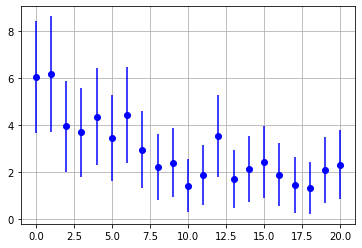

In [485]:
plt.errorbar(x, arr_mse_x.reshape(n,), arr_std_x.reshape(n,), linestyle='None', marker='o', color='b', label='x error')
plt.grid(True)

<ErrorbarContainer object of 3 artists>

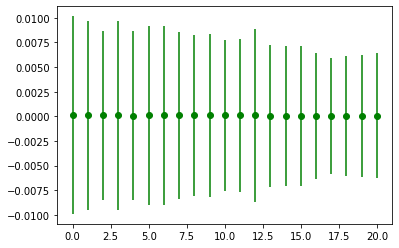

In [486]:
plt.errorbar(x, arr_mse_t.reshape(n,), arr_std_t.reshape(n,), linestyle='None', marker='o', color='g', label='t error')

<ErrorbarContainer object of 3 artists>

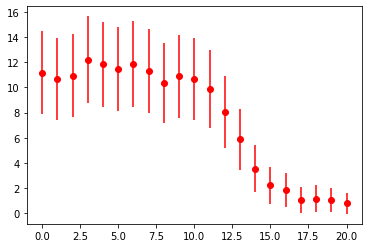

In [487]:
plt.errorbar(x, arr_mse_z.reshape(n,), arr_std_z.reshape(n,), linestyle='None', marker='o', color='r', label='z error')

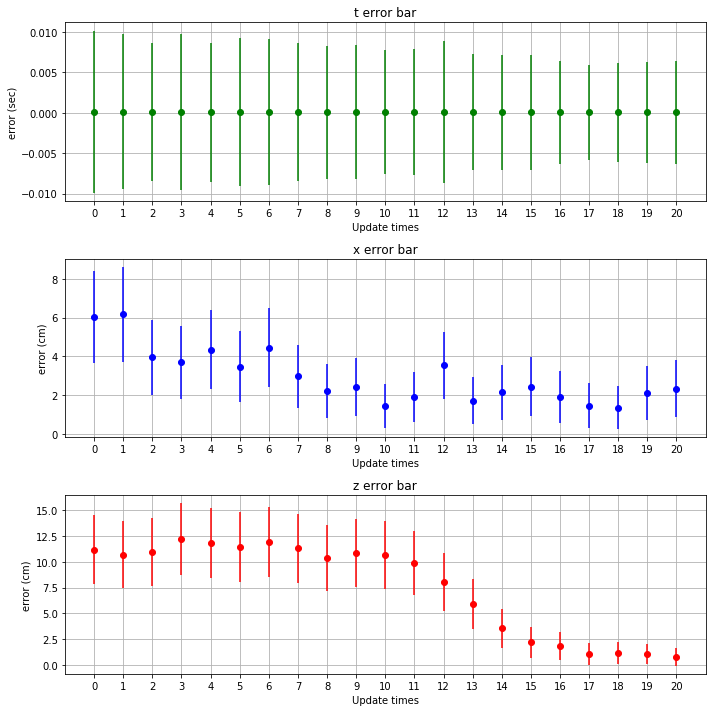

In [488]:
plt.figure(figsize=(10,10))

plt.subplot(3,1,1)
plt.errorbar(x, arr_mse_t.reshape(n,), arr_std_t.reshape(n,), linestyle='None', marker='o', color='g', label='t error')
plt.title('t error bar')
plt.xlabel('Update times')
plt.ylabel('error (sec)')
#plt.xlim(0.5,20)
plt.xticks(np.arange(0,21))
plt.grid(True)

plt.subplot(3,1,2)
plt.errorbar(x, arr_mse_x.reshape(n,), arr_std_x.reshape(n,), linestyle='None', marker='o', color='b', label='x error')
plt.title('x error bar')
plt.xlabel('Update times')
plt.ylabel('error (cm)')
plt.xticks(np.arange(0,21))
plt.grid(True)

plt.subplot(3,1,3)
plt.errorbar(x, arr_mse_z.reshape(n,), arr_std_z.reshape(n,), linestyle='None', marker='o', color='r', label='z error')
plt.title('z error bar')
plt.xlabel('Update times')
plt.ylabel('error (cm)')
plt.xticks(np.arange(0,21))
plt.grid(True)

plt.tight_layout()
#plt.savefig('./fig/without classification/'+name+'_test_res.png')
#plt.savefig('./fig/without classification/'+name+'_test_res.svg')

#plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/fixed/'+name+'/ideal/png/'+name+'_test_res.png')
#plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/fixed/'+name+'/ideal/svg/'+name+'_test_res.svg')

plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/fixed/'+name+'/without classification/png/'+name+'_test_res.png')
plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/fixed/'+name+'/without classification/svg/'+name+'_test_res.svg')

In [489]:
arr_for_err_x

array([[-2.07666793, -1.89789776, -2.06762826, ..., -0.06158283,
         0.61380914,  0.07397715],
       [-0.34767393,  1.01073247,  1.47926628, ...,  0.49860608,
         0.32623932, -1.35875255],
       [ 2.20058902,  2.21352873,  2.78579138, ..., -0.17916493,
         0.19955363, -0.59675324],
       ...,
       [-0.30327362, -1.157885  , -0.00735558, ...,  0.75599386,
         0.4338574 , -0.07700756],
       [ 5.61780966,  4.50936655,  3.33677702, ...,  0.03450162,
        -0.83890318,  0.66083875],
       [ 0.51282753,  0.19845616, -0.15403108, ...,  0.22539542,
         0.01251741,  0.65641526]])

235 241
accuray = 97.5103734439834%


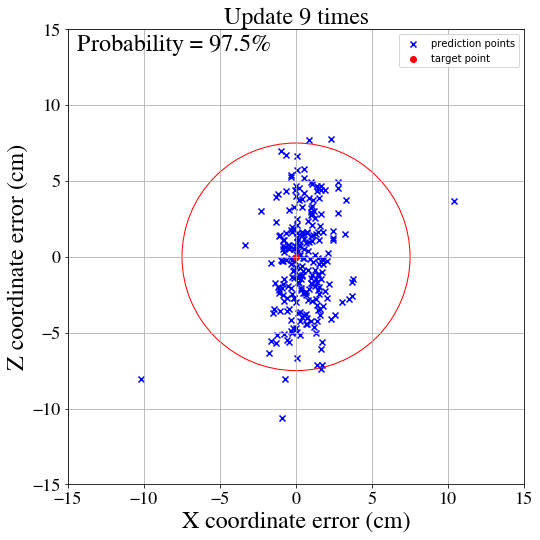

In [490]:
k = 10
up_times = k - 1

correct = 0
for i in range(arr_for_err_x.shape[0]):
    if arr_for_err_x[i,up_times] < 7.5 and arr_for_err_x[i,up_times] > -7.5 and arr_for_err_z[i,up_times] < 7.5 and arr_for_err_z[i,up_times] > -7.5:
        correct += 1
print(correct, arr_for_err_x.shape[0])
print("accuray = {}%".format(correct/arr_for_err_x.shape[0]*100))
aa = np.round_(correct/arr_for_err_x.shape[0]*100, 1)
text = str("Probability = {}%".format(aa))

plt.figure(figsize=(8,8))

x = y = np.arange(-7.5, 7.5, 0.005)
x, y = np.meshgrid(x,y)
#plt.contour(x, y, x**2 + y**2, [15*15])
circle2 = plt.Circle((0, 0), 7.5, color='r', fill=False, label='paddle edge')

ax = plt.gca()
ax.add_artist(circle2)
ax.set_xlim((-15, 15))
ax.set_ylim((-15, 15))

plt.scatter(cp.asnumpy(arr_for_err_x[:,up_times]), cp.asnumpy(arr_for_err_z[:,up_times]), edgecolors='b', label='prediction points', marker='x', color='b')
plt.scatter(0,0, color='r', marker='o', label='target point')
plt.Circle((0,0), 7.5, color='r', fill=False)

plt.xlabel('X coordinate error (cm)', fontsize=24, fontname='FreeSerif')
plt.ylabel('Z coordinate error (cm)', fontsize=24, fontname='FreeSerif')
plt.xticks(fontsize=18, fontname='FreeSerif')
plt.yticks(fontsize=18, fontname='FreeSerif')

title_name = 'Update ' + str(up_times) + ' times'
plt.title(title_name, fontsize=24, fontname='FreeSerif')
plt.text(-8,14,text, fontsize=24, fontname='FreeSerif', horizontalalignment='center', verticalalignment='center')

plt.tight_layout(pad=2.5)
plt.grid(True)
plt.legend(loc='upper right')
#plt.savefig('./fig/update_' + str(up_times) + '_times.png')

236 241
accuray = 97.9253112033195%
233 241
accuray = 96.6804979253112%
236 241
accuray = 97.9253112033195%
233 241
accuray = 96.6804979253112%
232 241
accuray = 96.2655601659751%
231 241
accuray = 95.850622406639%
233 241
accuray = 96.6804979253112%
232 241
accuray = 96.2655601659751%
234 241
accuray = 97.0954356846473%
234 241
accuray = 97.0954356846473%
237 241
accuray = 98.3402489626556%
237 241
accuray = 98.3402489626556%
235 241
accuray = 97.5103734439834%
236 241
accuray = 97.9253112033195%
239 241
accuray = 99.1701244813278%
238 241
accuray = 98.7551867219917%
238 241
accuray = 98.7551867219917%
239 241
accuray = 99.1701244813278%
240 241
accuray = 99.5850622406639%
239 241
accuray = 99.1701244813278%
239 241
accuray = 99.1701244813278%


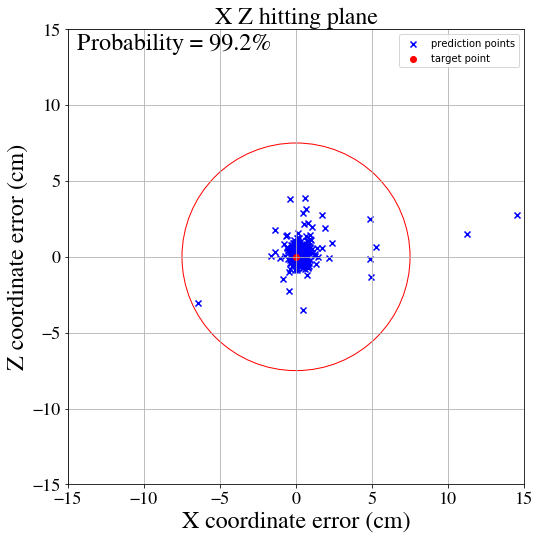

In [491]:
import math
up_times = 0

correct = 0
for i in range(arr_for_err_x.shape[0]):
    if arr_for_err_x[i,up_times] < 7.5 and arr_for_err_x[i,up_times] > -7.5 and arr_for_err_z[i,up_times] < 7.5 and arr_for_err_z[i,up_times] > -7.5:
        correct += 1
print(correct, arr_for_err_x.shape[0])
print("accuray = {}%".format(correct/arr_for_err_x.shape[0]*100))
aa = np.round_(correct/arr_for_err_x.shape[0]*100, 1)
text = str("Probability = {}%".format(aa))

plt.figure(figsize=(8,8))

x = y = np.arange(-7.5, 7.5, 0.005)
x, y = np.meshgrid(x,y)
#plt.contour(x, y, x**2 + y**2, [15*15])
circle2 = plt.Circle((0, 0), 7.5, color='r', fill=False, label='paddle edge')

ax = plt.gca()
ax.add_artist(circle2)
ax.set_xlim((-15, 15))
ax.set_ylim((-15, 15))

plt.scatter(cp.asnumpy(arr_for_err_x[:,up_times]), cp.asnumpy(arr_for_err_z[:,up_times]), edgecolors='b', label='prediction points', marker='x', color='b')
plt.scatter(0,0, color='r', marker='o', label='target point')
plt.Circle((0,0), 7.5, color='r', fill=False)

plt.xlabel('X coordinate error (cm)', fontsize=24, fontname='FreeSerif')
plt.ylabel('Z coordinate error (cm)', fontsize=24, fontname='FreeSerif')
plt.xticks(fontsize=18, fontname='FreeSerif')
plt.yticks(fontsize=18, fontname='FreeSerif')
plt.title('X Z hitting plane', fontsize=24, fontname='FreeSerif')
plt.text(-8,14,text, fontsize=24, fontname='FreeSerif', horizontalalignment='center', verticalalignment='center')

plt.tight_layout(pad=2.5)
plt.grid(True)
plt.legend(loc='upper right')
plt.savefig('./fig/without classification/update_' + str(up_times) + '_times_without_classification.png')
plt.savefig('./fig/without classification/update_' + str(up_times) + '_times_without_classification.svg')

for up_times in range(1,n,1):
    plt.clf()
    #plt.figure(figsize=(8,8))
    '''
    ax = plt.gca()
    ax.add_artist(circle2)
    ax.set_xlim((-15, 15))
    ax.set_ylim((-15, 15))
    '''
    
    circle2 = plt.Circle((0, 0), 7.5, color='r', fill=False, label='paddle edge')
    ax = plt.gca()
    ax.add_artist(circle2)
    
    correct = 0
    for i in range(arr_for_err_x.shape[0]):
        d = math.sqrt(arr_for_err_x[i,up_times]**2+arr_for_err_z[i,up_times]**2)
        if d <= 7.5:
            correct += 1
    print(correct, arr_for_err_x.shape[0])
    print("accuray = {}%".format(correct/arr_for_err_x.shape[0]*100))
    aa = np.round_(correct/arr_for_err_x.shape[0]*100, 1)
    text = str("Probability = {}%".format(aa))
    
    plt.scatter(cp.asnumpy(arr_for_err_x[:,up_times]), cp.asnumpy(arr_for_err_z[:,up_times]), edgecolors='b', label='prediction points', marker='x', color='b')
    plt.scatter(0,0, color='r', marker='o', label='target point')
    plt.Circle((0,0), 7.5, color='r', fill=False)

    plt.xlabel('X coordinate error (cm)', fontsize=24, fontname='FreeSerif')
    plt.ylabel('Z coordinate error (cm)', fontsize=24, fontname='FreeSerif')
    plt.xticks(fontsize=18, fontname='FreeSerif')
    plt.yticks(fontsize=18, fontname='FreeSerif')
    plt.title('X Z hitting plane', fontsize=24, fontname='FreeSerif')
    plt.text(-8,14,text, fontsize=24, fontname='FreeSerif', horizontalalignment='center', verticalalignment='center')

    plt.xlim(-15,15)
    plt.ylim(-15,15)
    
    plt.tight_layout(pad=2.5)
    plt.grid(True)
    plt.legend(loc='upper right')
    #plt.savefig('./fig/without classification/update_' + str(up_times) + '_times_without_classification.png')
    #plt.savefig('./fig/without classification/update_' + str(up_times) + '_times_without_classification.svg')
    
    plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/fixed/'+name+'/without classification/png/update_'+str(up_times) + '_times_without_classification.png')
    plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/fixed/'+name+'/without classification/svg/update_'+str(up_times) + '_times_without_classification.svg')
    
    #plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/fixed/'+name+'/ideal/png/update_'+str(up_times) + '_times_without_classification.png')
    #plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/fixed/'+name+'/ideal/svg/update_'+str(up_times) + '_times_without_classification.svg')

In [492]:
errbar = [arr_mse_t, arr_mse_x, arr_mse_z, arr_std_t, arr_std_x, arr_std_z]
errbar = np.array(errbar)
errbar

array([[[ 0.0001261 ,  0.00011667,  0.00009448,  0.00010535,
          0.00007933,  0.00008774,  0.00009036,  0.00008458,
          0.00008476,  0.000092  ,  0.00008607,  0.00008399,
          0.00009088,  0.00006385,  0.00005642,  0.00006106,
          0.00005143,  0.00004735,  0.00005196,  0.00005187,
          0.00005141]],

       [[ 6.04310924,  6.16193978,  3.9390197 ,  3.69722062,
          4.34937065,  3.46569978,  4.43495479,  2.95761854,
          2.20734863,  2.41156715,  1.43813694,  1.89687846,
          3.53832867,  1.70165675,  2.13564248,  2.43507932,
          1.8865764 ,  1.45244202,  1.3419577 ,  2.09244927,
          2.32087837]],

       [[11.17987314, 10.69201847, 10.94310786, 12.20110413,
         11.83208201, 11.43377151, 11.88549596, 11.29709861,
         10.35235173, 10.88444083, 10.65601552,  9.87253941,
          8.03671689,  5.88666724,  3.54285406,  2.20422436,
          1.85648102,  1.07331975,  1.14956146,  1.04123561,
          0.7793391 ]],

       [[ 

In [493]:
errbar = errbar.reshape(6,21)
errbar

array([[ 0.0001261 ,  0.00011667,  0.00009448,  0.00010535,  0.00007933,
         0.00008774,  0.00009036,  0.00008458,  0.00008476,  0.000092  ,
         0.00008607,  0.00008399,  0.00009088,  0.00006385,  0.00005642,
         0.00006106,  0.00005143,  0.00004735,  0.00005196,  0.00005187,
         0.00005141],
       [ 6.04310924,  6.16193978,  3.9390197 ,  3.69722062,  4.34937065,
         3.46569978,  4.43495479,  2.95761854,  2.20734863,  2.41156715,
         1.43813694,  1.89687846,  3.53832867,  1.70165675,  2.13564248,
         2.43507932,  1.8865764 ,  1.45244202,  1.3419577 ,  2.09244927,
         2.32087837],
       [11.17987314, 10.69201847, 10.94310786, 12.20110413, 11.83208201,
        11.43377151, 11.88549596, 11.29709861, 10.35235173, 10.88444083,
        10.65601552,  9.87253941,  8.03671689,  5.88666724,  3.54285406,
         2.20422436,  1.85648102,  1.07331975,  1.14956146,  1.04123561,
         0.7793391 ],
       [ 0.01002665,  0.00958351,  0.00857193,  0.00960752

In [494]:
#errbar = errbar.reshape(21,6)
df = pd.DataFrame(data=errbar)
#df.to_csv('/home/lab606a/Documents/comp/without classification/ideal.csv', index=False)

p = '/home/lab606a/Documents/4Journal_20200629/result/fixed/'+name+'/without classification/without_classification.csv'
#p = '/home/lab606a/Documents/4Journal_20200629/result/fixed/'+name+'/ideal/ideal.csv'

df.to_csv(p, index=False)